##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [2]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

2021-08-11 17:13:39.142911: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Import `matplotlib` and create a helper function to plot graphs:

In [3]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [4]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

2021-08-11 17:13:44.932351: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-11 17:13:45.580911: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-11 17:13:45.581828: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:05.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2021-08-11 17:13:45.581863: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-11 17:13:45.585229: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-11 17:13:45.585313: I tensorflow/stream_executor/platfo

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [5]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

2021-08-11 17:13:46.308471: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-11 17:13:46.309038: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2000165000 Hz


text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [7]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"Released as Zentropa in North America to avoid confusion with Agniezska Holland's own Holocaust film Europa Europa, this third theatrical feature by a filmmaker who never ceases to surprise, inspire or downright shock is a bizarre, nostalgic, elaborate film about a naive American in Germany shortly following the end of WWII. The American, named Leo, doesn't fully get what he's doing there. He has come to take part in fixing up the country since, in his mind, it's about time Germany was shown some charity. No matter how that sounds, he is not a Nazi sympathizer or so much as especially pro-German, merely mixed up. His uncle, who works on the railroad, gets Leo a job as a helmsman on a sleeping car, and he is increasingly enmeshed in a vortex of 1945 Germany's horrors and enigmas.<br /><br />This progression starts when Leo, played rather memorably by the calm yet restless actor Jean-Marc Barr, meets a sultry heiress on the train played by Barbara Sukowa, an actress with genti

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [9]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [11]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[627,  15,   1, ..., 254, 925,   1],
       [  1,   1,   7, ...,   0,   0,   0],
       [ 45,  61,   1, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [12]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"Released as Zentropa in North America to avoid confusion with Agniezska Holland's own Holocaust film Europa Europa, this third theatrical feature by a filmmaker who never ceases to surprise, inspire or downright shock is a bizarre, nostalgic, elaborate film about a naive American in Germany shortly following the end of WWII. The American, named Leo, doesn't fully get what he's doing there. He has come to take part in fixing up the country since, in his mind, it's about time Germany was shown some charity. No matter how that sounds, he is not a Nazi sympathizer or so much as especially pro-German, merely mixed up. His uncle, who works on the railroad, gets Leo a job as a helmsman on a sleeping car, and he is increasingly enmeshed in a vortex of 1945 Germany's horrors and enigmas.<br /><br />This progression starts when Leo, played rather memorably by the calm yet restless actor Jean-Marc Barr, meets a sultry heiress on the train played by Barbara Sukowa, an actress with gen

## Create the model

![A drawing of the information flow in the model](images/bidirectional.png)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [13]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [14]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [15]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

2021-08-11 17:14:00.070455: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8


2021-08-11 17:14:02.142033: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100


2021-08-11 17:14:03.154836: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11


[0.00120276]


2021-08-11 17:14:03.513036: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [16]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.00120276]


Compile the Keras model to configure the training process:

In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [18]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10


  1/391 [..............................] - ETA: 47:40 - loss: 0.6929 - accuracy: 0.4531

  2/391 [..............................] - ETA: 32s - loss: 0.6928 - accuracy: 0.4844  

  3/391 [..............................] - ETA: 32s - loss: 0.6928 - accuracy: 0.4792

  4/391 [..............................] - ETA: 32s - loss: 0.6924 - accuracy: 0.4688

  5/391 [..............................] - ETA: 33s - loss: 0.6927 - accuracy: 0.4719

  6/391 [..............................] - ETA: 31s - loss: 0.6925 - accuracy: 0.4688

  7/391 [..............................] - ETA: 30s - loss: 0.6923 - accuracy: 0.4665

  8/391 [..............................] - ETA: 29s - loss: 0.6925 - accuracy: 0.4766

  9/391 [..............................] - ETA: 29s - loss: 0.6925 - accuracy: 0.4757

 10/391 [..............................] - ETA: 29s - loss: 0.6923 - accuracy: 0.4688

 11/391 [..............................] - ETA: 30s - loss: 0.6920 - accuracy: 0.4616

 12/391 [..............................] - ETA: 30s - loss: 0.6920 - accuracy: 0.4648

 13/391 [..............................] - ETA: 30s - loss: 0.6920 - accuracy: 0.4663

 14/391 [>.............................] - ETA: 30s - loss: 0.6924 - accuracy: 0.4766

 15/391 [>.............................] - ETA: 29s - loss: 0.6927 - accuracy: 0.4844

 16/391 [>.............................] - ETA: 29s - loss: 0.6926 - accuracy: 0.4824

 17/391 [>.............................] - ETA: 29s - loss: 0.6924 - accuracy: 0.4807

 18/391 [>.............................] - ETA: 29s - loss: 0.6923 - accuracy: 0.4809

 19/391 [>.............................] - ETA: 29s - loss: 0.6925 - accuracy: 0.4836

 20/391 [>.............................] - ETA: 29s - loss: 0.6925 - accuracy: 0.4844

 21/391 [>.............................] - ETA: 29s - loss: 0.6925 - accuracy: 0.4859

 22/391 [>.............................] - ETA: 29s - loss: 0.6925 - accuracy: 0.4865

 23/391 [>.............................] - ETA: 29s - loss: 0.6926 - accuracy: 0.4871

 24/391 [>.............................] - ETA: 29s - loss: 0.6924 - accuracy: 0.4844

 25/391 [>.............................] - ETA: 29s - loss: 0.6924 - accuracy: 0.4837

 26/391 [>.............................] - ETA: 29s - loss: 0.6925 - accuracy: 0.4880

 27/391 [=>............................] - ETA: 29s - loss: 0.6926 - accuracy: 0.4913

 28/391 [=>............................] - ETA: 28s - loss: 0.6926 - accuracy: 0.4905

 29/391 [=>............................] - ETA: 30s - loss: 0.6926 - accuracy: 0.4930

 30/391 [=>............................] - ETA: 30s - loss: 0.6926 - accuracy: 0.4938

 31/391 [=>............................] - ETA: 30s - loss: 0.6925 - accuracy: 0.4909

 32/391 [=>............................] - ETA: 30s - loss: 0.6924 - accuracy: 0.4868

 33/391 [=>............................] - ETA: 29s - loss: 0.6924 - accuracy: 0.4872

 34/391 [=>............................] - ETA: 29s - loss: 0.6924 - accuracy: 0.4881

 35/391 [=>............................] - ETA: 29s - loss: 0.6924 - accuracy: 0.4862

 36/391 [=>............................] - ETA: 29s - loss: 0.6923 - accuracy: 0.4861

 37/391 [=>............................] - ETA: 29s - loss: 0.6923 - accuracy: 0.4852

 38/391 [=>............................] - ETA: 28s - loss: 0.6923 - accuracy: 0.4856

 39/391 [=>............................] - ETA: 28s - loss: 0.6922 - accuracy: 0.4860

 40/391 [==>...........................] - ETA: 28s - loss: 0.6923 - accuracy: 0.4867

 41/391 [==>...........................] - ETA: 28s - loss: 0.6923 - accuracy: 0.4851

 42/391 [==>...........................] - ETA: 28s - loss: 0.6923 - accuracy: 0.4866

 44/391 [==>...........................] - ETA: 27s - loss: 0.6925 - accuracy: 0.4901

 45/391 [==>...........................] - ETA: 27s - loss: 0.6924 - accuracy: 0.4892

 46/391 [==>...........................] - ETA: 27s - loss: 0.6925 - accuracy: 0.4901

 47/391 [==>...........................] - ETA: 27s - loss: 0.6925 - accuracy: 0.4917

 48/391 [==>...........................] - ETA: 27s - loss: 0.6925 - accuracy: 0.4912

 49/391 [==>...........................] - ETA: 27s - loss: 0.6925 - accuracy: 0.4923

 51/391 [==>...........................] - ETA: 26s - loss: 0.6926 - accuracy: 0.4936

 52/391 [==>...........................] - ETA: 26s - loss: 0.6926 - accuracy: 0.4940

 53/391 [===>..........................] - ETA: 26s - loss: 0.6925 - accuracy: 0.4929

 54/391 [===>..........................] - ETA: 26s - loss: 0.6926 - accuracy: 0.4936

 55/391 [===>..........................] - ETA: 26s - loss: 0.6926 - accuracy: 0.4952

 56/391 [===>..........................] - ETA: 26s - loss: 0.6927 - accuracy: 0.4972

 57/391 [===>..........................] - ETA: 26s - loss: 0.6927 - accuracy: 0.4989

 58/391 [===>..........................] - ETA: 26s - loss: 0.6927 - accuracy: 0.4989

 59/391 [===>..........................] - ETA: 26s - loss: 0.6928 - accuracy: 0.5005

 60/391 [===>..........................] - ETA: 25s - loss: 0.6928 - accuracy: 0.5021

 61/391 [===>..........................] - ETA: 25s - loss: 0.6927 - accuracy: 0.5010

 62/391 [===>..........................] - ETA: 25s - loss: 0.6927 - accuracy: 0.5008

 63/391 [===>..........................] - ETA: 25s - loss: 0.6927 - accuracy: 0.5007

 64/391 [===>..........................] - ETA: 25s - loss: 0.6927 - accuracy: 0.5007

 66/391 [====>.........................] - ETA: 25s - loss: 0.6927 - accuracy: 0.4998

 67/391 [====>.........................] - ETA: 25s - loss: 0.6927 - accuracy: 0.4995

 68/391 [====>.........................] - ETA: 25s - loss: 0.6927 - accuracy: 0.4993

 69/391 [====>.........................] - ETA: 25s - loss: 0.6927 - accuracy: 0.4993

 70/391 [====>.........................] - ETA: 25s - loss: 0.6927 - accuracy: 0.5007

 71/391 [====>.........................] - ETA: 24s - loss: 0.6927 - accuracy: 0.5007

 72/391 [====>.........................] - ETA: 24s - loss: 0.6927 - accuracy: 0.4998

 73/391 [====>.........................] - ETA: 24s - loss: 0.6926 - accuracy: 0.4987

 74/391 [====>.........................] - ETA: 24s - loss: 0.6926 - accuracy: 0.4994

 75/391 [====>.........................] - ETA: 24s - loss: 0.6926 - accuracy: 0.4992

 76/391 [====>.........................] - ETA: 24s - loss: 0.6926 - accuracy: 0.4996

 77/391 [====>.........................] - ETA: 24s - loss: 0.6926 - accuracy: 0.5004

 78/391 [====>.........................] - ETA: 24s - loss: 0.6926 - accuracy: 0.4996

 79/391 [=====>........................] - ETA: 24s - loss: 0.6926 - accuracy: 0.5006

 80/391 [=====>........................] - ETA: 24s - loss: 0.6926 - accuracy: 0.4994

 81/391 [=====>........................] - ETA: 23s - loss: 0.6926 - accuracy: 0.4990

 82/391 [=====>........................] - ETA: 23s - loss: 0.6926 - accuracy: 0.4994

 83/391 [=====>........................] - ETA: 23s - loss: 0.6926 - accuracy: 0.4998

 84/391 [=====>........................] - ETA: 23s - loss: 0.6926 - accuracy: 0.4987

 85/391 [=====>........................] - ETA: 23s - loss: 0.6926 - accuracy: 0.4994

 86/391 [=====>........................] - ETA: 23s - loss: 0.6926 - accuracy: 0.4987

 87/391 [=====>........................] - ETA: 23s - loss: 0.6926 - accuracy: 0.4986

 88/391 [=====>........................] - ETA: 23s - loss: 0.6926 - accuracy: 0.5000

 89/391 [=====>........................] - ETA: 23s - loss: 0.6925 - accuracy: 0.4995

 90/391 [=====>........................] - ETA: 23s - loss: 0.6925 - accuracy: 0.5002

 91/391 [=====>........................] - ETA: 23s - loss: 0.6925 - accuracy: 0.4997

 92/391 [======>.......................] - ETA: 22s - loss: 0.6925 - accuracy: 0.5003

 93/391 [======>.......................] - ETA: 22s - loss: 0.6925 - accuracy: 0.5000

 94/391 [======>.......................] - ETA: 22s - loss: 0.6925 - accuracy: 0.5012

 95/391 [======>.......................] - ETA: 22s - loss: 0.6925 - accuracy: 0.5008

 96/391 [======>.......................] - ETA: 22s - loss: 0.6925 - accuracy: 0.5003

 97/391 [======>.......................] - ETA: 22s - loss: 0.6925 - accuracy: 0.5008

 98/391 [======>.......................] - ETA: 22s - loss: 0.6925 - accuracy: 0.5013

 99/391 [======>.......................] - ETA: 22s - loss: 0.6925 - accuracy: 0.5013

100/391 [======>.......................] - ETA: 22s - loss: 0.6925 - accuracy: 0.5002

101/391 [======>.......................] - ETA: 22s - loss: 0.6925 - accuracy: 0.5000

102/391 [======>.......................] - ETA: 22s - loss: 0.6925 - accuracy: 0.5005

103/391 [======>.......................] - ETA: 22s - loss: 0.6924 - accuracy: 0.5008

104/391 [======>.......................] - ETA: 22s - loss: 0.6924 - accuracy: 0.5002

105/391 [=======>......................] - ETA: 21s - loss: 0.6924 - accuracy: 0.5001

106/391 [=======>......................] - ETA: 21s - loss: 0.6924 - accuracy: 0.5007

107/391 [=======>......................] - ETA: 21s - loss: 0.6924 - accuracy: 0.5010

108/391 [=======>......................] - ETA: 21s - loss: 0.6924 - accuracy: 0.5014

109/391 [=======>......................] - ETA: 21s - loss: 0.6924 - accuracy: 0.5010

110/391 [=======>......................] - ETA: 21s - loss: 0.6924 - accuracy: 0.5000

111/391 [=======>......................] - ETA: 21s - loss: 0.6924 - accuracy: 0.4999

112/391 [=======>......................] - ETA: 21s - loss: 0.6923 - accuracy: 0.5000

113/391 [=======>......................] - ETA: 21s - loss: 0.6924 - accuracy: 0.5012

114/391 [=======>......................] - ETA: 21s - loss: 0.6923 - accuracy: 0.5015

115/391 [=======>......................] - ETA: 21s - loss: 0.6923 - accuracy: 0.5016

116/391 [=======>......................] - ETA: 21s - loss: 0.6923 - accuracy: 0.5020

117/391 [=======>......................] - ETA: 20s - loss: 0.6923 - accuracy: 0.5016

118/391 [========>.....................] - ETA: 20s - loss: 0.6923 - accuracy: 0.5017

119/391 [========>.....................] - ETA: 20s - loss: 0.6923 - accuracy: 0.5024

120/391 [========>.....................] - ETA: 20s - loss: 0.6923 - accuracy: 0.5025

121/391 [========>.....................] - ETA: 20s - loss: 0.6922 - accuracy: 0.5025

122/391 [========>.....................] - ETA: 20s - loss: 0.6922 - accuracy: 0.5015

123/391 [========>.....................] - ETA: 20s - loss: 0.6922 - accuracy: 0.5018

124/391 [========>.....................] - ETA: 20s - loss: 0.6922 - accuracy: 0.5023

125/391 [========>.....................] - ETA: 20s - loss: 0.6922 - accuracy: 0.5016

126/391 [========>.....................] - ETA: 20s - loss: 0.6922 - accuracy: 0.5017

127/391 [========>.....................] - ETA: 20s - loss: 0.6922 - accuracy: 0.5020

128/391 [========>.....................] - ETA: 20s - loss: 0.6922 - accuracy: 0.5020

129/391 [========>.....................] - ETA: 20s - loss: 0.6922 - accuracy: 0.5021

130/391 [========>.....................] - ETA: 19s - loss: 0.6922 - accuracy: 0.5018

131/391 [=========>....................] - ETA: 19s - loss: 0.6922 - accuracy: 0.5019

132/391 [=========>....................] - ETA: 19s - loss: 0.6922 - accuracy: 0.5027

133/391 [=========>....................] - ETA: 19s - loss: 0.6922 - accuracy: 0.5032

134/391 [=========>....................] - ETA: 19s - loss: 0.6922 - accuracy: 0.5035

135/391 [=========>....................] - ETA: 19s - loss: 0.6922 - accuracy: 0.5034

136/391 [=========>....................] - ETA: 19s - loss: 0.6922 - accuracy: 0.5031

137/391 [=========>....................] - ETA: 19s - loss: 0.6922 - accuracy: 0.5034

138/391 [=========>....................] - ETA: 19s - loss: 0.6922 - accuracy: 0.5036

139/391 [=========>....................] - ETA: 19s - loss: 0.6922 - accuracy: 0.5039

140/391 [=========>....................] - ETA: 19s - loss: 0.6921 - accuracy: 0.5036

141/391 [=========>....................] - ETA: 19s - loss: 0.6921 - accuracy: 0.5039

142/391 [=========>....................] - ETA: 19s - loss: 0.6921 - accuracy: 0.5035

143/391 [=========>....................] - ETA: 18s - loss: 0.6921 - accuracy: 0.5027

144/391 [==========>...................] - ETA: 18s - loss: 0.6920 - accuracy: 0.5022

145/391 [==========>...................] - ETA: 18s - loss: 0.6920 - accuracy: 0.5022

146/391 [==========>...................] - ETA: 18s - loss: 0.6920 - accuracy: 0.5020

147/391 [==========>...................] - ETA: 18s - loss: 0.6920 - accuracy: 0.5023

148/391 [==========>...................] - ETA: 18s - loss: 0.6920 - accuracy: 0.5017

149/391 [==========>...................] - ETA: 18s - loss: 0.6920 - accuracy: 0.5014

150/391 [==========>...................] - ETA: 18s - loss: 0.6920 - accuracy: 0.5017

151/391 [==========>...................] - ETA: 18s - loss: 0.6920 - accuracy: 0.5022

152/391 [==========>...................] - ETA: 18s - loss: 0.6919 - accuracy: 0.5022

153/391 [==========>...................] - ETA: 18s - loss: 0.6919 - accuracy: 0.5023

154/391 [==========>...................] - ETA: 18s - loss: 0.6919 - accuracy: 0.5020

155/391 [==========>...................] - ETA: 18s - loss: 0.6919 - accuracy: 0.5016

156/391 [==========>...................] - ETA: 17s - loss: 0.6919 - accuracy: 0.5018

157/391 [===========>..................] - ETA: 17s - loss: 0.6919 - accuracy: 0.5015

158/391 [===========>..................] - ETA: 17s - loss: 0.6918 - accuracy: 0.5008

159/391 [===========>..................] - ETA: 17s - loss: 0.6918 - accuracy: 0.5005

160/391 [===========>..................] - ETA: 17s - loss: 0.6918 - accuracy: 0.5005

161/391 [===========>..................] - ETA: 17s - loss: 0.6918 - accuracy: 0.5006

162/391 [===========>..................] - ETA: 17s - loss: 0.6917 - accuracy: 0.5001

163/391 [===========>..................] - ETA: 17s - loss: 0.6918 - accuracy: 0.5001

164/391 [===========>..................] - ETA: 17s - loss: 0.6917 - accuracy: 0.5000

165/391 [===========>..................] - ETA: 17s - loss: 0.6917 - accuracy: 0.4992

166/391 [===========>..................] - ETA: 17s - loss: 0.6917 - accuracy: 0.4994

167/391 [===========>..................] - ETA: 17s - loss: 0.6916 - accuracy: 0.4991

168/391 [===========>..................] - ETA: 17s - loss: 0.6916 - accuracy: 0.4989

169/391 [===========>..................] - ETA: 17s - loss: 0.6916 - accuracy: 0.4987

170/391 [============>.................] - ETA: 16s - loss: 0.6916 - accuracy: 0.4988

171/391 [============>.................] - ETA: 16s - loss: 0.6916 - accuracy: 0.4988

172/391 [============>.................] - ETA: 16s - loss: 0.6916 - accuracy: 0.4994

173/391 [============>.................] - ETA: 16s - loss: 0.6916 - accuracy: 0.4996

174/391 [============>.................] - ETA: 16s - loss: 0.6916 - accuracy: 0.4996

175/391 [============>.................] - ETA: 16s - loss: 0.6916 - accuracy: 0.4993

177/391 [============>.................] - ETA: 16s - loss: 0.6915 - accuracy: 0.4990

178/391 [============>.................] - ETA: 16s - loss: 0.6915 - accuracy: 0.4991

179/391 [============>.................] - ETA: 16s - loss: 0.6915 - accuracy: 0.4992

180/391 [============>.................] - ETA: 16s - loss: 0.6915 - accuracy: 0.4993

181/391 [============>.................] - ETA: 16s - loss: 0.6915 - accuracy: 0.4992

182/391 [============>.................] - ETA: 15s - loss: 0.6915 - accuracy: 0.4993

183/391 [=============>................] - ETA: 15s - loss: 0.6914 - accuracy: 0.4995

184/391 [=============>................] - ETA: 15s - loss: 0.6914 - accuracy: 0.4993

185/391 [=============>................] - ETA: 15s - loss: 0.6914 - accuracy: 0.4992

186/391 [=============>................] - ETA: 15s - loss: 0.6914 - accuracy: 0.4996

187/391 [=============>................] - ETA: 15s - loss: 0.6914 - accuracy: 0.4999

188/391 [=============>................] - ETA: 15s - loss: 0.6914 - accuracy: 0.4999

189/391 [=============>................] - ETA: 15s - loss: 0.6914 - accuracy: 0.5002

190/391 [=============>................] - ETA: 15s - loss: 0.6914 - accuracy: 0.5007

191/391 [=============>................] - ETA: 15s - loss: 0.6914 - accuracy: 0.5007

192/391 [=============>................] - ETA: 15s - loss: 0.6913 - accuracy: 0.5003

193/391 [=============>................] - ETA: 15s - loss: 0.6913 - accuracy: 0.5011

194/391 [=============>................] - ETA: 14s - loss: 0.6913 - accuracy: 0.5014

195/391 [=============>................] - ETA: 14s - loss: 0.6912 - accuracy: 0.5009

196/391 [==============>...............] - ETA: 14s - loss: 0.6912 - accuracy: 0.5010

197/391 [==============>...............] - ETA: 14s - loss: 0.6911 - accuracy: 0.5013

198/391 [==============>...............] - ETA: 14s - loss: 0.6911 - accuracy: 0.5008

199/391 [==============>...............] - ETA: 14s - loss: 0.6911 - accuracy: 0.5005

200/391 [==============>...............] - ETA: 14s - loss: 0.6911 - accuracy: 0.5003

201/391 [==============>...............] - ETA: 14s - loss: 0.6911 - accuracy: 0.5009

202/391 [==============>...............] - ETA: 14s - loss: 0.6910 - accuracy: 0.5004

203/391 [==============>...............] - ETA: 14s - loss: 0.6910 - accuracy: 0.5002

204/391 [==============>...............] - ETA: 14s - loss: 0.6909 - accuracy: 0.5003

205/391 [==============>...............] - ETA: 14s - loss: 0.6909 - accuracy: 0.5007

206/391 [==============>...............] - ETA: 14s - loss: 0.6908 - accuracy: 0.5008

207/391 [==============>...............] - ETA: 14s - loss: 0.6908 - accuracy: 0.5009

208/391 [==============>...............] - ETA: 13s - loss: 0.6907 - accuracy: 0.5008

209/391 [===============>..............] - ETA: 13s - loss: 0.6907 - accuracy: 0.5001

210/391 [===============>..............] - ETA: 13s - loss: 0.6907 - accuracy: 0.5000

211/391 [===============>..............] - ETA: 13s - loss: 0.6907 - accuracy: 0.5002

212/391 [===============>..............] - ETA: 13s - loss: 0.6907 - accuracy: 0.5000

213/391 [===============>..............] - ETA: 13s - loss: 0.6906 - accuracy: 0.5000

214/391 [===============>..............] - ETA: 13s - loss: 0.6906 - accuracy: 0.5000

215/391 [===============>..............] - ETA: 13s - loss: 0.6905 - accuracy: 0.4999

216/391 [===============>..............] - ETA: 13s - loss: 0.6905 - accuracy: 0.5002

217/391 [===============>..............] - ETA: 13s - loss: 0.6904 - accuracy: 0.5002

218/391 [===============>..............] - ETA: 13s - loss: 0.6904 - accuracy: 0.4999

219/391 [===============>..............] - ETA: 13s - loss: 0.6903 - accuracy: 0.5001

220/391 [===============>..............] - ETA: 12s - loss: 0.6903 - accuracy: 0.5004

221/391 [===============>..............] - ETA: 12s - loss: 0.6902 - accuracy: 0.5001

222/391 [================>.............] - ETA: 12s - loss: 0.6901 - accuracy: 0.4999

223/391 [================>.............] - ETA: 12s - loss: 0.6901 - accuracy: 0.5000

224/391 [================>.............] - ETA: 12s - loss: 0.6901 - accuracy: 0.5006

225/391 [================>.............] - ETA: 12s - loss: 0.6900 - accuracy: 0.5008

226/391 [================>.............] - ETA: 12s - loss: 0.6899 - accuracy: 0.5006

227/391 [================>.............] - ETA: 12s - loss: 0.6898 - accuracy: 0.5007

228/391 [================>.............] - ETA: 12s - loss: 0.6896 - accuracy: 0.5004

229/391 [================>.............] - ETA: 12s - loss: 0.6895 - accuracy: 0.4999

230/391 [================>.............] - ETA: 12s - loss: 0.6894 - accuracy: 0.5003

231/391 [================>.............] - ETA: 12s - loss: 0.6894 - accuracy: 0.5004

232/391 [================>.............] - ETA: 12s - loss: 0.6891 - accuracy: 0.5009

233/391 [================>.............] - ETA: 12s - loss: 0.6889 - accuracy: 0.5007

234/391 [================>.............] - ETA: 11s - loss: 0.6888 - accuracy: 0.5010

236/391 [=================>............] - ETA: 11s - loss: 0.6885 - accuracy: 0.5017

237/391 [=================>............] - ETA: 11s - loss: 0.6883 - accuracy: 0.5019

238/391 [=================>............] - ETA: 11s - loss: 0.6882 - accuracy: 0.5020

239/391 [=================>............] - ETA: 11s - loss: 0.6881 - accuracy: 0.5020

240/391 [=================>............] - ETA: 11s - loss: 0.6880 - accuracy: 0.5027

241/391 [=================>............] - ETA: 11s - loss: 0.6878 - accuracy: 0.5027

242/391 [=================>............] - ETA: 11s - loss: 0.6877 - accuracy: 0.5032

243/391 [=================>............] - ETA: 11s - loss: 0.6876 - accuracy: 0.5037

244/391 [=================>............] - ETA: 11s - loss: 0.6876 - accuracy: 0.5037

245/391 [=================>............] - ETA: 11s - loss: 0.6873 - accuracy: 0.5046

246/391 [=================>............] - ETA: 10s - loss: 0.6869 - accuracy: 0.5048

247/391 [=================>............] - ETA: 10s - loss: 0.6867 - accuracy: 0.5055

248/391 [==================>...........] - ETA: 10s - loss: 0.6867 - accuracy: 0.5059

249/391 [==================>...........] - ETA: 10s - loss: 0.6863 - accuracy: 0.5063

250/391 [==================>...........] - ETA: 10s - loss: 0.6859 - accuracy: 0.5068

251/391 [==================>...........] - ETA: 10s - loss: 0.6858 - accuracy: 0.5070

252/391 [==================>...........] - ETA: 10s - loss: 0.6854 - accuracy: 0.5078

253/391 [==================>...........] - ETA: 10s - loss: 0.6853 - accuracy: 0.5080

254/391 [==================>...........] - ETA: 10s - loss: 0.6849 - accuracy: 0.5089

255/391 [==================>...........] - ETA: 10s - loss: 0.6848 - accuracy: 0.5092

256/391 [==================>...........] - ETA: 10s - loss: 0.6841 - accuracy: 0.5102

257/391 [==================>...........] - ETA: 10s - loss: 0.6837 - accuracy: 0.5109

258/391 [==================>...........] - ETA: 10s - loss: 0.6834 - accuracy: 0.5117

260/391 [==================>...........] - ETA: 9s - loss: 0.6827 - accuracy: 0.5128 

261/391 [===================>..........] - ETA: 9s - loss: 0.6826 - accuracy: 0.5132

262/391 [===================>..........] - ETA: 9s - loss: 0.6823 - accuracy: 0.5137

263/391 [===================>..........] - ETA: 9s - loss: 0.6818 - accuracy: 0.5143

264/391 [===================>..........] - ETA: 9s - loss: 0.6814 - accuracy: 0.5146

265/391 [===================>..........] - ETA: 9s - loss: 0.6811 - accuracy: 0.5150

266/391 [===================>..........] - ETA: 9s - loss: 0.6806 - accuracy: 0.5159

267/391 [===================>..........] - ETA: 9s - loss: 0.6802 - accuracy: 0.5167

268/391 [===================>..........] - ETA: 9s - loss: 0.6800 - accuracy: 0.5174

269/391 [===================>..........] - ETA: 9s - loss: 0.6797 - accuracy: 0.5182

270/391 [===================>..........] - ETA: 9s - loss: 0.6796 - accuracy: 0.5183

271/391 [===================>..........] - ETA: 9s - loss: 0.6793 - accuracy: 0.5186

272/391 [===================>..........] - ETA: 9s - loss: 0.6790 - accuracy: 0.5192

273/391 [===================>..........] - ETA: 8s - loss: 0.6787 - accuracy: 0.5198

274/391 [====================>.........] - ETA: 8s - loss: 0.6782 - accuracy: 0.5204

275/391 [====================>.........] - ETA: 8s - loss: 0.6776 - accuracy: 0.5211

276/391 [====================>.........] - ETA: 8s - loss: 0.6769 - accuracy: 0.5219

277/391 [====================>.........] - ETA: 8s - loss: 0.6763 - accuracy: 0.5227

278/391 [====================>.........] - ETA: 8s - loss: 0.6757 - accuracy: 0.5234

279/391 [====================>.........] - ETA: 8s - loss: 0.6755 - accuracy: 0.5239

280/391 [====================>.........] - ETA: 8s - loss: 0.6755 - accuracy: 0.5241

281/391 [====================>.........] - ETA: 8s - loss: 0.6750 - accuracy: 0.5247

282/391 [====================>.........] - ETA: 8s - loss: 0.6746 - accuracy: 0.5253

283/391 [====================>.........] - ETA: 8s - loss: 0.6740 - accuracy: 0.5258

284/391 [====================>.........] - ETA: 8s - loss: 0.6735 - accuracy: 0.5265

285/391 [====================>.........] - ETA: 7s - loss: 0.6731 - accuracy: 0.5271

286/391 [====================>.........] - ETA: 7s - loss: 0.6727 - accuracy: 0.5276

287/391 [=====================>........] - ETA: 7s - loss: 0.6721 - accuracy: 0.5279

288/391 [=====================>........] - ETA: 7s - loss: 0.6717 - accuracy: 0.5286

289/391 [=====================>........] - ETA: 7s - loss: 0.6710 - accuracy: 0.5293

290/391 [=====================>........] - ETA: 7s - loss: 0.6705 - accuracy: 0.5296

291/391 [=====================>........] - ETA: 7s - loss: 0.6701 - accuracy: 0.5301

292/391 [=====================>........] - ETA: 7s - loss: 0.6698 - accuracy: 0.5303

293/391 [=====================>........] - ETA: 7s - loss: 0.6692 - accuracy: 0.5312

294/391 [=====================>........] - ETA: 7s - loss: 0.6687 - accuracy: 0.5319

295/391 [=====================>........] - ETA: 7s - loss: 0.6684 - accuracy: 0.5324

296/391 [=====================>........] - ETA: 7s - loss: 0.6680 - accuracy: 0.5327

297/391 [=====================>........] - ETA: 7s - loss: 0.6676 - accuracy: 0.5332

298/391 [=====================>........] - ETA: 7s - loss: 0.6673 - accuracy: 0.5338

299/391 [=====================>........] - ETA: 6s - loss: 0.6667 - accuracy: 0.5346

300/391 [======================>.......] - ETA: 6s - loss: 0.6663 - accuracy: 0.5351

301/391 [======================>.......] - ETA: 6s - loss: 0.6660 - accuracy: 0.5356

302/391 [======================>.......] - ETA: 6s - loss: 0.6656 - accuracy: 0.5360

303/391 [======================>.......] - ETA: 6s - loss: 0.6654 - accuracy: 0.5366

304/391 [======================>.......] - ETA: 6s - loss: 0.6652 - accuracy: 0.5371

305/391 [======================>.......] - ETA: 6s - loss: 0.6649 - accuracy: 0.5373

306/391 [======================>.......] - ETA: 6s - loss: 0.6647 - accuracy: 0.5373

307/391 [======================>.......] - ETA: 6s - loss: 0.6645 - accuracy: 0.5372

308/391 [======================>.......] - ETA: 6s - loss: 0.6642 - accuracy: 0.5378

309/391 [======================>.......] - ETA: 6s - loss: 0.6640 - accuracy: 0.5379

310/391 [======================>.......] - ETA: 6s - loss: 0.6637 - accuracy: 0.5381

311/391 [======================>.......] - ETA: 6s - loss: 0.6633 - accuracy: 0.5382

312/391 [======================>.......] - ETA: 5s - loss: 0.6631 - accuracy: 0.5383

313/391 [=======================>......] - ETA: 5s - loss: 0.6627 - accuracy: 0.5388

314/391 [=======================>......] - ETA: 5s - loss: 0.6624 - accuracy: 0.5394

315/391 [=======================>......] - ETA: 5s - loss: 0.6620 - accuracy: 0.5401

316/391 [=======================>......] - ETA: 5s - loss: 0.6615 - accuracy: 0.5409

317/391 [=======================>......] - ETA: 5s - loss: 0.6612 - accuracy: 0.5417

318/391 [=======================>......] - ETA: 5s - loss: 0.6606 - accuracy: 0.5426

319/391 [=======================>......] - ETA: 5s - loss: 0.6604 - accuracy: 0.5433

320/391 [=======================>......] - ETA: 5s - loss: 0.6600 - accuracy: 0.5440

321/391 [=======================>......] - ETA: 5s - loss: 0.6601 - accuracy: 0.5444

322/391 [=======================>......] - ETA: 5s - loss: 0.6597 - accuracy: 0.5448

323/391 [=======================>......] - ETA: 5s - loss: 0.6592 - accuracy: 0.5454

324/391 [=======================>......] - ETA: 5s - loss: 0.6587 - accuracy: 0.5461

325/391 [=======================>......] - ETA: 4s - loss: 0.6585 - accuracy: 0.5464

326/391 [========================>.....] - ETA: 4s - loss: 0.6581 - accuracy: 0.5469

327/391 [========================>.....] - ETA: 4s - loss: 0.6582 - accuracy: 0.5471

328/391 [========================>.....] - ETA: 4s - loss: 0.6580 - accuracy: 0.5473

329/391 [========================>.....] - ETA: 4s - loss: 0.6575 - accuracy: 0.5478

330/391 [========================>.....] - ETA: 4s - loss: 0.6571 - accuracy: 0.5484

331/391 [========================>.....] - ETA: 4s - loss: 0.6564 - accuracy: 0.5492

332/391 [========================>.....] - ETA: 4s - loss: 0.6559 - accuracy: 0.5498

333/391 [========================>.....] - ETA: 4s - loss: 0.6558 - accuracy: 0.5501

334/391 [========================>.....] - ETA: 4s - loss: 0.6555 - accuracy: 0.5506

335/391 [========================>.....] - ETA: 4s - loss: 0.6549 - accuracy: 0.5514

336/391 [========================>.....] - ETA: 4s - loss: 0.6545 - accuracy: 0.5521

337/391 [========================>.....] - ETA: 4s - loss: 0.6540 - accuracy: 0.5526

338/391 [========================>.....] - ETA: 4s - loss: 0.6536 - accuracy: 0.5528

339/391 [=========================>....] - ETA: 3s - loss: 0.6531 - accuracy: 0.5532

340/391 [=========================>....] - ETA: 3s - loss: 0.6528 - accuracy: 0.5534

341/391 [=========================>....] - ETA: 3s - loss: 0.6522 - accuracy: 0.5539

342/391 [=========================>....] - ETA: 3s - loss: 0.6517 - accuracy: 0.5544

343/391 [=========================>....] - ETA: 3s - loss: 0.6513 - accuracy: 0.5549

344/391 [=========================>....] - ETA: 3s - loss: 0.6508 - accuracy: 0.5553

345/391 [=========================>....] - ETA: 3s - loss: 0.6503 - accuracy: 0.5558

346/391 [=========================>....] - ETA: 3s - loss: 0.6496 - accuracy: 0.5564

347/391 [=========================>....] - ETA: 3s - loss: 0.6492 - accuracy: 0.5568

348/391 [=========================>....] - ETA: 3s - loss: 0.6486 - accuracy: 0.5577

349/391 [=========================>....] - ETA: 3s - loss: 0.6482 - accuracy: 0.5581

350/391 [=========================>....] - ETA: 3s - loss: 0.6477 - accuracy: 0.5588

351/391 [=========================>....] - ETA: 3s - loss: 0.6471 - accuracy: 0.5595

352/391 [==========================>...] - ETA: 2s - loss: 0.6468 - accuracy: 0.5599

353/391 [==========================>...] - ETA: 2s - loss: 0.6464 - accuracy: 0.5602

354/391 [==========================>...] - ETA: 2s - loss: 0.6460 - accuracy: 0.5606

355/391 [==========================>...] - ETA: 2s - loss: 0.6454 - accuracy: 0.5614

356/391 [==========================>...] - ETA: 2s - loss: 0.6449 - accuracy: 0.5620

357/391 [==========================>...] - ETA: 2s - loss: 0.6446 - accuracy: 0.5624

358/391 [==========================>...] - ETA: 2s - loss: 0.6442 - accuracy: 0.5628

359/391 [==========================>...] - ETA: 2s - loss: 0.6437 - accuracy: 0.5635

360/391 [==========================>...] - ETA: 2s - loss: 0.6434 - accuracy: 0.5639

361/391 [==========================>...] - ETA: 2s - loss: 0.6430 - accuracy: 0.5644

362/391 [==========================>...] - ETA: 2s - loss: 0.6428 - accuracy: 0.5645

363/391 [==========================>...] - ETA: 2s - loss: 0.6425 - accuracy: 0.5645

364/391 [==========================>...] - ETA: 2s - loss: 0.6420 - accuracy: 0.5649

365/391 [===========================>..] - ETA: 1s - loss: 0.6418 - accuracy: 0.5654

366/391 [===========================>..] - ETA: 1s - loss: 0.6414 - accuracy: 0.5660

367/391 [===========================>..] - ETA: 1s - loss: 0.6409 - accuracy: 0.5666

368/391 [===========================>..] - ETA: 1s - loss: 0.6406 - accuracy: 0.5671

369/391 [===========================>..] - ETA: 1s - loss: 0.6401 - accuracy: 0.5675

370/391 [===========================>..] - ETA: 1s - loss: 0.6396 - accuracy: 0.5680

371/391 [===========================>..] - ETA: 1s - loss: 0.6392 - accuracy: 0.5684

372/391 [===========================>..] - ETA: 1s - loss: 0.6384 - accuracy: 0.5692

373/391 [===========================>..] - ETA: 1s - loss: 0.6381 - accuracy: 0.5697

374/391 [===========================>..] - ETA: 1s - loss: 0.6374 - accuracy: 0.5704

375/391 [===========================>..] - ETA: 1s - loss: 0.6372 - accuracy: 0.5706

376/391 [===========================>..] - ETA: 1s - loss: 0.6366 - accuracy: 0.5713

377/391 [===========================>..] - ETA: 1s - loss: 0.6363 - accuracy: 0.5718

378/391 [============================>.] - ETA: 0s - loss: 0.6359 - accuracy: 0.5723

379/391 [============================>.] - ETA: 0s - loss: 0.6359 - accuracy: 0.5726

380/391 [============================>.] - ETA: 0s - loss: 0.6353 - accuracy: 0.5731

381/391 [============================>.] - ETA: 0s - loss: 0.6348 - accuracy: 0.5738

382/391 [============================>.] - ETA: 0s - loss: 0.6343 - accuracy: 0.5744

383/391 [============================>.] - ETA: 0s - loss: 0.6338 - accuracy: 0.5749

384/391 [============================>.] - ETA: 0s - loss: 0.6334 - accuracy: 0.5753

385/391 [============================>.] - ETA: 0s - loss: 0.6330 - accuracy: 0.5759

386/391 [============================>.] - ETA: 0s - loss: 0.6327 - accuracy: 0.5763

387/391 [============================>.] - ETA: 0s - loss: 0.6324 - accuracy: 0.5767

388/391 [============================>.] - ETA: 0s - loss: 0.6319 - accuracy: 0.5773

389/391 [============================>.] - ETA: 0s - loss: 0.6315 - accuracy: 0.5779

390/391 [============================>.] - ETA: 0s - loss: 0.6309 - accuracy: 0.5786

391/391 [==============================] - ETA: 0s - loss: 0.6308 - accuracy: 0.5788

391/391 [==============================] - 41s 85ms/step - loss: 0.6308 - accuracy: 0.5788 - val_loss: 0.4698 - val_accuracy: 0.7927


Epoch 2/10


  1/391 [..............................] - ETA: 4:23 - loss: 0.5369 - accuracy: 0.7656

  2/391 [..............................] - ETA: 34s - loss: 0.4496 - accuracy: 0.8203 

  3/391 [..............................] - ETA: 33s - loss: 0.4561 - accuracy: 0.8125

  4/391 [..............................] - ETA: 33s - loss: 0.4586 - accuracy: 0.8125

  5/391 [..............................] - ETA: 31s - loss: 0.4805 - accuracy: 0.7937

  6/391 [..............................] - ETA: 30s - loss: 0.4900 - accuracy: 0.7969

  7/391 [..............................] - ETA: 29s - loss: 0.4985 - accuracy: 0.7924

  8/391 [..............................] - ETA: 30s - loss: 0.5186 - accuracy: 0.7852

  9/391 [..............................] - ETA: 29s - loss: 0.5172 - accuracy: 0.7899

 10/391 [..............................] - ETA: 30s - loss: 0.5196 - accuracy: 0.7906

 11/391 [..............................] - ETA: 29s - loss: 0.5196 - accuracy: 0.7940

 12/391 [..............................] - ETA: 29s - loss: 0.5196 - accuracy: 0.7943

 13/391 [..............................] - ETA: 29s - loss: 0.5198 - accuracy: 0.7969

 14/391 [>.............................] - ETA: 29s - loss: 0.5203 - accuracy: 0.7924

 15/391 [>.............................] - ETA: 29s - loss: 0.5173 - accuracy: 0.7937

 16/391 [>.............................] - ETA: 29s - loss: 0.5202 - accuracy: 0.7939

 17/391 [>.............................] - ETA: 29s - loss: 0.5173 - accuracy: 0.7960

 18/391 [>.............................] - ETA: 29s - loss: 0.5188 - accuracy: 0.7951

 19/391 [>.............................] - ETA: 28s - loss: 0.5190 - accuracy: 0.7919

 20/391 [>.............................] - ETA: 28s - loss: 0.5185 - accuracy: 0.7883

 21/391 [>.............................] - ETA: 28s - loss: 0.5236 - accuracy: 0.7835

 22/391 [>.............................] - ETA: 28s - loss: 0.5228 - accuracy: 0.7791

 23/391 [>.............................] - ETA: 28s - loss: 0.5223 - accuracy: 0.7765

 24/391 [>.............................] - ETA: 28s - loss: 0.5242 - accuracy: 0.7734

 26/391 [>.............................] - ETA: 27s - loss: 0.5206 - accuracy: 0.7734

 27/391 [=>............................] - ETA: 27s - loss: 0.5229 - accuracy: 0.7737

 28/391 [=>............................] - ETA: 27s - loss: 0.5223 - accuracy: 0.7740

 29/391 [=>............................] - ETA: 26s - loss: 0.5209 - accuracy: 0.7753

 31/391 [=>............................] - ETA: 26s - loss: 0.5183 - accuracy: 0.7772

 32/391 [=>............................] - ETA: 26s - loss: 0.5213 - accuracy: 0.7754

 33/391 [=>............................] - ETA: 26s - loss: 0.5200 - accuracy: 0.7756

 34/391 [=>............................] - ETA: 26s - loss: 0.5183 - accuracy: 0.7776

 35/391 [=>............................] - ETA: 26s - loss: 0.5169 - accuracy: 0.7777

 36/391 [=>............................] - ETA: 26s - loss: 0.5151 - accuracy: 0.7778

 37/391 [=>............................] - ETA: 26s - loss: 0.5143 - accuracy: 0.7766

 38/391 [=>............................] - ETA: 25s - loss: 0.5133 - accuracy: 0.7763

 39/391 [=>............................] - ETA: 25s - loss: 0.5127 - accuracy: 0.7768

 40/391 [==>...........................] - ETA: 25s - loss: 0.5125 - accuracy: 0.7773

 41/391 [==>...........................] - ETA: 25s - loss: 0.5118 - accuracy: 0.7786

 42/391 [==>...........................] - ETA: 25s - loss: 0.5125 - accuracy: 0.7794

 43/391 [==>...........................] - ETA: 25s - loss: 0.5135 - accuracy: 0.7787

 44/391 [==>...........................] - ETA: 25s - loss: 0.5144 - accuracy: 0.7784

 45/391 [==>...........................] - ETA: 25s - loss: 0.5150 - accuracy: 0.7771

 46/391 [==>...........................] - ETA: 25s - loss: 0.5146 - accuracy: 0.7775

 47/391 [==>...........................] - ETA: 24s - loss: 0.5140 - accuracy: 0.7766

 48/391 [==>...........................] - ETA: 24s - loss: 0.5135 - accuracy: 0.7754

 49/391 [==>...........................] - ETA: 24s - loss: 0.5119 - accuracy: 0.7761

 50/391 [==>...........................] - ETA: 24s - loss: 0.5114 - accuracy: 0.7759

 51/391 [==>...........................] - ETA: 24s - loss: 0.5106 - accuracy: 0.7767

 52/391 [==>...........................] - ETA: 24s - loss: 0.5099 - accuracy: 0.7773

 53/391 [===>..........................] - ETA: 24s - loss: 0.5094 - accuracy: 0.7768

 54/391 [===>..........................] - ETA: 24s - loss: 0.5079 - accuracy: 0.7775

 55/391 [===>..........................] - ETA: 24s - loss: 0.5075 - accuracy: 0.7767

 56/391 [===>..........................] - ETA: 24s - loss: 0.5054 - accuracy: 0.7776

 57/391 [===>..........................] - ETA: 24s - loss: 0.5052 - accuracy: 0.7785

 58/391 [===>..........................] - ETA: 24s - loss: 0.5057 - accuracy: 0.7775

 59/391 [===>..........................] - ETA: 24s - loss: 0.5055 - accuracy: 0.7775

 60/391 [===>..........................] - ETA: 24s - loss: 0.5063 - accuracy: 0.7779

 61/391 [===>..........................] - ETA: 24s - loss: 0.5060 - accuracy: 0.7784

 62/391 [===>..........................] - ETA: 24s - loss: 0.5046 - accuracy: 0.7797

 63/391 [===>..........................] - ETA: 24s - loss: 0.5037 - accuracy: 0.7798

 64/391 [===>..........................] - ETA: 23s - loss: 0.5050 - accuracy: 0.7778

 65/391 [===>..........................] - ETA: 23s - loss: 0.5056 - accuracy: 0.7769

 66/391 [====>.........................] - ETA: 23s - loss: 0.5063 - accuracy: 0.7749

 67/391 [====>.........................] - ETA: 23s - loss: 0.5072 - accuracy: 0.7731

 68/391 [====>.........................] - ETA: 23s - loss: 0.5066 - accuracy: 0.7727

 70/391 [====>.........................] - ETA: 23s - loss: 0.5066 - accuracy: 0.7717

 71/391 [====>.........................] - ETA: 23s - loss: 0.5069 - accuracy: 0.7713

 72/391 [====>.........................] - ETA: 23s - loss: 0.5059 - accuracy: 0.7724

 73/391 [====>.........................] - ETA: 23s - loss: 0.5060 - accuracy: 0.7723

 74/391 [====>.........................] - ETA: 23s - loss: 0.5063 - accuracy: 0.7726

 75/391 [====>.........................] - ETA: 23s - loss: 0.5053 - accuracy: 0.7746

 76/391 [====>.........................] - ETA: 23s - loss: 0.5043 - accuracy: 0.7759

 77/391 [====>.........................] - ETA: 23s - loss: 0.5045 - accuracy: 0.7756

 78/391 [====>.........................] - ETA: 23s - loss: 0.5037 - accuracy: 0.7762

 79/391 [=====>........................] - ETA: 22s - loss: 0.5030 - accuracy: 0.7769

 80/391 [=====>........................] - ETA: 23s - loss: 0.5023 - accuracy: 0.7781

 81/391 [=====>........................] - ETA: 23s - loss: 0.5025 - accuracy: 0.7780

 82/391 [=====>........................] - ETA: 23s - loss: 0.5014 - accuracy: 0.7790

 83/391 [=====>........................] - ETA: 23s - loss: 0.5012 - accuracy: 0.7790

 84/391 [=====>........................] - ETA: 23s - loss: 0.5003 - accuracy: 0.7799

 85/391 [=====>........................] - ETA: 23s - loss: 0.5001 - accuracy: 0.7803

 86/391 [=====>........................] - ETA: 22s - loss: 0.4986 - accuracy: 0.7812

 87/391 [=====>........................] - ETA: 22s - loss: 0.4986 - accuracy: 0.7809

 88/391 [=====>........................] - ETA: 22s - loss: 0.4981 - accuracy: 0.7809

 89/391 [=====>........................] - ETA: 22s - loss: 0.4981 - accuracy: 0.7807

 90/391 [=====>........................] - ETA: 22s - loss: 0.4982 - accuracy: 0.7807

 91/391 [=====>........................] - ETA: 22s - loss: 0.4981 - accuracy: 0.7809

 92/391 [======>.......................] - ETA: 22s - loss: 0.4972 - accuracy: 0.7814

 93/391 [======>.......................] - ETA: 22s - loss: 0.4970 - accuracy: 0.7818

 94/391 [======>.......................] - ETA: 22s - loss: 0.4958 - accuracy: 0.7816

 95/391 [======>.......................] - ETA: 22s - loss: 0.4966 - accuracy: 0.7812

 96/391 [======>.......................] - ETA: 22s - loss: 0.4966 - accuracy: 0.7809

 97/391 [======>.......................] - ETA: 22s - loss: 0.4962 - accuracy: 0.7812

 98/391 [======>.......................] - ETA: 22s - loss: 0.4959 - accuracy: 0.7811

 99/391 [======>.......................] - ETA: 22s - loss: 0.4953 - accuracy: 0.7812

100/391 [======>.......................] - ETA: 21s - loss: 0.4949 - accuracy: 0.7812

101/391 [======>.......................] - ETA: 21s - loss: 0.4940 - accuracy: 0.7817

102/391 [======>.......................] - ETA: 21s - loss: 0.4930 - accuracy: 0.7826

103/391 [======>.......................] - ETA: 21s - loss: 0.4928 - accuracy: 0.7829

104/391 [======>.......................] - ETA: 21s - loss: 0.4923 - accuracy: 0.7831

105/391 [=======>......................] - ETA: 21s - loss: 0.4921 - accuracy: 0.7830

106/391 [=======>......................] - ETA: 21s - loss: 0.4915 - accuracy: 0.7835

107/391 [=======>......................] - ETA: 21s - loss: 0.4911 - accuracy: 0.7842

108/391 [=======>......................] - ETA: 21s - loss: 0.4913 - accuracy: 0.7843

109/391 [=======>......................] - ETA: 21s - loss: 0.4911 - accuracy: 0.7848

110/391 [=======>......................] - ETA: 21s - loss: 0.4910 - accuracy: 0.7842

111/391 [=======>......................] - ETA: 21s - loss: 0.4909 - accuracy: 0.7841

112/391 [=======>......................] - ETA: 21s - loss: 0.4900 - accuracy: 0.7847

113/391 [=======>......................] - ETA: 20s - loss: 0.4889 - accuracy: 0.7851

114/391 [=======>......................] - ETA: 20s - loss: 0.4887 - accuracy: 0.7852

115/391 [=======>......................] - ETA: 20s - loss: 0.4878 - accuracy: 0.7861

116/391 [=======>......................] - ETA: 20s - loss: 0.4869 - accuracy: 0.7865

117/391 [=======>......................] - ETA: 20s - loss: 0.4861 - accuracy: 0.7865

118/391 [========>.....................] - ETA: 20s - loss: 0.4861 - accuracy: 0.7864

119/391 [========>.....................] - ETA: 20s - loss: 0.4867 - accuracy: 0.7862

120/391 [========>.....................] - ETA: 20s - loss: 0.4868 - accuracy: 0.7866

121/391 [========>.....................] - ETA: 20s - loss: 0.4858 - accuracy: 0.7874

122/391 [========>.....................] - ETA: 20s - loss: 0.4854 - accuracy: 0.7875

123/391 [========>.....................] - ETA: 20s - loss: 0.4856 - accuracy: 0.7872

124/391 [========>.....................] - ETA: 20s - loss: 0.4852 - accuracy: 0.7870

125/391 [========>.....................] - ETA: 20s - loss: 0.4844 - accuracy: 0.7875

126/391 [========>.....................] - ETA: 20s - loss: 0.4836 - accuracy: 0.7883

127/391 [========>.....................] - ETA: 20s - loss: 0.4832 - accuracy: 0.7889

128/391 [========>.....................] - ETA: 20s - loss: 0.4830 - accuracy: 0.7883

129/391 [========>.....................] - ETA: 20s - loss: 0.4824 - accuracy: 0.7883

130/391 [========>.....................] - ETA: 19s - loss: 0.4824 - accuracy: 0.7881

131/391 [=========>....................] - ETA: 19s - loss: 0.4817 - accuracy: 0.7884

132/391 [=========>....................] - ETA: 19s - loss: 0.4811 - accuracy: 0.7887

133/391 [=========>....................] - ETA: 19s - loss: 0.4804 - accuracy: 0.7892

134/391 [=========>....................] - ETA: 19s - loss: 0.4803 - accuracy: 0.7891

135/391 [=========>....................] - ETA: 19s - loss: 0.4793 - accuracy: 0.7894

136/391 [=========>....................] - ETA: 19s - loss: 0.4785 - accuracy: 0.7896

137/391 [=========>....................] - ETA: 19s - loss: 0.4788 - accuracy: 0.7888

138/391 [=========>....................] - ETA: 19s - loss: 0.4790 - accuracy: 0.7888

139/391 [=========>....................] - ETA: 19s - loss: 0.4781 - accuracy: 0.7893

140/391 [=========>....................] - ETA: 19s - loss: 0.4786 - accuracy: 0.7888

141/391 [=========>....................] - ETA: 19s - loss: 0.4788 - accuracy: 0.7883

142/391 [=========>....................] - ETA: 19s - loss: 0.4787 - accuracy: 0.7879

143/391 [=========>....................] - ETA: 19s - loss: 0.4783 - accuracy: 0.7880

144/391 [==========>...................] - ETA: 18s - loss: 0.4774 - accuracy: 0.7891

145/391 [==========>...................] - ETA: 18s - loss: 0.4763 - accuracy: 0.7899

146/391 [==========>...................] - ETA: 18s - loss: 0.4760 - accuracy: 0.7900

147/391 [==========>...................] - ETA: 18s - loss: 0.4754 - accuracy: 0.7907

148/391 [==========>...................] - ETA: 18s - loss: 0.4748 - accuracy: 0.7913

149/391 [==========>...................] - ETA: 18s - loss: 0.4745 - accuracy: 0.7916

150/391 [==========>...................] - ETA: 18s - loss: 0.4745 - accuracy: 0.7917

151/391 [==========>...................] - ETA: 18s - loss: 0.4739 - accuracy: 0.7919

152/391 [==========>...................] - ETA: 18s - loss: 0.4728 - accuracy: 0.7925

153/391 [==========>...................] - ETA: 18s - loss: 0.4725 - accuracy: 0.7926

154/391 [==========>...................] - ETA: 18s - loss: 0.4720 - accuracy: 0.7926

155/391 [==========>...................] - ETA: 18s - loss: 0.4716 - accuracy: 0.7928

156/391 [==========>...................] - ETA: 18s - loss: 0.4716 - accuracy: 0.7925

157/391 [===========>..................] - ETA: 18s - loss: 0.4707 - accuracy: 0.7929

158/391 [===========>..................] - ETA: 17s - loss: 0.4705 - accuracy: 0.7931

159/391 [===========>..................] - ETA: 17s - loss: 0.4702 - accuracy: 0.7931

160/391 [===========>..................] - ETA: 17s - loss: 0.4696 - accuracy: 0.7935

161/391 [===========>..................] - ETA: 17s - loss: 0.4694 - accuracy: 0.7937

162/391 [===========>..................] - ETA: 17s - loss: 0.4698 - accuracy: 0.7928

163/391 [===========>..................] - ETA: 17s - loss: 0.4695 - accuracy: 0.7928

164/391 [===========>..................] - ETA: 17s - loss: 0.4692 - accuracy: 0.7929

165/391 [===========>..................] - ETA: 17s - loss: 0.4688 - accuracy: 0.7929

166/391 [===========>..................] - ETA: 17s - loss: 0.4684 - accuracy: 0.7936

167/391 [===========>..................] - ETA: 17s - loss: 0.4680 - accuracy: 0.7937

168/391 [===========>..................] - ETA: 17s - loss: 0.4673 - accuracy: 0.7942

169/391 [===========>..................] - ETA: 17s - loss: 0.4672 - accuracy: 0.7945

170/391 [============>.................] - ETA: 17s - loss: 0.4667 - accuracy: 0.7947

171/391 [============>.................] - ETA: 16s - loss: 0.4668 - accuracy: 0.7944

172/391 [============>.................] - ETA: 16s - loss: 0.4667 - accuracy: 0.7945

173/391 [============>.................] - ETA: 16s - loss: 0.4656 - accuracy: 0.7952

174/391 [============>.................] - ETA: 16s - loss: 0.4653 - accuracy: 0.7955

175/391 [============>.................] - ETA: 16s - loss: 0.4653 - accuracy: 0.7955

176/391 [============>.................] - ETA: 16s - loss: 0.4645 - accuracy: 0.7959

177/391 [============>.................] - ETA: 16s - loss: 0.4639 - accuracy: 0.7961

178/391 [============>.................] - ETA: 16s - loss: 0.4631 - accuracy: 0.7964

179/391 [============>.................] - ETA: 16s - loss: 0.4630 - accuracy: 0.7966

180/391 [============>.................] - ETA: 16s - loss: 0.4628 - accuracy: 0.7969

181/391 [============>.................] - ETA: 16s - loss: 0.4635 - accuracy: 0.7964

182/391 [============>.................] - ETA: 16s - loss: 0.4631 - accuracy: 0.7966

183/391 [=============>................] - ETA: 16s - loss: 0.4632 - accuracy: 0.7967

184/391 [=============>................] - ETA: 16s - loss: 0.4634 - accuracy: 0.7964

185/391 [=============>................] - ETA: 15s - loss: 0.4629 - accuracy: 0.7965

186/391 [=============>................] - ETA: 15s - loss: 0.4620 - accuracy: 0.7968

187/391 [=============>................] - ETA: 15s - loss: 0.4617 - accuracy: 0.7968

188/391 [=============>................] - ETA: 15s - loss: 0.4623 - accuracy: 0.7963

189/391 [=============>................] - ETA: 15s - loss: 0.4615 - accuracy: 0.7966

190/391 [=============>................] - ETA: 15s - loss: 0.4610 - accuracy: 0.7972

191/391 [=============>................] - ETA: 15s - loss: 0.4605 - accuracy: 0.7976

192/391 [=============>................] - ETA: 15s - loss: 0.4603 - accuracy: 0.7976

193/391 [=============>................] - ETA: 15s - loss: 0.4604 - accuracy: 0.7974

194/391 [=============>................] - ETA: 15s - loss: 0.4603 - accuracy: 0.7977

195/391 [=============>................] - ETA: 15s - loss: 0.4598 - accuracy: 0.7980

196/391 [==============>...............] - ETA: 14s - loss: 0.4597 - accuracy: 0.7978

197/391 [==============>...............] - ETA: 14s - loss: 0.4599 - accuracy: 0.7972

198/391 [==============>...............] - ETA: 14s - loss: 0.4596 - accuracy: 0.7973

199/391 [==============>...............] - ETA: 14s - loss: 0.4594 - accuracy: 0.7975

200/391 [==============>...............] - ETA: 14s - loss: 0.4592 - accuracy: 0.7974

201/391 [==============>...............] - ETA: 14s - loss: 0.4591 - accuracy: 0.7977

202/391 [==============>...............] - ETA: 14s - loss: 0.4588 - accuracy: 0.7981

203/391 [==============>...............] - ETA: 14s - loss: 0.4589 - accuracy: 0.7979

204/391 [==============>...............] - ETA: 14s - loss: 0.4588 - accuracy: 0.7979

205/391 [==============>...............] - ETA: 14s - loss: 0.4589 - accuracy: 0.7975

206/391 [==============>...............] - ETA: 14s - loss: 0.4589 - accuracy: 0.7974

207/391 [==============>...............] - ETA: 14s - loss: 0.4586 - accuracy: 0.7976

208/391 [==============>...............] - ETA: 14s - loss: 0.4590 - accuracy: 0.7973

209/391 [===============>..............] - ETA: 13s - loss: 0.4585 - accuracy: 0.7975

210/391 [===============>..............] - ETA: 13s - loss: 0.4582 - accuracy: 0.7975

211/391 [===============>..............] - ETA: 13s - loss: 0.4574 - accuracy: 0.7981

212/391 [===============>..............] - ETA: 13s - loss: 0.4572 - accuracy: 0.7983

213/391 [===============>..............] - ETA: 13s - loss: 0.4568 - accuracy: 0.7987

214/391 [===============>..............] - ETA: 13s - loss: 0.4561 - accuracy: 0.7992

215/391 [===============>..............] - ETA: 13s - loss: 0.4560 - accuracy: 0.7994

216/391 [===============>..............] - ETA: 13s - loss: 0.4556 - accuracy: 0.7998

217/391 [===============>..............] - ETA: 13s - loss: 0.4552 - accuracy: 0.7999

218/391 [===============>..............] - ETA: 13s - loss: 0.4549 - accuracy: 0.7996

219/391 [===============>..............] - ETA: 13s - loss: 0.4543 - accuracy: 0.7999

220/391 [===============>..............] - ETA: 13s - loss: 0.4535 - accuracy: 0.8004

221/391 [===============>..............] - ETA: 13s - loss: 0.4531 - accuracy: 0.8003

222/391 [================>.............] - ETA: 12s - loss: 0.4536 - accuracy: 0.7998

223/391 [================>.............] - ETA: 12s - loss: 0.4528 - accuracy: 0.8000

224/391 [================>.............] - ETA: 12s - loss: 0.4524 - accuracy: 0.8002

225/391 [================>.............] - ETA: 12s - loss: 0.4523 - accuracy: 0.8001

226/391 [================>.............] - ETA: 12s - loss: 0.4518 - accuracy: 0.8002

227/391 [================>.............] - ETA: 12s - loss: 0.4515 - accuracy: 0.8002

228/391 [================>.............] - ETA: 12s - loss: 0.4512 - accuracy: 0.8002

229/391 [================>.............] - ETA: 12s - loss: 0.4511 - accuracy: 0.8002

230/391 [================>.............] - ETA: 12s - loss: 0.4512 - accuracy: 0.8001

231/391 [================>.............] - ETA: 12s - loss: 0.4506 - accuracy: 0.8005

232/391 [================>.............] - ETA: 12s - loss: 0.4504 - accuracy: 0.8003

233/391 [================>.............] - ETA: 12s - loss: 0.4502 - accuracy: 0.8002

234/391 [================>.............] - ETA: 11s - loss: 0.4498 - accuracy: 0.8006

235/391 [=================>............] - ETA: 11s - loss: 0.4499 - accuracy: 0.8005

236/391 [=================>............] - ETA: 11s - loss: 0.4493 - accuracy: 0.8008

237/391 [=================>............] - ETA: 11s - loss: 0.4494 - accuracy: 0.8006

238/391 [=================>............] - ETA: 11s - loss: 0.4493 - accuracy: 0.8005

239/391 [=================>............] - ETA: 11s - loss: 0.4492 - accuracy: 0.8003

240/391 [=================>............] - ETA: 11s - loss: 0.4490 - accuracy: 0.8004

241/391 [=================>............] - ETA: 11s - loss: 0.4489 - accuracy: 0.8001

242/391 [=================>............] - ETA: 11s - loss: 0.4487 - accuracy: 0.8001

243/391 [=================>............] - ETA: 11s - loss: 0.4482 - accuracy: 0.8002

244/391 [=================>............] - ETA: 11s - loss: 0.4485 - accuracy: 0.8001

245/391 [=================>............] - ETA: 11s - loss: 0.4486 - accuracy: 0.7999

246/391 [=================>............] - ETA: 11s - loss: 0.4484 - accuracy: 0.8001

247/391 [=================>............] - ETA: 11s - loss: 0.4480 - accuracy: 0.8002

248/391 [==================>...........] - ETA: 10s - loss: 0.4477 - accuracy: 0.8004

249/391 [==================>...........] - ETA: 10s - loss: 0.4470 - accuracy: 0.8009

250/391 [==================>...........] - ETA: 10s - loss: 0.4467 - accuracy: 0.8011

251/391 [==================>...........] - ETA: 10s - loss: 0.4469 - accuracy: 0.8011

252/391 [==================>...........] - ETA: 10s - loss: 0.4464 - accuracy: 0.8015

253/391 [==================>...........] - ETA: 10s - loss: 0.4465 - accuracy: 0.8014

254/391 [==================>...........] - ETA: 10s - loss: 0.4459 - accuracy: 0.8017

255/391 [==================>...........] - ETA: 10s - loss: 0.4454 - accuracy: 0.8021

256/391 [==================>...........] - ETA: 10s - loss: 0.4449 - accuracy: 0.8024

257/391 [==================>...........] - ETA: 10s - loss: 0.4444 - accuracy: 0.8027

258/391 [==================>...........] - ETA: 10s - loss: 0.4443 - accuracy: 0.8027

259/391 [==================>...........] - ETA: 10s - loss: 0.4441 - accuracy: 0.8027

260/391 [==================>...........] - ETA: 9s - loss: 0.4444 - accuracy: 0.8028 

261/391 [===================>..........] - ETA: 9s - loss: 0.4442 - accuracy: 0.8028

262/391 [===================>..........] - ETA: 9s - loss: 0.4437 - accuracy: 0.8030

263/391 [===================>..........] - ETA: 9s - loss: 0.4436 - accuracy: 0.8031

264/391 [===================>..........] - ETA: 9s - loss: 0.4435 - accuracy: 0.8032

265/391 [===================>..........] - ETA: 9s - loss: 0.4433 - accuracy: 0.8033

266/391 [===================>..........] - ETA: 9s - loss: 0.4433 - accuracy: 0.8032

268/391 [===================>..........] - ETA: 9s - loss: 0.4433 - accuracy: 0.8033

269/391 [===================>..........] - ETA: 9s - loss: 0.4428 - accuracy: 0.8035

270/391 [===================>..........] - ETA: 9s - loss: 0.4429 - accuracy: 0.8034

271/391 [===================>..........] - ETA: 9s - loss: 0.4424 - accuracy: 0.8037

272/391 [===================>..........] - ETA: 9s - loss: 0.4423 - accuracy: 0.8039

273/391 [===================>..........] - ETA: 8s - loss: 0.4419 - accuracy: 0.8041

274/391 [====================>.........] - ETA: 8s - loss: 0.4420 - accuracy: 0.8041

275/391 [====================>.........] - ETA: 8s - loss: 0.4419 - accuracy: 0.8041

276/391 [====================>.........] - ETA: 8s - loss: 0.4418 - accuracy: 0.8040

277/391 [====================>.........] - ETA: 8s - loss: 0.4414 - accuracy: 0.8043

278/391 [====================>.........] - ETA: 8s - loss: 0.4410 - accuracy: 0.8045

279/391 [====================>.........] - ETA: 8s - loss: 0.4408 - accuracy: 0.8047

280/391 [====================>.........] - ETA: 8s - loss: 0.4406 - accuracy: 0.8048

281/391 [====================>.........] - ETA: 8s - loss: 0.4402 - accuracy: 0.8049

282/391 [====================>.........] - ETA: 8s - loss: 0.4397 - accuracy: 0.8054

283/391 [====================>.........] - ETA: 8s - loss: 0.4393 - accuracy: 0.8057

284/391 [====================>.........] - ETA: 8s - loss: 0.4389 - accuracy: 0.8060

285/391 [====================>.........] - ETA: 8s - loss: 0.4387 - accuracy: 0.8061

286/391 [====================>.........] - ETA: 7s - loss: 0.4385 - accuracy: 0.8063

287/391 [=====================>........] - ETA: 7s - loss: 0.4386 - accuracy: 0.8062

288/391 [=====================>........] - ETA: 7s - loss: 0.4384 - accuracy: 0.8062

289/391 [=====================>........] - ETA: 7s - loss: 0.4385 - accuracy: 0.8061

290/391 [=====================>........] - ETA: 7s - loss: 0.4381 - accuracy: 0.8061

291/391 [=====================>........] - ETA: 7s - loss: 0.4378 - accuracy: 0.8061

292/391 [=====================>........] - ETA: 7s - loss: 0.4378 - accuracy: 0.8060

293/391 [=====================>........] - ETA: 7s - loss: 0.4374 - accuracy: 0.8060

294/391 [=====================>........] - ETA: 7s - loss: 0.4370 - accuracy: 0.8061

295/391 [=====================>........] - ETA: 7s - loss: 0.4365 - accuracy: 0.8062

296/391 [=====================>........] - ETA: 7s - loss: 0.4366 - accuracy: 0.8062

297/391 [=====================>........] - ETA: 7s - loss: 0.4365 - accuracy: 0.8063

298/391 [=====================>........] - ETA: 7s - loss: 0.4363 - accuracy: 0.8063

299/391 [=====================>........] - ETA: 7s - loss: 0.4364 - accuracy: 0.8063

300/391 [======================>.......] - ETA: 6s - loss: 0.4359 - accuracy: 0.8066

301/391 [======================>.......] - ETA: 6s - loss: 0.4355 - accuracy: 0.8068

302/391 [======================>.......] - ETA: 6s - loss: 0.4355 - accuracy: 0.8068

303/391 [======================>.......] - ETA: 6s - loss: 0.4354 - accuracy: 0.8066

304/391 [======================>.......] - ETA: 6s - loss: 0.4355 - accuracy: 0.8064

305/391 [======================>.......] - ETA: 6s - loss: 0.4353 - accuracy: 0.8062

306/391 [======================>.......] - ETA: 6s - loss: 0.4356 - accuracy: 0.8059

307/391 [======================>.......] - ETA: 6s - loss: 0.4356 - accuracy: 0.8055

308/391 [======================>.......] - ETA: 6s - loss: 0.4356 - accuracy: 0.8055

309/391 [======================>.......] - ETA: 6s - loss: 0.4352 - accuracy: 0.8058

310/391 [======================>.......] - ETA: 6s - loss: 0.4352 - accuracy: 0.8058

311/391 [======================>.......] - ETA: 6s - loss: 0.4349 - accuracy: 0.8060

312/391 [======================>.......] - ETA: 6s - loss: 0.4347 - accuracy: 0.8062

313/391 [=======================>......] - ETA: 5s - loss: 0.4342 - accuracy: 0.8064

314/391 [=======================>......] - ETA: 5s - loss: 0.4341 - accuracy: 0.8066

315/391 [=======================>......] - ETA: 5s - loss: 0.4338 - accuracy: 0.8068

316/391 [=======================>......] - ETA: 5s - loss: 0.4335 - accuracy: 0.8070

317/391 [=======================>......] - ETA: 5s - loss: 0.4334 - accuracy: 0.8071

318/391 [=======================>......] - ETA: 5s - loss: 0.4332 - accuracy: 0.8070

319/391 [=======================>......] - ETA: 5s - loss: 0.4331 - accuracy: 0.8070

320/391 [=======================>......] - ETA: 5s - loss: 0.4332 - accuracy: 0.8069

321/391 [=======================>......] - ETA: 5s - loss: 0.4333 - accuracy: 0.8070

322/391 [=======================>......] - ETA: 5s - loss: 0.4332 - accuracy: 0.8069

323/391 [=======================>......] - ETA: 5s - loss: 0.4329 - accuracy: 0.8070

324/391 [=======================>......] - ETA: 5s - loss: 0.4326 - accuracy: 0.8071

325/391 [=======================>......] - ETA: 5s - loss: 0.4323 - accuracy: 0.8073

326/391 [========================>.....] - ETA: 4s - loss: 0.4322 - accuracy: 0.8073

327/391 [========================>.....] - ETA: 4s - loss: 0.4321 - accuracy: 0.8074

328/391 [========================>.....] - ETA: 4s - loss: 0.4319 - accuracy: 0.8075

329/391 [========================>.....] - ETA: 4s - loss: 0.4321 - accuracy: 0.8074

330/391 [========================>.....] - ETA: 4s - loss: 0.4317 - accuracy: 0.8076

331/391 [========================>.....] - ETA: 4s - loss: 0.4317 - accuracy: 0.8077

332/391 [========================>.....] - ETA: 4s - loss: 0.4318 - accuracy: 0.8077

333/391 [========================>.....] - ETA: 4s - loss: 0.4317 - accuracy: 0.8077

334/391 [========================>.....] - ETA: 4s - loss: 0.4314 - accuracy: 0.8078

335/391 [========================>.....] - ETA: 4s - loss: 0.4308 - accuracy: 0.8081

336/391 [========================>.....] - ETA: 4s - loss: 0.4306 - accuracy: 0.8082

337/391 [========================>.....] - ETA: 4s - loss: 0.4303 - accuracy: 0.8083

338/391 [========================>.....] - ETA: 4s - loss: 0.4302 - accuracy: 0.8084

339/391 [=========================>....] - ETA: 3s - loss: 0.4301 - accuracy: 0.8084

340/391 [=========================>....] - ETA: 3s - loss: 0.4298 - accuracy: 0.8086

341/391 [=========================>....] - ETA: 3s - loss: 0.4294 - accuracy: 0.8089

342/391 [=========================>....] - ETA: 3s - loss: 0.4288 - accuracy: 0.8091

343/391 [=========================>....] - ETA: 3s - loss: 0.4288 - accuracy: 0.8092

344/391 [=========================>....] - ETA: 3s - loss: 0.4285 - accuracy: 0.8093

345/391 [=========================>....] - ETA: 3s - loss: 0.4284 - accuracy: 0.8094

346/391 [=========================>....] - ETA: 3s - loss: 0.4282 - accuracy: 0.8095

347/391 [=========================>....] - ETA: 3s - loss: 0.4282 - accuracy: 0.8095

348/391 [=========================>....] - ETA: 3s - loss: 0.4280 - accuracy: 0.8096

349/391 [=========================>....] - ETA: 3s - loss: 0.4278 - accuracy: 0.8098

350/391 [=========================>....] - ETA: 3s - loss: 0.4278 - accuracy: 0.8098

351/391 [=========================>....] - ETA: 3s - loss: 0.4279 - accuracy: 0.8098

352/391 [==========================>...] - ETA: 2s - loss: 0.4277 - accuracy: 0.8100

353/391 [==========================>...] - ETA: 2s - loss: 0.4276 - accuracy: 0.8102

354/391 [==========================>...] - ETA: 2s - loss: 0.4274 - accuracy: 0.8103

355/391 [==========================>...] - ETA: 2s - loss: 0.4274 - accuracy: 0.8101

356/391 [==========================>...] - ETA: 2s - loss: 0.4272 - accuracy: 0.8101

357/391 [==========================>...] - ETA: 2s - loss: 0.4270 - accuracy: 0.8103

358/391 [==========================>...] - ETA: 2s - loss: 0.4268 - accuracy: 0.8104

359/391 [==========================>...] - ETA: 2s - loss: 0.4266 - accuracy: 0.8105

360/391 [==========================>...] - ETA: 2s - loss: 0.4265 - accuracy: 0.8105

361/391 [==========================>...] - ETA: 2s - loss: 0.4262 - accuracy: 0.8108

362/391 [==========================>...] - ETA: 2s - loss: 0.4263 - accuracy: 0.8108

363/391 [==========================>...] - ETA: 2s - loss: 0.4261 - accuracy: 0.8109

364/391 [==========================>...] - ETA: 2s - loss: 0.4259 - accuracy: 0.8110

365/391 [===========================>..] - ETA: 1s - loss: 0.4259 - accuracy: 0.8110

366/391 [===========================>..] - ETA: 1s - loss: 0.4257 - accuracy: 0.8112

367/391 [===========================>..] - ETA: 1s - loss: 0.4253 - accuracy: 0.8114

368/391 [===========================>..] - ETA: 1s - loss: 0.4250 - accuracy: 0.8117

369/391 [===========================>..] - ETA: 1s - loss: 0.4251 - accuracy: 0.8118

370/391 [===========================>..] - ETA: 1s - loss: 0.4249 - accuracy: 0.8118

371/391 [===========================>..] - ETA: 1s - loss: 0.4247 - accuracy: 0.8119

372/391 [===========================>..] - ETA: 1s - loss: 0.4246 - accuracy: 0.8117

373/391 [===========================>..] - ETA: 1s - loss: 0.4242 - accuracy: 0.8118

374/391 [===========================>..] - ETA: 1s - loss: 0.4241 - accuracy: 0.8118

375/391 [===========================>..] - ETA: 1s - loss: 0.4241 - accuracy: 0.8119

376/391 [===========================>..] - ETA: 1s - loss: 0.4239 - accuracy: 0.8120

377/391 [===========================>..] - ETA: 1s - loss: 0.4242 - accuracy: 0.8119

378/391 [============================>.] - ETA: 0s - loss: 0.4243 - accuracy: 0.8119

379/391 [============================>.] - ETA: 0s - loss: 0.4242 - accuracy: 0.8120

380/391 [============================>.] - ETA: 0s - loss: 0.4241 - accuracy: 0.8122

381/391 [============================>.] - ETA: 0s - loss: 0.4240 - accuracy: 0.8123

382/391 [============================>.] - ETA: 0s - loss: 0.4238 - accuracy: 0.8125

383/391 [============================>.] - ETA: 0s - loss: 0.4238 - accuracy: 0.8124

384/391 [============================>.] - ETA: 0s - loss: 0.4236 - accuracy: 0.8124

385/391 [============================>.] - ETA: 0s - loss: 0.4236 - accuracy: 0.8124

386/391 [============================>.] - ETA: 0s - loss: 0.4233 - accuracy: 0.8125

387/391 [============================>.] - ETA: 0s - loss: 0.4235 - accuracy: 0.8124

388/391 [============================>.] - ETA: 0s - loss: 0.4232 - accuracy: 0.8125

389/391 [============================>.] - ETA: 0s - loss: 0.4230 - accuracy: 0.8125

390/391 [============================>.] - ETA: 0s - loss: 0.4229 - accuracy: 0.8126

391/391 [==============================] - ETA: 0s - loss: 0.4226 - accuracy: 0.8127

391/391 [==============================] - 32s 80ms/step - loss: 0.4226 - accuracy: 0.8127 - val_loss: 0.3699 - val_accuracy: 0.8370


Epoch 3/10


  1/391 [..............................] - ETA: 4:34 - loss: 0.3534 - accuracy: 0.8906

  2/391 [..............................] - ETA: 33s - loss: 0.3813 - accuracy: 0.8438 

  3/391 [..............................] - ETA: 31s - loss: 0.3447 - accuracy: 0.8698

  4/391 [..............................] - ETA: 31s - loss: 0.3308 - accuracy: 0.8750

  5/391 [..............................] - ETA: 29s - loss: 0.3239 - accuracy: 0.8813

  6/391 [..............................] - ETA: 29s - loss: 0.3274 - accuracy: 0.8776

  7/391 [..............................] - ETA: 29s - loss: 0.3290 - accuracy: 0.8750

  8/391 [..............................] - ETA: 28s - loss: 0.3267 - accuracy: 0.8730

  9/391 [..............................] - ETA: 29s - loss: 0.3178 - accuracy: 0.8767

 10/391 [..............................] - ETA: 28s - loss: 0.3324 - accuracy: 0.8687

 11/391 [..............................] - ETA: 28s - loss: 0.3374 - accuracy: 0.8665

 12/391 [..............................] - ETA: 28s - loss: 0.3429 - accuracy: 0.8646

 13/391 [..............................] - ETA: 28s - loss: 0.3430 - accuracy: 0.8630

 14/391 [>.............................] - ETA: 28s - loss: 0.3503 - accuracy: 0.8583

 15/391 [>.............................] - ETA: 28s - loss: 0.3517 - accuracy: 0.8604

 16/391 [>.............................] - ETA: 28s - loss: 0.3482 - accuracy: 0.8613

 17/391 [>.............................] - ETA: 28s - loss: 0.3550 - accuracy: 0.8594

 18/391 [>.............................] - ETA: 28s - loss: 0.3459 - accuracy: 0.8628

 19/391 [>.............................] - ETA: 28s - loss: 0.3427 - accuracy: 0.8635

 20/391 [>.............................] - ETA: 28s - loss: 0.3374 - accuracy: 0.8656

 21/391 [>.............................] - ETA: 28s - loss: 0.3395 - accuracy: 0.8624

 22/391 [>.............................] - ETA: 28s - loss: 0.3424 - accuracy: 0.8615

 23/391 [>.............................] - ETA: 28s - loss: 0.3444 - accuracy: 0.8580

 24/391 [>.............................] - ETA: 28s - loss: 0.3460 - accuracy: 0.8581

 25/391 [>.............................] - ETA: 28s - loss: 0.3462 - accuracy: 0.8594

 26/391 [>.............................] - ETA: 28s - loss: 0.3440 - accuracy: 0.8612

 27/391 [=>............................] - ETA: 28s - loss: 0.3414 - accuracy: 0.8605

 28/391 [=>............................] - ETA: 28s - loss: 0.3404 - accuracy: 0.8610

 29/391 [=>............................] - ETA: 28s - loss: 0.3426 - accuracy: 0.8588

 30/391 [=>............................] - ETA: 28s - loss: 0.3410 - accuracy: 0.8594

 31/391 [=>............................] - ETA: 28s - loss: 0.3396 - accuracy: 0.8619

 32/391 [=>............................] - ETA: 28s - loss: 0.3386 - accuracy: 0.8604

 33/391 [=>............................] - ETA: 27s - loss: 0.3383 - accuracy: 0.8598

 34/391 [=>............................] - ETA: 27s - loss: 0.3391 - accuracy: 0.8594

 35/391 [=>............................] - ETA: 27s - loss: 0.3370 - accuracy: 0.8607

 36/391 [=>............................] - ETA: 27s - loss: 0.3365 - accuracy: 0.8607

 37/391 [=>............................] - ETA: 27s - loss: 0.3396 - accuracy: 0.8590

 38/391 [=>............................] - ETA: 27s - loss: 0.3394 - accuracy: 0.8586

 39/391 [=>............................] - ETA: 27s - loss: 0.3382 - accuracy: 0.8598

 40/391 [==>...........................] - ETA: 27s - loss: 0.3367 - accuracy: 0.8598

 41/391 [==>...........................] - ETA: 27s - loss: 0.3350 - accuracy: 0.8617

 42/391 [==>...........................] - ETA: 27s - loss: 0.3362 - accuracy: 0.8627

 43/391 [==>...........................] - ETA: 26s - loss: 0.3368 - accuracy: 0.8608

 44/391 [==>...........................] - ETA: 26s - loss: 0.3383 - accuracy: 0.8594

 45/391 [==>...........................] - ETA: 26s - loss: 0.3369 - accuracy: 0.8597

 46/391 [==>...........................] - ETA: 26s - loss: 0.3352 - accuracy: 0.8604

 47/391 [==>...........................] - ETA: 26s - loss: 0.3370 - accuracy: 0.8594

 48/391 [==>...........................] - ETA: 26s - loss: 0.3412 - accuracy: 0.8571

 49/391 [==>...........................] - ETA: 26s - loss: 0.3399 - accuracy: 0.8575

 50/391 [==>...........................] - ETA: 26s - loss: 0.3433 - accuracy: 0.8569

 51/391 [==>...........................] - ETA: 26s - loss: 0.3437 - accuracy: 0.8578

 52/391 [==>...........................] - ETA: 26s - loss: 0.3416 - accuracy: 0.8591

 53/391 [===>..........................] - ETA: 26s - loss: 0.3402 - accuracy: 0.8591

 54/391 [===>..........................] - ETA: 25s - loss: 0.3395 - accuracy: 0.8585

 55/391 [===>..........................] - ETA: 25s - loss: 0.3373 - accuracy: 0.8599

 56/391 [===>..........................] - ETA: 25s - loss: 0.3364 - accuracy: 0.8602

 57/391 [===>..........................] - ETA: 25s - loss: 0.3359 - accuracy: 0.8607

 58/391 [===>..........................] - ETA: 25s - loss: 0.3345 - accuracy: 0.8615

 59/391 [===>..........................] - ETA: 25s - loss: 0.3354 - accuracy: 0.8612

 60/391 [===>..........................] - ETA: 25s - loss: 0.3384 - accuracy: 0.8594

 61/391 [===>..........................] - ETA: 25s - loss: 0.3384 - accuracy: 0.8596

 62/391 [===>..........................] - ETA: 25s - loss: 0.3367 - accuracy: 0.8601

 63/391 [===>..........................] - ETA: 25s - loss: 0.3376 - accuracy: 0.8599

 64/391 [===>..........................] - ETA: 25s - loss: 0.3377 - accuracy: 0.8601

 65/391 [===>..........................] - ETA: 25s - loss: 0.3362 - accuracy: 0.8611

 66/391 [====>.........................] - ETA: 25s - loss: 0.3382 - accuracy: 0.8594

 67/391 [====>.........................] - ETA: 24s - loss: 0.3371 - accuracy: 0.8596

 68/391 [====>.........................] - ETA: 24s - loss: 0.3372 - accuracy: 0.8594

 69/391 [====>.........................] - ETA: 24s - loss: 0.3392 - accuracy: 0.8580

 70/391 [====>.........................] - ETA: 24s - loss: 0.3385 - accuracy: 0.8585

 71/391 [====>.........................] - ETA: 24s - loss: 0.3389 - accuracy: 0.8587

 72/391 [====>.........................] - ETA: 24s - loss: 0.3381 - accuracy: 0.8587

 73/391 [====>.........................] - ETA: 24s - loss: 0.3379 - accuracy: 0.8581

 74/391 [====>.........................] - ETA: 24s - loss: 0.3385 - accuracy: 0.8581

 75/391 [====>.........................] - ETA: 24s - loss: 0.3390 - accuracy: 0.8577

 76/391 [====>.........................] - ETA: 24s - loss: 0.3404 - accuracy: 0.8571

 77/391 [====>.........................] - ETA: 24s - loss: 0.3419 - accuracy: 0.8565

 78/391 [====>.........................] - ETA: 24s - loss: 0.3416 - accuracy: 0.8566

 79/391 [=====>........................] - ETA: 23s - loss: 0.3414 - accuracy: 0.8568

 80/391 [=====>........................] - ETA: 23s - loss: 0.3422 - accuracy: 0.8562

 81/391 [=====>........................] - ETA: 23s - loss: 0.3421 - accuracy: 0.8563

 82/391 [=====>........................] - ETA: 23s - loss: 0.3435 - accuracy: 0.8559

 83/391 [=====>........................] - ETA: 23s - loss: 0.3441 - accuracy: 0.8554

 84/391 [=====>........................] - ETA: 23s - loss: 0.3431 - accuracy: 0.8557

 85/391 [=====>........................] - ETA: 23s - loss: 0.3440 - accuracy: 0.8548

 86/391 [=====>........................] - ETA: 23s - loss: 0.3435 - accuracy: 0.8556

 87/391 [=====>........................] - ETA: 23s - loss: 0.3430 - accuracy: 0.8561

 88/391 [=====>........................] - ETA: 23s - loss: 0.3435 - accuracy: 0.8555

 89/391 [=====>........................] - ETA: 23s - loss: 0.3430 - accuracy: 0.8557

 90/391 [=====>........................] - ETA: 23s - loss: 0.3433 - accuracy: 0.8550

 91/391 [=====>........................] - ETA: 23s - loss: 0.3434 - accuracy: 0.8553

 92/391 [======>.......................] - ETA: 22s - loss: 0.3431 - accuracy: 0.8555

 93/391 [======>.......................] - ETA: 22s - loss: 0.3429 - accuracy: 0.8558

 94/391 [======>.......................] - ETA: 22s - loss: 0.3446 - accuracy: 0.8544

 95/391 [======>.......................] - ETA: 22s - loss: 0.3461 - accuracy: 0.8535

 96/391 [======>.......................] - ETA: 22s - loss: 0.3468 - accuracy: 0.8529

 97/391 [======>.......................] - ETA: 22s - loss: 0.3472 - accuracy: 0.8528

 98/391 [======>.......................] - ETA: 22s - loss: 0.3484 - accuracy: 0.8524

 99/391 [======>.......................] - ETA: 22s - loss: 0.3476 - accuracy: 0.8529

100/391 [======>.......................] - ETA: 22s - loss: 0.3475 - accuracy: 0.8531

101/391 [======>.......................] - ETA: 22s - loss: 0.3480 - accuracy: 0.8526

102/391 [======>.......................] - ETA: 22s - loss: 0.3483 - accuracy: 0.8519

103/391 [======>.......................] - ETA: 22s - loss: 0.3480 - accuracy: 0.8519

104/391 [======>.......................] - ETA: 21s - loss: 0.3485 - accuracy: 0.8516

105/391 [=======>......................] - ETA: 21s - loss: 0.3491 - accuracy: 0.8510

106/391 [=======>......................] - ETA: 21s - loss: 0.3492 - accuracy: 0.8513

107/391 [=======>......................] - ETA: 21s - loss: 0.3493 - accuracy: 0.8513

108/391 [=======>......................] - ETA: 21s - loss: 0.3485 - accuracy: 0.8520

109/391 [=======>......................] - ETA: 21s - loss: 0.3486 - accuracy: 0.8519

110/391 [=======>......................] - ETA: 21s - loss: 0.3491 - accuracy: 0.8520

111/391 [=======>......................] - ETA: 21s - loss: 0.3495 - accuracy: 0.8521

112/391 [=======>......................] - ETA: 21s - loss: 0.3497 - accuracy: 0.8521

113/391 [=======>......................] - ETA: 21s - loss: 0.3500 - accuracy: 0.8520

114/391 [=======>......................] - ETA: 20s - loss: 0.3502 - accuracy: 0.8520

115/391 [=======>......................] - ETA: 20s - loss: 0.3503 - accuracy: 0.8519

116/391 [=======>......................] - ETA: 20s - loss: 0.3508 - accuracy: 0.8517

117/391 [=======>......................] - ETA: 20s - loss: 0.3508 - accuracy: 0.8516

118/391 [========>.....................] - ETA: 20s - loss: 0.3516 - accuracy: 0.8508

119/391 [========>.....................] - ETA: 20s - loss: 0.3515 - accuracy: 0.8507

120/391 [========>.....................] - ETA: 20s - loss: 0.3516 - accuracy: 0.8504

121/391 [========>.....................] - ETA: 20s - loss: 0.3518 - accuracy: 0.8505

122/391 [========>.....................] - ETA: 20s - loss: 0.3515 - accuracy: 0.8503

123/391 [========>.....................] - ETA: 20s - loss: 0.3514 - accuracy: 0.8504

124/391 [========>.....................] - ETA: 20s - loss: 0.3519 - accuracy: 0.8501

125/391 [========>.....................] - ETA: 20s - loss: 0.3520 - accuracy: 0.8500

126/391 [========>.....................] - ETA: 20s - loss: 0.3519 - accuracy: 0.8502

127/391 [========>.....................] - ETA: 20s - loss: 0.3524 - accuracy: 0.8501

128/391 [========>.....................] - ETA: 20s - loss: 0.3521 - accuracy: 0.8501

129/391 [========>.....................] - ETA: 19s - loss: 0.3521 - accuracy: 0.8504

130/391 [========>.....................] - ETA: 19s - loss: 0.3517 - accuracy: 0.8507

131/391 [=========>....................] - ETA: 19s - loss: 0.3514 - accuracy: 0.8507

132/391 [=========>....................] - ETA: 19s - loss: 0.3511 - accuracy: 0.8505

133/391 [=========>....................] - ETA: 19s - loss: 0.3508 - accuracy: 0.8506

134/391 [=========>....................] - ETA: 19s - loss: 0.3501 - accuracy: 0.8510

135/391 [=========>....................] - ETA: 19s - loss: 0.3503 - accuracy: 0.8508

136/391 [=========>....................] - ETA: 19s - loss: 0.3504 - accuracy: 0.8505

137/391 [=========>....................] - ETA: 19s - loss: 0.3500 - accuracy: 0.8507

138/391 [=========>....................] - ETA: 19s - loss: 0.3499 - accuracy: 0.8508

139/391 [=========>....................] - ETA: 19s - loss: 0.3504 - accuracy: 0.8498

140/391 [=========>....................] - ETA: 19s - loss: 0.3500 - accuracy: 0.8499

141/391 [=========>....................] - ETA: 19s - loss: 0.3503 - accuracy: 0.8497

142/391 [=========>....................] - ETA: 19s - loss: 0.3495 - accuracy: 0.8499

143/391 [=========>....................] - ETA: 19s - loss: 0.3492 - accuracy: 0.8500

144/391 [==========>...................] - ETA: 19s - loss: 0.3490 - accuracy: 0.8502

145/391 [==========>...................] - ETA: 19s - loss: 0.3494 - accuracy: 0.8499

146/391 [==========>...................] - ETA: 18s - loss: 0.3493 - accuracy: 0.8496

147/391 [==========>...................] - ETA: 18s - loss: 0.3488 - accuracy: 0.8498

148/391 [==========>...................] - ETA: 18s - loss: 0.3492 - accuracy: 0.8498

149/391 [==========>...................] - ETA: 18s - loss: 0.3505 - accuracy: 0.8491

150/391 [==========>...................] - ETA: 18s - loss: 0.3501 - accuracy: 0.8495

151/391 [==========>...................] - ETA: 18s - loss: 0.3499 - accuracy: 0.8493

152/391 [==========>...................] - ETA: 18s - loss: 0.3493 - accuracy: 0.8496

153/391 [==========>...................] - ETA: 18s - loss: 0.3497 - accuracy: 0.8491

154/391 [==========>...................] - ETA: 18s - loss: 0.3492 - accuracy: 0.8494

155/391 [==========>...................] - ETA: 18s - loss: 0.3496 - accuracy: 0.8492

156/391 [==========>...................] - ETA: 18s - loss: 0.3495 - accuracy: 0.8494

157/391 [===========>..................] - ETA: 17s - loss: 0.3494 - accuracy: 0.8496

158/391 [===========>..................] - ETA: 17s - loss: 0.3500 - accuracy: 0.8493

159/391 [===========>..................] - ETA: 17s - loss: 0.3496 - accuracy: 0.8497

160/391 [===========>..................] - ETA: 17s - loss: 0.3499 - accuracy: 0.8494

161/391 [===========>..................] - ETA: 17s - loss: 0.3500 - accuracy: 0.8496

162/391 [===========>..................] - ETA: 17s - loss: 0.3503 - accuracy: 0.8493

163/391 [===========>..................] - ETA: 17s - loss: 0.3505 - accuracy: 0.8491

164/391 [===========>..................] - ETA: 17s - loss: 0.3507 - accuracy: 0.8489

165/391 [===========>..................] - ETA: 17s - loss: 0.3508 - accuracy: 0.8488

166/391 [===========>..................] - ETA: 17s - loss: 0.3510 - accuracy: 0.8487

167/391 [===========>..................] - ETA: 17s - loss: 0.3509 - accuracy: 0.8490

168/391 [===========>..................] - ETA: 17s - loss: 0.3506 - accuracy: 0.8492

169/391 [===========>..................] - ETA: 16s - loss: 0.3501 - accuracy: 0.8496

170/391 [============>.................] - ETA: 16s - loss: 0.3497 - accuracy: 0.8499

171/391 [============>.................] - ETA: 16s - loss: 0.3505 - accuracy: 0.8493

172/391 [============>.................] - ETA: 16s - loss: 0.3498 - accuracy: 0.8497

173/391 [============>.................] - ETA: 16s - loss: 0.3503 - accuracy: 0.8496

174/391 [============>.................] - ETA: 16s - loss: 0.3500 - accuracy: 0.8499

175/391 [============>.................] - ETA: 16s - loss: 0.3499 - accuracy: 0.8498

176/391 [============>.................] - ETA: 16s - loss: 0.3494 - accuracy: 0.8501

177/391 [============>.................] - ETA: 16s - loss: 0.3496 - accuracy: 0.8503

178/391 [============>.................] - ETA: 16s - loss: 0.3492 - accuracy: 0.8505

179/391 [============>.................] - ETA: 16s - loss: 0.3500 - accuracy: 0.8501

180/391 [============>.................] - ETA: 16s - loss: 0.3495 - accuracy: 0.8505

181/391 [============>.................] - ETA: 16s - loss: 0.3492 - accuracy: 0.8507

182/391 [============>.................] - ETA: 16s - loss: 0.3490 - accuracy: 0.8505

183/391 [=============>................] - ETA: 15s - loss: 0.3487 - accuracy: 0.8507

184/391 [=============>................] - ETA: 15s - loss: 0.3487 - accuracy: 0.8505

185/391 [=============>................] - ETA: 15s - loss: 0.3484 - accuracy: 0.8505

186/391 [=============>................] - ETA: 15s - loss: 0.3487 - accuracy: 0.8505

187/391 [=============>................] - ETA: 15s - loss: 0.3485 - accuracy: 0.8506

188/391 [=============>................] - ETA: 15s - loss: 0.3488 - accuracy: 0.8506

189/391 [=============>................] - ETA: 15s - loss: 0.3489 - accuracy: 0.8509

190/391 [=============>................] - ETA: 15s - loss: 0.3496 - accuracy: 0.8507

191/391 [=============>................] - ETA: 15s - loss: 0.3494 - accuracy: 0.8505

192/391 [=============>................] - ETA: 15s - loss: 0.3488 - accuracy: 0.8507

193/391 [=============>................] - ETA: 15s - loss: 0.3492 - accuracy: 0.8506

194/391 [=============>................] - ETA: 15s - loss: 0.3493 - accuracy: 0.8502

195/391 [=============>................] - ETA: 15s - loss: 0.3489 - accuracy: 0.8502

196/391 [==============>...............] - ETA: 15s - loss: 0.3487 - accuracy: 0.8502

197/391 [==============>...............] - ETA: 14s - loss: 0.3482 - accuracy: 0.8506

198/391 [==============>...............] - ETA: 14s - loss: 0.3484 - accuracy: 0.8505

199/391 [==============>...............] - ETA: 14s - loss: 0.3479 - accuracy: 0.8507

200/391 [==============>...............] - ETA: 14s - loss: 0.3478 - accuracy: 0.8506

201/391 [==============>...............] - ETA: 14s - loss: 0.3478 - accuracy: 0.8507

202/391 [==============>...............] - ETA: 14s - loss: 0.3480 - accuracy: 0.8506

203/391 [==============>...............] - ETA: 14s - loss: 0.3476 - accuracy: 0.8508

204/391 [==============>...............] - ETA: 14s - loss: 0.3479 - accuracy: 0.8506

205/391 [==============>...............] - ETA: 14s - loss: 0.3478 - accuracy: 0.8508

206/391 [==============>...............] - ETA: 14s - loss: 0.3474 - accuracy: 0.8511

207/391 [==============>...............] - ETA: 14s - loss: 0.3476 - accuracy: 0.8511

208/391 [==============>...............] - ETA: 14s - loss: 0.3473 - accuracy: 0.8513

209/391 [===============>..............] - ETA: 14s - loss: 0.3469 - accuracy: 0.8515

210/391 [===============>..............] - ETA: 13s - loss: 0.3471 - accuracy: 0.8513

211/391 [===============>..............] - ETA: 13s - loss: 0.3471 - accuracy: 0.8513

212/391 [===============>..............] - ETA: 13s - loss: 0.3472 - accuracy: 0.8513

213/391 [===============>..............] - ETA: 13s - loss: 0.3469 - accuracy: 0.8514

214/391 [===============>..............] - ETA: 13s - loss: 0.3464 - accuracy: 0.8515

215/391 [===============>..............] - ETA: 13s - loss: 0.3469 - accuracy: 0.8510

216/391 [===============>..............] - ETA: 13s - loss: 0.3465 - accuracy: 0.8513

217/391 [===============>..............] - ETA: 13s - loss: 0.3471 - accuracy: 0.8511

218/391 [===============>..............] - ETA: 13s - loss: 0.3473 - accuracy: 0.8510

219/391 [===============>..............] - ETA: 13s - loss: 0.3473 - accuracy: 0.8507

220/391 [===============>..............] - ETA: 13s - loss: 0.3471 - accuracy: 0.8506

221/391 [===============>..............] - ETA: 13s - loss: 0.3474 - accuracy: 0.8506

222/391 [================>.............] - ETA: 13s - loss: 0.3475 - accuracy: 0.8505

223/391 [================>.............] - ETA: 12s - loss: 0.3475 - accuracy: 0.8505

224/391 [================>.............] - ETA: 12s - loss: 0.3470 - accuracy: 0.8508

225/391 [================>.............] - ETA: 12s - loss: 0.3481 - accuracy: 0.8506

226/391 [================>.............] - ETA: 12s - loss: 0.3483 - accuracy: 0.8504

227/391 [================>.............] - ETA: 12s - loss: 0.3482 - accuracy: 0.8504

228/391 [================>.............] - ETA: 12s - loss: 0.3481 - accuracy: 0.8505

229/391 [================>.............] - ETA: 12s - loss: 0.3479 - accuracy: 0.8506

230/391 [================>.............] - ETA: 12s - loss: 0.3479 - accuracy: 0.8505

231/391 [================>.............] - ETA: 12s - loss: 0.3476 - accuracy: 0.8504

232/391 [================>.............] - ETA: 12s - loss: 0.3472 - accuracy: 0.8506

233/391 [================>.............] - ETA: 12s - loss: 0.3470 - accuracy: 0.8507

234/391 [================>.............] - ETA: 12s - loss: 0.3468 - accuracy: 0.8509

235/391 [=================>............] - ETA: 12s - loss: 0.3467 - accuracy: 0.8509

236/391 [=================>............] - ETA: 11s - loss: 0.3468 - accuracy: 0.8509

237/391 [=================>............] - ETA: 11s - loss: 0.3468 - accuracy: 0.8508

238/391 [=================>............] - ETA: 11s - loss: 0.3466 - accuracy: 0.8509

239/391 [=================>............] - ETA: 11s - loss: 0.3466 - accuracy: 0.8509

240/391 [=================>............] - ETA: 11s - loss: 0.3466 - accuracy: 0.8509

241/391 [=================>............] - ETA: 11s - loss: 0.3467 - accuracy: 0.8508

242/391 [=================>............] - ETA: 11s - loss: 0.3468 - accuracy: 0.8505

243/391 [=================>............] - ETA: 11s - loss: 0.3465 - accuracy: 0.8508

244/391 [=================>............] - ETA: 11s - loss: 0.3458 - accuracy: 0.8511

245/391 [=================>............] - ETA: 11s - loss: 0.3456 - accuracy: 0.8513

246/391 [=================>............] - ETA: 11s - loss: 0.3453 - accuracy: 0.8513

247/391 [=================>............] - ETA: 11s - loss: 0.3449 - accuracy: 0.8517

248/391 [==================>...........] - ETA: 10s - loss: 0.3451 - accuracy: 0.8515

249/391 [==================>...........] - ETA: 10s - loss: 0.3452 - accuracy: 0.8513

250/391 [==================>...........] - ETA: 10s - loss: 0.3452 - accuracy: 0.8513

251/391 [==================>...........] - ETA: 10s - loss: 0.3451 - accuracy: 0.8515

252/391 [==================>...........] - ETA: 10s - loss: 0.3446 - accuracy: 0.8519

253/391 [==================>...........] - ETA: 10s - loss: 0.3447 - accuracy: 0.8520

254/391 [==================>...........] - ETA: 10s - loss: 0.3448 - accuracy: 0.8521

255/391 [==================>...........] - ETA: 10s - loss: 0.3446 - accuracy: 0.8520

256/391 [==================>...........] - ETA: 10s - loss: 0.3444 - accuracy: 0.8522

257/391 [==================>...........] - ETA: 10s - loss: 0.3442 - accuracy: 0.8521

258/391 [==================>...........] - ETA: 10s - loss: 0.3440 - accuracy: 0.8522

259/391 [==================>...........] - ETA: 10s - loss: 0.3435 - accuracy: 0.8524

260/391 [==================>...........] - ETA: 10s - loss: 0.3440 - accuracy: 0.8519

261/391 [===================>..........] - ETA: 9s - loss: 0.3441 - accuracy: 0.8519 

262/391 [===================>..........] - ETA: 9s - loss: 0.3443 - accuracy: 0.8519

263/391 [===================>..........] - ETA: 9s - loss: 0.3443 - accuracy: 0.8519

264/391 [===================>..........] - ETA: 9s - loss: 0.3442 - accuracy: 0.8520

265/391 [===================>..........] - ETA: 9s - loss: 0.3445 - accuracy: 0.8517

266/391 [===================>..........] - ETA: 9s - loss: 0.3443 - accuracy: 0.8519

267/391 [===================>..........] - ETA: 9s - loss: 0.3441 - accuracy: 0.8519

268/391 [===================>..........] - ETA: 9s - loss: 0.3444 - accuracy: 0.8519

269/391 [===================>..........] - ETA: 9s - loss: 0.3446 - accuracy: 0.8518

270/391 [===================>..........] - ETA: 9s - loss: 0.3444 - accuracy: 0.8520

271/391 [===================>..........] - ETA: 9s - loss: 0.3443 - accuracy: 0.8519

272/391 [===================>..........] - ETA: 9s - loss: 0.3443 - accuracy: 0.8520

273/391 [===================>..........] - ETA: 9s - loss: 0.3444 - accuracy: 0.8519

274/391 [====================>.........] - ETA: 8s - loss: 0.3440 - accuracy: 0.8522

275/391 [====================>.........] - ETA: 8s - loss: 0.3440 - accuracy: 0.8524

277/391 [====================>.........] - ETA: 8s - loss: 0.3442 - accuracy: 0.8522

278/391 [====================>.........] - ETA: 8s - loss: 0.3443 - accuracy: 0.8521

279/391 [====================>.........] - ETA: 8s - loss: 0.3440 - accuracy: 0.8523

280/391 [====================>.........] - ETA: 8s - loss: 0.3442 - accuracy: 0.8522

281/391 [====================>.........] - ETA: 8s - loss: 0.3446 - accuracy: 0.8519

282/391 [====================>.........] - ETA: 8s - loss: 0.3448 - accuracy: 0.8518

283/391 [====================>.........] - ETA: 8s - loss: 0.3446 - accuracy: 0.8519

284/391 [====================>.........] - ETA: 8s - loss: 0.3446 - accuracy: 0.8518

285/391 [====================>.........] - ETA: 8s - loss: 0.3446 - accuracy: 0.8518

286/391 [====================>.........] - ETA: 8s - loss: 0.3443 - accuracy: 0.8519

287/391 [=====================>........] - ETA: 7s - loss: 0.3447 - accuracy: 0.8515

288/391 [=====================>........] - ETA: 7s - loss: 0.3447 - accuracy: 0.8515

289/391 [=====================>........] - ETA: 7s - loss: 0.3444 - accuracy: 0.8515

290/391 [=====================>........] - ETA: 7s - loss: 0.3445 - accuracy: 0.8514

291/391 [=====================>........] - ETA: 7s - loss: 0.3441 - accuracy: 0.8517

292/391 [=====================>........] - ETA: 7s - loss: 0.3437 - accuracy: 0.8520

293/391 [=====================>........] - ETA: 7s - loss: 0.3438 - accuracy: 0.8521

294/391 [=====================>........] - ETA: 7s - loss: 0.3437 - accuracy: 0.8521

295/391 [=====================>........] - ETA: 7s - loss: 0.3438 - accuracy: 0.8519

296/391 [=====================>........] - ETA: 7s - loss: 0.3433 - accuracy: 0.8521

297/391 [=====================>........] - ETA: 7s - loss: 0.3430 - accuracy: 0.8522

298/391 [=====================>........] - ETA: 7s - loss: 0.3430 - accuracy: 0.8521

299/391 [=====================>........] - ETA: 7s - loss: 0.3430 - accuracy: 0.8522

300/391 [======================>.......] - ETA: 7s - loss: 0.3430 - accuracy: 0.8522

301/391 [======================>.......] - ETA: 6s - loss: 0.3427 - accuracy: 0.8523

302/391 [======================>.......] - ETA: 6s - loss: 0.3430 - accuracy: 0.8521

303/391 [======================>.......] - ETA: 6s - loss: 0.3428 - accuracy: 0.8522

304/391 [======================>.......] - ETA: 6s - loss: 0.3426 - accuracy: 0.8523

305/391 [======================>.......] - ETA: 6s - loss: 0.3427 - accuracy: 0.8524

306/391 [======================>.......] - ETA: 6s - loss: 0.3426 - accuracy: 0.8522

307/391 [======================>.......] - ETA: 6s - loss: 0.3427 - accuracy: 0.8522

308/391 [======================>.......] - ETA: 6s - loss: 0.3426 - accuracy: 0.8523

309/391 [======================>.......] - ETA: 6s - loss: 0.3423 - accuracy: 0.8525

310/391 [======================>.......] - ETA: 6s - loss: 0.3427 - accuracy: 0.8522

311/391 [======================>.......] - ETA: 6s - loss: 0.3432 - accuracy: 0.8520

312/391 [======================>.......] - ETA: 6s - loss: 0.3428 - accuracy: 0.8522

313/391 [=======================>......] - ETA: 5s - loss: 0.3427 - accuracy: 0.8520

314/391 [=======================>......] - ETA: 5s - loss: 0.3426 - accuracy: 0.8520

315/391 [=======================>......] - ETA: 5s - loss: 0.3423 - accuracy: 0.8522

316/391 [=======================>......] - ETA: 5s - loss: 0.3423 - accuracy: 0.8521

317/391 [=======================>......] - ETA: 5s - loss: 0.3420 - accuracy: 0.8524

318/391 [=======================>......] - ETA: 5s - loss: 0.3420 - accuracy: 0.8524

319/391 [=======================>......] - ETA: 5s - loss: 0.3418 - accuracy: 0.8526

321/391 [=======================>......] - ETA: 5s - loss: 0.3419 - accuracy: 0.8528

322/391 [=======================>......] - ETA: 5s - loss: 0.3423 - accuracy: 0.8526

323/391 [=======================>......] - ETA: 5s - loss: 0.3421 - accuracy: 0.8527

324/391 [=======================>......] - ETA: 5s - loss: 0.3422 - accuracy: 0.8527

325/391 [=======================>......] - ETA: 5s - loss: 0.3421 - accuracy: 0.8527

326/391 [========================>.....] - ETA: 4s - loss: 0.3425 - accuracy: 0.8526

327/391 [========================>.....] - ETA: 4s - loss: 0.3425 - accuracy: 0.8524

328/391 [========================>.....] - ETA: 4s - loss: 0.3423 - accuracy: 0.8525

329/391 [========================>.....] - ETA: 4s - loss: 0.3424 - accuracy: 0.8524

330/391 [========================>.....] - ETA: 4s - loss: 0.3424 - accuracy: 0.8524

331/391 [========================>.....] - ETA: 4s - loss: 0.3422 - accuracy: 0.8524

332/391 [========================>.....] - ETA: 4s - loss: 0.3425 - accuracy: 0.8524

333/391 [========================>.....] - ETA: 4s - loss: 0.3421 - accuracy: 0.8526

334/391 [========================>.....] - ETA: 4s - loss: 0.3420 - accuracy: 0.8526

335/391 [========================>.....] - ETA: 4s - loss: 0.3423 - accuracy: 0.8525

336/391 [========================>.....] - ETA: 4s - loss: 0.3426 - accuracy: 0.8522

337/391 [========================>.....] - ETA: 4s - loss: 0.3425 - accuracy: 0.8524

338/391 [========================>.....] - ETA: 4s - loss: 0.3425 - accuracy: 0.8524

339/391 [=========================>....] - ETA: 3s - loss: 0.3426 - accuracy: 0.8523

340/391 [=========================>....] - ETA: 3s - loss: 0.3427 - accuracy: 0.8523

341/391 [=========================>....] - ETA: 3s - loss: 0.3425 - accuracy: 0.8525

342/391 [=========================>....] - ETA: 3s - loss: 0.3427 - accuracy: 0.8524

343/391 [=========================>....] - ETA: 3s - loss: 0.3427 - accuracy: 0.8523

344/391 [=========================>....] - ETA: 3s - loss: 0.3427 - accuracy: 0.8523

345/391 [=========================>....] - ETA: 3s - loss: 0.3424 - accuracy: 0.8525

346/391 [=========================>....] - ETA: 3s - loss: 0.3424 - accuracy: 0.8524

347/391 [=========================>....] - ETA: 3s - loss: 0.3424 - accuracy: 0.8525

348/391 [=========================>....] - ETA: 3s - loss: 0.3422 - accuracy: 0.8525

349/391 [=========================>....] - ETA: 3s - loss: 0.3424 - accuracy: 0.8523

350/391 [=========================>....] - ETA: 3s - loss: 0.3425 - accuracy: 0.8522

351/391 [=========================>....] - ETA: 3s - loss: 0.3425 - accuracy: 0.8523

352/391 [==========================>...] - ETA: 2s - loss: 0.3422 - accuracy: 0.8524

353/391 [==========================>...] - ETA: 2s - loss: 0.3426 - accuracy: 0.8520

354/391 [==========================>...] - ETA: 2s - loss: 0.3428 - accuracy: 0.8520

355/391 [==========================>...] - ETA: 2s - loss: 0.3427 - accuracy: 0.8519

356/391 [==========================>...] - ETA: 2s - loss: 0.3425 - accuracy: 0.8521

357/391 [==========================>...] - ETA: 2s - loss: 0.3426 - accuracy: 0.8520

358/391 [==========================>...] - ETA: 2s - loss: 0.3427 - accuracy: 0.8520

359/391 [==========================>...] - ETA: 2s - loss: 0.3427 - accuracy: 0.8518

360/391 [==========================>...] - ETA: 2s - loss: 0.3430 - accuracy: 0.8517

361/391 [==========================>...] - ETA: 2s - loss: 0.3431 - accuracy: 0.8517

362/391 [==========================>...] - ETA: 2s - loss: 0.3430 - accuracy: 0.8519

363/391 [==========================>...] - ETA: 2s - loss: 0.3433 - accuracy: 0.8516

364/391 [==========================>...] - ETA: 2s - loss: 0.3434 - accuracy: 0.8517

365/391 [===========================>..] - ETA: 1s - loss: 0.3437 - accuracy: 0.8515

366/391 [===========================>..] - ETA: 1s - loss: 0.3439 - accuracy: 0.8514

367/391 [===========================>..] - ETA: 1s - loss: 0.3439 - accuracy: 0.8515

368/391 [===========================>..] - ETA: 1s - loss: 0.3436 - accuracy: 0.8516

369/391 [===========================>..] - ETA: 1s - loss: 0.3436 - accuracy: 0.8517

370/391 [===========================>..] - ETA: 1s - loss: 0.3435 - accuracy: 0.8517

371/391 [===========================>..] - ETA: 1s - loss: 0.3435 - accuracy: 0.8516

372/391 [===========================>..] - ETA: 1s - loss: 0.3437 - accuracy: 0.8515

373/391 [===========================>..] - ETA: 1s - loss: 0.3438 - accuracy: 0.8514

374/391 [===========================>..] - ETA: 1s - loss: 0.3437 - accuracy: 0.8514

375/391 [===========================>..] - ETA: 1s - loss: 0.3436 - accuracy: 0.8513

376/391 [===========================>..] - ETA: 1s - loss: 0.3436 - accuracy: 0.8512

377/391 [===========================>..] - ETA: 1s - loss: 0.3433 - accuracy: 0.8514

378/391 [============================>.] - ETA: 0s - loss: 0.3433 - accuracy: 0.8515

379/391 [============================>.] - ETA: 0s - loss: 0.3433 - accuracy: 0.8514

380/391 [============================>.] - ETA: 0s - loss: 0.3429 - accuracy: 0.8516

381/391 [============================>.] - ETA: 0s - loss: 0.3430 - accuracy: 0.8516

382/391 [============================>.] - ETA: 0s - loss: 0.3426 - accuracy: 0.8518

383/391 [============================>.] - ETA: 0s - loss: 0.3428 - accuracy: 0.8518

384/391 [============================>.] - ETA: 0s - loss: 0.3424 - accuracy: 0.8521

385/391 [============================>.] - ETA: 0s - loss: 0.3424 - accuracy: 0.8520

386/391 [============================>.] - ETA: 0s - loss: 0.3422 - accuracy: 0.8522

387/391 [============================>.] - ETA: 0s - loss: 0.3423 - accuracy: 0.8521

388/391 [============================>.] - ETA: 0s - loss: 0.3423 - accuracy: 0.8522

389/391 [============================>.] - ETA: 0s - loss: 0.3426 - accuracy: 0.8520

390/391 [============================>.] - ETA: 0s - loss: 0.3426 - accuracy: 0.8520

391/391 [==============================] - ETA: 0s - loss: 0.3429 - accuracy: 0.8519

391/391 [==============================] - 32s 81ms/step - loss: 0.3429 - accuracy: 0.8519 - val_loss: 0.3456 - val_accuracy: 0.8516


Epoch 4/10


  1/391 [..............................] - ETA: 4:24 - loss: 0.2104 - accuracy: 0.9062

  2/391 [..............................] - ETA: 24s - loss: 0.2487 - accuracy: 0.8828 

  3/391 [..............................] - ETA: 26s - loss: 0.2754 - accuracy: 0.8646

  4/391 [..............................] - ETA: 27s - loss: 0.3085 - accuracy: 0.8594

  5/391 [..............................] - ETA: 28s - loss: 0.3031 - accuracy: 0.8594

  6/391 [..............................] - ETA: 27s - loss: 0.3161 - accuracy: 0.8568

  7/391 [..............................] - ETA: 26s - loss: 0.3142 - accuracy: 0.8549

  8/391 [..............................] - ETA: 34s - loss: 0.3148 - accuracy: 0.8574

  9/391 [..............................] - ETA: 33s - loss: 0.3239 - accuracy: 0.8542

 10/391 [..............................] - ETA: 33s - loss: 0.3086 - accuracy: 0.8625

 11/391 [..............................] - ETA: 33s - loss: 0.2974 - accuracy: 0.8707

 12/391 [..............................] - ETA: 32s - loss: 0.2993 - accuracy: 0.8711

 13/391 [..............................] - ETA: 31s - loss: 0.2952 - accuracy: 0.8762

 14/391 [>.............................] - ETA: 31s - loss: 0.2932 - accuracy: 0.8728

 15/391 [>.............................] - ETA: 31s - loss: 0.2946 - accuracy: 0.8708

 16/391 [>.............................] - ETA: 30s - loss: 0.3008 - accuracy: 0.8672

 17/391 [>.............................] - ETA: 30s - loss: 0.3047 - accuracy: 0.8667

 18/391 [>.............................] - ETA: 31s - loss: 0.3132 - accuracy: 0.8602

 19/391 [>.............................] - ETA: 30s - loss: 0.3149 - accuracy: 0.8586

 20/391 [>.............................] - ETA: 30s - loss: 0.3134 - accuracy: 0.8617

 21/391 [>.............................] - ETA: 31s - loss: 0.3121 - accuracy: 0.8616

 22/391 [>.............................] - ETA: 31s - loss: 0.3107 - accuracy: 0.8622

 23/391 [>.............................] - ETA: 31s - loss: 0.3143 - accuracy: 0.8607

 24/391 [>.............................] - ETA: 31s - loss: 0.3112 - accuracy: 0.8620

 25/391 [>.............................] - ETA: 30s - loss: 0.3128 - accuracy: 0.8631

 26/391 [>.............................] - ETA: 30s - loss: 0.3106 - accuracy: 0.8654

 27/391 [=>............................] - ETA: 30s - loss: 0.3139 - accuracy: 0.8634

 28/391 [=>............................] - ETA: 30s - loss: 0.3125 - accuracy: 0.8655

 29/391 [=>............................] - ETA: 29s - loss: 0.3131 - accuracy: 0.8653

 30/391 [=>............................] - ETA: 29s - loss: 0.3159 - accuracy: 0.8646

 31/391 [=>............................] - ETA: 29s - loss: 0.3138 - accuracy: 0.8664

 32/391 [=>............................] - ETA: 29s - loss: 0.3146 - accuracy: 0.8657

 33/391 [=>............................] - ETA: 29s - loss: 0.3187 - accuracy: 0.8651

 34/391 [=>............................] - ETA: 29s - loss: 0.3173 - accuracy: 0.8658

 35/391 [=>............................] - ETA: 29s - loss: 0.3197 - accuracy: 0.8661

 36/391 [=>............................] - ETA: 29s - loss: 0.3187 - accuracy: 0.8659

 37/391 [=>............................] - ETA: 28s - loss: 0.3202 - accuracy: 0.8649

 38/391 [=>............................] - ETA: 28s - loss: 0.3210 - accuracy: 0.8651

 39/391 [=>............................] - ETA: 28s - loss: 0.3218 - accuracy: 0.8642

 40/391 [==>...........................] - ETA: 28s - loss: 0.3240 - accuracy: 0.8633

 41/391 [==>...........................] - ETA: 28s - loss: 0.3245 - accuracy: 0.8632

 42/391 [==>...........................] - ETA: 28s - loss: 0.3255 - accuracy: 0.8627

 43/391 [==>...........................] - ETA: 27s - loss: 0.3247 - accuracy: 0.8630

 44/391 [==>...........................] - ETA: 27s - loss: 0.3246 - accuracy: 0.8633

 45/391 [==>...........................] - ETA: 27s - loss: 0.3277 - accuracy: 0.8618

 46/391 [==>...........................] - ETA: 27s - loss: 0.3280 - accuracy: 0.8618

 47/391 [==>...........................] - ETA: 27s - loss: 0.3260 - accuracy: 0.8627

 48/391 [==>...........................] - ETA: 27s - loss: 0.3243 - accuracy: 0.8639

 49/391 [==>...........................] - ETA: 27s - loss: 0.3246 - accuracy: 0.8638

 50/391 [==>...........................] - ETA: 27s - loss: 0.3225 - accuracy: 0.8650

 51/391 [==>...........................] - ETA: 26s - loss: 0.3223 - accuracy: 0.8649

 52/391 [==>...........................] - ETA: 26s - loss: 0.3222 - accuracy: 0.8642

 53/391 [===>..........................] - ETA: 26s - loss: 0.3237 - accuracy: 0.8635

 54/391 [===>..........................] - ETA: 26s - loss: 0.3226 - accuracy: 0.8631

 55/391 [===>..........................] - ETA: 26s - loss: 0.3225 - accuracy: 0.8636

 56/391 [===>..........................] - ETA: 26s - loss: 0.3229 - accuracy: 0.8627

 57/391 [===>..........................] - ETA: 26s - loss: 0.3247 - accuracy: 0.8607

 58/391 [===>..........................] - ETA: 26s - loss: 0.3235 - accuracy: 0.8610

 59/391 [===>..........................] - ETA: 25s - loss: 0.3227 - accuracy: 0.8618

 60/391 [===>..........................] - ETA: 26s - loss: 0.3221 - accuracy: 0.8617

 61/391 [===>..........................] - ETA: 25s - loss: 0.3216 - accuracy: 0.8619

 62/391 [===>..........................] - ETA: 25s - loss: 0.3213 - accuracy: 0.8616

 63/391 [===>..........................] - ETA: 25s - loss: 0.3215 - accuracy: 0.8619

 64/391 [===>..........................] - ETA: 25s - loss: 0.3212 - accuracy: 0.8623

 65/391 [===>..........................] - ETA: 25s - loss: 0.3204 - accuracy: 0.8635

 66/391 [====>.........................] - ETA: 25s - loss: 0.3186 - accuracy: 0.8646

 67/391 [====>.........................] - ETA: 25s - loss: 0.3188 - accuracy: 0.8645

 68/391 [====>.........................] - ETA: 25s - loss: 0.3188 - accuracy: 0.8642

 69/391 [====>.........................] - ETA: 25s - loss: 0.3194 - accuracy: 0.8639

 70/391 [====>.........................] - ETA: 25s - loss: 0.3185 - accuracy: 0.8643

 71/391 [====>.........................] - ETA: 24s - loss: 0.3185 - accuracy: 0.8644

 72/391 [====>.........................] - ETA: 24s - loss: 0.3188 - accuracy: 0.8648

 73/391 [====>.........................] - ETA: 24s - loss: 0.3201 - accuracy: 0.8639

 74/391 [====>.........................] - ETA: 24s - loss: 0.3188 - accuracy: 0.8644

 75/391 [====>.........................] - ETA: 24s - loss: 0.3190 - accuracy: 0.8646

 76/391 [====>.........................] - ETA: 24s - loss: 0.3203 - accuracy: 0.8637

 77/391 [====>.........................] - ETA: 24s - loss: 0.3207 - accuracy: 0.8638

 78/391 [====>.........................] - ETA: 24s - loss: 0.3197 - accuracy: 0.8644

 79/391 [=====>........................] - ETA: 24s - loss: 0.3200 - accuracy: 0.8643

 80/391 [=====>........................] - ETA: 24s - loss: 0.3200 - accuracy: 0.8646

 81/391 [=====>........................] - ETA: 23s - loss: 0.3219 - accuracy: 0.8638

 82/391 [=====>........................] - ETA: 23s - loss: 0.3216 - accuracy: 0.8641

 83/391 [=====>........................] - ETA: 23s - loss: 0.3226 - accuracy: 0.8633

 84/391 [=====>........................] - ETA: 23s - loss: 0.3242 - accuracy: 0.8625

 85/391 [=====>........................] - ETA: 23s - loss: 0.3258 - accuracy: 0.8610

 86/391 [=====>........................] - ETA: 23s - loss: 0.3259 - accuracy: 0.8606

 87/391 [=====>........................] - ETA: 23s - loss: 0.3257 - accuracy: 0.8608

 88/391 [=====>........................] - ETA: 23s - loss: 0.3253 - accuracy: 0.8610

 89/391 [=====>........................] - ETA: 23s - loss: 0.3249 - accuracy: 0.8613

 90/391 [=====>........................] - ETA: 23s - loss: 0.3249 - accuracy: 0.8613

 91/391 [=====>........................] - ETA: 23s - loss: 0.3248 - accuracy: 0.8614

 92/391 [======>.......................] - ETA: 23s - loss: 0.3259 - accuracy: 0.8602

 93/391 [======>.......................] - ETA: 22s - loss: 0.3262 - accuracy: 0.8599

 94/391 [======>.......................] - ETA: 22s - loss: 0.3260 - accuracy: 0.8599

 95/391 [======>.......................] - ETA: 22s - loss: 0.3259 - accuracy: 0.8599

 96/391 [======>.......................] - ETA: 22s - loss: 0.3249 - accuracy: 0.8608

 97/391 [======>.......................] - ETA: 22s - loss: 0.3256 - accuracy: 0.8603

 98/391 [======>.......................] - ETA: 22s - loss: 0.3258 - accuracy: 0.8602

 99/391 [======>.......................] - ETA: 22s - loss: 0.3251 - accuracy: 0.8606

100/391 [======>.......................] - ETA: 22s - loss: 0.3248 - accuracy: 0.8605

101/391 [======>.......................] - ETA: 22s - loss: 0.3254 - accuracy: 0.8606

102/391 [======>.......................] - ETA: 22s - loss: 0.3256 - accuracy: 0.8604

103/391 [======>.......................] - ETA: 22s - loss: 0.3263 - accuracy: 0.8603

104/391 [======>.......................] - ETA: 22s - loss: 0.3270 - accuracy: 0.8601

105/391 [=======>......................] - ETA: 22s - loss: 0.3273 - accuracy: 0.8600

106/391 [=======>......................] - ETA: 21s - loss: 0.3263 - accuracy: 0.8606

107/391 [=======>......................] - ETA: 21s - loss: 0.3261 - accuracy: 0.8605

108/391 [=======>......................] - ETA: 21s - loss: 0.3258 - accuracy: 0.8604

109/391 [=======>......................] - ETA: 21s - loss: 0.3252 - accuracy: 0.8602

110/391 [=======>......................] - ETA: 21s - loss: 0.3251 - accuracy: 0.8598

111/391 [=======>......................] - ETA: 21s - loss: 0.3247 - accuracy: 0.8601

112/391 [=======>......................] - ETA: 21s - loss: 0.3244 - accuracy: 0.8601

113/391 [=======>......................] - ETA: 21s - loss: 0.3242 - accuracy: 0.8602

114/391 [=======>......................] - ETA: 21s - loss: 0.3242 - accuracy: 0.8602

115/391 [=======>......................] - ETA: 21s - loss: 0.3232 - accuracy: 0.8610

116/391 [=======>......................] - ETA: 21s - loss: 0.3234 - accuracy: 0.8610

117/391 [=======>......................] - ETA: 21s - loss: 0.3246 - accuracy: 0.8606

118/391 [========>.....................] - ETA: 20s - loss: 0.3246 - accuracy: 0.8607

119/391 [========>.....................] - ETA: 20s - loss: 0.3251 - accuracy: 0.8604

120/391 [========>.....................] - ETA: 20s - loss: 0.3252 - accuracy: 0.8603

121/391 [========>.....................] - ETA: 20s - loss: 0.3244 - accuracy: 0.8608

122/391 [========>.....................] - ETA: 20s - loss: 0.3242 - accuracy: 0.8610

123/391 [========>.....................] - ETA: 20s - loss: 0.3238 - accuracy: 0.8614

124/391 [========>.....................] - ETA: 20s - loss: 0.3236 - accuracy: 0.8618

125/391 [========>.....................] - ETA: 20s - loss: 0.3234 - accuracy: 0.8614

126/391 [========>.....................] - ETA: 20s - loss: 0.3242 - accuracy: 0.8611

127/391 [========>.....................] - ETA: 20s - loss: 0.3243 - accuracy: 0.8612

128/391 [========>.....................] - ETA: 20s - loss: 0.3251 - accuracy: 0.8606

129/391 [========>.....................] - ETA: 20s - loss: 0.3248 - accuracy: 0.8607

130/391 [========>.....................] - ETA: 20s - loss: 0.3250 - accuracy: 0.8607

131/391 [=========>....................] - ETA: 19s - loss: 0.3262 - accuracy: 0.8602

132/391 [=========>....................] - ETA: 19s - loss: 0.3258 - accuracy: 0.8604

133/391 [=========>....................] - ETA: 19s - loss: 0.3259 - accuracy: 0.8605

134/391 [=========>....................] - ETA: 19s - loss: 0.3267 - accuracy: 0.8600

135/391 [=========>....................] - ETA: 19s - loss: 0.3261 - accuracy: 0.8605

136/391 [=========>....................] - ETA: 19s - loss: 0.3269 - accuracy: 0.8601

137/391 [=========>....................] - ETA: 19s - loss: 0.3282 - accuracy: 0.8593

138/391 [=========>....................] - ETA: 19s - loss: 0.3277 - accuracy: 0.8596

139/391 [=========>....................] - ETA: 19s - loss: 0.3273 - accuracy: 0.8598

140/391 [=========>....................] - ETA: 19s - loss: 0.3291 - accuracy: 0.8589

141/391 [=========>....................] - ETA: 19s - loss: 0.3292 - accuracy: 0.8590

142/391 [=========>....................] - ETA: 19s - loss: 0.3295 - accuracy: 0.8590

143/391 [=========>....................] - ETA: 19s - loss: 0.3292 - accuracy: 0.8593

144/391 [==========>...................] - ETA: 19s - loss: 0.3296 - accuracy: 0.8593

145/391 [==========>...................] - ETA: 18s - loss: 0.3293 - accuracy: 0.8595

146/391 [==========>...................] - ETA: 18s - loss: 0.3289 - accuracy: 0.8596

147/391 [==========>...................] - ETA: 18s - loss: 0.3294 - accuracy: 0.8592

148/391 [==========>...................] - ETA: 18s - loss: 0.3293 - accuracy: 0.8594

149/391 [==========>...................] - ETA: 18s - loss: 0.3291 - accuracy: 0.8594

150/391 [==========>...................] - ETA: 18s - loss: 0.3300 - accuracy: 0.8590

151/391 [==========>...................] - ETA: 18s - loss: 0.3300 - accuracy: 0.8592

152/391 [==========>...................] - ETA: 18s - loss: 0.3299 - accuracy: 0.8593

153/391 [==========>...................] - ETA: 18s - loss: 0.3298 - accuracy: 0.8592

154/391 [==========>...................] - ETA: 18s - loss: 0.3299 - accuracy: 0.8592

155/391 [==========>...................] - ETA: 18s - loss: 0.3297 - accuracy: 0.8592

156/391 [==========>...................] - ETA: 18s - loss: 0.3294 - accuracy: 0.8592

157/391 [===========>..................] - ETA: 17s - loss: 0.3297 - accuracy: 0.8591

158/391 [===========>..................] - ETA: 17s - loss: 0.3293 - accuracy: 0.8593

159/391 [===========>..................] - ETA: 17s - loss: 0.3297 - accuracy: 0.8592

160/391 [===========>..................] - ETA: 17s - loss: 0.3298 - accuracy: 0.8593

161/391 [===========>..................] - ETA: 17s - loss: 0.3301 - accuracy: 0.8594

162/391 [===========>..................] - ETA: 17s - loss: 0.3302 - accuracy: 0.8590

163/391 [===========>..................] - ETA: 17s - loss: 0.3298 - accuracy: 0.8591

164/391 [===========>..................] - ETA: 17s - loss: 0.3295 - accuracy: 0.8593

165/391 [===========>..................] - ETA: 17s - loss: 0.3298 - accuracy: 0.8592

166/391 [===========>..................] - ETA: 17s - loss: 0.3299 - accuracy: 0.8593

167/391 [===========>..................] - ETA: 17s - loss: 0.3301 - accuracy: 0.8593

168/391 [===========>..................] - ETA: 17s - loss: 0.3302 - accuracy: 0.8592

169/391 [===========>..................] - ETA: 16s - loss: 0.3301 - accuracy: 0.8595

170/391 [============>.................] - ETA: 16s - loss: 0.3300 - accuracy: 0.8596

171/391 [============>.................] - ETA: 16s - loss: 0.3293 - accuracy: 0.8600

172/391 [============>.................] - ETA: 16s - loss: 0.3287 - accuracy: 0.8603

173/391 [============>.................] - ETA: 16s - loss: 0.3281 - accuracy: 0.8606

174/391 [============>.................] - ETA: 16s - loss: 0.3282 - accuracy: 0.8605

175/391 [============>.................] - ETA: 16s - loss: 0.3283 - accuracy: 0.8606

176/391 [============>.................] - ETA: 16s - loss: 0.3276 - accuracy: 0.8609

177/391 [============>.................] - ETA: 16s - loss: 0.3278 - accuracy: 0.8606

178/391 [============>.................] - ETA: 16s - loss: 0.3283 - accuracy: 0.8601

179/391 [============>.................] - ETA: 16s - loss: 0.3281 - accuracy: 0.8601

180/391 [============>.................] - ETA: 16s - loss: 0.3273 - accuracy: 0.8606

181/391 [============>.................] - ETA: 16s - loss: 0.3277 - accuracy: 0.8604

182/391 [============>.................] - ETA: 16s - loss: 0.3279 - accuracy: 0.8604

183/391 [=============>................] - ETA: 15s - loss: 0.3278 - accuracy: 0.8605

184/391 [=============>................] - ETA: 15s - loss: 0.3273 - accuracy: 0.8609

185/391 [=============>................] - ETA: 15s - loss: 0.3272 - accuracy: 0.8611

186/391 [=============>................] - ETA: 15s - loss: 0.3272 - accuracy: 0.8611

187/391 [=============>................] - ETA: 15s - loss: 0.3274 - accuracy: 0.8613

189/391 [=============>................] - ETA: 15s - loss: 0.3270 - accuracy: 0.8614

190/391 [=============>................] - ETA: 15s - loss: 0.3268 - accuracy: 0.8614

191/391 [=============>................] - ETA: 15s - loss: 0.3266 - accuracy: 0.8613

192/391 [=============>................] - ETA: 15s - loss: 0.3261 - accuracy: 0.8617

193/391 [=============>................] - ETA: 15s - loss: 0.3262 - accuracy: 0.8616

194/391 [=============>................] - ETA: 15s - loss: 0.3255 - accuracy: 0.8620

195/391 [=============>................] - ETA: 15s - loss: 0.3261 - accuracy: 0.8619

196/391 [==============>...............] - ETA: 15s - loss: 0.3255 - accuracy: 0.8621

197/391 [==============>...............] - ETA: 14s - loss: 0.3250 - accuracy: 0.8623

198/391 [==============>...............] - ETA: 14s - loss: 0.3254 - accuracy: 0.8621

199/391 [==============>...............] - ETA: 14s - loss: 0.3257 - accuracy: 0.8620

200/391 [==============>...............] - ETA: 14s - loss: 0.3260 - accuracy: 0.8619

201/391 [==============>...............] - ETA: 14s - loss: 0.3256 - accuracy: 0.8621

202/391 [==============>...............] - ETA: 14s - loss: 0.3253 - accuracy: 0.8622

203/391 [==============>...............] - ETA: 14s - loss: 0.3250 - accuracy: 0.8624

204/391 [==============>...............] - ETA: 14s - loss: 0.3257 - accuracy: 0.8622

205/391 [==============>...............] - ETA: 14s - loss: 0.3260 - accuracy: 0.8620

206/391 [==============>...............] - ETA: 14s - loss: 0.3255 - accuracy: 0.8620

207/391 [==============>...............] - ETA: 14s - loss: 0.3257 - accuracy: 0.8621

208/391 [==============>...............] - ETA: 14s - loss: 0.3260 - accuracy: 0.8619

209/391 [===============>..............] - ETA: 13s - loss: 0.3259 - accuracy: 0.8618

210/391 [===============>..............] - ETA: 13s - loss: 0.3263 - accuracy: 0.8615

211/391 [===============>..............] - ETA: 13s - loss: 0.3263 - accuracy: 0.8615

212/391 [===============>..............] - ETA: 13s - loss: 0.3256 - accuracy: 0.8617

213/391 [===============>..............] - ETA: 13s - loss: 0.3258 - accuracy: 0.8615

214/391 [===============>..............] - ETA: 13s - loss: 0.3255 - accuracy: 0.8616

215/391 [===============>..............] - ETA: 13s - loss: 0.3257 - accuracy: 0.8615

216/391 [===============>..............] - ETA: 13s - loss: 0.3258 - accuracy: 0.8614

217/391 [===============>..............] - ETA: 13s - loss: 0.3262 - accuracy: 0.8611

218/391 [===============>..............] - ETA: 13s - loss: 0.3259 - accuracy: 0.8612

219/391 [===============>..............] - ETA: 13s - loss: 0.3255 - accuracy: 0.8615

221/391 [===============>..............] - ETA: 13s - loss: 0.3255 - accuracy: 0.8616

222/391 [================>.............] - ETA: 12s - loss: 0.3256 - accuracy: 0.8615

223/391 [================>.............] - ETA: 12s - loss: 0.3252 - accuracy: 0.8616

224/391 [================>.............] - ETA: 12s - loss: 0.3249 - accuracy: 0.8617

225/391 [================>.............] - ETA: 12s - loss: 0.3247 - accuracy: 0.8617

226/391 [================>.............] - ETA: 12s - loss: 0.3251 - accuracy: 0.8615

227/391 [================>.............] - ETA: 12s - loss: 0.3249 - accuracy: 0.8616

228/391 [================>.............] - ETA: 12s - loss: 0.3246 - accuracy: 0.8617

229/391 [================>.............] - ETA: 12s - loss: 0.3249 - accuracy: 0.8616

230/391 [================>.............] - ETA: 12s - loss: 0.3244 - accuracy: 0.8620

231/391 [================>.............] - ETA: 12s - loss: 0.3247 - accuracy: 0.8619

232/391 [================>.............] - ETA: 12s - loss: 0.3244 - accuracy: 0.8620

233/391 [================>.............] - ETA: 12s - loss: 0.3241 - accuracy: 0.8623

234/391 [================>.............] - ETA: 11s - loss: 0.3238 - accuracy: 0.8624

235/391 [=================>............] - ETA: 11s - loss: 0.3238 - accuracy: 0.8623

236/391 [=================>............] - ETA: 11s - loss: 0.3238 - accuracy: 0.8624

237/391 [=================>............] - ETA: 11s - loss: 0.3240 - accuracy: 0.8624

238/391 [=================>............] - ETA: 11s - loss: 0.3241 - accuracy: 0.8625

239/391 [=================>............] - ETA: 11s - loss: 0.3243 - accuracy: 0.8622

240/391 [=================>............] - ETA: 11s - loss: 0.3245 - accuracy: 0.8620

241/391 [=================>............] - ETA: 11s - loss: 0.3243 - accuracy: 0.8622

242/391 [=================>............] - ETA: 11s - loss: 0.3243 - accuracy: 0.8622

243/391 [=================>............] - ETA: 11s - loss: 0.3237 - accuracy: 0.8625

244/391 [=================>............] - ETA: 11s - loss: 0.3238 - accuracy: 0.8624

245/391 [=================>............] - ETA: 11s - loss: 0.3242 - accuracy: 0.8623

246/391 [=================>............] - ETA: 11s - loss: 0.3239 - accuracy: 0.8624

247/391 [=================>............] - ETA: 10s - loss: 0.3238 - accuracy: 0.8625

248/391 [==================>...........] - ETA: 10s - loss: 0.3238 - accuracy: 0.8625

249/391 [==================>...........] - ETA: 10s - loss: 0.3237 - accuracy: 0.8626

250/391 [==================>...........] - ETA: 10s - loss: 0.3235 - accuracy: 0.8627

251/391 [==================>...........] - ETA: 10s - loss: 0.3232 - accuracy: 0.8630

252/391 [==================>...........] - ETA: 10s - loss: 0.3233 - accuracy: 0.8630

253/391 [==================>...........] - ETA: 10s - loss: 0.3235 - accuracy: 0.8630

254/391 [==================>...........] - ETA: 10s - loss: 0.3233 - accuracy: 0.8632

255/391 [==================>...........] - ETA: 10s - loss: 0.3231 - accuracy: 0.8632

256/391 [==================>...........] - ETA: 10s - loss: 0.3228 - accuracy: 0.8634

257/391 [==================>...........] - ETA: 10s - loss: 0.3227 - accuracy: 0.8634

258/391 [==================>...........] - ETA: 10s - loss: 0.3223 - accuracy: 0.8634

259/391 [==================>...........] - ETA: 10s - loss: 0.3224 - accuracy: 0.8632

260/391 [==================>...........] - ETA: 9s - loss: 0.3221 - accuracy: 0.8632 

261/391 [===================>..........] - ETA: 9s - loss: 0.3217 - accuracy: 0.8634

262/391 [===================>..........] - ETA: 9s - loss: 0.3217 - accuracy: 0.8635

263/391 [===================>..........] - ETA: 9s - loss: 0.3218 - accuracy: 0.8634

264/391 [===================>..........] - ETA: 9s - loss: 0.3215 - accuracy: 0.8636

265/391 [===================>..........] - ETA: 9s - loss: 0.3215 - accuracy: 0.8637

266/391 [===================>..........] - ETA: 9s - loss: 0.3216 - accuracy: 0.8634

267/391 [===================>..........] - ETA: 9s - loss: 0.3217 - accuracy: 0.8635

268/391 [===================>..........] - ETA: 9s - loss: 0.3216 - accuracy: 0.8634

269/391 [===================>..........] - ETA: 9s - loss: 0.3214 - accuracy: 0.8634

270/391 [===================>..........] - ETA: 9s - loss: 0.3216 - accuracy: 0.8634

271/391 [===================>..........] - ETA: 9s - loss: 0.3219 - accuracy: 0.8634

272/391 [===================>..........] - ETA: 9s - loss: 0.3217 - accuracy: 0.8635

273/391 [===================>..........] - ETA: 8s - loss: 0.3214 - accuracy: 0.8637

274/391 [====================>.........] - ETA: 8s - loss: 0.3215 - accuracy: 0.8637

275/391 [====================>.........] - ETA: 8s - loss: 0.3218 - accuracy: 0.8635

276/391 [====================>.........] - ETA: 8s - loss: 0.3213 - accuracy: 0.8637

277/391 [====================>.........] - ETA: 8s - loss: 0.3216 - accuracy: 0.8635

278/391 [====================>.........] - ETA: 8s - loss: 0.3216 - accuracy: 0.8634

279/391 [====================>.........] - ETA: 8s - loss: 0.3216 - accuracy: 0.8635

280/391 [====================>.........] - ETA: 8s - loss: 0.3215 - accuracy: 0.8636

281/391 [====================>.........] - ETA: 8s - loss: 0.3215 - accuracy: 0.8635

282/391 [====================>.........] - ETA: 8s - loss: 0.3216 - accuracy: 0.8636

283/391 [====================>.........] - ETA: 8s - loss: 0.3217 - accuracy: 0.8635

284/391 [====================>.........] - ETA: 8s - loss: 0.3214 - accuracy: 0.8637

285/391 [====================>.........] - ETA: 8s - loss: 0.3213 - accuracy: 0.8638

286/391 [====================>.........] - ETA: 7s - loss: 0.3220 - accuracy: 0.8634

287/391 [=====================>........] - ETA: 7s - loss: 0.3218 - accuracy: 0.8636

288/391 [=====================>........] - ETA: 7s - loss: 0.3219 - accuracy: 0.8635

289/391 [=====================>........] - ETA: 7s - loss: 0.3218 - accuracy: 0.8634

290/391 [=====================>........] - ETA: 7s - loss: 0.3218 - accuracy: 0.8633

291/391 [=====================>........] - ETA: 7s - loss: 0.3221 - accuracy: 0.8630

292/391 [=====================>........] - ETA: 7s - loss: 0.3219 - accuracy: 0.8630

293/391 [=====================>........] - ETA: 7s - loss: 0.3216 - accuracy: 0.8631

294/391 [=====================>........] - ETA: 7s - loss: 0.3216 - accuracy: 0.8631

295/391 [=====================>........] - ETA: 7s - loss: 0.3216 - accuracy: 0.8632

296/391 [=====================>........] - ETA: 7s - loss: 0.3219 - accuracy: 0.8631

297/391 [=====================>........] - ETA: 7s - loss: 0.3221 - accuracy: 0.8630

298/391 [=====================>........] - ETA: 7s - loss: 0.3222 - accuracy: 0.8629

299/391 [=====================>........] - ETA: 6s - loss: 0.3224 - accuracy: 0.8629

300/391 [======================>.......] - ETA: 6s - loss: 0.3230 - accuracy: 0.8626

301/391 [======================>.......] - ETA: 6s - loss: 0.3233 - accuracy: 0.8623

302/391 [======================>.......] - ETA: 6s - loss: 0.3234 - accuracy: 0.8621

303/391 [======================>.......] - ETA: 6s - loss: 0.3238 - accuracy: 0.8620

304/391 [======================>.......] - ETA: 6s - loss: 0.3236 - accuracy: 0.8622

305/391 [======================>.......] - ETA: 6s - loss: 0.3235 - accuracy: 0.8622

306/391 [======================>.......] - ETA: 6s - loss: 0.3232 - accuracy: 0.8624

307/391 [======================>.......] - ETA: 6s - loss: 0.3234 - accuracy: 0.8624

308/391 [======================>.......] - ETA: 6s - loss: 0.3232 - accuracy: 0.8626

309/391 [======================>.......] - ETA: 6s - loss: 0.3233 - accuracy: 0.8624

310/391 [======================>.......] - ETA: 6s - loss: 0.3229 - accuracy: 0.8626

311/391 [======================>.......] - ETA: 6s - loss: 0.3231 - accuracy: 0.8623

312/391 [======================>.......] - ETA: 6s - loss: 0.3228 - accuracy: 0.8626

313/391 [=======================>......] - ETA: 5s - loss: 0.3231 - accuracy: 0.8625

314/391 [=======================>......] - ETA: 5s - loss: 0.3230 - accuracy: 0.8626

315/391 [=======================>......] - ETA: 5s - loss: 0.3232 - accuracy: 0.8625

316/391 [=======================>......] - ETA: 5s - loss: 0.3232 - accuracy: 0.8625

317/391 [=======================>......] - ETA: 5s - loss: 0.3234 - accuracy: 0.8624

318/391 [=======================>......] - ETA: 5s - loss: 0.3235 - accuracy: 0.8623

319/391 [=======================>......] - ETA: 5s - loss: 0.3234 - accuracy: 0.8622

320/391 [=======================>......] - ETA: 5s - loss: 0.3233 - accuracy: 0.8623

321/391 [=======================>......] - ETA: 5s - loss: 0.3231 - accuracy: 0.8623

322/391 [=======================>......] - ETA: 5s - loss: 0.3229 - accuracy: 0.8623

323/391 [=======================>......] - ETA: 5s - loss: 0.3229 - accuracy: 0.8623

324/391 [=======================>......] - ETA: 5s - loss: 0.3232 - accuracy: 0.8622

325/391 [=======================>......] - ETA: 5s - loss: 0.3232 - accuracy: 0.8622

326/391 [========================>.....] - ETA: 4s - loss: 0.3230 - accuracy: 0.8623

327/391 [========================>.....] - ETA: 4s - loss: 0.3234 - accuracy: 0.8621

328/391 [========================>.....] - ETA: 4s - loss: 0.3234 - accuracy: 0.8621

329/391 [========================>.....] - ETA: 4s - loss: 0.3230 - accuracy: 0.8624

330/391 [========================>.....] - ETA: 4s - loss: 0.3230 - accuracy: 0.8625

331/391 [========================>.....] - ETA: 4s - loss: 0.3227 - accuracy: 0.8626

332/391 [========================>.....] - ETA: 4s - loss: 0.3228 - accuracy: 0.8623

333/391 [========================>.....] - ETA: 4s - loss: 0.3226 - accuracy: 0.8625

334/391 [========================>.....] - ETA: 4s - loss: 0.3223 - accuracy: 0.8626

335/391 [========================>.....] - ETA: 4s - loss: 0.3224 - accuracy: 0.8626

336/391 [========================>.....] - ETA: 4s - loss: 0.3222 - accuracy: 0.8626

337/391 [========================>.....] - ETA: 4s - loss: 0.3219 - accuracy: 0.8627

338/391 [========================>.....] - ETA: 4s - loss: 0.3220 - accuracy: 0.8626

339/391 [=========================>....] - ETA: 3s - loss: 0.3216 - accuracy: 0.8628

340/391 [=========================>....] - ETA: 3s - loss: 0.3221 - accuracy: 0.8627

341/391 [=========================>....] - ETA: 3s - loss: 0.3222 - accuracy: 0.8628

342/391 [=========================>....] - ETA: 3s - loss: 0.3222 - accuracy: 0.8628

343/391 [=========================>....] - ETA: 3s - loss: 0.3221 - accuracy: 0.8628

344/391 [=========================>....] - ETA: 3s - loss: 0.3223 - accuracy: 0.8628

345/391 [=========================>....] - ETA: 3s - loss: 0.3220 - accuracy: 0.8629

346/391 [=========================>....] - ETA: 3s - loss: 0.3222 - accuracy: 0.8629

347/391 [=========================>....] - ETA: 3s - loss: 0.3222 - accuracy: 0.8628

348/391 [=========================>....] - ETA: 3s - loss: 0.3223 - accuracy: 0.8627

349/391 [=========================>....] - ETA: 3s - loss: 0.3222 - accuracy: 0.8626

350/391 [=========================>....] - ETA: 3s - loss: 0.3221 - accuracy: 0.8627

351/391 [=========================>....] - ETA: 3s - loss: 0.3220 - accuracy: 0.8628

352/391 [==========================>...] - ETA: 2s - loss: 0.3221 - accuracy: 0.8626

353/391 [==========================>...] - ETA: 2s - loss: 0.3219 - accuracy: 0.8627

354/391 [==========================>...] - ETA: 2s - loss: 0.3223 - accuracy: 0.8624

355/391 [==========================>...] - ETA: 2s - loss: 0.3221 - accuracy: 0.8625

356/391 [==========================>...] - ETA: 2s - loss: 0.3221 - accuracy: 0.8625

357/391 [==========================>...] - ETA: 2s - loss: 0.3223 - accuracy: 0.8623

358/391 [==========================>...] - ETA: 2s - loss: 0.3224 - accuracy: 0.8623

359/391 [==========================>...] - ETA: 2s - loss: 0.3227 - accuracy: 0.8621

360/391 [==========================>...] - ETA: 2s - loss: 0.3228 - accuracy: 0.8621

361/391 [==========================>...] - ETA: 2s - loss: 0.3231 - accuracy: 0.8619

362/391 [==========================>...] - ETA: 2s - loss: 0.3231 - accuracy: 0.8619

363/391 [==========================>...] - ETA: 2s - loss: 0.3231 - accuracy: 0.8619

364/391 [==========================>...] - ETA: 2s - loss: 0.3233 - accuracy: 0.8618

365/391 [===========================>..] - ETA: 1s - loss: 0.3232 - accuracy: 0.8620

366/391 [===========================>..] - ETA: 1s - loss: 0.3235 - accuracy: 0.8618

367/391 [===========================>..] - ETA: 1s - loss: 0.3234 - accuracy: 0.8618

368/391 [===========================>..] - ETA: 1s - loss: 0.3236 - accuracy: 0.8617

369/391 [===========================>..] - ETA: 1s - loss: 0.3237 - accuracy: 0.8615

370/391 [===========================>..] - ETA: 1s - loss: 0.3236 - accuracy: 0.8617

371/391 [===========================>..] - ETA: 1s - loss: 0.3235 - accuracy: 0.8617

372/391 [===========================>..] - ETA: 1s - loss: 0.3233 - accuracy: 0.8618

373/391 [===========================>..] - ETA: 1s - loss: 0.3233 - accuracy: 0.8617

374/391 [===========================>..] - ETA: 1s - loss: 0.3230 - accuracy: 0.8619

375/391 [===========================>..] - ETA: 1s - loss: 0.3230 - accuracy: 0.8619

376/391 [===========================>..] - ETA: 1s - loss: 0.3228 - accuracy: 0.8620

377/391 [===========================>..] - ETA: 1s - loss: 0.3229 - accuracy: 0.8620

378/391 [============================>.] - ETA: 0s - loss: 0.3230 - accuracy: 0.8618

379/391 [============================>.] - ETA: 0s - loss: 0.3232 - accuracy: 0.8618

380/391 [============================>.] - ETA: 0s - loss: 0.3231 - accuracy: 0.8618

381/391 [============================>.] - ETA: 0s - loss: 0.3232 - accuracy: 0.8618

382/391 [============================>.] - ETA: 0s - loss: 0.3229 - accuracy: 0.8619

383/391 [============================>.] - ETA: 0s - loss: 0.3230 - accuracy: 0.8619

384/391 [============================>.] - ETA: 0s - loss: 0.3231 - accuracy: 0.8618

385/391 [============================>.] - ETA: 0s - loss: 0.3230 - accuracy: 0.8618

386/391 [============================>.] - ETA: 0s - loss: 0.3227 - accuracy: 0.8620

387/391 [============================>.] - ETA: 0s - loss: 0.3227 - accuracy: 0.8619

388/391 [============================>.] - ETA: 0s - loss: 0.3226 - accuracy: 0.8621

389/391 [============================>.] - ETA: 0s - loss: 0.3226 - accuracy: 0.8620

390/391 [============================>.] - ETA: 0s - loss: 0.3226 - accuracy: 0.8621

391/391 [==============================] - ETA: 0s - loss: 0.3224 - accuracy: 0.8621

391/391 [==============================] - 32s 80ms/step - loss: 0.3224 - accuracy: 0.8621 - val_loss: 0.3357 - val_accuracy: 0.8589


Epoch 5/10


  1/391 [..............................] - ETA: 5:02 - loss: 0.2237 - accuracy: 0.9219

  2/391 [..............................] - ETA: 30s - loss: 0.2982 - accuracy: 0.8906 

  3/391 [..............................] - ETA: 30s - loss: 0.3104 - accuracy: 0.8750

  4/391 [..............................] - ETA: 31s - loss: 0.3004 - accuracy: 0.8828

  5/391 [..............................] - ETA: 30s - loss: 0.3028 - accuracy: 0.8813

  6/391 [..............................] - ETA: 30s - loss: 0.2983 - accuracy: 0.8828

  7/391 [..............................] - ETA: 30s - loss: 0.3026 - accuracy: 0.8817

  8/391 [..............................] - ETA: 30s - loss: 0.2969 - accuracy: 0.8848

  9/391 [..............................] - ETA: 30s - loss: 0.2944 - accuracy: 0.8819

 10/391 [..............................] - ETA: 30s - loss: 0.3001 - accuracy: 0.8797

 11/391 [..............................] - ETA: 30s - loss: 0.2892 - accuracy: 0.8835

 12/391 [..............................] - ETA: 30s - loss: 0.2894 - accuracy: 0.8841

 13/391 [..............................] - ETA: 30s - loss: 0.2918 - accuracy: 0.8822

 14/391 [>.............................] - ETA: 30s - loss: 0.2845 - accuracy: 0.8873

 15/391 [>.............................] - ETA: 30s - loss: 0.2855 - accuracy: 0.8844

 16/391 [>.............................] - ETA: 30s - loss: 0.2871 - accuracy: 0.8828

 17/391 [>.............................] - ETA: 30s - loss: 0.2863 - accuracy: 0.8824

 18/391 [>.............................] - ETA: 29s - loss: 0.2847 - accuracy: 0.8837

 19/391 [>.............................] - ETA: 29s - loss: 0.2838 - accuracy: 0.8857

 20/391 [>.............................] - ETA: 29s - loss: 0.2787 - accuracy: 0.8883

 21/391 [>.............................] - ETA: 29s - loss: 0.2813 - accuracy: 0.8854

 22/391 [>.............................] - ETA: 28s - loss: 0.2775 - accuracy: 0.8878

 23/391 [>.............................] - ETA: 28s - loss: 0.2770 - accuracy: 0.8872

 24/391 [>.............................] - ETA: 28s - loss: 0.2726 - accuracy: 0.8900

 25/391 [>.............................] - ETA: 28s - loss: 0.2707 - accuracy: 0.8900

 26/391 [>.............................] - ETA: 28s - loss: 0.2708 - accuracy: 0.8900

 27/391 [=>............................] - ETA: 28s - loss: 0.2736 - accuracy: 0.8895

 28/391 [=>............................] - ETA: 27s - loss: 0.2785 - accuracy: 0.8856

 29/391 [=>............................] - ETA: 27s - loss: 0.2811 - accuracy: 0.8847

 30/391 [=>............................] - ETA: 27s - loss: 0.2836 - accuracy: 0.8828

 31/391 [=>............................] - ETA: 27s - loss: 0.2868 - accuracy: 0.8831

 32/391 [=>............................] - ETA: 27s - loss: 0.2852 - accuracy: 0.8848

 33/391 [=>............................] - ETA: 27s - loss: 0.2864 - accuracy: 0.8835

 34/391 [=>............................] - ETA: 27s - loss: 0.2869 - accuracy: 0.8828

 35/391 [=>............................] - ETA: 27s - loss: 0.2865 - accuracy: 0.8826

 36/391 [=>............................] - ETA: 27s - loss: 0.2905 - accuracy: 0.8811

 37/391 [=>............................] - ETA: 26s - loss: 0.2920 - accuracy: 0.8801

 38/391 [=>............................] - ETA: 26s - loss: 0.2898 - accuracy: 0.8812

 39/391 [=>............................] - ETA: 26s - loss: 0.2903 - accuracy: 0.8802

 40/391 [==>...........................] - ETA: 26s - loss: 0.2884 - accuracy: 0.8809

 41/391 [==>...........................] - ETA: 26s - loss: 0.2910 - accuracy: 0.8792

 42/391 [==>...........................] - ETA: 26s - loss: 0.2933 - accuracy: 0.8776

 43/391 [==>...........................] - ETA: 26s - loss: 0.2923 - accuracy: 0.8783

 44/391 [==>...........................] - ETA: 26s - loss: 0.2928 - accuracy: 0.8778

 45/391 [==>...........................] - ETA: 26s - loss: 0.2927 - accuracy: 0.8778

 46/391 [==>...........................] - ETA: 26s - loss: 0.2931 - accuracy: 0.8774

 47/391 [==>...........................] - ETA: 26s - loss: 0.2956 - accuracy: 0.8760

 48/391 [==>...........................] - ETA: 26s - loss: 0.2965 - accuracy: 0.8753

 49/391 [==>...........................] - ETA: 26s - loss: 0.2967 - accuracy: 0.8756

 50/391 [==>...........................] - ETA: 25s - loss: 0.2985 - accuracy: 0.8756

 51/391 [==>...........................] - ETA: 25s - loss: 0.3001 - accuracy: 0.8753

 52/391 [==>...........................] - ETA: 25s - loss: 0.3007 - accuracy: 0.8753

 53/391 [===>..........................] - ETA: 25s - loss: 0.2995 - accuracy: 0.8750

 54/391 [===>..........................] - ETA: 25s - loss: 0.2998 - accuracy: 0.8753

 55/391 [===>..........................] - ETA: 25s - loss: 0.2984 - accuracy: 0.8756

 56/391 [===>..........................] - ETA: 25s - loss: 0.2993 - accuracy: 0.8747

 57/391 [===>..........................] - ETA: 25s - loss: 0.3008 - accuracy: 0.8739

 58/391 [===>..........................] - ETA: 25s - loss: 0.3028 - accuracy: 0.8726

 59/391 [===>..........................] - ETA: 25s - loss: 0.3022 - accuracy: 0.8729

 60/391 [===>..........................] - ETA: 25s - loss: 0.3047 - accuracy: 0.8716

 61/391 [===>..........................] - ETA: 25s - loss: 0.3048 - accuracy: 0.8717

 62/391 [===>..........................] - ETA: 24s - loss: 0.3064 - accuracy: 0.8702

 63/391 [===>..........................] - ETA: 24s - loss: 0.3059 - accuracy: 0.8703

 64/391 [===>..........................] - ETA: 24s - loss: 0.3052 - accuracy: 0.8711

 65/391 [===>..........................] - ETA: 24s - loss: 0.3040 - accuracy: 0.8716

 66/391 [====>.........................] - ETA: 24s - loss: 0.3052 - accuracy: 0.8712

 67/391 [====>.........................] - ETA: 24s - loss: 0.3062 - accuracy: 0.8708

 68/391 [====>.........................] - ETA: 24s - loss: 0.3054 - accuracy: 0.8716

 69/391 [====>.........................] - ETA: 24s - loss: 0.3061 - accuracy: 0.8712

 70/391 [====>.........................] - ETA: 24s - loss: 0.3064 - accuracy: 0.8710

 71/391 [====>.........................] - ETA: 24s - loss: 0.3066 - accuracy: 0.8706

 72/391 [====>.........................] - ETA: 24s - loss: 0.3079 - accuracy: 0.8683

 73/391 [====>.........................] - ETA: 23s - loss: 0.3082 - accuracy: 0.8684

 74/391 [====>.........................] - ETA: 23s - loss: 0.3080 - accuracy: 0.8687

 75/391 [====>.........................] - ETA: 23s - loss: 0.3077 - accuracy: 0.8692

 76/391 [====>.........................] - ETA: 23s - loss: 0.3084 - accuracy: 0.8688

 77/391 [====>.........................] - ETA: 23s - loss: 0.3095 - accuracy: 0.8685

 78/391 [====>.........................] - ETA: 23s - loss: 0.3109 - accuracy: 0.8680

 79/391 [=====>........................] - ETA: 23s - loss: 0.3108 - accuracy: 0.8677

 80/391 [=====>........................] - ETA: 23s - loss: 0.3105 - accuracy: 0.8674

 81/391 [=====>........................] - ETA: 23s - loss: 0.3106 - accuracy: 0.8675

 82/391 [=====>........................] - ETA: 23s - loss: 0.3106 - accuracy: 0.8672

 83/391 [=====>........................] - ETA: 23s - loss: 0.3128 - accuracy: 0.8656

 84/391 [=====>........................] - ETA: 22s - loss: 0.3119 - accuracy: 0.8663

 85/391 [=====>........................] - ETA: 22s - loss: 0.3123 - accuracy: 0.8664

 86/391 [=====>........................] - ETA: 22s - loss: 0.3129 - accuracy: 0.8663

 87/391 [=====>........................] - ETA: 22s - loss: 0.3111 - accuracy: 0.8676

 88/391 [=====>........................] - ETA: 22s - loss: 0.3112 - accuracy: 0.8677

 89/391 [=====>........................] - ETA: 22s - loss: 0.3116 - accuracy: 0.8678

 90/391 [=====>........................] - ETA: 22s - loss: 0.3104 - accuracy: 0.8686

 91/391 [=====>........................] - ETA: 22s - loss: 0.3097 - accuracy: 0.8690

 92/391 [======>.......................] - ETA: 22s - loss: 0.3111 - accuracy: 0.8680

 93/391 [======>.......................] - ETA: 22s - loss: 0.3123 - accuracy: 0.8669

 94/391 [======>.......................] - ETA: 22s - loss: 0.3121 - accuracy: 0.8672

 95/391 [======>.......................] - ETA: 22s - loss: 0.3121 - accuracy: 0.8668

 96/391 [======>.......................] - ETA: 22s - loss: 0.3118 - accuracy: 0.8670

 98/391 [======>.......................] - ETA: 21s - loss: 0.3110 - accuracy: 0.8675

 99/391 [======>.......................] - ETA: 21s - loss: 0.3100 - accuracy: 0.8679

100/391 [======>.......................] - ETA: 21s - loss: 0.3109 - accuracy: 0.8678

101/391 [======>.......................] - ETA: 21s - loss: 0.3110 - accuracy: 0.8677

103/391 [======>.......................] - ETA: 21s - loss: 0.3126 - accuracy: 0.8665

104/391 [======>.......................] - ETA: 21s - loss: 0.3119 - accuracy: 0.8669

106/391 [=======>......................] - ETA: 21s - loss: 0.3117 - accuracy: 0.8669

107/391 [=======>......................] - ETA: 21s - loss: 0.3114 - accuracy: 0.8668

108/391 [=======>......................] - ETA: 20s - loss: 0.3121 - accuracy: 0.8663

109/391 [=======>......................] - ETA: 20s - loss: 0.3126 - accuracy: 0.8661

110/391 [=======>......................] - ETA: 20s - loss: 0.3120 - accuracy: 0.8665

111/391 [=======>......................] - ETA: 20s - loss: 0.3114 - accuracy: 0.8668

112/391 [=======>......................] - ETA: 20s - loss: 0.3110 - accuracy: 0.8670

113/391 [=======>......................] - ETA: 20s - loss: 0.3106 - accuracy: 0.8671

114/391 [=======>......................] - ETA: 20s - loss: 0.3095 - accuracy: 0.8681

115/391 [=======>......................] - ETA: 20s - loss: 0.3101 - accuracy: 0.8675

116/391 [=======>......................] - ETA: 20s - loss: 0.3092 - accuracy: 0.8680

117/391 [=======>......................] - ETA: 20s - loss: 0.3095 - accuracy: 0.8681

118/391 [========>.....................] - ETA: 20s - loss: 0.3099 - accuracy: 0.8678

119/391 [========>.....................] - ETA: 20s - loss: 0.3104 - accuracy: 0.8679

120/391 [========>.....................] - ETA: 20s - loss: 0.3111 - accuracy: 0.8674

121/391 [========>.....................] - ETA: 20s - loss: 0.3107 - accuracy: 0.8675

122/391 [========>.....................] - ETA: 20s - loss: 0.3099 - accuracy: 0.8681

123/391 [========>.....................] - ETA: 19s - loss: 0.3094 - accuracy: 0.8681

124/391 [========>.....................] - ETA: 19s - loss: 0.3095 - accuracy: 0.8682

125/391 [========>.....................] - ETA: 19s - loss: 0.3107 - accuracy: 0.8679

126/391 [========>.....................] - ETA: 19s - loss: 0.3107 - accuracy: 0.8681

127/391 [========>.....................] - ETA: 19s - loss: 0.3104 - accuracy: 0.8681

128/391 [========>.....................] - ETA: 19s - loss: 0.3109 - accuracy: 0.8678

129/391 [========>.....................] - ETA: 19s - loss: 0.3106 - accuracy: 0.8676

131/391 [=========>....................] - ETA: 19s - loss: 0.3112 - accuracy: 0.8670

132/391 [=========>....................] - ETA: 19s - loss: 0.3122 - accuracy: 0.8666

133/391 [=========>....................] - ETA: 19s - loss: 0.3122 - accuracy: 0.8668

134/391 [=========>....................] - ETA: 19s - loss: 0.3126 - accuracy: 0.8666

135/391 [=========>....................] - ETA: 19s - loss: 0.3135 - accuracy: 0.8661

136/391 [=========>....................] - ETA: 19s - loss: 0.3136 - accuracy: 0.8660

137/391 [=========>....................] - ETA: 19s - loss: 0.3126 - accuracy: 0.8667

138/391 [=========>....................] - ETA: 18s - loss: 0.3135 - accuracy: 0.8663

139/391 [=========>....................] - ETA: 18s - loss: 0.3132 - accuracy: 0.8663

140/391 [=========>....................] - ETA: 18s - loss: 0.3136 - accuracy: 0.8658

141/391 [=========>....................] - ETA: 18s - loss: 0.3137 - accuracy: 0.8655

142/391 [=========>....................] - ETA: 18s - loss: 0.3139 - accuracy: 0.8654

143/391 [=========>....................] - ETA: 18s - loss: 0.3138 - accuracy: 0.8655

144/391 [==========>...................] - ETA: 18s - loss: 0.3142 - accuracy: 0.8653

145/391 [==========>...................] - ETA: 18s - loss: 0.3143 - accuracy: 0.8653

146/391 [==========>...................] - ETA: 18s - loss: 0.3141 - accuracy: 0.8655

147/391 [==========>...................] - ETA: 18s - loss: 0.3138 - accuracy: 0.8659

148/391 [==========>...................] - ETA: 18s - loss: 0.3138 - accuracy: 0.8657

149/391 [==========>...................] - ETA: 18s - loss: 0.3138 - accuracy: 0.8655

150/391 [==========>...................] - ETA: 18s - loss: 0.3137 - accuracy: 0.8654

151/391 [==========>...................] - ETA: 18s - loss: 0.3141 - accuracy: 0.8653

152/391 [==========>...................] - ETA: 18s - loss: 0.3143 - accuracy: 0.8651

153/391 [==========>...................] - ETA: 18s - loss: 0.3144 - accuracy: 0.8650

154/391 [==========>...................] - ETA: 17s - loss: 0.3142 - accuracy: 0.8654

155/391 [==========>...................] - ETA: 17s - loss: 0.3137 - accuracy: 0.8657

156/391 [==========>...................] - ETA: 17s - loss: 0.3131 - accuracy: 0.8663

157/391 [===========>..................] - ETA: 17s - loss: 0.3135 - accuracy: 0.8662

158/391 [===========>..................] - ETA: 17s - loss: 0.3138 - accuracy: 0.8660

159/391 [===========>..................] - ETA: 17s - loss: 0.3136 - accuracy: 0.8658

160/391 [===========>..................] - ETA: 17s - loss: 0.3132 - accuracy: 0.8660

161/391 [===========>..................] - ETA: 17s - loss: 0.3137 - accuracy: 0.8657

162/391 [===========>..................] - ETA: 17s - loss: 0.3138 - accuracy: 0.8655

163/391 [===========>..................] - ETA: 17s - loss: 0.3142 - accuracy: 0.8652

164/391 [===========>..................] - ETA: 17s - loss: 0.3137 - accuracy: 0.8652

165/391 [===========>..................] - ETA: 17s - loss: 0.3136 - accuracy: 0.8652

166/391 [===========>..................] - ETA: 17s - loss: 0.3138 - accuracy: 0.8653

167/391 [===========>..................] - ETA: 17s - loss: 0.3141 - accuracy: 0.8651

168/391 [===========>..................] - ETA: 17s - loss: 0.3138 - accuracy: 0.8653

169/391 [===========>..................] - ETA: 16s - loss: 0.3135 - accuracy: 0.8654

171/391 [============>.................] - ETA: 16s - loss: 0.3140 - accuracy: 0.8651

172/391 [============>.................] - ETA: 16s - loss: 0.3140 - accuracy: 0.8652

173/391 [============>.................] - ETA: 16s - loss: 0.3139 - accuracy: 0.8654

174/391 [============>.................] - ETA: 16s - loss: 0.3133 - accuracy: 0.8658

175/391 [============>.................] - ETA: 16s - loss: 0.3134 - accuracy: 0.8657

176/391 [============>.................] - ETA: 16s - loss: 0.3140 - accuracy: 0.8653

177/391 [============>.................] - ETA: 16s - loss: 0.3144 - accuracy: 0.8651

178/391 [============>.................] - ETA: 16s - loss: 0.3144 - accuracy: 0.8649

179/391 [============>.................] - ETA: 16s - loss: 0.3142 - accuracy: 0.8647

180/391 [============>.................] - ETA: 16s - loss: 0.3142 - accuracy: 0.8648

181/391 [============>.................] - ETA: 16s - loss: 0.3140 - accuracy: 0.8648

182/391 [============>.................] - ETA: 15s - loss: 0.3132 - accuracy: 0.8653

183/391 [=============>................] - ETA: 15s - loss: 0.3137 - accuracy: 0.8650

184/391 [=============>................] - ETA: 15s - loss: 0.3135 - accuracy: 0.8651

185/391 [=============>................] - ETA: 15s - loss: 0.3135 - accuracy: 0.8650

186/391 [=============>................] - ETA: 15s - loss: 0.3131 - accuracy: 0.8653

187/391 [=============>................] - ETA: 15s - loss: 0.3138 - accuracy: 0.8651

188/391 [=============>................] - ETA: 15s - loss: 0.3143 - accuracy: 0.8650

189/391 [=============>................] - ETA: 15s - loss: 0.3134 - accuracy: 0.8654

190/391 [=============>................] - ETA: 15s - loss: 0.3135 - accuracy: 0.8655

191/391 [=============>................] - ETA: 15s - loss: 0.3142 - accuracy: 0.8653

192/391 [=============>................] - ETA: 15s - loss: 0.3150 - accuracy: 0.8652

193/391 [=============>................] - ETA: 15s - loss: 0.3157 - accuracy: 0.8644

194/391 [=============>................] - ETA: 14s - loss: 0.3161 - accuracy: 0.8643

195/391 [=============>................] - ETA: 14s - loss: 0.3159 - accuracy: 0.8643

196/391 [==============>...............] - ETA: 14s - loss: 0.3156 - accuracy: 0.8646

197/391 [==============>...............] - ETA: 14s - loss: 0.3154 - accuracy: 0.8645

198/391 [==============>...............] - ETA: 14s - loss: 0.3156 - accuracy: 0.8640

199/391 [==============>...............] - ETA: 14s - loss: 0.3156 - accuracy: 0.8638

200/391 [==============>...............] - ETA: 14s - loss: 0.3155 - accuracy: 0.8635

201/391 [==============>...............] - ETA: 14s - loss: 0.3156 - accuracy: 0.8634

202/391 [==============>...............] - ETA: 14s - loss: 0.3155 - accuracy: 0.8634

203/391 [==============>...............] - ETA: 14s - loss: 0.3156 - accuracy: 0.8635

204/391 [==============>...............] - ETA: 14s - loss: 0.3152 - accuracy: 0.8637

205/391 [==============>...............] - ETA: 14s - loss: 0.3151 - accuracy: 0.8637

206/391 [==============>...............] - ETA: 14s - loss: 0.3160 - accuracy: 0.8630

207/391 [==============>...............] - ETA: 13s - loss: 0.3159 - accuracy: 0.8632

208/391 [==============>...............] - ETA: 13s - loss: 0.3161 - accuracy: 0.8634

209/391 [===============>..............] - ETA: 13s - loss: 0.3158 - accuracy: 0.8635

210/391 [===============>..............] - ETA: 13s - loss: 0.3158 - accuracy: 0.8635

211/391 [===============>..............] - ETA: 13s - loss: 0.3159 - accuracy: 0.8635

212/391 [===============>..............] - ETA: 13s - loss: 0.3157 - accuracy: 0.8636

213/391 [===============>..............] - ETA: 13s - loss: 0.3157 - accuracy: 0.8636

214/391 [===============>..............] - ETA: 13s - loss: 0.3154 - accuracy: 0.8639

215/391 [===============>..............] - ETA: 13s - loss: 0.3154 - accuracy: 0.8640

216/391 [===============>..............] - ETA: 13s - loss: 0.3149 - accuracy: 0.8643

217/391 [===============>..............] - ETA: 13s - loss: 0.3147 - accuracy: 0.8643

218/391 [===============>..............] - ETA: 13s - loss: 0.3147 - accuracy: 0.8642

219/391 [===============>..............] - ETA: 13s - loss: 0.3160 - accuracy: 0.8634

220/391 [===============>..............] - ETA: 12s - loss: 0.3162 - accuracy: 0.8634

221/391 [===============>..............] - ETA: 12s - loss: 0.3164 - accuracy: 0.8631

222/391 [================>.............] - ETA: 12s - loss: 0.3171 - accuracy: 0.8625

223/391 [================>.............] - ETA: 12s - loss: 0.3174 - accuracy: 0.8626

224/391 [================>.............] - ETA: 12s - loss: 0.3174 - accuracy: 0.8627

225/391 [================>.............] - ETA: 12s - loss: 0.3173 - accuracy: 0.8627

226/391 [================>.............] - ETA: 12s - loss: 0.3171 - accuracy: 0.8628

227/391 [================>.............] - ETA: 12s - loss: 0.3172 - accuracy: 0.8627

228/391 [================>.............] - ETA: 12s - loss: 0.3174 - accuracy: 0.8627

229/391 [================>.............] - ETA: 12s - loss: 0.3174 - accuracy: 0.8627

230/391 [================>.............] - ETA: 12s - loss: 0.3176 - accuracy: 0.8627

231/391 [================>.............] - ETA: 12s - loss: 0.3178 - accuracy: 0.8628

232/391 [================>.............] - ETA: 11s - loss: 0.3174 - accuracy: 0.8631

233/391 [================>.............] - ETA: 11s - loss: 0.3173 - accuracy: 0.8630

234/391 [================>.............] - ETA: 11s - loss: 0.3173 - accuracy: 0.8630

235/391 [=================>............] - ETA: 11s - loss: 0.3175 - accuracy: 0.8630

236/391 [=================>............] - ETA: 11s - loss: 0.3176 - accuracy: 0.8631

237/391 [=================>............] - ETA: 11s - loss: 0.3176 - accuracy: 0.8631

238/391 [=================>............] - ETA: 11s - loss: 0.3173 - accuracy: 0.8632

239/391 [=================>............] - ETA: 11s - loss: 0.3175 - accuracy: 0.8632

240/391 [=================>............] - ETA: 11s - loss: 0.3172 - accuracy: 0.8635

241/391 [=================>............] - ETA: 11s - loss: 0.3170 - accuracy: 0.8635

242/391 [=================>............] - ETA: 11s - loss: 0.3168 - accuracy: 0.8636

243/391 [=================>............] - ETA: 11s - loss: 0.3168 - accuracy: 0.8637

244/391 [=================>............] - ETA: 11s - loss: 0.3172 - accuracy: 0.8632

245/391 [=================>............] - ETA: 11s - loss: 0.3170 - accuracy: 0.8634

246/391 [=================>............] - ETA: 10s - loss: 0.3168 - accuracy: 0.8635

247/391 [=================>............] - ETA: 10s - loss: 0.3170 - accuracy: 0.8634

248/391 [==================>...........] - ETA: 10s - loss: 0.3168 - accuracy: 0.8633

249/391 [==================>...........] - ETA: 10s - loss: 0.3169 - accuracy: 0.8634

250/391 [==================>...........] - ETA: 10s - loss: 0.3175 - accuracy: 0.8631

251/391 [==================>...........] - ETA: 10s - loss: 0.3175 - accuracy: 0.8630

252/391 [==================>...........] - ETA: 10s - loss: 0.3177 - accuracy: 0.8630

253/391 [==================>...........] - ETA: 10s - loss: 0.3176 - accuracy: 0.8629

254/391 [==================>...........] - ETA: 10s - loss: 0.3176 - accuracy: 0.8629

255/391 [==================>...........] - ETA: 10s - loss: 0.3173 - accuracy: 0.8632

256/391 [==================>...........] - ETA: 10s - loss: 0.3173 - accuracy: 0.8632

257/391 [==================>...........] - ETA: 10s - loss: 0.3166 - accuracy: 0.8636

258/391 [==================>...........] - ETA: 10s - loss: 0.3165 - accuracy: 0.8636

259/391 [==================>...........] - ETA: 9s - loss: 0.3161 - accuracy: 0.8638 

260/391 [==================>...........] - ETA: 9s - loss: 0.3162 - accuracy: 0.8638

261/391 [===================>..........] - ETA: 9s - loss: 0.3158 - accuracy: 0.8640

262/391 [===================>..........] - ETA: 9s - loss: 0.3162 - accuracy: 0.8637

263/391 [===================>..........] - ETA: 9s - loss: 0.3161 - accuracy: 0.8638

264/391 [===================>..........] - ETA: 9s - loss: 0.3159 - accuracy: 0.8639

265/391 [===================>..........] - ETA: 9s - loss: 0.3157 - accuracy: 0.8640

266/391 [===================>..........] - ETA: 9s - loss: 0.3155 - accuracy: 0.8641

267/391 [===================>..........] - ETA: 9s - loss: 0.3153 - accuracy: 0.8641

268/391 [===================>..........] - ETA: 9s - loss: 0.3152 - accuracy: 0.8641

269/391 [===================>..........] - ETA: 9s - loss: 0.3153 - accuracy: 0.8640

270/391 [===================>..........] - ETA: 9s - loss: 0.3149 - accuracy: 0.8643

271/391 [===================>..........] - ETA: 9s - loss: 0.3150 - accuracy: 0.8644

272/391 [===================>..........] - ETA: 8s - loss: 0.3147 - accuracy: 0.8644

273/391 [===================>..........] - ETA: 8s - loss: 0.3149 - accuracy: 0.8642

274/391 [====================>.........] - ETA: 8s - loss: 0.3145 - accuracy: 0.8645

275/391 [====================>.........] - ETA: 8s - loss: 0.3146 - accuracy: 0.8645

276/391 [====================>.........] - ETA: 8s - loss: 0.3152 - accuracy: 0.8642

277/391 [====================>.........] - ETA: 8s - loss: 0.3156 - accuracy: 0.8642

278/391 [====================>.........] - ETA: 8s - loss: 0.3157 - accuracy: 0.8641

279/391 [====================>.........] - ETA: 8s - loss: 0.3161 - accuracy: 0.8639

280/391 [====================>.........] - ETA: 8s - loss: 0.3164 - accuracy: 0.8639

281/391 [====================>.........] - ETA: 8s - loss: 0.3164 - accuracy: 0.8638

282/391 [====================>.........] - ETA: 8s - loss: 0.3160 - accuracy: 0.8640

283/391 [====================>.........] - ETA: 8s - loss: 0.3156 - accuracy: 0.8642

284/391 [====================>.........] - ETA: 8s - loss: 0.3154 - accuracy: 0.8643

285/391 [====================>.........] - ETA: 7s - loss: 0.3156 - accuracy: 0.8643

286/391 [====================>.........] - ETA: 7s - loss: 0.3159 - accuracy: 0.8641

287/391 [=====================>........] - ETA: 7s - loss: 0.3156 - accuracy: 0.8643

288/391 [=====================>........] - ETA: 7s - loss: 0.3155 - accuracy: 0.8644

289/391 [=====================>........] - ETA: 7s - loss: 0.3152 - accuracy: 0.8646

290/391 [=====================>........] - ETA: 7s - loss: 0.3155 - accuracy: 0.8645

291/391 [=====================>........] - ETA: 7s - loss: 0.3150 - accuracy: 0.8648

292/391 [=====================>........] - ETA: 7s - loss: 0.3151 - accuracy: 0.8645

293/391 [=====================>........] - ETA: 7s - loss: 0.3151 - accuracy: 0.8647

294/391 [=====================>........] - ETA: 7s - loss: 0.3150 - accuracy: 0.8644

295/391 [=====================>........] - ETA: 7s - loss: 0.3148 - accuracy: 0.8645

296/391 [=====================>........] - ETA: 7s - loss: 0.3143 - accuracy: 0.8646

297/391 [=====================>........] - ETA: 7s - loss: 0.3143 - accuracy: 0.8645

298/391 [=====================>........] - ETA: 6s - loss: 0.3142 - accuracy: 0.8645

299/391 [=====================>........] - ETA: 6s - loss: 0.3143 - accuracy: 0.8646

300/391 [======================>.......] - ETA: 6s - loss: 0.3144 - accuracy: 0.8647

301/391 [======================>.......] - ETA: 6s - loss: 0.3143 - accuracy: 0.8647

302/391 [======================>.......] - ETA: 6s - loss: 0.3145 - accuracy: 0.8647

303/391 [======================>.......] - ETA: 6s - loss: 0.3141 - accuracy: 0.8649

304/391 [======================>.......] - ETA: 6s - loss: 0.3139 - accuracy: 0.8650

305/391 [======================>.......] - ETA: 6s - loss: 0.3148 - accuracy: 0.8648

307/391 [======================>.......] - ETA: 6s - loss: 0.3142 - accuracy: 0.8652

308/391 [======================>.......] - ETA: 6s - loss: 0.3140 - accuracy: 0.8652

309/391 [======================>.......] - ETA: 6s - loss: 0.3142 - accuracy: 0.8650

310/391 [======================>.......] - ETA: 6s - loss: 0.3140 - accuracy: 0.8650

311/391 [======================>.......] - ETA: 6s - loss: 0.3142 - accuracy: 0.8650

312/391 [======================>.......] - ETA: 5s - loss: 0.3139 - accuracy: 0.8651

313/391 [=======================>......] - ETA: 5s - loss: 0.3137 - accuracy: 0.8651

314/391 [=======================>......] - ETA: 5s - loss: 0.3144 - accuracy: 0.8648

315/391 [=======================>......] - ETA: 5s - loss: 0.3145 - accuracy: 0.8648

316/391 [=======================>......] - ETA: 5s - loss: 0.3148 - accuracy: 0.8645

317/391 [=======================>......] - ETA: 5s - loss: 0.3148 - accuracy: 0.8645

318/391 [=======================>......] - ETA: 5s - loss: 0.3148 - accuracy: 0.8645

319/391 [=======================>......] - ETA: 5s - loss: 0.3146 - accuracy: 0.8647

320/391 [=======================>......] - ETA: 5s - loss: 0.3144 - accuracy: 0.8648

321/391 [=======================>......] - ETA: 5s - loss: 0.3146 - accuracy: 0.8648

322/391 [=======================>......] - ETA: 5s - loss: 0.3143 - accuracy: 0.8649

323/391 [=======================>......] - ETA: 5s - loss: 0.3146 - accuracy: 0.8648

324/391 [=======================>......] - ETA: 5s - loss: 0.3146 - accuracy: 0.8648

325/391 [=======================>......] - ETA: 4s - loss: 0.3148 - accuracy: 0.8647

326/391 [========================>.....] - ETA: 4s - loss: 0.3148 - accuracy: 0.8646

327/391 [========================>.....] - ETA: 4s - loss: 0.3145 - accuracy: 0.8647

328/391 [========================>.....] - ETA: 4s - loss: 0.3144 - accuracy: 0.8649

329/391 [========================>.....] - ETA: 4s - loss: 0.3146 - accuracy: 0.8647

330/391 [========================>.....] - ETA: 4s - loss: 0.3145 - accuracy: 0.8648

331/391 [========================>.....] - ETA: 4s - loss: 0.3147 - accuracy: 0.8646

332/391 [========================>.....] - ETA: 4s - loss: 0.3147 - accuracy: 0.8646

333/391 [========================>.....] - ETA: 4s - loss: 0.3146 - accuracy: 0.8647

334/391 [========================>.....] - ETA: 4s - loss: 0.3144 - accuracy: 0.8648

335/391 [========================>.....] - ETA: 4s - loss: 0.3143 - accuracy: 0.8649

336/391 [========================>.....] - ETA: 4s - loss: 0.3143 - accuracy: 0.8650

337/391 [========================>.....] - ETA: 4s - loss: 0.3142 - accuracy: 0.8651

338/391 [========================>.....] - ETA: 3s - loss: 0.3143 - accuracy: 0.8652

339/391 [=========================>....] - ETA: 3s - loss: 0.3143 - accuracy: 0.8651

340/391 [=========================>....] - ETA: 3s - loss: 0.3142 - accuracy: 0.8653

341/391 [=========================>....] - ETA: 3s - loss: 0.3140 - accuracy: 0.8653

342/391 [=========================>....] - ETA: 3s - loss: 0.3141 - accuracy: 0.8652

343/391 [=========================>....] - ETA: 3s - loss: 0.3139 - accuracy: 0.8653

344/391 [=========================>....] - ETA: 3s - loss: 0.3138 - accuracy: 0.8653

345/391 [=========================>....] - ETA: 3s - loss: 0.3141 - accuracy: 0.8652

346/391 [=========================>....] - ETA: 3s - loss: 0.3142 - accuracy: 0.8651

347/391 [=========================>....] - ETA: 3s - loss: 0.3140 - accuracy: 0.8651

348/391 [=========================>....] - ETA: 3s - loss: 0.3140 - accuracy: 0.8650

349/391 [=========================>....] - ETA: 3s - loss: 0.3144 - accuracy: 0.8648

350/391 [=========================>....] - ETA: 3s - loss: 0.3143 - accuracy: 0.8649

351/391 [=========================>....] - ETA: 3s - loss: 0.3143 - accuracy: 0.8649

352/391 [==========================>...] - ETA: 2s - loss: 0.3150 - accuracy: 0.8647

353/391 [==========================>...] - ETA: 2s - loss: 0.3151 - accuracy: 0.8646

354/391 [==========================>...] - ETA: 2s - loss: 0.3148 - accuracy: 0.8648

355/391 [==========================>...] - ETA: 2s - loss: 0.3153 - accuracy: 0.8646

356/391 [==========================>...] - ETA: 2s - loss: 0.3150 - accuracy: 0.8647

357/391 [==========================>...] - ETA: 2s - loss: 0.3149 - accuracy: 0.8648

358/391 [==========================>...] - ETA: 2s - loss: 0.3149 - accuracy: 0.8647

359/391 [==========================>...] - ETA: 2s - loss: 0.3154 - accuracy: 0.8646

360/391 [==========================>...] - ETA: 2s - loss: 0.3153 - accuracy: 0.8646

361/391 [==========================>...] - ETA: 2s - loss: 0.3151 - accuracy: 0.8647

362/391 [==========================>...] - ETA: 2s - loss: 0.3149 - accuracy: 0.8648

363/391 [==========================>...] - ETA: 2s - loss: 0.3147 - accuracy: 0.8648

364/391 [==========================>...] - ETA: 2s - loss: 0.3149 - accuracy: 0.8648

365/391 [===========================>..] - ETA: 1s - loss: 0.3149 - accuracy: 0.8647

366/391 [===========================>..] - ETA: 1s - loss: 0.3150 - accuracy: 0.8647

367/391 [===========================>..] - ETA: 1s - loss: 0.3148 - accuracy: 0.8647

368/391 [===========================>..] - ETA: 1s - loss: 0.3148 - accuracy: 0.8646

369/391 [===========================>..] - ETA: 1s - loss: 0.3146 - accuracy: 0.8647

370/391 [===========================>..] - ETA: 1s - loss: 0.3145 - accuracy: 0.8648

371/391 [===========================>..] - ETA: 1s - loss: 0.3144 - accuracy: 0.8649

372/391 [===========================>..] - ETA: 1s - loss: 0.3144 - accuracy: 0.8647

373/391 [===========================>..] - ETA: 1s - loss: 0.3143 - accuracy: 0.8648

374/391 [===========================>..] - ETA: 1s - loss: 0.3143 - accuracy: 0.8648

375/391 [===========================>..] - ETA: 1s - loss: 0.3147 - accuracy: 0.8647

376/391 [===========================>..] - ETA: 1s - loss: 0.3148 - accuracy: 0.8646

377/391 [===========================>..] - ETA: 1s - loss: 0.3145 - accuracy: 0.8648

378/391 [============================>.] - ETA: 0s - loss: 0.3145 - accuracy: 0.8647

379/391 [============================>.] - ETA: 0s - loss: 0.3146 - accuracy: 0.8646

380/391 [============================>.] - ETA: 0s - loss: 0.3144 - accuracy: 0.8648

381/391 [============================>.] - ETA: 0s - loss: 0.3143 - accuracy: 0.8648

382/391 [============================>.] - ETA: 0s - loss: 0.3144 - accuracy: 0.8649

383/391 [============================>.] - ETA: 0s - loss: 0.3144 - accuracy: 0.8649

384/391 [============================>.] - ETA: 0s - loss: 0.3144 - accuracy: 0.8648

385/391 [============================>.] - ETA: 0s - loss: 0.3148 - accuracy: 0.8648

386/391 [============================>.] - ETA: 0s - loss: 0.3147 - accuracy: 0.8647

387/391 [============================>.] - ETA: 0s - loss: 0.3148 - accuracy: 0.8646

388/391 [============================>.] - ETA: 0s - loss: 0.3147 - accuracy: 0.8647

389/391 [============================>.] - ETA: 0s - loss: 0.3144 - accuracy: 0.8648

390/391 [============================>.] - ETA: 0s - loss: 0.3145 - accuracy: 0.8648

391/391 [==============================] - ETA: 0s - loss: 0.3149 - accuracy: 0.8647

391/391 [==============================] - 32s 80ms/step - loss: 0.3149 - accuracy: 0.8647 - val_loss: 0.3406 - val_accuracy: 0.8594


Epoch 6/10


  1/391 [..............................] - ETA: 6:33 - loss: 0.3111 - accuracy: 0.8750

  2/391 [..............................] - ETA: 28s - loss: 0.3014 - accuracy: 0.8828 

  3/391 [..............................] - ETA: 30s - loss: 0.3183 - accuracy: 0.8750

  4/391 [..............................] - ETA: 29s - loss: 0.3252 - accuracy: 0.8711

  5/391 [..............................] - ETA: 42s - loss: 0.3468 - accuracy: 0.8562

  6/391 [..............................] - ETA: 39s - loss: 0.3294 - accuracy: 0.8620

  7/391 [..............................] - ETA: 36s - loss: 0.3278 - accuracy: 0.8594

  8/391 [..............................] - ETA: 34s - loss: 0.3141 - accuracy: 0.8672

  9/391 [..............................] - ETA: 32s - loss: 0.3179 - accuracy: 0.8681

 10/391 [..............................] - ETA: 32s - loss: 0.3133 - accuracy: 0.8703

 11/391 [..............................] - ETA: 32s - loss: 0.3134 - accuracy: 0.8707

 12/391 [..............................] - ETA: 32s - loss: 0.3190 - accuracy: 0.8672

 13/391 [..............................] - ETA: 32s - loss: 0.3188 - accuracy: 0.8666

 14/391 [>.............................] - ETA: 31s - loss: 0.3121 - accuracy: 0.8683

 15/391 [>.............................] - ETA: 31s - loss: 0.3106 - accuracy: 0.8677

 16/391 [>.............................] - ETA: 33s - loss: 0.3153 - accuracy: 0.8672

 17/391 [>.............................] - ETA: 33s - loss: 0.3110 - accuracy: 0.8676

 18/391 [>.............................] - ETA: 32s - loss: 0.3047 - accuracy: 0.8698

 19/391 [>.............................] - ETA: 31s - loss: 0.3034 - accuracy: 0.8725

 20/391 [>.............................] - ETA: 31s - loss: 0.2998 - accuracy: 0.8750

 21/391 [>.............................] - ETA: 31s - loss: 0.3063 - accuracy: 0.8720

 22/391 [>.............................] - ETA: 30s - loss: 0.3084 - accuracy: 0.8722

 23/391 [>.............................] - ETA: 30s - loss: 0.3075 - accuracy: 0.8730

 24/391 [>.............................] - ETA: 30s - loss: 0.3082 - accuracy: 0.8717

 25/391 [>.............................] - ETA: 30s - loss: 0.3004 - accuracy: 0.8763

 26/391 [>.............................] - ETA: 30s - loss: 0.2981 - accuracy: 0.8786

 27/391 [=>............................] - ETA: 30s - loss: 0.2997 - accuracy: 0.8791

 28/391 [=>............................] - ETA: 29s - loss: 0.2977 - accuracy: 0.8795

 29/391 [=>............................] - ETA: 29s - loss: 0.2991 - accuracy: 0.8777

 30/391 [=>............................] - ETA: 29s - loss: 0.2993 - accuracy: 0.8771

 31/391 [=>............................] - ETA: 29s - loss: 0.3009 - accuracy: 0.8770

 32/391 [=>............................] - ETA: 29s - loss: 0.2991 - accuracy: 0.8779

 33/391 [=>............................] - ETA: 29s - loss: 0.2992 - accuracy: 0.8774

 34/391 [=>............................] - ETA: 29s - loss: 0.2972 - accuracy: 0.8787

 35/391 [=>............................] - ETA: 29s - loss: 0.2983 - accuracy: 0.8781

 36/391 [=>............................] - ETA: 29s - loss: 0.3008 - accuracy: 0.8759

 37/391 [=>............................] - ETA: 28s - loss: 0.2993 - accuracy: 0.8754

 38/391 [=>............................] - ETA: 28s - loss: 0.2985 - accuracy: 0.8754

 39/391 [=>............................] - ETA: 28s - loss: 0.2974 - accuracy: 0.8762

 40/391 [==>...........................] - ETA: 28s - loss: 0.2977 - accuracy: 0.8758

 41/391 [==>...........................] - ETA: 28s - loss: 0.2963 - accuracy: 0.8758

 42/391 [==>...........................] - ETA: 28s - loss: 0.2959 - accuracy: 0.8761

 43/391 [==>...........................] - ETA: 28s - loss: 0.2944 - accuracy: 0.8775

 44/391 [==>...........................] - ETA: 28s - loss: 0.2958 - accuracy: 0.8761

 45/391 [==>...........................] - ETA: 28s - loss: 0.2949 - accuracy: 0.8771

 46/391 [==>...........................] - ETA: 27s - loss: 0.2960 - accuracy: 0.8774

 47/391 [==>...........................] - ETA: 27s - loss: 0.2966 - accuracy: 0.8763

 48/391 [==>...........................] - ETA: 27s - loss: 0.2963 - accuracy: 0.8766

 49/391 [==>...........................] - ETA: 27s - loss: 0.2977 - accuracy: 0.8760

 50/391 [==>...........................] - ETA: 27s - loss: 0.3014 - accuracy: 0.8734

 51/391 [==>...........................] - ETA: 27s - loss: 0.3016 - accuracy: 0.8735

 52/391 [==>...........................] - ETA: 27s - loss: 0.3007 - accuracy: 0.8738

 53/391 [===>..........................] - ETA: 27s - loss: 0.2983 - accuracy: 0.8753

 54/391 [===>..........................] - ETA: 27s - loss: 0.2984 - accuracy: 0.8753

 55/391 [===>..........................] - ETA: 27s - loss: 0.2984 - accuracy: 0.8756

 56/391 [===>..........................] - ETA: 27s - loss: 0.2982 - accuracy: 0.8761

 57/391 [===>..........................] - ETA: 26s - loss: 0.3001 - accuracy: 0.8747

 58/391 [===>..........................] - ETA: 26s - loss: 0.3004 - accuracy: 0.8750

 59/391 [===>..........................] - ETA: 26s - loss: 0.3010 - accuracy: 0.8753

 60/391 [===>..........................] - ETA: 26s - loss: 0.3025 - accuracy: 0.8734

 61/391 [===>..........................] - ETA: 26s - loss: 0.3018 - accuracy: 0.8737

 62/391 [===>..........................] - ETA: 26s - loss: 0.3011 - accuracy: 0.8742

 63/391 [===>..........................] - ETA: 26s - loss: 0.3013 - accuracy: 0.8745

 64/391 [===>..........................] - ETA: 25s - loss: 0.3011 - accuracy: 0.8748

 65/391 [===>..........................] - ETA: 25s - loss: 0.3018 - accuracy: 0.8745

 66/391 [====>.........................] - ETA: 25s - loss: 0.3016 - accuracy: 0.8750

 67/391 [====>.........................] - ETA: 25s - loss: 0.3025 - accuracy: 0.8745

 68/391 [====>.........................] - ETA: 25s - loss: 0.3030 - accuracy: 0.8745

 69/391 [====>.........................] - ETA: 25s - loss: 0.3035 - accuracy: 0.8743

 70/391 [====>.........................] - ETA: 25s - loss: 0.3040 - accuracy: 0.8743

 71/391 [====>.........................] - ETA: 25s - loss: 0.3050 - accuracy: 0.8737

 72/391 [====>.........................] - ETA: 25s - loss: 0.3064 - accuracy: 0.8724

 73/391 [====>.........................] - ETA: 24s - loss: 0.3082 - accuracy: 0.8707

 74/391 [====>.........................] - ETA: 24s - loss: 0.3089 - accuracy: 0.8704

 75/391 [====>.........................] - ETA: 24s - loss: 0.3098 - accuracy: 0.8694

 76/391 [====>.........................] - ETA: 24s - loss: 0.3096 - accuracy: 0.8690

 77/391 [====>.........................] - ETA: 24s - loss: 0.3107 - accuracy: 0.8681

 78/391 [====>.........................] - ETA: 24s - loss: 0.3093 - accuracy: 0.8694

 79/391 [=====>........................] - ETA: 24s - loss: 0.3087 - accuracy: 0.8697

 80/391 [=====>........................] - ETA: 24s - loss: 0.3083 - accuracy: 0.8697

 81/391 [=====>........................] - ETA: 24s - loss: 0.3097 - accuracy: 0.8694

 82/391 [=====>........................] - ETA: 24s - loss: 0.3102 - accuracy: 0.8699

 84/391 [=====>........................] - ETA: 23s - loss: 0.3090 - accuracy: 0.8698

 85/391 [=====>........................] - ETA: 23s - loss: 0.3101 - accuracy: 0.8691

 86/391 [=====>........................] - ETA: 23s - loss: 0.3099 - accuracy: 0.8694

 87/391 [=====>........................] - ETA: 23s - loss: 0.3101 - accuracy: 0.8689

 88/391 [=====>........................] - ETA: 23s - loss: 0.3096 - accuracy: 0.8691

 89/391 [=====>........................] - ETA: 23s - loss: 0.3103 - accuracy: 0.8682

 90/391 [=====>........................] - ETA: 23s - loss: 0.3116 - accuracy: 0.8677

 91/391 [=====>........................] - ETA: 23s - loss: 0.3126 - accuracy: 0.8674

 92/391 [======>.......................] - ETA: 23s - loss: 0.3131 - accuracy: 0.8672

 93/391 [======>.......................] - ETA: 23s - loss: 0.3133 - accuracy: 0.8671

 94/391 [======>.......................] - ETA: 23s - loss: 0.3128 - accuracy: 0.8675

 95/391 [======>.......................] - ETA: 23s - loss: 0.3121 - accuracy: 0.8676

 96/391 [======>.......................] - ETA: 22s - loss: 0.3134 - accuracy: 0.8664

 97/391 [======>.......................] - ETA: 22s - loss: 0.3136 - accuracy: 0.8661

 98/391 [======>.......................] - ETA: 22s - loss: 0.3146 - accuracy: 0.8661

 99/391 [======>.......................] - ETA: 22s - loss: 0.3145 - accuracy: 0.8663

100/391 [======>.......................] - ETA: 22s - loss: 0.3142 - accuracy: 0.8670

101/391 [======>.......................] - ETA: 22s - loss: 0.3134 - accuracy: 0.8677

102/391 [======>.......................] - ETA: 22s - loss: 0.3140 - accuracy: 0.8675

103/391 [======>.......................] - ETA: 22s - loss: 0.3137 - accuracy: 0.8674

104/391 [======>.......................] - ETA: 22s - loss: 0.3134 - accuracy: 0.8675

105/391 [=======>......................] - ETA: 22s - loss: 0.3131 - accuracy: 0.8671

106/391 [=======>......................] - ETA: 22s - loss: 0.3137 - accuracy: 0.8669

107/391 [=======>......................] - ETA: 22s - loss: 0.3132 - accuracy: 0.8673

108/391 [=======>......................] - ETA: 22s - loss: 0.3129 - accuracy: 0.8676

109/391 [=======>......................] - ETA: 21s - loss: 0.3130 - accuracy: 0.8677

110/391 [=======>......................] - ETA: 21s - loss: 0.3137 - accuracy: 0.8672

111/391 [=======>......................] - ETA: 21s - loss: 0.3140 - accuracy: 0.8670

112/391 [=======>......................] - ETA: 21s - loss: 0.3139 - accuracy: 0.8668

113/391 [=======>......................] - ETA: 21s - loss: 0.3127 - accuracy: 0.8674

114/391 [=======>......................] - ETA: 21s - loss: 0.3118 - accuracy: 0.8680

115/391 [=======>......................] - ETA: 21s - loss: 0.3113 - accuracy: 0.8683

116/391 [=======>......................] - ETA: 21s - loss: 0.3112 - accuracy: 0.8677

117/391 [=======>......................] - ETA: 21s - loss: 0.3119 - accuracy: 0.8674

118/391 [========>.....................] - ETA: 21s - loss: 0.3120 - accuracy: 0.8673

119/391 [========>.....................] - ETA: 21s - loss: 0.3118 - accuracy: 0.8675

120/391 [========>.....................] - ETA: 21s - loss: 0.3116 - accuracy: 0.8677

121/391 [========>.....................] - ETA: 21s - loss: 0.3105 - accuracy: 0.8684

122/391 [========>.....................] - ETA: 20s - loss: 0.3103 - accuracy: 0.8683

123/391 [========>.....................] - ETA: 20s - loss: 0.3107 - accuracy: 0.8683

124/391 [========>.....................] - ETA: 20s - loss: 0.3109 - accuracy: 0.8683

125/391 [========>.....................] - ETA: 20s - loss: 0.3106 - accuracy: 0.8683

126/391 [========>.....................] - ETA: 20s - loss: 0.3106 - accuracy: 0.8682

127/391 [========>.....................] - ETA: 20s - loss: 0.3114 - accuracy: 0.8676

128/391 [========>.....................] - ETA: 20s - loss: 0.3105 - accuracy: 0.8683

129/391 [========>.....................] - ETA: 20s - loss: 0.3101 - accuracy: 0.8682

130/391 [========>.....................] - ETA: 20s - loss: 0.3100 - accuracy: 0.8685

131/391 [=========>....................] - ETA: 20s - loss: 0.3097 - accuracy: 0.8688

132/391 [=========>....................] - ETA: 20s - loss: 0.3094 - accuracy: 0.8691

133/391 [=========>....................] - ETA: 19s - loss: 0.3088 - accuracy: 0.8690

134/391 [=========>....................] - ETA: 19s - loss: 0.3089 - accuracy: 0.8694

135/391 [=========>....................] - ETA: 19s - loss: 0.3087 - accuracy: 0.8691

136/391 [=========>....................] - ETA: 19s - loss: 0.3084 - accuracy: 0.8691

137/391 [=========>....................] - ETA: 19s - loss: 0.3073 - accuracy: 0.8696

138/391 [=========>....................] - ETA: 19s - loss: 0.3069 - accuracy: 0.8697

139/391 [=========>....................] - ETA: 19s - loss: 0.3073 - accuracy: 0.8696

140/391 [=========>....................] - ETA: 19s - loss: 0.3069 - accuracy: 0.8695

141/391 [=========>....................] - ETA: 19s - loss: 0.3058 - accuracy: 0.8701

142/391 [=========>....................] - ETA: 19s - loss: 0.3053 - accuracy: 0.8703

143/391 [=========>....................] - ETA: 19s - loss: 0.3048 - accuracy: 0.8705

144/391 [==========>...................] - ETA: 19s - loss: 0.3048 - accuracy: 0.8707

145/391 [==========>...................] - ETA: 18s - loss: 0.3054 - accuracy: 0.8707

146/391 [==========>...................] - ETA: 18s - loss: 0.3061 - accuracy: 0.8702

147/391 [==========>...................] - ETA: 18s - loss: 0.3059 - accuracy: 0.8703

148/391 [==========>...................] - ETA: 18s - loss: 0.3064 - accuracy: 0.8701

149/391 [==========>...................] - ETA: 18s - loss: 0.3055 - accuracy: 0.8705

150/391 [==========>...................] - ETA: 18s - loss: 0.3053 - accuracy: 0.8706

151/391 [==========>...................] - ETA: 18s - loss: 0.3062 - accuracy: 0.8699

152/391 [==========>...................] - ETA: 18s - loss: 0.3059 - accuracy: 0.8703

153/391 [==========>...................] - ETA: 18s - loss: 0.3068 - accuracy: 0.8700

154/391 [==========>...................] - ETA: 18s - loss: 0.3067 - accuracy: 0.8700

155/391 [==========>...................] - ETA: 18s - loss: 0.3064 - accuracy: 0.8703

156/391 [==========>...................] - ETA: 18s - loss: 0.3060 - accuracy: 0.8705

157/391 [===========>..................] - ETA: 17s - loss: 0.3062 - accuracy: 0.8702

158/391 [===========>..................] - ETA: 17s - loss: 0.3064 - accuracy: 0.8703

159/391 [===========>..................] - ETA: 17s - loss: 0.3062 - accuracy: 0.8704

160/391 [===========>..................] - ETA: 17s - loss: 0.3061 - accuracy: 0.8701

161/391 [===========>..................] - ETA: 17s - loss: 0.3064 - accuracy: 0.8701

162/391 [===========>..................] - ETA: 17s - loss: 0.3069 - accuracy: 0.8699

163/391 [===========>..................] - ETA: 17s - loss: 0.3070 - accuracy: 0.8697

164/391 [===========>..................] - ETA: 17s - loss: 0.3070 - accuracy: 0.8696

165/391 [===========>..................] - ETA: 17s - loss: 0.3074 - accuracy: 0.8693

166/391 [===========>..................] - ETA: 17s - loss: 0.3076 - accuracy: 0.8692

167/391 [===========>..................] - ETA: 17s - loss: 0.3073 - accuracy: 0.8693

168/391 [===========>..................] - ETA: 17s - loss: 0.3075 - accuracy: 0.8692

169/391 [===========>..................] - ETA: 17s - loss: 0.3076 - accuracy: 0.8692

170/391 [============>.................] - ETA: 16s - loss: 0.3079 - accuracy: 0.8693

171/391 [============>.................] - ETA: 16s - loss: 0.3078 - accuracy: 0.8694

172/391 [============>.................] - ETA: 16s - loss: 0.3086 - accuracy: 0.8690

173/391 [============>.................] - ETA: 16s - loss: 0.3083 - accuracy: 0.8692

174/391 [============>.................] - ETA: 16s - loss: 0.3089 - accuracy: 0.8690

175/391 [============>.................] - ETA: 16s - loss: 0.3092 - accuracy: 0.8688

176/391 [============>.................] - ETA: 16s - loss: 0.3092 - accuracy: 0.8689

177/391 [============>.................] - ETA: 16s - loss: 0.3086 - accuracy: 0.8692

178/391 [============>.................] - ETA: 16s - loss: 0.3087 - accuracy: 0.8690

179/391 [============>.................] - ETA: 16s - loss: 0.3089 - accuracy: 0.8690

180/391 [============>.................] - ETA: 16s - loss: 0.3085 - accuracy: 0.8693

181/391 [============>.................] - ETA: 16s - loss: 0.3084 - accuracy: 0.8696

182/391 [============>.................] - ETA: 15s - loss: 0.3083 - accuracy: 0.8698

183/391 [=============>................] - ETA: 15s - loss: 0.3090 - accuracy: 0.8695

184/391 [=============>................] - ETA: 15s - loss: 0.3083 - accuracy: 0.8701

185/391 [=============>................] - ETA: 15s - loss: 0.3091 - accuracy: 0.8697

186/391 [=============>................] - ETA: 15s - loss: 0.3091 - accuracy: 0.8695

187/391 [=============>................] - ETA: 15s - loss: 0.3088 - accuracy: 0.8697

188/391 [=============>................] - ETA: 15s - loss: 0.3088 - accuracy: 0.8696

189/391 [=============>................] - ETA: 15s - loss: 0.3083 - accuracy: 0.8700

190/391 [=============>................] - ETA: 15s - loss: 0.3080 - accuracy: 0.8700

191/391 [=============>................] - ETA: 15s - loss: 0.3088 - accuracy: 0.8696

192/391 [=============>................] - ETA: 15s - loss: 0.3091 - accuracy: 0.8696

193/391 [=============>................] - ETA: 15s - loss: 0.3087 - accuracy: 0.8697

194/391 [=============>................] - ETA: 15s - loss: 0.3081 - accuracy: 0.8700

195/391 [=============>................] - ETA: 14s - loss: 0.3084 - accuracy: 0.8696

196/391 [==============>...............] - ETA: 14s - loss: 0.3080 - accuracy: 0.8700

197/391 [==============>...............] - ETA: 14s - loss: 0.3076 - accuracy: 0.8701

198/391 [==============>...............] - ETA: 14s - loss: 0.3077 - accuracy: 0.8701

199/391 [==============>...............] - ETA: 14s - loss: 0.3073 - accuracy: 0.8702

200/391 [==============>...............] - ETA: 14s - loss: 0.3071 - accuracy: 0.8703

201/391 [==============>...............] - ETA: 14s - loss: 0.3072 - accuracy: 0.8702

202/391 [==============>...............] - ETA: 14s - loss: 0.3080 - accuracy: 0.8698

203/391 [==============>...............] - ETA: 14s - loss: 0.3078 - accuracy: 0.8699

204/391 [==============>...............] - ETA: 14s - loss: 0.3081 - accuracy: 0.8698

205/391 [==============>...............] - ETA: 14s - loss: 0.3080 - accuracy: 0.8700

206/391 [==============>...............] - ETA: 14s - loss: 0.3085 - accuracy: 0.8697

207/391 [==============>...............] - ETA: 14s - loss: 0.3082 - accuracy: 0.8699

208/391 [==============>...............] - ETA: 13s - loss: 0.3081 - accuracy: 0.8700

209/391 [===============>..............] - ETA: 13s - loss: 0.3075 - accuracy: 0.8703

210/391 [===============>..............] - ETA: 13s - loss: 0.3077 - accuracy: 0.8700

211/391 [===============>..............] - ETA: 13s - loss: 0.3071 - accuracy: 0.8703

212/391 [===============>..............] - ETA: 13s - loss: 0.3066 - accuracy: 0.8705

213/391 [===============>..............] - ETA: 13s - loss: 0.3063 - accuracy: 0.8707

214/391 [===============>..............] - ETA: 13s - loss: 0.3058 - accuracy: 0.8710

215/391 [===============>..............] - ETA: 13s - loss: 0.3066 - accuracy: 0.8706

216/391 [===============>..............] - ETA: 13s - loss: 0.3067 - accuracy: 0.8707

217/391 [===============>..............] - ETA: 13s - loss: 0.3062 - accuracy: 0.8708

218/391 [===============>..............] - ETA: 13s - loss: 0.3061 - accuracy: 0.8709

220/391 [===============>..............] - ETA: 12s - loss: 0.3066 - accuracy: 0.8709

221/391 [===============>..............] - ETA: 12s - loss: 0.3069 - accuracy: 0.8708

222/391 [================>.............] - ETA: 12s - loss: 0.3070 - accuracy: 0.8708

223/391 [================>.............] - ETA: 12s - loss: 0.3068 - accuracy: 0.8710

224/391 [================>.............] - ETA: 12s - loss: 0.3069 - accuracy: 0.8710

225/391 [================>.............] - ETA: 12s - loss: 0.3067 - accuracy: 0.8710

226/391 [================>.............] - ETA: 12s - loss: 0.3063 - accuracy: 0.8711

227/391 [================>.............] - ETA: 12s - loss: 0.3061 - accuracy: 0.8711

228/391 [================>.............] - ETA: 12s - loss: 0.3061 - accuracy: 0.8712

229/391 [================>.............] - ETA: 12s - loss: 0.3056 - accuracy: 0.8715

230/391 [================>.............] - ETA: 12s - loss: 0.3052 - accuracy: 0.8717

231/391 [================>.............] - ETA: 12s - loss: 0.3050 - accuracy: 0.8717

232/391 [================>.............] - ETA: 12s - loss: 0.3052 - accuracy: 0.8715

233/391 [================>.............] - ETA: 11s - loss: 0.3051 - accuracy: 0.8714

234/391 [================>.............] - ETA: 11s - loss: 0.3051 - accuracy: 0.8715

235/391 [=================>............] - ETA: 11s - loss: 0.3046 - accuracy: 0.8717

236/391 [=================>............] - ETA: 11s - loss: 0.3044 - accuracy: 0.8718

237/391 [=================>............] - ETA: 11s - loss: 0.3048 - accuracy: 0.8716

238/391 [=================>............] - ETA: 11s - loss: 0.3045 - accuracy: 0.8717

239/391 [=================>............] - ETA: 11s - loss: 0.3047 - accuracy: 0.8715

240/391 [=================>............] - ETA: 11s - loss: 0.3047 - accuracy: 0.8716

241/391 [=================>............] - ETA: 11s - loss: 0.3045 - accuracy: 0.8717

242/391 [=================>............] - ETA: 11s - loss: 0.3049 - accuracy: 0.8716

243/391 [=================>............] - ETA: 11s - loss: 0.3052 - accuracy: 0.8715

244/391 [=================>............] - ETA: 11s - loss: 0.3055 - accuracy: 0.8712

245/391 [=================>............] - ETA: 10s - loss: 0.3054 - accuracy: 0.8712

246/391 [=================>............] - ETA: 10s - loss: 0.3054 - accuracy: 0.8713

247/391 [=================>............] - ETA: 10s - loss: 0.3062 - accuracy: 0.8710

248/391 [==================>...........] - ETA: 10s - loss: 0.3059 - accuracy: 0.8713

249/391 [==================>...........] - ETA: 10s - loss: 0.3056 - accuracy: 0.8715

250/391 [==================>...........] - ETA: 10s - loss: 0.3059 - accuracy: 0.8712

251/391 [==================>...........] - ETA: 10s - loss: 0.3055 - accuracy: 0.8715

252/391 [==================>...........] - ETA: 10s - loss: 0.3055 - accuracy: 0.8715

253/391 [==================>...........] - ETA: 10s - loss: 0.3054 - accuracy: 0.8716

254/391 [==================>...........] - ETA: 10s - loss: 0.3053 - accuracy: 0.8716

255/391 [==================>...........] - ETA: 10s - loss: 0.3058 - accuracy: 0.8713

256/391 [==================>...........] - ETA: 10s - loss: 0.3055 - accuracy: 0.8713

257/391 [==================>...........] - ETA: 10s - loss: 0.3051 - accuracy: 0.8715

258/391 [==================>...........] - ETA: 10s - loss: 0.3050 - accuracy: 0.8715

259/391 [==================>...........] - ETA: 9s - loss: 0.3052 - accuracy: 0.8716 

260/391 [==================>...........] - ETA: 9s - loss: 0.3051 - accuracy: 0.8717

261/391 [===================>..........] - ETA: 9s - loss: 0.3054 - accuracy: 0.8716

262/391 [===================>..........] - ETA: 9s - loss: 0.3049 - accuracy: 0.8718

263/391 [===================>..........] - ETA: 9s - loss: 0.3053 - accuracy: 0.8716

264/391 [===================>..........] - ETA: 9s - loss: 0.3057 - accuracy: 0.8714

265/391 [===================>..........] - ETA: 9s - loss: 0.3057 - accuracy: 0.8714

266/391 [===================>..........] - ETA: 9s - loss: 0.3054 - accuracy: 0.8716

267/391 [===================>..........] - ETA: 9s - loss: 0.3059 - accuracy: 0.8713

268/391 [===================>..........] - ETA: 9s - loss: 0.3059 - accuracy: 0.8710

269/391 [===================>..........] - ETA: 9s - loss: 0.3057 - accuracy: 0.8711

270/391 [===================>..........] - ETA: 9s - loss: 0.3058 - accuracy: 0.8709

271/391 [===================>..........] - ETA: 9s - loss: 0.3062 - accuracy: 0.8707

272/391 [===================>..........] - ETA: 9s - loss: 0.3059 - accuracy: 0.8710

273/391 [===================>..........] - ETA: 8s - loss: 0.3061 - accuracy: 0.8711

274/391 [====================>.........] - ETA: 8s - loss: 0.3059 - accuracy: 0.8712

275/391 [====================>.........] - ETA: 8s - loss: 0.3063 - accuracy: 0.8711

276/391 [====================>.........] - ETA: 8s - loss: 0.3061 - accuracy: 0.8713

277/391 [====================>.........] - ETA: 8s - loss: 0.3062 - accuracy: 0.8711

278/391 [====================>.........] - ETA: 8s - loss: 0.3065 - accuracy: 0.8710

279/391 [====================>.........] - ETA: 8s - loss: 0.3065 - accuracy: 0.8711

280/391 [====================>.........] - ETA: 8s - loss: 0.3060 - accuracy: 0.8715

281/391 [====================>.........] - ETA: 8s - loss: 0.3058 - accuracy: 0.8716

282/391 [====================>.........] - ETA: 8s - loss: 0.3056 - accuracy: 0.8718

283/391 [====================>.........] - ETA: 8s - loss: 0.3053 - accuracy: 0.8721

284/391 [====================>.........] - ETA: 8s - loss: 0.3052 - accuracy: 0.8721

285/391 [====================>.........] - ETA: 8s - loss: 0.3047 - accuracy: 0.8724

286/391 [====================>.........] - ETA: 7s - loss: 0.3047 - accuracy: 0.8724

287/391 [=====================>........] - ETA: 7s - loss: 0.3045 - accuracy: 0.8726

288/391 [=====================>........] - ETA: 7s - loss: 0.3047 - accuracy: 0.8724

289/391 [=====================>........] - ETA: 7s - loss: 0.3049 - accuracy: 0.8724

290/391 [=====================>........] - ETA: 7s - loss: 0.3050 - accuracy: 0.8723

291/391 [=====================>........] - ETA: 7s - loss: 0.3051 - accuracy: 0.8722

292/391 [=====================>........] - ETA: 7s - loss: 0.3052 - accuracy: 0.8720

293/391 [=====================>........] - ETA: 7s - loss: 0.3049 - accuracy: 0.8721

294/391 [=====================>........] - ETA: 7s - loss: 0.3049 - accuracy: 0.8721

295/391 [=====================>........] - ETA: 7s - loss: 0.3049 - accuracy: 0.8719

296/391 [=====================>........] - ETA: 7s - loss: 0.3048 - accuracy: 0.8719

297/391 [=====================>........] - ETA: 7s - loss: 0.3052 - accuracy: 0.8717

298/391 [=====================>........] - ETA: 7s - loss: 0.3052 - accuracy: 0.8719

299/391 [=====================>........] - ETA: 6s - loss: 0.3055 - accuracy: 0.8717

300/391 [======================>.......] - ETA: 6s - loss: 0.3054 - accuracy: 0.8716

301/391 [======================>.......] - ETA: 6s - loss: 0.3051 - accuracy: 0.8716

302/391 [======================>.......] - ETA: 6s - loss: 0.3049 - accuracy: 0.8717

303/391 [======================>.......] - ETA: 6s - loss: 0.3048 - accuracy: 0.8717

304/391 [======================>.......] - ETA: 6s - loss: 0.3047 - accuracy: 0.8717

305/391 [======================>.......] - ETA: 6s - loss: 0.3048 - accuracy: 0.8718

306/391 [======================>.......] - ETA: 6s - loss: 0.3047 - accuracy: 0.8717

307/391 [======================>.......] - ETA: 6s - loss: 0.3047 - accuracy: 0.8717

308/391 [======================>.......] - ETA: 6s - loss: 0.3049 - accuracy: 0.8716

309/391 [======================>.......] - ETA: 6s - loss: 0.3052 - accuracy: 0.8714

310/391 [======================>.......] - ETA: 6s - loss: 0.3054 - accuracy: 0.8714

311/391 [======================>.......] - ETA: 6s - loss: 0.3060 - accuracy: 0.8711

312/391 [======================>.......] - ETA: 5s - loss: 0.3060 - accuracy: 0.8710

313/391 [=======================>......] - ETA: 5s - loss: 0.3062 - accuracy: 0.8709

314/391 [=======================>......] - ETA: 5s - loss: 0.3061 - accuracy: 0.8708

315/391 [=======================>......] - ETA: 5s - loss: 0.3061 - accuracy: 0.8707

316/391 [=======================>......] - ETA: 5s - loss: 0.3059 - accuracy: 0.8708

317/391 [=======================>......] - ETA: 5s - loss: 0.3061 - accuracy: 0.8707

318/391 [=======================>......] - ETA: 5s - loss: 0.3062 - accuracy: 0.8706

319/391 [=======================>......] - ETA: 5s - loss: 0.3065 - accuracy: 0.8705

320/391 [=======================>......] - ETA: 5s - loss: 0.3065 - accuracy: 0.8707

321/391 [=======================>......] - ETA: 5s - loss: 0.3064 - accuracy: 0.8708

322/391 [=======================>......] - ETA: 5s - loss: 0.3066 - accuracy: 0.8707

323/391 [=======================>......] - ETA: 5s - loss: 0.3067 - accuracy: 0.8706

324/391 [=======================>......] - ETA: 5s - loss: 0.3068 - accuracy: 0.8706

325/391 [=======================>......] - ETA: 4s - loss: 0.3068 - accuracy: 0.8707

326/391 [========================>.....] - ETA: 4s - loss: 0.3072 - accuracy: 0.8706

327/391 [========================>.....] - ETA: 4s - loss: 0.3075 - accuracy: 0.8706

328/391 [========================>.....] - ETA: 4s - loss: 0.3075 - accuracy: 0.8704

329/391 [========================>.....] - ETA: 4s - loss: 0.3078 - accuracy: 0.8703

330/391 [========================>.....] - ETA: 4s - loss: 0.3078 - accuracy: 0.8704

331/391 [========================>.....] - ETA: 4s - loss: 0.3078 - accuracy: 0.8703

332/391 [========================>.....] - ETA: 4s - loss: 0.3077 - accuracy: 0.8703

333/391 [========================>.....] - ETA: 4s - loss: 0.3074 - accuracy: 0.8705

334/391 [========================>.....] - ETA: 4s - loss: 0.3074 - accuracy: 0.8705

335/391 [========================>.....] - ETA: 4s - loss: 0.3074 - accuracy: 0.8704

336/391 [========================>.....] - ETA: 4s - loss: 0.3071 - accuracy: 0.8706

337/391 [========================>.....] - ETA: 4s - loss: 0.3069 - accuracy: 0.8708

338/391 [========================>.....] - ETA: 4s - loss: 0.3069 - accuracy: 0.8708

339/391 [=========================>....] - ETA: 3s - loss: 0.3071 - accuracy: 0.8707

340/391 [=========================>....] - ETA: 3s - loss: 0.3073 - accuracy: 0.8705

341/391 [=========================>....] - ETA: 3s - loss: 0.3074 - accuracy: 0.8704

342/391 [=========================>....] - ETA: 3s - loss: 0.3075 - accuracy: 0.8703

343/391 [=========================>....] - ETA: 3s - loss: 0.3076 - accuracy: 0.8703

344/391 [=========================>....] - ETA: 3s - loss: 0.3080 - accuracy: 0.8701

345/391 [=========================>....] - ETA: 3s - loss: 0.3078 - accuracy: 0.8701

346/391 [=========================>....] - ETA: 3s - loss: 0.3075 - accuracy: 0.8701

347/391 [=========================>....] - ETA: 3s - loss: 0.3073 - accuracy: 0.8702

348/391 [=========================>....] - ETA: 3s - loss: 0.3072 - accuracy: 0.8703

349/391 [=========================>....] - ETA: 3s - loss: 0.3069 - accuracy: 0.8703

350/391 [=========================>....] - ETA: 3s - loss: 0.3068 - accuracy: 0.8704

351/391 [=========================>....] - ETA: 3s - loss: 0.3071 - accuracy: 0.8701

352/391 [==========================>...] - ETA: 2s - loss: 0.3070 - accuracy: 0.8700

353/391 [==========================>...] - ETA: 2s - loss: 0.3068 - accuracy: 0.8702

354/391 [==========================>...] - ETA: 2s - loss: 0.3066 - accuracy: 0.8703

355/391 [==========================>...] - ETA: 2s - loss: 0.3068 - accuracy: 0.8702

356/391 [==========================>...] - ETA: 2s - loss: 0.3072 - accuracy: 0.8700

357/391 [==========================>...] - ETA: 2s - loss: 0.3073 - accuracy: 0.8702

358/391 [==========================>...] - ETA: 2s - loss: 0.3073 - accuracy: 0.8702

359/391 [==========================>...] - ETA: 2s - loss: 0.3074 - accuracy: 0.8702

360/391 [==========================>...] - ETA: 2s - loss: 0.3074 - accuracy: 0.8701

361/391 [==========================>...] - ETA: 2s - loss: 0.3078 - accuracy: 0.8697

362/391 [==========================>...] - ETA: 2s - loss: 0.3078 - accuracy: 0.8697

363/391 [==========================>...] - ETA: 2s - loss: 0.3075 - accuracy: 0.8698

364/391 [==========================>...] - ETA: 2s - loss: 0.3071 - accuracy: 0.8700

365/391 [===========================>..] - ETA: 1s - loss: 0.3070 - accuracy: 0.8699

366/391 [===========================>..] - ETA: 1s - loss: 0.3068 - accuracy: 0.8700

367/391 [===========================>..] - ETA: 1s - loss: 0.3071 - accuracy: 0.8700

368/391 [===========================>..] - ETA: 1s - loss: 0.3070 - accuracy: 0.8700

369/391 [===========================>..] - ETA: 1s - loss: 0.3077 - accuracy: 0.8698

370/391 [===========================>..] - ETA: 1s - loss: 0.3075 - accuracy: 0.8698

371/391 [===========================>..] - ETA: 1s - loss: 0.3076 - accuracy: 0.8697

372/391 [===========================>..] - ETA: 1s - loss: 0.3077 - accuracy: 0.8697

373/391 [===========================>..] - ETA: 1s - loss: 0.3081 - accuracy: 0.8695

374/391 [===========================>..] - ETA: 1s - loss: 0.3080 - accuracy: 0.8696

375/391 [===========================>..] - ETA: 1s - loss: 0.3081 - accuracy: 0.8696

376/391 [===========================>..] - ETA: 1s - loss: 0.3078 - accuracy: 0.8697

377/391 [===========================>..] - ETA: 1s - loss: 0.3076 - accuracy: 0.8699

378/391 [============================>.] - ETA: 0s - loss: 0.3076 - accuracy: 0.8700

379/391 [============================>.] - ETA: 0s - loss: 0.3074 - accuracy: 0.8701

380/391 [============================>.] - ETA: 0s - loss: 0.3074 - accuracy: 0.8702

381/391 [============================>.] - ETA: 0s - loss: 0.3076 - accuracy: 0.8701

382/391 [============================>.] - ETA: 0s - loss: 0.3073 - accuracy: 0.8703

383/391 [============================>.] - ETA: 0s - loss: 0.3070 - accuracy: 0.8703

384/391 [============================>.] - ETA: 0s - loss: 0.3069 - accuracy: 0.8704

385/391 [============================>.] - ETA: 0s - loss: 0.3070 - accuracy: 0.8703

386/391 [============================>.] - ETA: 0s - loss: 0.3069 - accuracy: 0.8703

387/391 [============================>.] - ETA: 0s - loss: 0.3069 - accuracy: 0.8704

388/391 [============================>.] - ETA: 0s - loss: 0.3069 - accuracy: 0.8704

389/391 [============================>.] - ETA: 0s - loss: 0.3071 - accuracy: 0.8703

390/391 [============================>.] - ETA: 0s - loss: 0.3070 - accuracy: 0.8703

391/391 [==============================] - ETA: 0s - loss: 0.3073 - accuracy: 0.8702

391/391 [==============================] - 34s 83ms/step - loss: 0.3073 - accuracy: 0.8702 - val_loss: 0.3276 - val_accuracy: 0.8615


Epoch 7/10


  1/391 [..............................] - ETA: 5:42 - loss: 0.2486 - accuracy: 0.9062

  2/391 [..............................] - ETA: 32s - loss: 0.1990 - accuracy: 0.9297 

  3/391 [..............................] - ETA: 26s - loss: 0.2310 - accuracy: 0.9062

  4/391 [..............................] - ETA: 25s - loss: 0.2237 - accuracy: 0.9219

  5/391 [..............................] - ETA: 27s - loss: 0.2311 - accuracy: 0.9250

  6/391 [..............................] - ETA: 28s - loss: 0.2382 - accuracy: 0.9219

  7/391 [..............................] - ETA: 27s - loss: 0.2719 - accuracy: 0.9062

  8/391 [..............................] - ETA: 26s - loss: 0.2845 - accuracy: 0.8984

  9/391 [..............................] - ETA: 26s - loss: 0.2790 - accuracy: 0.8993

 10/391 [..............................] - ETA: 26s - loss: 0.2762 - accuracy: 0.8984

 11/391 [..............................] - ETA: 26s - loss: 0.2902 - accuracy: 0.8892

 12/391 [..............................] - ETA: 26s - loss: 0.2846 - accuracy: 0.8919

 13/391 [..............................] - ETA: 26s - loss: 0.2884 - accuracy: 0.8870

 14/391 [>.............................] - ETA: 26s - loss: 0.2934 - accuracy: 0.8828

 15/391 [>.............................] - ETA: 26s - loss: 0.2926 - accuracy: 0.8823

 16/391 [>.............................] - ETA: 26s - loss: 0.2970 - accuracy: 0.8789

 17/391 [>.............................] - ETA: 26s - loss: 0.2971 - accuracy: 0.8787

 18/391 [>.............................] - ETA: 26s - loss: 0.2976 - accuracy: 0.8776

 19/391 [>.............................] - ETA: 26s - loss: 0.2996 - accuracy: 0.8758

 20/391 [>.............................] - ETA: 26s - loss: 0.3064 - accuracy: 0.8711

 21/391 [>.............................] - ETA: 26s - loss: 0.3078 - accuracy: 0.8705

 22/391 [>.............................] - ETA: 26s - loss: 0.3107 - accuracy: 0.8707

 23/391 [>.............................] - ETA: 26s - loss: 0.3111 - accuracy: 0.8689

 24/391 [>.............................] - ETA: 26s - loss: 0.3073 - accuracy: 0.8698

 25/391 [>.............................] - ETA: 26s - loss: 0.3033 - accuracy: 0.8731

 26/391 [>.............................] - ETA: 26s - loss: 0.3003 - accuracy: 0.8756

 27/391 [=>............................] - ETA: 26s - loss: 0.3016 - accuracy: 0.8738

 28/391 [=>............................] - ETA: 26s - loss: 0.3028 - accuracy: 0.8728

 29/391 [=>............................] - ETA: 26s - loss: 0.3035 - accuracy: 0.8723

 30/391 [=>............................] - ETA: 26s - loss: 0.3057 - accuracy: 0.8724

 31/391 [=>............................] - ETA: 26s - loss: 0.3072 - accuracy: 0.8720

 32/391 [=>............................] - ETA: 25s - loss: 0.3051 - accuracy: 0.8730

 33/391 [=>............................] - ETA: 25s - loss: 0.3035 - accuracy: 0.8736

 34/391 [=>............................] - ETA: 25s - loss: 0.3006 - accuracy: 0.8741

 35/391 [=>............................] - ETA: 25s - loss: 0.2985 - accuracy: 0.8763

 36/391 [=>............................] - ETA: 25s - loss: 0.2968 - accuracy: 0.8767

 37/391 [=>............................] - ETA: 25s - loss: 0.3017 - accuracy: 0.8754

 38/391 [=>............................] - ETA: 25s - loss: 0.3065 - accuracy: 0.8729

 39/391 [=>............................] - ETA: 25s - loss: 0.3066 - accuracy: 0.8738

 40/391 [==>...........................] - ETA: 25s - loss: 0.3073 - accuracy: 0.8727

 41/391 [==>...........................] - ETA: 25s - loss: 0.3065 - accuracy: 0.8727

 42/391 [==>...........................] - ETA: 25s - loss: 0.3039 - accuracy: 0.8735

 43/391 [==>...........................] - ETA: 25s - loss: 0.3011 - accuracy: 0.8743

 44/391 [==>...........................] - ETA: 25s - loss: 0.3009 - accuracy: 0.8739

 45/391 [==>...........................] - ETA: 25s - loss: 0.2987 - accuracy: 0.8750

 46/391 [==>...........................] - ETA: 25s - loss: 0.2971 - accuracy: 0.8757

 47/391 [==>...........................] - ETA: 25s - loss: 0.2964 - accuracy: 0.8750

 48/391 [==>...........................] - ETA: 25s - loss: 0.2974 - accuracy: 0.8753

 49/391 [==>...........................] - ETA: 25s - loss: 0.2944 - accuracy: 0.8766

 50/391 [==>...........................] - ETA: 25s - loss: 0.2960 - accuracy: 0.8763

 51/391 [==>...........................] - ETA: 25s - loss: 0.2985 - accuracy: 0.8756

 52/391 [==>...........................] - ETA: 25s - loss: 0.2994 - accuracy: 0.8753

 53/391 [===>..........................] - ETA: 25s - loss: 0.3017 - accuracy: 0.8744

 54/391 [===>..........................] - ETA: 25s - loss: 0.3009 - accuracy: 0.8744

 55/391 [===>..........................] - ETA: 25s - loss: 0.3027 - accuracy: 0.8733

 56/391 [===>..........................] - ETA: 25s - loss: 0.3024 - accuracy: 0.8733

 57/391 [===>..........................] - ETA: 25s - loss: 0.3006 - accuracy: 0.8745

 58/391 [===>..........................] - ETA: 25s - loss: 0.3010 - accuracy: 0.8742

 59/391 [===>..........................] - ETA: 25s - loss: 0.3019 - accuracy: 0.8745

 60/391 [===>..........................] - ETA: 25s - loss: 0.3005 - accuracy: 0.8747

 61/391 [===>..........................] - ETA: 25s - loss: 0.3034 - accuracy: 0.8735

 62/391 [===>..........................] - ETA: 24s - loss: 0.3055 - accuracy: 0.8725

 63/391 [===>..........................] - ETA: 24s - loss: 0.3070 - accuracy: 0.8713

 64/391 [===>..........................] - ETA: 24s - loss: 0.3056 - accuracy: 0.8723

 65/391 [===>..........................] - ETA: 24s - loss: 0.3054 - accuracy: 0.8726

 66/391 [====>.........................] - ETA: 24s - loss: 0.3047 - accuracy: 0.8731

 67/391 [====>.........................] - ETA: 24s - loss: 0.3055 - accuracy: 0.8727

 68/391 [====>.........................] - ETA: 24s - loss: 0.3049 - accuracy: 0.8729

 69/391 [====>.........................] - ETA: 24s - loss: 0.3039 - accuracy: 0.8736

 70/391 [====>.........................] - ETA: 24s - loss: 0.3041 - accuracy: 0.8730

 71/391 [====>.........................] - ETA: 23s - loss: 0.3049 - accuracy: 0.8724

 72/391 [====>.........................] - ETA: 23s - loss: 0.3044 - accuracy: 0.8720

 73/391 [====>.........................] - ETA: 23s - loss: 0.3040 - accuracy: 0.8720

 74/391 [====>.........................] - ETA: 23s - loss: 0.3038 - accuracy: 0.8720

 75/391 [====>.........................] - ETA: 23s - loss: 0.3027 - accuracy: 0.8725

 76/391 [====>.........................] - ETA: 23s - loss: 0.3023 - accuracy: 0.8725

 77/391 [====>.........................] - ETA: 23s - loss: 0.3024 - accuracy: 0.8722

 78/391 [====>.........................] - ETA: 23s - loss: 0.3020 - accuracy: 0.8724

 79/391 [=====>........................] - ETA: 23s - loss: 0.3027 - accuracy: 0.8724

 80/391 [=====>........................] - ETA: 23s - loss: 0.3019 - accuracy: 0.8727

 81/391 [=====>........................] - ETA: 23s - loss: 0.3023 - accuracy: 0.8727

 82/391 [=====>........................] - ETA: 23s - loss: 0.3026 - accuracy: 0.8725

 83/391 [=====>........................] - ETA: 23s - loss: 0.3036 - accuracy: 0.8720

 84/391 [=====>........................] - ETA: 22s - loss: 0.3038 - accuracy: 0.8718

 85/391 [=====>........................] - ETA: 22s - loss: 0.3051 - accuracy: 0.8706

 86/391 [=====>........................] - ETA: 22s - loss: 0.3064 - accuracy: 0.8703

 87/391 [=====>........................] - ETA: 22s - loss: 0.3065 - accuracy: 0.8700

 88/391 [=====>........................] - ETA: 22s - loss: 0.3069 - accuracy: 0.8693

 89/391 [=====>........................] - ETA: 22s - loss: 0.3064 - accuracy: 0.8699

 90/391 [=====>........................] - ETA: 22s - loss: 0.3070 - accuracy: 0.8694

 91/391 [=====>........................] - ETA: 22s - loss: 0.3065 - accuracy: 0.8698

 92/391 [======>.......................] - ETA: 22s - loss: 0.3065 - accuracy: 0.8699

 93/391 [======>.......................] - ETA: 22s - loss: 0.3050 - accuracy: 0.8706

 94/391 [======>.......................] - ETA: 22s - loss: 0.3053 - accuracy: 0.8705

 95/391 [======>.......................] - ETA: 22s - loss: 0.3056 - accuracy: 0.8697

 96/391 [======>.......................] - ETA: 22s - loss: 0.3058 - accuracy: 0.8698

 97/391 [======>.......................] - ETA: 22s - loss: 0.3056 - accuracy: 0.8697

 98/391 [======>.......................] - ETA: 21s - loss: 0.3056 - accuracy: 0.8696

 99/391 [======>.......................] - ETA: 21s - loss: 0.3055 - accuracy: 0.8693

100/391 [======>.......................] - ETA: 21s - loss: 0.3045 - accuracy: 0.8697

101/391 [======>.......................] - ETA: 21s - loss: 0.3052 - accuracy: 0.8697

102/391 [======>.......................] - ETA: 21s - loss: 0.3050 - accuracy: 0.8696

103/391 [======>.......................] - ETA: 21s - loss: 0.3056 - accuracy: 0.8697

104/391 [======>.......................] - ETA: 21s - loss: 0.3058 - accuracy: 0.8699

105/391 [=======>......................] - ETA: 21s - loss: 0.3058 - accuracy: 0.8698

106/391 [=======>......................] - ETA: 21s - loss: 0.3053 - accuracy: 0.8700

107/391 [=======>......................] - ETA: 21s - loss: 0.3057 - accuracy: 0.8697

108/391 [=======>......................] - ETA: 21s - loss: 0.3056 - accuracy: 0.8699

109/391 [=======>......................] - ETA: 21s - loss: 0.3065 - accuracy: 0.8694

110/391 [=======>......................] - ETA: 20s - loss: 0.3055 - accuracy: 0.8700

111/391 [=======>......................] - ETA: 20s - loss: 0.3056 - accuracy: 0.8702

112/391 [=======>......................] - ETA: 20s - loss: 0.3046 - accuracy: 0.8708

113/391 [=======>......................] - ETA: 20s - loss: 0.3036 - accuracy: 0.8714

114/391 [=======>......................] - ETA: 20s - loss: 0.3040 - accuracy: 0.8714

115/391 [=======>......................] - ETA: 20s - loss: 0.3038 - accuracy: 0.8716

116/391 [=======>......................] - ETA: 20s - loss: 0.3028 - accuracy: 0.8720

117/391 [=======>......................] - ETA: 20s - loss: 0.3025 - accuracy: 0.8725

118/391 [========>.....................] - ETA: 20s - loss: 0.3023 - accuracy: 0.8727

119/391 [========>.....................] - ETA: 20s - loss: 0.3021 - accuracy: 0.8729

120/391 [========>.....................] - ETA: 20s - loss: 0.3017 - accuracy: 0.8733

121/391 [========>.....................] - ETA: 20s - loss: 0.3007 - accuracy: 0.8737

122/391 [========>.....................] - ETA: 20s - loss: 0.3010 - accuracy: 0.8737

123/391 [========>.....................] - ETA: 20s - loss: 0.3011 - accuracy: 0.8740

124/391 [========>.....................] - ETA: 20s - loss: 0.3008 - accuracy: 0.8742

125/391 [========>.....................] - ETA: 19s - loss: 0.3008 - accuracy: 0.8742

126/391 [========>.....................] - ETA: 19s - loss: 0.3019 - accuracy: 0.8738

127/391 [========>.....................] - ETA: 19s - loss: 0.3030 - accuracy: 0.8734

128/391 [========>.....................] - ETA: 19s - loss: 0.3021 - accuracy: 0.8739

129/391 [========>.....................] - ETA: 19s - loss: 0.3018 - accuracy: 0.8742

130/391 [========>.....................] - ETA: 19s - loss: 0.3026 - accuracy: 0.8738

131/391 [=========>....................] - ETA: 19s - loss: 0.3037 - accuracy: 0.8732

132/391 [=========>....................] - ETA: 19s - loss: 0.3039 - accuracy: 0.8730

133/391 [=========>....................] - ETA: 19s - loss: 0.3036 - accuracy: 0.8732

134/391 [=========>....................] - ETA: 19s - loss: 0.3043 - accuracy: 0.8730

135/391 [=========>....................] - ETA: 19s - loss: 0.3039 - accuracy: 0.8731

136/391 [=========>....................] - ETA: 19s - loss: 0.3041 - accuracy: 0.8725

137/391 [=========>....................] - ETA: 19s - loss: 0.3043 - accuracy: 0.8719

138/391 [=========>....................] - ETA: 19s - loss: 0.3046 - accuracy: 0.8717

139/391 [=========>....................] - ETA: 19s - loss: 0.3054 - accuracy: 0.8715

140/391 [=========>....................] - ETA: 18s - loss: 0.3049 - accuracy: 0.8717

141/391 [=========>....................] - ETA: 18s - loss: 0.3052 - accuracy: 0.8718

142/391 [=========>....................] - ETA: 18s - loss: 0.3052 - accuracy: 0.8716

143/391 [=========>....................] - ETA: 18s - loss: 0.3049 - accuracy: 0.8714

144/391 [==========>...................] - ETA: 18s - loss: 0.3058 - accuracy: 0.8708

145/391 [==========>...................] - ETA: 18s - loss: 0.3054 - accuracy: 0.8711

146/391 [==========>...................] - ETA: 18s - loss: 0.3052 - accuracy: 0.8714

147/391 [==========>...................] - ETA: 18s - loss: 0.3050 - accuracy: 0.8715

148/391 [==========>...................] - ETA: 18s - loss: 0.3045 - accuracy: 0.8717

149/391 [==========>...................] - ETA: 18s - loss: 0.3063 - accuracy: 0.8707

150/391 [==========>...................] - ETA: 18s - loss: 0.3065 - accuracy: 0.8708

152/391 [==========>...................] - ETA: 18s - loss: 0.3064 - accuracy: 0.8710

153/391 [==========>...................] - ETA: 17s - loss: 0.3058 - accuracy: 0.8711

154/391 [==========>...................] - ETA: 17s - loss: 0.3056 - accuracy: 0.8712

155/391 [==========>...................] - ETA: 17s - loss: 0.3061 - accuracy: 0.8710

156/391 [==========>...................] - ETA: 17s - loss: 0.3061 - accuracy: 0.8706

157/391 [===========>..................] - ETA: 17s - loss: 0.3060 - accuracy: 0.8705

158/391 [===========>..................] - ETA: 17s - loss: 0.3052 - accuracy: 0.8708

159/391 [===========>..................] - ETA: 17s - loss: 0.3056 - accuracy: 0.8706

160/391 [===========>..................] - ETA: 17s - loss: 0.3052 - accuracy: 0.8706

161/391 [===========>..................] - ETA: 17s - loss: 0.3044 - accuracy: 0.8710

162/391 [===========>..................] - ETA: 17s - loss: 0.3048 - accuracy: 0.8708

163/391 [===========>..................] - ETA: 17s - loss: 0.3041 - accuracy: 0.8712

164/391 [===========>..................] - ETA: 17s - loss: 0.3045 - accuracy: 0.8712

165/391 [===========>..................] - ETA: 17s - loss: 0.3043 - accuracy: 0.8714

166/391 [===========>..................] - ETA: 17s - loss: 0.3045 - accuracy: 0.8710

167/391 [===========>..................] - ETA: 16s - loss: 0.3046 - accuracy: 0.8710

168/391 [===========>..................] - ETA: 16s - loss: 0.3039 - accuracy: 0.8715

169/391 [===========>..................] - ETA: 16s - loss: 0.3033 - accuracy: 0.8719

170/391 [============>.................] - ETA: 16s - loss: 0.3032 - accuracy: 0.8721

171/391 [============>.................] - ETA: 16s - loss: 0.3035 - accuracy: 0.8721

172/391 [============>.................] - ETA: 16s - loss: 0.3033 - accuracy: 0.8720

173/391 [============>.................] - ETA: 16s - loss: 0.3033 - accuracy: 0.8721

174/391 [============>.................] - ETA: 16s - loss: 0.3041 - accuracy: 0.8716

175/391 [============>.................] - ETA: 16s - loss: 0.3045 - accuracy: 0.8713

176/391 [============>.................] - ETA: 16s - loss: 0.3046 - accuracy: 0.8713

177/391 [============>.................] - ETA: 16s - loss: 0.3042 - accuracy: 0.8714

178/391 [============>.................] - ETA: 16s - loss: 0.3052 - accuracy: 0.8709

179/391 [============>.................] - ETA: 16s - loss: 0.3051 - accuracy: 0.8709

180/391 [============>.................] - ETA: 15s - loss: 0.3049 - accuracy: 0.8711

181/391 [============>.................] - ETA: 15s - loss: 0.3045 - accuracy: 0.8712

182/391 [============>.................] - ETA: 15s - loss: 0.3044 - accuracy: 0.8713

183/391 [=============>................] - ETA: 15s - loss: 0.3046 - accuracy: 0.8712

184/391 [=============>................] - ETA: 15s - loss: 0.3043 - accuracy: 0.8713

185/391 [=============>................] - ETA: 15s - loss: 0.3044 - accuracy: 0.8715

186/391 [=============>................] - ETA: 15s - loss: 0.3049 - accuracy: 0.8713

187/391 [=============>................] - ETA: 15s - loss: 0.3050 - accuracy: 0.8712

188/391 [=============>................] - ETA: 15s - loss: 0.3049 - accuracy: 0.8714

189/391 [=============>................] - ETA: 15s - loss: 0.3045 - accuracy: 0.8717

190/391 [=============>................] - ETA: 15s - loss: 0.3040 - accuracy: 0.8717

191/391 [=============>................] - ETA: 15s - loss: 0.3043 - accuracy: 0.8716

192/391 [=============>................] - ETA: 15s - loss: 0.3041 - accuracy: 0.8716

193/391 [=============>................] - ETA: 14s - loss: 0.3043 - accuracy: 0.8714

194/391 [=============>................] - ETA: 14s - loss: 0.3043 - accuracy: 0.8712

195/391 [=============>................] - ETA: 14s - loss: 0.3045 - accuracy: 0.8712

197/391 [==============>...............] - ETA: 14s - loss: 0.3039 - accuracy: 0.8715

198/391 [==============>...............] - ETA: 14s - loss: 0.3038 - accuracy: 0.8716

199/391 [==============>...............] - ETA: 14s - loss: 0.3036 - accuracy: 0.8715

200/391 [==============>...............] - ETA: 14s - loss: 0.3033 - accuracy: 0.8717

201/391 [==============>...............] - ETA: 14s - loss: 0.3037 - accuracy: 0.8715

202/391 [==============>...............] - ETA: 14s - loss: 0.3034 - accuracy: 0.8717

203/391 [==============>...............] - ETA: 14s - loss: 0.3031 - accuracy: 0.8718

204/391 [==============>...............] - ETA: 14s - loss: 0.3037 - accuracy: 0.8717

205/391 [==============>...............] - ETA: 14s - loss: 0.3038 - accuracy: 0.8715

206/391 [==============>...............] - ETA: 13s - loss: 0.3033 - accuracy: 0.8718

207/391 [==============>...............] - ETA: 13s - loss: 0.3034 - accuracy: 0.8717

208/391 [==============>...............] - ETA: 13s - loss: 0.3038 - accuracy: 0.8712

209/391 [===============>..............] - ETA: 13s - loss: 0.3037 - accuracy: 0.8713

210/391 [===============>..............] - ETA: 13s - loss: 0.3039 - accuracy: 0.8712

211/391 [===============>..............] - ETA: 13s - loss: 0.3037 - accuracy: 0.8712

212/391 [===============>..............] - ETA: 13s - loss: 0.3036 - accuracy: 0.8713

213/391 [===============>..............] - ETA: 13s - loss: 0.3041 - accuracy: 0.8711

214/391 [===============>..............] - ETA: 13s - loss: 0.3045 - accuracy: 0.8709

215/391 [===============>..............] - ETA: 13s - loss: 0.3037 - accuracy: 0.8714

216/391 [===============>..............] - ETA: 13s - loss: 0.3040 - accuracy: 0.8713

217/391 [===============>..............] - ETA: 13s - loss: 0.3037 - accuracy: 0.8716

218/391 [===============>..............] - ETA: 13s - loss: 0.3041 - accuracy: 0.8712

219/391 [===============>..............] - ETA: 13s - loss: 0.3038 - accuracy: 0.8713

220/391 [===============>..............] - ETA: 12s - loss: 0.3038 - accuracy: 0.8713

221/391 [===============>..............] - ETA: 12s - loss: 0.3039 - accuracy: 0.8712

222/391 [================>.............] - ETA: 12s - loss: 0.3043 - accuracy: 0.8711

223/391 [================>.............] - ETA: 12s - loss: 0.3048 - accuracy: 0.8709

224/391 [================>.............] - ETA: 12s - loss: 0.3046 - accuracy: 0.8709

225/391 [================>.............] - ETA: 12s - loss: 0.3049 - accuracy: 0.8707

226/391 [================>.............] - ETA: 12s - loss: 0.3048 - accuracy: 0.8709

227/391 [================>.............] - ETA: 12s - loss: 0.3049 - accuracy: 0.8709

228/391 [================>.............] - ETA: 12s - loss: 0.3048 - accuracy: 0.8711

229/391 [================>.............] - ETA: 12s - loss: 0.3051 - accuracy: 0.8708

230/391 [================>.............] - ETA: 12s - loss: 0.3055 - accuracy: 0.8706

231/391 [================>.............] - ETA: 12s - loss: 0.3058 - accuracy: 0.8705

232/391 [================>.............] - ETA: 12s - loss: 0.3057 - accuracy: 0.8706

233/391 [================>.............] - ETA: 11s - loss: 0.3052 - accuracy: 0.8708

234/391 [================>.............] - ETA: 11s - loss: 0.3053 - accuracy: 0.8707

235/391 [=================>............] - ETA: 11s - loss: 0.3056 - accuracy: 0.8703

236/391 [=================>............] - ETA: 11s - loss: 0.3055 - accuracy: 0.8704

237/391 [=================>............] - ETA: 11s - loss: 0.3052 - accuracy: 0.8705

238/391 [=================>............] - ETA: 11s - loss: 0.3050 - accuracy: 0.8705

239/391 [=================>............] - ETA: 11s - loss: 0.3046 - accuracy: 0.8709

240/391 [=================>............] - ETA: 11s - loss: 0.3050 - accuracy: 0.8707

241/391 [=================>............] - ETA: 11s - loss: 0.3048 - accuracy: 0.8706

242/391 [=================>............] - ETA: 11s - loss: 0.3048 - accuracy: 0.8705

243/391 [=================>............] - ETA: 11s - loss: 0.3048 - accuracy: 0.8707

244/391 [=================>............] - ETA: 11s - loss: 0.3047 - accuracy: 0.8707

245/391 [=================>............] - ETA: 11s - loss: 0.3047 - accuracy: 0.8708

246/391 [=================>............] - ETA: 10s - loss: 0.3046 - accuracy: 0.8709

247/391 [=================>............] - ETA: 10s - loss: 0.3045 - accuracy: 0.8709

248/391 [==================>...........] - ETA: 10s - loss: 0.3046 - accuracy: 0.8709

249/391 [==================>...........] - ETA: 10s - loss: 0.3045 - accuracy: 0.8709

250/391 [==================>...........] - ETA: 10s - loss: 0.3043 - accuracy: 0.8710

251/391 [==================>...........] - ETA: 10s - loss: 0.3047 - accuracy: 0.8708

252/391 [==================>...........] - ETA: 10s - loss: 0.3046 - accuracy: 0.8708

253/391 [==================>...........] - ETA: 10s - loss: 0.3046 - accuracy: 0.8709

254/391 [==================>...........] - ETA: 10s - loss: 0.3044 - accuracy: 0.8709

255/391 [==================>...........] - ETA: 10s - loss: 0.3045 - accuracy: 0.8707

256/391 [==================>...........] - ETA: 10s - loss: 0.3041 - accuracy: 0.8709

257/391 [==================>...........] - ETA: 10s - loss: 0.3038 - accuracy: 0.8711

258/391 [==================>...........] - ETA: 10s - loss: 0.3040 - accuracy: 0.8708

259/391 [==================>...........] - ETA: 9s - loss: 0.3048 - accuracy: 0.8707 

260/391 [==================>...........] - ETA: 9s - loss: 0.3047 - accuracy: 0.8707

261/391 [===================>..........] - ETA: 9s - loss: 0.3047 - accuracy: 0.8707

262/391 [===================>..........] - ETA: 9s - loss: 0.3051 - accuracy: 0.8705

263/391 [===================>..........] - ETA: 9s - loss: 0.3054 - accuracy: 0.8702

264/391 [===================>..........] - ETA: 9s - loss: 0.3054 - accuracy: 0.8704

265/391 [===================>..........] - ETA: 9s - loss: 0.3055 - accuracy: 0.8703

266/391 [===================>..........] - ETA: 9s - loss: 0.3056 - accuracy: 0.8704

267/391 [===================>..........] - ETA: 9s - loss: 0.3059 - accuracy: 0.8701

268/391 [===================>..........] - ETA: 9s - loss: 0.3057 - accuracy: 0.8702

269/391 [===================>..........] - ETA: 9s - loss: 0.3058 - accuracy: 0.8701

270/391 [===================>..........] - ETA: 9s - loss: 0.3060 - accuracy: 0.8701

271/391 [===================>..........] - ETA: 9s - loss: 0.3060 - accuracy: 0.8701

272/391 [===================>..........] - ETA: 8s - loss: 0.3057 - accuracy: 0.8701

273/391 [===================>..........] - ETA: 8s - loss: 0.3055 - accuracy: 0.8701

274/391 [====================>.........] - ETA: 8s - loss: 0.3053 - accuracy: 0.8703

275/391 [====================>.........] - ETA: 8s - loss: 0.3050 - accuracy: 0.8706

276/391 [====================>.........] - ETA: 8s - loss: 0.3052 - accuracy: 0.8705

277/391 [====================>.........] - ETA: 8s - loss: 0.3048 - accuracy: 0.8707

278/391 [====================>.........] - ETA: 8s - loss: 0.3052 - accuracy: 0.8704

279/391 [====================>.........] - ETA: 8s - loss: 0.3051 - accuracy: 0.8704

280/391 [====================>.........] - ETA: 8s - loss: 0.3051 - accuracy: 0.8705

281/391 [====================>.........] - ETA: 8s - loss: 0.3052 - accuracy: 0.8705

282/391 [====================>.........] - ETA: 8s - loss: 0.3049 - accuracy: 0.8707

283/391 [====================>.........] - ETA: 8s - loss: 0.3046 - accuracy: 0.8710

284/391 [====================>.........] - ETA: 8s - loss: 0.3047 - accuracy: 0.8710

285/391 [====================>.........] - ETA: 7s - loss: 0.3044 - accuracy: 0.8712

286/391 [====================>.........] - ETA: 7s - loss: 0.3047 - accuracy: 0.8710

287/391 [=====================>........] - ETA: 7s - loss: 0.3046 - accuracy: 0.8710

288/391 [=====================>........] - ETA: 7s - loss: 0.3048 - accuracy: 0.8709

289/391 [=====================>........] - ETA: 7s - loss: 0.3052 - accuracy: 0.8707

290/391 [=====================>........] - ETA: 7s - loss: 0.3052 - accuracy: 0.8707

291/391 [=====================>........] - ETA: 7s - loss: 0.3052 - accuracy: 0.8707

292/391 [=====================>........] - ETA: 7s - loss: 0.3049 - accuracy: 0.8708

293/391 [=====================>........] - ETA: 7s - loss: 0.3046 - accuracy: 0.8708

294/391 [=====================>........] - ETA: 7s - loss: 0.3046 - accuracy: 0.8709

295/391 [=====================>........] - ETA: 7s - loss: 0.3047 - accuracy: 0.8708

296/391 [=====================>........] - ETA: 7s - loss: 0.3048 - accuracy: 0.8709

298/391 [=====================>........] - ETA: 7s - loss: 0.3045 - accuracy: 0.8712

299/391 [=====================>........] - ETA: 6s - loss: 0.3047 - accuracy: 0.8712

300/391 [======================>.......] - ETA: 6s - loss: 0.3046 - accuracy: 0.8712

301/391 [======================>.......] - ETA: 6s - loss: 0.3044 - accuracy: 0.8712

302/391 [======================>.......] - ETA: 6s - loss: 0.3045 - accuracy: 0.8711

303/391 [======================>.......] - ETA: 6s - loss: 0.3046 - accuracy: 0.8711

304/391 [======================>.......] - ETA: 6s - loss: 0.3046 - accuracy: 0.8711

305/391 [======================>.......] - ETA: 6s - loss: 0.3045 - accuracy: 0.8711

306/391 [======================>.......] - ETA: 6s - loss: 0.3044 - accuracy: 0.8712

307/391 [======================>.......] - ETA: 6s - loss: 0.3045 - accuracy: 0.8712

308/391 [======================>.......] - ETA: 6s - loss: 0.3041 - accuracy: 0.8714

309/391 [======================>.......] - ETA: 6s - loss: 0.3038 - accuracy: 0.8716

310/391 [======================>.......] - ETA: 6s - loss: 0.3040 - accuracy: 0.8716

311/391 [======================>.......] - ETA: 6s - loss: 0.3041 - accuracy: 0.8715

312/391 [======================>.......] - ETA: 5s - loss: 0.3037 - accuracy: 0.8717

313/391 [=======================>......] - ETA: 5s - loss: 0.3034 - accuracy: 0.8719

314/391 [=======================>......] - ETA: 5s - loss: 0.3036 - accuracy: 0.8718

315/391 [=======================>......] - ETA: 5s - loss: 0.3033 - accuracy: 0.8718

316/391 [=======================>......] - ETA: 5s - loss: 0.3033 - accuracy: 0.8718

317/391 [=======================>......] - ETA: 5s - loss: 0.3031 - accuracy: 0.8721

318/391 [=======================>......] - ETA: 5s - loss: 0.3029 - accuracy: 0.8722

319/391 [=======================>......] - ETA: 5s - loss: 0.3028 - accuracy: 0.8722

320/391 [=======================>......] - ETA: 5s - loss: 0.3029 - accuracy: 0.8720

321/391 [=======================>......] - ETA: 5s - loss: 0.3031 - accuracy: 0.8718

322/391 [=======================>......] - ETA: 5s - loss: 0.3030 - accuracy: 0.8720

323/391 [=======================>......] - ETA: 5s - loss: 0.3029 - accuracy: 0.8720

324/391 [=======================>......] - ETA: 5s - loss: 0.3030 - accuracy: 0.8719

325/391 [=======================>......] - ETA: 4s - loss: 0.3031 - accuracy: 0.8717

326/391 [========================>.....] - ETA: 4s - loss: 0.3028 - accuracy: 0.8717

327/391 [========================>.....] - ETA: 4s - loss: 0.3028 - accuracy: 0.8716

328/391 [========================>.....] - ETA: 4s - loss: 0.3026 - accuracy: 0.8717

329/391 [========================>.....] - ETA: 4s - loss: 0.3024 - accuracy: 0.8718

330/391 [========================>.....] - ETA: 4s - loss: 0.3027 - accuracy: 0.8717

331/391 [========================>.....] - ETA: 4s - loss: 0.3027 - accuracy: 0.8716

332/391 [========================>.....] - ETA: 4s - loss: 0.3029 - accuracy: 0.8715

333/391 [========================>.....] - ETA: 4s - loss: 0.3027 - accuracy: 0.8716

334/391 [========================>.....] - ETA: 4s - loss: 0.3027 - accuracy: 0.8716

335/391 [========================>.....] - ETA: 4s - loss: 0.3026 - accuracy: 0.8715

336/391 [========================>.....] - ETA: 4s - loss: 0.3022 - accuracy: 0.8717

337/391 [========================>.....] - ETA: 4s - loss: 0.3022 - accuracy: 0.8718

338/391 [========================>.....] - ETA: 4s - loss: 0.3024 - accuracy: 0.8717

339/391 [=========================>....] - ETA: 3s - loss: 0.3026 - accuracy: 0.8715

340/391 [=========================>....] - ETA: 3s - loss: 0.3024 - accuracy: 0.8716

341/391 [=========================>....] - ETA: 3s - loss: 0.3027 - accuracy: 0.8715

342/391 [=========================>....] - ETA: 3s - loss: 0.3026 - accuracy: 0.8716

343/391 [=========================>....] - ETA: 3s - loss: 0.3023 - accuracy: 0.8717

344/391 [=========================>....] - ETA: 3s - loss: 0.3026 - accuracy: 0.8716

345/391 [=========================>....] - ETA: 3s - loss: 0.3024 - accuracy: 0.8715

346/391 [=========================>....] - ETA: 3s - loss: 0.3024 - accuracy: 0.8714

347/391 [=========================>....] - ETA: 3s - loss: 0.3028 - accuracy: 0.8711

348/391 [=========================>....] - ETA: 3s - loss: 0.3029 - accuracy: 0.8710

349/391 [=========================>....] - ETA: 3s - loss: 0.3030 - accuracy: 0.8710

350/391 [=========================>....] - ETA: 3s - loss: 0.3026 - accuracy: 0.8712

351/391 [=========================>....] - ETA: 3s - loss: 0.3024 - accuracy: 0.8713

352/391 [==========================>...] - ETA: 2s - loss: 0.3024 - accuracy: 0.8713

353/391 [==========================>...] - ETA: 2s - loss: 0.3023 - accuracy: 0.8713

354/391 [==========================>...] - ETA: 2s - loss: 0.3024 - accuracy: 0.8713

355/391 [==========================>...] - ETA: 2s - loss: 0.3027 - accuracy: 0.8712

356/391 [==========================>...] - ETA: 2s - loss: 0.3027 - accuracy: 0.8713

357/391 [==========================>...] - ETA: 2s - loss: 0.3026 - accuracy: 0.8712

358/391 [==========================>...] - ETA: 2s - loss: 0.3024 - accuracy: 0.8713

359/391 [==========================>...] - ETA: 2s - loss: 0.3025 - accuracy: 0.8712

360/391 [==========================>...] - ETA: 2s - loss: 0.3028 - accuracy: 0.8711

361/391 [==========================>...] - ETA: 2s - loss: 0.3029 - accuracy: 0.8709

362/391 [==========================>...] - ETA: 2s - loss: 0.3029 - accuracy: 0.8711

363/391 [==========================>...] - ETA: 2s - loss: 0.3029 - accuracy: 0.8711

364/391 [==========================>...] - ETA: 2s - loss: 0.3026 - accuracy: 0.8713

365/391 [===========================>..] - ETA: 1s - loss: 0.3023 - accuracy: 0.8714

366/391 [===========================>..] - ETA: 1s - loss: 0.3027 - accuracy: 0.8712

367/391 [===========================>..] - ETA: 1s - loss: 0.3030 - accuracy: 0.8710

368/391 [===========================>..] - ETA: 1s - loss: 0.3026 - accuracy: 0.8713

369/391 [===========================>..] - ETA: 1s - loss: 0.3027 - accuracy: 0.8712

370/391 [===========================>..] - ETA: 1s - loss: 0.3029 - accuracy: 0.8711

371/391 [===========================>..] - ETA: 1s - loss: 0.3031 - accuracy: 0.8708

372/391 [===========================>..] - ETA: 1s - loss: 0.3031 - accuracy: 0.8708

373/391 [===========================>..] - ETA: 1s - loss: 0.3035 - accuracy: 0.8706

374/391 [===========================>..] - ETA: 1s - loss: 0.3037 - accuracy: 0.8705

375/391 [===========================>..] - ETA: 1s - loss: 0.3037 - accuracy: 0.8705

376/391 [===========================>..] - ETA: 1s - loss: 0.3037 - accuracy: 0.8705

377/391 [===========================>..] - ETA: 1s - loss: 0.3036 - accuracy: 0.8705

379/391 [============================>.] - ETA: 0s - loss: 0.3036 - accuracy: 0.8705

380/391 [============================>.] - ETA: 0s - loss: 0.3035 - accuracy: 0.8706

381/391 [============================>.] - ETA: 0s - loss: 0.3039 - accuracy: 0.8705

382/391 [============================>.] - ETA: 0s - loss: 0.3039 - accuracy: 0.8706

383/391 [============================>.] - ETA: 0s - loss: 0.3040 - accuracy: 0.8706

384/391 [============================>.] - ETA: 0s - loss: 0.3039 - accuracy: 0.8706

385/391 [============================>.] - ETA: 0s - loss: 0.3040 - accuracy: 0.8706

386/391 [============================>.] - ETA: 0s - loss: 0.3041 - accuracy: 0.8705

387/391 [============================>.] - ETA: 0s - loss: 0.3042 - accuracy: 0.8704

388/391 [============================>.] - ETA: 0s - loss: 0.3041 - accuracy: 0.8706

389/391 [============================>.] - ETA: 0s - loss: 0.3041 - accuracy: 0.8705

390/391 [============================>.] - ETA: 0s - loss: 0.3040 - accuracy: 0.8706

391/391 [==============================] - ETA: 0s - loss: 0.3039 - accuracy: 0.8706

391/391 [==============================] - 32s 80ms/step - loss: 0.3039 - accuracy: 0.8706 - val_loss: 0.3344 - val_accuracy: 0.8417


Epoch 8/10


  1/391 [..............................] - ETA: 4:31 - loss: 0.3120 - accuracy: 0.8281

  2/391 [..............................] - ETA: 35s - loss: 0.2393 - accuracy: 0.8828 

  3/391 [..............................] - ETA: 33s - loss: 0.2843 - accuracy: 0.8646

  4/391 [..............................] - ETA: 31s - loss: 0.2935 - accuracy: 0.8672

  5/391 [..............................] - ETA: 31s - loss: 0.2937 - accuracy: 0.8625

  6/391 [..............................] - ETA: 31s - loss: 0.2870 - accuracy: 0.8724

  7/391 [..............................] - ETA: 30s - loss: 0.2905 - accuracy: 0.8705

  8/391 [..............................] - ETA: 29s - loss: 0.2925 - accuracy: 0.8691

  9/391 [..............................] - ETA: 29s - loss: 0.2862 - accuracy: 0.8715

 10/391 [..............................] - ETA: 29s - loss: 0.2870 - accuracy: 0.8687

 11/391 [..............................] - ETA: 28s - loss: 0.2865 - accuracy: 0.8707

 12/391 [..............................] - ETA: 28s - loss: 0.2772 - accuracy: 0.8776

 13/391 [..............................] - ETA: 28s - loss: 0.2761 - accuracy: 0.8786

 14/391 [>.............................] - ETA: 28s - loss: 0.2808 - accuracy: 0.8761

 15/391 [>.............................] - ETA: 28s - loss: 0.2837 - accuracy: 0.8729

 16/391 [>.............................] - ETA: 27s - loss: 0.2914 - accuracy: 0.8691

 17/391 [>.............................] - ETA: 27s - loss: 0.2985 - accuracy: 0.8686

 18/391 [>.............................] - ETA: 27s - loss: 0.2952 - accuracy: 0.8672

 19/391 [>.............................] - ETA: 27s - loss: 0.3091 - accuracy: 0.8618

 20/391 [>.............................] - ETA: 27s - loss: 0.3104 - accuracy: 0.8602

 22/391 [>.............................] - ETA: 26s - loss: 0.3064 - accuracy: 0.8629

 23/391 [>.............................] - ETA: 26s - loss: 0.3041 - accuracy: 0.8628

 24/391 [>.............................] - ETA: 26s - loss: 0.3027 - accuracy: 0.8646

 25/391 [>.............................] - ETA: 26s - loss: 0.2994 - accuracy: 0.8669

 26/391 [>.............................] - ETA: 26s - loss: 0.2974 - accuracy: 0.8678

 27/391 [=>............................] - ETA: 26s - loss: 0.2959 - accuracy: 0.8686

 28/391 [=>............................] - ETA: 26s - loss: 0.2948 - accuracy: 0.8700

 29/391 [=>............................] - ETA: 26s - loss: 0.2933 - accuracy: 0.8712

 30/391 [=>............................] - ETA: 26s - loss: 0.2904 - accuracy: 0.8734

 31/391 [=>............................] - ETA: 26s - loss: 0.2876 - accuracy: 0.8755

 32/391 [=>............................] - ETA: 26s - loss: 0.2875 - accuracy: 0.8765

 33/391 [=>............................] - ETA: 26s - loss: 0.2909 - accuracy: 0.8750

 34/391 [=>............................] - ETA: 26s - loss: 0.2898 - accuracy: 0.8759

 35/391 [=>............................] - ETA: 26s - loss: 0.2905 - accuracy: 0.8746

 36/391 [=>............................] - ETA: 26s - loss: 0.2896 - accuracy: 0.8728

 37/391 [=>............................] - ETA: 25s - loss: 0.2911 - accuracy: 0.8733

 38/391 [=>............................] - ETA: 25s - loss: 0.2917 - accuracy: 0.8738

 39/391 [=>............................] - ETA: 25s - loss: 0.2896 - accuracy: 0.8750

 40/391 [==>...........................] - ETA: 25s - loss: 0.2905 - accuracy: 0.8742

 41/391 [==>...........................] - ETA: 25s - loss: 0.2917 - accuracy: 0.8742

 42/391 [==>...........................] - ETA: 25s - loss: 0.2906 - accuracy: 0.8750

 43/391 [==>...........................] - ETA: 25s - loss: 0.2917 - accuracy: 0.8746

 44/391 [==>...........................] - ETA: 25s - loss: 0.2928 - accuracy: 0.8739

 45/391 [==>...........................] - ETA: 25s - loss: 0.2921 - accuracy: 0.8740

 46/391 [==>...........................] - ETA: 25s - loss: 0.2906 - accuracy: 0.8753

 47/391 [==>...........................] - ETA: 25s - loss: 0.2909 - accuracy: 0.8750

 48/391 [==>...........................] - ETA: 25s - loss: 0.2895 - accuracy: 0.8760

 49/391 [==>...........................] - ETA: 25s - loss: 0.2909 - accuracy: 0.8760

 50/391 [==>...........................] - ETA: 25s - loss: 0.2924 - accuracy: 0.8753

 51/391 [==>...........................] - ETA: 25s - loss: 0.2931 - accuracy: 0.8750

 52/391 [==>...........................] - ETA: 25s - loss: 0.2917 - accuracy: 0.8762

 53/391 [===>..........................] - ETA: 25s - loss: 0.2921 - accuracy: 0.8753

 54/391 [===>..........................] - ETA: 25s - loss: 0.2944 - accuracy: 0.8747

 55/391 [===>..........................] - ETA: 25s - loss: 0.2938 - accuracy: 0.8753

 56/391 [===>..........................] - ETA: 25s - loss: 0.2915 - accuracy: 0.8772

 57/391 [===>..........................] - ETA: 25s - loss: 0.2914 - accuracy: 0.8772

 58/391 [===>..........................] - ETA: 25s - loss: 0.2916 - accuracy: 0.8774

 59/391 [===>..........................] - ETA: 25s - loss: 0.2937 - accuracy: 0.8758

 60/391 [===>..........................] - ETA: 25s - loss: 0.2964 - accuracy: 0.8747

 61/391 [===>..........................] - ETA: 25s - loss: 0.2951 - accuracy: 0.8753

 62/391 [===>..........................] - ETA: 25s - loss: 0.2970 - accuracy: 0.8747

 63/391 [===>..........................] - ETA: 25s - loss: 0.2975 - accuracy: 0.8750

 64/391 [===>..........................] - ETA: 24s - loss: 0.2966 - accuracy: 0.8752

 65/391 [===>..........................] - ETA: 24s - loss: 0.2975 - accuracy: 0.8752

 66/391 [====>.........................] - ETA: 24s - loss: 0.2954 - accuracy: 0.8764

 67/391 [====>.........................] - ETA: 24s - loss: 0.2952 - accuracy: 0.8769

 68/391 [====>.........................] - ETA: 24s - loss: 0.2966 - accuracy: 0.8764

 69/391 [====>.........................] - ETA: 24s - loss: 0.2964 - accuracy: 0.8759

 70/391 [====>.........................] - ETA: 24s - loss: 0.2950 - accuracy: 0.8768

 71/391 [====>.........................] - ETA: 24s - loss: 0.2950 - accuracy: 0.8768

 72/391 [====>.........................] - ETA: 24s - loss: 0.2946 - accuracy: 0.8770

 73/391 [====>.........................] - ETA: 24s - loss: 0.2951 - accuracy: 0.8765

 74/391 [====>.........................] - ETA: 24s - loss: 0.2956 - accuracy: 0.8761

 75/391 [====>.........................] - ETA: 24s - loss: 0.2962 - accuracy: 0.8754

 76/391 [====>.........................] - ETA: 23s - loss: 0.2955 - accuracy: 0.8756

 77/391 [====>.........................] - ETA: 23s - loss: 0.2959 - accuracy: 0.8752

 78/391 [====>.........................] - ETA: 23s - loss: 0.2946 - accuracy: 0.8754

 79/391 [=====>........................] - ETA: 23s - loss: 0.2955 - accuracy: 0.8752

 80/391 [=====>........................] - ETA: 23s - loss: 0.2961 - accuracy: 0.8754

 81/391 [=====>........................] - ETA: 23s - loss: 0.2957 - accuracy: 0.8758

 82/391 [=====>........................] - ETA: 23s - loss: 0.2956 - accuracy: 0.8758

 83/391 [=====>........................] - ETA: 23s - loss: 0.2955 - accuracy: 0.8759

 84/391 [=====>........................] - ETA: 23s - loss: 0.2947 - accuracy: 0.8761

 85/391 [=====>........................] - ETA: 23s - loss: 0.2944 - accuracy: 0.8759

 86/391 [=====>........................] - ETA: 23s - loss: 0.2942 - accuracy: 0.8755

 87/391 [=====>........................] - ETA: 22s - loss: 0.2942 - accuracy: 0.8755

 88/391 [=====>........................] - ETA: 22s - loss: 0.2937 - accuracy: 0.8757

 89/391 [=====>........................] - ETA: 22s - loss: 0.2947 - accuracy: 0.8755

 90/391 [=====>........................] - ETA: 22s - loss: 0.2938 - accuracy: 0.8762

 91/391 [=====>........................] - ETA: 22s - loss: 0.2932 - accuracy: 0.8767

 92/391 [======>.......................] - ETA: 22s - loss: 0.2920 - accuracy: 0.8774

 93/391 [======>.......................] - ETA: 22s - loss: 0.2921 - accuracy: 0.8774

 94/391 [======>.......................] - ETA: 22s - loss: 0.2915 - accuracy: 0.8780

 95/391 [======>.......................] - ETA: 22s - loss: 0.2925 - accuracy: 0.8778

 96/391 [======>.......................] - ETA: 22s - loss: 0.2936 - accuracy: 0.8770

 97/391 [======>.......................] - ETA: 22s - loss: 0.2938 - accuracy: 0.8766

 98/391 [======>.......................] - ETA: 22s - loss: 0.2933 - accuracy: 0.8766

 99/391 [======>.......................] - ETA: 22s - loss: 0.2927 - accuracy: 0.8769

100/391 [======>.......................] - ETA: 22s - loss: 0.2931 - accuracy: 0.8767

101/391 [======>.......................] - ETA: 22s - loss: 0.2925 - accuracy: 0.8773

102/391 [======>.......................] - ETA: 22s - loss: 0.2914 - accuracy: 0.8776

103/391 [======>.......................] - ETA: 22s - loss: 0.2912 - accuracy: 0.8774

104/391 [======>.......................] - ETA: 21s - loss: 0.2914 - accuracy: 0.8777

105/391 [=======>......................] - ETA: 21s - loss: 0.2912 - accuracy: 0.8777

106/391 [=======>......................] - ETA: 21s - loss: 0.2916 - accuracy: 0.8771

107/391 [=======>......................] - ETA: 21s - loss: 0.2909 - accuracy: 0.8772

108/391 [=======>......................] - ETA: 21s - loss: 0.2908 - accuracy: 0.8770

109/391 [=======>......................] - ETA: 21s - loss: 0.2910 - accuracy: 0.8767

110/391 [=======>......................] - ETA: 21s - loss: 0.2914 - accuracy: 0.8764

111/391 [=======>......................] - ETA: 21s - loss: 0.2915 - accuracy: 0.8761

112/391 [=======>......................] - ETA: 21s - loss: 0.2922 - accuracy: 0.8757

113/391 [=======>......................] - ETA: 21s - loss: 0.2921 - accuracy: 0.8754

114/391 [=======>......................] - ETA: 21s - loss: 0.2918 - accuracy: 0.8755

115/391 [=======>......................] - ETA: 21s - loss: 0.2919 - accuracy: 0.8758

116/391 [=======>......................] - ETA: 20s - loss: 0.2915 - accuracy: 0.8761

117/391 [=======>......................] - ETA: 20s - loss: 0.2912 - accuracy: 0.8759

118/391 [========>.....................] - ETA: 20s - loss: 0.2908 - accuracy: 0.8763

119/391 [========>.....................] - ETA: 20s - loss: 0.2911 - accuracy: 0.8763

120/391 [========>.....................] - ETA: 20s - loss: 0.2917 - accuracy: 0.8764

121/391 [========>.....................] - ETA: 20s - loss: 0.2926 - accuracy: 0.8758

122/391 [========>.....................] - ETA: 20s - loss: 0.2927 - accuracy: 0.8756

123/391 [========>.....................] - ETA: 20s - loss: 0.2928 - accuracy: 0.8755

124/391 [========>.....................] - ETA: 20s - loss: 0.2919 - accuracy: 0.8761

125/391 [========>.....................] - ETA: 20s - loss: 0.2911 - accuracy: 0.8764

126/391 [========>.....................] - ETA: 20s - loss: 0.2910 - accuracy: 0.8762

127/391 [========>.....................] - ETA: 20s - loss: 0.2906 - accuracy: 0.8764

128/391 [========>.....................] - ETA: 20s - loss: 0.2906 - accuracy: 0.8762

129/391 [========>.....................] - ETA: 19s - loss: 0.2911 - accuracy: 0.8761

130/391 [========>.....................] - ETA: 19s - loss: 0.2914 - accuracy: 0.8763

131/391 [=========>....................] - ETA: 19s - loss: 0.2926 - accuracy: 0.8756

132/391 [=========>....................] - ETA: 19s - loss: 0.2924 - accuracy: 0.8759

133/391 [=========>....................] - ETA: 19s - loss: 0.2925 - accuracy: 0.8757

134/391 [=========>....................] - ETA: 19s - loss: 0.2925 - accuracy: 0.8758

135/391 [=========>....................] - ETA: 19s - loss: 0.2932 - accuracy: 0.8752

136/391 [=========>....................] - ETA: 19s - loss: 0.2924 - accuracy: 0.8758

137/391 [=========>....................] - ETA: 19s - loss: 0.2920 - accuracy: 0.8759

138/391 [=========>....................] - ETA: 19s - loss: 0.2920 - accuracy: 0.8758

139/391 [=========>....................] - ETA: 19s - loss: 0.2923 - accuracy: 0.8754

140/391 [=========>....................] - ETA: 19s - loss: 0.2925 - accuracy: 0.8754

141/391 [=========>....................] - ETA: 18s - loss: 0.2930 - accuracy: 0.8750

142/391 [=========>....................] - ETA: 18s - loss: 0.2933 - accuracy: 0.8750

143/391 [=========>....................] - ETA: 18s - loss: 0.2930 - accuracy: 0.8754

144/391 [==========>...................] - ETA: 18s - loss: 0.2922 - accuracy: 0.8755

145/391 [==========>...................] - ETA: 18s - loss: 0.2923 - accuracy: 0.8754

146/391 [==========>...................] - ETA: 18s - loss: 0.2928 - accuracy: 0.8750

147/391 [==========>...................] - ETA: 18s - loss: 0.2932 - accuracy: 0.8749

148/391 [==========>...................] - ETA: 18s - loss: 0.2930 - accuracy: 0.8751

149/391 [==========>...................] - ETA: 18s - loss: 0.2920 - accuracy: 0.8757

150/391 [==========>...................] - ETA: 18s - loss: 0.2923 - accuracy: 0.8757

151/391 [==========>...................] - ETA: 18s - loss: 0.2920 - accuracy: 0.8760

152/391 [==========>...................] - ETA: 18s - loss: 0.2927 - accuracy: 0.8758

153/391 [==========>...................] - ETA: 17s - loss: 0.2929 - accuracy: 0.8757

154/391 [==========>...................] - ETA: 17s - loss: 0.2929 - accuracy: 0.8758

155/391 [==========>...................] - ETA: 17s - loss: 0.2929 - accuracy: 0.8759

156/391 [==========>...................] - ETA: 17s - loss: 0.2940 - accuracy: 0.8754

157/391 [===========>..................] - ETA: 17s - loss: 0.2947 - accuracy: 0.8751

158/391 [===========>..................] - ETA: 17s - loss: 0.2960 - accuracy: 0.8745

159/391 [===========>..................] - ETA: 17s - loss: 0.2962 - accuracy: 0.8744

160/391 [===========>..................] - ETA: 17s - loss: 0.2962 - accuracy: 0.8744

161/391 [===========>..................] - ETA: 17s - loss: 0.2952 - accuracy: 0.8749

162/391 [===========>..................] - ETA: 17s - loss: 0.2953 - accuracy: 0.8749

163/391 [===========>..................] - ETA: 17s - loss: 0.2953 - accuracy: 0.8748

164/391 [===========>..................] - ETA: 17s - loss: 0.2946 - accuracy: 0.8753

165/391 [===========>..................] - ETA: 17s - loss: 0.2947 - accuracy: 0.8753

166/391 [===========>..................] - ETA: 16s - loss: 0.2950 - accuracy: 0.8751

167/391 [===========>..................] - ETA: 16s - loss: 0.2959 - accuracy: 0.8748

168/391 [===========>..................] - ETA: 16s - loss: 0.2957 - accuracy: 0.8751

169/391 [===========>..................] - ETA: 16s - loss: 0.2965 - accuracy: 0.8746

170/391 [============>.................] - ETA: 16s - loss: 0.2965 - accuracy: 0.8746

171/391 [============>.................] - ETA: 16s - loss: 0.2968 - accuracy: 0.8745

172/391 [============>.................] - ETA: 16s - loss: 0.2967 - accuracy: 0.8746

173/391 [============>.................] - ETA: 16s - loss: 0.2964 - accuracy: 0.8748

174/391 [============>.................] - ETA: 16s - loss: 0.2961 - accuracy: 0.8748

175/391 [============>.................] - ETA: 16s - loss: 0.2963 - accuracy: 0.8746

176/391 [============>.................] - ETA: 16s - loss: 0.2962 - accuracy: 0.8748

177/391 [============>.................] - ETA: 16s - loss: 0.2964 - accuracy: 0.8749

178/391 [============>.................] - ETA: 16s - loss: 0.2967 - accuracy: 0.8746

179/391 [============>.................] - ETA: 16s - loss: 0.2964 - accuracy: 0.8747

180/391 [============>.................] - ETA: 16s - loss: 0.2961 - accuracy: 0.8750

181/391 [============>.................] - ETA: 15s - loss: 0.2959 - accuracy: 0.8748

182/391 [============>.................] - ETA: 15s - loss: 0.2954 - accuracy: 0.8752

183/391 [=============>................] - ETA: 15s - loss: 0.2955 - accuracy: 0.8751

184/391 [=============>................] - ETA: 15s - loss: 0.2953 - accuracy: 0.8753

185/391 [=============>................] - ETA: 15s - loss: 0.2954 - accuracy: 0.8753

186/391 [=============>................] - ETA: 15s - loss: 0.2956 - accuracy: 0.8753

187/391 [=============>................] - ETA: 15s - loss: 0.2949 - accuracy: 0.8757

188/391 [=============>................] - ETA: 15s - loss: 0.2950 - accuracy: 0.8756

189/391 [=============>................] - ETA: 15s - loss: 0.2955 - accuracy: 0.8753

190/391 [=============>................] - ETA: 15s - loss: 0.2952 - accuracy: 0.8755

191/391 [=============>................] - ETA: 15s - loss: 0.2953 - accuracy: 0.8754

192/391 [=============>................] - ETA: 15s - loss: 0.2949 - accuracy: 0.8757

193/391 [=============>................] - ETA: 15s - loss: 0.2948 - accuracy: 0.8757

194/391 [=============>................] - ETA: 14s - loss: 0.2946 - accuracy: 0.8759

195/391 [=============>................] - ETA: 14s - loss: 0.2956 - accuracy: 0.8756

196/391 [==============>...............] - ETA: 14s - loss: 0.2958 - accuracy: 0.8756

197/391 [==============>...............] - ETA: 14s - loss: 0.2955 - accuracy: 0.8759

198/391 [==============>...............] - ETA: 14s - loss: 0.2950 - accuracy: 0.8762

199/391 [==============>...............] - ETA: 14s - loss: 0.2955 - accuracy: 0.8759

200/391 [==============>...............] - ETA: 14s - loss: 0.2954 - accuracy: 0.8760

201/391 [==============>...............] - ETA: 14s - loss: 0.2951 - accuracy: 0.8762

202/391 [==============>...............] - ETA: 14s - loss: 0.2947 - accuracy: 0.8764

203/391 [==============>...............] - ETA: 14s - loss: 0.2948 - accuracy: 0.8762

204/391 [==============>...............] - ETA: 14s - loss: 0.2949 - accuracy: 0.8761

205/391 [==============>...............] - ETA: 14s - loss: 0.2955 - accuracy: 0.8758

206/391 [==============>...............] - ETA: 14s - loss: 0.2962 - accuracy: 0.8757

207/391 [==============>...............] - ETA: 14s - loss: 0.2963 - accuracy: 0.8755

208/391 [==============>...............] - ETA: 13s - loss: 0.2961 - accuracy: 0.8756

209/391 [===============>..............] - ETA: 13s - loss: 0.2960 - accuracy: 0.8756

210/391 [===============>..............] - ETA: 13s - loss: 0.2965 - accuracy: 0.8754

211/391 [===============>..............] - ETA: 13s - loss: 0.2961 - accuracy: 0.8755

212/391 [===============>..............] - ETA: 13s - loss: 0.2960 - accuracy: 0.8755

213/391 [===============>..............] - ETA: 13s - loss: 0.2962 - accuracy: 0.8753

214/391 [===============>..............] - ETA: 13s - loss: 0.2969 - accuracy: 0.8749

215/391 [===============>..............] - ETA: 13s - loss: 0.2969 - accuracy: 0.8751

216/391 [===============>..............] - ETA: 13s - loss: 0.2968 - accuracy: 0.8752

217/391 [===============>..............] - ETA: 13s - loss: 0.2967 - accuracy: 0.8754

218/391 [===============>..............] - ETA: 13s - loss: 0.2967 - accuracy: 0.8754

219/391 [===============>..............] - ETA: 13s - loss: 0.2967 - accuracy: 0.8754

220/391 [===============>..............] - ETA: 13s - loss: 0.2974 - accuracy: 0.8754

221/391 [===============>..............] - ETA: 13s - loss: 0.2970 - accuracy: 0.8756

222/391 [================>.............] - ETA: 12s - loss: 0.2968 - accuracy: 0.8757

223/391 [================>.............] - ETA: 12s - loss: 0.2973 - accuracy: 0.8755

224/391 [================>.............] - ETA: 12s - loss: 0.2972 - accuracy: 0.8753

225/391 [================>.............] - ETA: 12s - loss: 0.2967 - accuracy: 0.8758

226/391 [================>.............] - ETA: 12s - loss: 0.2973 - accuracy: 0.8756

227/391 [================>.............] - ETA: 12s - loss: 0.2972 - accuracy: 0.8757

228/391 [================>.............] - ETA: 12s - loss: 0.2973 - accuracy: 0.8756

229/391 [================>.............] - ETA: 12s - loss: 0.2972 - accuracy: 0.8756

230/391 [================>.............] - ETA: 12s - loss: 0.2972 - accuracy: 0.8755

231/391 [================>.............] - ETA: 12s - loss: 0.2966 - accuracy: 0.8759

232/391 [================>.............] - ETA: 12s - loss: 0.2966 - accuracy: 0.8757

233/391 [================>.............] - ETA: 12s - loss: 0.2969 - accuracy: 0.8755

234/391 [================>.............] - ETA: 11s - loss: 0.2972 - accuracy: 0.8753

235/391 [=================>............] - ETA: 11s - loss: 0.2972 - accuracy: 0.8752

236/391 [=================>............] - ETA: 11s - loss: 0.2972 - accuracy: 0.8752

237/391 [=================>............] - ETA: 11s - loss: 0.2971 - accuracy: 0.8753

238/391 [=================>............] - ETA: 11s - loss: 0.2976 - accuracy: 0.8749

239/391 [=================>............] - ETA: 11s - loss: 0.2980 - accuracy: 0.8748

240/391 [=================>............] - ETA: 11s - loss: 0.2979 - accuracy: 0.8749

241/391 [=================>............] - ETA: 11s - loss: 0.2980 - accuracy: 0.8749

242/391 [=================>............] - ETA: 11s - loss: 0.2982 - accuracy: 0.8748

243/391 [=================>............] - ETA: 11s - loss: 0.2979 - accuracy: 0.8748

244/391 [=================>............] - ETA: 11s - loss: 0.2983 - accuracy: 0.8747

245/391 [=================>............] - ETA: 11s - loss: 0.2985 - accuracy: 0.8746

246/391 [=================>............] - ETA: 11s - loss: 0.2983 - accuracy: 0.8745

247/391 [=================>............] - ETA: 11s - loss: 0.2986 - accuracy: 0.8742

248/391 [==================>...........] - ETA: 10s - loss: 0.2992 - accuracy: 0.8741

249/391 [==================>...........] - ETA: 10s - loss: 0.2989 - accuracy: 0.8742

250/391 [==================>...........] - ETA: 10s - loss: 0.2987 - accuracy: 0.8743

251/391 [==================>...........] - ETA: 10s - loss: 0.2988 - accuracy: 0.8741

252/391 [==================>...........] - ETA: 10s - loss: 0.2989 - accuracy: 0.8740

253/391 [==================>...........] - ETA: 10s - loss: 0.2991 - accuracy: 0.8738

254/391 [==================>...........] - ETA: 10s - loss: 0.2995 - accuracy: 0.8736

255/391 [==================>...........] - ETA: 10s - loss: 0.2990 - accuracy: 0.8738

256/391 [==================>...........] - ETA: 10s - loss: 0.2990 - accuracy: 0.8738

257/391 [==================>...........] - ETA: 10s - loss: 0.2992 - accuracy: 0.8736

258/391 [==================>...........] - ETA: 10s - loss: 0.2990 - accuracy: 0.8737

259/391 [==================>...........] - ETA: 10s - loss: 0.2990 - accuracy: 0.8737

260/391 [==================>...........] - ETA: 10s - loss: 0.2993 - accuracy: 0.8736

261/391 [===================>..........] - ETA: 9s - loss: 0.2990 - accuracy: 0.8738 

262/391 [===================>..........] - ETA: 9s - loss: 0.2987 - accuracy: 0.8740

263/391 [===================>..........] - ETA: 9s - loss: 0.2988 - accuracy: 0.8740

264/391 [===================>..........] - ETA: 9s - loss: 0.2985 - accuracy: 0.8742

265/391 [===================>..........] - ETA: 9s - loss: 0.2986 - accuracy: 0.8743

266/391 [===================>..........] - ETA: 9s - loss: 0.2987 - accuracy: 0.8743

267/391 [===================>..........] - ETA: 9s - loss: 0.2989 - accuracy: 0.8741

268/391 [===================>..........] - ETA: 9s - loss: 0.2988 - accuracy: 0.8743

269/391 [===================>..........] - ETA: 9s - loss: 0.2988 - accuracy: 0.8742

270/391 [===================>..........] - ETA: 9s - loss: 0.2984 - accuracy: 0.8745

271/391 [===================>..........] - ETA: 9s - loss: 0.2984 - accuracy: 0.8747

272/391 [===================>..........] - ETA: 9s - loss: 0.2982 - accuracy: 0.8748

273/391 [===================>..........] - ETA: 9s - loss: 0.2983 - accuracy: 0.8746

274/391 [====================>.........] - ETA: 8s - loss: 0.2984 - accuracy: 0.8745

275/391 [====================>.........] - ETA: 8s - loss: 0.2984 - accuracy: 0.8745

276/391 [====================>.........] - ETA: 8s - loss: 0.2983 - accuracy: 0.8744

277/391 [====================>.........] - ETA: 8s - loss: 0.2982 - accuracy: 0.8744

278/391 [====================>.........] - ETA: 8s - loss: 0.2979 - accuracy: 0.8747

279/391 [====================>.........] - ETA: 8s - loss: 0.2979 - accuracy: 0.8749

280/391 [====================>.........] - ETA: 8s - loss: 0.2981 - accuracy: 0.8748

281/391 [====================>.........] - ETA: 8s - loss: 0.2977 - accuracy: 0.8750

282/391 [====================>.........] - ETA: 8s - loss: 0.2975 - accuracy: 0.8749

283/391 [====================>.........] - ETA: 8s - loss: 0.2974 - accuracy: 0.8751

284/391 [====================>.........] - ETA: 8s - loss: 0.2974 - accuracy: 0.8751

285/391 [====================>.........] - ETA: 8s - loss: 0.2978 - accuracy: 0.8748

286/391 [====================>.........] - ETA: 8s - loss: 0.2982 - accuracy: 0.8747

287/391 [=====================>........] - ETA: 7s - loss: 0.2983 - accuracy: 0.8745

288/391 [=====================>........] - ETA: 7s - loss: 0.2985 - accuracy: 0.8745

289/391 [=====================>........] - ETA: 7s - loss: 0.2983 - accuracy: 0.8746

290/391 [=====================>........] - ETA: 7s - loss: 0.2987 - accuracy: 0.8744

291/391 [=====================>........] - ETA: 7s - loss: 0.2985 - accuracy: 0.8745

292/391 [=====================>........] - ETA: 7s - loss: 0.2983 - accuracy: 0.8747

293/391 [=====================>........] - ETA: 7s - loss: 0.2981 - accuracy: 0.8748

294/391 [=====================>........] - ETA: 7s - loss: 0.2979 - accuracy: 0.8748

295/391 [=====================>........] - ETA: 7s - loss: 0.2976 - accuracy: 0.8749

296/391 [=====================>........] - ETA: 7s - loss: 0.2975 - accuracy: 0.8749

297/391 [=====================>........] - ETA: 7s - loss: 0.2976 - accuracy: 0.8748

298/391 [=====================>........] - ETA: 7s - loss: 0.2981 - accuracy: 0.8745

299/391 [=====================>........] - ETA: 6s - loss: 0.2980 - accuracy: 0.8744

300/391 [======================>.......] - ETA: 6s - loss: 0.2981 - accuracy: 0.8744

301/391 [======================>.......] - ETA: 6s - loss: 0.2977 - accuracy: 0.8746

302/391 [======================>.......] - ETA: 6s - loss: 0.2980 - accuracy: 0.8746

303/391 [======================>.......] - ETA: 6s - loss: 0.2979 - accuracy: 0.8745

304/391 [======================>.......] - ETA: 6s - loss: 0.2977 - accuracy: 0.8746

305/391 [======================>.......] - ETA: 6s - loss: 0.2978 - accuracy: 0.8746

306/391 [======================>.......] - ETA: 6s - loss: 0.2978 - accuracy: 0.8745

307/391 [======================>.......] - ETA: 6s - loss: 0.2979 - accuracy: 0.8744

308/391 [======================>.......] - ETA: 6s - loss: 0.2980 - accuracy: 0.8742

309/391 [======================>.......] - ETA: 6s - loss: 0.2979 - accuracy: 0.8743

310/391 [======================>.......] - ETA: 6s - loss: 0.2978 - accuracy: 0.8743

311/391 [======================>.......] - ETA: 6s - loss: 0.2977 - accuracy: 0.8744

312/391 [======================>.......] - ETA: 5s - loss: 0.2976 - accuracy: 0.8745

313/391 [=======================>......] - ETA: 5s - loss: 0.2974 - accuracy: 0.8746

314/391 [=======================>......] - ETA: 5s - loss: 0.2978 - accuracy: 0.8744

315/391 [=======================>......] - ETA: 5s - loss: 0.2979 - accuracy: 0.8744

316/391 [=======================>......] - ETA: 5s - loss: 0.2978 - accuracy: 0.8744

317/391 [=======================>......] - ETA: 5s - loss: 0.2976 - accuracy: 0.8746

318/391 [=======================>......] - ETA: 5s - loss: 0.2975 - accuracy: 0.8747

319/391 [=======================>......] - ETA: 5s - loss: 0.2976 - accuracy: 0.8746

320/391 [=======================>......] - ETA: 5s - loss: 0.2975 - accuracy: 0.8746

321/391 [=======================>......] - ETA: 5s - loss: 0.2975 - accuracy: 0.8746

322/391 [=======================>......] - ETA: 5s - loss: 0.2975 - accuracy: 0.8747

323/391 [=======================>......] - ETA: 5s - loss: 0.2973 - accuracy: 0.8748

324/391 [=======================>......] - ETA: 5s - loss: 0.2975 - accuracy: 0.8748

325/391 [=======================>......] - ETA: 5s - loss: 0.2976 - accuracy: 0.8746

326/391 [========================>.....] - ETA: 4s - loss: 0.2974 - accuracy: 0.8746

327/391 [========================>.....] - ETA: 4s - loss: 0.2973 - accuracy: 0.8747

328/391 [========================>.....] - ETA: 4s - loss: 0.2973 - accuracy: 0.8747

329/391 [========================>.....] - ETA: 4s - loss: 0.2979 - accuracy: 0.8744

330/391 [========================>.....] - ETA: 4s - loss: 0.2980 - accuracy: 0.8744

331/391 [========================>.....] - ETA: 4s - loss: 0.2980 - accuracy: 0.8744

332/391 [========================>.....] - ETA: 4s - loss: 0.2979 - accuracy: 0.8744

333/391 [========================>.....] - ETA: 4s - loss: 0.2978 - accuracy: 0.8744

334/391 [========================>.....] - ETA: 4s - loss: 0.2978 - accuracy: 0.8744

335/391 [========================>.....] - ETA: 4s - loss: 0.2979 - accuracy: 0.8744

337/391 [========================>.....] - ETA: 4s - loss: 0.2975 - accuracy: 0.8747

338/391 [========================>.....] - ETA: 4s - loss: 0.2974 - accuracy: 0.8747

339/391 [=========================>....] - ETA: 3s - loss: 0.2973 - accuracy: 0.8747

340/391 [=========================>....] - ETA: 3s - loss: 0.2976 - accuracy: 0.8747

341/391 [=========================>....] - ETA: 3s - loss: 0.2979 - accuracy: 0.8745

342/391 [=========================>....] - ETA: 3s - loss: 0.2976 - accuracy: 0.8746

343/391 [=========================>....] - ETA: 3s - loss: 0.2977 - accuracy: 0.8747

344/391 [=========================>....] - ETA: 3s - loss: 0.2974 - accuracy: 0.8748

345/391 [=========================>....] - ETA: 3s - loss: 0.2973 - accuracy: 0.8750

346/391 [=========================>....] - ETA: 3s - loss: 0.2972 - accuracy: 0.8751

347/391 [=========================>....] - ETA: 3s - loss: 0.2973 - accuracy: 0.8750

348/391 [=========================>....] - ETA: 3s - loss: 0.2974 - accuracy: 0.8749

349/391 [=========================>....] - ETA: 3s - loss: 0.2975 - accuracy: 0.8749

350/391 [=========================>....] - ETA: 3s - loss: 0.2976 - accuracy: 0.8749

351/391 [=========================>....] - ETA: 3s - loss: 0.2979 - accuracy: 0.8746

352/391 [==========================>...] - ETA: 2s - loss: 0.2979 - accuracy: 0.8746

353/391 [==========================>...] - ETA: 2s - loss: 0.2981 - accuracy: 0.8743

354/391 [==========================>...] - ETA: 2s - loss: 0.2983 - accuracy: 0.8743

355/391 [==========================>...] - ETA: 2s - loss: 0.2982 - accuracy: 0.8744

356/391 [==========================>...] - ETA: 2s - loss: 0.2981 - accuracy: 0.8745

357/391 [==========================>...] - ETA: 2s - loss: 0.2983 - accuracy: 0.8743

358/391 [==========================>...] - ETA: 2s - loss: 0.2985 - accuracy: 0.8743

359/391 [==========================>...] - ETA: 2s - loss: 0.2989 - accuracy: 0.8739

360/391 [==========================>...] - ETA: 2s - loss: 0.2990 - accuracy: 0.8737

361/391 [==========================>...] - ETA: 2s - loss: 0.2992 - accuracy: 0.8734

362/391 [==========================>...] - ETA: 2s - loss: 0.2990 - accuracy: 0.8734

363/391 [==========================>...] - ETA: 2s - loss: 0.2988 - accuracy: 0.8735

364/391 [==========================>...] - ETA: 2s - loss: 0.2987 - accuracy: 0.8733

365/391 [===========================>..] - ETA: 1s - loss: 0.2990 - accuracy: 0.8733

366/391 [===========================>..] - ETA: 1s - loss: 0.2990 - accuracy: 0.8734

367/391 [===========================>..] - ETA: 1s - loss: 0.2989 - accuracy: 0.8734

368/391 [===========================>..] - ETA: 1s - loss: 0.2991 - accuracy: 0.8734

369/391 [===========================>..] - ETA: 1s - loss: 0.2991 - accuracy: 0.8734

370/391 [===========================>..] - ETA: 1s - loss: 0.2990 - accuracy: 0.8734

371/391 [===========================>..] - ETA: 1s - loss: 0.2988 - accuracy: 0.8734

372/391 [===========================>..] - ETA: 1s - loss: 0.2992 - accuracy: 0.8732

373/391 [===========================>..] - ETA: 1s - loss: 0.2995 - accuracy: 0.8731

374/391 [===========================>..] - ETA: 1s - loss: 0.2993 - accuracy: 0.8732

375/391 [===========================>..] - ETA: 1s - loss: 0.2992 - accuracy: 0.8732

376/391 [===========================>..] - ETA: 1s - loss: 0.2992 - accuracy: 0.8733

377/391 [===========================>..] - ETA: 1s - loss: 0.2990 - accuracy: 0.8734

378/391 [============================>.] - ETA: 0s - loss: 0.2989 - accuracy: 0.8735

379/391 [============================>.] - ETA: 0s - loss: 0.2992 - accuracy: 0.8734

380/391 [============================>.] - ETA: 0s - loss: 0.2991 - accuracy: 0.8734

381/391 [============================>.] - ETA: 0s - loss: 0.2992 - accuracy: 0.8734

382/391 [============================>.] - ETA: 0s - loss: 0.2992 - accuracy: 0.8734

384/391 [============================>.] - ETA: 0s - loss: 0.2990 - accuracy: 0.8735

385/391 [============================>.] - ETA: 0s - loss: 0.2990 - accuracy: 0.8735

386/391 [============================>.] - ETA: 0s - loss: 0.2990 - accuracy: 0.8735

387/391 [============================>.] - ETA: 0s - loss: 0.2991 - accuracy: 0.8734

388/391 [============================>.] - ETA: 0s - loss: 0.2995 - accuracy: 0.8732

389/391 [============================>.] - ETA: 0s - loss: 0.2998 - accuracy: 0.8730

390/391 [============================>.] - ETA: 0s - loss: 0.3000 - accuracy: 0.8729

391/391 [==============================] - 32s 80ms/step - loss: 0.3001 - accuracy: 0.8728 - val_loss: 0.3267 - val_accuracy: 0.8469


Epoch 9/10


  1/391 [..............................] - ETA: 4:41 - loss: 0.2940 - accuracy: 0.8750

  2/391 [..............................] - ETA: 27s - loss: 0.2688 - accuracy: 0.8984 

  3/391 [..............................] - ETA: 53s - loss: 0.2553 - accuracy: 0.9062

  4/391 [..............................] - ETA: 43s - loss: 0.2717 - accuracy: 0.8984

  5/391 [..............................] - ETA: 38s - loss: 0.2735 - accuracy: 0.8969

  6/391 [..............................] - ETA: 36s - loss: 0.2828 - accuracy: 0.8958

  7/391 [..............................] - ETA: 35s - loss: 0.2869 - accuracy: 0.8906

  8/391 [..............................] - ETA: 34s - loss: 0.2846 - accuracy: 0.8809

  9/391 [..............................] - ETA: 33s - loss: 0.2854 - accuracy: 0.8819

 10/391 [..............................] - ETA: 32s - loss: 0.2921 - accuracy: 0.8797

 11/391 [..............................] - ETA: 32s - loss: 0.2870 - accuracy: 0.8864

 12/391 [..............................] - ETA: 31s - loss: 0.2850 - accuracy: 0.8867

 13/391 [..............................] - ETA: 30s - loss: 0.2904 - accuracy: 0.8810

 14/391 [>.............................] - ETA: 31s - loss: 0.2920 - accuracy: 0.8795

 15/391 [>.............................] - ETA: 31s - loss: 0.2872 - accuracy: 0.8833

 16/391 [>.............................] - ETA: 31s - loss: 0.2890 - accuracy: 0.8828

 17/391 [>.............................] - ETA: 30s - loss: 0.2928 - accuracy: 0.8796

 18/391 [>.............................] - ETA: 30s - loss: 0.2976 - accuracy: 0.8767

 19/391 [>.............................] - ETA: 30s - loss: 0.3029 - accuracy: 0.8725

 20/391 [>.............................] - ETA: 30s - loss: 0.2994 - accuracy: 0.8758

 21/391 [>.............................] - ETA: 30s - loss: 0.2989 - accuracy: 0.8772

 22/391 [>.............................] - ETA: 29s - loss: 0.3019 - accuracy: 0.8771

 23/391 [>.............................] - ETA: 29s - loss: 0.3014 - accuracy: 0.8777

 24/391 [>.............................] - ETA: 28s - loss: 0.2995 - accuracy: 0.8802

 25/391 [>.............................] - ETA: 28s - loss: 0.2967 - accuracy: 0.8813

 26/391 [>.............................] - ETA: 28s - loss: 0.2968 - accuracy: 0.8804

 27/391 [=>............................] - ETA: 28s - loss: 0.2958 - accuracy: 0.8814

 28/391 [=>............................] - ETA: 28s - loss: 0.2976 - accuracy: 0.8806

 29/391 [=>............................] - ETA: 28s - loss: 0.2981 - accuracy: 0.8804

 30/391 [=>............................] - ETA: 28s - loss: 0.3002 - accuracy: 0.8797

 31/391 [=>............................] - ETA: 28s - loss: 0.3026 - accuracy: 0.8770

 32/391 [=>............................] - ETA: 28s - loss: 0.3012 - accuracy: 0.8774

 33/391 [=>............................] - ETA: 28s - loss: 0.3028 - accuracy: 0.8759

 34/391 [=>............................] - ETA: 28s - loss: 0.2993 - accuracy: 0.8773

 35/391 [=>............................] - ETA: 27s - loss: 0.2993 - accuracy: 0.8763

 36/391 [=>............................] - ETA: 27s - loss: 0.2980 - accuracy: 0.8767

 37/391 [=>............................] - ETA: 27s - loss: 0.2969 - accuracy: 0.8767

 38/391 [=>............................] - ETA: 27s - loss: 0.2977 - accuracy: 0.8754

 39/391 [=>............................] - ETA: 27s - loss: 0.2952 - accuracy: 0.8766

 40/391 [==>...........................] - ETA: 27s - loss: 0.2949 - accuracy: 0.8770

 41/391 [==>...........................] - ETA: 27s - loss: 0.2938 - accuracy: 0.8761

 42/391 [==>...........................] - ETA: 27s - loss: 0.2931 - accuracy: 0.8772

 43/391 [==>...........................] - ETA: 27s - loss: 0.2946 - accuracy: 0.8772

 44/391 [==>...........................] - ETA: 27s - loss: 0.2943 - accuracy: 0.8771

 45/391 [==>...........................] - ETA: 27s - loss: 0.2947 - accuracy: 0.8767

 46/391 [==>...........................] - ETA: 27s - loss: 0.2942 - accuracy: 0.8774

 47/391 [==>...........................] - ETA: 27s - loss: 0.2945 - accuracy: 0.8770

 48/391 [==>...........................] - ETA: 26s - loss: 0.2926 - accuracy: 0.8779

 49/391 [==>...........................] - ETA: 26s - loss: 0.2936 - accuracy: 0.8782

 50/391 [==>...........................] - ETA: 26s - loss: 0.2949 - accuracy: 0.8778

 51/391 [==>...........................] - ETA: 26s - loss: 0.2935 - accuracy: 0.8787

 52/391 [==>...........................] - ETA: 26s - loss: 0.2949 - accuracy: 0.8783

 53/391 [===>..........................] - ETA: 26s - loss: 0.2956 - accuracy: 0.8777

 54/391 [===>..........................] - ETA: 26s - loss: 0.2974 - accuracy: 0.8764

 55/391 [===>..........................] - ETA: 26s - loss: 0.2962 - accuracy: 0.8767

 56/391 [===>..........................] - ETA: 26s - loss: 0.2958 - accuracy: 0.8772

 57/391 [===>..........................] - ETA: 25s - loss: 0.2952 - accuracy: 0.8775

 58/391 [===>..........................] - ETA: 25s - loss: 0.2947 - accuracy: 0.8774

 59/391 [===>..........................] - ETA: 25s - loss: 0.2942 - accuracy: 0.8774

 60/391 [===>..........................] - ETA: 25s - loss: 0.2951 - accuracy: 0.8768

 61/391 [===>..........................] - ETA: 25s - loss: 0.2943 - accuracy: 0.8773

 62/391 [===>..........................] - ETA: 25s - loss: 0.2957 - accuracy: 0.8765

 63/391 [===>..........................] - ETA: 25s - loss: 0.2950 - accuracy: 0.8765

 64/391 [===>..........................] - ETA: 25s - loss: 0.2945 - accuracy: 0.8767

 65/391 [===>..........................] - ETA: 25s - loss: 0.2943 - accuracy: 0.8769

 66/391 [====>.........................] - ETA: 25s - loss: 0.2934 - accuracy: 0.8769

 67/391 [====>.........................] - ETA: 24s - loss: 0.2943 - accuracy: 0.8762

 68/391 [====>.........................] - ETA: 24s - loss: 0.2939 - accuracy: 0.8766

 69/391 [====>.........................] - ETA: 24s - loss: 0.2954 - accuracy: 0.8761

 70/391 [====>.........................] - ETA: 24s - loss: 0.2954 - accuracy: 0.8763

 71/391 [====>.........................] - ETA: 24s - loss: 0.2956 - accuracy: 0.8763

 72/391 [====>.........................] - ETA: 24s - loss: 0.2955 - accuracy: 0.8763

 73/391 [====>.........................] - ETA: 24s - loss: 0.2972 - accuracy: 0.8754

 74/391 [====>.........................] - ETA: 24s - loss: 0.2959 - accuracy: 0.8756

 75/391 [====>.........................] - ETA: 24s - loss: 0.2957 - accuracy: 0.8756

 77/391 [====>.........................] - ETA: 24s - loss: 0.2959 - accuracy: 0.8756

 78/391 [====>.........................] - ETA: 24s - loss: 0.2967 - accuracy: 0.8750

 79/391 [=====>........................] - ETA: 24s - loss: 0.2968 - accuracy: 0.8750

 80/391 [=====>........................] - ETA: 24s - loss: 0.2961 - accuracy: 0.8756

 81/391 [=====>........................] - ETA: 24s - loss: 0.2951 - accuracy: 0.8764

 82/391 [=====>........................] - ETA: 24s - loss: 0.2945 - accuracy: 0.8767

 83/391 [=====>........................] - ETA: 23s - loss: 0.2948 - accuracy: 0.8765

 84/391 [=====>........................] - ETA: 23s - loss: 0.2948 - accuracy: 0.8757

 85/391 [=====>........................] - ETA: 23s - loss: 0.2961 - accuracy: 0.8744

 86/391 [=====>........................] - ETA: 23s - loss: 0.2956 - accuracy: 0.8745

 87/391 [=====>........................] - ETA: 23s - loss: 0.2964 - accuracy: 0.8741

 88/391 [=====>........................] - ETA: 23s - loss: 0.2969 - accuracy: 0.8741

 89/391 [=====>........................] - ETA: 23s - loss: 0.2963 - accuracy: 0.8745

 90/391 [=====>........................] - ETA: 23s - loss: 0.2962 - accuracy: 0.8747

 91/391 [=====>........................] - ETA: 23s - loss: 0.2968 - accuracy: 0.8747

 92/391 [======>.......................] - ETA: 23s - loss: 0.2957 - accuracy: 0.8748

 93/391 [======>.......................] - ETA: 23s - loss: 0.2952 - accuracy: 0.8750

 94/391 [======>.......................] - ETA: 22s - loss: 0.2964 - accuracy: 0.8745

 95/391 [======>.......................] - ETA: 22s - loss: 0.2953 - accuracy: 0.8753

 96/391 [======>.......................] - ETA: 22s - loss: 0.2971 - accuracy: 0.8745

 97/391 [======>.......................] - ETA: 22s - loss: 0.2989 - accuracy: 0.8736

 98/391 [======>.......................] - ETA: 22s - loss: 0.3002 - accuracy: 0.8724

 99/391 [======>.......................] - ETA: 22s - loss: 0.2994 - accuracy: 0.8729

100/391 [======>.......................] - ETA: 22s - loss: 0.2983 - accuracy: 0.8736

101/391 [======>.......................] - ETA: 22s - loss: 0.2975 - accuracy: 0.8739

102/391 [======>.......................] - ETA: 22s - loss: 0.2976 - accuracy: 0.8736

103/391 [======>.......................] - ETA: 22s - loss: 0.2978 - accuracy: 0.8735

104/391 [======>.......................] - ETA: 22s - loss: 0.2971 - accuracy: 0.8738

105/391 [=======>......................] - ETA: 22s - loss: 0.2962 - accuracy: 0.8746

106/391 [=======>......................] - ETA: 22s - loss: 0.2967 - accuracy: 0.8743

107/391 [=======>......................] - ETA: 22s - loss: 0.2959 - accuracy: 0.8747

108/391 [=======>......................] - ETA: 21s - loss: 0.2957 - accuracy: 0.8749

109/391 [=======>......................] - ETA: 21s - loss: 0.2963 - accuracy: 0.8749

110/391 [=======>......................] - ETA: 21s - loss: 0.2956 - accuracy: 0.8754

111/391 [=======>......................] - ETA: 21s - loss: 0.2951 - accuracy: 0.8758

112/391 [=======>......................] - ETA: 21s - loss: 0.2950 - accuracy: 0.8760

113/391 [=======>......................] - ETA: 21s - loss: 0.2955 - accuracy: 0.8758

114/391 [=======>......................] - ETA: 21s - loss: 0.2954 - accuracy: 0.8758

115/391 [=======>......................] - ETA: 21s - loss: 0.2965 - accuracy: 0.8753

116/391 [=======>......................] - ETA: 21s - loss: 0.2970 - accuracy: 0.8753

117/391 [=======>......................] - ETA: 21s - loss: 0.2979 - accuracy: 0.8751

118/391 [========>.....................] - ETA: 21s - loss: 0.2972 - accuracy: 0.8757

119/391 [========>.....................] - ETA: 21s - loss: 0.2971 - accuracy: 0.8761

120/391 [========>.....................] - ETA: 21s - loss: 0.2972 - accuracy: 0.8755

121/391 [========>.....................] - ETA: 20s - loss: 0.2972 - accuracy: 0.8754

122/391 [========>.....................] - ETA: 20s - loss: 0.2968 - accuracy: 0.8754

123/391 [========>.....................] - ETA: 20s - loss: 0.2974 - accuracy: 0.8754

124/391 [========>.....................] - ETA: 20s - loss: 0.2980 - accuracy: 0.8751

125/391 [========>.....................] - ETA: 20s - loss: 0.2983 - accuracy: 0.8750

126/391 [========>.....................] - ETA: 20s - loss: 0.2982 - accuracy: 0.8751

127/391 [========>.....................] - ETA: 20s - loss: 0.2984 - accuracy: 0.8751

128/391 [========>.....................] - ETA: 20s - loss: 0.2982 - accuracy: 0.8749

129/391 [========>.....................] - ETA: 20s - loss: 0.2984 - accuracy: 0.8745

130/391 [========>.....................] - ETA: 20s - loss: 0.2982 - accuracy: 0.8749

131/391 [=========>....................] - ETA: 19s - loss: 0.2980 - accuracy: 0.8748

132/391 [=========>....................] - ETA: 19s - loss: 0.2972 - accuracy: 0.8749

133/391 [=========>....................] - ETA: 19s - loss: 0.2970 - accuracy: 0.8749

134/391 [=========>....................] - ETA: 19s - loss: 0.2969 - accuracy: 0.8747

135/391 [=========>....................] - ETA: 19s - loss: 0.2969 - accuracy: 0.8748

136/391 [=========>....................] - ETA: 19s - loss: 0.2966 - accuracy: 0.8751

137/391 [=========>....................] - ETA: 19s - loss: 0.2968 - accuracy: 0.8749

138/391 [=========>....................] - ETA: 19s - loss: 0.2971 - accuracy: 0.8747

139/391 [=========>....................] - ETA: 19s - loss: 0.2965 - accuracy: 0.8752

140/391 [=========>....................] - ETA: 19s - loss: 0.2969 - accuracy: 0.8751

141/391 [=========>....................] - ETA: 19s - loss: 0.2959 - accuracy: 0.8758

142/391 [=========>....................] - ETA: 19s - loss: 0.2957 - accuracy: 0.8762

143/391 [=========>....................] - ETA: 19s - loss: 0.2954 - accuracy: 0.8764

144/391 [==========>...................] - ETA: 19s - loss: 0.2959 - accuracy: 0.8761

145/391 [==========>...................] - ETA: 18s - loss: 0.2966 - accuracy: 0.8759

146/391 [==========>...................] - ETA: 18s - loss: 0.2969 - accuracy: 0.8756

147/391 [==========>...................] - ETA: 18s - loss: 0.2968 - accuracy: 0.8755

148/391 [==========>...................] - ETA: 18s - loss: 0.2965 - accuracy: 0.8755

149/391 [==========>...................] - ETA: 18s - loss: 0.2965 - accuracy: 0.8754

150/391 [==========>...................] - ETA: 18s - loss: 0.2963 - accuracy: 0.8756

151/391 [==========>...................] - ETA: 18s - loss: 0.2957 - accuracy: 0.8760

152/391 [==========>...................] - ETA: 18s - loss: 0.2963 - accuracy: 0.8758

153/391 [==========>...................] - ETA: 18s - loss: 0.2967 - accuracy: 0.8758

154/391 [==========>...................] - ETA: 18s - loss: 0.2969 - accuracy: 0.8762

155/391 [==========>...................] - ETA: 18s - loss: 0.2961 - accuracy: 0.8766

156/391 [==========>...................] - ETA: 18s - loss: 0.2960 - accuracy: 0.8767

157/391 [===========>..................] - ETA: 17s - loss: 0.2958 - accuracy: 0.8769

158/391 [===========>..................] - ETA: 17s - loss: 0.2962 - accuracy: 0.8768

159/391 [===========>..................] - ETA: 17s - loss: 0.2966 - accuracy: 0.8765

160/391 [===========>..................] - ETA: 17s - loss: 0.2963 - accuracy: 0.8767

161/391 [===========>..................] - ETA: 17s - loss: 0.2967 - accuracy: 0.8766

162/391 [===========>..................] - ETA: 17s - loss: 0.2964 - accuracy: 0.8768

163/391 [===========>..................] - ETA: 17s - loss: 0.2963 - accuracy: 0.8767

164/391 [===========>..................] - ETA: 17s - loss: 0.2957 - accuracy: 0.8773

165/391 [===========>..................] - ETA: 17s - loss: 0.2957 - accuracy: 0.8775

166/391 [===========>..................] - ETA: 17s - loss: 0.2964 - accuracy: 0.8770

167/391 [===========>..................] - ETA: 17s - loss: 0.2964 - accuracy: 0.8768

168/391 [===========>..................] - ETA: 17s - loss: 0.2960 - accuracy: 0.8769

169/391 [===========>..................] - ETA: 17s - loss: 0.2958 - accuracy: 0.8768

170/391 [============>.................] - ETA: 16s - loss: 0.2960 - accuracy: 0.8768

171/391 [============>.................] - ETA: 16s - loss: 0.2961 - accuracy: 0.8768

172/391 [============>.................] - ETA: 16s - loss: 0.2951 - accuracy: 0.8772

173/391 [============>.................] - ETA: 16s - loss: 0.2952 - accuracy: 0.8769

174/391 [============>.................] - ETA: 16s - loss: 0.2953 - accuracy: 0.8768

175/391 [============>.................] - ETA: 16s - loss: 0.2959 - accuracy: 0.8766

176/391 [============>.................] - ETA: 16s - loss: 0.2959 - accuracy: 0.8766

177/391 [============>.................] - ETA: 16s - loss: 0.2964 - accuracy: 0.8763

178/391 [============>.................] - ETA: 16s - loss: 0.2955 - accuracy: 0.8767

179/391 [============>.................] - ETA: 16s - loss: 0.2954 - accuracy: 0.8770

180/391 [============>.................] - ETA: 16s - loss: 0.2950 - accuracy: 0.8771

182/391 [============>.................] - ETA: 16s - loss: 0.2949 - accuracy: 0.8767

183/391 [=============>................] - ETA: 15s - loss: 0.2950 - accuracy: 0.8766

184/391 [=============>................] - ETA: 15s - loss: 0.2950 - accuracy: 0.8766

185/391 [=============>................] - ETA: 15s - loss: 0.2947 - accuracy: 0.8767

186/391 [=============>................] - ETA: 15s - loss: 0.2939 - accuracy: 0.8769

187/391 [=============>................] - ETA: 15s - loss: 0.2936 - accuracy: 0.8770

188/391 [=============>................] - ETA: 15s - loss: 0.2933 - accuracy: 0.8771

189/391 [=============>................] - ETA: 15s - loss: 0.2939 - accuracy: 0.8768

190/391 [=============>................] - ETA: 15s - loss: 0.2938 - accuracy: 0.8769

191/391 [=============>................] - ETA: 15s - loss: 0.2944 - accuracy: 0.8768

192/391 [=============>................] - ETA: 15s - loss: 0.2943 - accuracy: 0.8770

193/391 [=============>................] - ETA: 15s - loss: 0.2939 - accuracy: 0.8773

194/391 [=============>................] - ETA: 15s - loss: 0.2938 - accuracy: 0.8773

195/391 [=============>................] - ETA: 14s - loss: 0.2939 - accuracy: 0.8773

196/391 [==============>...............] - ETA: 14s - loss: 0.2936 - accuracy: 0.8775

197/391 [==============>...............] - ETA: 14s - loss: 0.2937 - accuracy: 0.8775

198/391 [==============>...............] - ETA: 14s - loss: 0.2935 - accuracy: 0.8776

199/391 [==============>...............] - ETA: 14s - loss: 0.2935 - accuracy: 0.8774

200/391 [==============>...............] - ETA: 14s - loss: 0.2940 - accuracy: 0.8773

201/391 [==============>...............] - ETA: 14s - loss: 0.2938 - accuracy: 0.8775

202/391 [==============>...............] - ETA: 14s - loss: 0.2940 - accuracy: 0.8773

203/391 [==============>...............] - ETA: 14s - loss: 0.2940 - accuracy: 0.8772

204/391 [==============>...............] - ETA: 14s - loss: 0.2941 - accuracy: 0.8771

205/391 [==============>...............] - ETA: 14s - loss: 0.2936 - accuracy: 0.8772

206/391 [==============>...............] - ETA: 14s - loss: 0.2942 - accuracy: 0.8770

207/391 [==============>...............] - ETA: 14s - loss: 0.2942 - accuracy: 0.8770

208/391 [==============>...............] - ETA: 14s - loss: 0.2942 - accuracy: 0.8771

209/391 [===============>..............] - ETA: 13s - loss: 0.2943 - accuracy: 0.8772

210/391 [===============>..............] - ETA: 13s - loss: 0.2940 - accuracy: 0.8775

211/391 [===============>..............] - ETA: 13s - loss: 0.2942 - accuracy: 0.8773

212/391 [===============>..............] - ETA: 13s - loss: 0.2946 - accuracy: 0.8772

213/391 [===============>..............] - ETA: 13s - loss: 0.2943 - accuracy: 0.8776

214/391 [===============>..............] - ETA: 13s - loss: 0.2944 - accuracy: 0.8776

215/391 [===============>..............] - ETA: 13s - loss: 0.2942 - accuracy: 0.8778

216/391 [===============>..............] - ETA: 13s - loss: 0.2950 - accuracy: 0.8777

217/391 [===============>..............] - ETA: 13s - loss: 0.2951 - accuracy: 0.8776

218/391 [===============>..............] - ETA: 13s - loss: 0.2953 - accuracy: 0.8775

219/391 [===============>..............] - ETA: 13s - loss: 0.2955 - accuracy: 0.8776

220/391 [===============>..............] - ETA: 13s - loss: 0.2958 - accuracy: 0.8775

221/391 [===============>..............] - ETA: 12s - loss: 0.2955 - accuracy: 0.8775

222/391 [================>.............] - ETA: 12s - loss: 0.2951 - accuracy: 0.8777

223/391 [================>.............] - ETA: 12s - loss: 0.2946 - accuracy: 0.8779

224/391 [================>.............] - ETA: 12s - loss: 0.2951 - accuracy: 0.8777

225/391 [================>.............] - ETA: 12s - loss: 0.2950 - accuracy: 0.8778

226/391 [================>.............] - ETA: 12s - loss: 0.2954 - accuracy: 0.8776

227/391 [================>.............] - ETA: 12s - loss: 0.2957 - accuracy: 0.8777

228/391 [================>.............] - ETA: 12s - loss: 0.2961 - accuracy: 0.8775

229/391 [================>.............] - ETA: 12s - loss: 0.2965 - accuracy: 0.8771

230/391 [================>.............] - ETA: 12s - loss: 0.2965 - accuracy: 0.8772

231/391 [================>.............] - ETA: 12s - loss: 0.2967 - accuracy: 0.8771

232/391 [================>.............] - ETA: 12s - loss: 0.2968 - accuracy: 0.8769

233/391 [================>.............] - ETA: 12s - loss: 0.2970 - accuracy: 0.8767

234/391 [================>.............] - ETA: 11s - loss: 0.2969 - accuracy: 0.8769

235/391 [=================>............] - ETA: 11s - loss: 0.2969 - accuracy: 0.8770

236/391 [=================>............] - ETA: 11s - loss: 0.2967 - accuracy: 0.8770

237/391 [=================>............] - ETA: 11s - loss: 0.2965 - accuracy: 0.8768

238/391 [=================>............] - ETA: 11s - loss: 0.2967 - accuracy: 0.8768

239/391 [=================>............] - ETA: 11s - loss: 0.2962 - accuracy: 0.8771

240/391 [=================>............] - ETA: 11s - loss: 0.2967 - accuracy: 0.8770

241/391 [=================>............] - ETA: 11s - loss: 0.2969 - accuracy: 0.8769

242/391 [=================>............] - ETA: 11s - loss: 0.2968 - accuracy: 0.8768

243/391 [=================>............] - ETA: 11s - loss: 0.2968 - accuracy: 0.8768

244/391 [=================>............] - ETA: 11s - loss: 0.2967 - accuracy: 0.8769

245/391 [=================>............] - ETA: 11s - loss: 0.2971 - accuracy: 0.8767

246/391 [=================>............] - ETA: 11s - loss: 0.2970 - accuracy: 0.8768

247/391 [=================>............] - ETA: 10s - loss: 0.2972 - accuracy: 0.8767

248/391 [==================>...........] - ETA: 10s - loss: 0.2974 - accuracy: 0.8766

249/391 [==================>...........] - ETA: 10s - loss: 0.2972 - accuracy: 0.8766

250/391 [==================>...........] - ETA: 10s - loss: 0.2966 - accuracy: 0.8768

251/391 [==================>...........] - ETA: 10s - loss: 0.2961 - accuracy: 0.8769

252/391 [==================>...........] - ETA: 10s - loss: 0.2960 - accuracy: 0.8771

253/391 [==================>...........] - ETA: 10s - loss: 0.2957 - accuracy: 0.8772

254/391 [==================>...........] - ETA: 10s - loss: 0.2958 - accuracy: 0.8770

255/391 [==================>...........] - ETA: 10s - loss: 0.2957 - accuracy: 0.8769

256/391 [==================>...........] - ETA: 10s - loss: 0.2959 - accuracy: 0.8766

257/391 [==================>...........] - ETA: 10s - loss: 0.2958 - accuracy: 0.8767

259/391 [==================>...........] - ETA: 10s - loss: 0.2957 - accuracy: 0.8767

260/391 [==================>...........] - ETA: 9s - loss: 0.2954 - accuracy: 0.8769 

261/391 [===================>..........] - ETA: 9s - loss: 0.2961 - accuracy: 0.8766

262/391 [===================>..........] - ETA: 9s - loss: 0.2960 - accuracy: 0.8766

263/391 [===================>..........] - ETA: 9s - loss: 0.2963 - accuracy: 0.8767

264/391 [===================>..........] - ETA: 9s - loss: 0.2965 - accuracy: 0.8767

265/391 [===================>..........] - ETA: 9s - loss: 0.2966 - accuracy: 0.8767

266/391 [===================>..........] - ETA: 9s - loss: 0.2967 - accuracy: 0.8767

267/391 [===================>..........] - ETA: 9s - loss: 0.2966 - accuracy: 0.8766

268/391 [===================>..........] - ETA: 9s - loss: 0.2965 - accuracy: 0.8765

269/391 [===================>..........] - ETA: 9s - loss: 0.2967 - accuracy: 0.8763

270/391 [===================>..........] - ETA: 9s - loss: 0.2967 - accuracy: 0.8762

271/391 [===================>..........] - ETA: 9s - loss: 0.2963 - accuracy: 0.8764

272/391 [===================>..........] - ETA: 9s - loss: 0.2969 - accuracy: 0.8761

273/391 [===================>..........] - ETA: 8s - loss: 0.2967 - accuracy: 0.8763

274/391 [====================>.........] - ETA: 8s - loss: 0.2967 - accuracy: 0.8762

275/391 [====================>.........] - ETA: 8s - loss: 0.2967 - accuracy: 0.8762

276/391 [====================>.........] - ETA: 8s - loss: 0.2968 - accuracy: 0.8761

277/391 [====================>.........] - ETA: 8s - loss: 0.2970 - accuracy: 0.8760

278/391 [====================>.........] - ETA: 8s - loss: 0.2972 - accuracy: 0.8760

279/391 [====================>.........] - ETA: 8s - loss: 0.2972 - accuracy: 0.8760

280/391 [====================>.........] - ETA: 8s - loss: 0.2975 - accuracy: 0.8759

281/391 [====================>.........] - ETA: 8s - loss: 0.2976 - accuracy: 0.8758

282/391 [====================>.........] - ETA: 8s - loss: 0.2975 - accuracy: 0.8757

283/391 [====================>.........] - ETA: 8s - loss: 0.2976 - accuracy: 0.8758

284/391 [====================>.........] - ETA: 8s - loss: 0.2981 - accuracy: 0.8754

285/391 [====================>.........] - ETA: 8s - loss: 0.2981 - accuracy: 0.8754

286/391 [====================>.........] - ETA: 7s - loss: 0.2979 - accuracy: 0.8754

287/391 [=====================>........] - ETA: 7s - loss: 0.2978 - accuracy: 0.8753

288/391 [=====================>........] - ETA: 7s - loss: 0.2980 - accuracy: 0.8752

289/391 [=====================>........] - ETA: 7s - loss: 0.2981 - accuracy: 0.8750

290/391 [=====================>........] - ETA: 7s - loss: 0.2980 - accuracy: 0.8752

291/391 [=====================>........] - ETA: 7s - loss: 0.2978 - accuracy: 0.8754

292/391 [=====================>........] - ETA: 7s - loss: 0.2977 - accuracy: 0.8754

294/391 [=====================>........] - ETA: 7s - loss: 0.2984 - accuracy: 0.8751

295/391 [=====================>........] - ETA: 7s - loss: 0.2985 - accuracy: 0.8750

296/391 [=====================>........] - ETA: 7s - loss: 0.2982 - accuracy: 0.8752

297/391 [=====================>........] - ETA: 7s - loss: 0.2980 - accuracy: 0.8752

298/391 [=====================>........] - ETA: 7s - loss: 0.2981 - accuracy: 0.8752

299/391 [=====================>........] - ETA: 6s - loss: 0.2984 - accuracy: 0.8751

300/391 [======================>.......] - ETA: 6s - loss: 0.2987 - accuracy: 0.8751

301/391 [======================>.......] - ETA: 6s - loss: 0.2989 - accuracy: 0.8749

302/391 [======================>.......] - ETA: 6s - loss: 0.2991 - accuracy: 0.8749

303/391 [======================>.......] - ETA: 6s - loss: 0.2997 - accuracy: 0.8747

304/391 [======================>.......] - ETA: 6s - loss: 0.2999 - accuracy: 0.8746

305/391 [======================>.......] - ETA: 6s - loss: 0.3001 - accuracy: 0.8744

306/391 [======================>.......] - ETA: 6s - loss: 0.2999 - accuracy: 0.8746

307/391 [======================>.......] - ETA: 6s - loss: 0.3003 - accuracy: 0.8743

308/391 [======================>.......] - ETA: 6s - loss: 0.3003 - accuracy: 0.8744

309/391 [======================>.......] - ETA: 6s - loss: 0.3005 - accuracy: 0.8742

310/391 [======================>.......] - ETA: 6s - loss: 0.3006 - accuracy: 0.8741

311/391 [======================>.......] - ETA: 6s - loss: 0.3004 - accuracy: 0.8742

312/391 [======================>.......] - ETA: 5s - loss: 0.3004 - accuracy: 0.8742

313/391 [=======================>......] - ETA: 5s - loss: 0.3007 - accuracy: 0.8740

314/391 [=======================>......] - ETA: 5s - loss: 0.3008 - accuracy: 0.8739

315/391 [=======================>......] - ETA: 5s - loss: 0.3006 - accuracy: 0.8739

316/391 [=======================>......] - ETA: 5s - loss: 0.3006 - accuracy: 0.8739

317/391 [=======================>......] - ETA: 5s - loss: 0.3006 - accuracy: 0.8740

318/391 [=======================>......] - ETA: 5s - loss: 0.3006 - accuracy: 0.8740

319/391 [=======================>......] - ETA: 5s - loss: 0.3002 - accuracy: 0.8742

320/391 [=======================>......] - ETA: 5s - loss: 0.2999 - accuracy: 0.8744

321/391 [=======================>......] - ETA: 5s - loss: 0.2996 - accuracy: 0.8746

322/391 [=======================>......] - ETA: 5s - loss: 0.2996 - accuracy: 0.8747

323/391 [=======================>......] - ETA: 5s - loss: 0.2994 - accuracy: 0.8747

324/391 [=======================>......] - ETA: 5s - loss: 0.2991 - accuracy: 0.8748

325/391 [=======================>......] - ETA: 4s - loss: 0.2987 - accuracy: 0.8749

326/391 [========================>.....] - ETA: 4s - loss: 0.2989 - accuracy: 0.8748

327/391 [========================>.....] - ETA: 4s - loss: 0.2989 - accuracy: 0.8748

328/391 [========================>.....] - ETA: 4s - loss: 0.2989 - accuracy: 0.8748

329/391 [========================>.....] - ETA: 4s - loss: 0.2987 - accuracy: 0.8749

330/391 [========================>.....] - ETA: 4s - loss: 0.2988 - accuracy: 0.8749

331/391 [========================>.....] - ETA: 4s - loss: 0.2990 - accuracy: 0.8746

332/391 [========================>.....] - ETA: 4s - loss: 0.2988 - accuracy: 0.8747

333/391 [========================>.....] - ETA: 4s - loss: 0.2988 - accuracy: 0.8747

334/391 [========================>.....] - ETA: 4s - loss: 0.2985 - accuracy: 0.8748

335/391 [========================>.....] - ETA: 4s - loss: 0.2983 - accuracy: 0.8750

336/391 [========================>.....] - ETA: 4s - loss: 0.2988 - accuracy: 0.8747

337/391 [========================>.....] - ETA: 4s - loss: 0.2991 - accuracy: 0.8745

338/391 [========================>.....] - ETA: 3s - loss: 0.2990 - accuracy: 0.8744

339/391 [=========================>....] - ETA: 3s - loss: 0.2994 - accuracy: 0.8743

340/391 [=========================>....] - ETA: 3s - loss: 0.2993 - accuracy: 0.8743

341/391 [=========================>....] - ETA: 3s - loss: 0.2996 - accuracy: 0.8741

342/391 [=========================>....] - ETA: 3s - loss: 0.2994 - accuracy: 0.8742

343/391 [=========================>....] - ETA: 3s - loss: 0.2996 - accuracy: 0.8740

344/391 [=========================>....] - ETA: 3s - loss: 0.2994 - accuracy: 0.8742

345/391 [=========================>....] - ETA: 3s - loss: 0.2995 - accuracy: 0.8740

346/391 [=========================>....] - ETA: 3s - loss: 0.2995 - accuracy: 0.8741

347/391 [=========================>....] - ETA: 3s - loss: 0.2994 - accuracy: 0.8741

348/391 [=========================>....] - ETA: 3s - loss: 0.2994 - accuracy: 0.8740

349/391 [=========================>....] - ETA: 3s - loss: 0.2994 - accuracy: 0.8739

350/391 [=========================>....] - ETA: 3s - loss: 0.2993 - accuracy: 0.8739

351/391 [=========================>....] - ETA: 3s - loss: 0.2993 - accuracy: 0.8739

352/391 [==========================>...] - ETA: 2s - loss: 0.2992 - accuracy: 0.8739

353/391 [==========================>...] - ETA: 2s - loss: 0.2994 - accuracy: 0.8739

354/391 [==========================>...] - ETA: 2s - loss: 0.2993 - accuracy: 0.8740

355/391 [==========================>...] - ETA: 2s - loss: 0.2991 - accuracy: 0.8741

356/391 [==========================>...] - ETA: 2s - loss: 0.2990 - accuracy: 0.8742

357/391 [==========================>...] - ETA: 2s - loss: 0.2988 - accuracy: 0.8743

358/391 [==========================>...] - ETA: 2s - loss: 0.2986 - accuracy: 0.8743

359/391 [==========================>...] - ETA: 2s - loss: 0.2984 - accuracy: 0.8743

360/391 [==========================>...] - ETA: 2s - loss: 0.2983 - accuracy: 0.8743

361/391 [==========================>...] - ETA: 2s - loss: 0.2987 - accuracy: 0.8741

362/391 [==========================>...] - ETA: 2s - loss: 0.2989 - accuracy: 0.8741

363/391 [==========================>...] - ETA: 2s - loss: 0.2993 - accuracy: 0.8739

364/391 [==========================>...] - ETA: 2s - loss: 0.2994 - accuracy: 0.8740

365/391 [===========================>..] - ETA: 1s - loss: 0.2996 - accuracy: 0.8740

366/391 [===========================>..] - ETA: 1s - loss: 0.2993 - accuracy: 0.8742

367/391 [===========================>..] - ETA: 1s - loss: 0.2993 - accuracy: 0.8742

368/391 [===========================>..] - ETA: 1s - loss: 0.2997 - accuracy: 0.8739

369/391 [===========================>..] - ETA: 1s - loss: 0.2995 - accuracy: 0.8740

370/391 [===========================>..] - ETA: 1s - loss: 0.2996 - accuracy: 0.8740

371/391 [===========================>..] - ETA: 1s - loss: 0.2997 - accuracy: 0.8738

372/391 [===========================>..] - ETA: 1s - loss: 0.2997 - accuracy: 0.8737

373/391 [===========================>..] - ETA: 1s - loss: 0.3000 - accuracy: 0.8736

374/391 [===========================>..] - ETA: 1s - loss: 0.3001 - accuracy: 0.8734

375/391 [===========================>..] - ETA: 1s - loss: 0.3001 - accuracy: 0.8734

376/391 [===========================>..] - ETA: 1s - loss: 0.3003 - accuracy: 0.8735

377/391 [===========================>..] - ETA: 1s - loss: 0.3005 - accuracy: 0.8734

378/391 [============================>.] - ETA: 0s - loss: 0.3002 - accuracy: 0.8736

379/391 [============================>.] - ETA: 0s - loss: 0.3000 - accuracy: 0.8737

380/391 [============================>.] - ETA: 0s - loss: 0.2998 - accuracy: 0.8737

381/391 [============================>.] - ETA: 0s - loss: 0.2999 - accuracy: 0.8737

382/391 [============================>.] - ETA: 0s - loss: 0.3000 - accuracy: 0.8736

383/391 [============================>.] - ETA: 0s - loss: 0.3000 - accuracy: 0.8736

384/391 [============================>.] - ETA: 0s - loss: 0.3001 - accuracy: 0.8736

385/391 [============================>.] - ETA: 0s - loss: 0.2999 - accuracy: 0.8737

386/391 [============================>.] - ETA: 0s - loss: 0.2999 - accuracy: 0.8737

387/391 [============================>.] - ETA: 0s - loss: 0.2998 - accuracy: 0.8737

388/391 [============================>.] - ETA: 0s - loss: 0.2997 - accuracy: 0.8738

389/391 [============================>.] - ETA: 0s - loss: 0.2995 - accuracy: 0.8739

390/391 [============================>.] - ETA: 0s - loss: 0.2994 - accuracy: 0.8739

391/391 [==============================] - ETA: 0s - loss: 0.2994 - accuracy: 0.8739

391/391 [==============================] - 32s 80ms/step - loss: 0.2994 - accuracy: 0.8739 - val_loss: 0.3287 - val_accuracy: 0.8599


Epoch 10/10


  1/391 [..............................] - ETA: 5:11 - loss: 0.2528 - accuracy: 0.8438

  2/391 [..............................] - ETA: 25s - loss: 0.2425 - accuracy: 0.8672 

  3/391 [..............................] - ETA: 34s - loss: 0.2211 - accuracy: 0.8906

  4/391 [..............................] - ETA: 32s - loss: 0.2363 - accuracy: 0.8789

  5/391 [..............................] - ETA: 30s - loss: 0.2429 - accuracy: 0.8781

  6/391 [..............................] - ETA: 30s - loss: 0.2343 - accuracy: 0.8854

  7/391 [..............................] - ETA: 29s - loss: 0.2396 - accuracy: 0.8817

  8/391 [..............................] - ETA: 29s - loss: 0.2355 - accuracy: 0.8867

  9/391 [..............................] - ETA: 29s - loss: 0.2355 - accuracy: 0.8906

 10/391 [..............................] - ETA: 29s - loss: 0.2284 - accuracy: 0.8969

 11/391 [..............................] - ETA: 29s - loss: 0.2248 - accuracy: 0.8991

 12/391 [..............................] - ETA: 29s - loss: 0.2327 - accuracy: 0.8997

 13/391 [..............................] - ETA: 29s - loss: 0.2296 - accuracy: 0.9014

 14/391 [>.............................] - ETA: 29s - loss: 0.2406 - accuracy: 0.9007

 15/391 [>.............................] - ETA: 30s - loss: 0.2545 - accuracy: 0.8938

 16/391 [>.............................] - ETA: 29s - loss: 0.2767 - accuracy: 0.8809

 17/391 [>.............................] - ETA: 29s - loss: 0.2754 - accuracy: 0.8814

 18/391 [>.............................] - ETA: 29s - loss: 0.2761 - accuracy: 0.8811

 19/391 [>.............................] - ETA: 28s - loss: 0.2680 - accuracy: 0.8857

 20/391 [>.............................] - ETA: 28s - loss: 0.2664 - accuracy: 0.8883

 21/391 [>.............................] - ETA: 29s - loss: 0.2702 - accuracy: 0.8862

 22/391 [>.............................] - ETA: 28s - loss: 0.2709 - accuracy: 0.8878

 23/391 [>.............................] - ETA: 28s - loss: 0.2711 - accuracy: 0.8872

 24/391 [>.............................] - ETA: 28s - loss: 0.2657 - accuracy: 0.8906

 25/391 [>.............................] - ETA: 28s - loss: 0.2667 - accuracy: 0.8906

 26/391 [>.............................] - ETA: 28s - loss: 0.2662 - accuracy: 0.8906

 27/391 [=>............................] - ETA: 28s - loss: 0.2653 - accuracy: 0.8924

 28/391 [=>............................] - ETA: 27s - loss: 0.2720 - accuracy: 0.8895

 29/391 [=>............................] - ETA: 27s - loss: 0.2731 - accuracy: 0.8885

 30/391 [=>............................] - ETA: 27s - loss: 0.2805 - accuracy: 0.8854

 31/391 [=>............................] - ETA: 27s - loss: 0.2800 - accuracy: 0.8856

 32/391 [=>............................] - ETA: 27s - loss: 0.2854 - accuracy: 0.8843

 33/391 [=>............................] - ETA: 27s - loss: 0.2828 - accuracy: 0.8845

 34/391 [=>............................] - ETA: 27s - loss: 0.2834 - accuracy: 0.8837

 35/391 [=>............................] - ETA: 26s - loss: 0.2840 - accuracy: 0.8830

 36/391 [=>............................] - ETA: 26s - loss: 0.2833 - accuracy: 0.8841

 37/391 [=>............................] - ETA: 26s - loss: 0.2863 - accuracy: 0.8830

 38/391 [=>............................] - ETA: 26s - loss: 0.2870 - accuracy: 0.8824

 39/391 [=>............................] - ETA: 26s - loss: 0.2895 - accuracy: 0.8806

 40/391 [==>...........................] - ETA: 26s - loss: 0.2909 - accuracy: 0.8797

 41/391 [==>...........................] - ETA: 26s - loss: 0.2915 - accuracy: 0.8800

 42/391 [==>...........................] - ETA: 26s - loss: 0.2920 - accuracy: 0.8780

 43/391 [==>...........................] - ETA: 25s - loss: 0.2926 - accuracy: 0.8779

 44/391 [==>...........................] - ETA: 25s - loss: 0.2913 - accuracy: 0.8789

 45/391 [==>...........................] - ETA: 25s - loss: 0.2910 - accuracy: 0.8792

 46/391 [==>...........................] - ETA: 25s - loss: 0.2924 - accuracy: 0.8794

 47/391 [==>...........................] - ETA: 25s - loss: 0.2952 - accuracy: 0.8783

 48/391 [==>...........................] - ETA: 25s - loss: 0.2945 - accuracy: 0.8786

 49/391 [==>...........................] - ETA: 25s - loss: 0.2948 - accuracy: 0.8785

 50/391 [==>...........................] - ETA: 25s - loss: 0.2962 - accuracy: 0.8781

 51/391 [==>...........................] - ETA: 25s - loss: 0.2975 - accuracy: 0.8775

 52/391 [==>...........................] - ETA: 25s - loss: 0.2970 - accuracy: 0.8780

 53/391 [===>..........................] - ETA: 25s - loss: 0.2977 - accuracy: 0.8779

 54/391 [===>..........................] - ETA: 25s - loss: 0.2974 - accuracy: 0.8782

 55/391 [===>..........................] - ETA: 24s - loss: 0.2981 - accuracy: 0.8773

 56/391 [===>..........................] - ETA: 24s - loss: 0.2959 - accuracy: 0.8778

 57/391 [===>..........................] - ETA: 24s - loss: 0.2952 - accuracy: 0.8777

 58/391 [===>..........................] - ETA: 24s - loss: 0.2944 - accuracy: 0.8777

 59/391 [===>..........................] - ETA: 24s - loss: 0.2938 - accuracy: 0.8776

 60/391 [===>..........................] - ETA: 24s - loss: 0.2920 - accuracy: 0.8786

 61/391 [===>..........................] - ETA: 24s - loss: 0.2923 - accuracy: 0.8786

 62/391 [===>..........................] - ETA: 24s - loss: 0.2920 - accuracy: 0.8790

 63/391 [===>..........................] - ETA: 24s - loss: 0.2906 - accuracy: 0.8800

 64/391 [===>..........................] - ETA: 24s - loss: 0.2899 - accuracy: 0.8801

 66/391 [====>.........................] - ETA: 24s - loss: 0.2882 - accuracy: 0.8809

 67/391 [====>.........................] - ETA: 24s - loss: 0.2886 - accuracy: 0.8806

 68/391 [====>.........................] - ETA: 24s - loss: 0.2879 - accuracy: 0.8807

 69/391 [====>.........................] - ETA: 24s - loss: 0.2896 - accuracy: 0.8804

 70/391 [====>.........................] - ETA: 23s - loss: 0.2913 - accuracy: 0.8801

 71/391 [====>.........................] - ETA: 23s - loss: 0.2922 - accuracy: 0.8801

 72/391 [====>.........................] - ETA: 23s - loss: 0.2908 - accuracy: 0.8806

 73/391 [====>.........................] - ETA: 23s - loss: 0.2915 - accuracy: 0.8804

 74/391 [====>.........................] - ETA: 23s - loss: 0.2907 - accuracy: 0.8807

 75/391 [====>.........................] - ETA: 23s - loss: 0.2893 - accuracy: 0.8817

 76/391 [====>.........................] - ETA: 23s - loss: 0.2894 - accuracy: 0.8820

 77/391 [====>.........................] - ETA: 23s - loss: 0.2900 - accuracy: 0.8821

 78/391 [====>.........................] - ETA: 23s - loss: 0.2904 - accuracy: 0.8818

 79/391 [=====>........................] - ETA: 23s - loss: 0.2895 - accuracy: 0.8825

 80/391 [=====>........................] - ETA: 23s - loss: 0.2884 - accuracy: 0.8826

 81/391 [=====>........................] - ETA: 23s - loss: 0.2886 - accuracy: 0.8823

 82/391 [=====>........................] - ETA: 23s - loss: 0.2866 - accuracy: 0.8830

 83/391 [=====>........................] - ETA: 22s - loss: 0.2867 - accuracy: 0.8827

 84/391 [=====>........................] - ETA: 22s - loss: 0.2868 - accuracy: 0.8824

 85/391 [=====>........................] - ETA: 22s - loss: 0.2871 - accuracy: 0.8820

 86/391 [=====>........................] - ETA: 22s - loss: 0.2872 - accuracy: 0.8815

 87/391 [=====>........................] - ETA: 22s - loss: 0.2872 - accuracy: 0.8818

 88/391 [=====>........................] - ETA: 22s - loss: 0.2876 - accuracy: 0.8819

 89/391 [=====>........................] - ETA: 22s - loss: 0.2908 - accuracy: 0.8808

 90/391 [=====>........................] - ETA: 22s - loss: 0.2912 - accuracy: 0.8806

 91/391 [=====>........................] - ETA: 22s - loss: 0.2914 - accuracy: 0.8805

 92/391 [======>.......................] - ETA: 22s - loss: 0.2919 - accuracy: 0.8806

 93/391 [======>.......................] - ETA: 22s - loss: 0.2920 - accuracy: 0.8805

 94/391 [======>.......................] - ETA: 22s - loss: 0.2914 - accuracy: 0.8807

 95/391 [======>.......................] - ETA: 21s - loss: 0.2908 - accuracy: 0.8806

 96/391 [======>.......................] - ETA: 21s - loss: 0.2916 - accuracy: 0.8804

 97/391 [======>.......................] - ETA: 21s - loss: 0.2924 - accuracy: 0.8800

 98/391 [======>.......................] - ETA: 21s - loss: 0.2928 - accuracy: 0.8798

 99/391 [======>.......................] - ETA: 21s - loss: 0.2938 - accuracy: 0.8788

100/391 [======>.......................] - ETA: 21s - loss: 0.2940 - accuracy: 0.8788

101/391 [======>.......................] - ETA: 21s - loss: 0.2940 - accuracy: 0.8789

102/391 [======>.......................] - ETA: 21s - loss: 0.2945 - accuracy: 0.8787

103/391 [======>.......................] - ETA: 21s - loss: 0.2944 - accuracy: 0.8786

104/391 [======>.......................] - ETA: 21s - loss: 0.2941 - accuracy: 0.8785

105/391 [=======>......................] - ETA: 21s - loss: 0.2936 - accuracy: 0.8786

106/391 [=======>......................] - ETA: 21s - loss: 0.2937 - accuracy: 0.8782

107/391 [=======>......................] - ETA: 21s - loss: 0.2942 - accuracy: 0.8779

108/391 [=======>......................] - ETA: 21s - loss: 0.2947 - accuracy: 0.8776

109/391 [=======>......................] - ETA: 20s - loss: 0.2955 - accuracy: 0.8772

110/391 [=======>......................] - ETA: 20s - loss: 0.2948 - accuracy: 0.8774

111/391 [=======>......................] - ETA: 20s - loss: 0.2952 - accuracy: 0.8771

113/391 [=======>......................] - ETA: 20s - loss: 0.2964 - accuracy: 0.8768

114/391 [=======>......................] - ETA: 20s - loss: 0.2965 - accuracy: 0.8769

115/391 [=======>......................] - ETA: 20s - loss: 0.2966 - accuracy: 0.8768

116/391 [=======>......................] - ETA: 20s - loss: 0.2964 - accuracy: 0.8768

117/391 [=======>......................] - ETA: 20s - loss: 0.2973 - accuracy: 0.8767

118/391 [========>.....................] - ETA: 20s - loss: 0.2973 - accuracy: 0.8770

119/391 [========>.....................] - ETA: 20s - loss: 0.2972 - accuracy: 0.8771

120/391 [========>.....................] - ETA: 20s - loss: 0.2977 - accuracy: 0.8766

121/391 [========>.....................] - ETA: 19s - loss: 0.2976 - accuracy: 0.8768

122/391 [========>.....................] - ETA: 19s - loss: 0.2981 - accuracy: 0.8767

123/391 [========>.....................] - ETA: 19s - loss: 0.2988 - accuracy: 0.8759

124/391 [========>.....................] - ETA: 19s - loss: 0.2984 - accuracy: 0.8756

125/391 [========>.....................] - ETA: 19s - loss: 0.2988 - accuracy: 0.8756

126/391 [========>.....................] - ETA: 19s - loss: 0.2982 - accuracy: 0.8759

127/391 [========>.....................] - ETA: 19s - loss: 0.2985 - accuracy: 0.8755

128/391 [========>.....................] - ETA: 19s - loss: 0.2988 - accuracy: 0.8750

129/391 [========>.....................] - ETA: 19s - loss: 0.2992 - accuracy: 0.8746

130/391 [========>.....................] - ETA: 19s - loss: 0.2994 - accuracy: 0.8745

131/391 [=========>....................] - ETA: 19s - loss: 0.2989 - accuracy: 0.8748

132/391 [=========>....................] - ETA: 19s - loss: 0.2985 - accuracy: 0.8750

133/391 [=========>....................] - ETA: 18s - loss: 0.2984 - accuracy: 0.8750

134/391 [=========>....................] - ETA: 18s - loss: 0.2987 - accuracy: 0.8748

135/391 [=========>....................] - ETA: 18s - loss: 0.2987 - accuracy: 0.8750

136/391 [=========>....................] - ETA: 18s - loss: 0.2984 - accuracy: 0.8750

137/391 [=========>....................] - ETA: 18s - loss: 0.2984 - accuracy: 0.8750

138/391 [=========>....................] - ETA: 18s - loss: 0.2975 - accuracy: 0.8751

139/391 [=========>....................] - ETA: 18s - loss: 0.2975 - accuracy: 0.8749

140/391 [=========>....................] - ETA: 18s - loss: 0.2979 - accuracy: 0.8743

141/391 [=========>....................] - ETA: 18s - loss: 0.2969 - accuracy: 0.8748

142/391 [=========>....................] - ETA: 18s - loss: 0.2968 - accuracy: 0.8747

143/391 [=========>....................] - ETA: 18s - loss: 0.2966 - accuracy: 0.8749

144/391 [==========>...................] - ETA: 18s - loss: 0.2959 - accuracy: 0.8751

145/391 [==========>...................] - ETA: 18s - loss: 0.2951 - accuracy: 0.8754

146/391 [==========>...................] - ETA: 17s - loss: 0.2957 - accuracy: 0.8754

147/391 [==========>...................] - ETA: 17s - loss: 0.2962 - accuracy: 0.8749

148/391 [==========>...................] - ETA: 17s - loss: 0.2956 - accuracy: 0.8752

149/391 [==========>...................] - ETA: 17s - loss: 0.2948 - accuracy: 0.8756

150/391 [==========>...................] - ETA: 17s - loss: 0.2948 - accuracy: 0.8754

151/391 [==========>...................] - ETA: 17s - loss: 0.2947 - accuracy: 0.8755

152/391 [==========>...................] - ETA: 17s - loss: 0.2943 - accuracy: 0.8757

153/391 [==========>...................] - ETA: 17s - loss: 0.2944 - accuracy: 0.8756

154/391 [==========>...................] - ETA: 17s - loss: 0.2931 - accuracy: 0.8762

155/391 [==========>...................] - ETA: 17s - loss: 0.2922 - accuracy: 0.8766

156/391 [==========>...................] - ETA: 17s - loss: 0.2925 - accuracy: 0.8764

157/391 [===========>..................] - ETA: 17s - loss: 0.2934 - accuracy: 0.8764

158/391 [===========>..................] - ETA: 17s - loss: 0.2930 - accuracy: 0.8767

159/391 [===========>..................] - ETA: 17s - loss: 0.2925 - accuracy: 0.8769

160/391 [===========>..................] - ETA: 17s - loss: 0.2929 - accuracy: 0.8769

161/391 [===========>..................] - ETA: 16s - loss: 0.2929 - accuracy: 0.8768

162/391 [===========>..................] - ETA: 16s - loss: 0.2929 - accuracy: 0.8768

163/391 [===========>..................] - ETA: 16s - loss: 0.2934 - accuracy: 0.8767

164/391 [===========>..................] - ETA: 16s - loss: 0.2940 - accuracy: 0.8766

165/391 [===========>..................] - ETA: 16s - loss: 0.2936 - accuracy: 0.8769

166/391 [===========>..................] - ETA: 16s - loss: 0.2934 - accuracy: 0.8770

167/391 [===========>..................] - ETA: 16s - loss: 0.2932 - accuracy: 0.8769

168/391 [===========>..................] - ETA: 16s - loss: 0.2927 - accuracy: 0.8771

169/391 [===========>..................] - ETA: 16s - loss: 0.2933 - accuracy: 0.8768

170/391 [============>.................] - ETA: 16s - loss: 0.2926 - accuracy: 0.8772

171/391 [============>.................] - ETA: 16s - loss: 0.2927 - accuracy: 0.8769

172/391 [============>.................] - ETA: 16s - loss: 0.2925 - accuracy: 0.8770

173/391 [============>.................] - ETA: 16s - loss: 0.2922 - accuracy: 0.8773

174/391 [============>.................] - ETA: 15s - loss: 0.2916 - accuracy: 0.8777

175/391 [============>.................] - ETA: 15s - loss: 0.2909 - accuracy: 0.8781

176/391 [============>.................] - ETA: 15s - loss: 0.2910 - accuracy: 0.8781

177/391 [============>.................] - ETA: 15s - loss: 0.2911 - accuracy: 0.8782

178/391 [============>.................] - ETA: 15s - loss: 0.2912 - accuracy: 0.8779

179/391 [============>.................] - ETA: 15s - loss: 0.2916 - accuracy: 0.8776

180/391 [============>.................] - ETA: 15s - loss: 0.2921 - accuracy: 0.8772

181/391 [============>.................] - ETA: 15s - loss: 0.2917 - accuracy: 0.8773

182/391 [============>.................] - ETA: 15s - loss: 0.2912 - accuracy: 0.8777

183/391 [=============>................] - ETA: 15s - loss: 0.2914 - accuracy: 0.8774

184/391 [=============>................] - ETA: 15s - loss: 0.2919 - accuracy: 0.8770

185/391 [=============>................] - ETA: 15s - loss: 0.2921 - accuracy: 0.8771

186/391 [=============>................] - ETA: 15s - loss: 0.2922 - accuracy: 0.8771

187/391 [=============>................] - ETA: 15s - loss: 0.2921 - accuracy: 0.8773

188/391 [=============>................] - ETA: 15s - loss: 0.2920 - accuracy: 0.8775

189/391 [=============>................] - ETA: 14s - loss: 0.2922 - accuracy: 0.8775

190/391 [=============>................] - ETA: 14s - loss: 0.2921 - accuracy: 0.8775

191/391 [=============>................] - ETA: 14s - loss: 0.2928 - accuracy: 0.8772

192/391 [=============>................] - ETA: 14s - loss: 0.2933 - accuracy: 0.8772

193/391 [=============>................] - ETA: 14s - loss: 0.2932 - accuracy: 0.8773

194/391 [=============>................] - ETA: 14s - loss: 0.2932 - accuracy: 0.8773

195/391 [=============>................] - ETA: 14s - loss: 0.2932 - accuracy: 0.8773

196/391 [==============>...............] - ETA: 14s - loss: 0.2926 - accuracy: 0.8776

197/391 [==============>...............] - ETA: 14s - loss: 0.2921 - accuracy: 0.8778

198/391 [==============>...............] - ETA: 14s - loss: 0.2918 - accuracy: 0.8779

199/391 [==============>...............] - ETA: 14s - loss: 0.2921 - accuracy: 0.8775

200/391 [==============>...............] - ETA: 14s - loss: 0.2918 - accuracy: 0.8775

201/391 [==============>...............] - ETA: 14s - loss: 0.2915 - accuracy: 0.8776

202/391 [==============>...............] - ETA: 14s - loss: 0.2922 - accuracy: 0.8774

203/391 [==============>...............] - ETA: 13s - loss: 0.2926 - accuracy: 0.8772

204/391 [==============>...............] - ETA: 13s - loss: 0.2922 - accuracy: 0.8772

205/391 [==============>...............] - ETA: 13s - loss: 0.2922 - accuracy: 0.8772

206/391 [==============>...............] - ETA: 13s - loss: 0.2925 - accuracy: 0.8771

207/391 [==============>...............] - ETA: 13s - loss: 0.2923 - accuracy: 0.8770

208/391 [==============>...............] - ETA: 13s - loss: 0.2923 - accuracy: 0.8770

209/391 [===============>..............] - ETA: 13s - loss: 0.2925 - accuracy: 0.8770

210/391 [===============>..............] - ETA: 13s - loss: 0.2929 - accuracy: 0.8769

211/391 [===============>..............] - ETA: 13s - loss: 0.2928 - accuracy: 0.8769

212/391 [===============>..............] - ETA: 13s - loss: 0.2925 - accuracy: 0.8771

213/391 [===============>..............] - ETA: 13s - loss: 0.2920 - accuracy: 0.8773

214/391 [===============>..............] - ETA: 13s - loss: 0.2920 - accuracy: 0.8771

215/391 [===============>..............] - ETA: 13s - loss: 0.2917 - accuracy: 0.8771

216/391 [===============>..............] - ETA: 13s - loss: 0.2919 - accuracy: 0.8768

217/391 [===============>..............] - ETA: 13s - loss: 0.2918 - accuracy: 0.8769

218/391 [===============>..............] - ETA: 12s - loss: 0.2916 - accuracy: 0.8769

219/391 [===============>..............] - ETA: 12s - loss: 0.2917 - accuracy: 0.8768

220/391 [===============>..............] - ETA: 12s - loss: 0.2919 - accuracy: 0.8766

221/391 [===============>..............] - ETA: 12s - loss: 0.2915 - accuracy: 0.8768

222/391 [================>.............] - ETA: 12s - loss: 0.2919 - accuracy: 0.8766

223/391 [================>.............] - ETA: 12s - loss: 0.2920 - accuracy: 0.8765

224/391 [================>.............] - ETA: 12s - loss: 0.2917 - accuracy: 0.8767

225/391 [================>.............] - ETA: 12s - loss: 0.2921 - accuracy: 0.8767

226/391 [================>.............] - ETA: 12s - loss: 0.2925 - accuracy: 0.8765

227/391 [================>.............] - ETA: 12s - loss: 0.2926 - accuracy: 0.8765

228/391 [================>.............] - ETA: 12s - loss: 0.2922 - accuracy: 0.8768

229/391 [================>.............] - ETA: 12s - loss: 0.2921 - accuracy: 0.8766

230/391 [================>.............] - ETA: 12s - loss: 0.2925 - accuracy: 0.8764

231/391 [================>.............] - ETA: 12s - loss: 0.2928 - accuracy: 0.8761

232/391 [================>.............] - ETA: 11s - loss: 0.2936 - accuracy: 0.8759

233/391 [================>.............] - ETA: 11s - loss: 0.2935 - accuracy: 0.8759

234/391 [================>.............] - ETA: 11s - loss: 0.2934 - accuracy: 0.8761

235/391 [=================>............] - ETA: 11s - loss: 0.2932 - accuracy: 0.8763

236/391 [=================>............] - ETA: 11s - loss: 0.2932 - accuracy: 0.8763

237/391 [=================>............] - ETA: 11s - loss: 0.2939 - accuracy: 0.8759

238/391 [=================>............] - ETA: 11s - loss: 0.2941 - accuracy: 0.8756

239/391 [=================>............] - ETA: 11s - loss: 0.2943 - accuracy: 0.8755

240/391 [=================>............] - ETA: 11s - loss: 0.2941 - accuracy: 0.8754

241/391 [=================>............] - ETA: 11s - loss: 0.2942 - accuracy: 0.8754

242/391 [=================>............] - ETA: 11s - loss: 0.2943 - accuracy: 0.8754

243/391 [=================>............] - ETA: 11s - loss: 0.2947 - accuracy: 0.8751

244/391 [=================>............] - ETA: 11s - loss: 0.2948 - accuracy: 0.8750

245/391 [=================>............] - ETA: 10s - loss: 0.2945 - accuracy: 0.8751

246/391 [=================>............] - ETA: 10s - loss: 0.2945 - accuracy: 0.8752

247/391 [=================>............] - ETA: 10s - loss: 0.2943 - accuracy: 0.8754

248/391 [==================>...........] - ETA: 10s - loss: 0.2940 - accuracy: 0.8754

249/391 [==================>...........] - ETA: 10s - loss: 0.2936 - accuracy: 0.8755

250/391 [==================>...........] - ETA: 10s - loss: 0.2933 - accuracy: 0.8756

251/391 [==================>...........] - ETA: 10s - loss: 0.2938 - accuracy: 0.8751

252/391 [==================>...........] - ETA: 10s - loss: 0.2936 - accuracy: 0.8752

253/391 [==================>...........] - ETA: 10s - loss: 0.2934 - accuracy: 0.8752

254/391 [==================>...........] - ETA: 10s - loss: 0.2933 - accuracy: 0.8752

255/391 [==================>...........] - ETA: 10s - loss: 0.2934 - accuracy: 0.8752

256/391 [==================>...........] - ETA: 10s - loss: 0.2931 - accuracy: 0.8754

257/391 [==================>...........] - ETA: 10s - loss: 0.2933 - accuracy: 0.8753

258/391 [==================>...........] - ETA: 9s - loss: 0.2933 - accuracy: 0.8750 

259/391 [==================>...........] - ETA: 9s - loss: 0.2941 - accuracy: 0.8748

260/391 [==================>...........] - ETA: 9s - loss: 0.2944 - accuracy: 0.8748

261/391 [===================>..........] - ETA: 9s - loss: 0.2941 - accuracy: 0.8749

262/391 [===================>..........] - ETA: 9s - loss: 0.2942 - accuracy: 0.8748

263/391 [===================>..........] - ETA: 9s - loss: 0.2943 - accuracy: 0.8748

264/391 [===================>..........] - ETA: 9s - loss: 0.2946 - accuracy: 0.8745

265/391 [===================>..........] - ETA: 9s - loss: 0.2952 - accuracy: 0.8742

266/391 [===================>..........] - ETA: 9s - loss: 0.2950 - accuracy: 0.8743

267/391 [===================>..........] - ETA: 9s - loss: 0.2950 - accuracy: 0.8743

268/391 [===================>..........] - ETA: 9s - loss: 0.2954 - accuracy: 0.8740

269/391 [===================>..........] - ETA: 9s - loss: 0.2955 - accuracy: 0.8740

270/391 [===================>..........] - ETA: 9s - loss: 0.2955 - accuracy: 0.8740

271/391 [===================>..........] - ETA: 9s - loss: 0.2954 - accuracy: 0.8740

272/391 [===================>..........] - ETA: 8s - loss: 0.2952 - accuracy: 0.8741

273/391 [===================>..........] - ETA: 8s - loss: 0.2954 - accuracy: 0.8739

274/391 [====================>.........] - ETA: 8s - loss: 0.2954 - accuracy: 0.8740

275/391 [====================>.........] - ETA: 8s - loss: 0.2956 - accuracy: 0.8740

276/391 [====================>.........] - ETA: 8s - loss: 0.2953 - accuracy: 0.8743

277/391 [====================>.........] - ETA: 8s - loss: 0.2953 - accuracy: 0.8743

278/391 [====================>.........] - ETA: 8s - loss: 0.2954 - accuracy: 0.8743

279/391 [====================>.........] - ETA: 8s - loss: 0.2957 - accuracy: 0.8743

280/391 [====================>.........] - ETA: 8s - loss: 0.2957 - accuracy: 0.8743

281/391 [====================>.........] - ETA: 8s - loss: 0.2960 - accuracy: 0.8741

282/391 [====================>.........] - ETA: 8s - loss: 0.2956 - accuracy: 0.8743

283/391 [====================>.........] - ETA: 8s - loss: 0.2956 - accuracy: 0.8743

284/391 [====================>.........] - ETA: 8s - loss: 0.2953 - accuracy: 0.8743

285/391 [====================>.........] - ETA: 8s - loss: 0.2948 - accuracy: 0.8746

286/391 [====================>.........] - ETA: 7s - loss: 0.2945 - accuracy: 0.8747

287/391 [=====================>........] - ETA: 7s - loss: 0.2945 - accuracy: 0.8746

288/391 [=====================>........] - ETA: 7s - loss: 0.2945 - accuracy: 0.8746

289/391 [=====================>........] - ETA: 7s - loss: 0.2943 - accuracy: 0.8746

290/391 [=====================>........] - ETA: 7s - loss: 0.2944 - accuracy: 0.8745

291/391 [=====================>........] - ETA: 7s - loss: 0.2941 - accuracy: 0.8746

292/391 [=====================>........] - ETA: 7s - loss: 0.2946 - accuracy: 0.8744

293/391 [=====================>........] - ETA: 7s - loss: 0.2950 - accuracy: 0.8740

294/391 [=====================>........] - ETA: 7s - loss: 0.2949 - accuracy: 0.8741

295/391 [=====================>........] - ETA: 7s - loss: 0.2950 - accuracy: 0.8742

296/391 [=====================>........] - ETA: 7s - loss: 0.2947 - accuracy: 0.8743

297/391 [=====================>........] - ETA: 7s - loss: 0.2949 - accuracy: 0.8743

298/391 [=====================>........] - ETA: 7s - loss: 0.2948 - accuracy: 0.8745

299/391 [=====================>........] - ETA: 6s - loss: 0.2946 - accuracy: 0.8744

300/391 [======================>.......] - ETA: 6s - loss: 0.2943 - accuracy: 0.8745

301/391 [======================>.......] - ETA: 6s - loss: 0.2943 - accuracy: 0.8744

302/391 [======================>.......] - ETA: 6s - loss: 0.2940 - accuracy: 0.8745

303/391 [======================>.......] - ETA: 6s - loss: 0.2940 - accuracy: 0.8746

304/391 [======================>.......] - ETA: 6s - loss: 0.2939 - accuracy: 0.8747

305/391 [======================>.......] - ETA: 6s - loss: 0.2942 - accuracy: 0.8746

306/391 [======================>.......] - ETA: 6s - loss: 0.2941 - accuracy: 0.8745

307/391 [======================>.......] - ETA: 6s - loss: 0.2941 - accuracy: 0.8745

308/391 [======================>.......] - ETA: 6s - loss: 0.2942 - accuracy: 0.8745

309/391 [======================>.......] - ETA: 6s - loss: 0.2939 - accuracy: 0.8746

310/391 [======================>.......] - ETA: 6s - loss: 0.2937 - accuracy: 0.8748

311/391 [======================>.......] - ETA: 6s - loss: 0.2940 - accuracy: 0.8745

312/391 [======================>.......] - ETA: 6s - loss: 0.2943 - accuracy: 0.8744

313/391 [=======================>......] - ETA: 5s - loss: 0.2946 - accuracy: 0.8746

314/391 [=======================>......] - ETA: 5s - loss: 0.2948 - accuracy: 0.8746

315/391 [=======================>......] - ETA: 5s - loss: 0.2948 - accuracy: 0.8746

316/391 [=======================>......] - ETA: 5s - loss: 0.2947 - accuracy: 0.8746

317/391 [=======================>......] - ETA: 5s - loss: 0.2948 - accuracy: 0.8744

318/391 [=======================>......] - ETA: 5s - loss: 0.2947 - accuracy: 0.8745

319/391 [=======================>......] - ETA: 5s - loss: 0.2947 - accuracy: 0.8745

320/391 [=======================>......] - ETA: 5s - loss: 0.2945 - accuracy: 0.8744

321/391 [=======================>......] - ETA: 5s - loss: 0.2944 - accuracy: 0.8744

322/391 [=======================>......] - ETA: 5s - loss: 0.2945 - accuracy: 0.8744

323/391 [=======================>......] - ETA: 5s - loss: 0.2946 - accuracy: 0.8743

324/391 [=======================>......] - ETA: 5s - loss: 0.2946 - accuracy: 0.8742

325/391 [=======================>......] - ETA: 5s - loss: 0.2950 - accuracy: 0.8739

326/391 [========================>.....] - ETA: 4s - loss: 0.2953 - accuracy: 0.8738

327/391 [========================>.....] - ETA: 4s - loss: 0.2950 - accuracy: 0.8739

328/391 [========================>.....] - ETA: 4s - loss: 0.2953 - accuracy: 0.8736

329/391 [========================>.....] - ETA: 4s - loss: 0.2955 - accuracy: 0.8734

330/391 [========================>.....] - ETA: 4s - loss: 0.2958 - accuracy: 0.8732

331/391 [========================>.....] - ETA: 4s - loss: 0.2957 - accuracy: 0.8733

332/391 [========================>.....] - ETA: 4s - loss: 0.2956 - accuracy: 0.8734

333/391 [========================>.....] - ETA: 4s - loss: 0.2955 - accuracy: 0.8734

334/391 [========================>.....] - ETA: 4s - loss: 0.2961 - accuracy: 0.8731

335/391 [========================>.....] - ETA: 4s - loss: 0.2962 - accuracy: 0.8730

336/391 [========================>.....] - ETA: 4s - loss: 0.2961 - accuracy: 0.8732

337/391 [========================>.....] - ETA: 4s - loss: 0.2964 - accuracy: 0.8729

338/391 [========================>.....] - ETA: 4s - loss: 0.2967 - accuracy: 0.8728

339/391 [=========================>....] - ETA: 3s - loss: 0.2967 - accuracy: 0.8729

340/391 [=========================>....] - ETA: 3s - loss: 0.2968 - accuracy: 0.8728

341/391 [=========================>....] - ETA: 3s - loss: 0.2968 - accuracy: 0.8728

342/391 [=========================>....] - ETA: 3s - loss: 0.2969 - accuracy: 0.8729

343/391 [=========================>....] - ETA: 3s - loss: 0.2974 - accuracy: 0.8726

344/391 [=========================>....] - ETA: 3s - loss: 0.2972 - accuracy: 0.8726

345/391 [=========================>....] - ETA: 3s - loss: 0.2971 - accuracy: 0.8727

346/391 [=========================>....] - ETA: 3s - loss: 0.2973 - accuracy: 0.8724

347/391 [=========================>....] - ETA: 3s - loss: 0.2972 - accuracy: 0.8724

348/391 [=========================>....] - ETA: 3s - loss: 0.2971 - accuracy: 0.8725

349/391 [=========================>....] - ETA: 3s - loss: 0.2970 - accuracy: 0.8724

350/391 [=========================>....] - ETA: 3s - loss: 0.2968 - accuracy: 0.8725

351/391 [=========================>....] - ETA: 3s - loss: 0.2967 - accuracy: 0.8726

352/391 [==========================>...] - ETA: 2s - loss: 0.2970 - accuracy: 0.8723

353/391 [==========================>...] - ETA: 2s - loss: 0.2970 - accuracy: 0.8723

354/391 [==========================>...] - ETA: 2s - loss: 0.2971 - accuracy: 0.8722

355/391 [==========================>...] - ETA: 2s - loss: 0.2968 - accuracy: 0.8724

356/391 [==========================>...] - ETA: 2s - loss: 0.2964 - accuracy: 0.8728

357/391 [==========================>...] - ETA: 2s - loss: 0.2963 - accuracy: 0.8729

358/391 [==========================>...] - ETA: 2s - loss: 0.2963 - accuracy: 0.8730

359/391 [==========================>...] - ETA: 2s - loss: 0.2966 - accuracy: 0.8729

360/391 [==========================>...] - ETA: 2s - loss: 0.2965 - accuracy: 0.8729

361/391 [==========================>...] - ETA: 2s - loss: 0.2964 - accuracy: 0.8730

362/391 [==========================>...] - ETA: 2s - loss: 0.2962 - accuracy: 0.8731

363/391 [==========================>...] - ETA: 2s - loss: 0.2960 - accuracy: 0.8731

364/391 [==========================>...] - ETA: 2s - loss: 0.2961 - accuracy: 0.8731

365/391 [===========================>..] - ETA: 1s - loss: 0.2962 - accuracy: 0.8732

366/391 [===========================>..] - ETA: 1s - loss: 0.2961 - accuracy: 0.8732

367/391 [===========================>..] - ETA: 1s - loss: 0.2960 - accuracy: 0.8732

368/391 [===========================>..] - ETA: 1s - loss: 0.2964 - accuracy: 0.8729

369/391 [===========================>..] - ETA: 1s - loss: 0.2966 - accuracy: 0.8728

370/391 [===========================>..] - ETA: 1s - loss: 0.2963 - accuracy: 0.8728

371/391 [===========================>..] - ETA: 1s - loss: 0.2966 - accuracy: 0.8727

372/391 [===========================>..] - ETA: 1s - loss: 0.2963 - accuracy: 0.8729

373/391 [===========================>..] - ETA: 1s - loss: 0.2963 - accuracy: 0.8729

374/391 [===========================>..] - ETA: 1s - loss: 0.2963 - accuracy: 0.8730

376/391 [===========================>..] - ETA: 1s - loss: 0.2963 - accuracy: 0.8730

377/391 [===========================>..] - ETA: 1s - loss: 0.2966 - accuracy: 0.8729

378/391 [============================>.] - ETA: 0s - loss: 0.2965 - accuracy: 0.8730

379/391 [============================>.] - ETA: 0s - loss: 0.2966 - accuracy: 0.8730

380/391 [============================>.] - ETA: 0s - loss: 0.2965 - accuracy: 0.8731

381/391 [============================>.] - ETA: 0s - loss: 0.2965 - accuracy: 0.8731

382/391 [============================>.] - ETA: 0s - loss: 0.2965 - accuracy: 0.8731

383/391 [============================>.] - ETA: 0s - loss: 0.2963 - accuracy: 0.8731

384/391 [============================>.] - ETA: 0s - loss: 0.2964 - accuracy: 0.8732

385/391 [============================>.] - ETA: 0s - loss: 0.2965 - accuracy: 0.8731

386/391 [============================>.] - ETA: 0s - loss: 0.2965 - accuracy: 0.8730

387/391 [============================>.] - ETA: 0s - loss: 0.2969 - accuracy: 0.8728

388/391 [============================>.] - ETA: 0s - loss: 0.2968 - accuracy: 0.8729

389/391 [============================>.] - ETA: 0s - loss: 0.2967 - accuracy: 0.8730

390/391 [============================>.] - ETA: 0s - loss: 0.2967 - accuracy: 0.8729

391/391 [==============================] - ETA: 0s - loss: 0.2968 - accuracy: 0.8729

391/391 [==============================] - 32s 80ms/step - loss: 0.2968 - accuracy: 0.8729 - val_loss: 0.3197 - val_accuracy: 0.8536


In [19]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

  1/391 [..............................] - ETA: 3:43 - loss: 0.3831 - accuracy: 0.7812

  2/391 [..............................] - ETA: 22s - loss: 0.3539 - accuracy: 0.8125 

  4/391 [..............................] - ETA: 18s - loss: 0.3578 - accuracy: 0.8164

  6/391 [..............................] - ETA: 17s - loss: 0.3323 - accuracy: 0.8385

  8/391 [..............................] - ETA: 16s - loss: 0.3219 - accuracy: 0.8477

 10/391 [..............................] - ETA: 16s - loss: 0.3462 - accuracy: 0.8422

 12/391 [..............................] - ETA: 15s - loss: 0.3395 - accuracy: 0.8490

 14/391 [>.............................] - ETA: 15s - loss: 0.3354 - accuracy: 0.8538

 16/391 [>.............................] - ETA: 15s - loss: 0.3353 - accuracy: 0.8506

 18/391 [>.............................] - ETA: 14s - loss: 0.3312 - accuracy: 0.8524

 20/391 [>.............................] - ETA: 14s - loss: 0.3328 - accuracy: 0.8477

 22/391 [>.............................] - ETA: 14s - loss: 0.3261 - accuracy: 0.8494

 24/391 [>.............................] - ETA: 14s - loss: 0.3241 - accuracy: 0.8516

 26/391 [>.............................] - ETA: 14s - loss: 0.3231 - accuracy: 0.8522

 28/391 [=>............................] - ETA: 13s - loss: 0.3182 - accuracy: 0.8544

 30/391 [=>............................] - ETA: 14s - loss: 0.3197 - accuracy: 0.8536

 32/391 [=>............................] - ETA: 14s - loss: 0.3208 - accuracy: 0.8540

 34/391 [=>............................] - ETA: 14s - loss: 0.3165 - accuracy: 0.8575

 36/391 [=>............................] - ETA: 13s - loss: 0.3140 - accuracy: 0.8576

 38/391 [=>............................] - ETA: 13s - loss: 0.3152 - accuracy: 0.8577

 40/391 [==>...........................] - ETA: 13s - loss: 0.3143 - accuracy: 0.8578

 42/391 [==>...........................] - ETA: 13s - loss: 0.3173 - accuracy: 0.8564

 44/391 [==>...........................] - ETA: 13s - loss: 0.3155 - accuracy: 0.8580

 46/391 [==>...........................] - ETA: 13s - loss: 0.3171 - accuracy: 0.8570

 48/391 [==>...........................] - ETA: 13s - loss: 0.3172 - accuracy: 0.8564

 50/391 [==>...........................] - ETA: 13s - loss: 0.3193 - accuracy: 0.8553

 52/391 [==>...........................] - ETA: 13s - loss: 0.3172 - accuracy: 0.8570

 54/391 [===>..........................] - ETA: 12s - loss: 0.3179 - accuracy: 0.8556

 56/391 [===>..........................] - ETA: 12s - loss: 0.3151 - accuracy: 0.8566

 58/391 [===>..........................] - ETA: 12s - loss: 0.3154 - accuracy: 0.8559

 60/391 [===>..........................] - ETA: 12s - loss: 0.3160 - accuracy: 0.8549

 62/391 [===>..........................] - ETA: 12s - loss: 0.3175 - accuracy: 0.8548

 64/391 [===>..........................] - ETA: 12s - loss: 0.3179 - accuracy: 0.8552

 66/391 [====>.........................] - ETA: 12s - loss: 0.3188 - accuracy: 0.8551

 68/391 [====>.........................] - ETA: 12s - loss: 0.3178 - accuracy: 0.8550

 70/391 [====>.........................] - ETA: 12s - loss: 0.3179 - accuracy: 0.8542

 72/391 [====>.........................] - ETA: 12s - loss: 0.3171 - accuracy: 0.8546

 74/391 [====>.........................] - ETA: 11s - loss: 0.3155 - accuracy: 0.8556

 76/391 [====>.........................] - ETA: 11s - loss: 0.3149 - accuracy: 0.8561

 78/391 [====>.........................] - ETA: 11s - loss: 0.3131 - accuracy: 0.8570

 80/391 [=====>........................] - ETA: 11s - loss: 0.3120 - accuracy: 0.8574

 82/391 [=====>........................] - ETA: 11s - loss: 0.3118 - accuracy: 0.8579

 84/391 [=====>........................] - ETA: 11s - loss: 0.3112 - accuracy: 0.8586

 86/391 [=====>........................] - ETA: 11s - loss: 0.3113 - accuracy: 0.8581

 87/391 [=====>........................] - ETA: 11s - loss: 0.3107 - accuracy: 0.8583

 89/391 [=====>........................] - ETA: 11s - loss: 0.3108 - accuracy: 0.8588

 91/391 [=====>........................] - ETA: 11s - loss: 0.3107 - accuracy: 0.8590

 93/391 [======>.......................] - ETA: 11s - loss: 0.3128 - accuracy: 0.8577

 95/391 [======>.......................] - ETA: 11s - loss: 0.3127 - accuracy: 0.8577

 96/391 [======>.......................] - ETA: 11s - loss: 0.3121 - accuracy: 0.8582

 98/391 [======>.......................] - ETA: 11s - loss: 0.3128 - accuracy: 0.8573

100/391 [======>.......................] - ETA: 11s - loss: 0.3140 - accuracy: 0.8572

102/391 [======>.......................] - ETA: 11s - loss: 0.3132 - accuracy: 0.8577

103/391 [======>.......................] - ETA: 11s - loss: 0.3119 - accuracy: 0.8585

105/391 [=======>......................] - ETA: 11s - loss: 0.3117 - accuracy: 0.8588

107/391 [=======>......................] - ETA: 11s - loss: 0.3128 - accuracy: 0.8581

109/391 [=======>......................] - ETA: 10s - loss: 0.3136 - accuracy: 0.8577

111/391 [=======>......................] - ETA: 10s - loss: 0.3136 - accuracy: 0.8580

112/391 [=======>......................] - ETA: 10s - loss: 0.3138 - accuracy: 0.8585

114/391 [=======>......................] - ETA: 10s - loss: 0.3148 - accuracy: 0.8586

116/391 [=======>......................] - ETA: 10s - loss: 0.3153 - accuracy: 0.8587

118/391 [========>.....................] - ETA: 10s - loss: 0.3158 - accuracy: 0.8583

120/391 [========>.....................] - ETA: 10s - loss: 0.3159 - accuracy: 0.8583

122/391 [========>.....................] - ETA: 10s - loss: 0.3154 - accuracy: 0.8585

124/391 [========>.....................] - ETA: 10s - loss: 0.3172 - accuracy: 0.8574

126/391 [========>.....................] - ETA: 10s - loss: 0.3181 - accuracy: 0.8573

127/391 [========>.....................] - ETA: 10s - loss: 0.3185 - accuracy: 0.8565

129/391 [========>.....................] - ETA: 10s - loss: 0.3172 - accuracy: 0.8570

131/391 [=========>....................] - ETA: 9s - loss: 0.3167 - accuracy: 0.8572 

133/391 [=========>....................] - ETA: 9s - loss: 0.3162 - accuracy: 0.8575

135/391 [=========>....................] - ETA: 9s - loss: 0.3153 - accuracy: 0.8580

137/391 [=========>....................] - ETA: 9s - loss: 0.3160 - accuracy: 0.8578

139/391 [=========>....................] - ETA: 9s - loss: 0.3149 - accuracy: 0.8581

141/391 [=========>....................] - ETA: 9s - loss: 0.3157 - accuracy: 0.8577

143/391 [=========>....................] - ETA: 9s - loss: 0.3153 - accuracy: 0.8574

145/391 [==========>...................] - ETA: 9s - loss: 0.3163 - accuracy: 0.8571

147/391 [==========>...................] - ETA: 9s - loss: 0.3161 - accuracy: 0.8571

149/391 [==========>...................] - ETA: 9s - loss: 0.3153 - accuracy: 0.8574

151/391 [==========>...................] - ETA: 9s - loss: 0.3156 - accuracy: 0.8572

153/391 [==========>...................] - ETA: 9s - loss: 0.3147 - accuracy: 0.8576

155/391 [==========>...................] - ETA: 9s - loss: 0.3144 - accuracy: 0.8580

157/391 [===========>..................] - ETA: 9s - loss: 0.3148 - accuracy: 0.8577

159/391 [===========>..................] - ETA: 8s - loss: 0.3157 - accuracy: 0.8576

161/391 [===========>..................] - ETA: 8s - loss: 0.3160 - accuracy: 0.8572

163/391 [===========>..................] - ETA: 8s - loss: 0.3164 - accuracy: 0.8567

165/391 [===========>..................] - ETA: 8s - loss: 0.3165 - accuracy: 0.8564

167/391 [===========>..................] - ETA: 8s - loss: 0.3165 - accuracy: 0.8569

169/391 [===========>..................] - ETA: 8s - loss: 0.3168 - accuracy: 0.8569

171/391 [============>.................] - ETA: 8s - loss: 0.3165 - accuracy: 0.8568

173/391 [============>.................] - ETA: 8s - loss: 0.3164 - accuracy: 0.8571

175/391 [============>.................] - ETA: 8s - loss: 0.3171 - accuracy: 0.8565

177/391 [============>.................] - ETA: 8s - loss: 0.3166 - accuracy: 0.8567

178/391 [============>.................] - ETA: 8s - loss: 0.3175 - accuracy: 0.8564

180/391 [============>.................] - ETA: 8s - loss: 0.3179 - accuracy: 0.8566

182/391 [============>.................] - ETA: 8s - loss: 0.3178 - accuracy: 0.8569

184/391 [=============>................] - ETA: 8s - loss: 0.3171 - accuracy: 0.8573

186/391 [=============>................] - ETA: 8s - loss: 0.3170 - accuracy: 0.8575

188/391 [=============>................] - ETA: 7s - loss: 0.3169 - accuracy: 0.8575

190/391 [=============>................] - ETA: 7s - loss: 0.3166 - accuracy: 0.8576

192/391 [=============>................] - ETA: 7s - loss: 0.3166 - accuracy: 0.8576

194/391 [=============>................] - ETA: 7s - loss: 0.3167 - accuracy: 0.8573

196/391 [==============>...............] - ETA: 7s - loss: 0.3162 - accuracy: 0.8573

198/391 [==============>...............] - ETA: 7s - loss: 0.3157 - accuracy: 0.8576

200/391 [==============>...............] - ETA: 7s - loss: 0.3150 - accuracy: 0.8580

202/391 [==============>...............] - ETA: 7s - loss: 0.3156 - accuracy: 0.8575

204/391 [==============>...............] - ETA: 7s - loss: 0.3158 - accuracy: 0.8576

206/391 [==============>...............] - ETA: 7s - loss: 0.3159 - accuracy: 0.8574

208/391 [==============>...............] - ETA: 7s - loss: 0.3163 - accuracy: 0.8572

210/391 [===============>..............] - ETA: 6s - loss: 0.3164 - accuracy: 0.8571

212/391 [===============>..............] - ETA: 6s - loss: 0.3164 - accuracy: 0.8570

214/391 [===============>..............] - ETA: 6s - loss: 0.3164 - accuracy: 0.8573

216/391 [===============>..............] - ETA: 6s - loss: 0.3160 - accuracy: 0.8573

218/391 [===============>..............] - ETA: 6s - loss: 0.3168 - accuracy: 0.8567

220/391 [===============>..............] - ETA: 6s - loss: 0.3172 - accuracy: 0.8566

222/391 [================>.............] - ETA: 6s - loss: 0.3167 - accuracy: 0.8569

224/391 [================>.............] - ETA: 6s - loss: 0.3170 - accuracy: 0.8568

226/391 [================>.............] - ETA: 6s - loss: 0.3163 - accuracy: 0.8570

228/391 [================>.............] - ETA: 6s - loss: 0.3160 - accuracy: 0.8571

230/391 [================>.............] - ETA: 6s - loss: 0.3156 - accuracy: 0.8571

232/391 [================>.............] - ETA: 6s - loss: 0.3161 - accuracy: 0.8566

234/391 [================>.............] - ETA: 6s - loss: 0.3170 - accuracy: 0.8559

236/391 [=================>............] - ETA: 5s - loss: 0.3165 - accuracy: 0.8563

238/391 [=================>............] - ETA: 5s - loss: 0.3162 - accuracy: 0.8566

240/391 [=================>............] - ETA: 5s - loss: 0.3158 - accuracy: 0.8569

242/391 [=================>............] - ETA: 5s - loss: 0.3166 - accuracy: 0.8566

244/391 [=================>............] - ETA: 5s - loss: 0.3160 - accuracy: 0.8570

246/391 [=================>............] - ETA: 5s - loss: 0.3162 - accuracy: 0.8566

248/391 [==================>...........] - ETA: 5s - loss: 0.3162 - accuracy: 0.8568

250/391 [==================>...........] - ETA: 5s - loss: 0.3163 - accuracy: 0.8566

252/391 [==================>...........] - ETA: 5s - loss: 0.3162 - accuracy: 0.8567

254/391 [==================>...........] - ETA: 5s - loss: 0.3164 - accuracy: 0.8566

256/391 [==================>...........] - ETA: 5s - loss: 0.3161 - accuracy: 0.8566

258/391 [==================>...........] - ETA: 5s - loss: 0.3158 - accuracy: 0.8566

260/391 [==================>...........] - ETA: 5s - loss: 0.3153 - accuracy: 0.8569

262/391 [===================>..........] - ETA: 4s - loss: 0.3154 - accuracy: 0.8568

264/391 [===================>..........] - ETA: 4s - loss: 0.3154 - accuracy: 0.8569

266/391 [===================>..........] - ETA: 4s - loss: 0.3145 - accuracy: 0.8574

268/391 [===================>..........] - ETA: 4s - loss: 0.3151 - accuracy: 0.8573

270/391 [===================>..........] - ETA: 4s - loss: 0.3152 - accuracy: 0.8573

271/391 [===================>..........] - ETA: 4s - loss: 0.3153 - accuracy: 0.8573

273/391 [===================>..........] - ETA: 4s - loss: 0.3154 - accuracy: 0.8573

275/391 [====================>.........] - ETA: 4s - loss: 0.3156 - accuracy: 0.8573

277/391 [====================>.........] - ETA: 4s - loss: 0.3160 - accuracy: 0.8569

279/391 [====================>.........] - ETA: 4s - loss: 0.3158 - accuracy: 0.8569

281/391 [====================>.........] - ETA: 4s - loss: 0.3153 - accuracy: 0.8572

283/391 [====================>.........] - ETA: 4s - loss: 0.3159 - accuracy: 0.8571

285/391 [====================>.........] - ETA: 4s - loss: 0.3166 - accuracy: 0.8566

287/391 [=====================>........] - ETA: 3s - loss: 0.3171 - accuracy: 0.8565

289/391 [=====================>........] - ETA: 3s - loss: 0.3174 - accuracy: 0.8561

291/391 [=====================>........] - ETA: 3s - loss: 0.3170 - accuracy: 0.8563

293/391 [=====================>........] - ETA: 3s - loss: 0.3169 - accuracy: 0.8565

295/391 [=====================>........] - ETA: 3s - loss: 0.3169 - accuracy: 0.8564

297/391 [=====================>........] - ETA: 3s - loss: 0.3161 - accuracy: 0.8570

299/391 [=====================>........] - ETA: 3s - loss: 0.3159 - accuracy: 0.8571

301/391 [======================>.......] - ETA: 3s - loss: 0.3163 - accuracy: 0.8568

303/391 [======================>.......] - ETA: 3s - loss: 0.3161 - accuracy: 0.8568

305/391 [======================>.......] - ETA: 3s - loss: 0.3158 - accuracy: 0.8568

307/391 [======================>.......] - ETA: 3s - loss: 0.3156 - accuracy: 0.8569

309/391 [======================>.......] - ETA: 3s - loss: 0.3158 - accuracy: 0.8566

311/391 [======================>.......] - ETA: 3s - loss: 0.3159 - accuracy: 0.8566

313/391 [=======================>......] - ETA: 2s - loss: 0.3159 - accuracy: 0.8565

315/391 [=======================>......] - ETA: 2s - loss: 0.3161 - accuracy: 0.8565

317/391 [=======================>......] - ETA: 2s - loss: 0.3160 - accuracy: 0.8566

319/391 [=======================>......] - ETA: 2s - loss: 0.3161 - accuracy: 0.8565

321/391 [=======================>......] - ETA: 2s - loss: 0.3160 - accuracy: 0.8566

323/391 [=======================>......] - ETA: 2s - loss: 0.3158 - accuracy: 0.8567

325/391 [=======================>......] - ETA: 2s - loss: 0.3154 - accuracy: 0.8568

327/391 [========================>.....] - ETA: 2s - loss: 0.3155 - accuracy: 0.8567

329/391 [========================>.....] - ETA: 2s - loss: 0.3153 - accuracy: 0.8568

331/391 [========================>.....] - ETA: 2s - loss: 0.3155 - accuracy: 0.8566

333/391 [========================>.....] - ETA: 2s - loss: 0.3154 - accuracy: 0.8564

335/391 [========================>.....] - ETA: 2s - loss: 0.3157 - accuracy: 0.8562

337/391 [========================>.....] - ETA: 2s - loss: 0.3155 - accuracy: 0.8562

339/391 [=========================>....] - ETA: 1s - loss: 0.3158 - accuracy: 0.8561

341/391 [=========================>....] - ETA: 1s - loss: 0.3157 - accuracy: 0.8563

343/391 [=========================>....] - ETA: 1s - loss: 0.3160 - accuracy: 0.8560

345/391 [=========================>....] - ETA: 1s - loss: 0.3161 - accuracy: 0.8558

347/391 [=========================>....] - ETA: 1s - loss: 0.3160 - accuracy: 0.8558

349/391 [=========================>....] - ETA: 1s - loss: 0.3159 - accuracy: 0.8559

351/391 [=========================>....] - ETA: 1s - loss: 0.3157 - accuracy: 0.8560

353/391 [==========================>...] - ETA: 1s - loss: 0.3156 - accuracy: 0.8561

355/391 [==========================>...] - ETA: 1s - loss: 0.3156 - accuracy: 0.8561

357/391 [==========================>...] - ETA: 1s - loss: 0.3155 - accuracy: 0.8560

359/391 [==========================>...] - ETA: 1s - loss: 0.3160 - accuracy: 0.8560

361/391 [==========================>...] - ETA: 1s - loss: 0.3162 - accuracy: 0.8559

362/391 [==========================>...] - ETA: 1s - loss: 0.3162 - accuracy: 0.8560

364/391 [==========================>...] - ETA: 1s - loss: 0.3163 - accuracy: 0.8561

366/391 [===========================>..] - ETA: 0s - loss: 0.3164 - accuracy: 0.8559

368/391 [===========================>..] - ETA: 0s - loss: 0.3166 - accuracy: 0.8559

370/391 [===========================>..] - ETA: 0s - loss: 0.3165 - accuracy: 0.8560

372/391 [===========================>..] - ETA: 0s - loss: 0.3173 - accuracy: 0.8555

374/391 [===========================>..] - ETA: 0s - loss: 0.3175 - accuracy: 0.8553

376/391 [===========================>..] - ETA: 0s - loss: 0.3178 - accuracy: 0.8553

378/391 [============================>.] - ETA: 0s - loss: 0.3178 - accuracy: 0.8552

380/391 [============================>.] - ETA: 0s - loss: 0.3179 - accuracy: 0.8552

382/391 [============================>.] - ETA: 0s - loss: 0.3178 - accuracy: 0.8552

384/391 [============================>.] - ETA: 0s - loss: 0.3176 - accuracy: 0.8554

386/391 [============================>.] - ETA: 0s - loss: 0.3176 - accuracy: 0.8556

388/391 [============================>.] - ETA: 0s - loss: 0.3175 - accuracy: 0.8558

390/391 [============================>.] - ETA: 0s - loss: 0.3178 - accuracy: 0.8555

391/391 [==============================] - 15s 38ms/step - loss: 0.3178 - accuracy: 0.8555


Test Loss: 0.31781235337257385
Test Accuracy: 0.8554800152778625


(0.0, 0.6475058257579803)

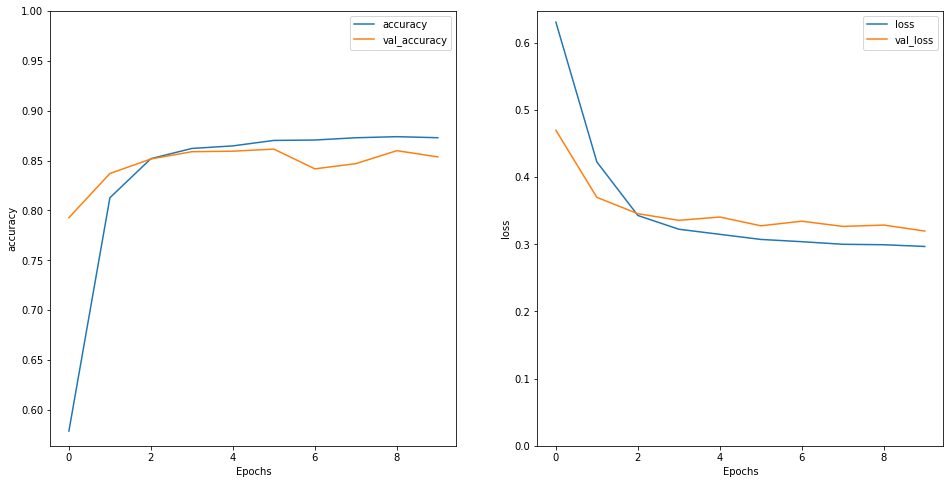

In [20]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [21]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](images/layered_bidirectional.png)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [22]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [24]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10


  1/391 [..............................] - ETA: 1:39:42 - loss: 0.6923 - accuracy: 0.5156

  2/391 [..............................] - ETA: 1:01 - loss: 0.6927 - accuracy: 0.4844   

  3/391 [..............................] - ETA: 1:00 - loss: 0.6926 - accuracy: 0.4896

  4/391 [..............................] - ETA: 57s - loss: 0.6929 - accuracy: 0.4688 

  5/391 [..............................] - ETA: 57s - loss: 0.6928 - accuracy: 0.4906

  6/391 [..............................] - ETA: 56s - loss: 0.6929 - accuracy: 0.4974

  7/391 [..............................] - ETA: 55s - loss: 0.6929 - accuracy: 0.5045

  8/391 [..............................] - ETA: 55s - loss: 0.6929 - accuracy: 0.5117

  9/391 [..............................] - ETA: 53s - loss: 0.6929 - accuracy: 0.5122

 10/391 [..............................] - ETA: 53s - loss: 0.6929 - accuracy: 0.5141

 11/391 [..............................] - ETA: 51s - loss: 0.6929 - accuracy: 0.5142

 12/391 [..............................] - ETA: 51s - loss: 0.6929 - accuracy: 0.5104

 13/391 [..............................] - ETA: 51s - loss: 0.6929 - accuracy: 0.5060

 14/391 [>.............................] - ETA: 51s - loss: 0.6929 - accuracy: 0.4989

 15/391 [>.............................] - ETA: 50s - loss: 0.6929 - accuracy: 0.5021

 16/391 [>.............................] - ETA: 49s - loss: 0.6930 - accuracy: 0.4980

 17/391 [>.............................] - ETA: 49s - loss: 0.6930 - accuracy: 0.5018

 18/391 [>.............................] - ETA: 49s - loss: 0.6930 - accuracy: 0.5026

 19/391 [>.............................] - ETA: 48s - loss: 0.6930 - accuracy: 0.5025

 20/391 [>.............................] - ETA: 48s - loss: 0.6931 - accuracy: 0.4953

 21/391 [>.............................] - ETA: 48s - loss: 0.6931 - accuracy: 0.5000

 22/391 [>.............................] - ETA: 49s - loss: 0.6931 - accuracy: 0.4993

 23/391 [>.............................] - ETA: 49s - loss: 0.6931 - accuracy: 0.4973

 24/391 [>.............................] - ETA: 49s - loss: 0.6931 - accuracy: 0.4961

 25/391 [>.............................] - ETA: 50s - loss: 0.6931 - accuracy: 0.4956

 26/391 [>.............................] - ETA: 49s - loss: 0.6931 - accuracy: 0.5012

 27/391 [=>............................] - ETA: 49s - loss: 0.6931 - accuracy: 0.5006

 28/391 [=>............................] - ETA: 48s - loss: 0.6932 - accuracy: 0.5039

 29/391 [=>............................] - ETA: 48s - loss: 0.6931 - accuracy: 0.5048

 30/391 [=>............................] - ETA: 48s - loss: 0.6931 - accuracy: 0.5031

 31/391 [=>............................] - ETA: 48s - loss: 0.6931 - accuracy: 0.5010

 32/391 [=>............................] - ETA: 48s - loss: 0.6931 - accuracy: 0.5024

 33/391 [=>............................] - ETA: 48s - loss: 0.6931 - accuracy: 0.5028

 34/391 [=>............................] - ETA: 48s - loss: 0.6931 - accuracy: 0.5037

 35/391 [=>............................] - ETA: 48s - loss: 0.6931 - accuracy: 0.5027

 36/391 [=>............................] - ETA: 48s - loss: 0.6931 - accuracy: 0.5030

 37/391 [=>............................] - ETA: 47s - loss: 0.6931 - accuracy: 0.5034

 38/391 [=>............................] - ETA: 47s - loss: 0.6931 - accuracy: 0.5012

 39/391 [=>............................] - ETA: 48s - loss: 0.6931 - accuracy: 0.5008

 40/391 [==>...........................] - ETA: 48s - loss: 0.6931 - accuracy: 0.4988

 41/391 [==>...........................] - ETA: 48s - loss: 0.6931 - accuracy: 0.4992

 42/391 [==>...........................] - ETA: 48s - loss: 0.6930 - accuracy: 0.4978

 43/391 [==>...........................] - ETA: 48s - loss: 0.6930 - accuracy: 0.4975

 44/391 [==>...........................] - ETA: 49s - loss: 0.6930 - accuracy: 0.4961

 45/391 [==>...........................] - ETA: 49s - loss: 0.6930 - accuracy: 0.4969

 46/391 [==>...........................] - ETA: 48s - loss: 0.6930 - accuracy: 0.4966

 47/391 [==>...........................] - ETA: 48s - loss: 0.6930 - accuracy: 0.4973

 48/391 [==>...........................] - ETA: 48s - loss: 0.6930 - accuracy: 0.4987

 49/391 [==>...........................] - ETA: 47s - loss: 0.6930 - accuracy: 0.4997

 50/391 [==>...........................] - ETA: 47s - loss: 0.6930 - accuracy: 0.4991

 51/391 [==>...........................] - ETA: 47s - loss: 0.6930 - accuracy: 0.4991

 52/391 [==>...........................] - ETA: 47s - loss: 0.6930 - accuracy: 0.5006

 53/391 [===>..........................] - ETA: 46s - loss: 0.6930 - accuracy: 0.5018

 54/391 [===>..........................] - ETA: 46s - loss: 0.6930 - accuracy: 0.5023

 55/391 [===>..........................] - ETA: 46s - loss: 0.6930 - accuracy: 0.5037

 56/391 [===>..........................] - ETA: 45s - loss: 0.6931 - accuracy: 0.5050

 57/391 [===>..........................] - ETA: 45s - loss: 0.6930 - accuracy: 0.5066

 58/391 [===>..........................] - ETA: 45s - loss: 0.6930 - accuracy: 0.5051

 59/391 [===>..........................] - ETA: 45s - loss: 0.6930 - accuracy: 0.5042

 60/391 [===>..........................] - ETA: 45s - loss: 0.6930 - accuracy: 0.5057

 61/391 [===>..........................] - ETA: 44s - loss: 0.6930 - accuracy: 0.5064

 62/391 [===>..........................] - ETA: 44s - loss: 0.6930 - accuracy: 0.5055

 63/391 [===>..........................] - ETA: 44s - loss: 0.6930 - accuracy: 0.5067

 64/391 [===>..........................] - ETA: 44s - loss: 0.6930 - accuracy: 0.5068

 65/391 [===>..........................] - ETA: 44s - loss: 0.6930 - accuracy: 0.5077

 66/391 [====>.........................] - ETA: 43s - loss: 0.6930 - accuracy: 0.5073

 67/391 [====>.........................] - ETA: 43s - loss: 0.6930 - accuracy: 0.5061

 68/391 [====>.........................] - ETA: 43s - loss: 0.6930 - accuracy: 0.5037

 69/391 [====>.........................] - ETA: 43s - loss: 0.6930 - accuracy: 0.5032

 70/391 [====>.........................] - ETA: 43s - loss: 0.6930 - accuracy: 0.5029

 71/391 [====>.........................] - ETA: 43s - loss: 0.6929 - accuracy: 0.5020

 72/391 [====>.........................] - ETA: 43s - loss: 0.6929 - accuracy: 0.5024

 73/391 [====>.........................] - ETA: 42s - loss: 0.6929 - accuracy: 0.5004

 74/391 [====>.........................] - ETA: 42s - loss: 0.6929 - accuracy: 0.5000

 75/391 [====>.........................] - ETA: 42s - loss: 0.6929 - accuracy: 0.4988

 76/391 [====>.........................] - ETA: 42s - loss: 0.6929 - accuracy: 0.4990

 77/391 [====>.........................] - ETA: 42s - loss: 0.6929 - accuracy: 0.4984

 78/391 [====>.........................] - ETA: 42s - loss: 0.6929 - accuracy: 0.4978

 79/391 [=====>........................] - ETA: 41s - loss: 0.6929 - accuracy: 0.4974

 80/391 [=====>........................] - ETA: 41s - loss: 0.6929 - accuracy: 0.4965

 81/391 [=====>........................] - ETA: 41s - loss: 0.6929 - accuracy: 0.4963

 82/391 [=====>........................] - ETA: 41s - loss: 0.6929 - accuracy: 0.4958

 83/391 [=====>........................] - ETA: 41s - loss: 0.6929 - accuracy: 0.4959

 84/391 [=====>........................] - ETA: 41s - loss: 0.6929 - accuracy: 0.4950

 85/391 [=====>........................] - ETA: 41s - loss: 0.6929 - accuracy: 0.4945

 86/391 [=====>........................] - ETA: 40s - loss: 0.6929 - accuracy: 0.4947

 87/391 [=====>........................] - ETA: 40s - loss: 0.6929 - accuracy: 0.4946

 88/391 [=====>........................] - ETA: 40s - loss: 0.6928 - accuracy: 0.4933

 89/391 [=====>........................] - ETA: 40s - loss: 0.6928 - accuracy: 0.4928

 90/391 [=====>........................] - ETA: 40s - loss: 0.6928 - accuracy: 0.4925

 91/391 [=====>........................] - ETA: 40s - loss: 0.6928 - accuracy: 0.4935

 92/391 [======>.......................] - ETA: 39s - loss: 0.6928 - accuracy: 0.4930

 93/391 [======>.......................] - ETA: 39s - loss: 0.6928 - accuracy: 0.4938

 94/391 [======>.......................] - ETA: 39s - loss: 0.6928 - accuracy: 0.4937

 95/391 [======>.......................] - ETA: 39s - loss: 0.6928 - accuracy: 0.4929

 96/391 [======>.......................] - ETA: 39s - loss: 0.6928 - accuracy: 0.4930

 97/391 [======>.......................] - ETA: 39s - loss: 0.6927 - accuracy: 0.4916

 98/391 [======>.......................] - ETA: 39s - loss: 0.6927 - accuracy: 0.4903

 99/391 [======>.......................] - ETA: 39s - loss: 0.6927 - accuracy: 0.4902

100/391 [======>.......................] - ETA: 38s - loss: 0.6927 - accuracy: 0.4895

101/391 [======>.......................] - ETA: 38s - loss: 0.6926 - accuracy: 0.4893

102/391 [======>.......................] - ETA: 38s - loss: 0.6926 - accuracy: 0.4887

103/391 [======>.......................] - ETA: 38s - loss: 0.6926 - accuracy: 0.4892

104/391 [======>.......................] - ETA: 38s - loss: 0.6926 - accuracy: 0.4886

105/391 [=======>......................] - ETA: 38s - loss: 0.6926 - accuracy: 0.4885

106/391 [=======>......................] - ETA: 38s - loss: 0.6926 - accuracy: 0.4881

107/391 [=======>......................] - ETA: 37s - loss: 0.6926 - accuracy: 0.4874

108/391 [=======>......................] - ETA: 37s - loss: 0.6926 - accuracy: 0.4876

109/391 [=======>......................] - ETA: 37s - loss: 0.6926 - accuracy: 0.4882

110/391 [=======>......................] - ETA: 37s - loss: 0.6926 - accuracy: 0.4893

111/391 [=======>......................] - ETA: 37s - loss: 0.6927 - accuracy: 0.4900

112/391 [=======>......................] - ETA: 37s - loss: 0.6927 - accuracy: 0.4898

113/391 [=======>......................] - ETA: 37s - loss: 0.6927 - accuracy: 0.4899

114/391 [=======>......................] - ETA: 36s - loss: 0.6926 - accuracy: 0.4894

115/391 [=======>......................] - ETA: 36s - loss: 0.6926 - accuracy: 0.4899

116/391 [=======>......................] - ETA: 36s - loss: 0.6926 - accuracy: 0.4900

117/391 [=======>......................] - ETA: 36s - loss: 0.6926 - accuracy: 0.4896

118/391 [========>.....................] - ETA: 36s - loss: 0.6927 - accuracy: 0.4903

119/391 [========>.....................] - ETA: 36s - loss: 0.6927 - accuracy: 0.4903

120/391 [========>.....................] - ETA: 36s - loss: 0.6927 - accuracy: 0.4902

121/391 [========>.....................] - ETA: 35s - loss: 0.6926 - accuracy: 0.4901

122/391 [========>.....................] - ETA: 35s - loss: 0.6926 - accuracy: 0.4898

123/391 [========>.....................] - ETA: 35s - loss: 0.6926 - accuracy: 0.4906

124/391 [========>.....................] - ETA: 35s - loss: 0.6927 - accuracy: 0.4911

125/391 [========>.....................] - ETA: 35s - loss: 0.6927 - accuracy: 0.4914

126/391 [========>.....................] - ETA: 35s - loss: 0.6927 - accuracy: 0.4916

127/391 [========>.....................] - ETA: 34s - loss: 0.6927 - accuracy: 0.4924

128/391 [========>.....................] - ETA: 34s - loss: 0.6927 - accuracy: 0.4928

129/391 [========>.....................] - ETA: 34s - loss: 0.6927 - accuracy: 0.4932

130/391 [========>.....................] - ETA: 34s - loss: 0.6927 - accuracy: 0.4934

131/391 [=========>....................] - ETA: 34s - loss: 0.6927 - accuracy: 0.4927

132/391 [=========>....................] - ETA: 34s - loss: 0.6927 - accuracy: 0.4924

133/391 [=========>....................] - ETA: 34s - loss: 0.6927 - accuracy: 0.4930

134/391 [=========>....................] - ETA: 34s - loss: 0.6927 - accuracy: 0.4937

135/391 [=========>....................] - ETA: 34s - loss: 0.6927 - accuracy: 0.4939

136/391 [=========>....................] - ETA: 33s - loss: 0.6927 - accuracy: 0.4944

137/391 [=========>....................] - ETA: 33s - loss: 0.6927 - accuracy: 0.4949

138/391 [=========>....................] - ETA: 33s - loss: 0.6927 - accuracy: 0.4951

139/391 [=========>....................] - ETA: 33s - loss: 0.6927 - accuracy: 0.4948

140/391 [=========>....................] - ETA: 33s - loss: 0.6927 - accuracy: 0.4950

141/391 [=========>....................] - ETA: 33s - loss: 0.6927 - accuracy: 0.4950

142/391 [=========>....................] - ETA: 33s - loss: 0.6926 - accuracy: 0.4947

143/391 [=========>....................] - ETA: 32s - loss: 0.6926 - accuracy: 0.4943

144/391 [==========>...................] - ETA: 32s - loss: 0.6926 - accuracy: 0.4945

145/391 [==========>...................] - ETA: 32s - loss: 0.6926 - accuracy: 0.4945

146/391 [==========>...................] - ETA: 32s - loss: 0.6926 - accuracy: 0.4950

147/391 [==========>...................] - ETA: 32s - loss: 0.6926 - accuracy: 0.4957

148/391 [==========>...................] - ETA: 32s - loss: 0.6926 - accuracy: 0.4956

149/391 [==========>...................] - ETA: 32s - loss: 0.6926 - accuracy: 0.4954

150/391 [==========>...................] - ETA: 32s - loss: 0.6926 - accuracy: 0.4961

151/391 [==========>...................] - ETA: 31s - loss: 0.6926 - accuracy: 0.4967

152/391 [==========>...................] - ETA: 31s - loss: 0.6926 - accuracy: 0.4962

153/391 [==========>...................] - ETA: 31s - loss: 0.6926 - accuracy: 0.4967

154/391 [==========>...................] - ETA: 31s - loss: 0.6926 - accuracy: 0.4968

155/391 [==========>...................] - ETA: 31s - loss: 0.6926 - accuracy: 0.4974

156/391 [==========>...................] - ETA: 31s - loss: 0.6926 - accuracy: 0.4974

157/391 [===========>..................] - ETA: 30s - loss: 0.6926 - accuracy: 0.4973

158/391 [===========>..................] - ETA: 30s - loss: 0.6926 - accuracy: 0.4978

159/391 [===========>..................] - ETA: 30s - loss: 0.6926 - accuracy: 0.4981

160/391 [===========>..................] - ETA: 30s - loss: 0.6926 - accuracy: 0.4978

161/391 [===========>..................] - ETA: 30s - loss: 0.6926 - accuracy: 0.4976

162/391 [===========>..................] - ETA: 30s - loss: 0.6926 - accuracy: 0.4977

163/391 [===========>..................] - ETA: 30s - loss: 0.6926 - accuracy: 0.4977

164/391 [===========>..................] - ETA: 29s - loss: 0.6926 - accuracy: 0.4975

165/391 [===========>..................] - ETA: 29s - loss: 0.6926 - accuracy: 0.4972

166/391 [===========>..................] - ETA: 29s - loss: 0.6926 - accuracy: 0.4970

167/391 [===========>..................] - ETA: 29s - loss: 0.6926 - accuracy: 0.4966

168/391 [===========>..................] - ETA: 29s - loss: 0.6925 - accuracy: 0.4966

169/391 [===========>..................] - ETA: 29s - loss: 0.6925 - accuracy: 0.4969

170/391 [============>.................] - ETA: 29s - loss: 0.6925 - accuracy: 0.4963

171/391 [============>.................] - ETA: 28s - loss: 0.6925 - accuracy: 0.4965

172/391 [============>.................] - ETA: 28s - loss: 0.6925 - accuracy: 0.4965

173/391 [============>.................] - ETA: 28s - loss: 0.6925 - accuracy: 0.4973

174/391 [============>.................] - ETA: 28s - loss: 0.6924 - accuracy: 0.4971

175/391 [============>.................] - ETA: 28s - loss: 0.6924 - accuracy: 0.4971

176/391 [============>.................] - ETA: 28s - loss: 0.6924 - accuracy: 0.4968

177/391 [============>.................] - ETA: 28s - loss: 0.6924 - accuracy: 0.4969

178/391 [============>.................] - ETA: 27s - loss: 0.6924 - accuracy: 0.4969

179/391 [============>.................] - ETA: 27s - loss: 0.6924 - accuracy: 0.4968

180/391 [============>.................] - ETA: 27s - loss: 0.6924 - accuracy: 0.4966

181/391 [============>.................] - ETA: 27s - loss: 0.6924 - accuracy: 0.4964

182/391 [============>.................] - ETA: 27s - loss: 0.6923 - accuracy: 0.4965

183/391 [=============>................] - ETA: 27s - loss: 0.6923 - accuracy: 0.4963

184/391 [=============>................] - ETA: 27s - loss: 0.6923 - accuracy: 0.4966

185/391 [=============>................] - ETA: 27s - loss: 0.6923 - accuracy: 0.4960

186/391 [=============>................] - ETA: 26s - loss: 0.6923 - accuracy: 0.4966

187/391 [=============>................] - ETA: 26s - loss: 0.6923 - accuracy: 0.4963

188/391 [=============>................] - ETA: 26s - loss: 0.6922 - accuracy: 0.4965

189/391 [=============>................] - ETA: 26s - loss: 0.6922 - accuracy: 0.4972

190/391 [=============>................] - ETA: 26s - loss: 0.6922 - accuracy: 0.4975

191/391 [=============>................] - ETA: 26s - loss: 0.6922 - accuracy: 0.4974

192/391 [=============>................] - ETA: 26s - loss: 0.6922 - accuracy: 0.4970

193/391 [=============>................] - ETA: 25s - loss: 0.6922 - accuracy: 0.4966

194/391 [=============>................] - ETA: 25s - loss: 0.6921 - accuracy: 0.4968

195/391 [=============>................] - ETA: 25s - loss: 0.6921 - accuracy: 0.4974

196/391 [==============>...............] - ETA: 25s - loss: 0.6921 - accuracy: 0.4972

197/391 [==============>...............] - ETA: 25s - loss: 0.6921 - accuracy: 0.4973

198/391 [==============>...............] - ETA: 25s - loss: 0.6920 - accuracy: 0.4973

199/391 [==============>...............] - ETA: 25s - loss: 0.6920 - accuracy: 0.4976

200/391 [==============>...............] - ETA: 25s - loss: 0.6920 - accuracy: 0.4972

201/391 [==============>...............] - ETA: 25s - loss: 0.6920 - accuracy: 0.4971

202/391 [==============>...............] - ETA: 24s - loss: 0.6920 - accuracy: 0.4969

203/391 [==============>...............] - ETA: 24s - loss: 0.6919 - accuracy: 0.4969

204/391 [==============>...............] - ETA: 24s - loss: 0.6919 - accuracy: 0.4967

205/391 [==============>...............] - ETA: 24s - loss: 0.6919 - accuracy: 0.4973

206/391 [==============>...............] - ETA: 24s - loss: 0.6919 - accuracy: 0.4973

207/391 [==============>...............] - ETA: 24s - loss: 0.6919 - accuracy: 0.4972

208/391 [==============>...............] - ETA: 24s - loss: 0.6918 - accuracy: 0.4972

209/391 [===============>..............] - ETA: 23s - loss: 0.6918 - accuracy: 0.4977

210/391 [===============>..............] - ETA: 23s - loss: 0.6918 - accuracy: 0.4980

211/391 [===============>..............] - ETA: 23s - loss: 0.6918 - accuracy: 0.4979

212/391 [===============>..............] - ETA: 23s - loss: 0.6917 - accuracy: 0.4981

213/391 [===============>..............] - ETA: 23s - loss: 0.6917 - accuracy: 0.4983

214/391 [===============>..............] - ETA: 23s - loss: 0.6917 - accuracy: 0.4978

215/391 [===============>..............] - ETA: 23s - loss: 0.6917 - accuracy: 0.4980

216/391 [===============>..............] - ETA: 23s - loss: 0.6916 - accuracy: 0.4982

217/391 [===============>..............] - ETA: 22s - loss: 0.6916 - accuracy: 0.4984

218/391 [===============>..............] - ETA: 22s - loss: 0.6915 - accuracy: 0.4984

219/391 [===============>..............] - ETA: 22s - loss: 0.6915 - accuracy: 0.4985

220/391 [===============>..............] - ETA: 22s - loss: 0.6915 - accuracy: 0.4985

221/391 [===============>..............] - ETA: 22s - loss: 0.6915 - accuracy: 0.4983

222/391 [================>.............] - ETA: 22s - loss: 0.6915 - accuracy: 0.4979

223/391 [================>.............] - ETA: 22s - loss: 0.6915 - accuracy: 0.4978

224/391 [================>.............] - ETA: 22s - loss: 0.6914 - accuracy: 0.4973

225/391 [================>.............] - ETA: 21s - loss: 0.6914 - accuracy: 0.4974

226/391 [================>.............] - ETA: 21s - loss: 0.6914 - accuracy: 0.4976

227/391 [================>.............] - ETA: 21s - loss: 0.6913 - accuracy: 0.4978

228/391 [================>.............] - ETA: 21s - loss: 0.6913 - accuracy: 0.4974

229/391 [================>.............] - ETA: 21s - loss: 0.6913 - accuracy: 0.4971

230/391 [================>.............] - ETA: 21s - loss: 0.6912 - accuracy: 0.4971

231/391 [================>.............] - ETA: 21s - loss: 0.6912 - accuracy: 0.4972

232/391 [================>.............] - ETA: 21s - loss: 0.6911 - accuracy: 0.4969

233/391 [================>.............] - ETA: 20s - loss: 0.6910 - accuracy: 0.4970

234/391 [================>.............] - ETA: 20s - loss: 0.6909 - accuracy: 0.4968

235/391 [=================>............] - ETA: 20s - loss: 0.6909 - accuracy: 0.4969

236/391 [=================>............] - ETA: 20s - loss: 0.6909 - accuracy: 0.4972

237/391 [=================>............] - ETA: 20s - loss: 0.6908 - accuracy: 0.4973

238/391 [=================>............] - ETA: 20s - loss: 0.6908 - accuracy: 0.4970

239/391 [=================>............] - ETA: 20s - loss: 0.6907 - accuracy: 0.4975

240/391 [=================>............] - ETA: 19s - loss: 0.6907 - accuracy: 0.4976

241/391 [=================>............] - ETA: 19s - loss: 0.6906 - accuracy: 0.4977

242/391 [=================>............] - ETA: 19s - loss: 0.6905 - accuracy: 0.4977

243/391 [=================>............] - ETA: 19s - loss: 0.6905 - accuracy: 0.4983

244/391 [=================>............] - ETA: 19s - loss: 0.6904 - accuracy: 0.4983

245/391 [=================>............] - ETA: 19s - loss: 0.6903 - accuracy: 0.4983

246/391 [=================>............] - ETA: 19s - loss: 0.6902 - accuracy: 0.4984

247/391 [=================>............] - ETA: 19s - loss: 0.6901 - accuracy: 0.4984

248/391 [==================>...........] - ETA: 18s - loss: 0.6900 - accuracy: 0.4984

249/391 [==================>...........] - ETA: 18s - loss: 0.6899 - accuracy: 0.4983

250/391 [==================>...........] - ETA: 18s - loss: 0.6898 - accuracy: 0.4982

251/391 [==================>...........] - ETA: 18s - loss: 0.6898 - accuracy: 0.4982

252/391 [==================>...........] - ETA: 18s - loss: 0.6897 - accuracy: 0.4981

253/391 [==================>...........] - ETA: 18s - loss: 0.6895 - accuracy: 0.4977

254/391 [==================>...........] - ETA: 18s - loss: 0.6893 - accuracy: 0.4979

255/391 [==================>...........] - ETA: 18s - loss: 0.6893 - accuracy: 0.4981

256/391 [==================>...........] - ETA: 17s - loss: 0.6893 - accuracy: 0.4987

257/391 [==================>...........] - ETA: 17s - loss: 0.6891 - accuracy: 0.4990

258/391 [==================>...........] - ETA: 17s - loss: 0.6890 - accuracy: 0.4990

259/391 [==================>...........] - ETA: 17s - loss: 0.6887 - accuracy: 0.4988

260/391 [==================>...........] - ETA: 17s - loss: 0.6885 - accuracy: 0.4986

261/391 [===================>..........] - ETA: 17s - loss: 0.6883 - accuracy: 0.4987

262/391 [===================>..........] - ETA: 17s - loss: 0.6881 - accuracy: 0.4990

263/391 [===================>..........] - ETA: 16s - loss: 0.6878 - accuracy: 0.4994

264/391 [===================>..........] - ETA: 16s - loss: 0.6874 - accuracy: 0.4993

265/391 [===================>..........] - ETA: 16s - loss: 0.6873 - accuracy: 0.4991

266/391 [===================>..........] - ETA: 16s - loss: 0.6868 - accuracy: 0.4997

267/391 [===================>..........] - ETA: 16s - loss: 0.6866 - accuracy: 0.5004

268/391 [===================>..........] - ETA: 16s - loss: 0.6865 - accuracy: 0.5011

269/391 [===================>..........] - ETA: 16s - loss: 0.6861 - accuracy: 0.5017

270/391 [===================>..........] - ETA: 15s - loss: 0.6855 - accuracy: 0.5024

271/391 [===================>..........] - ETA: 15s - loss: 0.6853 - accuracy: 0.5027

272/391 [===================>..........] - ETA: 15s - loss: 0.6848 - accuracy: 0.5034

273/391 [===================>..........] - ETA: 15s - loss: 0.6847 - accuracy: 0.5037

274/391 [====================>.........] - ETA: 15s - loss: 0.6844 - accuracy: 0.5044

275/391 [====================>.........] - ETA: 15s - loss: 0.6838 - accuracy: 0.5055

276/391 [====================>.........] - ETA: 15s - loss: 0.6831 - accuracy: 0.5065

277/391 [====================>.........] - ETA: 15s - loss: 0.6826 - accuracy: 0.5072

278/391 [====================>.........] - ETA: 14s - loss: 0.6822 - accuracy: 0.5077

279/391 [====================>.........] - ETA: 14s - loss: 0.6816 - accuracy: 0.5086

280/391 [====================>.........] - ETA: 14s - loss: 0.6821 - accuracy: 0.5090

281/391 [====================>.........] - ETA: 14s - loss: 0.6824 - accuracy: 0.5095

282/391 [====================>.........] - ETA: 14s - loss: 0.6820 - accuracy: 0.5101

283/391 [====================>.........] - ETA: 14s - loss: 0.6813 - accuracy: 0.5112

284/391 [====================>.........] - ETA: 14s - loss: 0.6808 - accuracy: 0.5119

285/391 [====================>.........] - ETA: 13s - loss: 0.6804 - accuracy: 0.5126

286/391 [====================>.........] - ETA: 13s - loss: 0.6801 - accuracy: 0.5131

287/391 [=====================>........] - ETA: 13s - loss: 0.6796 - accuracy: 0.5140

288/391 [=====================>........] - ETA: 13s - loss: 0.6787 - accuracy: 0.5149

289/391 [=====================>........] - ETA: 13s - loss: 0.6783 - accuracy: 0.5156

290/391 [=====================>........] - ETA: 13s - loss: 0.6776 - accuracy: 0.5165

291/391 [=====================>........] - ETA: 13s - loss: 0.6771 - accuracy: 0.5172

292/391 [=====================>........] - ETA: 13s - loss: 0.6765 - accuracy: 0.5181

293/391 [=====================>........] - ETA: 12s - loss: 0.6760 - accuracy: 0.5190

294/391 [=====================>........] - ETA: 12s - loss: 0.6754 - accuracy: 0.5201

295/391 [=====================>........] - ETA: 12s - loss: 0.6752 - accuracy: 0.5207

296/391 [=====================>........] - ETA: 12s - loss: 0.6749 - accuracy: 0.5213

297/391 [=====================>........] - ETA: 12s - loss: 0.6742 - accuracy: 0.5221

298/391 [=====================>........] - ETA: 12s - loss: 0.6734 - accuracy: 0.5230

299/391 [=====================>........] - ETA: 12s - loss: 0.6729 - accuracy: 0.5237

300/391 [======================>.......] - ETA: 11s - loss: 0.6726 - accuracy: 0.5241

301/391 [======================>.......] - ETA: 11s - loss: 0.6718 - accuracy: 0.5251

302/391 [======================>.......] - ETA: 11s - loss: 0.6712 - accuracy: 0.5258

303/391 [======================>.......] - ETA: 11s - loss: 0.6705 - accuracy: 0.5267

304/391 [======================>.......] - ETA: 11s - loss: 0.6705 - accuracy: 0.5271

305/391 [======================>.......] - ETA: 11s - loss: 0.6699 - accuracy: 0.5278

306/391 [======================>.......] - ETA: 11s - loss: 0.6693 - accuracy: 0.5285

307/391 [======================>.......] - ETA: 11s - loss: 0.6687 - accuracy: 0.5295

308/391 [======================>.......] - ETA: 10s - loss: 0.6682 - accuracy: 0.5304

309/391 [======================>.......] - ETA: 10s - loss: 0.6677 - accuracy: 0.5311

310/391 [======================>.......] - ETA: 10s - loss: 0.6670 - accuracy: 0.5323

311/391 [======================>.......] - ETA: 10s - loss: 0.6663 - accuracy: 0.5331

312/391 [======================>.......] - ETA: 10s - loss: 0.6657 - accuracy: 0.5339

313/391 [=======================>......] - ETA: 10s - loss: 0.6651 - accuracy: 0.5347

314/391 [=======================>......] - ETA: 10s - loss: 0.6642 - accuracy: 0.5356

315/391 [=======================>......] - ETA: 10s - loss: 0.6638 - accuracy: 0.5364

316/391 [=======================>......] - ETA: 9s - loss: 0.6633 - accuracy: 0.5369 

317/391 [=======================>......] - ETA: 9s - loss: 0.6626 - accuracy: 0.5379

318/391 [=======================>......] - ETA: 9s - loss: 0.6621 - accuracy: 0.5387

319/391 [=======================>......] - ETA: 9s - loss: 0.6616 - accuracy: 0.5394

320/391 [=======================>......] - ETA: 9s - loss: 0.6611 - accuracy: 0.5401

321/391 [=======================>......] - ETA: 9s - loss: 0.6604 - accuracy: 0.5409

322/391 [=======================>......] - ETA: 9s - loss: 0.6599 - accuracy: 0.5417

323/391 [=======================>......] - ETA: 8s - loss: 0.6592 - accuracy: 0.5424

324/391 [=======================>......] - ETA: 8s - loss: 0.6587 - accuracy: 0.5432

325/391 [=======================>......] - ETA: 8s - loss: 0.6582 - accuracy: 0.5437

326/391 [========================>.....] - ETA: 8s - loss: 0.6575 - accuracy: 0.5447

327/391 [========================>.....] - ETA: 8s - loss: 0.6569 - accuracy: 0.5455

328/391 [========================>.....] - ETA: 8s - loss: 0.6562 - accuracy: 0.5462

329/391 [========================>.....] - ETA: 8s - loss: 0.6557 - accuracy: 0.5467

330/391 [========================>.....] - ETA: 8s - loss: 0.6554 - accuracy: 0.5473

331/391 [========================>.....] - ETA: 7s - loss: 0.6549 - accuracy: 0.5479

332/391 [========================>.....] - ETA: 7s - loss: 0.6541 - accuracy: 0.5489

333/391 [========================>.....] - ETA: 7s - loss: 0.6536 - accuracy: 0.5496

334/391 [========================>.....] - ETA: 7s - loss: 0.6532 - accuracy: 0.5501

335/391 [========================>.....] - ETA: 7s - loss: 0.6524 - accuracy: 0.5510

336/391 [========================>.....] - ETA: 7s - loss: 0.6517 - accuracy: 0.5519

337/391 [========================>.....] - ETA: 7s - loss: 0.6511 - accuracy: 0.5528

338/391 [========================>.....] - ETA: 6s - loss: 0.6500 - accuracy: 0.5538

339/391 [=========================>....] - ETA: 6s - loss: 0.6494 - accuracy: 0.5544

340/391 [=========================>....] - ETA: 6s - loss: 0.6485 - accuracy: 0.5553

341/391 [=========================>....] - ETA: 6s - loss: 0.6478 - accuracy: 0.5561

342/391 [=========================>....] - ETA: 6s - loss: 0.6470 - accuracy: 0.5569

343/391 [=========================>....] - ETA: 6s - loss: 0.6467 - accuracy: 0.5575

344/391 [=========================>....] - ETA: 6s - loss: 0.6461 - accuracy: 0.5585

345/391 [=========================>....] - ETA: 6s - loss: 0.6457 - accuracy: 0.5591

346/391 [=========================>....] - ETA: 5s - loss: 0.6450 - accuracy: 0.5598

347/391 [=========================>....] - ETA: 5s - loss: 0.6444 - accuracy: 0.5606

348/391 [=========================>....] - ETA: 5s - loss: 0.6441 - accuracy: 0.5612

349/391 [=========================>....] - ETA: 5s - loss: 0.6435 - accuracy: 0.5620

350/391 [=========================>....] - ETA: 5s - loss: 0.6431 - accuracy: 0.5627

351/391 [=========================>....] - ETA: 5s - loss: 0.6426 - accuracy: 0.5632

352/391 [==========================>...] - ETA: 5s - loss: 0.6415 - accuracy: 0.5643

353/391 [==========================>...] - ETA: 5s - loss: 0.6411 - accuracy: 0.5650

354/391 [==========================>...] - ETA: 4s - loss: 0.6408 - accuracy: 0.5655

355/391 [==========================>...] - ETA: 4s - loss: 0.6402 - accuracy: 0.5663

356/391 [==========================>...] - ETA: 4s - loss: 0.6397 - accuracy: 0.5672

357/391 [==========================>...] - ETA: 4s - loss: 0.6390 - accuracy: 0.5679

358/391 [==========================>...] - ETA: 4s - loss: 0.6392 - accuracy: 0.5683

359/391 [==========================>...] - ETA: 4s - loss: 0.6386 - accuracy: 0.5689

360/391 [==========================>...] - ETA: 4s - loss: 0.6380 - accuracy: 0.5695

361/391 [==========================>...] - ETA: 3s - loss: 0.6380 - accuracy: 0.5698

362/391 [==========================>...] - ETA: 3s - loss: 0.6374 - accuracy: 0.5704

363/391 [==========================>...] - ETA: 3s - loss: 0.6367 - accuracy: 0.5711

364/391 [==========================>...] - ETA: 3s - loss: 0.6361 - accuracy: 0.5718

365/391 [===========================>..] - ETA: 3s - loss: 0.6357 - accuracy: 0.5721

366/391 [===========================>..] - ETA: 3s - loss: 0.6348 - accuracy: 0.5730

367/391 [===========================>..] - ETA: 3s - loss: 0.6342 - accuracy: 0.5737

368/391 [===========================>..] - ETA: 3s - loss: 0.6341 - accuracy: 0.5741

369/391 [===========================>..] - ETA: 2s - loss: 0.6337 - accuracy: 0.5747

370/391 [===========================>..] - ETA: 2s - loss: 0.6329 - accuracy: 0.5755

371/391 [===========================>..] - ETA: 2s - loss: 0.6328 - accuracy: 0.5759

372/391 [===========================>..] - ETA: 2s - loss: 0.6324 - accuracy: 0.5765

373/391 [===========================>..] - ETA: 2s - loss: 0.6318 - accuracy: 0.5773

374/391 [===========================>..] - ETA: 2s - loss: 0.6314 - accuracy: 0.5778

375/391 [===========================>..] - ETA: 2s - loss: 0.6309 - accuracy: 0.5784

376/391 [===========================>..] - ETA: 1s - loss: 0.6308 - accuracy: 0.5788

377/391 [===========================>..] - ETA: 1s - loss: 0.6305 - accuracy: 0.5791

378/391 [============================>.] - ETA: 1s - loss: 0.6298 - accuracy: 0.5797

379/391 [============================>.] - ETA: 1s - loss: 0.6290 - accuracy: 0.5805

380/391 [============================>.] - ETA: 1s - loss: 0.6287 - accuracy: 0.5809

381/391 [============================>.] - ETA: 1s - loss: 0.6283 - accuracy: 0.5816

382/391 [============================>.] - ETA: 1s - loss: 0.6285 - accuracy: 0.5819

383/391 [============================>.] - ETA: 1s - loss: 0.6285 - accuracy: 0.5822

384/391 [============================>.] - ETA: 0s - loss: 0.6282 - accuracy: 0.5824

385/391 [============================>.] - ETA: 0s - loss: 0.6275 - accuracy: 0.5832

386/391 [============================>.] - ETA: 0s - loss: 0.6271 - accuracy: 0.5838

387/391 [============================>.] - ETA: 0s - loss: 0.6267 - accuracy: 0.5842

388/391 [============================>.] - ETA: 0s - loss: 0.6263 - accuracy: 0.5846

389/391 [============================>.] - ETA: 0s - loss: 0.6260 - accuracy: 0.5850

390/391 [============================>.] - ETA: 0s - loss: 0.6256 - accuracy: 0.5856

391/391 [==============================] - ETA: 0s - loss: 0.6253 - accuracy: 0.5859

391/391 [==============================] - 73s 149ms/step - loss: 0.6253 - accuracy: 0.5859 - val_loss: 0.4572 - val_accuracy: 0.7734


Epoch 2/10


  1/391 [..............................] - ETA: 4:40 - loss: 0.4288 - accuracy: 0.7969

  2/391 [..............................] - ETA: 54s - loss: 0.3976 - accuracy: 0.8125 

  3/391 [..............................] - ETA: 56s - loss: 0.4046 - accuracy: 0.8229

  4/391 [..............................] - ETA: 52s - loss: 0.4142 - accuracy: 0.8359

  5/391 [..............................] - ETA: 52s - loss: 0.4128 - accuracy: 0.8375

  6/391 [..............................] - ETA: 50s - loss: 0.4321 - accuracy: 0.8229

  7/391 [..............................] - ETA: 1:03 - loss: 0.4218 - accuracy: 0.8326

  8/391 [..............................] - ETA: 1:01 - loss: 0.4269 - accuracy: 0.8301

  9/391 [..............................] - ETA: 59s - loss: 0.4295 - accuracy: 0.8229 

 10/391 [..............................] - ETA: 58s - loss: 0.4309 - accuracy: 0.8219

 11/391 [..............................] - ETA: 57s - loss: 0.4380 - accuracy: 0.8196

 12/391 [..............................] - ETA: 56s - loss: 0.4395 - accuracy: 0.8099

 13/391 [..............................] - ETA: 56s - loss: 0.4457 - accuracy: 0.8065

 14/391 [>.............................] - ETA: 55s - loss: 0.4469 - accuracy: 0.8036

 15/391 [>.............................] - ETA: 54s - loss: 0.4503 - accuracy: 0.8052

 16/391 [>.............................] - ETA: 53s - loss: 0.4490 - accuracy: 0.8037

 17/391 [>.............................] - ETA: 53s - loss: 0.4477 - accuracy: 0.8042

 18/391 [>.............................] - ETA: 53s - loss: 0.4485 - accuracy: 0.8038

 19/391 [>.............................] - ETA: 52s - loss: 0.4464 - accuracy: 0.8051

 20/391 [>.............................] - ETA: 52s - loss: 0.4450 - accuracy: 0.8039

 21/391 [>.............................] - ETA: 52s - loss: 0.4471 - accuracy: 0.8036

 22/391 [>.............................] - ETA: 52s - loss: 0.4425 - accuracy: 0.8068

 23/391 [>.............................] - ETA: 51s - loss: 0.4398 - accuracy: 0.8077

 24/391 [>.............................] - ETA: 51s - loss: 0.4396 - accuracy: 0.8086

 25/391 [>.............................] - ETA: 51s - loss: 0.4362 - accuracy: 0.8125

 26/391 [>.............................] - ETA: 51s - loss: 0.4375 - accuracy: 0.8107

 27/391 [=>............................] - ETA: 50s - loss: 0.4359 - accuracy: 0.8113

 28/391 [=>............................] - ETA: 50s - loss: 0.4331 - accuracy: 0.8125

 29/391 [=>............................] - ETA: 50s - loss: 0.4288 - accuracy: 0.8141

 30/391 [=>............................] - ETA: 50s - loss: 0.4300 - accuracy: 0.8141

 31/391 [=>............................] - ETA: 49s - loss: 0.4278 - accuracy: 0.8165

 32/391 [=>............................] - ETA: 49s - loss: 0.4270 - accuracy: 0.8179

 33/391 [=>............................] - ETA: 49s - loss: 0.4334 - accuracy: 0.8144

 34/391 [=>............................] - ETA: 49s - loss: 0.4380 - accuracy: 0.8120

 35/391 [=>............................] - ETA: 48s - loss: 0.4355 - accuracy: 0.8138

 36/391 [=>............................] - ETA: 48s - loss: 0.4337 - accuracy: 0.8147

 37/391 [=>............................] - ETA: 48s - loss: 0.4350 - accuracy: 0.8133

 38/391 [=>............................] - ETA: 48s - loss: 0.4338 - accuracy: 0.8125

 39/391 [=>............................] - ETA: 48s - loss: 0.4313 - accuracy: 0.8141

 40/391 [==>...........................] - ETA: 48s - loss: 0.4312 - accuracy: 0.8137

 41/391 [==>...........................] - ETA: 47s - loss: 0.4293 - accuracy: 0.8148

 42/391 [==>...........................] - ETA: 47s - loss: 0.4303 - accuracy: 0.8129

 43/391 [==>...........................] - ETA: 47s - loss: 0.4306 - accuracy: 0.8129

 44/391 [==>...........................] - ETA: 47s - loss: 0.4270 - accuracy: 0.8157

 45/391 [==>...........................] - ETA: 47s - loss: 0.4292 - accuracy: 0.8139

 46/391 [==>...........................] - ETA: 47s - loss: 0.4276 - accuracy: 0.8145

 47/391 [==>...........................] - ETA: 47s - loss: 0.4253 - accuracy: 0.8152

 48/391 [==>...........................] - ETA: 46s - loss: 0.4247 - accuracy: 0.8151

 49/391 [==>...........................] - ETA: 46s - loss: 0.4268 - accuracy: 0.8141

 50/391 [==>...........................] - ETA: 46s - loss: 0.4273 - accuracy: 0.8141

 51/391 [==>...........................] - ETA: 46s - loss: 0.4266 - accuracy: 0.8153

 52/391 [==>...........................] - ETA: 46s - loss: 0.4252 - accuracy: 0.8158

 53/391 [===>..........................] - ETA: 45s - loss: 0.4243 - accuracy: 0.8172

 54/391 [===>..........................] - ETA: 45s - loss: 0.4223 - accuracy: 0.8183

 55/391 [===>..........................] - ETA: 45s - loss: 0.4225 - accuracy: 0.8179

 56/391 [===>..........................] - ETA: 45s - loss: 0.4249 - accuracy: 0.8161

 57/391 [===>..........................] - ETA: 44s - loss: 0.4252 - accuracy: 0.8152

 58/391 [===>..........................] - ETA: 44s - loss: 0.4232 - accuracy: 0.8163

 59/391 [===>..........................] - ETA: 44s - loss: 0.4250 - accuracy: 0.8146

 60/391 [===>..........................] - ETA: 44s - loss: 0.4252 - accuracy: 0.8146

 61/391 [===>..........................] - ETA: 44s - loss: 0.4243 - accuracy: 0.8151

 62/391 [===>..........................] - ETA: 44s - loss: 0.4235 - accuracy: 0.8160

 63/391 [===>..........................] - ETA: 43s - loss: 0.4233 - accuracy: 0.8170

 64/391 [===>..........................] - ETA: 43s - loss: 0.4239 - accuracy: 0.8162

 65/391 [===>..........................] - ETA: 43s - loss: 0.4232 - accuracy: 0.8173

 66/391 [====>.........................] - ETA: 43s - loss: 0.4245 - accuracy: 0.8170

 67/391 [====>.........................] - ETA: 43s - loss: 0.4243 - accuracy: 0.8169

 68/391 [====>.........................] - ETA: 43s - loss: 0.4240 - accuracy: 0.8171

 69/391 [====>.........................] - ETA: 43s - loss: 0.4243 - accuracy: 0.8168

 70/391 [====>.........................] - ETA: 43s - loss: 0.4230 - accuracy: 0.8172

 71/391 [====>.........................] - ETA: 43s - loss: 0.4239 - accuracy: 0.8167

 72/391 [====>.........................] - ETA: 43s - loss: 0.4239 - accuracy: 0.8166

 73/391 [====>.........................] - ETA: 43s - loss: 0.4237 - accuracy: 0.8166

 74/391 [====>.........................] - ETA: 43s - loss: 0.4212 - accuracy: 0.8180

 75/391 [====>.........................] - ETA: 42s - loss: 0.4212 - accuracy: 0.8177

 76/391 [====>.........................] - ETA: 42s - loss: 0.4200 - accuracy: 0.8189

 77/391 [====>.........................] - ETA: 42s - loss: 0.4184 - accuracy: 0.8200

 78/391 [====>.........................] - ETA: 42s - loss: 0.4186 - accuracy: 0.8199

 79/391 [=====>........................] - ETA: 42s - loss: 0.4202 - accuracy: 0.8192

 80/391 [=====>........................] - ETA: 42s - loss: 0.4207 - accuracy: 0.8191

 81/391 [=====>........................] - ETA: 42s - loss: 0.4196 - accuracy: 0.8193

 82/391 [=====>........................] - ETA: 41s - loss: 0.4189 - accuracy: 0.8194

 83/391 [=====>........................] - ETA: 41s - loss: 0.4199 - accuracy: 0.8181

 84/391 [=====>........................] - ETA: 41s - loss: 0.4196 - accuracy: 0.8177

 85/391 [=====>........................] - ETA: 41s - loss: 0.4187 - accuracy: 0.8180

 86/391 [=====>........................] - ETA: 41s - loss: 0.4189 - accuracy: 0.8172

 87/391 [=====>........................] - ETA: 40s - loss: 0.4190 - accuracy: 0.8173

 88/391 [=====>........................] - ETA: 40s - loss: 0.4196 - accuracy: 0.8175

 89/391 [=====>........................] - ETA: 40s - loss: 0.4191 - accuracy: 0.8179

 90/391 [=====>........................] - ETA: 40s - loss: 0.4197 - accuracy: 0.8181

 91/391 [=====>........................] - ETA: 40s - loss: 0.4201 - accuracy: 0.8177

 92/391 [======>.......................] - ETA: 40s - loss: 0.4196 - accuracy: 0.8179

 93/391 [======>.......................] - ETA: 39s - loss: 0.4190 - accuracy: 0.8184

 94/391 [======>.......................] - ETA: 39s - loss: 0.4200 - accuracy: 0.8178

 95/391 [======>.......................] - ETA: 39s - loss: 0.4190 - accuracy: 0.8181

 96/391 [======>.......................] - ETA: 39s - loss: 0.4185 - accuracy: 0.8185

 97/391 [======>.......................] - ETA: 39s - loss: 0.4185 - accuracy: 0.8181

 98/391 [======>.......................] - ETA: 39s - loss: 0.4203 - accuracy: 0.8171

 99/391 [======>.......................] - ETA: 39s - loss: 0.4202 - accuracy: 0.8168

100/391 [======>.......................] - ETA: 38s - loss: 0.4184 - accuracy: 0.8180

101/391 [======>.......................] - ETA: 38s - loss: 0.4180 - accuracy: 0.8181

102/391 [======>.......................] - ETA: 38s - loss: 0.4172 - accuracy: 0.8186

103/391 [======>.......................] - ETA: 38s - loss: 0.4172 - accuracy: 0.8189

104/391 [======>.......................] - ETA: 38s - loss: 0.4187 - accuracy: 0.8185

105/391 [=======>......................] - ETA: 38s - loss: 0.4184 - accuracy: 0.8188

106/391 [=======>......................] - ETA: 38s - loss: 0.4185 - accuracy: 0.8187

107/391 [=======>......................] - ETA: 38s - loss: 0.4176 - accuracy: 0.8188

108/391 [=======>......................] - ETA: 37s - loss: 0.4183 - accuracy: 0.8181

109/391 [=======>......................] - ETA: 37s - loss: 0.4181 - accuracy: 0.8184

110/391 [=======>......................] - ETA: 37s - loss: 0.4182 - accuracy: 0.8185

111/391 [=======>......................] - ETA: 37s - loss: 0.4194 - accuracy: 0.8176

112/391 [=======>......................] - ETA: 37s - loss: 0.4187 - accuracy: 0.8175

113/391 [=======>......................] - ETA: 37s - loss: 0.4183 - accuracy: 0.8172

114/391 [=======>......................] - ETA: 37s - loss: 0.4183 - accuracy: 0.8170

115/391 [=======>......................] - ETA: 36s - loss: 0.4182 - accuracy: 0.8170

116/391 [=======>......................] - ETA: 36s - loss: 0.4183 - accuracy: 0.8167

117/391 [=======>......................] - ETA: 36s - loss: 0.4176 - accuracy: 0.8170

118/391 [========>.....................] - ETA: 36s - loss: 0.4174 - accuracy: 0.8171

119/391 [========>.....................] - ETA: 36s - loss: 0.4175 - accuracy: 0.8170

120/391 [========>.....................] - ETA: 36s - loss: 0.4176 - accuracy: 0.8169

121/391 [========>.....................] - ETA: 36s - loss: 0.4169 - accuracy: 0.8174

122/391 [========>.....................] - ETA: 35s - loss: 0.4165 - accuracy: 0.8176

123/391 [========>.....................] - ETA: 35s - loss: 0.4163 - accuracy: 0.8172

124/391 [========>.....................] - ETA: 35s - loss: 0.4175 - accuracy: 0.8167

125/391 [========>.....................] - ETA: 35s - loss: 0.4171 - accuracy: 0.8169

126/391 [========>.....................] - ETA: 35s - loss: 0.4167 - accuracy: 0.8172

127/391 [========>.....................] - ETA: 35s - loss: 0.4161 - accuracy: 0.8174

128/391 [========>.....................] - ETA: 34s - loss: 0.4154 - accuracy: 0.8177

129/391 [========>.....................] - ETA: 34s - loss: 0.4154 - accuracy: 0.8180

130/391 [========>.....................] - ETA: 34s - loss: 0.4159 - accuracy: 0.8175

131/391 [=========>....................] - ETA: 34s - loss: 0.4152 - accuracy: 0.8177

132/391 [=========>....................] - ETA: 34s - loss: 0.4157 - accuracy: 0.8170

133/391 [=========>....................] - ETA: 34s - loss: 0.4149 - accuracy: 0.8171

134/391 [=========>....................] - ETA: 34s - loss: 0.4145 - accuracy: 0.8170

135/391 [=========>....................] - ETA: 34s - loss: 0.4140 - accuracy: 0.8168

136/391 [=========>....................] - ETA: 34s - loss: 0.4132 - accuracy: 0.8176

137/391 [=========>....................] - ETA: 33s - loss: 0.4133 - accuracy: 0.8176

138/391 [=========>....................] - ETA: 33s - loss: 0.4134 - accuracy: 0.8178

139/391 [=========>....................] - ETA: 33s - loss: 0.4137 - accuracy: 0.8179

140/391 [=========>....................] - ETA: 33s - loss: 0.4133 - accuracy: 0.8181

141/391 [=========>....................] - ETA: 33s - loss: 0.4138 - accuracy: 0.8179

142/391 [=========>....................] - ETA: 33s - loss: 0.4135 - accuracy: 0.8182

143/391 [=========>....................] - ETA: 32s - loss: 0.4130 - accuracy: 0.8184

144/391 [==========>...................] - ETA: 32s - loss: 0.4130 - accuracy: 0.8185

145/391 [==========>...................] - ETA: 32s - loss: 0.4128 - accuracy: 0.8185

146/391 [==========>...................] - ETA: 32s - loss: 0.4131 - accuracy: 0.8179

147/391 [==========>...................] - ETA: 32s - loss: 0.4131 - accuracy: 0.8177

148/391 [==========>...................] - ETA: 32s - loss: 0.4124 - accuracy: 0.8178

149/391 [==========>...................] - ETA: 32s - loss: 0.4126 - accuracy: 0.8169

150/391 [==========>...................] - ETA: 32s - loss: 0.4118 - accuracy: 0.8172

151/391 [==========>...................] - ETA: 31s - loss: 0.4112 - accuracy: 0.8175

152/391 [==========>...................] - ETA: 31s - loss: 0.4112 - accuracy: 0.8173

153/391 [==========>...................] - ETA: 31s - loss: 0.4112 - accuracy: 0.8173

154/391 [==========>...................] - ETA: 31s - loss: 0.4115 - accuracy: 0.8174

155/391 [==========>...................] - ETA: 31s - loss: 0.4114 - accuracy: 0.8171

156/391 [==========>...................] - ETA: 31s - loss: 0.4110 - accuracy: 0.8175

157/391 [===========>..................] - ETA: 31s - loss: 0.4109 - accuracy: 0.8177

158/391 [===========>..................] - ETA: 30s - loss: 0.4103 - accuracy: 0.8181

159/391 [===========>..................] - ETA: 30s - loss: 0.4102 - accuracy: 0.8182

160/391 [===========>..................] - ETA: 30s - loss: 0.4101 - accuracy: 0.8181

161/391 [===========>..................] - ETA: 30s - loss: 0.4103 - accuracy: 0.8179

162/391 [===========>..................] - ETA: 30s - loss: 0.4098 - accuracy: 0.8180

163/391 [===========>..................] - ETA: 30s - loss: 0.4104 - accuracy: 0.8173

164/391 [===========>..................] - ETA: 30s - loss: 0.4103 - accuracy: 0.8174

165/391 [===========>..................] - ETA: 29s - loss: 0.4097 - accuracy: 0.8175

166/391 [===========>..................] - ETA: 29s - loss: 0.4099 - accuracy: 0.8175

167/391 [===========>..................] - ETA: 29s - loss: 0.4094 - accuracy: 0.8176

168/391 [===========>..................] - ETA: 29s - loss: 0.4096 - accuracy: 0.8175

169/391 [===========>..................] - ETA: 29s - loss: 0.4089 - accuracy: 0.8182

170/391 [============>.................] - ETA: 29s - loss: 0.4087 - accuracy: 0.8186

171/391 [============>.................] - ETA: 29s - loss: 0.4084 - accuracy: 0.8186

172/391 [============>.................] - ETA: 28s - loss: 0.4087 - accuracy: 0.8185

173/391 [============>.................] - ETA: 28s - loss: 0.4089 - accuracy: 0.8186

174/391 [============>.................] - ETA: 28s - loss: 0.4086 - accuracy: 0.8191

175/391 [============>.................] - ETA: 28s - loss: 0.4083 - accuracy: 0.8190

176/391 [============>.................] - ETA: 28s - loss: 0.4091 - accuracy: 0.8188

177/391 [============>.................] - ETA: 28s - loss: 0.4090 - accuracy: 0.8188

178/391 [============>.................] - ETA: 28s - loss: 0.4086 - accuracy: 0.8190

179/391 [============>.................] - ETA: 28s - loss: 0.4087 - accuracy: 0.8190

180/391 [============>.................] - ETA: 28s - loss: 0.4086 - accuracy: 0.8194

181/391 [============>.................] - ETA: 27s - loss: 0.4085 - accuracy: 0.8194

182/391 [============>.................] - ETA: 27s - loss: 0.4083 - accuracy: 0.8194

183/391 [=============>................] - ETA: 27s - loss: 0.4078 - accuracy: 0.8196

184/391 [=============>................] - ETA: 27s - loss: 0.4076 - accuracy: 0.8197

185/391 [=============>................] - ETA: 27s - loss: 0.4079 - accuracy: 0.8198

186/391 [=============>................] - ETA: 27s - loss: 0.4077 - accuracy: 0.8198

187/391 [=============>................] - ETA: 27s - loss: 0.4072 - accuracy: 0.8201

188/391 [=============>................] - ETA: 27s - loss: 0.4066 - accuracy: 0.8202

189/391 [=============>................] - ETA: 26s - loss: 0.4069 - accuracy: 0.8199

190/391 [=============>................] - ETA: 26s - loss: 0.4073 - accuracy: 0.8199

191/391 [=============>................] - ETA: 26s - loss: 0.4072 - accuracy: 0.8199

192/391 [=============>................] - ETA: 26s - loss: 0.4069 - accuracy: 0.8203

193/391 [=============>................] - ETA: 26s - loss: 0.4073 - accuracy: 0.8203

194/391 [=============>................] - ETA: 26s - loss: 0.4072 - accuracy: 0.8205

195/391 [=============>................] - ETA: 26s - loss: 0.4067 - accuracy: 0.8208

196/391 [==============>...............] - ETA: 26s - loss: 0.4070 - accuracy: 0.8202

197/391 [==============>...............] - ETA: 25s - loss: 0.4069 - accuracy: 0.8203

198/391 [==============>...............] - ETA: 25s - loss: 0.4061 - accuracy: 0.8209

199/391 [==============>...............] - ETA: 25s - loss: 0.4058 - accuracy: 0.8210

200/391 [==============>...............] - ETA: 25s - loss: 0.4052 - accuracy: 0.8214

201/391 [==============>...............] - ETA: 25s - loss: 0.4055 - accuracy: 0.8214

202/391 [==============>...............] - ETA: 25s - loss: 0.4057 - accuracy: 0.8213

203/391 [==============>...............] - ETA: 25s - loss: 0.4057 - accuracy: 0.8214

204/391 [==============>...............] - ETA: 24s - loss: 0.4051 - accuracy: 0.8215

205/391 [==============>...............] - ETA: 24s - loss: 0.4049 - accuracy: 0.8216

206/391 [==============>...............] - ETA: 24s - loss: 0.4050 - accuracy: 0.8218

207/391 [==============>...............] - ETA: 24s - loss: 0.4048 - accuracy: 0.8219

208/391 [==============>...............] - ETA: 24s - loss: 0.4047 - accuracy: 0.8220

209/391 [===============>..............] - ETA: 24s - loss: 0.4042 - accuracy: 0.8222

210/391 [===============>..............] - ETA: 24s - loss: 0.4043 - accuracy: 0.8223

211/391 [===============>..............] - ETA: 23s - loss: 0.4043 - accuracy: 0.8224

212/391 [===============>..............] - ETA: 23s - loss: 0.4037 - accuracy: 0.8226

213/391 [===============>..............] - ETA: 23s - loss: 0.4035 - accuracy: 0.8228

214/391 [===============>..............] - ETA: 23s - loss: 0.4029 - accuracy: 0.8229

215/391 [===============>..............] - ETA: 23s - loss: 0.4023 - accuracy: 0.8234

216/391 [===============>..............] - ETA: 23s - loss: 0.4025 - accuracy: 0.8232

217/391 [===============>..............] - ETA: 23s - loss: 0.4024 - accuracy: 0.8232

218/391 [===============>..............] - ETA: 22s - loss: 0.4023 - accuracy: 0.8234

219/391 [===============>..............] - ETA: 22s - loss: 0.4023 - accuracy: 0.8233

220/391 [===============>..............] - ETA: 22s - loss: 0.4022 - accuracy: 0.8233

221/391 [===============>..............] - ETA: 22s - loss: 0.4020 - accuracy: 0.8236

222/391 [================>.............] - ETA: 22s - loss: 0.4020 - accuracy: 0.8237

223/391 [================>.............] - ETA: 22s - loss: 0.4022 - accuracy: 0.8236

224/391 [================>.............] - ETA: 22s - loss: 0.4021 - accuracy: 0.8237

225/391 [================>.............] - ETA: 22s - loss: 0.4021 - accuracy: 0.8235

226/391 [================>.............] - ETA: 21s - loss: 0.4022 - accuracy: 0.8234

227/391 [================>.............] - ETA: 21s - loss: 0.4020 - accuracy: 0.8237

228/391 [================>.............] - ETA: 21s - loss: 0.4019 - accuracy: 0.8237

229/391 [================>.............] - ETA: 21s - loss: 0.4018 - accuracy: 0.8236

230/391 [================>.............] - ETA: 21s - loss: 0.4014 - accuracy: 0.8239

231/391 [================>.............] - ETA: 21s - loss: 0.4017 - accuracy: 0.8237

232/391 [================>.............] - ETA: 21s - loss: 0.4023 - accuracy: 0.8232

233/391 [================>.............] - ETA: 20s - loss: 0.4023 - accuracy: 0.8230

234/391 [================>.............] - ETA: 20s - loss: 0.4020 - accuracy: 0.8229

235/391 [=================>............] - ETA: 20s - loss: 0.4015 - accuracy: 0.8232

236/391 [=================>............] - ETA: 20s - loss: 0.4012 - accuracy: 0.8233

237/391 [=================>............] - ETA: 20s - loss: 0.4009 - accuracy: 0.8235

238/391 [=================>............] - ETA: 20s - loss: 0.4005 - accuracy: 0.8239

239/391 [=================>............] - ETA: 20s - loss: 0.4006 - accuracy: 0.8239

240/391 [=================>............] - ETA: 19s - loss: 0.4007 - accuracy: 0.8242

241/391 [=================>............] - ETA: 19s - loss: 0.4003 - accuracy: 0.8246

242/391 [=================>............] - ETA: 19s - loss: 0.4003 - accuracy: 0.8246

243/391 [=================>............] - ETA: 19s - loss: 0.4005 - accuracy: 0.8245

244/391 [=================>............] - ETA: 19s - loss: 0.3999 - accuracy: 0.8247

245/391 [=================>............] - ETA: 19s - loss: 0.3997 - accuracy: 0.8246

246/391 [=================>............] - ETA: 19s - loss: 0.3995 - accuracy: 0.8245

247/391 [=================>............] - ETA: 18s - loss: 0.3990 - accuracy: 0.8246

248/391 [==================>...........] - ETA: 18s - loss: 0.3988 - accuracy: 0.8248

249/391 [==================>...........] - ETA: 18s - loss: 0.3979 - accuracy: 0.8253

250/391 [==================>...........] - ETA: 18s - loss: 0.3982 - accuracy: 0.8251

251/391 [==================>...........] - ETA: 18s - loss: 0.3983 - accuracy: 0.8248

252/391 [==================>...........] - ETA: 18s - loss: 0.3980 - accuracy: 0.8250

253/391 [==================>...........] - ETA: 18s - loss: 0.3977 - accuracy: 0.8251

254/391 [==================>...........] - ETA: 18s - loss: 0.3970 - accuracy: 0.8254

255/391 [==================>...........] - ETA: 17s - loss: 0.3970 - accuracy: 0.8254

256/391 [==================>...........] - ETA: 17s - loss: 0.3970 - accuracy: 0.8253

257/391 [==================>...........] - ETA: 17s - loss: 0.3965 - accuracy: 0.8256

258/391 [==================>...........] - ETA: 17s - loss: 0.3962 - accuracy: 0.8256

259/391 [==================>...........] - ETA: 17s - loss: 0.3957 - accuracy: 0.8259

260/391 [==================>...........] - ETA: 17s - loss: 0.3954 - accuracy: 0.8261

261/391 [===================>..........] - ETA: 17s - loss: 0.3952 - accuracy: 0.8261

262/391 [===================>..........] - ETA: 17s - loss: 0.3947 - accuracy: 0.8264

263/391 [===================>..........] - ETA: 16s - loss: 0.3945 - accuracy: 0.8265

264/391 [===================>..........] - ETA: 16s - loss: 0.3942 - accuracy: 0.8266

265/391 [===================>..........] - ETA: 16s - loss: 0.3942 - accuracy: 0.8267

266/391 [===================>..........] - ETA: 16s - loss: 0.3942 - accuracy: 0.8265

267/391 [===================>..........] - ETA: 16s - loss: 0.3937 - accuracy: 0.8268

268/391 [===================>..........] - ETA: 16s - loss: 0.3935 - accuracy: 0.8270

269/391 [===================>..........] - ETA: 16s - loss: 0.3932 - accuracy: 0.8272

270/391 [===================>..........] - ETA: 15s - loss: 0.3935 - accuracy: 0.8272

271/391 [===================>..........] - ETA: 15s - loss: 0.3936 - accuracy: 0.8272

272/391 [===================>..........] - ETA: 15s - loss: 0.3934 - accuracy: 0.8274

273/391 [===================>..........] - ETA: 15s - loss: 0.3935 - accuracy: 0.8274

274/391 [====================>.........] - ETA: 15s - loss: 0.3931 - accuracy: 0.8276

275/391 [====================>.........] - ETA: 15s - loss: 0.3928 - accuracy: 0.8278

276/391 [====================>.........] - ETA: 15s - loss: 0.3925 - accuracy: 0.8278

277/391 [====================>.........] - ETA: 15s - loss: 0.3927 - accuracy: 0.8276

278/391 [====================>.........] - ETA: 14s - loss: 0.3925 - accuracy: 0.8277

279/391 [====================>.........] - ETA: 14s - loss: 0.3919 - accuracy: 0.8280

280/391 [====================>.........] - ETA: 14s - loss: 0.3921 - accuracy: 0.8278

281/391 [====================>.........] - ETA: 14s - loss: 0.3917 - accuracy: 0.8282

282/391 [====================>.........] - ETA: 14s - loss: 0.3918 - accuracy: 0.8282

283/391 [====================>.........] - ETA: 14s - loss: 0.3918 - accuracy: 0.8282

284/391 [====================>.........] - ETA: 14s - loss: 0.3918 - accuracy: 0.8281

285/391 [====================>.........] - ETA: 13s - loss: 0.3916 - accuracy: 0.8282

286/391 [====================>.........] - ETA: 13s - loss: 0.3913 - accuracy: 0.8286

287/391 [=====================>........] - ETA: 13s - loss: 0.3910 - accuracy: 0.8289

288/391 [=====================>........] - ETA: 13s - loss: 0.3908 - accuracy: 0.8292

289/391 [=====================>........] - ETA: 13s - loss: 0.3903 - accuracy: 0.8294

290/391 [=====================>........] - ETA: 13s - loss: 0.3908 - accuracy: 0.8292

291/391 [=====================>........] - ETA: 13s - loss: 0.3910 - accuracy: 0.8291

292/391 [=====================>........] - ETA: 13s - loss: 0.3910 - accuracy: 0.8291

293/391 [=====================>........] - ETA: 12s - loss: 0.3906 - accuracy: 0.8294

294/391 [=====================>........] - ETA: 12s - loss: 0.3909 - accuracy: 0.8293

295/391 [=====================>........] - ETA: 12s - loss: 0.3909 - accuracy: 0.8293

296/391 [=====================>........] - ETA: 12s - loss: 0.3907 - accuracy: 0.8293

297/391 [=====================>........] - ETA: 12s - loss: 0.3915 - accuracy: 0.8291

298/391 [=====================>........] - ETA: 12s - loss: 0.3913 - accuracy: 0.8292

299/391 [=====================>........] - ETA: 12s - loss: 0.3911 - accuracy: 0.8292

300/391 [======================>.......] - ETA: 11s - loss: 0.3917 - accuracy: 0.8290

301/391 [======================>.......] - ETA: 11s - loss: 0.3916 - accuracy: 0.8290

302/391 [======================>.......] - ETA: 11s - loss: 0.3915 - accuracy: 0.8291

303/391 [======================>.......] - ETA: 11s - loss: 0.3913 - accuracy: 0.8292

304/391 [======================>.......] - ETA: 11s - loss: 0.3910 - accuracy: 0.8293

305/391 [======================>.......] - ETA: 11s - loss: 0.3910 - accuracy: 0.8293

306/391 [======================>.......] - ETA: 11s - loss: 0.3910 - accuracy: 0.8294

307/391 [======================>.......] - ETA: 11s - loss: 0.3907 - accuracy: 0.8296

308/391 [======================>.......] - ETA: 10s - loss: 0.3907 - accuracy: 0.8295

309/391 [======================>.......] - ETA: 10s - loss: 0.3903 - accuracy: 0.8298

310/391 [======================>.......] - ETA: 10s - loss: 0.3904 - accuracy: 0.8297

311/391 [======================>.......] - ETA: 10s - loss: 0.3905 - accuracy: 0.8297

312/391 [======================>.......] - ETA: 10s - loss: 0.3904 - accuracy: 0.8295

313/391 [=======================>......] - ETA: 10s - loss: 0.3901 - accuracy: 0.8297

314/391 [=======================>......] - ETA: 10s - loss: 0.3898 - accuracy: 0.8299

315/391 [=======================>......] - ETA: 10s - loss: 0.3898 - accuracy: 0.8300

316/391 [=======================>......] - ETA: 9s - loss: 0.3897 - accuracy: 0.8300 

317/391 [=======================>......] - ETA: 9s - loss: 0.3896 - accuracy: 0.8301

318/391 [=======================>......] - ETA: 9s - loss: 0.3895 - accuracy: 0.8302

319/391 [=======================>......] - ETA: 9s - loss: 0.3897 - accuracy: 0.8301

320/391 [=======================>......] - ETA: 9s - loss: 0.3895 - accuracy: 0.8302

321/391 [=======================>......] - ETA: 9s - loss: 0.3895 - accuracy: 0.8303

322/391 [=======================>......] - ETA: 9s - loss: 0.3895 - accuracy: 0.8303

323/391 [=======================>......] - ETA: 8s - loss: 0.3893 - accuracy: 0.8304

324/391 [=======================>......] - ETA: 8s - loss: 0.3892 - accuracy: 0.8304

325/391 [=======================>......] - ETA: 8s - loss: 0.3890 - accuracy: 0.8306

326/391 [========================>.....] - ETA: 8s - loss: 0.3886 - accuracy: 0.8308

327/391 [========================>.....] - ETA: 8s - loss: 0.3889 - accuracy: 0.8307

328/391 [========================>.....] - ETA: 8s - loss: 0.3889 - accuracy: 0.8307

329/391 [========================>.....] - ETA: 8s - loss: 0.3888 - accuracy: 0.8307

330/391 [========================>.....] - ETA: 8s - loss: 0.3887 - accuracy: 0.8307

331/391 [========================>.....] - ETA: 7s - loss: 0.3884 - accuracy: 0.8308

332/391 [========================>.....] - ETA: 7s - loss: 0.3883 - accuracy: 0.8309

333/391 [========================>.....] - ETA: 7s - loss: 0.3882 - accuracy: 0.8307

334/391 [========================>.....] - ETA: 7s - loss: 0.3884 - accuracy: 0.8307

335/391 [========================>.....] - ETA: 7s - loss: 0.3881 - accuracy: 0.8310

336/391 [========================>.....] - ETA: 7s - loss: 0.3880 - accuracy: 0.8311

337/391 [========================>.....] - ETA: 7s - loss: 0.3883 - accuracy: 0.8308

338/391 [========================>.....] - ETA: 6s - loss: 0.3886 - accuracy: 0.8305

339/391 [=========================>....] - ETA: 6s - loss: 0.3885 - accuracy: 0.8307

340/391 [=========================>....] - ETA: 6s - loss: 0.3884 - accuracy: 0.8308

341/391 [=========================>....] - ETA: 6s - loss: 0.3882 - accuracy: 0.8309

342/391 [=========================>....] - ETA: 6s - loss: 0.3881 - accuracy: 0.8310

343/391 [=========================>....] - ETA: 6s - loss: 0.3878 - accuracy: 0.8312

344/391 [=========================>....] - ETA: 6s - loss: 0.3879 - accuracy: 0.8311

345/391 [=========================>....] - ETA: 6s - loss: 0.3879 - accuracy: 0.8311

346/391 [=========================>....] - ETA: 5s - loss: 0.3874 - accuracy: 0.8313

347/391 [=========================>....] - ETA: 5s - loss: 0.3874 - accuracy: 0.8312

348/391 [=========================>....] - ETA: 5s - loss: 0.3876 - accuracy: 0.8311

349/391 [=========================>....] - ETA: 5s - loss: 0.3874 - accuracy: 0.8313

350/391 [=========================>....] - ETA: 5s - loss: 0.3876 - accuracy: 0.8312

351/391 [=========================>....] - ETA: 5s - loss: 0.3874 - accuracy: 0.8313

352/391 [==========================>...] - ETA: 5s - loss: 0.3872 - accuracy: 0.8315

353/391 [==========================>...] - ETA: 5s - loss: 0.3869 - accuracy: 0.8317

354/391 [==========================>...] - ETA: 4s - loss: 0.3868 - accuracy: 0.8318

355/391 [==========================>...] - ETA: 4s - loss: 0.3867 - accuracy: 0.8319

356/391 [==========================>...] - ETA: 4s - loss: 0.3867 - accuracy: 0.8318

357/391 [==========================>...] - ETA: 4s - loss: 0.3869 - accuracy: 0.8315

358/391 [==========================>...] - ETA: 4s - loss: 0.3870 - accuracy: 0.8313

359/391 [==========================>...] - ETA: 4s - loss: 0.3865 - accuracy: 0.8314

360/391 [==========================>...] - ETA: 4s - loss: 0.3866 - accuracy: 0.8312

361/391 [==========================>...] - ETA: 3s - loss: 0.3868 - accuracy: 0.8312

362/391 [==========================>...] - ETA: 3s - loss: 0.3866 - accuracy: 0.8313

363/391 [==========================>...] - ETA: 3s - loss: 0.3865 - accuracy: 0.8314

364/391 [==========================>...] - ETA: 3s - loss: 0.3864 - accuracy: 0.8316

365/391 [===========================>..] - ETA: 3s - loss: 0.3861 - accuracy: 0.8318

366/391 [===========================>..] - ETA: 3s - loss: 0.3863 - accuracy: 0.8315

367/391 [===========================>..] - ETA: 3s - loss: 0.3862 - accuracy: 0.8315

368/391 [===========================>..] - ETA: 3s - loss: 0.3862 - accuracy: 0.8314

369/391 [===========================>..] - ETA: 2s - loss: 0.3861 - accuracy: 0.8314

370/391 [===========================>..] - ETA: 2s - loss: 0.3860 - accuracy: 0.8313

371/391 [===========================>..] - ETA: 2s - loss: 0.3862 - accuracy: 0.8312

372/391 [===========================>..] - ETA: 2s - loss: 0.3862 - accuracy: 0.8312

373/391 [===========================>..] - ETA: 2s - loss: 0.3858 - accuracy: 0.8315

374/391 [===========================>..] - ETA: 2s - loss: 0.3856 - accuracy: 0.8316

375/391 [===========================>..] - ETA: 2s - loss: 0.3858 - accuracy: 0.8315

376/391 [===========================>..] - ETA: 1s - loss: 0.3855 - accuracy: 0.8317

377/391 [===========================>..] - ETA: 1s - loss: 0.3854 - accuracy: 0.8318

378/391 [============================>.] - ETA: 1s - loss: 0.3851 - accuracy: 0.8318

379/391 [============================>.] - ETA: 1s - loss: 0.3852 - accuracy: 0.8317

380/391 [============================>.] - ETA: 1s - loss: 0.3851 - accuracy: 0.8318

381/391 [============================>.] - ETA: 1s - loss: 0.3849 - accuracy: 0.8319

382/391 [============================>.] - ETA: 1s - loss: 0.3846 - accuracy: 0.8320

383/391 [============================>.] - ETA: 1s - loss: 0.3845 - accuracy: 0.8320

384/391 [============================>.] - ETA: 0s - loss: 0.3844 - accuracy: 0.8319

385/391 [============================>.] - ETA: 0s - loss: 0.3844 - accuracy: 0.8320

386/391 [============================>.] - ETA: 0s - loss: 0.3842 - accuracy: 0.8319

387/391 [============================>.] - ETA: 0s - loss: 0.3843 - accuracy: 0.8319

388/391 [============================>.] - ETA: 0s - loss: 0.3844 - accuracy: 0.8318

389/391 [============================>.] - ETA: 0s - loss: 0.3843 - accuracy: 0.8320

390/391 [============================>.] - ETA: 0s - loss: 0.3840 - accuracy: 0.8321

391/391 [==============================] - ETA: 0s - loss: 0.3838 - accuracy: 0.8322

391/391 [==============================] - 55s 138ms/step - loss: 0.3838 - accuracy: 0.8322 - val_loss: 0.3487 - val_accuracy: 0.8542


Epoch 3/10


  1/391 [..............................] - ETA: 5:20 - loss: 0.3099 - accuracy: 0.8438

  2/391 [..............................] - ETA: 54s - loss: 0.3690 - accuracy: 0.8281 

  3/391 [..............................] - ETA: 54s - loss: 0.3341 - accuracy: 0.8594

  4/391 [..............................] - ETA: 52s - loss: 0.3503 - accuracy: 0.8359

  5/391 [..............................] - ETA: 52s - loss: 0.3444 - accuracy: 0.8438

  6/391 [..............................] - ETA: 51s - loss: 0.3451 - accuracy: 0.8411

  7/391 [..............................] - ETA: 52s - loss: 0.3309 - accuracy: 0.8527

  8/391 [..............................] - ETA: 51s - loss: 0.3400 - accuracy: 0.8555

  9/391 [..............................] - ETA: 51s - loss: 0.3385 - accuracy: 0.8524

 10/391 [..............................] - ETA: 51s - loss: 0.3345 - accuracy: 0.8516

 11/391 [..............................] - ETA: 50s - loss: 0.3383 - accuracy: 0.8494

 12/391 [..............................] - ETA: 50s - loss: 0.3359 - accuracy: 0.8542

 13/391 [..............................] - ETA: 50s - loss: 0.3301 - accuracy: 0.8582

 14/391 [>.............................] - ETA: 49s - loss: 0.3347 - accuracy: 0.8571

 15/391 [>.............................] - ETA: 49s - loss: 0.3536 - accuracy: 0.8490

 16/391 [>.............................] - ETA: 49s - loss: 0.3549 - accuracy: 0.8467

 17/391 [>.............................] - ETA: 49s - loss: 0.3510 - accuracy: 0.8511

 18/391 [>.............................] - ETA: 48s - loss: 0.3645 - accuracy: 0.8455

 19/391 [>.............................] - ETA: 48s - loss: 0.3634 - accuracy: 0.8429

 20/391 [>.............................] - ETA: 47s - loss: 0.3665 - accuracy: 0.8414

 21/391 [>.............................] - ETA: 47s - loss: 0.3648 - accuracy: 0.8423

 22/391 [>.............................] - ETA: 47s - loss: 0.3639 - accuracy: 0.8395

 23/391 [>.............................] - ETA: 47s - loss: 0.3612 - accuracy: 0.8404

 24/391 [>.............................] - ETA: 47s - loss: 0.3625 - accuracy: 0.8379

 25/391 [>.............................] - ETA: 47s - loss: 0.3652 - accuracy: 0.8369

 26/391 [>.............................] - ETA: 47s - loss: 0.3651 - accuracy: 0.8365

 27/391 [=>............................] - ETA: 47s - loss: 0.3620 - accuracy: 0.8374

 28/391 [=>............................] - ETA: 46s - loss: 0.3610 - accuracy: 0.8387

 29/391 [=>............................] - ETA: 46s - loss: 0.3588 - accuracy: 0.8405

 30/391 [=>............................] - ETA: 46s - loss: 0.3607 - accuracy: 0.8391

 31/391 [=>............................] - ETA: 46s - loss: 0.3599 - accuracy: 0.8392

 32/391 [=>............................] - ETA: 46s - loss: 0.3601 - accuracy: 0.8379

 33/391 [=>............................] - ETA: 46s - loss: 0.3607 - accuracy: 0.8390

 34/391 [=>............................] - ETA: 46s - loss: 0.3594 - accuracy: 0.8392

 35/391 [=>............................] - ETA: 46s - loss: 0.3575 - accuracy: 0.8406

 36/391 [=>............................] - ETA: 45s - loss: 0.3557 - accuracy: 0.8416

 37/391 [=>............................] - ETA: 45s - loss: 0.3566 - accuracy: 0.8408

 38/391 [=>............................] - ETA: 45s - loss: 0.3539 - accuracy: 0.8421

 39/391 [=>............................] - ETA: 45s - loss: 0.3547 - accuracy: 0.8417

 40/391 [==>...........................] - ETA: 45s - loss: 0.3536 - accuracy: 0.8430

 41/391 [==>...........................] - ETA: 45s - loss: 0.3551 - accuracy: 0.8411

 42/391 [==>...........................] - ETA: 45s - loss: 0.3525 - accuracy: 0.8426

 43/391 [==>...........................] - ETA: 45s - loss: 0.3515 - accuracy: 0.8441

 44/391 [==>...........................] - ETA: 45s - loss: 0.3505 - accuracy: 0.8452

 45/391 [==>...........................] - ETA: 45s - loss: 0.3491 - accuracy: 0.8462

 46/391 [==>...........................] - ETA: 45s - loss: 0.3506 - accuracy: 0.8461

 47/391 [==>...........................] - ETA: 45s - loss: 0.3505 - accuracy: 0.8457

 48/391 [==>...........................] - ETA: 45s - loss: 0.3531 - accuracy: 0.8454

 49/391 [==>...........................] - ETA: 44s - loss: 0.3521 - accuracy: 0.8460

 50/391 [==>...........................] - ETA: 44s - loss: 0.3510 - accuracy: 0.8456

 51/391 [==>...........................] - ETA: 44s - loss: 0.3497 - accuracy: 0.8468

 52/391 [==>...........................] - ETA: 45s - loss: 0.3484 - accuracy: 0.8477

 53/391 [===>..........................] - ETA: 44s - loss: 0.3506 - accuracy: 0.8464

 54/391 [===>..........................] - ETA: 44s - loss: 0.3489 - accuracy: 0.8475

 55/391 [===>..........................] - ETA: 44s - loss: 0.3491 - accuracy: 0.8460

 56/391 [===>..........................] - ETA: 44s - loss: 0.3483 - accuracy: 0.8463

 57/391 [===>..........................] - ETA: 44s - loss: 0.3489 - accuracy: 0.8465

 58/391 [===>..........................] - ETA: 44s - loss: 0.3475 - accuracy: 0.8464

 59/391 [===>..........................] - ETA: 44s - loss: 0.3490 - accuracy: 0.8453

 60/391 [===>..........................] - ETA: 44s - loss: 0.3512 - accuracy: 0.8445

 61/391 [===>..........................] - ETA: 43s - loss: 0.3504 - accuracy: 0.8448

 62/391 [===>..........................] - ETA: 43s - loss: 0.3494 - accuracy: 0.8458

 63/391 [===>..........................] - ETA: 43s - loss: 0.3488 - accuracy: 0.8462

 64/391 [===>..........................] - ETA: 43s - loss: 0.3485 - accuracy: 0.8464

 65/391 [===>..........................] - ETA: 43s - loss: 0.3479 - accuracy: 0.8462

 66/391 [====>.........................] - ETA: 43s - loss: 0.3479 - accuracy: 0.8461

 67/391 [====>.........................] - ETA: 42s - loss: 0.3472 - accuracy: 0.8461

 68/391 [====>.........................] - ETA: 42s - loss: 0.3488 - accuracy: 0.8456

 69/391 [====>.........................] - ETA: 42s - loss: 0.3476 - accuracy: 0.8460

 70/391 [====>.........................] - ETA: 42s - loss: 0.3476 - accuracy: 0.8467

 71/391 [====>.........................] - ETA: 42s - loss: 0.3463 - accuracy: 0.8479

 72/391 [====>.........................] - ETA: 42s - loss: 0.3458 - accuracy: 0.8485

 73/391 [====>.........................] - ETA: 42s - loss: 0.3471 - accuracy: 0.8480

 74/391 [====>.........................] - ETA: 42s - loss: 0.3462 - accuracy: 0.8480

 75/391 [====>.........................] - ETA: 41s - loss: 0.3455 - accuracy: 0.8483

 76/391 [====>.........................] - ETA: 41s - loss: 0.3456 - accuracy: 0.8483

 77/391 [====>.........................] - ETA: 41s - loss: 0.3463 - accuracy: 0.8474

 78/391 [====>.........................] - ETA: 41s - loss: 0.3478 - accuracy: 0.8464

 79/391 [=====>........................] - ETA: 41s - loss: 0.3477 - accuracy: 0.8465

 80/391 [=====>........................] - ETA: 41s - loss: 0.3480 - accuracy: 0.8463

 81/391 [=====>........................] - ETA: 40s - loss: 0.3485 - accuracy: 0.8463

 82/391 [=====>........................] - ETA: 40s - loss: 0.3490 - accuracy: 0.8460

 83/391 [=====>........................] - ETA: 40s - loss: 0.3480 - accuracy: 0.8470

 84/391 [=====>........................] - ETA: 40s - loss: 0.3482 - accuracy: 0.8465

 85/391 [=====>........................] - ETA: 40s - loss: 0.3480 - accuracy: 0.8469

 86/391 [=====>........................] - ETA: 39s - loss: 0.3494 - accuracy: 0.8461

 87/391 [=====>........................] - ETA: 39s - loss: 0.3477 - accuracy: 0.8466

 88/391 [=====>........................] - ETA: 39s - loss: 0.3476 - accuracy: 0.8468

 89/391 [=====>........................] - ETA: 39s - loss: 0.3470 - accuracy: 0.8471

 90/391 [=====>........................] - ETA: 39s - loss: 0.3473 - accuracy: 0.8470

 91/391 [=====>........................] - ETA: 39s - loss: 0.3464 - accuracy: 0.8479

 92/391 [======>.......................] - ETA: 39s - loss: 0.3462 - accuracy: 0.8483

 93/391 [======>.......................] - ETA: 39s - loss: 0.3462 - accuracy: 0.8485

 94/391 [======>.......................] - ETA: 39s - loss: 0.3451 - accuracy: 0.8489

 95/391 [======>.......................] - ETA: 38s - loss: 0.3458 - accuracy: 0.8480

 96/391 [======>.......................] - ETA: 38s - loss: 0.3450 - accuracy: 0.8485

 97/391 [======>.......................] - ETA: 38s - loss: 0.3453 - accuracy: 0.8486

 98/391 [======>.......................] - ETA: 38s - loss: 0.3451 - accuracy: 0.8489

 99/391 [======>.......................] - ETA: 38s - loss: 0.3456 - accuracy: 0.8483

100/391 [======>.......................] - ETA: 38s - loss: 0.3451 - accuracy: 0.8484

101/391 [======>.......................] - ETA: 37s - loss: 0.3454 - accuracy: 0.8484

102/391 [======>.......................] - ETA: 37s - loss: 0.3443 - accuracy: 0.8491

103/391 [======>.......................] - ETA: 37s - loss: 0.3446 - accuracy: 0.8491

104/391 [======>.......................] - ETA: 37s - loss: 0.3447 - accuracy: 0.8492

105/391 [=======>......................] - ETA: 37s - loss: 0.3448 - accuracy: 0.8490

106/391 [=======>......................] - ETA: 37s - loss: 0.3453 - accuracy: 0.8488

107/391 [=======>......................] - ETA: 37s - loss: 0.3443 - accuracy: 0.8484

108/391 [=======>......................] - ETA: 37s - loss: 0.3431 - accuracy: 0.8490

109/391 [=======>......................] - ETA: 36s - loss: 0.3431 - accuracy: 0.8491

110/391 [=======>......................] - ETA: 36s - loss: 0.3430 - accuracy: 0.8497

111/391 [=======>......................] - ETA: 36s - loss: 0.3427 - accuracy: 0.8501

112/391 [=======>......................] - ETA: 36s - loss: 0.3430 - accuracy: 0.8496

113/391 [=======>......................] - ETA: 36s - loss: 0.3431 - accuracy: 0.8496

114/391 [=======>......................] - ETA: 36s - loss: 0.3428 - accuracy: 0.8501

115/391 [=======>......................] - ETA: 36s - loss: 0.3431 - accuracy: 0.8500

116/391 [=======>......................] - ETA: 35s - loss: 0.3425 - accuracy: 0.8501

117/391 [=======>......................] - ETA: 35s - loss: 0.3423 - accuracy: 0.8500

118/391 [========>.....................] - ETA: 35s - loss: 0.3417 - accuracy: 0.8506

119/391 [========>.....................] - ETA: 35s - loss: 0.3414 - accuracy: 0.8504

120/391 [========>.....................] - ETA: 35s - loss: 0.3403 - accuracy: 0.8510

121/391 [========>.....................] - ETA: 35s - loss: 0.3400 - accuracy: 0.8514

122/391 [========>.....................] - ETA: 35s - loss: 0.3395 - accuracy: 0.8513

123/391 [========>.....................] - ETA: 34s - loss: 0.3395 - accuracy: 0.8511

124/391 [========>.....................] - ETA: 34s - loss: 0.3395 - accuracy: 0.8511

125/391 [========>.....................] - ETA: 34s - loss: 0.3392 - accuracy: 0.8514

126/391 [========>.....................] - ETA: 34s - loss: 0.3387 - accuracy: 0.8516

127/391 [========>.....................] - ETA: 34s - loss: 0.3387 - accuracy: 0.8511

128/391 [========>.....................] - ETA: 34s - loss: 0.3389 - accuracy: 0.8510

129/391 [========>.....................] - ETA: 34s - loss: 0.3389 - accuracy: 0.8510

130/391 [========>.....................] - ETA: 33s - loss: 0.3393 - accuracy: 0.8510

131/391 [=========>....................] - ETA: 33s - loss: 0.3396 - accuracy: 0.8510

132/391 [=========>....................] - ETA: 33s - loss: 0.3398 - accuracy: 0.8510

133/391 [=========>....................] - ETA: 33s - loss: 0.3388 - accuracy: 0.8515

134/391 [=========>....................] - ETA: 33s - loss: 0.3391 - accuracy: 0.8512

135/391 [=========>....................] - ETA: 33s - loss: 0.3387 - accuracy: 0.8517

136/391 [=========>....................] - ETA: 33s - loss: 0.3391 - accuracy: 0.8514

137/391 [=========>....................] - ETA: 32s - loss: 0.3393 - accuracy: 0.8513

138/391 [=========>....................] - ETA: 32s - loss: 0.3396 - accuracy: 0.8514

139/391 [=========>....................] - ETA: 32s - loss: 0.3393 - accuracy: 0.8515

140/391 [=========>....................] - ETA: 32s - loss: 0.3397 - accuracy: 0.8513

141/391 [=========>....................] - ETA: 32s - loss: 0.3394 - accuracy: 0.8516

142/391 [=========>....................] - ETA: 32s - loss: 0.3396 - accuracy: 0.8513

143/391 [=========>....................] - ETA: 32s - loss: 0.3392 - accuracy: 0.8515

144/391 [==========>...................] - ETA: 32s - loss: 0.3396 - accuracy: 0.8513

145/391 [==========>...................] - ETA: 31s - loss: 0.3388 - accuracy: 0.8519

146/391 [==========>...................] - ETA: 31s - loss: 0.3383 - accuracy: 0.8521

147/391 [==========>...................] - ETA: 31s - loss: 0.3396 - accuracy: 0.8513

148/391 [==========>...................] - ETA: 31s - loss: 0.3403 - accuracy: 0.8508

149/391 [==========>...................] - ETA: 31s - loss: 0.3401 - accuracy: 0.8509

150/391 [==========>...................] - ETA: 31s - loss: 0.3409 - accuracy: 0.8505

151/391 [==========>...................] - ETA: 31s - loss: 0.3411 - accuracy: 0.8501

152/391 [==========>...................] - ETA: 31s - loss: 0.3417 - accuracy: 0.8495

153/391 [==========>...................] - ETA: 31s - loss: 0.3416 - accuracy: 0.8495

154/391 [==========>...................] - ETA: 31s - loss: 0.3414 - accuracy: 0.8497

155/391 [==========>...................] - ETA: 30s - loss: 0.3419 - accuracy: 0.8496

156/391 [==========>...................] - ETA: 30s - loss: 0.3426 - accuracy: 0.8495

157/391 [===========>..................] - ETA: 30s - loss: 0.3430 - accuracy: 0.8490

158/391 [===========>..................] - ETA: 30s - loss: 0.3435 - accuracy: 0.8491

159/391 [===========>..................] - ETA: 30s - loss: 0.3434 - accuracy: 0.8492

160/391 [===========>..................] - ETA: 30s - loss: 0.3430 - accuracy: 0.8490

161/391 [===========>..................] - ETA: 30s - loss: 0.3425 - accuracy: 0.8497

162/391 [===========>..................] - ETA: 30s - loss: 0.3434 - accuracy: 0.8492

163/391 [===========>..................] - ETA: 29s - loss: 0.3434 - accuracy: 0.8489

164/391 [===========>..................] - ETA: 29s - loss: 0.3436 - accuracy: 0.8485

165/391 [===========>..................] - ETA: 29s - loss: 0.3437 - accuracy: 0.8483

166/391 [===========>..................] - ETA: 29s - loss: 0.3441 - accuracy: 0.8482

167/391 [===========>..................] - ETA: 29s - loss: 0.3447 - accuracy: 0.8481

168/391 [===========>..................] - ETA: 29s - loss: 0.3450 - accuracy: 0.8479

169/391 [===========>..................] - ETA: 29s - loss: 0.3448 - accuracy: 0.8480

170/391 [============>.................] - ETA: 29s - loss: 0.3449 - accuracy: 0.8482

171/391 [============>.................] - ETA: 28s - loss: 0.3452 - accuracy: 0.8481

172/391 [============>.................] - ETA: 28s - loss: 0.3453 - accuracy: 0.8481

173/391 [============>.................] - ETA: 28s - loss: 0.3453 - accuracy: 0.8481

174/391 [============>.................] - ETA: 28s - loss: 0.3451 - accuracy: 0.8483

175/391 [============>.................] - ETA: 28s - loss: 0.3452 - accuracy: 0.8483

176/391 [============>.................] - ETA: 28s - loss: 0.3447 - accuracy: 0.8487

177/391 [============>.................] - ETA: 28s - loss: 0.3449 - accuracy: 0.8485

178/391 [============>.................] - ETA: 28s - loss: 0.3444 - accuracy: 0.8488

179/391 [============>.................] - ETA: 27s - loss: 0.3444 - accuracy: 0.8491

180/391 [============>.................] - ETA: 27s - loss: 0.3439 - accuracy: 0.8494

181/391 [============>.................] - ETA: 27s - loss: 0.3437 - accuracy: 0.8494

182/391 [============>.................] - ETA: 27s - loss: 0.3440 - accuracy: 0.8492

183/391 [=============>................] - ETA: 27s - loss: 0.3449 - accuracy: 0.8490

184/391 [=============>................] - ETA: 27s - loss: 0.3451 - accuracy: 0.8488

185/391 [=============>................] - ETA: 27s - loss: 0.3460 - accuracy: 0.8482

186/391 [=============>................] - ETA: 27s - loss: 0.3461 - accuracy: 0.8483

187/391 [=============>................] - ETA: 27s - loss: 0.3459 - accuracy: 0.8486

188/391 [=============>................] - ETA: 26s - loss: 0.3460 - accuracy: 0.8488

189/391 [=============>................] - ETA: 26s - loss: 0.3455 - accuracy: 0.8490

190/391 [=============>................] - ETA: 26s - loss: 0.3454 - accuracy: 0.8490

191/391 [=============>................] - ETA: 26s - loss: 0.3446 - accuracy: 0.8496

192/391 [=============>................] - ETA: 26s - loss: 0.3441 - accuracy: 0.8500

193/391 [=============>................] - ETA: 26s - loss: 0.3444 - accuracy: 0.8501

194/391 [=============>................] - ETA: 26s - loss: 0.3446 - accuracy: 0.8499

195/391 [=============>................] - ETA: 26s - loss: 0.3442 - accuracy: 0.8502

196/391 [==============>...............] - ETA: 25s - loss: 0.3443 - accuracy: 0.8501

197/391 [==============>...............] - ETA: 25s - loss: 0.3449 - accuracy: 0.8500

198/391 [==============>...............] - ETA: 25s - loss: 0.3453 - accuracy: 0.8498

199/391 [==============>...............] - ETA: 25s - loss: 0.3452 - accuracy: 0.8499

200/391 [==============>...............] - ETA: 25s - loss: 0.3452 - accuracy: 0.8499

201/391 [==============>...............] - ETA: 25s - loss: 0.3451 - accuracy: 0.8501

202/391 [==============>...............] - ETA: 25s - loss: 0.3452 - accuracy: 0.8501

203/391 [==============>...............] - ETA: 24s - loss: 0.3454 - accuracy: 0.8497

204/391 [==============>...............] - ETA: 24s - loss: 0.3451 - accuracy: 0.8496

205/391 [==============>...............] - ETA: 24s - loss: 0.3454 - accuracy: 0.8495

206/391 [==============>...............] - ETA: 24s - loss: 0.3460 - accuracy: 0.8492

207/391 [==============>...............] - ETA: 24s - loss: 0.3454 - accuracy: 0.8495

208/391 [==============>...............] - ETA: 24s - loss: 0.3455 - accuracy: 0.8495

209/391 [===============>..............] - ETA: 24s - loss: 0.3451 - accuracy: 0.8497

210/391 [===============>..............] - ETA: 24s - loss: 0.3453 - accuracy: 0.8499

211/391 [===============>..............] - ETA: 23s - loss: 0.3456 - accuracy: 0.8497

212/391 [===============>..............] - ETA: 23s - loss: 0.3455 - accuracy: 0.8496

213/391 [===============>..............] - ETA: 23s - loss: 0.3452 - accuracy: 0.8497

214/391 [===============>..............] - ETA: 23s - loss: 0.3452 - accuracy: 0.8498

215/391 [===============>..............] - ETA: 23s - loss: 0.3452 - accuracy: 0.8497

216/391 [===============>..............] - ETA: 23s - loss: 0.3449 - accuracy: 0.8499

217/391 [===============>..............] - ETA: 23s - loss: 0.3447 - accuracy: 0.8498

218/391 [===============>..............] - ETA: 22s - loss: 0.3444 - accuracy: 0.8498

219/391 [===============>..............] - ETA: 22s - loss: 0.3446 - accuracy: 0.8499

220/391 [===============>..............] - ETA: 22s - loss: 0.3443 - accuracy: 0.8501

221/391 [===============>..............] - ETA: 22s - loss: 0.3439 - accuracy: 0.8504

222/391 [================>.............] - ETA: 22s - loss: 0.3436 - accuracy: 0.8504

223/391 [================>.............] - ETA: 22s - loss: 0.3431 - accuracy: 0.8507

224/391 [================>.............] - ETA: 22s - loss: 0.3431 - accuracy: 0.8507

225/391 [================>.............] - ETA: 22s - loss: 0.3429 - accuracy: 0.8508

226/391 [================>.............] - ETA: 21s - loss: 0.3430 - accuracy: 0.8509

227/391 [================>.............] - ETA: 21s - loss: 0.3428 - accuracy: 0.8510

228/391 [================>.............] - ETA: 21s - loss: 0.3432 - accuracy: 0.8507

229/391 [================>.............] - ETA: 21s - loss: 0.3431 - accuracy: 0.8509

230/391 [================>.............] - ETA: 21s - loss: 0.3428 - accuracy: 0.8510

231/391 [================>.............] - ETA: 21s - loss: 0.3426 - accuracy: 0.8510

232/391 [================>.............] - ETA: 21s - loss: 0.3426 - accuracy: 0.8511

233/391 [================>.............] - ETA: 21s - loss: 0.3422 - accuracy: 0.8513

234/391 [================>.............] - ETA: 20s - loss: 0.3421 - accuracy: 0.8512

235/391 [=================>............] - ETA: 20s - loss: 0.3425 - accuracy: 0.8511

236/391 [=================>............] - ETA: 20s - loss: 0.3422 - accuracy: 0.8513

237/391 [=================>............] - ETA: 20s - loss: 0.3422 - accuracy: 0.8513

238/391 [=================>............] - ETA: 20s - loss: 0.3422 - accuracy: 0.8514

239/391 [=================>............] - ETA: 20s - loss: 0.3426 - accuracy: 0.8511

240/391 [=================>............] - ETA: 20s - loss: 0.3420 - accuracy: 0.8511

241/391 [=================>............] - ETA: 19s - loss: 0.3418 - accuracy: 0.8513

242/391 [=================>............] - ETA: 19s - loss: 0.3420 - accuracy: 0.8512

243/391 [=================>............] - ETA: 19s - loss: 0.3417 - accuracy: 0.8514

244/391 [=================>............] - ETA: 19s - loss: 0.3411 - accuracy: 0.8519

245/391 [=================>............] - ETA: 19s - loss: 0.3412 - accuracy: 0.8520

246/391 [=================>............] - ETA: 19s - loss: 0.3406 - accuracy: 0.8521

247/391 [=================>............] - ETA: 19s - loss: 0.3405 - accuracy: 0.8521

248/391 [==================>...........] - ETA: 18s - loss: 0.3403 - accuracy: 0.8521

249/391 [==================>...........] - ETA: 18s - loss: 0.3399 - accuracy: 0.8523

250/391 [==================>...........] - ETA: 18s - loss: 0.3400 - accuracy: 0.8523

251/391 [==================>...........] - ETA: 18s - loss: 0.3402 - accuracy: 0.8522

252/391 [==================>...........] - ETA: 18s - loss: 0.3402 - accuracy: 0.8523

253/391 [==================>...........] - ETA: 18s - loss: 0.3403 - accuracy: 0.8523

254/391 [==================>...........] - ETA: 18s - loss: 0.3404 - accuracy: 0.8523

255/391 [==================>...........] - ETA: 18s - loss: 0.3404 - accuracy: 0.8521

256/391 [==================>...........] - ETA: 17s - loss: 0.3407 - accuracy: 0.8521

257/391 [==================>...........] - ETA: 17s - loss: 0.3405 - accuracy: 0.8520

258/391 [==================>...........] - ETA: 17s - loss: 0.3405 - accuracy: 0.8519

259/391 [==================>...........] - ETA: 17s - loss: 0.3404 - accuracy: 0.8520

260/391 [==================>...........] - ETA: 17s - loss: 0.3406 - accuracy: 0.8519

261/391 [===================>..........] - ETA: 17s - loss: 0.3405 - accuracy: 0.8519

262/391 [===================>..........] - ETA: 17s - loss: 0.3404 - accuracy: 0.8522

263/391 [===================>..........] - ETA: 17s - loss: 0.3403 - accuracy: 0.8521

264/391 [===================>..........] - ETA: 16s - loss: 0.3403 - accuracy: 0.8521

265/391 [===================>..........] - ETA: 16s - loss: 0.3402 - accuracy: 0.8522

266/391 [===================>..........] - ETA: 16s - loss: 0.3399 - accuracy: 0.8524

267/391 [===================>..........] - ETA: 16s - loss: 0.3399 - accuracy: 0.8524

268/391 [===================>..........] - ETA: 16s - loss: 0.3403 - accuracy: 0.8522

269/391 [===================>..........] - ETA: 16s - loss: 0.3407 - accuracy: 0.8520

270/391 [===================>..........] - ETA: 16s - loss: 0.3406 - accuracy: 0.8520

271/391 [===================>..........] - ETA: 16s - loss: 0.3404 - accuracy: 0.8520

272/391 [===================>..........] - ETA: 15s - loss: 0.3400 - accuracy: 0.8521

273/391 [===================>..........] - ETA: 15s - loss: 0.3397 - accuracy: 0.8522

274/391 [====================>.........] - ETA: 15s - loss: 0.3396 - accuracy: 0.8522

275/391 [====================>.........] - ETA: 15s - loss: 0.3394 - accuracy: 0.8521

276/391 [====================>.........] - ETA: 15s - loss: 0.3395 - accuracy: 0.8521

277/391 [====================>.........] - ETA: 15s - loss: 0.3396 - accuracy: 0.8519

278/391 [====================>.........] - ETA: 15s - loss: 0.3394 - accuracy: 0.8521

279/391 [====================>.........] - ETA: 14s - loss: 0.3398 - accuracy: 0.8519

280/391 [====================>.........] - ETA: 14s - loss: 0.3400 - accuracy: 0.8518

281/391 [====================>.........] - ETA: 14s - loss: 0.3396 - accuracy: 0.8521

282/391 [====================>.........] - ETA: 14s - loss: 0.3390 - accuracy: 0.8524

283/391 [====================>.........] - ETA: 14s - loss: 0.3391 - accuracy: 0.8523

284/391 [====================>.........] - ETA: 14s - loss: 0.3393 - accuracy: 0.8521

285/391 [====================>.........] - ETA: 14s - loss: 0.3394 - accuracy: 0.8521

286/391 [====================>.........] - ETA: 14s - loss: 0.3391 - accuracy: 0.8521

287/391 [=====================>........] - ETA: 13s - loss: 0.3392 - accuracy: 0.8519

288/391 [=====================>........] - ETA: 13s - loss: 0.3399 - accuracy: 0.8515

289/391 [=====================>........] - ETA: 13s - loss: 0.3400 - accuracy: 0.8515

290/391 [=====================>........] - ETA: 13s - loss: 0.3398 - accuracy: 0.8516

291/391 [=====================>........] - ETA: 13s - loss: 0.3398 - accuracy: 0.8515

292/391 [=====================>........] - ETA: 13s - loss: 0.3400 - accuracy: 0.8516

293/391 [=====================>........] - ETA: 13s - loss: 0.3404 - accuracy: 0.8515

294/391 [=====================>........] - ETA: 12s - loss: 0.3403 - accuracy: 0.8517

295/391 [=====================>........] - ETA: 12s - loss: 0.3402 - accuracy: 0.8519

296/391 [=====================>........] - ETA: 12s - loss: 0.3402 - accuracy: 0.8520

297/391 [=====================>........] - ETA: 12s - loss: 0.3402 - accuracy: 0.8521

298/391 [=====================>........] - ETA: 12s - loss: 0.3399 - accuracy: 0.8523

299/391 [=====================>........] - ETA: 12s - loss: 0.3398 - accuracy: 0.8522

300/391 [======================>.......] - ETA: 12s - loss: 0.3401 - accuracy: 0.8519

301/391 [======================>.......] - ETA: 12s - loss: 0.3398 - accuracy: 0.8520

302/391 [======================>.......] - ETA: 11s - loss: 0.3396 - accuracy: 0.8520

303/391 [======================>.......] - ETA: 11s - loss: 0.3395 - accuracy: 0.8519

304/391 [======================>.......] - ETA: 11s - loss: 0.3395 - accuracy: 0.8520

305/391 [======================>.......] - ETA: 11s - loss: 0.3397 - accuracy: 0.8521

306/391 [======================>.......] - ETA: 11s - loss: 0.3399 - accuracy: 0.8521

307/391 [======================>.......] - ETA: 11s - loss: 0.3398 - accuracy: 0.8522

308/391 [======================>.......] - ETA: 11s - loss: 0.3401 - accuracy: 0.8520

309/391 [======================>.......] - ETA: 10s - loss: 0.3401 - accuracy: 0.8519

310/391 [======================>.......] - ETA: 10s - loss: 0.3400 - accuracy: 0.8522

311/391 [======================>.......] - ETA: 10s - loss: 0.3396 - accuracy: 0.8524

312/391 [======================>.......] - ETA: 10s - loss: 0.3394 - accuracy: 0.8526

313/391 [=======================>......] - ETA: 10s - loss: 0.3392 - accuracy: 0.8527

314/391 [=======================>......] - ETA: 10s - loss: 0.3393 - accuracy: 0.8526

315/391 [=======================>......] - ETA: 10s - loss: 0.3390 - accuracy: 0.8526

316/391 [=======================>......] - ETA: 9s - loss: 0.3392 - accuracy: 0.8525 

317/391 [=======================>......] - ETA: 9s - loss: 0.3395 - accuracy: 0.8522

318/391 [=======================>......] - ETA: 9s - loss: 0.3393 - accuracy: 0.8524

319/391 [=======================>......] - ETA: 9s - loss: 0.3392 - accuracy: 0.8525

320/391 [=======================>......] - ETA: 9s - loss: 0.3392 - accuracy: 0.8524

321/391 [=======================>......] - ETA: 9s - loss: 0.3388 - accuracy: 0.8527

322/391 [=======================>......] - ETA: 9s - loss: 0.3388 - accuracy: 0.8528

323/391 [=======================>......] - ETA: 9s - loss: 0.3383 - accuracy: 0.8530

324/391 [=======================>......] - ETA: 8s - loss: 0.3388 - accuracy: 0.8528

325/391 [=======================>......] - ETA: 8s - loss: 0.3387 - accuracy: 0.8529

326/391 [========================>.....] - ETA: 8s - loss: 0.3384 - accuracy: 0.8530

327/391 [========================>.....] - ETA: 8s - loss: 0.3385 - accuracy: 0.8529

328/391 [========================>.....] - ETA: 8s - loss: 0.3385 - accuracy: 0.8528

329/391 [========================>.....] - ETA: 8s - loss: 0.3384 - accuracy: 0.8529

330/391 [========================>.....] - ETA: 8s - loss: 0.3379 - accuracy: 0.8531

331/391 [========================>.....] - ETA: 7s - loss: 0.3380 - accuracy: 0.8530

332/391 [========================>.....] - ETA: 7s - loss: 0.3379 - accuracy: 0.8532

333/391 [========================>.....] - ETA: 7s - loss: 0.3375 - accuracy: 0.8533

334/391 [========================>.....] - ETA: 7s - loss: 0.3373 - accuracy: 0.8534

335/391 [========================>.....] - ETA: 7s - loss: 0.3375 - accuracy: 0.8533

336/391 [========================>.....] - ETA: 7s - loss: 0.3379 - accuracy: 0.8531

337/391 [========================>.....] - ETA: 7s - loss: 0.3379 - accuracy: 0.8530

338/391 [========================>.....] - ETA: 7s - loss: 0.3379 - accuracy: 0.8529

339/391 [=========================>....] - ETA: 6s - loss: 0.3378 - accuracy: 0.8531

340/391 [=========================>....] - ETA: 6s - loss: 0.3381 - accuracy: 0.8531

341/391 [=========================>....] - ETA: 6s - loss: 0.3379 - accuracy: 0.8533

342/391 [=========================>....] - ETA: 6s - loss: 0.3376 - accuracy: 0.8534

343/391 [=========================>....] - ETA: 6s - loss: 0.3374 - accuracy: 0.8535

344/391 [=========================>....] - ETA: 6s - loss: 0.3375 - accuracy: 0.8535

345/391 [=========================>....] - ETA: 6s - loss: 0.3374 - accuracy: 0.8536

346/391 [=========================>....] - ETA: 5s - loss: 0.3371 - accuracy: 0.8538

347/391 [=========================>....] - ETA: 5s - loss: 0.3371 - accuracy: 0.8539

348/391 [=========================>....] - ETA: 5s - loss: 0.3370 - accuracy: 0.8540

349/391 [=========================>....] - ETA: 5s - loss: 0.3370 - accuracy: 0.8541

350/391 [=========================>....] - ETA: 5s - loss: 0.3367 - accuracy: 0.8542

351/391 [=========================>....] - ETA: 5s - loss: 0.3368 - accuracy: 0.8543

352/391 [==========================>...] - ETA: 5s - loss: 0.3369 - accuracy: 0.8542

353/391 [==========================>...] - ETA: 5s - loss: 0.3366 - accuracy: 0.8544

354/391 [==========================>...] - ETA: 4s - loss: 0.3367 - accuracy: 0.8543

355/391 [==========================>...] - ETA: 4s - loss: 0.3362 - accuracy: 0.8545

356/391 [==========================>...] - ETA: 4s - loss: 0.3361 - accuracy: 0.8546

357/391 [==========================>...] - ETA: 4s - loss: 0.3363 - accuracy: 0.8545

358/391 [==========================>...] - ETA: 4s - loss: 0.3366 - accuracy: 0.8545

359/391 [==========================>...] - ETA: 4s - loss: 0.3365 - accuracy: 0.8546

360/391 [==========================>...] - ETA: 4s - loss: 0.3363 - accuracy: 0.8547

361/391 [==========================>...] - ETA: 3s - loss: 0.3365 - accuracy: 0.8546

362/391 [==========================>...] - ETA: 3s - loss: 0.3364 - accuracy: 0.8546

363/391 [==========================>...] - ETA: 3s - loss: 0.3361 - accuracy: 0.8547

364/391 [==========================>...] - ETA: 3s - loss: 0.3360 - accuracy: 0.8548

365/391 [===========================>..] - ETA: 3s - loss: 0.3362 - accuracy: 0.8548

366/391 [===========================>..] - ETA: 3s - loss: 0.3360 - accuracy: 0.8548

367/391 [===========================>..] - ETA: 3s - loss: 0.3359 - accuracy: 0.8549

368/391 [===========================>..] - ETA: 3s - loss: 0.3356 - accuracy: 0.8551

369/391 [===========================>..] - ETA: 2s - loss: 0.3355 - accuracy: 0.8552

370/391 [===========================>..] - ETA: 2s - loss: 0.3352 - accuracy: 0.8554

371/391 [===========================>..] - ETA: 2s - loss: 0.3351 - accuracy: 0.8553

372/391 [===========================>..] - ETA: 2s - loss: 0.3349 - accuracy: 0.8555

373/391 [===========================>..] - ETA: 2s - loss: 0.3349 - accuracy: 0.8556

374/391 [===========================>..] - ETA: 2s - loss: 0.3346 - accuracy: 0.8556

375/391 [===========================>..] - ETA: 2s - loss: 0.3347 - accuracy: 0.8556

376/391 [===========================>..] - ETA: 1s - loss: 0.3345 - accuracy: 0.8558

377/391 [===========================>..] - ETA: 1s - loss: 0.3346 - accuracy: 0.8556

378/391 [============================>.] - ETA: 1s - loss: 0.3346 - accuracy: 0.8555

379/391 [============================>.] - ETA: 1s - loss: 0.3346 - accuracy: 0.8555

380/391 [============================>.] - ETA: 1s - loss: 0.3346 - accuracy: 0.8556

381/391 [============================>.] - ETA: 1s - loss: 0.3347 - accuracy: 0.8556

382/391 [============================>.] - ETA: 1s - loss: 0.3346 - accuracy: 0.8555

383/391 [============================>.] - ETA: 1s - loss: 0.3344 - accuracy: 0.8556

384/391 [============================>.] - ETA: 0s - loss: 0.3343 - accuracy: 0.8556

385/391 [============================>.] - ETA: 0s - loss: 0.3346 - accuracy: 0.8554

386/391 [============================>.] - ETA: 0s - loss: 0.3345 - accuracy: 0.8555

387/391 [============================>.] - ETA: 0s - loss: 0.3345 - accuracy: 0.8555

388/391 [============================>.] - ETA: 0s - loss: 0.3344 - accuracy: 0.8557

389/391 [============================>.] - ETA: 0s - loss: 0.3344 - accuracy: 0.8557

390/391 [============================>.] - ETA: 0s - loss: 0.3348 - accuracy: 0.8555

391/391 [==============================] - ETA: 0s - loss: 0.3348 - accuracy: 0.8556

391/391 [==============================] - 55s 138ms/step - loss: 0.3348 - accuracy: 0.8556 - val_loss: 0.3277 - val_accuracy: 0.8568


Epoch 4/10


  1/391 [..............................] - ETA: 5:01 - loss: 0.3379 - accuracy: 0.8750

  2/391 [..............................] - ETA: 56s - loss: 0.3534 - accuracy: 0.8672 

  3/391 [..............................] - ETA: 55s - loss: 0.3370 - accuracy: 0.8698

  4/391 [..............................] - ETA: 51s - loss: 0.3467 - accuracy: 0.8594

  5/391 [..............................] - ETA: 49s - loss: 0.3396 - accuracy: 0.8469

  6/391 [..............................] - ETA: 56s - loss: 0.3506 - accuracy: 0.8385

  7/391 [..............................] - ETA: 1:03 - loss: 0.3576 - accuracy: 0.8393

  8/391 [..............................] - ETA: 1:01 - loss: 0.3663 - accuracy: 0.8379

  9/391 [..............................] - ETA: 1:00 - loss: 0.3571 - accuracy: 0.8455

 10/391 [..............................] - ETA: 58s - loss: 0.3563 - accuracy: 0.8438 

 11/391 [..............................] - ETA: 56s - loss: 0.3567 - accuracy: 0.8409

 12/391 [..............................] - ETA: 56s - loss: 0.3517 - accuracy: 0.8451

 13/391 [..............................] - ETA: 55s - loss: 0.3499 - accuracy: 0.8474

 14/391 [>.............................] - ETA: 1:01 - loss: 0.3435 - accuracy: 0.8516

 15/391 [>.............................] - ETA: 1:00 - loss: 0.3377 - accuracy: 0.8562

 16/391 [>.............................] - ETA: 59s - loss: 0.3329 - accuracy: 0.8604 

 17/391 [>.............................] - ETA: 58s - loss: 0.3300 - accuracy: 0.8603

 18/391 [>.............................] - ETA: 57s - loss: 0.3321 - accuracy: 0.8628

 19/391 [>.............................] - ETA: 56s - loss: 0.3316 - accuracy: 0.8618

 20/391 [>.............................] - ETA: 56s - loss: 0.3331 - accuracy: 0.8617

 21/391 [>.............................] - ETA: 56s - loss: 0.3328 - accuracy: 0.8601

 22/391 [>.............................] - ETA: 55s - loss: 0.3306 - accuracy: 0.8629

 23/391 [>.............................] - ETA: 55s - loss: 0.3305 - accuracy: 0.8614

 24/391 [>.............................] - ETA: 54s - loss: 0.3324 - accuracy: 0.8613

 25/391 [>.............................] - ETA: 53s - loss: 0.3365 - accuracy: 0.8569

 26/391 [>.............................] - ETA: 53s - loss: 0.3348 - accuracy: 0.8570

 27/391 [=>............................] - ETA: 53s - loss: 0.3318 - accuracy: 0.8594

 28/391 [=>............................] - ETA: 53s - loss: 0.3304 - accuracy: 0.8599

 29/391 [=>............................] - ETA: 52s - loss: 0.3316 - accuracy: 0.8588

 30/391 [=>............................] - ETA: 52s - loss: 0.3327 - accuracy: 0.8583

 31/391 [=>............................] - ETA: 51s - loss: 0.3359 - accuracy: 0.8579

 32/391 [=>............................] - ETA: 51s - loss: 0.3357 - accuracy: 0.8579

 33/391 [=>............................] - ETA: 51s - loss: 0.3384 - accuracy: 0.8570

 34/391 [=>............................] - ETA: 50s - loss: 0.3346 - accuracy: 0.8585

 35/391 [=>............................] - ETA: 50s - loss: 0.3332 - accuracy: 0.8594

 36/391 [=>............................] - ETA: 49s - loss: 0.3321 - accuracy: 0.8602

 37/391 [=>............................] - ETA: 49s - loss: 0.3307 - accuracy: 0.8606

 38/391 [=>............................] - ETA: 49s - loss: 0.3289 - accuracy: 0.8623

 39/391 [=>............................] - ETA: 49s - loss: 0.3285 - accuracy: 0.8618

 40/391 [==>...........................] - ETA: 48s - loss: 0.3308 - accuracy: 0.8598

 41/391 [==>...........................] - ETA: 48s - loss: 0.3303 - accuracy: 0.8598

 42/391 [==>...........................] - ETA: 48s - loss: 0.3301 - accuracy: 0.8605

 43/391 [==>...........................] - ETA: 48s - loss: 0.3294 - accuracy: 0.8616

 44/391 [==>...........................] - ETA: 47s - loss: 0.3286 - accuracy: 0.8608

 45/391 [==>...........................] - ETA: 47s - loss: 0.3276 - accuracy: 0.8604

 46/391 [==>...........................] - ETA: 47s - loss: 0.3297 - accuracy: 0.8597

 47/391 [==>...........................] - ETA: 46s - loss: 0.3297 - accuracy: 0.8594

 48/391 [==>...........................] - ETA: 46s - loss: 0.3307 - accuracy: 0.8590

 49/391 [==>...........................] - ETA: 46s - loss: 0.3319 - accuracy: 0.8584

 50/391 [==>...........................] - ETA: 46s - loss: 0.3315 - accuracy: 0.8600

 51/391 [==>...........................] - ETA: 45s - loss: 0.3310 - accuracy: 0.8606

 52/391 [==>...........................] - ETA: 45s - loss: 0.3321 - accuracy: 0.8600

 53/391 [===>..........................] - ETA: 45s - loss: 0.3334 - accuracy: 0.8594

 54/391 [===>..........................] - ETA: 45s - loss: 0.3334 - accuracy: 0.8600

 55/391 [===>..........................] - ETA: 45s - loss: 0.3333 - accuracy: 0.8608

 56/391 [===>..........................] - ETA: 45s - loss: 0.3313 - accuracy: 0.8619

 57/391 [===>..........................] - ETA: 44s - loss: 0.3327 - accuracy: 0.8610

 58/391 [===>..........................] - ETA: 44s - loss: 0.3321 - accuracy: 0.8613

 59/391 [===>..........................] - ETA: 44s - loss: 0.3323 - accuracy: 0.8615

 60/391 [===>..........................] - ETA: 44s - loss: 0.3330 - accuracy: 0.8604

 61/391 [===>..........................] - ETA: 44s - loss: 0.3307 - accuracy: 0.8619

 62/391 [===>..........................] - ETA: 43s - loss: 0.3344 - accuracy: 0.8611

 63/391 [===>..........................] - ETA: 43s - loss: 0.3342 - accuracy: 0.8616

 64/391 [===>..........................] - ETA: 43s - loss: 0.3345 - accuracy: 0.8618

 65/391 [===>..........................] - ETA: 43s - loss: 0.3332 - accuracy: 0.8620

 66/391 [====>.........................] - ETA: 43s - loss: 0.3329 - accuracy: 0.8617

 67/391 [====>.........................] - ETA: 43s - loss: 0.3331 - accuracy: 0.8610

 68/391 [====>.........................] - ETA: 42s - loss: 0.3344 - accuracy: 0.8601

 69/391 [====>.........................] - ETA: 42s - loss: 0.3361 - accuracy: 0.8589

 70/391 [====>.........................] - ETA: 42s - loss: 0.3359 - accuracy: 0.8578

 71/391 [====>.........................] - ETA: 42s - loss: 0.3360 - accuracy: 0.8578

 72/391 [====>.........................] - ETA: 42s - loss: 0.3367 - accuracy: 0.8570

 73/391 [====>.........................] - ETA: 42s - loss: 0.3367 - accuracy: 0.8566

 74/391 [====>.........................] - ETA: 42s - loss: 0.3363 - accuracy: 0.8558

 75/391 [====>.........................] - ETA: 41s - loss: 0.3354 - accuracy: 0.8560

 76/391 [====>.........................] - ETA: 41s - loss: 0.3357 - accuracy: 0.8557

 77/391 [====>.........................] - ETA: 41s - loss: 0.3357 - accuracy: 0.8557

 78/391 [====>.........................] - ETA: 41s - loss: 0.3341 - accuracy: 0.8568

 79/391 [=====>........................] - ETA: 41s - loss: 0.3345 - accuracy: 0.8560

 80/391 [=====>........................] - ETA: 41s - loss: 0.3351 - accuracy: 0.8557

 81/391 [=====>........................] - ETA: 41s - loss: 0.3341 - accuracy: 0.8561

 82/391 [=====>........................] - ETA: 41s - loss: 0.3318 - accuracy: 0.8577

 83/391 [=====>........................] - ETA: 41s - loss: 0.3329 - accuracy: 0.8571

 84/391 [=====>........................] - ETA: 41s - loss: 0.3318 - accuracy: 0.8579

 85/391 [=====>........................] - ETA: 40s - loss: 0.3316 - accuracy: 0.8583

 86/391 [=====>........................] - ETA: 40s - loss: 0.3306 - accuracy: 0.8586

 87/391 [=====>........................] - ETA: 40s - loss: 0.3310 - accuracy: 0.8585

 88/391 [=====>........................] - ETA: 40s - loss: 0.3300 - accuracy: 0.8588

 89/391 [=====>........................] - ETA: 40s - loss: 0.3295 - accuracy: 0.8594

 90/391 [=====>........................] - ETA: 40s - loss: 0.3283 - accuracy: 0.8599

 91/391 [=====>........................] - ETA: 39s - loss: 0.3281 - accuracy: 0.8601

 92/391 [======>.......................] - ETA: 39s - loss: 0.3271 - accuracy: 0.8602

 93/391 [======>.......................] - ETA: 39s - loss: 0.3262 - accuracy: 0.8607

 94/391 [======>.......................] - ETA: 39s - loss: 0.3250 - accuracy: 0.8612

 95/391 [======>.......................] - ETA: 39s - loss: 0.3253 - accuracy: 0.8610

 96/391 [======>.......................] - ETA: 39s - loss: 0.3263 - accuracy: 0.8607

 97/391 [======>.......................] - ETA: 39s - loss: 0.3272 - accuracy: 0.8599

 98/391 [======>.......................] - ETA: 38s - loss: 0.3274 - accuracy: 0.8592

 99/391 [======>.......................] - ETA: 38s - loss: 0.3262 - accuracy: 0.8598

100/391 [======>.......................] - ETA: 38s - loss: 0.3276 - accuracy: 0.8597

101/391 [======>.......................] - ETA: 38s - loss: 0.3278 - accuracy: 0.8597

102/391 [======>.......................] - ETA: 38s - loss: 0.3279 - accuracy: 0.8600

103/391 [======>.......................] - ETA: 38s - loss: 0.3277 - accuracy: 0.8598

104/391 [======>.......................] - ETA: 38s - loss: 0.3273 - accuracy: 0.8597

105/391 [=======>......................] - ETA: 38s - loss: 0.3265 - accuracy: 0.8603

106/391 [=======>......................] - ETA: 37s - loss: 0.3277 - accuracy: 0.8601

107/391 [=======>......................] - ETA: 37s - loss: 0.3285 - accuracy: 0.8598

108/391 [=======>......................] - ETA: 37s - loss: 0.3283 - accuracy: 0.8592

109/391 [=======>......................] - ETA: 37s - loss: 0.3284 - accuracy: 0.8592

110/391 [=======>......................] - ETA: 37s - loss: 0.3284 - accuracy: 0.8595

111/391 [=======>......................] - ETA: 37s - loss: 0.3282 - accuracy: 0.8597

112/391 [=======>......................] - ETA: 36s - loss: 0.3284 - accuracy: 0.8597

113/391 [=======>......................] - ETA: 36s - loss: 0.3281 - accuracy: 0.8599

114/391 [=======>......................] - ETA: 36s - loss: 0.3277 - accuracy: 0.8599

115/391 [=======>......................] - ETA: 36s - loss: 0.3280 - accuracy: 0.8599

116/391 [=======>......................] - ETA: 36s - loss: 0.3275 - accuracy: 0.8600

117/391 [=======>......................] - ETA: 36s - loss: 0.3274 - accuracy: 0.8602

118/391 [========>.....................] - ETA: 36s - loss: 0.3271 - accuracy: 0.8602

119/391 [========>.....................] - ETA: 35s - loss: 0.3278 - accuracy: 0.8596

120/391 [========>.....................] - ETA: 35s - loss: 0.3280 - accuracy: 0.8598

121/391 [========>.....................] - ETA: 35s - loss: 0.3265 - accuracy: 0.8605

122/391 [========>.....................] - ETA: 35s - loss: 0.3267 - accuracy: 0.8603

123/391 [========>.....................] - ETA: 35s - loss: 0.3260 - accuracy: 0.8606

124/391 [========>.....................] - ETA: 35s - loss: 0.3255 - accuracy: 0.8606

125/391 [========>.....................] - ETA: 35s - loss: 0.3244 - accuracy: 0.8614

126/391 [========>.....................] - ETA: 34s - loss: 0.3242 - accuracy: 0.8612

127/391 [========>.....................] - ETA: 34s - loss: 0.3244 - accuracy: 0.8615

128/391 [========>.....................] - ETA: 34s - loss: 0.3242 - accuracy: 0.8615

129/391 [========>.....................] - ETA: 34s - loss: 0.3229 - accuracy: 0.8620

130/391 [========>.....................] - ETA: 34s - loss: 0.3217 - accuracy: 0.8626

131/391 [=========>....................] - ETA: 34s - loss: 0.3232 - accuracy: 0.8616

132/391 [=========>....................] - ETA: 33s - loss: 0.3232 - accuracy: 0.8616

133/391 [=========>....................] - ETA: 33s - loss: 0.3232 - accuracy: 0.8611

134/391 [=========>....................] - ETA: 33s - loss: 0.3236 - accuracy: 0.8609

135/391 [=========>....................] - ETA: 33s - loss: 0.3242 - accuracy: 0.8609

136/391 [=========>....................] - ETA: 33s - loss: 0.3243 - accuracy: 0.8609

137/391 [=========>....................] - ETA: 33s - loss: 0.3244 - accuracy: 0.8609

138/391 [=========>....................] - ETA: 33s - loss: 0.3261 - accuracy: 0.8605

139/391 [=========>....................] - ETA: 33s - loss: 0.3274 - accuracy: 0.8599

140/391 [=========>....................] - ETA: 32s - loss: 0.3276 - accuracy: 0.8598

141/391 [=========>....................] - ETA: 32s - loss: 0.3275 - accuracy: 0.8600

142/391 [=========>....................] - ETA: 32s - loss: 0.3270 - accuracy: 0.8604

143/391 [=========>....................] - ETA: 32s - loss: 0.3267 - accuracy: 0.8604

144/391 [==========>...................] - ETA: 32s - loss: 0.3267 - accuracy: 0.8602

145/391 [==========>...................] - ETA: 32s - loss: 0.3261 - accuracy: 0.8606

146/391 [==========>...................] - ETA: 32s - loss: 0.3259 - accuracy: 0.8606

147/391 [==========>...................] - ETA: 32s - loss: 0.3251 - accuracy: 0.8613

148/391 [==========>...................] - ETA: 31s - loss: 0.3243 - accuracy: 0.8616

149/391 [==========>...................] - ETA: 31s - loss: 0.3241 - accuracy: 0.8618

150/391 [==========>...................] - ETA: 31s - loss: 0.3233 - accuracy: 0.8622

151/391 [==========>...................] - ETA: 31s - loss: 0.3230 - accuracy: 0.8624

152/391 [==========>...................] - ETA: 31s - loss: 0.3234 - accuracy: 0.8623

153/391 [==========>...................] - ETA: 31s - loss: 0.3231 - accuracy: 0.8623

154/391 [==========>...................] - ETA: 31s - loss: 0.3232 - accuracy: 0.8619

155/391 [==========>...................] - ETA: 30s - loss: 0.3228 - accuracy: 0.8618

156/391 [==========>...................] - ETA: 30s - loss: 0.3224 - accuracy: 0.8620

157/391 [===========>..................] - ETA: 30s - loss: 0.3235 - accuracy: 0.8613

158/391 [===========>..................] - ETA: 30s - loss: 0.3239 - accuracy: 0.8614

159/391 [===========>..................] - ETA: 30s - loss: 0.3230 - accuracy: 0.8617

160/391 [===========>..................] - ETA: 30s - loss: 0.3228 - accuracy: 0.8617

161/391 [===========>..................] - ETA: 30s - loss: 0.3225 - accuracy: 0.8616

162/391 [===========>..................] - ETA: 30s - loss: 0.3221 - accuracy: 0.8616

163/391 [===========>..................] - ETA: 30s - loss: 0.3219 - accuracy: 0.8615

164/391 [===========>..................] - ETA: 29s - loss: 0.3213 - accuracy: 0.8616

165/391 [===========>..................] - ETA: 29s - loss: 0.3208 - accuracy: 0.8618

166/391 [===========>..................] - ETA: 29s - loss: 0.3204 - accuracy: 0.8617

167/391 [===========>..................] - ETA: 29s - loss: 0.3202 - accuracy: 0.8615

168/391 [===========>..................] - ETA: 29s - loss: 0.3204 - accuracy: 0.8615

169/391 [===========>..................] - ETA: 29s - loss: 0.3205 - accuracy: 0.8616

170/391 [============>.................] - ETA: 29s - loss: 0.3207 - accuracy: 0.8615

171/391 [============>.................] - ETA: 28s - loss: 0.3210 - accuracy: 0.8616

172/391 [============>.................] - ETA: 28s - loss: 0.3207 - accuracy: 0.8616

173/391 [============>.................] - ETA: 28s - loss: 0.3203 - accuracy: 0.8617

174/391 [============>.................] - ETA: 28s - loss: 0.3206 - accuracy: 0.8617

175/391 [============>.................] - ETA: 28s - loss: 0.3205 - accuracy: 0.8619

176/391 [============>.................] - ETA: 28s - loss: 0.3201 - accuracy: 0.8620

177/391 [============>.................] - ETA: 28s - loss: 0.3207 - accuracy: 0.8615

178/391 [============>.................] - ETA: 28s - loss: 0.3204 - accuracy: 0.8617

179/391 [============>.................] - ETA: 28s - loss: 0.3208 - accuracy: 0.8618

180/391 [============>.................] - ETA: 27s - loss: 0.3210 - accuracy: 0.8618

181/391 [============>.................] - ETA: 27s - loss: 0.3209 - accuracy: 0.8620

182/391 [============>.................] - ETA: 27s - loss: 0.3212 - accuracy: 0.8619

183/391 [=============>................] - ETA: 27s - loss: 0.3211 - accuracy: 0.8619

184/391 [=============>................] - ETA: 27s - loss: 0.3211 - accuracy: 0.8622

185/391 [=============>................] - ETA: 27s - loss: 0.3212 - accuracy: 0.8622

186/391 [=============>................] - ETA: 27s - loss: 0.3209 - accuracy: 0.8623

187/391 [=============>................] - ETA: 27s - loss: 0.3207 - accuracy: 0.8626

188/391 [=============>................] - ETA: 26s - loss: 0.3204 - accuracy: 0.8625

189/391 [=============>................] - ETA: 26s - loss: 0.3199 - accuracy: 0.8628

190/391 [=============>................] - ETA: 26s - loss: 0.3197 - accuracy: 0.8627

191/391 [=============>................] - ETA: 26s - loss: 0.3202 - accuracy: 0.8626

192/391 [=============>................] - ETA: 26s - loss: 0.3195 - accuracy: 0.8630

193/391 [=============>................] - ETA: 26s - loss: 0.3193 - accuracy: 0.8633

194/391 [=============>................] - ETA: 26s - loss: 0.3192 - accuracy: 0.8635

195/391 [=============>................] - ETA: 25s - loss: 0.3195 - accuracy: 0.8635

196/391 [==============>...............] - ETA: 25s - loss: 0.3199 - accuracy: 0.8634

197/391 [==============>...............] - ETA: 25s - loss: 0.3195 - accuracy: 0.8635

198/391 [==============>...............] - ETA: 25s - loss: 0.3197 - accuracy: 0.8633

199/391 [==============>...............] - ETA: 25s - loss: 0.3198 - accuracy: 0.8630

200/391 [==============>...............] - ETA: 25s - loss: 0.3193 - accuracy: 0.8634

201/391 [==============>...............] - ETA: 25s - loss: 0.3197 - accuracy: 0.8630

202/391 [==============>...............] - ETA: 24s - loss: 0.3198 - accuracy: 0.8627

203/391 [==============>...............] - ETA: 24s - loss: 0.3199 - accuracy: 0.8626

204/391 [==============>...............] - ETA: 24s - loss: 0.3191 - accuracy: 0.8631

205/391 [==============>...............] - ETA: 24s - loss: 0.3196 - accuracy: 0.8630

206/391 [==============>...............] - ETA: 24s - loss: 0.3191 - accuracy: 0.8633

207/391 [==============>...............] - ETA: 24s - loss: 0.3190 - accuracy: 0.8634

208/391 [==============>...............] - ETA: 24s - loss: 0.3184 - accuracy: 0.8638

209/391 [===============>..............] - ETA: 23s - loss: 0.3184 - accuracy: 0.8636

210/391 [===============>..............] - ETA: 23s - loss: 0.3185 - accuracy: 0.8635

211/391 [===============>..............] - ETA: 23s - loss: 0.3182 - accuracy: 0.8637

212/391 [===============>..............] - ETA: 23s - loss: 0.3183 - accuracy: 0.8636

213/391 [===============>..............] - ETA: 23s - loss: 0.3186 - accuracy: 0.8633

214/391 [===============>..............] - ETA: 23s - loss: 0.3183 - accuracy: 0.8632

215/391 [===============>..............] - ETA: 23s - loss: 0.3181 - accuracy: 0.8633

216/391 [===============>..............] - ETA: 22s - loss: 0.3180 - accuracy: 0.8633

217/391 [===============>..............] - ETA: 22s - loss: 0.3176 - accuracy: 0.8635

218/391 [===============>..............] - ETA: 22s - loss: 0.3177 - accuracy: 0.8636

219/391 [===============>..............] - ETA: 22s - loss: 0.3176 - accuracy: 0.8637

220/391 [===============>..............] - ETA: 22s - loss: 0.3178 - accuracy: 0.8634

221/391 [===============>..............] - ETA: 22s - loss: 0.3176 - accuracy: 0.8635

222/391 [================>.............] - ETA: 22s - loss: 0.3179 - accuracy: 0.8637

223/391 [================>.............] - ETA: 22s - loss: 0.3176 - accuracy: 0.8639

224/391 [================>.............] - ETA: 21s - loss: 0.3179 - accuracy: 0.8638

225/391 [================>.............] - ETA: 21s - loss: 0.3182 - accuracy: 0.8637

226/391 [================>.............] - ETA: 21s - loss: 0.3184 - accuracy: 0.8637

227/391 [================>.............] - ETA: 21s - loss: 0.3187 - accuracy: 0.8636

228/391 [================>.............] - ETA: 21s - loss: 0.3187 - accuracy: 0.8637

229/391 [================>.............] - ETA: 21s - loss: 0.3187 - accuracy: 0.8636

230/391 [================>.............] - ETA: 21s - loss: 0.3183 - accuracy: 0.8637

231/391 [================>.............] - ETA: 21s - loss: 0.3180 - accuracy: 0.8639

232/391 [================>.............] - ETA: 20s - loss: 0.3181 - accuracy: 0.8640

233/391 [================>.............] - ETA: 20s - loss: 0.3182 - accuracy: 0.8639

234/391 [================>.............] - ETA: 20s - loss: 0.3181 - accuracy: 0.8638

235/391 [=================>............] - ETA: 20s - loss: 0.3187 - accuracy: 0.8638

236/391 [=================>............] - ETA: 20s - loss: 0.3186 - accuracy: 0.8638

237/391 [=================>............] - ETA: 20s - loss: 0.3183 - accuracy: 0.8639

238/391 [=================>............] - ETA: 20s - loss: 0.3180 - accuracy: 0.8641

239/391 [=================>............] - ETA: 20s - loss: 0.3175 - accuracy: 0.8644

240/391 [=================>............] - ETA: 19s - loss: 0.3173 - accuracy: 0.8646

241/391 [=================>............] - ETA: 19s - loss: 0.3173 - accuracy: 0.8645

242/391 [=================>............] - ETA: 19s - loss: 0.3170 - accuracy: 0.8647

243/391 [=================>............] - ETA: 19s - loss: 0.3168 - accuracy: 0.8648

244/391 [=================>............] - ETA: 19s - loss: 0.3166 - accuracy: 0.8649

245/391 [=================>............] - ETA: 19s - loss: 0.3171 - accuracy: 0.8648

246/391 [=================>............] - ETA: 19s - loss: 0.3169 - accuracy: 0.8647

247/391 [=================>............] - ETA: 18s - loss: 0.3175 - accuracy: 0.8644

248/391 [==================>...........] - ETA: 18s - loss: 0.3171 - accuracy: 0.8646

249/391 [==================>...........] - ETA: 18s - loss: 0.3168 - accuracy: 0.8646

250/391 [==================>...........] - ETA: 18s - loss: 0.3164 - accuracy: 0.8649

251/391 [==================>...........] - ETA: 18s - loss: 0.3160 - accuracy: 0.8651

252/391 [==================>...........] - ETA: 18s - loss: 0.3157 - accuracy: 0.8653

253/391 [==================>...........] - ETA: 18s - loss: 0.3160 - accuracy: 0.8653

254/391 [==================>...........] - ETA: 17s - loss: 0.3157 - accuracy: 0.8655

255/391 [==================>...........] - ETA: 17s - loss: 0.3156 - accuracy: 0.8656

256/391 [==================>...........] - ETA: 17s - loss: 0.3154 - accuracy: 0.8655

257/391 [==================>...........] - ETA: 17s - loss: 0.3155 - accuracy: 0.8654

258/391 [==================>...........] - ETA: 17s - loss: 0.3157 - accuracy: 0.8653

259/391 [==================>...........] - ETA: 17s - loss: 0.3154 - accuracy: 0.8653

260/391 [==================>...........] - ETA: 17s - loss: 0.3153 - accuracy: 0.8653

261/391 [===================>..........] - ETA: 17s - loss: 0.3150 - accuracy: 0.8652

262/391 [===================>..........] - ETA: 16s - loss: 0.3149 - accuracy: 0.8652

263/391 [===================>..........] - ETA: 16s - loss: 0.3150 - accuracy: 0.8651

264/391 [===================>..........] - ETA: 16s - loss: 0.3147 - accuracy: 0.8653

265/391 [===================>..........] - ETA: 16s - loss: 0.3144 - accuracy: 0.8654

266/391 [===================>..........] - ETA: 16s - loss: 0.3139 - accuracy: 0.8655

267/391 [===================>..........] - ETA: 16s - loss: 0.3136 - accuracy: 0.8656

268/391 [===================>..........] - ETA: 16s - loss: 0.3138 - accuracy: 0.8656

269/391 [===================>..........] - ETA: 15s - loss: 0.3141 - accuracy: 0.8656

270/391 [===================>..........] - ETA: 15s - loss: 0.3137 - accuracy: 0.8658

271/391 [===================>..........] - ETA: 15s - loss: 0.3141 - accuracy: 0.8658

272/391 [===================>..........] - ETA: 15s - loss: 0.3147 - accuracy: 0.8656

273/391 [===================>..........] - ETA: 15s - loss: 0.3151 - accuracy: 0.8653

274/391 [====================>.........] - ETA: 15s - loss: 0.3149 - accuracy: 0.8654

275/391 [====================>.........] - ETA: 15s - loss: 0.3149 - accuracy: 0.8653

276/391 [====================>.........] - ETA: 15s - loss: 0.3148 - accuracy: 0.8654

277/391 [====================>.........] - ETA: 14s - loss: 0.3149 - accuracy: 0.8652

278/391 [====================>.........] - ETA: 14s - loss: 0.3149 - accuracy: 0.8652

279/391 [====================>.........] - ETA: 14s - loss: 0.3151 - accuracy: 0.8651

280/391 [====================>.........] - ETA: 14s - loss: 0.3152 - accuracy: 0.8651

281/391 [====================>.........] - ETA: 14s - loss: 0.3152 - accuracy: 0.8651

282/391 [====================>.........] - ETA: 14s - loss: 0.3146 - accuracy: 0.8654

283/391 [====================>.........] - ETA: 14s - loss: 0.3147 - accuracy: 0.8654

284/391 [====================>.........] - ETA: 14s - loss: 0.3146 - accuracy: 0.8654

285/391 [====================>.........] - ETA: 13s - loss: 0.3145 - accuracy: 0.8655

286/391 [====================>.........] - ETA: 13s - loss: 0.3143 - accuracy: 0.8657

287/391 [=====================>........] - ETA: 13s - loss: 0.3147 - accuracy: 0.8655

288/391 [=====================>........] - ETA: 13s - loss: 0.3143 - accuracy: 0.8657

289/391 [=====================>........] - ETA: 13s - loss: 0.3142 - accuracy: 0.8658

290/391 [=====================>........] - ETA: 13s - loss: 0.3139 - accuracy: 0.8659

291/391 [=====================>........] - ETA: 13s - loss: 0.3140 - accuracy: 0.8658

292/391 [=====================>........] - ETA: 13s - loss: 0.3137 - accuracy: 0.8659

293/391 [=====================>........] - ETA: 12s - loss: 0.3140 - accuracy: 0.8658

294/391 [=====================>........] - ETA: 12s - loss: 0.3138 - accuracy: 0.8658

295/391 [=====================>........] - ETA: 12s - loss: 0.3142 - accuracy: 0.8655

296/391 [=====================>........] - ETA: 12s - loss: 0.3141 - accuracy: 0.8657

297/391 [=====================>........] - ETA: 12s - loss: 0.3139 - accuracy: 0.8658

298/391 [=====================>........] - ETA: 12s - loss: 0.3135 - accuracy: 0.8660

299/391 [=====================>........] - ETA: 12s - loss: 0.3136 - accuracy: 0.8660

300/391 [======================>.......] - ETA: 11s - loss: 0.3137 - accuracy: 0.8660

301/391 [======================>.......] - ETA: 11s - loss: 0.3143 - accuracy: 0.8656

302/391 [======================>.......] - ETA: 11s - loss: 0.3143 - accuracy: 0.8656

303/391 [======================>.......] - ETA: 11s - loss: 0.3142 - accuracy: 0.8655

304/391 [======================>.......] - ETA: 11s - loss: 0.3142 - accuracy: 0.8655

305/391 [======================>.......] - ETA: 11s - loss: 0.3142 - accuracy: 0.8655

306/391 [======================>.......] - ETA: 11s - loss: 0.3145 - accuracy: 0.8653

307/391 [======================>.......] - ETA: 11s - loss: 0.3146 - accuracy: 0.8650

308/391 [======================>.......] - ETA: 10s - loss: 0.3144 - accuracy: 0.8650

309/391 [======================>.......] - ETA: 10s - loss: 0.3145 - accuracy: 0.8649

310/391 [======================>.......] - ETA: 10s - loss: 0.3148 - accuracy: 0.8648

311/391 [======================>.......] - ETA: 10s - loss: 0.3150 - accuracy: 0.8646

312/391 [======================>.......] - ETA: 10s - loss: 0.3149 - accuracy: 0.8646

313/391 [=======================>......] - ETA: 10s - loss: 0.3148 - accuracy: 0.8646

314/391 [=======================>......] - ETA: 10s - loss: 0.3147 - accuracy: 0.8647

315/391 [=======================>......] - ETA: 9s - loss: 0.3146 - accuracy: 0.8646 

316/391 [=======================>......] - ETA: 9s - loss: 0.3145 - accuracy: 0.8647

317/391 [=======================>......] - ETA: 9s - loss: 0.3148 - accuracy: 0.8646

318/391 [=======================>......] - ETA: 9s - loss: 0.3147 - accuracy: 0.8645

319/391 [=======================>......] - ETA: 9s - loss: 0.3150 - accuracy: 0.8645

320/391 [=======================>......] - ETA: 9s - loss: 0.3150 - accuracy: 0.8646

321/391 [=======================>......] - ETA: 9s - loss: 0.3148 - accuracy: 0.8646

322/391 [=======================>......] - ETA: 9s - loss: 0.3150 - accuracy: 0.8644

323/391 [=======================>......] - ETA: 8s - loss: 0.3150 - accuracy: 0.8644

324/391 [=======================>......] - ETA: 8s - loss: 0.3146 - accuracy: 0.8645

325/391 [=======================>......] - ETA: 8s - loss: 0.3144 - accuracy: 0.8647

326/391 [========================>.....] - ETA: 8s - loss: 0.3143 - accuracy: 0.8648

327/391 [========================>.....] - ETA: 8s - loss: 0.3141 - accuracy: 0.8648

328/391 [========================>.....] - ETA: 8s - loss: 0.3138 - accuracy: 0.8649

329/391 [========================>.....] - ETA: 8s - loss: 0.3144 - accuracy: 0.8647

330/391 [========================>.....] - ETA: 8s - loss: 0.3142 - accuracy: 0.8647

331/391 [========================>.....] - ETA: 7s - loss: 0.3142 - accuracy: 0.8646

332/391 [========================>.....] - ETA: 7s - loss: 0.3138 - accuracy: 0.8647

333/391 [========================>.....] - ETA: 7s - loss: 0.3146 - accuracy: 0.8644

334/391 [========================>.....] - ETA: 7s - loss: 0.3145 - accuracy: 0.8643

335/391 [========================>.....] - ETA: 7s - loss: 0.3146 - accuracy: 0.8643

336/391 [========================>.....] - ETA: 7s - loss: 0.3145 - accuracy: 0.8645

337/391 [========================>.....] - ETA: 7s - loss: 0.3152 - accuracy: 0.8643

338/391 [========================>.....] - ETA: 6s - loss: 0.3152 - accuracy: 0.8643

339/391 [=========================>....] - ETA: 6s - loss: 0.3150 - accuracy: 0.8644

340/391 [=========================>....] - ETA: 6s - loss: 0.3150 - accuracy: 0.8643

341/391 [=========================>....] - ETA: 6s - loss: 0.3149 - accuracy: 0.8642

342/391 [=========================>....] - ETA: 6s - loss: 0.3148 - accuracy: 0.8642

343/391 [=========================>....] - ETA: 6s - loss: 0.3150 - accuracy: 0.8640

344/391 [=========================>....] - ETA: 6s - loss: 0.3151 - accuracy: 0.8640

345/391 [=========================>....] - ETA: 6s - loss: 0.3155 - accuracy: 0.8637

346/391 [=========================>....] - ETA: 5s - loss: 0.3153 - accuracy: 0.8636

347/391 [=========================>....] - ETA: 5s - loss: 0.3155 - accuracy: 0.8637

348/391 [=========================>....] - ETA: 5s - loss: 0.3151 - accuracy: 0.8639

349/391 [=========================>....] - ETA: 5s - loss: 0.3152 - accuracy: 0.8639

350/391 [=========================>....] - ETA: 5s - loss: 0.3156 - accuracy: 0.8636

351/391 [=========================>....] - ETA: 5s - loss: 0.3154 - accuracy: 0.8638

352/391 [==========================>...] - ETA: 5s - loss: 0.3152 - accuracy: 0.8640

353/391 [==========================>...] - ETA: 5s - loss: 0.3151 - accuracy: 0.8641

354/391 [==========================>...] - ETA: 4s - loss: 0.3156 - accuracy: 0.8639

355/391 [==========================>...] - ETA: 4s - loss: 0.3156 - accuracy: 0.8639

356/391 [==========================>...] - ETA: 4s - loss: 0.3160 - accuracy: 0.8636

357/391 [==========================>...] - ETA: 4s - loss: 0.3159 - accuracy: 0.8637

358/391 [==========================>...] - ETA: 4s - loss: 0.3158 - accuracy: 0.8637

359/391 [==========================>...] - ETA: 4s - loss: 0.3154 - accuracy: 0.8639

360/391 [==========================>...] - ETA: 4s - loss: 0.3156 - accuracy: 0.8638

361/391 [==========================>...] - ETA: 3s - loss: 0.3155 - accuracy: 0.8639

362/391 [==========================>...] - ETA: 3s - loss: 0.3156 - accuracy: 0.8639

363/391 [==========================>...] - ETA: 3s - loss: 0.3157 - accuracy: 0.8639

364/391 [==========================>...] - ETA: 3s - loss: 0.3156 - accuracy: 0.8638

365/391 [===========================>..] - ETA: 3s - loss: 0.3161 - accuracy: 0.8635

366/391 [===========================>..] - ETA: 3s - loss: 0.3161 - accuracy: 0.8634

367/391 [===========================>..] - ETA: 3s - loss: 0.3161 - accuracy: 0.8634

368/391 [===========================>..] - ETA: 3s - loss: 0.3160 - accuracy: 0.8634

369/391 [===========================>..] - ETA: 2s - loss: 0.3158 - accuracy: 0.8635

370/391 [===========================>..] - ETA: 2s - loss: 0.3158 - accuracy: 0.8635

371/391 [===========================>..] - ETA: 2s - loss: 0.3159 - accuracy: 0.8634

372/391 [===========================>..] - ETA: 2s - loss: 0.3161 - accuracy: 0.8632

373/391 [===========================>..] - ETA: 2s - loss: 0.3161 - accuracy: 0.8632

374/391 [===========================>..] - ETA: 2s - loss: 0.3161 - accuracy: 0.8631

375/391 [===========================>..] - ETA: 2s - loss: 0.3160 - accuracy: 0.8633

376/391 [===========================>..] - ETA: 1s - loss: 0.3161 - accuracy: 0.8632

377/391 [===========================>..] - ETA: 1s - loss: 0.3161 - accuracy: 0.8633

378/391 [============================>.] - ETA: 1s - loss: 0.3161 - accuracy: 0.8632

379/391 [============================>.] - ETA: 1s - loss: 0.3161 - accuracy: 0.8631

380/391 [============================>.] - ETA: 1s - loss: 0.3161 - accuracy: 0.8631

381/391 [============================>.] - ETA: 1s - loss: 0.3164 - accuracy: 0.8629

382/391 [============================>.] - ETA: 1s - loss: 0.3161 - accuracy: 0.8630

383/391 [============================>.] - ETA: 1s - loss: 0.3160 - accuracy: 0.8630

384/391 [============================>.] - ETA: 0s - loss: 0.3157 - accuracy: 0.8632

385/391 [============================>.] - ETA: 0s - loss: 0.3156 - accuracy: 0.8633

386/391 [============================>.] - ETA: 0s - loss: 0.3155 - accuracy: 0.8632

387/391 [============================>.] - ETA: 0s - loss: 0.3158 - accuracy: 0.8632

388/391 [============================>.] - ETA: 0s - loss: 0.3159 - accuracy: 0.8630

389/391 [============================>.] - ETA: 0s - loss: 0.3163 - accuracy: 0.8629

390/391 [============================>.] - ETA: 0s - loss: 0.3162 - accuracy: 0.8629

391/391 [==============================] - ETA: 0s - loss: 0.3161 - accuracy: 0.8630

391/391 [==============================] - 59s 148ms/step - loss: 0.3161 - accuracy: 0.8630 - val_loss: 0.3227 - val_accuracy: 0.8604


Epoch 5/10


  1/391 [..............................] - ETA: 5:20 - loss: 0.2885 - accuracy: 0.8750

  2/391 [..............................] - ETA: 1:41 - loss: 0.2933 - accuracy: 0.8906

  3/391 [..............................] - ETA: 1:13 - loss: 0.2918 - accuracy: 0.8802

  4/391 [..............................] - ETA: 1:05 - loss: 0.2965 - accuracy: 0.8867

  5/391 [..............................] - ETA: 1:00 - loss: 0.3039 - accuracy: 0.8719

  6/391 [..............................] - ETA: 56s - loss: 0.3180 - accuracy: 0.8646 

  7/391 [..............................] - ETA: 55s - loss: 0.3021 - accuracy: 0.8750

  8/391 [..............................] - ETA: 54s - loss: 0.2926 - accuracy: 0.8711

  9/391 [..............................] - ETA: 54s - loss: 0.3016 - accuracy: 0.8663

 10/391 [..............................] - ETA: 54s - loss: 0.2959 - accuracy: 0.8687

 11/391 [..............................] - ETA: 53s - loss: 0.2968 - accuracy: 0.8693

 12/391 [..............................] - ETA: 53s - loss: 0.3063 - accuracy: 0.8659

 13/391 [..............................] - ETA: 53s - loss: 0.3116 - accuracy: 0.8606

 14/391 [>.............................] - ETA: 52s - loss: 0.3090 - accuracy: 0.8638

 15/391 [>.............................] - ETA: 51s - loss: 0.3082 - accuracy: 0.8646

 16/391 [>.............................] - ETA: 51s - loss: 0.3057 - accuracy: 0.8633

 17/391 [>.............................] - ETA: 51s - loss: 0.3068 - accuracy: 0.8612

 18/391 [>.............................] - ETA: 50s - loss: 0.3145 - accuracy: 0.8611

 19/391 [>.............................] - ETA: 50s - loss: 0.3170 - accuracy: 0.8610

 20/391 [>.............................] - ETA: 50s - loss: 0.3170 - accuracy: 0.8625

 21/391 [>.............................] - ETA: 49s - loss: 0.3153 - accuracy: 0.8646

 22/391 [>.............................] - ETA: 49s - loss: 0.3128 - accuracy: 0.8665

 23/391 [>.............................] - ETA: 49s - loss: 0.3133 - accuracy: 0.8655

 24/391 [>.............................] - ETA: 49s - loss: 0.3164 - accuracy: 0.8613

 25/391 [>.............................] - ETA: 49s - loss: 0.3166 - accuracy: 0.8612

 26/391 [>.............................] - ETA: 49s - loss: 0.3164 - accuracy: 0.8624

 27/391 [=>............................] - ETA: 49s - loss: 0.3159 - accuracy: 0.8628

 28/391 [=>............................] - ETA: 49s - loss: 0.3126 - accuracy: 0.8627

 29/391 [=>............................] - ETA: 49s - loss: 0.3134 - accuracy: 0.8615

 30/391 [=>............................] - ETA: 48s - loss: 0.3151 - accuracy: 0.8589

 31/391 [=>............................] - ETA: 48s - loss: 0.3180 - accuracy: 0.8599

 32/391 [=>............................] - ETA: 48s - loss: 0.3194 - accuracy: 0.8589

 33/391 [=>............................] - ETA: 48s - loss: 0.3221 - accuracy: 0.8570

 34/391 [=>............................] - ETA: 48s - loss: 0.3215 - accuracy: 0.8566

 35/391 [=>............................] - ETA: 48s - loss: 0.3211 - accuracy: 0.8554

 36/391 [=>............................] - ETA: 48s - loss: 0.3205 - accuracy: 0.8550

 37/391 [=>............................] - ETA: 48s - loss: 0.3181 - accuracy: 0.8547

 38/391 [=>............................] - ETA: 47s - loss: 0.3180 - accuracy: 0.8553

 39/391 [=>............................] - ETA: 47s - loss: 0.3142 - accuracy: 0.8574

 40/391 [==>...........................] - ETA: 47s - loss: 0.3155 - accuracy: 0.8570

 41/391 [==>...........................] - ETA: 47s - loss: 0.3170 - accuracy: 0.8571

 42/391 [==>...........................] - ETA: 47s - loss: 0.3155 - accuracy: 0.8586

 43/391 [==>...........................] - ETA: 47s - loss: 0.3147 - accuracy: 0.8590

 44/391 [==>...........................] - ETA: 47s - loss: 0.3160 - accuracy: 0.8597

 45/391 [==>...........................] - ETA: 46s - loss: 0.3156 - accuracy: 0.8597

 46/391 [==>...........................] - ETA: 46s - loss: 0.3148 - accuracy: 0.8601

 47/391 [==>...........................] - ETA: 46s - loss: 0.3131 - accuracy: 0.8610

 48/391 [==>...........................] - ETA: 46s - loss: 0.3117 - accuracy: 0.8623

 49/391 [==>...........................] - ETA: 46s - loss: 0.3110 - accuracy: 0.8632

 50/391 [==>...........................] - ETA: 45s - loss: 0.3115 - accuracy: 0.8619

 51/391 [==>...........................] - ETA: 45s - loss: 0.3116 - accuracy: 0.8618

 52/391 [==>...........................] - ETA: 45s - loss: 0.3105 - accuracy: 0.8636

 53/391 [===>..........................] - ETA: 45s - loss: 0.3105 - accuracy: 0.8629

 54/391 [===>..........................] - ETA: 45s - loss: 0.3104 - accuracy: 0.8617

 55/391 [===>..........................] - ETA: 45s - loss: 0.3100 - accuracy: 0.8619

 56/391 [===>..........................] - ETA: 44s - loss: 0.3114 - accuracy: 0.8619

 57/391 [===>..........................] - ETA: 44s - loss: 0.3129 - accuracy: 0.8610

 58/391 [===>..........................] - ETA: 44s - loss: 0.3124 - accuracy: 0.8613

 59/391 [===>..........................] - ETA: 44s - loss: 0.3126 - accuracy: 0.8615

 60/391 [===>..........................] - ETA: 44s - loss: 0.3138 - accuracy: 0.8604

 61/391 [===>..........................] - ETA: 44s - loss: 0.3144 - accuracy: 0.8601

 62/391 [===>..........................] - ETA: 44s - loss: 0.3139 - accuracy: 0.8609

 63/391 [===>..........................] - ETA: 43s - loss: 0.3129 - accuracy: 0.8614

 64/391 [===>..........................] - ETA: 43s - loss: 0.3121 - accuracy: 0.8618

 65/391 [===>..........................] - ETA: 43s - loss: 0.3145 - accuracy: 0.8615

 66/391 [====>.........................] - ETA: 43s - loss: 0.3149 - accuracy: 0.8613

 67/391 [====>.........................] - ETA: 43s - loss: 0.3163 - accuracy: 0.8603

 68/391 [====>.........................] - ETA: 43s - loss: 0.3148 - accuracy: 0.8610

 69/391 [====>.........................] - ETA: 42s - loss: 0.3135 - accuracy: 0.8623

 70/391 [====>.........................] - ETA: 42s - loss: 0.3120 - accuracy: 0.8629

 71/391 [====>.........................] - ETA: 42s - loss: 0.3110 - accuracy: 0.8633

 72/391 [====>.........................] - ETA: 42s - loss: 0.3104 - accuracy: 0.8637

 73/391 [====>.........................] - ETA: 42s - loss: 0.3113 - accuracy: 0.8637

 74/391 [====>.........................] - ETA: 42s - loss: 0.3111 - accuracy: 0.8642

 75/391 [====>.........................] - ETA: 41s - loss: 0.3103 - accuracy: 0.8652

 76/391 [====>.........................] - ETA: 41s - loss: 0.3109 - accuracy: 0.8653

 77/391 [====>.........................] - ETA: 41s - loss: 0.3098 - accuracy: 0.8655

 78/391 [====>.........................] - ETA: 41s - loss: 0.3096 - accuracy: 0.8654

 79/391 [=====>........................] - ETA: 41s - loss: 0.3095 - accuracy: 0.8653

 80/391 [=====>........................] - ETA: 40s - loss: 0.3106 - accuracy: 0.8648

 81/391 [=====>........................] - ETA: 40s - loss: 0.3106 - accuracy: 0.8646

 82/391 [=====>........................] - ETA: 40s - loss: 0.3123 - accuracy: 0.8638

 83/391 [=====>........................] - ETA: 40s - loss: 0.3119 - accuracy: 0.8643

 84/391 [=====>........................] - ETA: 40s - loss: 0.3123 - accuracy: 0.8640

 85/391 [=====>........................] - ETA: 40s - loss: 0.3119 - accuracy: 0.8642

 86/391 [=====>........................] - ETA: 39s - loss: 0.3114 - accuracy: 0.8643

 87/391 [=====>........................] - ETA: 39s - loss: 0.3114 - accuracy: 0.8646

 88/391 [=====>........................] - ETA: 39s - loss: 0.3113 - accuracy: 0.8642

 89/391 [=====>........................] - ETA: 39s - loss: 0.3112 - accuracy: 0.8641

 90/391 [=====>........................] - ETA: 39s - loss: 0.3119 - accuracy: 0.8637

 91/391 [=====>........................] - ETA: 39s - loss: 0.3138 - accuracy: 0.8632

 92/391 [======>.......................] - ETA: 39s - loss: 0.3141 - accuracy: 0.8633

 93/391 [======>.......................] - ETA: 39s - loss: 0.3124 - accuracy: 0.8642

 94/391 [======>.......................] - ETA: 38s - loss: 0.3130 - accuracy: 0.8637

 95/391 [======>.......................] - ETA: 38s - loss: 0.3141 - accuracy: 0.8632

 96/391 [======>.......................] - ETA: 38s - loss: 0.3140 - accuracy: 0.8633

 97/391 [======>.......................] - ETA: 38s - loss: 0.3140 - accuracy: 0.8628

 98/391 [======>.......................] - ETA: 38s - loss: 0.3135 - accuracy: 0.8627

 99/391 [======>.......................] - ETA: 38s - loss: 0.3146 - accuracy: 0.8621

100/391 [======>.......................] - ETA: 38s - loss: 0.3147 - accuracy: 0.8620

101/391 [======>.......................] - ETA: 38s - loss: 0.3139 - accuracy: 0.8625

102/391 [======>.......................] - ETA: 38s - loss: 0.3150 - accuracy: 0.8620

103/391 [======>.......................] - ETA: 38s - loss: 0.3148 - accuracy: 0.8624

104/391 [======>.......................] - ETA: 37s - loss: 0.3138 - accuracy: 0.8625

105/391 [=======>......................] - ETA: 37s - loss: 0.3134 - accuracy: 0.8626

106/391 [=======>......................] - ETA: 37s - loss: 0.3140 - accuracy: 0.8626

107/391 [=======>......................] - ETA: 37s - loss: 0.3125 - accuracy: 0.8633

108/391 [=======>......................] - ETA: 37s - loss: 0.3129 - accuracy: 0.8633

109/391 [=======>......................] - ETA: 37s - loss: 0.3116 - accuracy: 0.8638

110/391 [=======>......................] - ETA: 37s - loss: 0.3118 - accuracy: 0.8638

111/391 [=======>......................] - ETA: 37s - loss: 0.3113 - accuracy: 0.8636

112/391 [=======>......................] - ETA: 36s - loss: 0.3114 - accuracy: 0.8636

113/391 [=======>......................] - ETA: 36s - loss: 0.3101 - accuracy: 0.8639

114/391 [=======>......................] - ETA: 36s - loss: 0.3094 - accuracy: 0.8640

115/391 [=======>......................] - ETA: 36s - loss: 0.3086 - accuracy: 0.8644

116/391 [=======>......................] - ETA: 36s - loss: 0.3087 - accuracy: 0.8640

117/391 [=======>......................] - ETA: 36s - loss: 0.3089 - accuracy: 0.8639

118/391 [========>.....................] - ETA: 36s - loss: 0.3089 - accuracy: 0.8641

119/391 [========>.....................] - ETA: 35s - loss: 0.3096 - accuracy: 0.8642

120/391 [========>.....................] - ETA: 35s - loss: 0.3096 - accuracy: 0.8643

121/391 [========>.....................] - ETA: 35s - loss: 0.3098 - accuracy: 0.8643

122/391 [========>.....................] - ETA: 35s - loss: 0.3098 - accuracy: 0.8644

123/391 [========>.....................] - ETA: 35s - loss: 0.3085 - accuracy: 0.8650

124/391 [========>.....................] - ETA: 35s - loss: 0.3087 - accuracy: 0.8648

125/391 [========>.....................] - ETA: 35s - loss: 0.3084 - accuracy: 0.8649

126/391 [========>.....................] - ETA: 35s - loss: 0.3083 - accuracy: 0.8646

127/391 [========>.....................] - ETA: 34s - loss: 0.3084 - accuracy: 0.8647

128/391 [========>.....................] - ETA: 34s - loss: 0.3080 - accuracy: 0.8649

129/391 [========>.....................] - ETA: 34s - loss: 0.3079 - accuracy: 0.8651

130/391 [========>.....................] - ETA: 34s - loss: 0.3076 - accuracy: 0.8651

131/391 [=========>....................] - ETA: 34s - loss: 0.3071 - accuracy: 0.8656

132/391 [=========>....................] - ETA: 33s - loss: 0.3071 - accuracy: 0.8658

133/391 [=========>....................] - ETA: 33s - loss: 0.3072 - accuracy: 0.8658

134/391 [=========>....................] - ETA: 33s - loss: 0.3078 - accuracy: 0.8653

135/391 [=========>....................] - ETA: 33s - loss: 0.3071 - accuracy: 0.8656

136/391 [=========>....................] - ETA: 33s - loss: 0.3068 - accuracy: 0.8658

137/391 [=========>....................] - ETA: 33s - loss: 0.3083 - accuracy: 0.8655

138/391 [=========>....................] - ETA: 33s - loss: 0.3090 - accuracy: 0.8654

139/391 [=========>....................] - ETA: 33s - loss: 0.3082 - accuracy: 0.8657

140/391 [=========>....................] - ETA: 33s - loss: 0.3079 - accuracy: 0.8657

141/391 [=========>....................] - ETA: 32s - loss: 0.3074 - accuracy: 0.8661

142/391 [=========>....................] - ETA: 32s - loss: 0.3075 - accuracy: 0.8662

143/391 [=========>....................] - ETA: 32s - loss: 0.3079 - accuracy: 0.8658

144/391 [==========>...................] - ETA: 32s - loss: 0.3078 - accuracy: 0.8659

145/391 [==========>...................] - ETA: 32s - loss: 0.3087 - accuracy: 0.8653

146/391 [==========>...................] - ETA: 32s - loss: 0.3088 - accuracy: 0.8652

147/391 [==========>...................] - ETA: 32s - loss: 0.3084 - accuracy: 0.8652

148/391 [==========>...................] - ETA: 32s - loss: 0.3088 - accuracy: 0.8650

149/391 [==========>...................] - ETA: 32s - loss: 0.3085 - accuracy: 0.8652

150/391 [==========>...................] - ETA: 31s - loss: 0.3080 - accuracy: 0.8656

151/391 [==========>...................] - ETA: 31s - loss: 0.3078 - accuracy: 0.8657

152/391 [==========>...................] - ETA: 31s - loss: 0.3084 - accuracy: 0.8653

153/391 [==========>...................] - ETA: 31s - loss: 0.3077 - accuracy: 0.8658

154/391 [==========>...................] - ETA: 31s - loss: 0.3070 - accuracy: 0.8662

155/391 [==========>...................] - ETA: 31s - loss: 0.3071 - accuracy: 0.8663

156/391 [==========>...................] - ETA: 31s - loss: 0.3069 - accuracy: 0.8664

157/391 [===========>..................] - ETA: 30s - loss: 0.3072 - accuracy: 0.8662

158/391 [===========>..................] - ETA: 30s - loss: 0.3067 - accuracy: 0.8664

159/391 [===========>..................] - ETA: 30s - loss: 0.3067 - accuracy: 0.8665

160/391 [===========>..................] - ETA: 30s - loss: 0.3066 - accuracy: 0.8665

161/391 [===========>..................] - ETA: 30s - loss: 0.3069 - accuracy: 0.8665

162/391 [===========>..................] - ETA: 30s - loss: 0.3072 - accuracy: 0.8664

163/391 [===========>..................] - ETA: 30s - loss: 0.3070 - accuracy: 0.8666

164/391 [===========>..................] - ETA: 29s - loss: 0.3071 - accuracy: 0.8670

165/391 [===========>..................] - ETA: 29s - loss: 0.3063 - accuracy: 0.8673

166/391 [===========>..................] - ETA: 29s - loss: 0.3061 - accuracy: 0.8673

167/391 [===========>..................] - ETA: 29s - loss: 0.3066 - accuracy: 0.8670

168/391 [===========>..................] - ETA: 29s - loss: 0.3063 - accuracy: 0.8670

169/391 [===========>..................] - ETA: 29s - loss: 0.3057 - accuracy: 0.8673

170/391 [============>.................] - ETA: 29s - loss: 0.3051 - accuracy: 0.8675

171/391 [============>.................] - ETA: 29s - loss: 0.3057 - accuracy: 0.8670

172/391 [============>.................] - ETA: 29s - loss: 0.3053 - accuracy: 0.8672

173/391 [============>.................] - ETA: 28s - loss: 0.3053 - accuracy: 0.8672

174/391 [============>.................] - ETA: 28s - loss: 0.3054 - accuracy: 0.8673

175/391 [============>.................] - ETA: 28s - loss: 0.3051 - accuracy: 0.8675

176/391 [============>.................] - ETA: 28s - loss: 0.3053 - accuracy: 0.8675

177/391 [============>.................] - ETA: 28s - loss: 0.3051 - accuracy: 0.8676

178/391 [============>.................] - ETA: 28s - loss: 0.3064 - accuracy: 0.8672

179/391 [============>.................] - ETA: 27s - loss: 0.3059 - accuracy: 0.8673

180/391 [============>.................] - ETA: 27s - loss: 0.3066 - accuracy: 0.8671

181/391 [============>.................] - ETA: 27s - loss: 0.3066 - accuracy: 0.8671

182/391 [============>.................] - ETA: 27s - loss: 0.3070 - accuracy: 0.8668

183/391 [=============>................] - ETA: 27s - loss: 0.3071 - accuracy: 0.8668

184/391 [=============>................] - ETA: 27s - loss: 0.3071 - accuracy: 0.8668

185/391 [=============>................] - ETA: 27s - loss: 0.3071 - accuracy: 0.8670

186/391 [=============>................] - ETA: 26s - loss: 0.3070 - accuracy: 0.8667

187/391 [=============>................] - ETA: 26s - loss: 0.3070 - accuracy: 0.8668

188/391 [=============>................] - ETA: 26s - loss: 0.3067 - accuracy: 0.8671

189/391 [=============>................] - ETA: 26s - loss: 0.3074 - accuracy: 0.8669

190/391 [=============>................] - ETA: 26s - loss: 0.3076 - accuracy: 0.8669

191/391 [=============>................] - ETA: 26s - loss: 0.3078 - accuracy: 0.8667

192/391 [=============>................] - ETA: 26s - loss: 0.3075 - accuracy: 0.8669

193/391 [=============>................] - ETA: 25s - loss: 0.3070 - accuracy: 0.8669

194/391 [=============>................] - ETA: 25s - loss: 0.3071 - accuracy: 0.8666

195/391 [=============>................] - ETA: 25s - loss: 0.3067 - accuracy: 0.8666

196/391 [==============>...............] - ETA: 25s - loss: 0.3063 - accuracy: 0.8666

197/391 [==============>...............] - ETA: 25s - loss: 0.3064 - accuracy: 0.8668

198/391 [==============>...............] - ETA: 25s - loss: 0.3058 - accuracy: 0.8669

199/391 [==============>...............] - ETA: 25s - loss: 0.3055 - accuracy: 0.8671

200/391 [==============>...............] - ETA: 25s - loss: 0.3051 - accuracy: 0.8673

201/391 [==============>...............] - ETA: 24s - loss: 0.3054 - accuracy: 0.8674

202/391 [==============>...............] - ETA: 24s - loss: 0.3051 - accuracy: 0.8677

203/391 [==============>...............] - ETA: 24s - loss: 0.3052 - accuracy: 0.8675

204/391 [==============>...............] - ETA: 24s - loss: 0.3047 - accuracy: 0.8678

205/391 [==============>...............] - ETA: 24s - loss: 0.3047 - accuracy: 0.8679

206/391 [==============>...............] - ETA: 24s - loss: 0.3045 - accuracy: 0.8681

207/391 [==============>...............] - ETA: 24s - loss: 0.3055 - accuracy: 0.8678

208/391 [==============>...............] - ETA: 24s - loss: 0.3054 - accuracy: 0.8679

209/391 [===============>..............] - ETA: 23s - loss: 0.3050 - accuracy: 0.8681

210/391 [===============>..............] - ETA: 23s - loss: 0.3054 - accuracy: 0.8680

211/391 [===============>..............] - ETA: 23s - loss: 0.3059 - accuracy: 0.8679

212/391 [===============>..............] - ETA: 23s - loss: 0.3062 - accuracy: 0.8679

213/391 [===============>..............] - ETA: 23s - loss: 0.3055 - accuracy: 0.8684

214/391 [===============>..............] - ETA: 23s - loss: 0.3055 - accuracy: 0.8684

215/391 [===============>..............] - ETA: 23s - loss: 0.3054 - accuracy: 0.8685

216/391 [===============>..............] - ETA: 23s - loss: 0.3061 - accuracy: 0.8678

217/391 [===============>..............] - ETA: 22s - loss: 0.3060 - accuracy: 0.8680

218/391 [===============>..............] - ETA: 22s - loss: 0.3062 - accuracy: 0.8679

219/391 [===============>..............] - ETA: 22s - loss: 0.3062 - accuracy: 0.8682

220/391 [===============>..............] - ETA: 22s - loss: 0.3060 - accuracy: 0.8680

221/391 [===============>..............] - ETA: 22s - loss: 0.3057 - accuracy: 0.8680

222/391 [================>.............] - ETA: 22s - loss: 0.3056 - accuracy: 0.8683

223/391 [================>.............] - ETA: 22s - loss: 0.3059 - accuracy: 0.8681

224/391 [================>.............] - ETA: 21s - loss: 0.3059 - accuracy: 0.8682

225/391 [================>.............] - ETA: 21s - loss: 0.3062 - accuracy: 0.8678

226/391 [================>.............] - ETA: 21s - loss: 0.3059 - accuracy: 0.8681

227/391 [================>.............] - ETA: 21s - loss: 0.3058 - accuracy: 0.8680

228/391 [================>.............] - ETA: 21s - loss: 0.3066 - accuracy: 0.8677

229/391 [================>.............] - ETA: 21s - loss: 0.3065 - accuracy: 0.8678

230/391 [================>.............] - ETA: 21s - loss: 0.3063 - accuracy: 0.8679

231/391 [================>.............] - ETA: 21s - loss: 0.3065 - accuracy: 0.8676

232/391 [================>.............] - ETA: 20s - loss: 0.3063 - accuracy: 0.8676

233/391 [================>.............] - ETA: 20s - loss: 0.3067 - accuracy: 0.8675

234/391 [================>.............] - ETA: 20s - loss: 0.3065 - accuracy: 0.8676

235/391 [=================>............] - ETA: 20s - loss: 0.3065 - accuracy: 0.8676

236/391 [=================>............] - ETA: 20s - loss: 0.3063 - accuracy: 0.8678

237/391 [=================>............] - ETA: 20s - loss: 0.3061 - accuracy: 0.8678

238/391 [=================>............] - ETA: 20s - loss: 0.3061 - accuracy: 0.8678

239/391 [=================>............] - ETA: 19s - loss: 0.3064 - accuracy: 0.8679

240/391 [=================>............] - ETA: 19s - loss: 0.3069 - accuracy: 0.8676

241/391 [=================>............] - ETA: 19s - loss: 0.3066 - accuracy: 0.8678

242/391 [=================>............] - ETA: 19s - loss: 0.3073 - accuracy: 0.8674

243/391 [=================>............] - ETA: 19s - loss: 0.3078 - accuracy: 0.8671

244/391 [=================>............] - ETA: 19s - loss: 0.3081 - accuracy: 0.8667

245/391 [=================>............] - ETA: 19s - loss: 0.3081 - accuracy: 0.8667

246/391 [=================>............] - ETA: 18s - loss: 0.3081 - accuracy: 0.8666

247/391 [=================>............] - ETA: 18s - loss: 0.3081 - accuracy: 0.8666

248/391 [==================>...........] - ETA: 18s - loss: 0.3084 - accuracy: 0.8666

249/391 [==================>...........] - ETA: 18s - loss: 0.3079 - accuracy: 0.8669

250/391 [==================>...........] - ETA: 18s - loss: 0.3079 - accuracy: 0.8669

251/391 [==================>...........] - ETA: 18s - loss: 0.3079 - accuracy: 0.8668

252/391 [==================>...........] - ETA: 18s - loss: 0.3086 - accuracy: 0.8667

253/391 [==================>...........] - ETA: 18s - loss: 0.3082 - accuracy: 0.8670

254/391 [==================>...........] - ETA: 17s - loss: 0.3085 - accuracy: 0.8670

255/391 [==================>...........] - ETA: 17s - loss: 0.3086 - accuracy: 0.8670

256/391 [==================>...........] - ETA: 17s - loss: 0.3086 - accuracy: 0.8670

257/391 [==================>...........] - ETA: 17s - loss: 0.3090 - accuracy: 0.8667

258/391 [==================>...........] - ETA: 17s - loss: 0.3090 - accuracy: 0.8666

259/391 [==================>...........] - ETA: 17s - loss: 0.3089 - accuracy: 0.8667

260/391 [==================>...........] - ETA: 17s - loss: 0.3086 - accuracy: 0.8668

261/391 [===================>..........] - ETA: 16s - loss: 0.3087 - accuracy: 0.8667

262/391 [===================>..........] - ETA: 16s - loss: 0.3084 - accuracy: 0.8668

263/391 [===================>..........] - ETA: 16s - loss: 0.3081 - accuracy: 0.8669

264/391 [===================>..........] - ETA: 16s - loss: 0.3082 - accuracy: 0.8670

265/391 [===================>..........] - ETA: 16s - loss: 0.3087 - accuracy: 0.8669

266/391 [===================>..........] - ETA: 16s - loss: 0.3086 - accuracy: 0.8671

267/391 [===================>..........] - ETA: 16s - loss: 0.3090 - accuracy: 0.8670

268/391 [===================>..........] - ETA: 16s - loss: 0.3089 - accuracy: 0.8671

269/391 [===================>..........] - ETA: 15s - loss: 0.3091 - accuracy: 0.8670

270/391 [===================>..........] - ETA: 15s - loss: 0.3094 - accuracy: 0.8670

271/391 [===================>..........] - ETA: 15s - loss: 0.3093 - accuracy: 0.8670

272/391 [===================>..........] - ETA: 15s - loss: 0.3089 - accuracy: 0.8673

273/391 [===================>..........] - ETA: 15s - loss: 0.3089 - accuracy: 0.8674

274/391 [====================>.........] - ETA: 15s - loss: 0.3087 - accuracy: 0.8676

275/391 [====================>.........] - ETA: 15s - loss: 0.3088 - accuracy: 0.8676

276/391 [====================>.........] - ETA: 15s - loss: 0.3086 - accuracy: 0.8679

277/391 [====================>.........] - ETA: 14s - loss: 0.3087 - accuracy: 0.8676

278/391 [====================>.........] - ETA: 14s - loss: 0.3085 - accuracy: 0.8677

279/391 [====================>.........] - ETA: 14s - loss: 0.3086 - accuracy: 0.8676

280/391 [====================>.........] - ETA: 14s - loss: 0.3090 - accuracy: 0.8673

281/391 [====================>.........] - ETA: 14s - loss: 0.3088 - accuracy: 0.8675

282/391 [====================>.........] - ETA: 14s - loss: 0.3087 - accuracy: 0.8674

283/391 [====================>.........] - ETA: 14s - loss: 0.3087 - accuracy: 0.8672

284/391 [====================>.........] - ETA: 13s - loss: 0.3087 - accuracy: 0.8672

285/391 [====================>.........] - ETA: 13s - loss: 0.3086 - accuracy: 0.8673

286/391 [====================>.........] - ETA: 13s - loss: 0.3083 - accuracy: 0.8676

287/391 [=====================>........] - ETA: 13s - loss: 0.3086 - accuracy: 0.8676

288/391 [=====================>........] - ETA: 13s - loss: 0.3085 - accuracy: 0.8677

289/391 [=====================>........] - ETA: 13s - loss: 0.3089 - accuracy: 0.8677

290/391 [=====================>........] - ETA: 13s - loss: 0.3089 - accuracy: 0.8679

291/391 [=====================>........] - ETA: 13s - loss: 0.3087 - accuracy: 0.8677

292/391 [=====================>........] - ETA: 12s - loss: 0.3085 - accuracy: 0.8678

293/391 [=====================>........] - ETA: 12s - loss: 0.3082 - accuracy: 0.8679

294/391 [=====================>........] - ETA: 12s - loss: 0.3079 - accuracy: 0.8679

295/391 [=====================>........] - ETA: 12s - loss: 0.3078 - accuracy: 0.8680

296/391 [=====================>........] - ETA: 12s - loss: 0.3083 - accuracy: 0.8678

297/391 [=====================>........] - ETA: 12s - loss: 0.3076 - accuracy: 0.8681

298/391 [=====================>........] - ETA: 12s - loss: 0.3076 - accuracy: 0.8681

299/391 [=====================>........] - ETA: 12s - loss: 0.3077 - accuracy: 0.8681

300/391 [======================>.......] - ETA: 11s - loss: 0.3076 - accuracy: 0.8682

301/391 [======================>.......] - ETA: 11s - loss: 0.3082 - accuracy: 0.8680

302/391 [======================>.......] - ETA: 11s - loss: 0.3084 - accuracy: 0.8679

303/391 [======================>.......] - ETA: 11s - loss: 0.3084 - accuracy: 0.8677

304/391 [======================>.......] - ETA: 11s - loss: 0.3082 - accuracy: 0.8677

305/391 [======================>.......] - ETA: 11s - loss: 0.3079 - accuracy: 0.8678

306/391 [======================>.......] - ETA: 11s - loss: 0.3077 - accuracy: 0.8679

307/391 [======================>.......] - ETA: 10s - loss: 0.3080 - accuracy: 0.8678

308/391 [======================>.......] - ETA: 10s - loss: 0.3079 - accuracy: 0.8678

309/391 [======================>.......] - ETA: 10s - loss: 0.3078 - accuracy: 0.8678

310/391 [======================>.......] - ETA: 10s - loss: 0.3076 - accuracy: 0.8680

311/391 [======================>.......] - ETA: 10s - loss: 0.3079 - accuracy: 0.8678

312/391 [======================>.......] - ETA: 10s - loss: 0.3081 - accuracy: 0.8678

313/391 [=======================>......] - ETA: 10s - loss: 0.3081 - accuracy: 0.8679

314/391 [=======================>......] - ETA: 10s - loss: 0.3080 - accuracy: 0.8678

315/391 [=======================>......] - ETA: 9s - loss: 0.3083 - accuracy: 0.8677 

316/391 [=======================>......] - ETA: 9s - loss: 0.3082 - accuracy: 0.8676

317/391 [=======================>......] - ETA: 9s - loss: 0.3079 - accuracy: 0.8677

318/391 [=======================>......] - ETA: 9s - loss: 0.3082 - accuracy: 0.8674

319/391 [=======================>......] - ETA: 9s - loss: 0.3084 - accuracy: 0.8673

320/391 [=======================>......] - ETA: 9s - loss: 0.3084 - accuracy: 0.8671

321/391 [=======================>......] - ETA: 9s - loss: 0.3089 - accuracy: 0.8670

322/391 [=======================>......] - ETA: 9s - loss: 0.3091 - accuracy: 0.8670

323/391 [=======================>......] - ETA: 8s - loss: 0.3093 - accuracy: 0.8670

324/391 [=======================>......] - ETA: 8s - loss: 0.3095 - accuracy: 0.8669

325/391 [=======================>......] - ETA: 8s - loss: 0.3097 - accuracy: 0.8669

326/391 [========================>.....] - ETA: 8s - loss: 0.3097 - accuracy: 0.8669

327/391 [========================>.....] - ETA: 8s - loss: 0.3098 - accuracy: 0.8669

328/391 [========================>.....] - ETA: 8s - loss: 0.3097 - accuracy: 0.8670

329/391 [========================>.....] - ETA: 8s - loss: 0.3098 - accuracy: 0.8666

330/391 [========================>.....] - ETA: 8s - loss: 0.3098 - accuracy: 0.8666

331/391 [========================>.....] - ETA: 7s - loss: 0.3100 - accuracy: 0.8666

332/391 [========================>.....] - ETA: 7s - loss: 0.3099 - accuracy: 0.8666

333/391 [========================>.....] - ETA: 7s - loss: 0.3097 - accuracy: 0.8666

334/391 [========================>.....] - ETA: 7s - loss: 0.3094 - accuracy: 0.8667

335/391 [========================>.....] - ETA: 7s - loss: 0.3097 - accuracy: 0.8666

336/391 [========================>.....] - ETA: 7s - loss: 0.3098 - accuracy: 0.8664

337/391 [========================>.....] - ETA: 7s - loss: 0.3095 - accuracy: 0.8667

338/391 [========================>.....] - ETA: 6s - loss: 0.3095 - accuracy: 0.8667

339/391 [=========================>....] - ETA: 6s - loss: 0.3092 - accuracy: 0.8669

340/391 [=========================>....] - ETA: 6s - loss: 0.3091 - accuracy: 0.8670

341/391 [=========================>....] - ETA: 6s - loss: 0.3097 - accuracy: 0.8668

342/391 [=========================>....] - ETA: 6s - loss: 0.3097 - accuracy: 0.8667

343/391 [=========================>....] - ETA: 6s - loss: 0.3097 - accuracy: 0.8668

344/391 [=========================>....] - ETA: 6s - loss: 0.3099 - accuracy: 0.8668

345/391 [=========================>....] - ETA: 6s - loss: 0.3098 - accuracy: 0.8669

346/391 [=========================>....] - ETA: 5s - loss: 0.3097 - accuracy: 0.8669

347/391 [=========================>....] - ETA: 5s - loss: 0.3095 - accuracy: 0.8670

348/391 [=========================>....] - ETA: 5s - loss: 0.3093 - accuracy: 0.8671

349/391 [=========================>....] - ETA: 5s - loss: 0.3093 - accuracy: 0.8671

350/391 [=========================>....] - ETA: 5s - loss: 0.3095 - accuracy: 0.8671

351/391 [=========================>....] - ETA: 5s - loss: 0.3096 - accuracy: 0.8669

352/391 [==========================>...] - ETA: 5s - loss: 0.3096 - accuracy: 0.8668

353/391 [==========================>...] - ETA: 5s - loss: 0.3096 - accuracy: 0.8666

354/391 [==========================>...] - ETA: 4s - loss: 0.3096 - accuracy: 0.8667

355/391 [==========================>...] - ETA: 4s - loss: 0.3095 - accuracy: 0.8668

356/391 [==========================>...] - ETA: 4s - loss: 0.3092 - accuracy: 0.8669

357/391 [==========================>...] - ETA: 4s - loss: 0.3091 - accuracy: 0.8670

358/391 [==========================>...] - ETA: 4s - loss: 0.3090 - accuracy: 0.8671

359/391 [==========================>...] - ETA: 4s - loss: 0.3086 - accuracy: 0.8673

360/391 [==========================>...] - ETA: 4s - loss: 0.3084 - accuracy: 0.8674

361/391 [==========================>...] - ETA: 3s - loss: 0.3081 - accuracy: 0.8676

362/391 [==========================>...] - ETA: 3s - loss: 0.3078 - accuracy: 0.8676

363/391 [==========================>...] - ETA: 3s - loss: 0.3082 - accuracy: 0.8676

364/391 [==========================>...] - ETA: 3s - loss: 0.3081 - accuracy: 0.8677

365/391 [===========================>..] - ETA: 3s - loss: 0.3082 - accuracy: 0.8677

366/391 [===========================>..] - ETA: 3s - loss: 0.3083 - accuracy: 0.8675

367/391 [===========================>..] - ETA: 3s - loss: 0.3087 - accuracy: 0.8675

368/391 [===========================>..] - ETA: 3s - loss: 0.3084 - accuracy: 0.8677

369/391 [===========================>..] - ETA: 2s - loss: 0.3083 - accuracy: 0.8678

370/391 [===========================>..] - ETA: 2s - loss: 0.3082 - accuracy: 0.8679

371/391 [===========================>..] - ETA: 2s - loss: 0.3082 - accuracy: 0.8678

372/391 [===========================>..] - ETA: 2s - loss: 0.3083 - accuracy: 0.8679

373/391 [===========================>..] - ETA: 2s - loss: 0.3085 - accuracy: 0.8677

374/391 [===========================>..] - ETA: 2s - loss: 0.3090 - accuracy: 0.8676

375/391 [===========================>..] - ETA: 2s - loss: 0.3088 - accuracy: 0.8678

376/391 [===========================>..] - ETA: 1s - loss: 0.3088 - accuracy: 0.8678

377/391 [===========================>..] - ETA: 1s - loss: 0.3090 - accuracy: 0.8677

378/391 [============================>.] - ETA: 1s - loss: 0.3088 - accuracy: 0.8678

379/391 [============================>.] - ETA: 1s - loss: 0.3092 - accuracy: 0.8676

380/391 [============================>.] - ETA: 1s - loss: 0.3092 - accuracy: 0.8676

381/391 [============================>.] - ETA: 1s - loss: 0.3093 - accuracy: 0.8677

382/391 [============================>.] - ETA: 1s - loss: 0.3092 - accuracy: 0.8678

383/391 [============================>.] - ETA: 1s - loss: 0.3093 - accuracy: 0.8677

384/391 [============================>.] - ETA: 0s - loss: 0.3094 - accuracy: 0.8678

385/391 [============================>.] - ETA: 0s - loss: 0.3092 - accuracy: 0.8679

386/391 [============================>.] - ETA: 0s - loss: 0.3094 - accuracy: 0.8677

387/391 [============================>.] - ETA: 0s - loss: 0.3096 - accuracy: 0.8675

388/391 [============================>.] - ETA: 0s - loss: 0.3098 - accuracy: 0.8673

389/391 [============================>.] - ETA: 0s - loss: 0.3096 - accuracy: 0.8674

390/391 [============================>.] - ETA: 0s - loss: 0.3097 - accuracy: 0.8674

391/391 [==============================] - ETA: 0s - loss: 0.3098 - accuracy: 0.8674

391/391 [==============================] - 55s 139ms/step - loss: 0.3098 - accuracy: 0.8674 - val_loss: 0.3237 - val_accuracy: 0.8453


Epoch 6/10


  1/391 [..............................] - ETA: 5:05 - loss: 0.4256 - accuracy: 0.7969

  2/391 [..............................] - ETA: 34s - loss: 0.4173 - accuracy: 0.7656 

  3/391 [..............................] - ETA: 44s - loss: 0.3728 - accuracy: 0.7969

  4/391 [..............................] - ETA: 49s - loss: 0.3888 - accuracy: 0.7930

  5/391 [..............................] - ETA: 46s - loss: 0.3783 - accuracy: 0.8000

  6/391 [..............................] - ETA: 46s - loss: 0.3751 - accuracy: 0.8073

  7/391 [..............................] - ETA: 47s - loss: 0.3584 - accuracy: 0.8192

  8/391 [..............................] - ETA: 45s - loss: 0.3529 - accuracy: 0.8262

  9/391 [..............................] - ETA: 45s - loss: 0.3477 - accuracy: 0.8316

 10/391 [..............................] - ETA: 44s - loss: 0.3532 - accuracy: 0.8297

 11/391 [..............................] - ETA: 44s - loss: 0.3498 - accuracy: 0.8324

 12/391 [..............................] - ETA: 44s - loss: 0.3443 - accuracy: 0.8385

 13/391 [..............................] - ETA: 44s - loss: 0.3478 - accuracy: 0.8329

 14/391 [>.............................] - ETA: 44s - loss: 0.3454 - accuracy: 0.8359

 15/391 [>.............................] - ETA: 44s - loss: 0.3353 - accuracy: 0.8417

 16/391 [>.............................] - ETA: 43s - loss: 0.3351 - accuracy: 0.8418

 17/391 [>.............................] - ETA: 43s - loss: 0.3342 - accuracy: 0.8419

 18/391 [>.............................] - ETA: 44s - loss: 0.3301 - accuracy: 0.8438

 19/391 [>.............................] - ETA: 43s - loss: 0.3256 - accuracy: 0.8446

 20/391 [>.............................] - ETA: 44s - loss: 0.3249 - accuracy: 0.8477

 21/391 [>.............................] - ETA: 44s - loss: 0.3277 - accuracy: 0.8475

 22/391 [>.............................] - ETA: 43s - loss: 0.3289 - accuracy: 0.8466

 23/391 [>.............................] - ETA: 43s - loss: 0.3245 - accuracy: 0.8478

 24/391 [>.............................] - ETA: 43s - loss: 0.3252 - accuracy: 0.8477

 25/391 [>.............................] - ETA: 43s - loss: 0.3246 - accuracy: 0.8500

 26/391 [>.............................] - ETA: 43s - loss: 0.3221 - accuracy: 0.8516

 27/391 [=>............................] - ETA: 43s - loss: 0.3208 - accuracy: 0.8530

 28/391 [=>............................] - ETA: 43s - loss: 0.3174 - accuracy: 0.8544

 29/391 [=>............................] - ETA: 43s - loss: 0.3181 - accuracy: 0.8545

 30/391 [=>............................] - ETA: 43s - loss: 0.3153 - accuracy: 0.8578

 31/391 [=>............................] - ETA: 43s - loss: 0.3130 - accuracy: 0.8579

 32/391 [=>............................] - ETA: 43s - loss: 0.3135 - accuracy: 0.8574

 33/391 [=>............................] - ETA: 43s - loss: 0.3102 - accuracy: 0.8589

 34/391 [=>............................] - ETA: 43s - loss: 0.3086 - accuracy: 0.8598

 35/391 [=>............................] - ETA: 43s - loss: 0.3109 - accuracy: 0.8589

 36/391 [=>............................] - ETA: 44s - loss: 0.3107 - accuracy: 0.8585

 37/391 [=>............................] - ETA: 44s - loss: 0.3153 - accuracy: 0.8573

 38/391 [=>............................] - ETA: 44s - loss: 0.3125 - accuracy: 0.8586

 39/391 [=>............................] - ETA: 44s - loss: 0.3095 - accuracy: 0.8606

 40/391 [==>...........................] - ETA: 44s - loss: 0.3067 - accuracy: 0.8613

 41/391 [==>...........................] - ETA: 44s - loss: 0.3047 - accuracy: 0.8632

 42/391 [==>...........................] - ETA: 44s - loss: 0.3063 - accuracy: 0.8631

 43/391 [==>...........................] - ETA: 44s - loss: 0.3045 - accuracy: 0.8652

 44/391 [==>...........................] - ETA: 44s - loss: 0.3056 - accuracy: 0.8647

 45/391 [==>...........................] - ETA: 44s - loss: 0.3055 - accuracy: 0.8646

 46/391 [==>...........................] - ETA: 44s - loss: 0.3062 - accuracy: 0.8635

 47/391 [==>...........................] - ETA: 44s - loss: 0.3038 - accuracy: 0.8654

 48/391 [==>...........................] - ETA: 43s - loss: 0.3023 - accuracy: 0.8659

 49/391 [==>...........................] - ETA: 43s - loss: 0.3027 - accuracy: 0.8667

 50/391 [==>...........................] - ETA: 43s - loss: 0.3037 - accuracy: 0.8669

 51/391 [==>...........................] - ETA: 43s - loss: 0.3031 - accuracy: 0.8664

 52/391 [==>...........................] - ETA: 43s - loss: 0.3033 - accuracy: 0.8669

 53/391 [===>..........................] - ETA: 43s - loss: 0.3071 - accuracy: 0.8659

 54/391 [===>..........................] - ETA: 43s - loss: 0.3058 - accuracy: 0.8669

 55/391 [===>..........................] - ETA: 42s - loss: 0.3041 - accuracy: 0.8676

 56/391 [===>..........................] - ETA: 42s - loss: 0.3051 - accuracy: 0.8677

 57/391 [===>..........................] - ETA: 42s - loss: 0.3043 - accuracy: 0.8673

 58/391 [===>..........................] - ETA: 42s - loss: 0.3064 - accuracy: 0.8669

 59/391 [===>..........................] - ETA: 42s - loss: 0.3060 - accuracy: 0.8665

 60/391 [===>..........................] - ETA: 42s - loss: 0.3047 - accuracy: 0.8672

 61/391 [===>..........................] - ETA: 42s - loss: 0.3040 - accuracy: 0.8683

 62/391 [===>..........................] - ETA: 42s - loss: 0.3032 - accuracy: 0.8687

 63/391 [===>..........................] - ETA: 41s - loss: 0.3024 - accuracy: 0.8690

 64/391 [===>..........................] - ETA: 41s - loss: 0.3020 - accuracy: 0.8694

 65/391 [===>..........................] - ETA: 41s - loss: 0.3032 - accuracy: 0.8685

 66/391 [====>.........................] - ETA: 41s - loss: 0.3051 - accuracy: 0.8681

 67/391 [====>.........................] - ETA: 41s - loss: 0.3057 - accuracy: 0.8682

 68/391 [====>.........................] - ETA: 41s - loss: 0.3067 - accuracy: 0.8679

 69/391 [====>.........................] - ETA: 41s - loss: 0.3065 - accuracy: 0.8682

 70/391 [====>.........................] - ETA: 40s - loss: 0.3079 - accuracy: 0.8667

 71/391 [====>.........................] - ETA: 40s - loss: 0.3089 - accuracy: 0.8660

 72/391 [====>.........................] - ETA: 40s - loss: 0.3081 - accuracy: 0.8661

 73/391 [====>.........................] - ETA: 40s - loss: 0.3083 - accuracy: 0.8660

 74/391 [====>.........................] - ETA: 40s - loss: 0.3081 - accuracy: 0.8661

 75/391 [====>.........................] - ETA: 40s - loss: 0.3083 - accuracy: 0.8665

 76/391 [====>.........................] - ETA: 40s - loss: 0.3088 - accuracy: 0.8666

 77/391 [====>.........................] - ETA: 40s - loss: 0.3088 - accuracy: 0.8665

 78/391 [====>.........................] - ETA: 40s - loss: 0.3076 - accuracy: 0.8674

 79/391 [=====>........................] - ETA: 39s - loss: 0.3087 - accuracy: 0.8663

 80/391 [=====>........................] - ETA: 39s - loss: 0.3090 - accuracy: 0.8660

 81/391 [=====>........................] - ETA: 39s - loss: 0.3084 - accuracy: 0.8661

 82/391 [=====>........................] - ETA: 39s - loss: 0.3090 - accuracy: 0.8655

 83/391 [=====>........................] - ETA: 39s - loss: 0.3089 - accuracy: 0.8650

 84/391 [=====>........................] - ETA: 39s - loss: 0.3075 - accuracy: 0.8651

 85/391 [=====>........................] - ETA: 39s - loss: 0.3078 - accuracy: 0.8649

 86/391 [=====>........................] - ETA: 39s - loss: 0.3082 - accuracy: 0.8645

 87/391 [=====>........................] - ETA: 39s - loss: 0.3094 - accuracy: 0.8640

 88/391 [=====>........................] - ETA: 38s - loss: 0.3095 - accuracy: 0.8640

 89/391 [=====>........................] - ETA: 38s - loss: 0.3095 - accuracy: 0.8645

 90/391 [=====>........................] - ETA: 38s - loss: 0.3102 - accuracy: 0.8644

 91/391 [=====>........................] - ETA: 38s - loss: 0.3114 - accuracy: 0.8647

 92/391 [======>.......................] - ETA: 38s - loss: 0.3105 - accuracy: 0.8653

 93/391 [======>.......................] - ETA: 38s - loss: 0.3105 - accuracy: 0.8656

 94/391 [======>.......................] - ETA: 38s - loss: 0.3127 - accuracy: 0.8647

 95/391 [======>.......................] - ETA: 38s - loss: 0.3124 - accuracy: 0.8648

 96/391 [======>.......................] - ETA: 37s - loss: 0.3128 - accuracy: 0.8647

 97/391 [======>.......................] - ETA: 37s - loss: 0.3132 - accuracy: 0.8639

 98/391 [======>.......................] - ETA: 37s - loss: 0.3132 - accuracy: 0.8634

 99/391 [======>.......................] - ETA: 37s - loss: 0.3147 - accuracy: 0.8624

100/391 [======>.......................] - ETA: 37s - loss: 0.3148 - accuracy: 0.8628

101/391 [======>.......................] - ETA: 37s - loss: 0.3148 - accuracy: 0.8632

102/391 [======>.......................] - ETA: 37s - loss: 0.3158 - accuracy: 0.8621

103/391 [======>.......................] - ETA: 37s - loss: 0.3163 - accuracy: 0.8618

104/391 [======>.......................] - ETA: 36s - loss: 0.3163 - accuracy: 0.8619

105/391 [=======>......................] - ETA: 36s - loss: 0.3170 - accuracy: 0.8616

106/391 [=======>......................] - ETA: 36s - loss: 0.3167 - accuracy: 0.8622

107/391 [=======>......................] - ETA: 36s - loss: 0.3168 - accuracy: 0.8624

108/391 [=======>......................] - ETA: 36s - loss: 0.3170 - accuracy: 0.8624

109/391 [=======>......................] - ETA: 36s - loss: 0.3166 - accuracy: 0.8630

110/391 [=======>......................] - ETA: 36s - loss: 0.3168 - accuracy: 0.8625

111/391 [=======>......................] - ETA: 36s - loss: 0.3158 - accuracy: 0.8628

112/391 [=======>......................] - ETA: 35s - loss: 0.3157 - accuracy: 0.8631

113/391 [=======>......................] - ETA: 35s - loss: 0.3151 - accuracy: 0.8634

114/391 [=======>......................] - ETA: 35s - loss: 0.3153 - accuracy: 0.8631

115/391 [=======>......................] - ETA: 35s - loss: 0.3144 - accuracy: 0.8633

116/391 [=======>......................] - ETA: 35s - loss: 0.3140 - accuracy: 0.8633

117/391 [=======>......................] - ETA: 35s - loss: 0.3151 - accuracy: 0.8628

118/391 [========>.....................] - ETA: 35s - loss: 0.3154 - accuracy: 0.8626

119/391 [========>.....................] - ETA: 34s - loss: 0.3152 - accuracy: 0.8629

120/391 [========>.....................] - ETA: 34s - loss: 0.3156 - accuracy: 0.8629

121/391 [========>.....................] - ETA: 34s - loss: 0.3166 - accuracy: 0.8625

122/391 [========>.....................] - ETA: 34s - loss: 0.3161 - accuracy: 0.8632

123/391 [========>.....................] - ETA: 34s - loss: 0.3154 - accuracy: 0.8638

124/391 [========>.....................] - ETA: 34s - loss: 0.3144 - accuracy: 0.8645

125/391 [========>.....................] - ETA: 34s - loss: 0.3139 - accuracy: 0.8649

126/391 [========>.....................] - ETA: 34s - loss: 0.3147 - accuracy: 0.8650

127/391 [========>.....................] - ETA: 33s - loss: 0.3144 - accuracy: 0.8652

128/391 [========>.....................] - ETA: 33s - loss: 0.3152 - accuracy: 0.8651

129/391 [========>.....................] - ETA: 33s - loss: 0.3149 - accuracy: 0.8653

130/391 [========>.....................] - ETA: 33s - loss: 0.3140 - accuracy: 0.8657

131/391 [=========>....................] - ETA: 33s - loss: 0.3139 - accuracy: 0.8658

132/391 [=========>....................] - ETA: 33s - loss: 0.3134 - accuracy: 0.8660

133/391 [=========>....................] - ETA: 33s - loss: 0.3140 - accuracy: 0.8662

134/391 [=========>....................] - ETA: 32s - loss: 0.3140 - accuracy: 0.8660

135/391 [=========>....................] - ETA: 32s - loss: 0.3144 - accuracy: 0.8657

136/391 [=========>....................] - ETA: 32s - loss: 0.3139 - accuracy: 0.8658

137/391 [=========>....................] - ETA: 32s - loss: 0.3139 - accuracy: 0.8656

138/391 [=========>....................] - ETA: 32s - loss: 0.3140 - accuracy: 0.8657

139/391 [=========>....................] - ETA: 32s - loss: 0.3143 - accuracy: 0.8653

140/391 [=========>....................] - ETA: 32s - loss: 0.3141 - accuracy: 0.8653

141/391 [=========>....................] - ETA: 32s - loss: 0.3138 - accuracy: 0.8655

142/391 [=========>....................] - ETA: 32s - loss: 0.3126 - accuracy: 0.8663

143/391 [=========>....................] - ETA: 32s - loss: 0.3121 - accuracy: 0.8665

144/391 [==========>...................] - ETA: 31s - loss: 0.3119 - accuracy: 0.8669

145/391 [==========>...................] - ETA: 31s - loss: 0.3117 - accuracy: 0.8668

146/391 [==========>...................] - ETA: 31s - loss: 0.3116 - accuracy: 0.8669

147/391 [==========>...................] - ETA: 31s - loss: 0.3111 - accuracy: 0.8670

148/391 [==========>...................] - ETA: 31s - loss: 0.3111 - accuracy: 0.8670

149/391 [==========>...................] - ETA: 31s - loss: 0.3118 - accuracy: 0.8666

150/391 [==========>...................] - ETA: 31s - loss: 0.3121 - accuracy: 0.8661

151/391 [==========>...................] - ETA: 30s - loss: 0.3110 - accuracy: 0.8667

152/391 [==========>...................] - ETA: 30s - loss: 0.3107 - accuracy: 0.8670

153/391 [==========>...................] - ETA: 30s - loss: 0.3107 - accuracy: 0.8669

154/391 [==========>...................] - ETA: 30s - loss: 0.3106 - accuracy: 0.8669

155/391 [==========>...................] - ETA: 30s - loss: 0.3101 - accuracy: 0.8672

156/391 [==========>...................] - ETA: 30s - loss: 0.3106 - accuracy: 0.8670

157/391 [===========>..................] - ETA: 30s - loss: 0.3105 - accuracy: 0.8671

158/391 [===========>..................] - ETA: 30s - loss: 0.3106 - accuracy: 0.8668

159/391 [===========>..................] - ETA: 30s - loss: 0.3103 - accuracy: 0.8669

160/391 [===========>..................] - ETA: 29s - loss: 0.3109 - accuracy: 0.8668

161/391 [===========>..................] - ETA: 29s - loss: 0.3108 - accuracy: 0.8669

162/391 [===========>..................] - ETA: 29s - loss: 0.3109 - accuracy: 0.8666

163/391 [===========>..................] - ETA: 29s - loss: 0.3119 - accuracy: 0.8661

164/391 [===========>..................] - ETA: 29s - loss: 0.3116 - accuracy: 0.8662

165/391 [===========>..................] - ETA: 29s - loss: 0.3113 - accuracy: 0.8664

166/391 [===========>..................] - ETA: 29s - loss: 0.3109 - accuracy: 0.8666

167/391 [===========>..................] - ETA: 29s - loss: 0.3110 - accuracy: 0.8663

168/391 [===========>..................] - ETA: 28s - loss: 0.3112 - accuracy: 0.8663

169/391 [===========>..................] - ETA: 28s - loss: 0.3110 - accuracy: 0.8663

170/391 [============>.................] - ETA: 28s - loss: 0.3106 - accuracy: 0.8666

171/391 [============>.................] - ETA: 28s - loss: 0.3103 - accuracy: 0.8668

172/391 [============>.................] - ETA: 28s - loss: 0.3103 - accuracy: 0.8669

173/391 [============>.................] - ETA: 28s - loss: 0.3104 - accuracy: 0.8668

174/391 [============>.................] - ETA: 28s - loss: 0.3104 - accuracy: 0.8669

175/391 [============>.................] - ETA: 28s - loss: 0.3111 - accuracy: 0.8667

176/391 [============>.................] - ETA: 27s - loss: 0.3111 - accuracy: 0.8667

177/391 [============>.................] - ETA: 27s - loss: 0.3106 - accuracy: 0.8671

178/391 [============>.................] - ETA: 27s - loss: 0.3102 - accuracy: 0.8671

179/391 [============>.................] - ETA: 27s - loss: 0.3104 - accuracy: 0.8671

180/391 [============>.................] - ETA: 27s - loss: 0.3101 - accuracy: 0.8673

181/391 [============>.................] - ETA: 27s - loss: 0.3102 - accuracy: 0.8674

182/391 [============>.................] - ETA: 27s - loss: 0.3100 - accuracy: 0.8675

183/391 [=============>................] - ETA: 26s - loss: 0.3100 - accuracy: 0.8675

184/391 [=============>................] - ETA: 26s - loss: 0.3094 - accuracy: 0.8677

185/391 [=============>................] - ETA: 26s - loss: 0.3095 - accuracy: 0.8678

186/391 [=============>................] - ETA: 26s - loss: 0.3095 - accuracy: 0.8679

187/391 [=============>................] - ETA: 26s - loss: 0.3098 - accuracy: 0.8679

188/391 [=============>................] - ETA: 26s - loss: 0.3098 - accuracy: 0.8679

189/391 [=============>................] - ETA: 26s - loss: 0.3101 - accuracy: 0.8676

190/391 [=============>................] - ETA: 26s - loss: 0.3108 - accuracy: 0.8674

191/391 [=============>................] - ETA: 26s - loss: 0.3110 - accuracy: 0.8674

192/391 [=============>................] - ETA: 25s - loss: 0.3108 - accuracy: 0.8673

193/391 [=============>................] - ETA: 25s - loss: 0.3113 - accuracy: 0.8673

194/391 [=============>................] - ETA: 25s - loss: 0.3113 - accuracy: 0.8673

195/391 [=============>................] - ETA: 25s - loss: 0.3114 - accuracy: 0.8670

196/391 [==============>...............] - ETA: 25s - loss: 0.3113 - accuracy: 0.8670

197/391 [==============>...............] - ETA: 25s - loss: 0.3117 - accuracy: 0.8668

198/391 [==============>...............] - ETA: 25s - loss: 0.3112 - accuracy: 0.8670

199/391 [==============>...............] - ETA: 24s - loss: 0.3109 - accuracy: 0.8671

200/391 [==============>...............] - ETA: 24s - loss: 0.3105 - accuracy: 0.8673

201/391 [==============>...............] - ETA: 24s - loss: 0.3105 - accuracy: 0.8673

202/391 [==============>...............] - ETA: 24s - loss: 0.3106 - accuracy: 0.8670

203/391 [==============>...............] - ETA: 24s - loss: 0.3100 - accuracy: 0.8674

204/391 [==============>...............] - ETA: 24s - loss: 0.3098 - accuracy: 0.8673

205/391 [==============>...............] - ETA: 24s - loss: 0.3099 - accuracy: 0.8673

206/391 [==============>...............] - ETA: 24s - loss: 0.3095 - accuracy: 0.8674

207/391 [==============>...............] - ETA: 23s - loss: 0.3093 - accuracy: 0.8675

208/391 [==============>...............] - ETA: 23s - loss: 0.3098 - accuracy: 0.8673

209/391 [===============>..............] - ETA: 23s - loss: 0.3101 - accuracy: 0.8672

210/391 [===============>..............] - ETA: 23s - loss: 0.3100 - accuracy: 0.8673

211/391 [===============>..............] - ETA: 23s - loss: 0.3108 - accuracy: 0.8668

212/391 [===============>..............] - ETA: 23s - loss: 0.3107 - accuracy: 0.8667

213/391 [===============>..............] - ETA: 23s - loss: 0.3108 - accuracy: 0.8666

214/391 [===============>..............] - ETA: 23s - loss: 0.3105 - accuracy: 0.8668

215/391 [===============>..............] - ETA: 22s - loss: 0.3102 - accuracy: 0.8669

216/391 [===============>..............] - ETA: 22s - loss: 0.3103 - accuracy: 0.8668

217/391 [===============>..............] - ETA: 22s - loss: 0.3106 - accuracy: 0.8667

218/391 [===============>..............] - ETA: 22s - loss: 0.3106 - accuracy: 0.8665

219/391 [===============>..............] - ETA: 22s - loss: 0.3106 - accuracy: 0.8664

220/391 [===============>..............] - ETA: 22s - loss: 0.3110 - accuracy: 0.8661

221/391 [===============>..............] - ETA: 22s - loss: 0.3113 - accuracy: 0.8659

222/391 [================>.............] - ETA: 22s - loss: 0.3111 - accuracy: 0.8660

223/391 [================>.............] - ETA: 21s - loss: 0.3111 - accuracy: 0.8658

224/391 [================>.............] - ETA: 21s - loss: 0.3108 - accuracy: 0.8659

225/391 [================>.............] - ETA: 21s - loss: 0.3109 - accuracy: 0.8659

226/391 [================>.............] - ETA: 21s - loss: 0.3102 - accuracy: 0.8662

227/391 [================>.............] - ETA: 21s - loss: 0.3098 - accuracy: 0.8665

228/391 [================>.............] - ETA: 21s - loss: 0.3107 - accuracy: 0.8662

229/391 [================>.............] - ETA: 21s - loss: 0.3109 - accuracy: 0.8659

230/391 [================>.............] - ETA: 20s - loss: 0.3109 - accuracy: 0.8658

231/391 [================>.............] - ETA: 20s - loss: 0.3104 - accuracy: 0.8661

232/391 [================>.............] - ETA: 20s - loss: 0.3101 - accuracy: 0.8662

233/391 [================>.............] - ETA: 20s - loss: 0.3100 - accuracy: 0.8661

234/391 [================>.............] - ETA: 20s - loss: 0.3101 - accuracy: 0.8658

235/391 [=================>............] - ETA: 20s - loss: 0.3104 - accuracy: 0.8658

236/391 [=================>............] - ETA: 20s - loss: 0.3102 - accuracy: 0.8659

237/391 [=================>............] - ETA: 20s - loss: 0.3103 - accuracy: 0.8660

238/391 [=================>............] - ETA: 19s - loss: 0.3099 - accuracy: 0.8663

239/391 [=================>............] - ETA: 19s - loss: 0.3098 - accuracy: 0.8666

240/391 [=================>............] - ETA: 19s - loss: 0.3099 - accuracy: 0.8666

241/391 [=================>............] - ETA: 19s - loss: 0.3098 - accuracy: 0.8664

242/391 [=================>............] - ETA: 19s - loss: 0.3101 - accuracy: 0.8660

243/391 [=================>............] - ETA: 19s - loss: 0.3095 - accuracy: 0.8664

244/391 [=================>............] - ETA: 19s - loss: 0.3094 - accuracy: 0.8664

245/391 [=================>............] - ETA: 19s - loss: 0.3098 - accuracy: 0.8663

246/391 [=================>............] - ETA: 18s - loss: 0.3093 - accuracy: 0.8665

247/391 [=================>............] - ETA: 18s - loss: 0.3095 - accuracy: 0.8664

248/391 [==================>...........] - ETA: 18s - loss: 0.3100 - accuracy: 0.8664

249/391 [==================>...........] - ETA: 18s - loss: 0.3095 - accuracy: 0.8668

250/391 [==================>...........] - ETA: 18s - loss: 0.3092 - accuracy: 0.8670

251/391 [==================>...........] - ETA: 18s - loss: 0.3089 - accuracy: 0.8672

252/391 [==================>...........] - ETA: 18s - loss: 0.3085 - accuracy: 0.8673

253/391 [==================>...........] - ETA: 18s - loss: 0.3089 - accuracy: 0.8672

254/391 [==================>...........] - ETA: 17s - loss: 0.3088 - accuracy: 0.8671

255/391 [==================>...........] - ETA: 17s - loss: 0.3086 - accuracy: 0.8672

256/391 [==================>...........] - ETA: 17s - loss: 0.3087 - accuracy: 0.8671

257/391 [==================>...........] - ETA: 17s - loss: 0.3084 - accuracy: 0.8673

258/391 [==================>...........] - ETA: 17s - loss: 0.3083 - accuracy: 0.8674

259/391 [==================>...........] - ETA: 17s - loss: 0.3079 - accuracy: 0.8677

260/391 [==================>...........] - ETA: 17s - loss: 0.3075 - accuracy: 0.8678

261/391 [===================>..........] - ETA: 16s - loss: 0.3075 - accuracy: 0.8678

262/391 [===================>..........] - ETA: 16s - loss: 0.3078 - accuracy: 0.8677

263/391 [===================>..........] - ETA: 16s - loss: 0.3080 - accuracy: 0.8675

264/391 [===================>..........] - ETA: 16s - loss: 0.3080 - accuracy: 0.8677

265/391 [===================>..........] - ETA: 16s - loss: 0.3077 - accuracy: 0.8680

266/391 [===================>..........] - ETA: 16s - loss: 0.3075 - accuracy: 0.8681

267/391 [===================>..........] - ETA: 16s - loss: 0.3071 - accuracy: 0.8682

268/391 [===================>..........] - ETA: 16s - loss: 0.3071 - accuracy: 0.8681

269/391 [===================>..........] - ETA: 15s - loss: 0.3076 - accuracy: 0.8680

270/391 [===================>..........] - ETA: 15s - loss: 0.3071 - accuracy: 0.8682

271/391 [===================>..........] - ETA: 15s - loss: 0.3070 - accuracy: 0.8684

272/391 [===================>..........] - ETA: 15s - loss: 0.3071 - accuracy: 0.8683

273/391 [===================>..........] - ETA: 15s - loss: 0.3075 - accuracy: 0.8680

274/391 [====================>.........] - ETA: 15s - loss: 0.3073 - accuracy: 0.8682

275/391 [====================>.........] - ETA: 15s - loss: 0.3071 - accuracy: 0.8682

276/391 [====================>.........] - ETA: 15s - loss: 0.3067 - accuracy: 0.8685

277/391 [====================>.........] - ETA: 14s - loss: 0.3068 - accuracy: 0.8684

278/391 [====================>.........] - ETA: 14s - loss: 0.3069 - accuracy: 0.8684

279/391 [====================>.........] - ETA: 14s - loss: 0.3072 - accuracy: 0.8684

280/391 [====================>.........] - ETA: 14s - loss: 0.3072 - accuracy: 0.8684

281/391 [====================>.........] - ETA: 14s - loss: 0.3072 - accuracy: 0.8684

282/391 [====================>.........] - ETA: 14s - loss: 0.3072 - accuracy: 0.8683

283/391 [====================>.........] - ETA: 14s - loss: 0.3074 - accuracy: 0.8681

284/391 [====================>.........] - ETA: 13s - loss: 0.3075 - accuracy: 0.8680

285/391 [====================>.........] - ETA: 13s - loss: 0.3071 - accuracy: 0.8683

286/391 [====================>.........] - ETA: 13s - loss: 0.3068 - accuracy: 0.8684

287/391 [=====================>........] - ETA: 13s - loss: 0.3068 - accuracy: 0.8683

288/391 [=====================>........] - ETA: 13s - loss: 0.3069 - accuracy: 0.8683

289/391 [=====================>........] - ETA: 13s - loss: 0.3069 - accuracy: 0.8680

290/391 [=====================>........] - ETA: 13s - loss: 0.3067 - accuracy: 0.8681

291/391 [=====================>........] - ETA: 13s - loss: 0.3065 - accuracy: 0.8680

292/391 [=====================>........] - ETA: 12s - loss: 0.3062 - accuracy: 0.8683

293/391 [=====================>........] - ETA: 12s - loss: 0.3062 - accuracy: 0.8681

294/391 [=====================>........] - ETA: 12s - loss: 0.3059 - accuracy: 0.8682

295/391 [=====================>........] - ETA: 12s - loss: 0.3063 - accuracy: 0.8678

296/391 [=====================>........] - ETA: 12s - loss: 0.3067 - accuracy: 0.8677

297/391 [=====================>........] - ETA: 12s - loss: 0.3064 - accuracy: 0.8678

298/391 [=====================>........] - ETA: 12s - loss: 0.3067 - accuracy: 0.8676

299/391 [=====================>........] - ETA: 12s - loss: 0.3070 - accuracy: 0.8676

300/391 [======================>.......] - ETA: 11s - loss: 0.3069 - accuracy: 0.8676

301/391 [======================>.......] - ETA: 11s - loss: 0.3070 - accuracy: 0.8676

302/391 [======================>.......] - ETA: 11s - loss: 0.3070 - accuracy: 0.8676

303/391 [======================>.......] - ETA: 11s - loss: 0.3071 - accuracy: 0.8676

304/391 [======================>.......] - ETA: 11s - loss: 0.3067 - accuracy: 0.8679

305/391 [======================>.......] - ETA: 11s - loss: 0.3063 - accuracy: 0.8681

306/391 [======================>.......] - ETA: 11s - loss: 0.3063 - accuracy: 0.8682

307/391 [======================>.......] - ETA: 10s - loss: 0.3063 - accuracy: 0.8681

308/391 [======================>.......] - ETA: 10s - loss: 0.3061 - accuracy: 0.8682

309/391 [======================>.......] - ETA: 10s - loss: 0.3065 - accuracy: 0.8681

310/391 [======================>.......] - ETA: 10s - loss: 0.3066 - accuracy: 0.8680

311/391 [======================>.......] - ETA: 10s - loss: 0.3067 - accuracy: 0.8680

312/391 [======================>.......] - ETA: 10s - loss: 0.3064 - accuracy: 0.8681

313/391 [=======================>......] - ETA: 10s - loss: 0.3062 - accuracy: 0.8683

314/391 [=======================>......] - ETA: 10s - loss: 0.3065 - accuracy: 0.8683

315/391 [=======================>......] - ETA: 9s - loss: 0.3063 - accuracy: 0.8684 

316/391 [=======================>......] - ETA: 9s - loss: 0.3061 - accuracy: 0.8685

317/391 [=======================>......] - ETA: 9s - loss: 0.3066 - accuracy: 0.8683

318/391 [=======================>......] - ETA: 9s - loss: 0.3063 - accuracy: 0.8685

319/391 [=======================>......] - ETA: 9s - loss: 0.3060 - accuracy: 0.8686

320/391 [=======================>......] - ETA: 9s - loss: 0.3059 - accuracy: 0.8687

321/391 [=======================>......] - ETA: 9s - loss: 0.3060 - accuracy: 0.8688

322/391 [=======================>......] - ETA: 9s - loss: 0.3059 - accuracy: 0.8688

323/391 [=======================>......] - ETA: 8s - loss: 0.3066 - accuracy: 0.8687

324/391 [=======================>......] - ETA: 8s - loss: 0.3065 - accuracy: 0.8687

325/391 [=======================>......] - ETA: 8s - loss: 0.3063 - accuracy: 0.8688

326/391 [========================>.....] - ETA: 8s - loss: 0.3064 - accuracy: 0.8688

327/391 [========================>.....] - ETA: 8s - loss: 0.3063 - accuracy: 0.8687

328/391 [========================>.....] - ETA: 8s - loss: 0.3061 - accuracy: 0.8688

329/391 [========================>.....] - ETA: 8s - loss: 0.3058 - accuracy: 0.8688

330/391 [========================>.....] - ETA: 7s - loss: 0.3061 - accuracy: 0.8687

331/391 [========================>.....] - ETA: 7s - loss: 0.3062 - accuracy: 0.8685

332/391 [========================>.....] - ETA: 7s - loss: 0.3061 - accuracy: 0.8686

333/391 [========================>.....] - ETA: 7s - loss: 0.3061 - accuracy: 0.8686

334/391 [========================>.....] - ETA: 7s - loss: 0.3061 - accuracy: 0.8687

335/391 [========================>.....] - ETA: 7s - loss: 0.3058 - accuracy: 0.8687

336/391 [========================>.....] - ETA: 7s - loss: 0.3056 - accuracy: 0.8689

337/391 [========================>.....] - ETA: 7s - loss: 0.3056 - accuracy: 0.8689

338/391 [========================>.....] - ETA: 6s - loss: 0.3055 - accuracy: 0.8689

339/391 [=========================>....] - ETA: 6s - loss: 0.3058 - accuracy: 0.8689

340/391 [=========================>....] - ETA: 6s - loss: 0.3054 - accuracy: 0.8691

341/391 [=========================>....] - ETA: 6s - loss: 0.3058 - accuracy: 0.8689

342/391 [=========================>....] - ETA: 6s - loss: 0.3057 - accuracy: 0.8689

343/391 [=========================>....] - ETA: 6s - loss: 0.3055 - accuracy: 0.8690

344/391 [=========================>....] - ETA: 6s - loss: 0.3056 - accuracy: 0.8688

345/391 [=========================>....] - ETA: 6s - loss: 0.3061 - accuracy: 0.8687

346/391 [=========================>....] - ETA: 5s - loss: 0.3058 - accuracy: 0.8688

347/391 [=========================>....] - ETA: 5s - loss: 0.3059 - accuracy: 0.8688

348/391 [=========================>....] - ETA: 5s - loss: 0.3059 - accuracy: 0.8688

349/391 [=========================>....] - ETA: 5s - loss: 0.3058 - accuracy: 0.8689

350/391 [=========================>....] - ETA: 5s - loss: 0.3058 - accuracy: 0.8689

351/391 [=========================>....] - ETA: 5s - loss: 0.3058 - accuracy: 0.8689

352/391 [==========================>...] - ETA: 5s - loss: 0.3059 - accuracy: 0.8690

353/391 [==========================>...] - ETA: 4s - loss: 0.3058 - accuracy: 0.8690

354/391 [==========================>...] - ETA: 4s - loss: 0.3055 - accuracy: 0.8692

355/391 [==========================>...] - ETA: 4s - loss: 0.3052 - accuracy: 0.8693

356/391 [==========================>...] - ETA: 4s - loss: 0.3051 - accuracy: 0.8692

357/391 [==========================>...] - ETA: 4s - loss: 0.3052 - accuracy: 0.8690

358/391 [==========================>...] - ETA: 4s - loss: 0.3052 - accuracy: 0.8690

359/391 [==========================>...] - ETA: 4s - loss: 0.3050 - accuracy: 0.8691

360/391 [==========================>...] - ETA: 4s - loss: 0.3049 - accuracy: 0.8692

361/391 [==========================>...] - ETA: 3s - loss: 0.3044 - accuracy: 0.8695

362/391 [==========================>...] - ETA: 3s - loss: 0.3044 - accuracy: 0.8693

363/391 [==========================>...] - ETA: 3s - loss: 0.3043 - accuracy: 0.8693

364/391 [==========================>...] - ETA: 3s - loss: 0.3045 - accuracy: 0.8692

365/391 [===========================>..] - ETA: 3s - loss: 0.3045 - accuracy: 0.8692

366/391 [===========================>..] - ETA: 3s - loss: 0.3044 - accuracy: 0.8692

367/391 [===========================>..] - ETA: 3s - loss: 0.3043 - accuracy: 0.8693

368/391 [===========================>..] - ETA: 3s - loss: 0.3041 - accuracy: 0.8694

369/391 [===========================>..] - ETA: 2s - loss: 0.3039 - accuracy: 0.8695

370/391 [===========================>..] - ETA: 2s - loss: 0.3038 - accuracy: 0.8695

371/391 [===========================>..] - ETA: 2s - loss: 0.3043 - accuracy: 0.8694

372/391 [===========================>..] - ETA: 2s - loss: 0.3042 - accuracy: 0.8694

373/391 [===========================>..] - ETA: 2s - loss: 0.3042 - accuracy: 0.8693

374/391 [===========================>..] - ETA: 2s - loss: 0.3041 - accuracy: 0.8694

375/391 [===========================>..] - ETA: 2s - loss: 0.3040 - accuracy: 0.8695

376/391 [===========================>..] - ETA: 1s - loss: 0.3039 - accuracy: 0.8694

377/391 [===========================>..] - ETA: 1s - loss: 0.3037 - accuracy: 0.8697

378/391 [============================>.] - ETA: 1s - loss: 0.3042 - accuracy: 0.8695

379/391 [============================>.] - ETA: 1s - loss: 0.3040 - accuracy: 0.8695

380/391 [============================>.] - ETA: 1s - loss: 0.3041 - accuracy: 0.8695

381/391 [============================>.] - ETA: 1s - loss: 0.3042 - accuracy: 0.8693

382/391 [============================>.] - ETA: 1s - loss: 0.3044 - accuracy: 0.8694

383/391 [============================>.] - ETA: 1s - loss: 0.3044 - accuracy: 0.8694

384/391 [============================>.] - ETA: 0s - loss: 0.3046 - accuracy: 0.8693

385/391 [============================>.] - ETA: 0s - loss: 0.3043 - accuracy: 0.8694

386/391 [============================>.] - ETA: 0s - loss: 0.3043 - accuracy: 0.8693

387/391 [============================>.] - ETA: 0s - loss: 0.3046 - accuracy: 0.8691

388/391 [============================>.] - ETA: 0s - loss: 0.3044 - accuracy: 0.8692

389/391 [============================>.] - ETA: 0s - loss: 0.3042 - accuracy: 0.8693

390/391 [============================>.] - ETA: 0s - loss: 0.3040 - accuracy: 0.8694

391/391 [==============================] - ETA: 0s - loss: 0.3038 - accuracy: 0.8695

391/391 [==============================] - 55s 138ms/step - loss: 0.3038 - accuracy: 0.8695 - val_loss: 0.3185 - val_accuracy: 0.8594


Epoch 7/10


  1/391 [..............................] - ETA: 14:03 - loss: 0.3445 - accuracy: 0.8594

  2/391 [..............................] - ETA: 44s - loss: 0.3654 - accuracy: 0.8359  

  3/391 [..............................] - ETA: 45s - loss: 0.3042 - accuracy: 0.8698

  4/391 [..............................] - ETA: 50s - loss: 0.2680 - accuracy: 0.8828

  5/391 [..............................] - ETA: 48s - loss: 0.2890 - accuracy: 0.8687

  6/391 [..............................] - ETA: 49s - loss: 0.2756 - accuracy: 0.8776

  7/391 [..............................] - ETA: 50s - loss: 0.2639 - accuracy: 0.8884

  8/391 [..............................] - ETA: 49s - loss: 0.2569 - accuracy: 0.8887

  9/391 [..............................] - ETA: 55s - loss: 0.2581 - accuracy: 0.8924

 10/391 [..............................] - ETA: 53s - loss: 0.2559 - accuracy: 0.8922

 11/391 [..............................] - ETA: 52s - loss: 0.2645 - accuracy: 0.8821

 12/391 [..............................] - ETA: 52s - loss: 0.2583 - accuracy: 0.8867

 13/391 [..............................] - ETA: 53s - loss: 0.2543 - accuracy: 0.8894

 14/391 [>.............................] - ETA: 53s - loss: 0.2600 - accuracy: 0.8884

 15/391 [>.............................] - ETA: 53s - loss: 0.2678 - accuracy: 0.8844

 16/391 [>.............................] - ETA: 52s - loss: 0.2783 - accuracy: 0.8838

 17/391 [>.............................] - ETA: 52s - loss: 0.2747 - accuracy: 0.8860

 18/391 [>.............................] - ETA: 52s - loss: 0.2809 - accuracy: 0.8837

 19/391 [>.............................] - ETA: 51s - loss: 0.2794 - accuracy: 0.8840

 20/391 [>.............................] - ETA: 51s - loss: 0.2828 - accuracy: 0.8844

 21/391 [>.............................] - ETA: 51s - loss: 0.2840 - accuracy: 0.8824

 22/391 [>.............................] - ETA: 51s - loss: 0.2839 - accuracy: 0.8821

 23/391 [>.............................] - ETA: 50s - loss: 0.2894 - accuracy: 0.8804

 24/391 [>.............................] - ETA: 50s - loss: 0.2899 - accuracy: 0.8802

 25/391 [>.............................] - ETA: 50s - loss: 0.2938 - accuracy: 0.8794

 26/391 [>.............................] - ETA: 50s - loss: 0.2929 - accuracy: 0.8804

 27/391 [=>............................] - ETA: 49s - loss: 0.2949 - accuracy: 0.8791

 28/391 [=>............................] - ETA: 49s - loss: 0.2995 - accuracy: 0.8767

 29/391 [=>............................] - ETA: 49s - loss: 0.2975 - accuracy: 0.8772

 30/391 [=>............................] - ETA: 49s - loss: 0.2999 - accuracy: 0.8755

 31/391 [=>............................] - ETA: 49s - loss: 0.3006 - accuracy: 0.8740

 32/391 [=>............................] - ETA: 48s - loss: 0.3054 - accuracy: 0.8716

 33/391 [=>............................] - ETA: 48s - loss: 0.3052 - accuracy: 0.8707

 34/391 [=>............................] - ETA: 48s - loss: 0.3064 - accuracy: 0.8690

 35/391 [=>............................] - ETA: 48s - loss: 0.3059 - accuracy: 0.8683

 36/391 [=>............................] - ETA: 48s - loss: 0.3051 - accuracy: 0.8685

 37/391 [=>............................] - ETA: 48s - loss: 0.3084 - accuracy: 0.8678

 38/391 [=>............................] - ETA: 48s - loss: 0.3085 - accuracy: 0.8684

 39/391 [=>............................] - ETA: 47s - loss: 0.3111 - accuracy: 0.8678

 40/391 [==>...........................] - ETA: 47s - loss: 0.3135 - accuracy: 0.8664

 41/391 [==>...........................] - ETA: 47s - loss: 0.3136 - accuracy: 0.8666

 42/391 [==>...........................] - ETA: 47s - loss: 0.3139 - accuracy: 0.8672

 43/391 [==>...........................] - ETA: 47s - loss: 0.3147 - accuracy: 0.8666

 44/391 [==>...........................] - ETA: 46s - loss: 0.3128 - accuracy: 0.8672

 45/391 [==>...........................] - ETA: 46s - loss: 0.3145 - accuracy: 0.8667

 46/391 [==>...........................] - ETA: 46s - loss: 0.3133 - accuracy: 0.8679

 47/391 [==>...........................] - ETA: 46s - loss: 0.3131 - accuracy: 0.8677

 48/391 [==>...........................] - ETA: 46s - loss: 0.3115 - accuracy: 0.8685

 49/391 [==>...........................] - ETA: 46s - loss: 0.3133 - accuracy: 0.8683

 50/391 [==>...........................] - ETA: 46s - loss: 0.3114 - accuracy: 0.8687

 51/391 [==>...........................] - ETA: 45s - loss: 0.3104 - accuracy: 0.8695

 52/391 [==>...........................] - ETA: 45s - loss: 0.3096 - accuracy: 0.8696

 53/391 [===>..........................] - ETA: 45s - loss: 0.3079 - accuracy: 0.8700

 54/391 [===>..........................] - ETA: 45s - loss: 0.3066 - accuracy: 0.8701

 55/391 [===>..........................] - ETA: 44s - loss: 0.3065 - accuracy: 0.8707

 56/391 [===>..........................] - ETA: 44s - loss: 0.3055 - accuracy: 0.8714

 57/391 [===>..........................] - ETA: 44s - loss: 0.3088 - accuracy: 0.8709

 58/391 [===>..........................] - ETA: 44s - loss: 0.3092 - accuracy: 0.8707

 59/391 [===>..........................] - ETA: 44s - loss: 0.3085 - accuracy: 0.8716

 60/391 [===>..........................] - ETA: 44s - loss: 0.3074 - accuracy: 0.8719

 61/391 [===>..........................] - ETA: 43s - loss: 0.3061 - accuracy: 0.8727

 62/391 [===>..........................] - ETA: 43s - loss: 0.3054 - accuracy: 0.8727

 63/391 [===>..........................] - ETA: 43s - loss: 0.3042 - accuracy: 0.8738

 64/391 [===>..........................] - ETA: 43s - loss: 0.3028 - accuracy: 0.8745

 65/391 [===>..........................] - ETA: 43s - loss: 0.3035 - accuracy: 0.8743

 66/391 [====>.........................] - ETA: 42s - loss: 0.3038 - accuracy: 0.8741

 67/391 [====>.........................] - ETA: 42s - loss: 0.3036 - accuracy: 0.8738

 68/391 [====>.........................] - ETA: 42s - loss: 0.3046 - accuracy: 0.8734

 69/391 [====>.........................] - ETA: 42s - loss: 0.3039 - accuracy: 0.8739

 70/391 [====>.........................] - ETA: 42s - loss: 0.3044 - accuracy: 0.8737

 71/391 [====>.........................] - ETA: 42s - loss: 0.3015 - accuracy: 0.8752

 72/391 [====>.........................] - ETA: 42s - loss: 0.3025 - accuracy: 0.8750

 73/391 [====>.........................] - ETA: 41s - loss: 0.3018 - accuracy: 0.8752

 74/391 [====>.........................] - ETA: 41s - loss: 0.3015 - accuracy: 0.8754

 75/391 [====>.........................] - ETA: 41s - loss: 0.3013 - accuracy: 0.8752

 76/391 [====>.........................] - ETA: 41s - loss: 0.3010 - accuracy: 0.8748

 77/391 [====>.........................] - ETA: 41s - loss: 0.3041 - accuracy: 0.8734

 78/391 [====>.........................] - ETA: 41s - loss: 0.3045 - accuracy: 0.8734

 79/391 [=====>........................] - ETA: 41s - loss: 0.3045 - accuracy: 0.8738

 80/391 [=====>........................] - ETA: 41s - loss: 0.3047 - accuracy: 0.8738

 81/391 [=====>........................] - ETA: 40s - loss: 0.3058 - accuracy: 0.8729

 82/391 [=====>........................] - ETA: 41s - loss: 0.3064 - accuracy: 0.8721

 83/391 [=====>........................] - ETA: 41s - loss: 0.3067 - accuracy: 0.8720

 84/391 [=====>........................] - ETA: 40s - loss: 0.3062 - accuracy: 0.8722

 85/391 [=====>........................] - ETA: 40s - loss: 0.3065 - accuracy: 0.8719

 86/391 [=====>........................] - ETA: 40s - loss: 0.3057 - accuracy: 0.8726

 87/391 [=====>........................] - ETA: 40s - loss: 0.3061 - accuracy: 0.8725

 88/391 [=====>........................] - ETA: 40s - loss: 0.3054 - accuracy: 0.8732

 89/391 [=====>........................] - ETA: 40s - loss: 0.3049 - accuracy: 0.8732

 90/391 [=====>........................] - ETA: 40s - loss: 0.3048 - accuracy: 0.8731

 91/391 [=====>........................] - ETA: 39s - loss: 0.3042 - accuracy: 0.8736

 92/391 [======>.......................] - ETA: 39s - loss: 0.3031 - accuracy: 0.8740

 93/391 [======>.......................] - ETA: 39s - loss: 0.3026 - accuracy: 0.8742

 94/391 [======>.......................] - ETA: 39s - loss: 0.3023 - accuracy: 0.8740

 95/391 [======>.......................] - ETA: 39s - loss: 0.3032 - accuracy: 0.8734

 96/391 [======>.......................] - ETA: 39s - loss: 0.3043 - accuracy: 0.8724

 97/391 [======>.......................] - ETA: 39s - loss: 0.3035 - accuracy: 0.8729

 98/391 [======>.......................] - ETA: 39s - loss: 0.3033 - accuracy: 0.8729

 99/391 [======>.......................] - ETA: 38s - loss: 0.3028 - accuracy: 0.8731

100/391 [======>.......................] - ETA: 38s - loss: 0.3031 - accuracy: 0.8731

101/391 [======>.......................] - ETA: 38s - loss: 0.3030 - accuracy: 0.8730

102/391 [======>.......................] - ETA: 38s - loss: 0.3037 - accuracy: 0.8721

103/391 [======>.......................] - ETA: 38s - loss: 0.3043 - accuracy: 0.8715

104/391 [======>.......................] - ETA: 38s - loss: 0.3040 - accuracy: 0.8715

105/391 [=======>......................] - ETA: 38s - loss: 0.3039 - accuracy: 0.8708

106/391 [=======>......................] - ETA: 38s - loss: 0.3041 - accuracy: 0.8707

107/391 [=======>......................] - ETA: 37s - loss: 0.3040 - accuracy: 0.8705

108/391 [=======>......................] - ETA: 37s - loss: 0.3037 - accuracy: 0.8704

109/391 [=======>......................] - ETA: 37s - loss: 0.3034 - accuracy: 0.8706

110/391 [=======>......................] - ETA: 37s - loss: 0.3025 - accuracy: 0.8712

111/391 [=======>......................] - ETA: 37s - loss: 0.3023 - accuracy: 0.8713

112/391 [=======>......................] - ETA: 37s - loss: 0.3021 - accuracy: 0.8714

113/391 [=======>......................] - ETA: 37s - loss: 0.3015 - accuracy: 0.8718

114/391 [=======>......................] - ETA: 36s - loss: 0.3012 - accuracy: 0.8724

115/391 [=======>......................] - ETA: 36s - loss: 0.3011 - accuracy: 0.8727

116/391 [=======>......................] - ETA: 36s - loss: 0.3020 - accuracy: 0.8722

117/391 [=======>......................] - ETA: 36s - loss: 0.3039 - accuracy: 0.8710

118/391 [========>.....................] - ETA: 36s - loss: 0.3037 - accuracy: 0.8706

119/391 [========>.....................] - ETA: 36s - loss: 0.3044 - accuracy: 0.8699

120/391 [========>.....................] - ETA: 36s - loss: 0.3050 - accuracy: 0.8690

121/391 [========>.....................] - ETA: 35s - loss: 0.3048 - accuracy: 0.8691

122/391 [========>.....................] - ETA: 35s - loss: 0.3050 - accuracy: 0.8692

123/391 [========>.....................] - ETA: 35s - loss: 0.3042 - accuracy: 0.8698

124/391 [========>.....................] - ETA: 35s - loss: 0.3037 - accuracy: 0.8703

125/391 [========>.....................] - ETA: 35s - loss: 0.3039 - accuracy: 0.8706

126/391 [========>.....................] - ETA: 35s - loss: 0.3034 - accuracy: 0.8710

127/391 [========>.....................] - ETA: 34s - loss: 0.3041 - accuracy: 0.8704

128/391 [========>.....................] - ETA: 34s - loss: 0.3039 - accuracy: 0.8705

129/391 [========>.....................] - ETA: 34s - loss: 0.3035 - accuracy: 0.8708

130/391 [========>.....................] - ETA: 34s - loss: 0.3036 - accuracy: 0.8710

131/391 [=========>....................] - ETA: 34s - loss: 0.3048 - accuracy: 0.8702

132/391 [=========>....................] - ETA: 34s - loss: 0.3046 - accuracy: 0.8705

133/391 [=========>....................] - ETA: 34s - loss: 0.3044 - accuracy: 0.8703

134/391 [=========>....................] - ETA: 34s - loss: 0.3042 - accuracy: 0.8706

135/391 [=========>....................] - ETA: 33s - loss: 0.3040 - accuracy: 0.8706

136/391 [=========>....................] - ETA: 33s - loss: 0.3039 - accuracy: 0.8710

137/391 [=========>....................] - ETA: 33s - loss: 0.3056 - accuracy: 0.8703

138/391 [=========>....................] - ETA: 33s - loss: 0.3051 - accuracy: 0.8702

139/391 [=========>....................] - ETA: 33s - loss: 0.3039 - accuracy: 0.8705

140/391 [=========>....................] - ETA: 33s - loss: 0.3039 - accuracy: 0.8706

141/391 [=========>....................] - ETA: 32s - loss: 0.3029 - accuracy: 0.8710

142/391 [=========>....................] - ETA: 32s - loss: 0.3032 - accuracy: 0.8709

143/391 [=========>....................] - ETA: 32s - loss: 0.3036 - accuracy: 0.8707

144/391 [==========>...................] - ETA: 32s - loss: 0.3047 - accuracy: 0.8703

145/391 [==========>...................] - ETA: 32s - loss: 0.3053 - accuracy: 0.8702

146/391 [==========>...................] - ETA: 32s - loss: 0.3051 - accuracy: 0.8701

147/391 [==========>...................] - ETA: 32s - loss: 0.3051 - accuracy: 0.8704

148/391 [==========>...................] - ETA: 32s - loss: 0.3051 - accuracy: 0.8704

149/391 [==========>...................] - ETA: 31s - loss: 0.3049 - accuracy: 0.8706

150/391 [==========>...................] - ETA: 31s - loss: 0.3045 - accuracy: 0.8707

151/391 [==========>...................] - ETA: 31s - loss: 0.3042 - accuracy: 0.8709

152/391 [==========>...................] - ETA: 31s - loss: 0.3047 - accuracy: 0.8705

153/391 [==========>...................] - ETA: 31s - loss: 0.3046 - accuracy: 0.8702

154/391 [==========>...................] - ETA: 31s - loss: 0.3042 - accuracy: 0.8703

155/391 [==========>...................] - ETA: 31s - loss: 0.3046 - accuracy: 0.8700

156/391 [==========>...................] - ETA: 30s - loss: 0.3042 - accuracy: 0.8700

157/391 [===========>..................] - ETA: 30s - loss: 0.3039 - accuracy: 0.8701

158/391 [===========>..................] - ETA: 30s - loss: 0.3037 - accuracy: 0.8703

159/391 [===========>..................] - ETA: 30s - loss: 0.3040 - accuracy: 0.8701

160/391 [===========>..................] - ETA: 30s - loss: 0.3036 - accuracy: 0.8702

161/391 [===========>..................] - ETA: 30s - loss: 0.3032 - accuracy: 0.8705

162/391 [===========>..................] - ETA: 30s - loss: 0.3044 - accuracy: 0.8700

163/391 [===========>..................] - ETA: 30s - loss: 0.3055 - accuracy: 0.8697

164/391 [===========>..................] - ETA: 30s - loss: 0.3059 - accuracy: 0.8694

165/391 [===========>..................] - ETA: 29s - loss: 0.3055 - accuracy: 0.8694

166/391 [===========>..................] - ETA: 29s - loss: 0.3058 - accuracy: 0.8694

167/391 [===========>..................] - ETA: 29s - loss: 0.3064 - accuracy: 0.8690

168/391 [===========>..................] - ETA: 29s - loss: 0.3061 - accuracy: 0.8693

169/391 [===========>..................] - ETA: 29s - loss: 0.3057 - accuracy: 0.8695

170/391 [============>.................] - ETA: 29s - loss: 0.3052 - accuracy: 0.8696

171/391 [============>.................] - ETA: 29s - loss: 0.3047 - accuracy: 0.8699

172/391 [============>.................] - ETA: 29s - loss: 0.3048 - accuracy: 0.8694

173/391 [============>.................] - ETA: 28s - loss: 0.3047 - accuracy: 0.8694

174/391 [============>.................] - ETA: 28s - loss: 0.3040 - accuracy: 0.8697

175/391 [============>.................] - ETA: 28s - loss: 0.3034 - accuracy: 0.8697

176/391 [============>.................] - ETA: 28s - loss: 0.3031 - accuracy: 0.8697

177/391 [============>.................] - ETA: 28s - loss: 0.3036 - accuracy: 0.8696

178/391 [============>.................] - ETA: 28s - loss: 0.3041 - accuracy: 0.8696

179/391 [============>.................] - ETA: 28s - loss: 0.3035 - accuracy: 0.8698

180/391 [============>.................] - ETA: 28s - loss: 0.3034 - accuracy: 0.8700

181/391 [============>.................] - ETA: 27s - loss: 0.3028 - accuracy: 0.8701

182/391 [============>.................] - ETA: 27s - loss: 0.3020 - accuracy: 0.8704

183/391 [=============>................] - ETA: 27s - loss: 0.3023 - accuracy: 0.8703

184/391 [=============>................] - ETA: 27s - loss: 0.3030 - accuracy: 0.8700

185/391 [=============>................] - ETA: 27s - loss: 0.3024 - accuracy: 0.8702

186/391 [=============>................] - ETA: 27s - loss: 0.3025 - accuracy: 0.8705

187/391 [=============>................] - ETA: 27s - loss: 0.3024 - accuracy: 0.8703

188/391 [=============>................] - ETA: 27s - loss: 0.3019 - accuracy: 0.8705

189/391 [=============>................] - ETA: 26s - loss: 0.3019 - accuracy: 0.8705

190/391 [=============>................] - ETA: 26s - loss: 0.3018 - accuracy: 0.8703

191/391 [=============>................] - ETA: 26s - loss: 0.3019 - accuracy: 0.8701

192/391 [=============>................] - ETA: 26s - loss: 0.3019 - accuracy: 0.8703

193/391 [=============>................] - ETA: 26s - loss: 0.3017 - accuracy: 0.8703

194/391 [=============>................] - ETA: 26s - loss: 0.3018 - accuracy: 0.8704

195/391 [=============>................] - ETA: 26s - loss: 0.3020 - accuracy: 0.8703

196/391 [==============>...............] - ETA: 25s - loss: 0.3023 - accuracy: 0.8700

197/391 [==============>...............] - ETA: 25s - loss: 0.3023 - accuracy: 0.8699

198/391 [==============>...............] - ETA: 25s - loss: 0.3026 - accuracy: 0.8697

199/391 [==============>...............] - ETA: 25s - loss: 0.3021 - accuracy: 0.8701

200/391 [==============>...............] - ETA: 25s - loss: 0.3019 - accuracy: 0.8702

201/391 [==============>...............] - ETA: 25s - loss: 0.3018 - accuracy: 0.8703

202/391 [==============>...............] - ETA: 25s - loss: 0.3020 - accuracy: 0.8704

203/391 [==============>...............] - ETA: 24s - loss: 0.3018 - accuracy: 0.8704

204/391 [==============>...............] - ETA: 24s - loss: 0.3017 - accuracy: 0.8705

205/391 [==============>...............] - ETA: 24s - loss: 0.3017 - accuracy: 0.8706

206/391 [==============>...............] - ETA: 24s - loss: 0.3018 - accuracy: 0.8705

207/391 [==============>...............] - ETA: 24s - loss: 0.3013 - accuracy: 0.8708

208/391 [==============>...............] - ETA: 24s - loss: 0.3016 - accuracy: 0.8708

209/391 [===============>..............] - ETA: 24s - loss: 0.3016 - accuracy: 0.8705

210/391 [===============>..............] - ETA: 23s - loss: 0.3019 - accuracy: 0.8704

211/391 [===============>..............] - ETA: 23s - loss: 0.3020 - accuracy: 0.8702

212/391 [===============>..............] - ETA: 23s - loss: 0.3024 - accuracy: 0.8701

213/391 [===============>..............] - ETA: 23s - loss: 0.3023 - accuracy: 0.8699

214/391 [===============>..............] - ETA: 23s - loss: 0.3024 - accuracy: 0.8698

215/391 [===============>..............] - ETA: 23s - loss: 0.3017 - accuracy: 0.8702

216/391 [===============>..............] - ETA: 23s - loss: 0.3022 - accuracy: 0.8699

217/391 [===============>..............] - ETA: 23s - loss: 0.3019 - accuracy: 0.8702

218/391 [===============>..............] - ETA: 22s - loss: 0.3018 - accuracy: 0.8702

219/391 [===============>..............] - ETA: 22s - loss: 0.3022 - accuracy: 0.8702

220/391 [===============>..............] - ETA: 22s - loss: 0.3017 - accuracy: 0.8707

221/391 [===============>..............] - ETA: 22s - loss: 0.3013 - accuracy: 0.8707

222/391 [================>.............] - ETA: 22s - loss: 0.3012 - accuracy: 0.8706

223/391 [================>.............] - ETA: 22s - loss: 0.3007 - accuracy: 0.8707

224/391 [================>.............] - ETA: 22s - loss: 0.3019 - accuracy: 0.8705

225/391 [================>.............] - ETA: 21s - loss: 0.3016 - accuracy: 0.8706

226/391 [================>.............] - ETA: 21s - loss: 0.3013 - accuracy: 0.8707

227/391 [================>.............] - ETA: 21s - loss: 0.3012 - accuracy: 0.8707

228/391 [================>.............] - ETA: 21s - loss: 0.3007 - accuracy: 0.8709

229/391 [================>.............] - ETA: 21s - loss: 0.3008 - accuracy: 0.8708

230/391 [================>.............] - ETA: 21s - loss: 0.3003 - accuracy: 0.8712

231/391 [================>.............] - ETA: 21s - loss: 0.3005 - accuracy: 0.8711

232/391 [================>.............] - ETA: 21s - loss: 0.3012 - accuracy: 0.8709

233/391 [================>.............] - ETA: 20s - loss: 0.3008 - accuracy: 0.8709

234/391 [================>.............] - ETA: 20s - loss: 0.3006 - accuracy: 0.8709

235/391 [=================>............] - ETA: 20s - loss: 0.3005 - accuracy: 0.8709

236/391 [=================>............] - ETA: 20s - loss: 0.3008 - accuracy: 0.8708

237/391 [=================>............] - ETA: 20s - loss: 0.3012 - accuracy: 0.8706

238/391 [=================>............] - ETA: 20s - loss: 0.3008 - accuracy: 0.8709

239/391 [=================>............] - ETA: 20s - loss: 0.3012 - accuracy: 0.8708

240/391 [=================>............] - ETA: 19s - loss: 0.3012 - accuracy: 0.8709

241/391 [=================>............] - ETA: 19s - loss: 0.3007 - accuracy: 0.8711

242/391 [=================>............] - ETA: 19s - loss: 0.3009 - accuracy: 0.8708

243/391 [=================>............] - ETA: 19s - loss: 0.3009 - accuracy: 0.8710

244/391 [=================>............] - ETA: 19s - loss: 0.3012 - accuracy: 0.8707

245/391 [=================>............] - ETA: 19s - loss: 0.3010 - accuracy: 0.8707

246/391 [=================>............] - ETA: 19s - loss: 0.3009 - accuracy: 0.8708

247/391 [=================>............] - ETA: 19s - loss: 0.3011 - accuracy: 0.8709

248/391 [==================>...........] - ETA: 18s - loss: 0.3008 - accuracy: 0.8711

249/391 [==================>...........] - ETA: 18s - loss: 0.3007 - accuracy: 0.8710

250/391 [==================>...........] - ETA: 18s - loss: 0.3005 - accuracy: 0.8711

251/391 [==================>...........] - ETA: 18s - loss: 0.3001 - accuracy: 0.8715

252/391 [==================>...........] - ETA: 18s - loss: 0.3004 - accuracy: 0.8712

253/391 [==================>...........] - ETA: 18s - loss: 0.3002 - accuracy: 0.8713

254/391 [==================>...........] - ETA: 18s - loss: 0.3001 - accuracy: 0.8712

255/391 [==================>...........] - ETA: 18s - loss: 0.2994 - accuracy: 0.8716

256/391 [==================>...........] - ETA: 17s - loss: 0.2996 - accuracy: 0.8716

257/391 [==================>...........] - ETA: 17s - loss: 0.2998 - accuracy: 0.8716

258/391 [==================>...........] - ETA: 17s - loss: 0.2995 - accuracy: 0.8717

259/391 [==================>...........] - ETA: 17s - loss: 0.2996 - accuracy: 0.8717

260/391 [==================>...........] - ETA: 17s - loss: 0.2997 - accuracy: 0.8716

261/391 [===================>..........] - ETA: 17s - loss: 0.3002 - accuracy: 0.8714

262/391 [===================>..........] - ETA: 17s - loss: 0.3001 - accuracy: 0.8716

263/391 [===================>..........] - ETA: 16s - loss: 0.2996 - accuracy: 0.8719

264/391 [===================>..........] - ETA: 16s - loss: 0.3003 - accuracy: 0.8715

265/391 [===================>..........] - ETA: 16s - loss: 0.3003 - accuracy: 0.8716

266/391 [===================>..........] - ETA: 16s - loss: 0.3002 - accuracy: 0.8718

267/391 [===================>..........] - ETA: 16s - loss: 0.3005 - accuracy: 0.8718

268/391 [===================>..........] - ETA: 16s - loss: 0.3007 - accuracy: 0.8719

269/391 [===================>..........] - ETA: 16s - loss: 0.3004 - accuracy: 0.8720

270/391 [===================>..........] - ETA: 16s - loss: 0.3006 - accuracy: 0.8718

271/391 [===================>..........] - ETA: 15s - loss: 0.3011 - accuracy: 0.8718

272/391 [===================>..........] - ETA: 15s - loss: 0.3015 - accuracy: 0.8715

273/391 [===================>..........] - ETA: 15s - loss: 0.3012 - accuracy: 0.8717

274/391 [====================>.........] - ETA: 15s - loss: 0.3016 - accuracy: 0.8715

275/391 [====================>.........] - ETA: 15s - loss: 0.3018 - accuracy: 0.8715

276/391 [====================>.........] - ETA: 15s - loss: 0.3016 - accuracy: 0.8715

277/391 [====================>.........] - ETA: 15s - loss: 0.3015 - accuracy: 0.8716

278/391 [====================>.........] - ETA: 14s - loss: 0.3011 - accuracy: 0.8718

279/391 [====================>.........] - ETA: 14s - loss: 0.3013 - accuracy: 0.8719

280/391 [====================>.........] - ETA: 14s - loss: 0.3020 - accuracy: 0.8719

281/391 [====================>.........] - ETA: 14s - loss: 0.3023 - accuracy: 0.8717

282/391 [====================>.........] - ETA: 14s - loss: 0.3024 - accuracy: 0.8717

283/391 [====================>.........] - ETA: 14s - loss: 0.3024 - accuracy: 0.8719

284/391 [====================>.........] - ETA: 14s - loss: 0.3025 - accuracy: 0.8718

285/391 [====================>.........] - ETA: 14s - loss: 0.3022 - accuracy: 0.8719

286/391 [====================>.........] - ETA: 13s - loss: 0.3018 - accuracy: 0.8720

287/391 [=====================>........] - ETA: 13s - loss: 0.3019 - accuracy: 0.8720

288/391 [=====================>........] - ETA: 13s - loss: 0.3015 - accuracy: 0.8721

289/391 [=====================>........] - ETA: 13s - loss: 0.3014 - accuracy: 0.8721

290/391 [=====================>........] - ETA: 13s - loss: 0.3014 - accuracy: 0.8719

291/391 [=====================>........] - ETA: 13s - loss: 0.3016 - accuracy: 0.8718

292/391 [=====================>........] - ETA: 13s - loss: 0.3016 - accuracy: 0.8718

293/391 [=====================>........] - ETA: 12s - loss: 0.3019 - accuracy: 0.8717

294/391 [=====================>........] - ETA: 12s - loss: 0.3014 - accuracy: 0.8719

295/391 [=====================>........] - ETA: 12s - loss: 0.3016 - accuracy: 0.8718

296/391 [=====================>........] - ETA: 12s - loss: 0.3019 - accuracy: 0.8717

297/391 [=====================>........] - ETA: 12s - loss: 0.3020 - accuracy: 0.8715

298/391 [=====================>........] - ETA: 12s - loss: 0.3023 - accuracy: 0.8713

299/391 [=====================>........] - ETA: 12s - loss: 0.3026 - accuracy: 0.8711

300/391 [======================>.......] - ETA: 12s - loss: 0.3021 - accuracy: 0.8714

301/391 [======================>.......] - ETA: 11s - loss: 0.3020 - accuracy: 0.8715

302/391 [======================>.......] - ETA: 11s - loss: 0.3022 - accuracy: 0.8715

303/391 [======================>.......] - ETA: 11s - loss: 0.3019 - accuracy: 0.8716

304/391 [======================>.......] - ETA: 11s - loss: 0.3018 - accuracy: 0.8718

305/391 [======================>.......] - ETA: 11s - loss: 0.3021 - accuracy: 0.8716

306/391 [======================>.......] - ETA: 11s - loss: 0.3020 - accuracy: 0.8716

307/391 [======================>.......] - ETA: 11s - loss: 0.3021 - accuracy: 0.8715

308/391 [======================>.......] - ETA: 10s - loss: 0.3021 - accuracy: 0.8715

309/391 [======================>.......] - ETA: 10s - loss: 0.3023 - accuracy: 0.8714

310/391 [======================>.......] - ETA: 10s - loss: 0.3023 - accuracy: 0.8713

311/391 [======================>.......] - ETA: 10s - loss: 0.3021 - accuracy: 0.8715

312/391 [======================>.......] - ETA: 10s - loss: 0.3020 - accuracy: 0.8715

313/391 [=======================>......] - ETA: 10s - loss: 0.3024 - accuracy: 0.8713

314/391 [=======================>......] - ETA: 10s - loss: 0.3025 - accuracy: 0.8715

315/391 [=======================>......] - ETA: 10s - loss: 0.3022 - accuracy: 0.8716

316/391 [=======================>......] - ETA: 9s - loss: 0.3022 - accuracy: 0.8717 

317/391 [=======================>......] - ETA: 9s - loss: 0.3023 - accuracy: 0.8717

318/391 [=======================>......] - ETA: 9s - loss: 0.3021 - accuracy: 0.8719

319/391 [=======================>......] - ETA: 9s - loss: 0.3023 - accuracy: 0.8719

320/391 [=======================>......] - ETA: 9s - loss: 0.3025 - accuracy: 0.8718

321/391 [=======================>......] - ETA: 9s - loss: 0.3027 - accuracy: 0.8718

322/391 [=======================>......] - ETA: 9s - loss: 0.3033 - accuracy: 0.8715

323/391 [=======================>......] - ETA: 8s - loss: 0.3030 - accuracy: 0.8715

324/391 [=======================>......] - ETA: 8s - loss: 0.3032 - accuracy: 0.8712

325/391 [=======================>......] - ETA: 8s - loss: 0.3031 - accuracy: 0.8711

326/391 [========================>.....] - ETA: 8s - loss: 0.3033 - accuracy: 0.8709

327/391 [========================>.....] - ETA: 8s - loss: 0.3035 - accuracy: 0.8706

328/391 [========================>.....] - ETA: 8s - loss: 0.3039 - accuracy: 0.8703

329/391 [========================>.....] - ETA: 8s - loss: 0.3043 - accuracy: 0.8702

330/391 [========================>.....] - ETA: 8s - loss: 0.3041 - accuracy: 0.8703

331/391 [========================>.....] - ETA: 7s - loss: 0.3042 - accuracy: 0.8702

332/391 [========================>.....] - ETA: 7s - loss: 0.3039 - accuracy: 0.8704

333/391 [========================>.....] - ETA: 7s - loss: 0.3039 - accuracy: 0.8705

334/391 [========================>.....] - ETA: 7s - loss: 0.3040 - accuracy: 0.8705

335/391 [========================>.....] - ETA: 7s - loss: 0.3040 - accuracy: 0.8705

336/391 [========================>.....] - ETA: 7s - loss: 0.3040 - accuracy: 0.8706

337/391 [========================>.....] - ETA: 7s - loss: 0.3037 - accuracy: 0.8706

338/391 [========================>.....] - ETA: 7s - loss: 0.3037 - accuracy: 0.8706

339/391 [=========================>....] - ETA: 6s - loss: 0.3035 - accuracy: 0.8707

340/391 [=========================>....] - ETA: 6s - loss: 0.3036 - accuracy: 0.8706

341/391 [=========================>....] - ETA: 6s - loss: 0.3037 - accuracy: 0.8707

342/391 [=========================>....] - ETA: 6s - loss: 0.3038 - accuracy: 0.8707

343/391 [=========================>....] - ETA: 6s - loss: 0.3037 - accuracy: 0.8707

344/391 [=========================>....] - ETA: 6s - loss: 0.3037 - accuracy: 0.8705

345/391 [=========================>....] - ETA: 6s - loss: 0.3037 - accuracy: 0.8706

346/391 [=========================>....] - ETA: 5s - loss: 0.3038 - accuracy: 0.8706

347/391 [=========================>....] - ETA: 5s - loss: 0.3040 - accuracy: 0.8706

348/391 [=========================>....] - ETA: 5s - loss: 0.3035 - accuracy: 0.8709

349/391 [=========================>....] - ETA: 5s - loss: 0.3032 - accuracy: 0.8711

350/391 [=========================>....] - ETA: 5s - loss: 0.3030 - accuracy: 0.8710

351/391 [=========================>....] - ETA: 5s - loss: 0.3030 - accuracy: 0.8709

352/391 [==========================>...] - ETA: 5s - loss: 0.3029 - accuracy: 0.8710

353/391 [==========================>...] - ETA: 5s - loss: 0.3035 - accuracy: 0.8708

354/391 [==========================>...] - ETA: 4s - loss: 0.3034 - accuracy: 0.8708

355/391 [==========================>...] - ETA: 4s - loss: 0.3032 - accuracy: 0.8710

356/391 [==========================>...] - ETA: 4s - loss: 0.3038 - accuracy: 0.8706

357/391 [==========================>...] - ETA: 4s - loss: 0.3036 - accuracy: 0.8708

358/391 [==========================>...] - ETA: 4s - loss: 0.3035 - accuracy: 0.8708

359/391 [==========================>...] - ETA: 4s - loss: 0.3033 - accuracy: 0.8707

360/391 [==========================>...] - ETA: 4s - loss: 0.3036 - accuracy: 0.8706

361/391 [==========================>...] - ETA: 3s - loss: 0.3034 - accuracy: 0.8708

362/391 [==========================>...] - ETA: 3s - loss: 0.3035 - accuracy: 0.8706

363/391 [==========================>...] - ETA: 3s - loss: 0.3033 - accuracy: 0.8707

364/391 [==========================>...] - ETA: 3s - loss: 0.3031 - accuracy: 0.8707

365/391 [===========================>..] - ETA: 3s - loss: 0.3032 - accuracy: 0.8705

366/391 [===========================>..] - ETA: 3s - loss: 0.3034 - accuracy: 0.8705

367/391 [===========================>..] - ETA: 3s - loss: 0.3031 - accuracy: 0.8707

368/391 [===========================>..] - ETA: 3s - loss: 0.3031 - accuracy: 0.8708

369/391 [===========================>..] - ETA: 2s - loss: 0.3034 - accuracy: 0.8707

370/391 [===========================>..] - ETA: 2s - loss: 0.3032 - accuracy: 0.8708

371/391 [===========================>..] - ETA: 2s - loss: 0.3032 - accuracy: 0.8707

372/391 [===========================>..] - ETA: 2s - loss: 0.3031 - accuracy: 0.8707

373/391 [===========================>..] - ETA: 2s - loss: 0.3031 - accuracy: 0.8706

374/391 [===========================>..] - ETA: 2s - loss: 0.3031 - accuracy: 0.8708

375/391 [===========================>..] - ETA: 2s - loss: 0.3032 - accuracy: 0.8708

376/391 [===========================>..] - ETA: 1s - loss: 0.3030 - accuracy: 0.8709

377/391 [===========================>..] - ETA: 1s - loss: 0.3028 - accuracy: 0.8711

378/391 [============================>.] - ETA: 1s - loss: 0.3028 - accuracy: 0.8712

379/391 [============================>.] - ETA: 1s - loss: 0.3026 - accuracy: 0.8712

380/391 [============================>.] - ETA: 1s - loss: 0.3026 - accuracy: 0.8711

381/391 [============================>.] - ETA: 1s - loss: 0.3023 - accuracy: 0.8713

382/391 [============================>.] - ETA: 1s - loss: 0.3025 - accuracy: 0.8712

383/391 [============================>.] - ETA: 1s - loss: 0.3027 - accuracy: 0.8711

384/391 [============================>.] - ETA: 0s - loss: 0.3026 - accuracy: 0.8713

385/391 [============================>.] - ETA: 0s - loss: 0.3029 - accuracy: 0.8713

386/391 [============================>.] - ETA: 0s - loss: 0.3031 - accuracy: 0.8712

387/391 [============================>.] - ETA: 0s - loss: 0.3032 - accuracy: 0.8710

388/391 [============================>.] - ETA: 0s - loss: 0.3032 - accuracy: 0.8707

389/391 [============================>.] - ETA: 0s - loss: 0.3031 - accuracy: 0.8708

390/391 [============================>.] - ETA: 0s - loss: 0.3031 - accuracy: 0.8708

391/391 [==============================] - ETA: 0s - loss: 0.3033 - accuracy: 0.8707

391/391 [==============================] - 56s 139ms/step - loss: 0.3033 - accuracy: 0.8707 - val_loss: 0.3437 - val_accuracy: 0.8604


Epoch 8/10


  1/391 [..............................] - ETA: 4:50 - loss: 0.3953 - accuracy: 0.8906

  2/391 [..............................] - ETA: 47s - loss: 0.3481 - accuracy: 0.8828 

  3/391 [..............................] - ETA: 49s - loss: 0.3550 - accuracy: 0.8542

  4/391 [..............................] - ETA: 49s - loss: 0.3536 - accuracy: 0.8555

  5/391 [..............................] - ETA: 47s - loss: 0.3373 - accuracy: 0.8562

  6/391 [..............................] - ETA: 48s - loss: 0.3289 - accuracy: 0.8542

  7/391 [..............................] - ETA: 47s - loss: 0.3087 - accuracy: 0.8638

  8/391 [..............................] - ETA: 48s - loss: 0.2894 - accuracy: 0.8730

  9/391 [..............................] - ETA: 46s - loss: 0.3049 - accuracy: 0.8646

 10/391 [..............................] - ETA: 47s - loss: 0.2992 - accuracy: 0.8656

 11/391 [..............................] - ETA: 47s - loss: 0.3016 - accuracy: 0.8636

 12/391 [..............................] - ETA: 47s - loss: 0.3012 - accuracy: 0.8685

 13/391 [..............................] - ETA: 47s - loss: 0.3064 - accuracy: 0.8690

 14/391 [>.............................] - ETA: 48s - loss: 0.3098 - accuracy: 0.8694

 15/391 [>.............................] - ETA: 47s - loss: 0.3091 - accuracy: 0.8687

 16/391 [>.............................] - ETA: 48s - loss: 0.3127 - accuracy: 0.8701

 17/391 [>.............................] - ETA: 47s - loss: 0.3109 - accuracy: 0.8695

 18/391 [>.............................] - ETA: 47s - loss: 0.3241 - accuracy: 0.8646

 19/391 [>.............................] - ETA: 47s - loss: 0.3226 - accuracy: 0.8635

 20/391 [>.............................] - ETA: 47s - loss: 0.3212 - accuracy: 0.8656

 21/391 [>.............................] - ETA: 47s - loss: 0.3144 - accuracy: 0.8668

 22/391 [>.............................] - ETA: 47s - loss: 0.3125 - accuracy: 0.8665

 23/391 [>.............................] - ETA: 46s - loss: 0.3107 - accuracy: 0.8668

 24/391 [>.............................] - ETA: 46s - loss: 0.3118 - accuracy: 0.8665

 25/391 [>.............................] - ETA: 46s - loss: 0.3096 - accuracy: 0.8687

 26/391 [>.............................] - ETA: 46s - loss: 0.3077 - accuracy: 0.8690

 27/391 [=>............................] - ETA: 46s - loss: 0.3061 - accuracy: 0.8715

 28/391 [=>............................] - ETA: 46s - loss: 0.3059 - accuracy: 0.8728

 29/391 [=>............................] - ETA: 47s - loss: 0.3050 - accuracy: 0.8728

 30/391 [=>............................] - ETA: 46s - loss: 0.3044 - accuracy: 0.8729

 31/391 [=>............................] - ETA: 46s - loss: 0.3092 - accuracy: 0.8705

 32/391 [=>............................] - ETA: 46s - loss: 0.3071 - accuracy: 0.8711

 33/391 [=>............................] - ETA: 46s - loss: 0.3061 - accuracy: 0.8722

 34/391 [=>............................] - ETA: 46s - loss: 0.3056 - accuracy: 0.8722

 35/391 [=>............................] - ETA: 46s - loss: 0.3088 - accuracy: 0.8719

 36/391 [=>............................] - ETA: 46s - loss: 0.3061 - accuracy: 0.8724

 37/391 [=>............................] - ETA: 46s - loss: 0.3087 - accuracy: 0.8716

 38/391 [=>............................] - ETA: 46s - loss: 0.3060 - accuracy: 0.8729

 39/391 [=>............................] - ETA: 46s - loss: 0.3079 - accuracy: 0.8730

 40/391 [==>...........................] - ETA: 46s - loss: 0.3083 - accuracy: 0.8727

 41/391 [==>...........................] - ETA: 46s - loss: 0.3076 - accuracy: 0.8727

 42/391 [==>...........................] - ETA: 46s - loss: 0.3063 - accuracy: 0.8724

 43/391 [==>...........................] - ETA: 46s - loss: 0.3050 - accuracy: 0.8728

 44/391 [==>...........................] - ETA: 46s - loss: 0.3046 - accuracy: 0.8736

 45/391 [==>...........................] - ETA: 46s - loss: 0.3057 - accuracy: 0.8736

 46/391 [==>...........................] - ETA: 46s - loss: 0.3049 - accuracy: 0.8740

 47/391 [==>...........................] - ETA: 46s - loss: 0.3032 - accuracy: 0.8750

 48/391 [==>...........................] - ETA: 46s - loss: 0.3041 - accuracy: 0.8750

 49/391 [==>...........................] - ETA: 45s - loss: 0.3033 - accuracy: 0.8750

 50/391 [==>...........................] - ETA: 45s - loss: 0.3033 - accuracy: 0.8747

 51/391 [==>...........................] - ETA: 45s - loss: 0.3040 - accuracy: 0.8747

 52/391 [==>...........................] - ETA: 45s - loss: 0.3044 - accuracy: 0.8735

 53/391 [===>..........................] - ETA: 44s - loss: 0.3024 - accuracy: 0.8747

 54/391 [===>..........................] - ETA: 44s - loss: 0.3021 - accuracy: 0.8744

 55/391 [===>..........................] - ETA: 44s - loss: 0.3030 - accuracy: 0.8730

 56/391 [===>..........................] - ETA: 44s - loss: 0.3033 - accuracy: 0.8717

 57/391 [===>..........................] - ETA: 43s - loss: 0.3028 - accuracy: 0.8717

 58/391 [===>..........................] - ETA: 43s - loss: 0.3004 - accuracy: 0.8734

 59/391 [===>..........................] - ETA: 43s - loss: 0.3016 - accuracy: 0.8729

 60/391 [===>..........................] - ETA: 43s - loss: 0.3007 - accuracy: 0.8734

 61/391 [===>..........................] - ETA: 43s - loss: 0.2989 - accuracy: 0.8750

 62/391 [===>..........................] - ETA: 43s - loss: 0.3005 - accuracy: 0.8737

 63/391 [===>..........................] - ETA: 43s - loss: 0.3010 - accuracy: 0.8738

 64/391 [===>..........................] - ETA: 43s - loss: 0.3015 - accuracy: 0.8730

 65/391 [===>..........................] - ETA: 42s - loss: 0.3020 - accuracy: 0.8728

 66/391 [====>.........................] - ETA: 42s - loss: 0.3017 - accuracy: 0.8729

 67/391 [====>.........................] - ETA: 42s - loss: 0.3011 - accuracy: 0.8731

 68/391 [====>.........................] - ETA: 42s - loss: 0.3017 - accuracy: 0.8727

 69/391 [====>.........................] - ETA: 42s - loss: 0.3024 - accuracy: 0.8718

 70/391 [====>.........................] - ETA: 42s - loss: 0.3012 - accuracy: 0.8721

 71/391 [====>.........................] - ETA: 42s - loss: 0.3031 - accuracy: 0.8708

 72/391 [====>.........................] - ETA: 41s - loss: 0.3019 - accuracy: 0.8709

 73/391 [====>.........................] - ETA: 41s - loss: 0.3015 - accuracy: 0.8707

 74/391 [====>.........................] - ETA: 41s - loss: 0.3028 - accuracy: 0.8701

 75/391 [====>.........................] - ETA: 41s - loss: 0.3030 - accuracy: 0.8702

 76/391 [====>.........................] - ETA: 41s - loss: 0.3014 - accuracy: 0.8711

 77/391 [====>.........................] - ETA: 40s - loss: 0.3017 - accuracy: 0.8711

 78/391 [====>.........................] - ETA: 40s - loss: 0.3031 - accuracy: 0.8712

 79/391 [=====>........................] - ETA: 40s - loss: 0.3016 - accuracy: 0.8724

 80/391 [=====>........................] - ETA: 40s - loss: 0.3025 - accuracy: 0.8721

 81/391 [=====>........................] - ETA: 40s - loss: 0.3026 - accuracy: 0.8719

 82/391 [=====>........................] - ETA: 40s - loss: 0.3030 - accuracy: 0.8720

 83/391 [=====>........................] - ETA: 40s - loss: 0.3035 - accuracy: 0.8720

 84/391 [=====>........................] - ETA: 40s - loss: 0.3038 - accuracy: 0.8722

 85/391 [=====>........................] - ETA: 40s - loss: 0.3028 - accuracy: 0.8733

 86/391 [=====>........................] - ETA: 41s - loss: 0.3030 - accuracy: 0.8726

 87/391 [=====>........................] - ETA: 40s - loss: 0.3026 - accuracy: 0.8723

 88/391 [=====>........................] - ETA: 40s - loss: 0.3036 - accuracy: 0.8714

 89/391 [=====>........................] - ETA: 40s - loss: 0.3034 - accuracy: 0.8708

 90/391 [=====>........................] - ETA: 40s - loss: 0.3038 - accuracy: 0.8705

 91/391 [=====>........................] - ETA: 40s - loss: 0.3031 - accuracy: 0.8705

 92/391 [======>.......................] - ETA: 40s - loss: 0.3031 - accuracy: 0.8706

 93/391 [======>.......................] - ETA: 39s - loss: 0.3028 - accuracy: 0.8703

 94/391 [======>.......................] - ETA: 39s - loss: 0.3025 - accuracy: 0.8698

 95/391 [======>.......................] - ETA: 39s - loss: 0.3032 - accuracy: 0.8699

 96/391 [======>.......................] - ETA: 39s - loss: 0.3042 - accuracy: 0.8701

 97/391 [======>.......................] - ETA: 39s - loss: 0.3047 - accuracy: 0.8700

 98/391 [======>.......................] - ETA: 39s - loss: 0.3057 - accuracy: 0.8701

 99/391 [======>.......................] - ETA: 39s - loss: 0.3063 - accuracy: 0.8696

100/391 [======>.......................] - ETA: 38s - loss: 0.3063 - accuracy: 0.8698

101/391 [======>.......................] - ETA: 38s - loss: 0.3059 - accuracy: 0.8702

102/391 [======>.......................] - ETA: 38s - loss: 0.3064 - accuracy: 0.8693

103/391 [======>.......................] - ETA: 38s - loss: 0.3065 - accuracy: 0.8694

104/391 [======>.......................] - ETA: 38s - loss: 0.3070 - accuracy: 0.8691

105/391 [=======>......................] - ETA: 38s - loss: 0.3064 - accuracy: 0.8695

106/391 [=======>......................] - ETA: 37s - loss: 0.3054 - accuracy: 0.8698

107/391 [=======>......................] - ETA: 37s - loss: 0.3058 - accuracy: 0.8695

108/391 [=======>......................] - ETA: 37s - loss: 0.3064 - accuracy: 0.8694

109/391 [=======>......................] - ETA: 37s - loss: 0.3066 - accuracy: 0.8693

110/391 [=======>......................] - ETA: 37s - loss: 0.3075 - accuracy: 0.8690

111/391 [=======>......................] - ETA: 37s - loss: 0.3069 - accuracy: 0.8694

112/391 [=======>......................] - ETA: 37s - loss: 0.3064 - accuracy: 0.8697

113/391 [=======>......................] - ETA: 36s - loss: 0.3062 - accuracy: 0.8699

114/391 [=======>......................] - ETA: 36s - loss: 0.3071 - accuracy: 0.8698

115/391 [=======>......................] - ETA: 36s - loss: 0.3073 - accuracy: 0.8700

116/391 [=======>......................] - ETA: 36s - loss: 0.3084 - accuracy: 0.8695

117/391 [=======>......................] - ETA: 36s - loss: 0.3085 - accuracy: 0.8691

118/391 [========>.....................] - ETA: 36s - loss: 0.3087 - accuracy: 0.8689

119/391 [========>.....................] - ETA: 36s - loss: 0.3074 - accuracy: 0.8694

120/391 [========>.....................] - ETA: 35s - loss: 0.3068 - accuracy: 0.8695

121/391 [========>.....................] - ETA: 35s - loss: 0.3069 - accuracy: 0.8700

122/391 [========>.....................] - ETA: 35s - loss: 0.3066 - accuracy: 0.8697

123/391 [========>.....................] - ETA: 35s - loss: 0.3054 - accuracy: 0.8704

124/391 [========>.....................] - ETA: 35s - loss: 0.3048 - accuracy: 0.8706

125/391 [========>.....................] - ETA: 35s - loss: 0.3043 - accuracy: 0.8706

126/391 [========>.....................] - ETA: 34s - loss: 0.3048 - accuracy: 0.8703

127/391 [========>.....................] - ETA: 34s - loss: 0.3046 - accuracy: 0.8701

128/391 [========>.....................] - ETA: 34s - loss: 0.3040 - accuracy: 0.8704

129/391 [========>.....................] - ETA: 34s - loss: 0.3040 - accuracy: 0.8704

130/391 [========>.....................] - ETA: 34s - loss: 0.3044 - accuracy: 0.8700

131/391 [=========>....................] - ETA: 34s - loss: 0.3050 - accuracy: 0.8700

132/391 [=========>....................] - ETA: 34s - loss: 0.3050 - accuracy: 0.8698

133/391 [=========>....................] - ETA: 34s - loss: 0.3050 - accuracy: 0.8698

134/391 [=========>....................] - ETA: 33s - loss: 0.3049 - accuracy: 0.8699

135/391 [=========>....................] - ETA: 33s - loss: 0.3050 - accuracy: 0.8699

136/391 [=========>....................] - ETA: 33s - loss: 0.3054 - accuracy: 0.8699

137/391 [=========>....................] - ETA: 33s - loss: 0.3060 - accuracy: 0.8695

138/391 [=========>....................] - ETA: 33s - loss: 0.3061 - accuracy: 0.8696

139/391 [=========>....................] - ETA: 33s - loss: 0.3057 - accuracy: 0.8698

140/391 [=========>....................] - ETA: 33s - loss: 0.3053 - accuracy: 0.8700

141/391 [=========>....................] - ETA: 32s - loss: 0.3058 - accuracy: 0.8697

142/391 [=========>....................] - ETA: 32s - loss: 0.3060 - accuracy: 0.8694

143/391 [=========>....................] - ETA: 32s - loss: 0.3066 - accuracy: 0.8693

144/391 [==========>...................] - ETA: 32s - loss: 0.3062 - accuracy: 0.8692

145/391 [==========>...................] - ETA: 32s - loss: 0.3055 - accuracy: 0.8694

146/391 [==========>...................] - ETA: 32s - loss: 0.3054 - accuracy: 0.8692

147/391 [==========>...................] - ETA: 32s - loss: 0.3047 - accuracy: 0.8697

148/391 [==========>...................] - ETA: 32s - loss: 0.3049 - accuracy: 0.8694

149/391 [==========>...................] - ETA: 31s - loss: 0.3053 - accuracy: 0.8693

150/391 [==========>...................] - ETA: 31s - loss: 0.3046 - accuracy: 0.8697

151/391 [==========>...................] - ETA: 31s - loss: 0.3059 - accuracy: 0.8693

152/391 [==========>...................] - ETA: 31s - loss: 0.3054 - accuracy: 0.8694

153/391 [==========>...................] - ETA: 31s - loss: 0.3052 - accuracy: 0.8695

154/391 [==========>...................] - ETA: 31s - loss: 0.3052 - accuracy: 0.8695

155/391 [==========>...................] - ETA: 31s - loss: 0.3045 - accuracy: 0.8700

156/391 [==========>...................] - ETA: 31s - loss: 0.3053 - accuracy: 0.8695

157/391 [===========>..................] - ETA: 30s - loss: 0.3048 - accuracy: 0.8697

158/391 [===========>..................] - ETA: 30s - loss: 0.3044 - accuracy: 0.8698

159/391 [===========>..................] - ETA: 30s - loss: 0.3047 - accuracy: 0.8695

160/391 [===========>..................] - ETA: 30s - loss: 0.3049 - accuracy: 0.8691

161/391 [===========>..................] - ETA: 30s - loss: 0.3045 - accuracy: 0.8694

162/391 [===========>..................] - ETA: 30s - loss: 0.3042 - accuracy: 0.8695

163/391 [===========>..................] - ETA: 30s - loss: 0.3053 - accuracy: 0.8687

164/391 [===========>..................] - ETA: 29s - loss: 0.3052 - accuracy: 0.8690

165/391 [===========>..................] - ETA: 29s - loss: 0.3046 - accuracy: 0.8693

166/391 [===========>..................] - ETA: 29s - loss: 0.3049 - accuracy: 0.8689

167/391 [===========>..................] - ETA: 29s - loss: 0.3049 - accuracy: 0.8691

168/391 [===========>..................] - ETA: 29s - loss: 0.3050 - accuracy: 0.8692

169/391 [===========>..................] - ETA: 29s - loss: 0.3050 - accuracy: 0.8692

170/391 [============>.................] - ETA: 29s - loss: 0.3047 - accuracy: 0.8693

171/391 [============>.................] - ETA: 28s - loss: 0.3046 - accuracy: 0.8694

172/391 [============>.................] - ETA: 28s - loss: 0.3044 - accuracy: 0.8694

173/391 [============>.................] - ETA: 28s - loss: 0.3042 - accuracy: 0.8696

174/391 [============>.................] - ETA: 28s - loss: 0.3041 - accuracy: 0.8695

175/391 [============>.................] - ETA: 28s - loss: 0.3041 - accuracy: 0.8696

176/391 [============>.................] - ETA: 28s - loss: 0.3038 - accuracy: 0.8699

177/391 [============>.................] - ETA: 28s - loss: 0.3038 - accuracy: 0.8700

178/391 [============>.................] - ETA: 28s - loss: 0.3037 - accuracy: 0.8701

179/391 [============>.................] - ETA: 27s - loss: 0.3036 - accuracy: 0.8702

180/391 [============>.................] - ETA: 27s - loss: 0.3051 - accuracy: 0.8697

181/391 [============>.................] - ETA: 27s - loss: 0.3045 - accuracy: 0.8700

182/391 [============>.................] - ETA: 27s - loss: 0.3047 - accuracy: 0.8699

183/391 [=============>................] - ETA: 27s - loss: 0.3044 - accuracy: 0.8700

184/391 [=============>................] - ETA: 27s - loss: 0.3039 - accuracy: 0.8704

185/391 [=============>................] - ETA: 27s - loss: 0.3043 - accuracy: 0.8703

186/391 [=============>................] - ETA: 26s - loss: 0.3042 - accuracy: 0.8705

187/391 [=============>................] - ETA: 26s - loss: 0.3046 - accuracy: 0.8704

188/391 [=============>................] - ETA: 26s - loss: 0.3049 - accuracy: 0.8703

189/391 [=============>................] - ETA: 26s - loss: 0.3054 - accuracy: 0.8701

190/391 [=============>................] - ETA: 26s - loss: 0.3049 - accuracy: 0.8705

191/391 [=============>................] - ETA: 26s - loss: 0.3052 - accuracy: 0.8704

192/391 [=============>................] - ETA: 26s - loss: 0.3056 - accuracy: 0.8699

193/391 [=============>................] - ETA: 26s - loss: 0.3054 - accuracy: 0.8699

194/391 [=============>................] - ETA: 25s - loss: 0.3051 - accuracy: 0.8700

195/391 [=============>................] - ETA: 25s - loss: 0.3050 - accuracy: 0.8696

196/391 [==============>...............] - ETA: 25s - loss: 0.3049 - accuracy: 0.8697

197/391 [==============>...............] - ETA: 25s - loss: 0.3053 - accuracy: 0.8692

198/391 [==============>...............] - ETA: 25s - loss: 0.3049 - accuracy: 0.8694

199/391 [==============>...............] - ETA: 25s - loss: 0.3046 - accuracy: 0.8694

200/391 [==============>...............] - ETA: 25s - loss: 0.3039 - accuracy: 0.8698

201/391 [==============>...............] - ETA: 24s - loss: 0.3051 - accuracy: 0.8695

202/391 [==============>...............] - ETA: 24s - loss: 0.3051 - accuracy: 0.8696

203/391 [==============>...............] - ETA: 24s - loss: 0.3053 - accuracy: 0.8695

204/391 [==============>...............] - ETA: 24s - loss: 0.3048 - accuracy: 0.8699

205/391 [==============>...............] - ETA: 24s - loss: 0.3048 - accuracy: 0.8699

206/391 [==============>...............] - ETA: 24s - loss: 0.3054 - accuracy: 0.8698

207/391 [==============>...............] - ETA: 24s - loss: 0.3052 - accuracy: 0.8699

208/391 [==============>...............] - ETA: 24s - loss: 0.3053 - accuracy: 0.8696

209/391 [===============>..............] - ETA: 23s - loss: 0.3055 - accuracy: 0.8694

210/391 [===============>..............] - ETA: 23s - loss: 0.3056 - accuracy: 0.8693

211/391 [===============>..............] - ETA: 23s - loss: 0.3056 - accuracy: 0.8693

212/391 [===============>..............] - ETA: 23s - loss: 0.3061 - accuracy: 0.8687

213/391 [===============>..............] - ETA: 23s - loss: 0.3061 - accuracy: 0.8688

214/391 [===============>..............] - ETA: 23s - loss: 0.3060 - accuracy: 0.8688

215/391 [===============>..............] - ETA: 23s - loss: 0.3054 - accuracy: 0.8691

216/391 [===============>..............] - ETA: 22s - loss: 0.3055 - accuracy: 0.8692

217/391 [===============>..............] - ETA: 22s - loss: 0.3055 - accuracy: 0.8692

218/391 [===============>..............] - ETA: 22s - loss: 0.3056 - accuracy: 0.8692

219/391 [===============>..............] - ETA: 22s - loss: 0.3060 - accuracy: 0.8691

220/391 [===============>..............] - ETA: 22s - loss: 0.3059 - accuracy: 0.8692

221/391 [===============>..............] - ETA: 22s - loss: 0.3055 - accuracy: 0.8695

222/391 [================>.............] - ETA: 22s - loss: 0.3049 - accuracy: 0.8697

223/391 [================>.............] - ETA: 22s - loss: 0.3048 - accuracy: 0.8697

224/391 [================>.............] - ETA: 21s - loss: 0.3044 - accuracy: 0.8700

225/391 [================>.............] - ETA: 21s - loss: 0.3040 - accuracy: 0.8701

226/391 [================>.............] - ETA: 21s - loss: 0.3050 - accuracy: 0.8699

227/391 [================>.............] - ETA: 21s - loss: 0.3054 - accuracy: 0.8699

228/391 [================>.............] - ETA: 21s - loss: 0.3054 - accuracy: 0.8699

229/391 [================>.............] - ETA: 21s - loss: 0.3054 - accuracy: 0.8701

230/391 [================>.............] - ETA: 21s - loss: 0.3057 - accuracy: 0.8700

231/391 [================>.............] - ETA: 21s - loss: 0.3062 - accuracy: 0.8700

232/391 [================>.............] - ETA: 21s - loss: 0.3067 - accuracy: 0.8698

233/391 [================>.............] - ETA: 20s - loss: 0.3063 - accuracy: 0.8699

234/391 [================>.............] - ETA: 20s - loss: 0.3062 - accuracy: 0.8698

235/391 [=================>............] - ETA: 20s - loss: 0.3064 - accuracy: 0.8699

236/391 [=================>............] - ETA: 20s - loss: 0.3064 - accuracy: 0.8698

237/391 [=================>............] - ETA: 20s - loss: 0.3057 - accuracy: 0.8703

238/391 [=================>............] - ETA: 20s - loss: 0.3056 - accuracy: 0.8701

239/391 [=================>............] - ETA: 20s - loss: 0.3059 - accuracy: 0.8700

240/391 [=================>............] - ETA: 19s - loss: 0.3054 - accuracy: 0.8702

241/391 [=================>............] - ETA: 19s - loss: 0.3055 - accuracy: 0.8701

242/391 [=================>............] - ETA: 19s - loss: 0.3052 - accuracy: 0.8702

243/391 [=================>............] - ETA: 19s - loss: 0.3053 - accuracy: 0.8703

244/391 [=================>............] - ETA: 19s - loss: 0.3050 - accuracy: 0.8705

245/391 [=================>............] - ETA: 19s - loss: 0.3048 - accuracy: 0.8706

246/391 [=================>............] - ETA: 19s - loss: 0.3046 - accuracy: 0.8707

247/391 [=================>............] - ETA: 19s - loss: 0.3044 - accuracy: 0.8707

248/391 [==================>...........] - ETA: 18s - loss: 0.3044 - accuracy: 0.8707

249/391 [==================>...........] - ETA: 18s - loss: 0.3043 - accuracy: 0.8704

250/391 [==================>...........] - ETA: 18s - loss: 0.3040 - accuracy: 0.8707

251/391 [==================>...........] - ETA: 18s - loss: 0.3043 - accuracy: 0.8704

252/391 [==================>...........] - ETA: 18s - loss: 0.3044 - accuracy: 0.8703

253/391 [==================>...........] - ETA: 18s - loss: 0.3046 - accuracy: 0.8702

254/391 [==================>...........] - ETA: 18s - loss: 0.3041 - accuracy: 0.8705

255/391 [==================>...........] - ETA: 17s - loss: 0.3037 - accuracy: 0.8706

256/391 [==================>...........] - ETA: 17s - loss: 0.3037 - accuracy: 0.8705

257/391 [==================>...........] - ETA: 17s - loss: 0.3037 - accuracy: 0.8706

258/391 [==================>...........] - ETA: 17s - loss: 0.3035 - accuracy: 0.8708

259/391 [==================>...........] - ETA: 17s - loss: 0.3035 - accuracy: 0.8708

260/391 [==================>...........] - ETA: 17s - loss: 0.3029 - accuracy: 0.8711

261/391 [===================>..........] - ETA: 17s - loss: 0.3027 - accuracy: 0.8713

262/391 [===================>..........] - ETA: 16s - loss: 0.3025 - accuracy: 0.8714

263/391 [===================>..........] - ETA: 16s - loss: 0.3024 - accuracy: 0.8715

264/391 [===================>..........] - ETA: 16s - loss: 0.3022 - accuracy: 0.8716

265/391 [===================>..........] - ETA: 16s - loss: 0.3023 - accuracy: 0.8717

266/391 [===================>..........] - ETA: 16s - loss: 0.3023 - accuracy: 0.8717

267/391 [===================>..........] - ETA: 16s - loss: 0.3021 - accuracy: 0.8719

268/391 [===================>..........] - ETA: 16s - loss: 0.3018 - accuracy: 0.8720

269/391 [===================>..........] - ETA: 16s - loss: 0.3018 - accuracy: 0.8719

270/391 [===================>..........] - ETA: 16s - loss: 0.3020 - accuracy: 0.8717

271/391 [===================>..........] - ETA: 15s - loss: 0.3019 - accuracy: 0.8715

272/391 [===================>..........] - ETA: 15s - loss: 0.3020 - accuracy: 0.8715

273/391 [===================>..........] - ETA: 15s - loss: 0.3013 - accuracy: 0.8717

274/391 [====================>.........] - ETA: 15s - loss: 0.3012 - accuracy: 0.8717

275/391 [====================>.........] - ETA: 15s - loss: 0.3012 - accuracy: 0.8718

276/391 [====================>.........] - ETA: 15s - loss: 0.3007 - accuracy: 0.8721

277/391 [====================>.........] - ETA: 15s - loss: 0.3005 - accuracy: 0.8722

278/391 [====================>.........] - ETA: 14s - loss: 0.3001 - accuracy: 0.8725

279/391 [====================>.........] - ETA: 14s - loss: 0.3002 - accuracy: 0.8726

280/391 [====================>.........] - ETA: 14s - loss: 0.3006 - accuracy: 0.8724

281/391 [====================>.........] - ETA: 14s - loss: 0.3004 - accuracy: 0.8724

282/391 [====================>.........] - ETA: 14s - loss: 0.3003 - accuracy: 0.8725

283/391 [====================>.........] - ETA: 14s - loss: 0.3005 - accuracy: 0.8725

284/391 [====================>.........] - ETA: 14s - loss: 0.3005 - accuracy: 0.8724

285/391 [====================>.........] - ETA: 14s - loss: 0.3002 - accuracy: 0.8725

286/391 [====================>.........] - ETA: 13s - loss: 0.2997 - accuracy: 0.8727

287/391 [=====================>........] - ETA: 13s - loss: 0.2997 - accuracy: 0.8726

288/391 [=====================>........] - ETA: 13s - loss: 0.3002 - accuracy: 0.8724

289/391 [=====================>........] - ETA: 13s - loss: 0.3000 - accuracy: 0.8726

290/391 [=====================>........] - ETA: 13s - loss: 0.3004 - accuracy: 0.8725

291/391 [=====================>........] - ETA: 13s - loss: 0.3003 - accuracy: 0.8725

292/391 [=====================>........] - ETA: 13s - loss: 0.3004 - accuracy: 0.8727

293/391 [=====================>........] - ETA: 12s - loss: 0.3004 - accuracy: 0.8728

294/391 [=====================>........] - ETA: 12s - loss: 0.3006 - accuracy: 0.8727

295/391 [=====================>........] - ETA: 12s - loss: 0.3004 - accuracy: 0.8728

296/391 [=====================>........] - ETA: 12s - loss: 0.3001 - accuracy: 0.8730

297/391 [=====================>........] - ETA: 12s - loss: 0.3000 - accuracy: 0.8731

298/391 [=====================>........] - ETA: 12s - loss: 0.3000 - accuracy: 0.8730

299/391 [=====================>........] - ETA: 12s - loss: 0.3001 - accuracy: 0.8727

300/391 [======================>.......] - ETA: 12s - loss: 0.3004 - accuracy: 0.8726

301/391 [======================>.......] - ETA: 11s - loss: 0.3007 - accuracy: 0.8722

302/391 [======================>.......] - ETA: 11s - loss: 0.3008 - accuracy: 0.8721

303/391 [======================>.......] - ETA: 11s - loss: 0.3006 - accuracy: 0.8722

304/391 [======================>.......] - ETA: 11s - loss: 0.3007 - accuracy: 0.8720

305/391 [======================>.......] - ETA: 11s - loss: 0.3008 - accuracy: 0.8719

306/391 [======================>.......] - ETA: 11s - loss: 0.3009 - accuracy: 0.8718

307/391 [======================>.......] - ETA: 11s - loss: 0.3012 - accuracy: 0.8717

308/391 [======================>.......] - ETA: 10s - loss: 0.3013 - accuracy: 0.8717

309/391 [======================>.......] - ETA: 10s - loss: 0.3014 - accuracy: 0.8716

310/391 [======================>.......] - ETA: 10s - loss: 0.3009 - accuracy: 0.8719

311/391 [======================>.......] - ETA: 10s - loss: 0.3008 - accuracy: 0.8719

312/391 [======================>.......] - ETA: 10s - loss: 0.3009 - accuracy: 0.8718

313/391 [=======================>......] - ETA: 10s - loss: 0.3007 - accuracy: 0.8720

314/391 [=======================>......] - ETA: 10s - loss: 0.3010 - accuracy: 0.8719

315/391 [=======================>......] - ETA: 10s - loss: 0.3012 - accuracy: 0.8719

316/391 [=======================>......] - ETA: 9s - loss: 0.3012 - accuracy: 0.8719 

317/391 [=======================>......] - ETA: 9s - loss: 0.3008 - accuracy: 0.8721

318/391 [=======================>......] - ETA: 9s - loss: 0.3015 - accuracy: 0.8719

319/391 [=======================>......] - ETA: 9s - loss: 0.3016 - accuracy: 0.8718

320/391 [=======================>......] - ETA: 9s - loss: 0.3018 - accuracy: 0.8718

321/391 [=======================>......] - ETA: 9s - loss: 0.3017 - accuracy: 0.8718

322/391 [=======================>......] - ETA: 9s - loss: 0.3017 - accuracy: 0.8717

323/391 [=======================>......] - ETA: 9s - loss: 0.3017 - accuracy: 0.8718

324/391 [=======================>......] - ETA: 8s - loss: 0.3015 - accuracy: 0.8719

325/391 [=======================>......] - ETA: 8s - loss: 0.3014 - accuracy: 0.8719

326/391 [========================>.....] - ETA: 8s - loss: 0.3012 - accuracy: 0.8719

327/391 [========================>.....] - ETA: 8s - loss: 0.3008 - accuracy: 0.8722

328/391 [========================>.....] - ETA: 8s - loss: 0.3010 - accuracy: 0.8720

329/391 [========================>.....] - ETA: 8s - loss: 0.3011 - accuracy: 0.8720

330/391 [========================>.....] - ETA: 8s - loss: 0.3007 - accuracy: 0.8721

331/391 [========================>.....] - ETA: 7s - loss: 0.3006 - accuracy: 0.8720

332/391 [========================>.....] - ETA: 7s - loss: 0.3005 - accuracy: 0.8720

333/391 [========================>.....] - ETA: 7s - loss: 0.3003 - accuracy: 0.8721

334/391 [========================>.....] - ETA: 7s - loss: 0.3004 - accuracy: 0.8721

335/391 [========================>.....] - ETA: 7s - loss: 0.3001 - accuracy: 0.8723

336/391 [========================>.....] - ETA: 7s - loss: 0.3003 - accuracy: 0.8723

337/391 [========================>.....] - ETA: 7s - loss: 0.3002 - accuracy: 0.8724

338/391 [========================>.....] - ETA: 7s - loss: 0.3002 - accuracy: 0.8724

339/391 [=========================>....] - ETA: 6s - loss: 0.3008 - accuracy: 0.8721

340/391 [=========================>....] - ETA: 6s - loss: 0.3010 - accuracy: 0.8721

341/391 [=========================>....] - ETA: 6s - loss: 0.3008 - accuracy: 0.8722

342/391 [=========================>....] - ETA: 6s - loss: 0.3005 - accuracy: 0.8722

343/391 [=========================>....] - ETA: 6s - loss: 0.3003 - accuracy: 0.8723

344/391 [=========================>....] - ETA: 6s - loss: 0.3003 - accuracy: 0.8722

345/391 [=========================>....] - ETA: 6s - loss: 0.3002 - accuracy: 0.8722

346/391 [=========================>....] - ETA: 5s - loss: 0.3001 - accuracy: 0.8722

347/391 [=========================>....] - ETA: 5s - loss: 0.3000 - accuracy: 0.8723

348/391 [=========================>....] - ETA: 5s - loss: 0.3003 - accuracy: 0.8723

349/391 [=========================>....] - ETA: 5s - loss: 0.3004 - accuracy: 0.8721

350/391 [=========================>....] - ETA: 5s - loss: 0.3002 - accuracy: 0.8721

351/391 [=========================>....] - ETA: 5s - loss: 0.3002 - accuracy: 0.8722

352/391 [==========================>...] - ETA: 5s - loss: 0.3004 - accuracy: 0.8722

353/391 [==========================>...] - ETA: 5s - loss: 0.3003 - accuracy: 0.8722

354/391 [==========================>...] - ETA: 4s - loss: 0.2999 - accuracy: 0.8724

355/391 [==========================>...] - ETA: 4s - loss: 0.2999 - accuracy: 0.8724

356/391 [==========================>...] - ETA: 4s - loss: 0.2997 - accuracy: 0.8725

357/391 [==========================>...] - ETA: 4s - loss: 0.2997 - accuracy: 0.8725

358/391 [==========================>...] - ETA: 4s - loss: 0.2995 - accuracy: 0.8726

359/391 [==========================>...] - ETA: 4s - loss: 0.2996 - accuracy: 0.8726

360/391 [==========================>...] - ETA: 4s - loss: 0.2996 - accuracy: 0.8725

361/391 [==========================>...] - ETA: 3s - loss: 0.2993 - accuracy: 0.8726

362/391 [==========================>...] - ETA: 3s - loss: 0.2994 - accuracy: 0.8727

363/391 [==========================>...] - ETA: 3s - loss: 0.2994 - accuracy: 0.8727

364/391 [==========================>...] - ETA: 3s - loss: 0.2994 - accuracy: 0.8726

365/391 [===========================>..] - ETA: 3s - loss: 0.2996 - accuracy: 0.8723

366/391 [===========================>..] - ETA: 3s - loss: 0.2997 - accuracy: 0.8723

367/391 [===========================>..] - ETA: 3s - loss: 0.2997 - accuracy: 0.8722

368/391 [===========================>..] - ETA: 3s - loss: 0.2997 - accuracy: 0.8722

369/391 [===========================>..] - ETA: 2s - loss: 0.2997 - accuracy: 0.8722

370/391 [===========================>..] - ETA: 2s - loss: 0.2995 - accuracy: 0.8723

371/391 [===========================>..] - ETA: 2s - loss: 0.2995 - accuracy: 0.8724

372/391 [===========================>..] - ETA: 2s - loss: 0.2993 - accuracy: 0.8725

373/391 [===========================>..] - ETA: 2s - loss: 0.2996 - accuracy: 0.8724

374/391 [===========================>..] - ETA: 2s - loss: 0.2997 - accuracy: 0.8724

375/391 [===========================>..] - ETA: 2s - loss: 0.2998 - accuracy: 0.8724

376/391 [===========================>..] - ETA: 1s - loss: 0.2999 - accuracy: 0.8723

377/391 [===========================>..] - ETA: 1s - loss: 0.3001 - accuracy: 0.8721

378/391 [============================>.] - ETA: 1s - loss: 0.3001 - accuracy: 0.8721

379/391 [============================>.] - ETA: 1s - loss: 0.3005 - accuracy: 0.8719

380/391 [============================>.] - ETA: 1s - loss: 0.3009 - accuracy: 0.8716

381/391 [============================>.] - ETA: 1s - loss: 0.3010 - accuracy: 0.8715

382/391 [============================>.] - ETA: 1s - loss: 0.3010 - accuracy: 0.8714

383/391 [============================>.] - ETA: 1s - loss: 0.3009 - accuracy: 0.8716

384/391 [============================>.] - ETA: 0s - loss: 0.3009 - accuracy: 0.8715

385/391 [============================>.] - ETA: 0s - loss: 0.3007 - accuracy: 0.8716

386/391 [============================>.] - ETA: 0s - loss: 0.3007 - accuracy: 0.8716

387/391 [============================>.] - ETA: 0s - loss: 0.3004 - accuracy: 0.8718

388/391 [============================>.] - ETA: 0s - loss: 0.3006 - accuracy: 0.8717

389/391 [============================>.] - ETA: 0s - loss: 0.3008 - accuracy: 0.8715

390/391 [============================>.] - ETA: 0s - loss: 0.3007 - accuracy: 0.8716

391/391 [==============================] - ETA: 0s - loss: 0.3005 - accuracy: 0.8717

391/391 [==============================] - 55s 139ms/step - loss: 0.3005 - accuracy: 0.8717 - val_loss: 0.3215 - val_accuracy: 0.8521


Epoch 9/10


  1/391 [..............................] - ETA: 15:31 - loss: 0.2644 - accuracy: 0.8906

  2/391 [..............................] - ETA: 53s - loss: 0.2911 - accuracy: 0.8516  

  3/391 [..............................] - ETA: 47s - loss: 0.2621 - accuracy: 0.8698

  4/391 [..............................] - ETA: 44s - loss: 0.2710 - accuracy: 0.8750

  5/391 [..............................] - ETA: 43s - loss: 0.2498 - accuracy: 0.8875

  6/391 [..............................] - ETA: 42s - loss: 0.2838 - accuracy: 0.8776

  7/391 [..............................] - ETA: 42s - loss: 0.2706 - accuracy: 0.8817

  8/391 [..............................] - ETA: 44s - loss: 0.2781 - accuracy: 0.8750

  9/391 [..............................] - ETA: 50s - loss: 0.2878 - accuracy: 0.8733

 10/391 [..............................] - ETA: 50s - loss: 0.2834 - accuracy: 0.8750

 11/391 [..............................] - ETA: 50s - loss: 0.2825 - accuracy: 0.8764

 12/391 [..............................] - ETA: 50s - loss: 0.2900 - accuracy: 0.8737

 13/391 [..............................] - ETA: 50s - loss: 0.2934 - accuracy: 0.8750

 14/391 [>.............................] - ETA: 49s - loss: 0.2932 - accuracy: 0.8783

 15/391 [>.............................] - ETA: 49s - loss: 0.2965 - accuracy: 0.8750

 16/391 [>.............................] - ETA: 48s - loss: 0.2958 - accuracy: 0.8750

 17/391 [>.............................] - ETA: 48s - loss: 0.2982 - accuracy: 0.8722

 18/391 [>.............................] - ETA: 48s - loss: 0.2974 - accuracy: 0.8707

 19/391 [>.............................] - ETA: 48s - loss: 0.2983 - accuracy: 0.8692

 20/391 [>.............................] - ETA: 48s - loss: 0.2977 - accuracy: 0.8672

 21/391 [>.............................] - ETA: 48s - loss: 0.2959 - accuracy: 0.8683

 22/391 [>.............................] - ETA: 48s - loss: 0.2939 - accuracy: 0.8693

 23/391 [>.............................] - ETA: 48s - loss: 0.2954 - accuracy: 0.8689

 24/391 [>.............................] - ETA: 48s - loss: 0.2924 - accuracy: 0.8704

 25/391 [>.............................] - ETA: 48s - loss: 0.2926 - accuracy: 0.8712

 26/391 [>.............................] - ETA: 49s - loss: 0.2932 - accuracy: 0.8714

 27/391 [=>............................] - ETA: 48s - loss: 0.2968 - accuracy: 0.8692

 28/391 [=>............................] - ETA: 48s - loss: 0.2968 - accuracy: 0.8705

 29/391 [=>............................] - ETA: 47s - loss: 0.2923 - accuracy: 0.8734

 30/391 [=>............................] - ETA: 47s - loss: 0.2912 - accuracy: 0.8729

 31/391 [=>............................] - ETA: 47s - loss: 0.2885 - accuracy: 0.8750

 32/391 [=>............................] - ETA: 47s - loss: 0.2903 - accuracy: 0.8755

 33/391 [=>............................] - ETA: 47s - loss: 0.2867 - accuracy: 0.8769

 34/391 [=>............................] - ETA: 47s - loss: 0.2860 - accuracy: 0.8773

 35/391 [=>............................] - ETA: 47s - loss: 0.2850 - accuracy: 0.8781

 36/391 [=>............................] - ETA: 47s - loss: 0.2895 - accuracy: 0.8776

 37/391 [=>............................] - ETA: 47s - loss: 0.2897 - accuracy: 0.8767

 38/391 [=>............................] - ETA: 46s - loss: 0.2879 - accuracy: 0.8766

 39/391 [=>............................] - ETA: 46s - loss: 0.2858 - accuracy: 0.8774

 40/391 [==>...........................] - ETA: 46s - loss: 0.2904 - accuracy: 0.8746

 41/391 [==>...........................] - ETA: 46s - loss: 0.2897 - accuracy: 0.8754

 42/391 [==>...........................] - ETA: 46s - loss: 0.2896 - accuracy: 0.8757

 43/391 [==>...........................] - ETA: 46s - loss: 0.2901 - accuracy: 0.8754

 44/391 [==>...........................] - ETA: 46s - loss: 0.2900 - accuracy: 0.8761

 45/391 [==>...........................] - ETA: 46s - loss: 0.2924 - accuracy: 0.8743

 46/391 [==>...........................] - ETA: 46s - loss: 0.2940 - accuracy: 0.8740

 47/391 [==>...........................] - ETA: 46s - loss: 0.2948 - accuracy: 0.8740

 48/391 [==>...........................] - ETA: 45s - loss: 0.2929 - accuracy: 0.8750

 49/391 [==>...........................] - ETA: 45s - loss: 0.2925 - accuracy: 0.8763

 50/391 [==>...........................] - ETA: 45s - loss: 0.2909 - accuracy: 0.8759

 51/391 [==>...........................] - ETA: 45s - loss: 0.2916 - accuracy: 0.8744

 52/391 [==>...........................] - ETA: 45s - loss: 0.2925 - accuracy: 0.8729

 53/391 [===>..........................] - ETA: 44s - loss: 0.2932 - accuracy: 0.8715

 54/391 [===>..........................] - ETA: 44s - loss: 0.2925 - accuracy: 0.8712

 55/391 [===>..........................] - ETA: 44s - loss: 0.2913 - accuracy: 0.8719

 56/391 [===>..........................] - ETA: 44s - loss: 0.2911 - accuracy: 0.8717

 57/391 [===>..........................] - ETA: 44s - loss: 0.2905 - accuracy: 0.8723

 58/391 [===>..........................] - ETA: 44s - loss: 0.2913 - accuracy: 0.8723

 59/391 [===>..........................] - ETA: 43s - loss: 0.2918 - accuracy: 0.8721

 60/391 [===>..........................] - ETA: 43s - loss: 0.2903 - accuracy: 0.8729

 61/391 [===>..........................] - ETA: 43s - loss: 0.2920 - accuracy: 0.8719

 62/391 [===>..........................] - ETA: 43s - loss: 0.2922 - accuracy: 0.8722

 63/391 [===>..........................] - ETA: 43s - loss: 0.2916 - accuracy: 0.8725

 64/391 [===>..........................] - ETA: 43s - loss: 0.2919 - accuracy: 0.8723

 65/391 [===>..........................] - ETA: 43s - loss: 0.2927 - accuracy: 0.8733

 66/391 [====>.........................] - ETA: 43s - loss: 0.2941 - accuracy: 0.8722

 67/391 [====>.........................] - ETA: 42s - loss: 0.2941 - accuracy: 0.8722

 68/391 [====>.........................] - ETA: 42s - loss: 0.2949 - accuracy: 0.8711

 69/391 [====>.........................] - ETA: 42s - loss: 0.2941 - accuracy: 0.8714

 70/391 [====>.........................] - ETA: 42s - loss: 0.2949 - accuracy: 0.8717

 71/391 [====>.........................] - ETA: 42s - loss: 0.2934 - accuracy: 0.8726

 72/391 [====>.........................] - ETA: 42s - loss: 0.2932 - accuracy: 0.8726

 73/391 [====>.........................] - ETA: 42s - loss: 0.2930 - accuracy: 0.8726

 74/391 [====>.........................] - ETA: 41s - loss: 0.2917 - accuracy: 0.8733

 75/391 [====>.........................] - ETA: 41s - loss: 0.2907 - accuracy: 0.8737

 76/391 [====>.........................] - ETA: 41s - loss: 0.2904 - accuracy: 0.8740

 77/391 [====>.........................] - ETA: 41s - loss: 0.2919 - accuracy: 0.8740

 78/391 [====>.........................] - ETA: 41s - loss: 0.2924 - accuracy: 0.8736

 79/391 [=====>........................] - ETA: 40s - loss: 0.2915 - accuracy: 0.8744

 80/391 [=====>........................] - ETA: 40s - loss: 0.2914 - accuracy: 0.8746

 81/391 [=====>........................] - ETA: 40s - loss: 0.2913 - accuracy: 0.8748

 82/391 [=====>........................] - ETA: 40s - loss: 0.2911 - accuracy: 0.8750

 83/391 [=====>........................] - ETA: 40s - loss: 0.2932 - accuracy: 0.8737

 84/391 [=====>........................] - ETA: 40s - loss: 0.2943 - accuracy: 0.8733

 85/391 [=====>........................] - ETA: 40s - loss: 0.2942 - accuracy: 0.8733

 86/391 [=====>........................] - ETA: 40s - loss: 0.2939 - accuracy: 0.8737

 87/391 [=====>........................] - ETA: 40s - loss: 0.2928 - accuracy: 0.8739

 88/391 [=====>........................] - ETA: 40s - loss: 0.2927 - accuracy: 0.8738

 89/391 [=====>........................] - ETA: 39s - loss: 0.2915 - accuracy: 0.8745

 90/391 [=====>........................] - ETA: 39s - loss: 0.2935 - accuracy: 0.8736

 91/391 [=====>........................] - ETA: 39s - loss: 0.2942 - accuracy: 0.8736

 92/391 [======>.......................] - ETA: 39s - loss: 0.2942 - accuracy: 0.8733

 93/391 [======>.......................] - ETA: 39s - loss: 0.2928 - accuracy: 0.8737

 94/391 [======>.......................] - ETA: 39s - loss: 0.2927 - accuracy: 0.8742

 95/391 [======>.......................] - ETA: 38s - loss: 0.2929 - accuracy: 0.8747

 96/391 [======>.......................] - ETA: 38s - loss: 0.2939 - accuracy: 0.8740

 97/391 [======>.......................] - ETA: 38s - loss: 0.2926 - accuracy: 0.8748

 98/391 [======>.......................] - ETA: 38s - loss: 0.2933 - accuracy: 0.8744

 99/391 [======>.......................] - ETA: 38s - loss: 0.2933 - accuracy: 0.8741

100/391 [======>.......................] - ETA: 38s - loss: 0.2944 - accuracy: 0.8736

101/391 [======>.......................] - ETA: 38s - loss: 0.2948 - accuracy: 0.8736

102/391 [======>.......................] - ETA: 38s - loss: 0.2952 - accuracy: 0.8732

103/391 [======>.......................] - ETA: 37s - loss: 0.2945 - accuracy: 0.8735

104/391 [======>.......................] - ETA: 37s - loss: 0.2952 - accuracy: 0.8732

105/391 [=======>......................] - ETA: 37s - loss: 0.2947 - accuracy: 0.8735

106/391 [=======>......................] - ETA: 37s - loss: 0.2941 - accuracy: 0.8735

107/391 [=======>......................] - ETA: 37s - loss: 0.2945 - accuracy: 0.8735

108/391 [=======>......................] - ETA: 37s - loss: 0.2947 - accuracy: 0.8734

109/391 [=======>......................] - ETA: 37s - loss: 0.2940 - accuracy: 0.8737

110/391 [=======>......................] - ETA: 36s - loss: 0.2934 - accuracy: 0.8743

111/391 [=======>......................] - ETA: 36s - loss: 0.2933 - accuracy: 0.8744

112/391 [=======>......................] - ETA: 36s - loss: 0.2926 - accuracy: 0.8746

113/391 [=======>......................] - ETA: 36s - loss: 0.2932 - accuracy: 0.8742

114/391 [=======>......................] - ETA: 36s - loss: 0.2938 - accuracy: 0.8740

115/391 [=======>......................] - ETA: 36s - loss: 0.2933 - accuracy: 0.8743

116/391 [=======>......................] - ETA: 35s - loss: 0.2940 - accuracy: 0.8739

117/391 [=======>......................] - ETA: 35s - loss: 0.2939 - accuracy: 0.8739

118/391 [========>.....................] - ETA: 35s - loss: 0.2936 - accuracy: 0.8742

119/391 [========>.....................] - ETA: 35s - loss: 0.2935 - accuracy: 0.8742

120/391 [========>.....................] - ETA: 35s - loss: 0.2928 - accuracy: 0.8742

121/391 [========>.....................] - ETA: 35s - loss: 0.2926 - accuracy: 0.8737

122/391 [========>.....................] - ETA: 35s - loss: 0.2932 - accuracy: 0.8737

123/391 [========>.....................] - ETA: 35s - loss: 0.2922 - accuracy: 0.8741

124/391 [========>.....................] - ETA: 35s - loss: 0.2923 - accuracy: 0.8744

125/391 [========>.....................] - ETA: 34s - loss: 0.2927 - accuracy: 0.8746

126/391 [========>.....................] - ETA: 34s - loss: 0.2931 - accuracy: 0.8746

127/391 [========>.....................] - ETA: 34s - loss: 0.2926 - accuracy: 0.8750

128/391 [========>.....................] - ETA: 34s - loss: 0.2925 - accuracy: 0.8752

129/391 [========>.....................] - ETA: 34s - loss: 0.2920 - accuracy: 0.8752

130/391 [========>.....................] - ETA: 34s - loss: 0.2923 - accuracy: 0.8754

131/391 [=========>....................] - ETA: 34s - loss: 0.2925 - accuracy: 0.8751

132/391 [=========>....................] - ETA: 33s - loss: 0.2923 - accuracy: 0.8748

133/391 [=========>....................] - ETA: 33s - loss: 0.2918 - accuracy: 0.8749

134/391 [=========>....................] - ETA: 33s - loss: 0.2919 - accuracy: 0.8745

135/391 [=========>....................] - ETA: 33s - loss: 0.2920 - accuracy: 0.8742

136/391 [=========>....................] - ETA: 33s - loss: 0.2926 - accuracy: 0.8741

137/391 [=========>....................] - ETA: 33s - loss: 0.2925 - accuracy: 0.8739

138/391 [=========>....................] - ETA: 33s - loss: 0.2926 - accuracy: 0.8733

139/391 [=========>....................] - ETA: 32s - loss: 0.2924 - accuracy: 0.8734

140/391 [=========>....................] - ETA: 32s - loss: 0.2924 - accuracy: 0.8734

141/391 [=========>....................] - ETA: 32s - loss: 0.2925 - accuracy: 0.8734

142/391 [=========>....................] - ETA: 32s - loss: 0.2922 - accuracy: 0.8737

143/391 [=========>....................] - ETA: 32s - loss: 0.2921 - accuracy: 0.8738

144/391 [==========>...................] - ETA: 32s - loss: 0.2930 - accuracy: 0.8737

145/391 [==========>...................] - ETA: 32s - loss: 0.2932 - accuracy: 0.8739

146/391 [==========>...................] - ETA: 31s - loss: 0.2938 - accuracy: 0.8734

147/391 [==========>...................] - ETA: 31s - loss: 0.2946 - accuracy: 0.8731

148/391 [==========>...................] - ETA: 31s - loss: 0.2942 - accuracy: 0.8733

149/391 [==========>...................] - ETA: 31s - loss: 0.2942 - accuracy: 0.8735

150/391 [==========>...................] - ETA: 31s - loss: 0.2944 - accuracy: 0.8733

151/391 [==========>...................] - ETA: 31s - loss: 0.2939 - accuracy: 0.8733

152/391 [==========>...................] - ETA: 31s - loss: 0.2941 - accuracy: 0.8733

153/391 [==========>...................] - ETA: 31s - loss: 0.2948 - accuracy: 0.8729

154/391 [==========>...................] - ETA: 31s - loss: 0.2950 - accuracy: 0.8729

155/391 [==========>...................] - ETA: 30s - loss: 0.2953 - accuracy: 0.8729

156/391 [==========>...................] - ETA: 30s - loss: 0.2951 - accuracy: 0.8732

157/391 [===========>..................] - ETA: 30s - loss: 0.2953 - accuracy: 0.8732

158/391 [===========>..................] - ETA: 30s - loss: 0.2953 - accuracy: 0.8732

159/391 [===========>..................] - ETA: 30s - loss: 0.2950 - accuracy: 0.8733

160/391 [===========>..................] - ETA: 30s - loss: 0.2948 - accuracy: 0.8734

161/391 [===========>..................] - ETA: 30s - loss: 0.2944 - accuracy: 0.8736

162/391 [===========>..................] - ETA: 30s - loss: 0.2947 - accuracy: 0.8735

163/391 [===========>..................] - ETA: 30s - loss: 0.2946 - accuracy: 0.8736

164/391 [===========>..................] - ETA: 29s - loss: 0.2957 - accuracy: 0.8733

165/391 [===========>..................] - ETA: 29s - loss: 0.2958 - accuracy: 0.8734

166/391 [===========>..................] - ETA: 29s - loss: 0.2953 - accuracy: 0.8739

167/391 [===========>..................] - ETA: 29s - loss: 0.2948 - accuracy: 0.8741

168/391 [===========>..................] - ETA: 29s - loss: 0.2941 - accuracy: 0.8743

169/391 [===========>..................] - ETA: 29s - loss: 0.2939 - accuracy: 0.8747

170/391 [============>.................] - ETA: 29s - loss: 0.2935 - accuracy: 0.8750

171/391 [============>.................] - ETA: 29s - loss: 0.2924 - accuracy: 0.8756

172/391 [============>.................] - ETA: 28s - loss: 0.2924 - accuracy: 0.8755

173/391 [============>.................] - ETA: 28s - loss: 0.2923 - accuracy: 0.8756

174/391 [============>.................] - ETA: 28s - loss: 0.2936 - accuracy: 0.8752

175/391 [============>.................] - ETA: 28s - loss: 0.2936 - accuracy: 0.8750

176/391 [============>.................] - ETA: 28s - loss: 0.2941 - accuracy: 0.8746

177/391 [============>.................] - ETA: 28s - loss: 0.2941 - accuracy: 0.8746

178/391 [============>.................] - ETA: 28s - loss: 0.2942 - accuracy: 0.8745

179/391 [============>.................] - ETA: 28s - loss: 0.2943 - accuracy: 0.8746

180/391 [============>.................] - ETA: 28s - loss: 0.2941 - accuracy: 0.8748

181/391 [============>.................] - ETA: 27s - loss: 0.2943 - accuracy: 0.8748

182/391 [============>.................] - ETA: 27s - loss: 0.2943 - accuracy: 0.8751

183/391 [=============>................] - ETA: 27s - loss: 0.2943 - accuracy: 0.8751

184/391 [=============>................] - ETA: 27s - loss: 0.2940 - accuracy: 0.8751

185/391 [=============>................] - ETA: 27s - loss: 0.2944 - accuracy: 0.8751

186/391 [=============>................] - ETA: 27s - loss: 0.2948 - accuracy: 0.8750

187/391 [=============>................] - ETA: 27s - loss: 0.2950 - accuracy: 0.8752

188/391 [=============>................] - ETA: 26s - loss: 0.2956 - accuracy: 0.8750

189/391 [=============>................] - ETA: 26s - loss: 0.2961 - accuracy: 0.8747

190/391 [=============>................] - ETA: 26s - loss: 0.2962 - accuracy: 0.8745

191/391 [=============>................] - ETA: 26s - loss: 0.2960 - accuracy: 0.8743

192/391 [=============>................] - ETA: 26s - loss: 0.2971 - accuracy: 0.8739

193/391 [=============>................] - ETA: 26s - loss: 0.2978 - accuracy: 0.8733

194/391 [=============>................] - ETA: 26s - loss: 0.2984 - accuracy: 0.8730

195/391 [=============>................] - ETA: 26s - loss: 0.2991 - accuracy: 0.8725

196/391 [==============>...............] - ETA: 26s - loss: 0.2990 - accuracy: 0.8724

197/391 [==============>...............] - ETA: 25s - loss: 0.2992 - accuracy: 0.8723

198/391 [==============>...............] - ETA: 25s - loss: 0.2992 - accuracy: 0.8724

199/391 [==============>...............] - ETA: 25s - loss: 0.2999 - accuracy: 0.8722

200/391 [==============>...............] - ETA: 25s - loss: 0.2993 - accuracy: 0.8727

201/391 [==============>...............] - ETA: 25s - loss: 0.2998 - accuracy: 0.8725

202/391 [==============>...............] - ETA: 25s - loss: 0.3003 - accuracy: 0.8726

203/391 [==============>...............] - ETA: 25s - loss: 0.3001 - accuracy: 0.8725

204/391 [==============>...............] - ETA: 24s - loss: 0.3000 - accuracy: 0.8724

205/391 [==============>...............] - ETA: 24s - loss: 0.3001 - accuracy: 0.8723

206/391 [==============>...............] - ETA: 24s - loss: 0.3002 - accuracy: 0.8723

207/391 [==============>...............] - ETA: 24s - loss: 0.2996 - accuracy: 0.8727

208/391 [==============>...............] - ETA: 24s - loss: 0.2994 - accuracy: 0.8729

209/391 [===============>..............] - ETA: 24s - loss: 0.2996 - accuracy: 0.8728

210/391 [===============>..............] - ETA: 24s - loss: 0.2994 - accuracy: 0.8728

211/391 [===============>..............] - ETA: 23s - loss: 0.2995 - accuracy: 0.8729

212/391 [===============>..............] - ETA: 23s - loss: 0.2994 - accuracy: 0.8728

213/391 [===============>..............] - ETA: 23s - loss: 0.2991 - accuracy: 0.8729

214/391 [===============>..............] - ETA: 23s - loss: 0.2984 - accuracy: 0.8732

215/391 [===============>..............] - ETA: 23s - loss: 0.2980 - accuracy: 0.8735

216/391 [===============>..............] - ETA: 23s - loss: 0.2981 - accuracy: 0.8733

217/391 [===============>..............] - ETA: 23s - loss: 0.2985 - accuracy: 0.8731

218/391 [===============>..............] - ETA: 23s - loss: 0.2995 - accuracy: 0.8728

219/391 [===============>..............] - ETA: 22s - loss: 0.2991 - accuracy: 0.8730

220/391 [===============>..............] - ETA: 22s - loss: 0.2994 - accuracy: 0.8731

221/391 [===============>..............] - ETA: 22s - loss: 0.2990 - accuracy: 0.8732

222/391 [================>.............] - ETA: 22s - loss: 0.2995 - accuracy: 0.8730

223/391 [================>.............] - ETA: 22s - loss: 0.2999 - accuracy: 0.8728

224/391 [================>.............] - ETA: 22s - loss: 0.2998 - accuracy: 0.8728

225/391 [================>.............] - ETA: 22s - loss: 0.3000 - accuracy: 0.8724

226/391 [================>.............] - ETA: 21s - loss: 0.3002 - accuracy: 0.8722

227/391 [================>.............] - ETA: 21s - loss: 0.3001 - accuracy: 0.8721

228/391 [================>.............] - ETA: 21s - loss: 0.3003 - accuracy: 0.8719

229/391 [================>.............] - ETA: 21s - loss: 0.3003 - accuracy: 0.8719

230/391 [================>.............] - ETA: 21s - loss: 0.3004 - accuracy: 0.8715

231/391 [================>.............] - ETA: 21s - loss: 0.3000 - accuracy: 0.8717

232/391 [================>.............] - ETA: 21s - loss: 0.3003 - accuracy: 0.8717

233/391 [================>.............] - ETA: 20s - loss: 0.3004 - accuracy: 0.8716

234/391 [================>.............] - ETA: 20s - loss: 0.3009 - accuracy: 0.8715

235/391 [=================>............] - ETA: 20s - loss: 0.3007 - accuracy: 0.8714

236/391 [=================>............] - ETA: 20s - loss: 0.3005 - accuracy: 0.8715

237/391 [=================>............] - ETA: 20s - loss: 0.3001 - accuracy: 0.8717

238/391 [=================>............] - ETA: 20s - loss: 0.3000 - accuracy: 0.8719

239/391 [=================>............] - ETA: 20s - loss: 0.3002 - accuracy: 0.8720

240/391 [=================>............] - ETA: 20s - loss: 0.3002 - accuracy: 0.8721

241/391 [=================>............] - ETA: 19s - loss: 0.3001 - accuracy: 0.8720

242/391 [=================>............] - ETA: 19s - loss: 0.3001 - accuracy: 0.8719

243/391 [=================>............] - ETA: 19s - loss: 0.2994 - accuracy: 0.8722

244/391 [=================>............] - ETA: 19s - loss: 0.2996 - accuracy: 0.8720

245/391 [=================>............] - ETA: 19s - loss: 0.3001 - accuracy: 0.8719

246/391 [=================>............] - ETA: 19s - loss: 0.3000 - accuracy: 0.8719

247/391 [=================>............] - ETA: 19s - loss: 0.2997 - accuracy: 0.8720

248/391 [==================>...........] - ETA: 18s - loss: 0.2993 - accuracy: 0.8722

249/391 [==================>...........] - ETA: 18s - loss: 0.2992 - accuracy: 0.8722

250/391 [==================>...........] - ETA: 18s - loss: 0.2991 - accuracy: 0.8721

251/391 [==================>...........] - ETA: 18s - loss: 0.2991 - accuracy: 0.8723

252/391 [==================>...........] - ETA: 18s - loss: 0.2987 - accuracy: 0.8725

253/391 [==================>...........] - ETA: 18s - loss: 0.2990 - accuracy: 0.8723

254/391 [==================>...........] - ETA: 18s - loss: 0.2993 - accuracy: 0.8721

255/391 [==================>...........] - ETA: 18s - loss: 0.2993 - accuracy: 0.8720

256/391 [==================>...........] - ETA: 17s - loss: 0.2990 - accuracy: 0.8720

257/391 [==================>...........] - ETA: 17s - loss: 0.3001 - accuracy: 0.8718

258/391 [==================>...........] - ETA: 17s - loss: 0.2999 - accuracy: 0.8719

259/391 [==================>...........] - ETA: 17s - loss: 0.2999 - accuracy: 0.8717

260/391 [==================>...........] - ETA: 17s - loss: 0.3001 - accuracy: 0.8716

261/391 [===================>..........] - ETA: 17s - loss: 0.3004 - accuracy: 0.8715

262/391 [===================>..........] - ETA: 17s - loss: 0.3005 - accuracy: 0.8715

263/391 [===================>..........] - ETA: 16s - loss: 0.2999 - accuracy: 0.8718

264/391 [===================>..........] - ETA: 16s - loss: 0.2998 - accuracy: 0.8717

265/391 [===================>..........] - ETA: 16s - loss: 0.2999 - accuracy: 0.8715

266/391 [===================>..........] - ETA: 16s - loss: 0.2998 - accuracy: 0.8717

267/391 [===================>..........] - ETA: 16s - loss: 0.2998 - accuracy: 0.8716

268/391 [===================>..........] - ETA: 16s - loss: 0.2996 - accuracy: 0.8717

269/391 [===================>..........] - ETA: 16s - loss: 0.2996 - accuracy: 0.8716

270/391 [===================>..........] - ETA: 16s - loss: 0.2996 - accuracy: 0.8716

271/391 [===================>..........] - ETA: 15s - loss: 0.2998 - accuracy: 0.8717

272/391 [===================>..........] - ETA: 15s - loss: 0.2996 - accuracy: 0.8718

273/391 [===================>..........] - ETA: 15s - loss: 0.2997 - accuracy: 0.8719

274/391 [====================>.........] - ETA: 15s - loss: 0.3002 - accuracy: 0.8717

275/391 [====================>.........] - ETA: 15s - loss: 0.3000 - accuracy: 0.8718

276/391 [====================>.........] - ETA: 15s - loss: 0.3001 - accuracy: 0.8718

277/391 [====================>.........] - ETA: 15s - loss: 0.3002 - accuracy: 0.8717

278/391 [====================>.........] - ETA: 14s - loss: 0.2999 - accuracy: 0.8719

279/391 [====================>.........] - ETA: 14s - loss: 0.2999 - accuracy: 0.8718

280/391 [====================>.........] - ETA: 14s - loss: 0.2997 - accuracy: 0.8719

281/391 [====================>.........] - ETA: 14s - loss: 0.2995 - accuracy: 0.8719

282/391 [====================>.........] - ETA: 14s - loss: 0.2991 - accuracy: 0.8721

283/391 [====================>.........] - ETA: 14s - loss: 0.2988 - accuracy: 0.8723

284/391 [====================>.........] - ETA: 14s - loss: 0.2992 - accuracy: 0.8721

285/391 [====================>.........] - ETA: 14s - loss: 0.2993 - accuracy: 0.8721

286/391 [====================>.........] - ETA: 13s - loss: 0.2991 - accuracy: 0.8723

287/391 [=====================>........] - ETA: 13s - loss: 0.2991 - accuracy: 0.8724

288/391 [=====================>........] - ETA: 13s - loss: 0.2992 - accuracy: 0.8723

289/391 [=====================>........] - ETA: 13s - loss: 0.2990 - accuracy: 0.8725

290/391 [=====================>........] - ETA: 13s - loss: 0.2990 - accuracy: 0.8724

291/391 [=====================>........] - ETA: 13s - loss: 0.2987 - accuracy: 0.8725

292/391 [=====================>........] - ETA: 13s - loss: 0.2988 - accuracy: 0.8723

293/391 [=====================>........] - ETA: 12s - loss: 0.2987 - accuracy: 0.8723

294/391 [=====================>........] - ETA: 12s - loss: 0.2987 - accuracy: 0.8723

295/391 [=====================>........] - ETA: 12s - loss: 0.2987 - accuracy: 0.8724

296/391 [=====================>........] - ETA: 12s - loss: 0.2985 - accuracy: 0.8725

297/391 [=====================>........] - ETA: 12s - loss: 0.2984 - accuracy: 0.8726

298/391 [=====================>........] - ETA: 12s - loss: 0.2983 - accuracy: 0.8724

299/391 [=====================>........] - ETA: 12s - loss: 0.2985 - accuracy: 0.8723

300/391 [======================>.......] - ETA: 12s - loss: 0.2983 - accuracy: 0.8723

301/391 [======================>.......] - ETA: 11s - loss: 0.2983 - accuracy: 0.8722

302/391 [======================>.......] - ETA: 11s - loss: 0.2979 - accuracy: 0.8723

303/391 [======================>.......] - ETA: 11s - loss: 0.2983 - accuracy: 0.8721

304/391 [======================>.......] - ETA: 11s - loss: 0.2981 - accuracy: 0.8722

305/391 [======================>.......] - ETA: 11s - loss: 0.2981 - accuracy: 0.8722

306/391 [======================>.......] - ETA: 11s - loss: 0.2981 - accuracy: 0.8721

307/391 [======================>.......] - ETA: 11s - loss: 0.2980 - accuracy: 0.8723

308/391 [======================>.......] - ETA: 11s - loss: 0.2977 - accuracy: 0.8724

309/391 [======================>.......] - ETA: 10s - loss: 0.2977 - accuracy: 0.8725

310/391 [======================>.......] - ETA: 10s - loss: 0.2972 - accuracy: 0.8728

311/391 [======================>.......] - ETA: 10s - loss: 0.2973 - accuracy: 0.8729

312/391 [======================>.......] - ETA: 10s - loss: 0.2977 - accuracy: 0.8728

313/391 [=======================>......] - ETA: 10s - loss: 0.2976 - accuracy: 0.8729

314/391 [=======================>......] - ETA: 10s - loss: 0.2975 - accuracy: 0.8730

315/391 [=======================>......] - ETA: 10s - loss: 0.2975 - accuracy: 0.8729

316/391 [=======================>......] - ETA: 9s - loss: 0.2974 - accuracy: 0.8729 

317/391 [=======================>......] - ETA: 9s - loss: 0.2972 - accuracy: 0.8728

318/391 [=======================>......] - ETA: 9s - loss: 0.2970 - accuracy: 0.8730

319/391 [=======================>......] - ETA: 9s - loss: 0.2973 - accuracy: 0.8729

320/391 [=======================>......] - ETA: 9s - loss: 0.2972 - accuracy: 0.8730

321/391 [=======================>......] - ETA: 9s - loss: 0.2971 - accuracy: 0.8730

322/391 [=======================>......] - ETA: 9s - loss: 0.2971 - accuracy: 0.8729

323/391 [=======================>......] - ETA: 9s - loss: 0.2978 - accuracy: 0.8725

324/391 [=======================>......] - ETA: 8s - loss: 0.2980 - accuracy: 0.8725

325/391 [=======================>......] - ETA: 8s - loss: 0.2979 - accuracy: 0.8726

326/391 [========================>.....] - ETA: 8s - loss: 0.2980 - accuracy: 0.8727

327/391 [========================>.....] - ETA: 8s - loss: 0.2978 - accuracy: 0.8729

328/391 [========================>.....] - ETA: 8s - loss: 0.2980 - accuracy: 0.8729

329/391 [========================>.....] - ETA: 8s - loss: 0.2981 - accuracy: 0.8729

330/391 [========================>.....] - ETA: 8s - loss: 0.2981 - accuracy: 0.8729

331/391 [========================>.....] - ETA: 7s - loss: 0.2977 - accuracy: 0.8731

332/391 [========================>.....] - ETA: 7s - loss: 0.2980 - accuracy: 0.8728

333/391 [========================>.....] - ETA: 7s - loss: 0.2980 - accuracy: 0.8728

334/391 [========================>.....] - ETA: 7s - loss: 0.2981 - accuracy: 0.8727

335/391 [========================>.....] - ETA: 7s - loss: 0.2977 - accuracy: 0.8729

336/391 [========================>.....] - ETA: 7s - loss: 0.2975 - accuracy: 0.8729

337/391 [========================>.....] - ETA: 7s - loss: 0.2977 - accuracy: 0.8728

338/391 [========================>.....] - ETA: 7s - loss: 0.2975 - accuracy: 0.8727

339/391 [=========================>....] - ETA: 6s - loss: 0.2974 - accuracy: 0.8727

340/391 [=========================>....] - ETA: 6s - loss: 0.2976 - accuracy: 0.8727

341/391 [=========================>....] - ETA: 6s - loss: 0.2972 - accuracy: 0.8728

342/391 [=========================>....] - ETA: 6s - loss: 0.2974 - accuracy: 0.8727

343/391 [=========================>....] - ETA: 6s - loss: 0.2971 - accuracy: 0.8728

344/391 [=========================>....] - ETA: 6s - loss: 0.2968 - accuracy: 0.8730

345/391 [=========================>....] - ETA: 6s - loss: 0.2969 - accuracy: 0.8728

346/391 [=========================>....] - ETA: 5s - loss: 0.2969 - accuracy: 0.8728

347/391 [=========================>....] - ETA: 5s - loss: 0.2971 - accuracy: 0.8728

348/391 [=========================>....] - ETA: 5s - loss: 0.2970 - accuracy: 0.8729

349/391 [=========================>....] - ETA: 5s - loss: 0.2973 - accuracy: 0.8729

350/391 [=========================>....] - ETA: 5s - loss: 0.2974 - accuracy: 0.8728

351/391 [=========================>....] - ETA: 5s - loss: 0.2976 - accuracy: 0.8728

352/391 [==========================>...] - ETA: 5s - loss: 0.2974 - accuracy: 0.8729

353/391 [==========================>...] - ETA: 5s - loss: 0.2974 - accuracy: 0.8729

354/391 [==========================>...] - ETA: 4s - loss: 0.2976 - accuracy: 0.8728

355/391 [==========================>...] - ETA: 4s - loss: 0.2976 - accuracy: 0.8727

356/391 [==========================>...] - ETA: 4s - loss: 0.2973 - accuracy: 0.8728

357/391 [==========================>...] - ETA: 4s - loss: 0.2975 - accuracy: 0.8726

358/391 [==========================>...] - ETA: 4s - loss: 0.2975 - accuracy: 0.8726

359/391 [==========================>...] - ETA: 4s - loss: 0.2974 - accuracy: 0.8726

360/391 [==========================>...] - ETA: 4s - loss: 0.2975 - accuracy: 0.8725

361/391 [==========================>...] - ETA: 3s - loss: 0.2971 - accuracy: 0.8726

362/391 [==========================>...] - ETA: 3s - loss: 0.2972 - accuracy: 0.8726

363/391 [==========================>...] - ETA: 3s - loss: 0.2973 - accuracy: 0.8724

364/391 [==========================>...] - ETA: 3s - loss: 0.2973 - accuracy: 0.8724

365/391 [===========================>..] - ETA: 3s - loss: 0.2974 - accuracy: 0.8724

366/391 [===========================>..] - ETA: 3s - loss: 0.2971 - accuracy: 0.8725

367/391 [===========================>..] - ETA: 3s - loss: 0.2972 - accuracy: 0.8725

368/391 [===========================>..] - ETA: 3s - loss: 0.2974 - accuracy: 0.8724

369/391 [===========================>..] - ETA: 2s - loss: 0.2977 - accuracy: 0.8723

370/391 [===========================>..] - ETA: 2s - loss: 0.2978 - accuracy: 0.8723

371/391 [===========================>..] - ETA: 2s - loss: 0.2977 - accuracy: 0.8724

372/391 [===========================>..] - ETA: 2s - loss: 0.2978 - accuracy: 0.8722

373/391 [===========================>..] - ETA: 2s - loss: 0.2975 - accuracy: 0.8723

374/391 [===========================>..] - ETA: 2s - loss: 0.2974 - accuracy: 0.8723

375/391 [===========================>..] - ETA: 2s - loss: 0.2974 - accuracy: 0.8724

376/391 [===========================>..] - ETA: 1s - loss: 0.2973 - accuracy: 0.8723

377/391 [===========================>..] - ETA: 1s - loss: 0.2975 - accuracy: 0.8721

378/391 [============================>.] - ETA: 1s - loss: 0.2977 - accuracy: 0.8719

379/391 [============================>.] - ETA: 1s - loss: 0.2978 - accuracy: 0.8718

380/391 [============================>.] - ETA: 1s - loss: 0.2978 - accuracy: 0.8718

381/391 [============================>.] - ETA: 1s - loss: 0.2976 - accuracy: 0.8720

382/391 [============================>.] - ETA: 1s - loss: 0.2974 - accuracy: 0.8721

383/391 [============================>.] - ETA: 1s - loss: 0.2974 - accuracy: 0.8720

384/391 [============================>.] - ETA: 0s - loss: 0.2975 - accuracy: 0.8720

385/391 [============================>.] - ETA: 0s - loss: 0.2977 - accuracy: 0.8719

386/391 [============================>.] - ETA: 0s - loss: 0.2980 - accuracy: 0.8718

387/391 [============================>.] - ETA: 0s - loss: 0.2982 - accuracy: 0.8717

388/391 [============================>.] - ETA: 0s - loss: 0.2980 - accuracy: 0.8718

389/391 [============================>.] - ETA: 0s - loss: 0.2981 - accuracy: 0.8718

390/391 [============================>.] - ETA: 0s - loss: 0.2985 - accuracy: 0.8718

391/391 [==============================] - ETA: 0s - loss: 0.2986 - accuracy: 0.8717

391/391 [==============================] - 57s 139ms/step - loss: 0.2986 - accuracy: 0.8717 - val_loss: 0.3208 - val_accuracy: 0.8469


Epoch 10/10


  1/391 [..............................] - ETA: 4:44 - loss: 0.3708 - accuracy: 0.7656

  2/391 [..............................] - ETA: 54s - loss: 0.3808 - accuracy: 0.7578 

  3/391 [..............................] - ETA: 55s - loss: 0.3526 - accuracy: 0.7917

  4/391 [..............................] - ETA: 51s - loss: 0.3206 - accuracy: 0.8242

  5/391 [..............................] - ETA: 49s - loss: 0.2982 - accuracy: 0.8438

  6/391 [..............................] - ETA: 49s - loss: 0.3063 - accuracy: 0.8385

  7/391 [..............................] - ETA: 49s - loss: 0.3011 - accuracy: 0.8504

  8/391 [..............................] - ETA: 48s - loss: 0.2958 - accuracy: 0.8574

  9/391 [..............................] - ETA: 48s - loss: 0.2987 - accuracy: 0.8594

 10/391 [..............................] - ETA: 48s - loss: 0.3004 - accuracy: 0.8641

 11/391 [..............................] - ETA: 48s - loss: 0.2938 - accuracy: 0.8679

 12/391 [..............................] - ETA: 49s - loss: 0.2896 - accuracy: 0.8711

 13/391 [..............................] - ETA: 49s - loss: 0.2993 - accuracy: 0.8690

 14/391 [>.............................] - ETA: 49s - loss: 0.3038 - accuracy: 0.8705

 15/391 [>.............................] - ETA: 49s - loss: 0.3033 - accuracy: 0.8740

 16/391 [>.............................] - ETA: 49s - loss: 0.2975 - accuracy: 0.8779

 17/391 [>.............................] - ETA: 49s - loss: 0.2943 - accuracy: 0.8768

 18/391 [>.............................] - ETA: 48s - loss: 0.2985 - accuracy: 0.8767

 19/391 [>.............................] - ETA: 48s - loss: 0.3012 - accuracy: 0.8742

 20/391 [>.............................] - ETA: 47s - loss: 0.2973 - accuracy: 0.8758

 21/391 [>.............................] - ETA: 47s - loss: 0.2963 - accuracy: 0.8772

 22/391 [>.............................] - ETA: 46s - loss: 0.2966 - accuracy: 0.8764

 23/391 [>.............................] - ETA: 46s - loss: 0.2984 - accuracy: 0.8750

 24/391 [>.............................] - ETA: 45s - loss: 0.2963 - accuracy: 0.8757

 25/391 [>.............................] - ETA: 45s - loss: 0.2955 - accuracy: 0.8750

 26/391 [>.............................] - ETA: 45s - loss: 0.2926 - accuracy: 0.8756

 27/391 [=>............................] - ETA: 45s - loss: 0.2916 - accuracy: 0.8767

 28/391 [=>............................] - ETA: 45s - loss: 0.2906 - accuracy: 0.8772

 29/391 [=>............................] - ETA: 45s - loss: 0.2947 - accuracy: 0.8755

 30/391 [=>............................] - ETA: 45s - loss: 0.2958 - accuracy: 0.8750

 31/391 [=>............................] - ETA: 45s - loss: 0.2954 - accuracy: 0.8735

 32/391 [=>............................] - ETA: 45s - loss: 0.2952 - accuracy: 0.8730

 33/391 [=>............................] - ETA: 45s - loss: 0.2903 - accuracy: 0.8759

 34/391 [=>............................] - ETA: 45s - loss: 0.2911 - accuracy: 0.8755

 35/391 [=>............................] - ETA: 45s - loss: 0.2894 - accuracy: 0.8754

 36/391 [=>............................] - ETA: 45s - loss: 0.2892 - accuracy: 0.8759

 37/391 [=>............................] - ETA: 44s - loss: 0.2889 - accuracy: 0.8767

 38/391 [=>............................] - ETA: 44s - loss: 0.2905 - accuracy: 0.8775

 39/391 [=>............................] - ETA: 44s - loss: 0.2875 - accuracy: 0.8790

 40/391 [==>...........................] - ETA: 44s - loss: 0.2857 - accuracy: 0.8793

 41/391 [==>...........................] - ETA: 44s - loss: 0.2875 - accuracy: 0.8780

 42/391 [==>...........................] - ETA: 44s - loss: 0.2868 - accuracy: 0.8776

 43/391 [==>...........................] - ETA: 44s - loss: 0.2856 - accuracy: 0.8783

 44/391 [==>...........................] - ETA: 44s - loss: 0.2822 - accuracy: 0.8796

 45/391 [==>...........................] - ETA: 43s - loss: 0.2811 - accuracy: 0.8795

 46/391 [==>...........................] - ETA: 43s - loss: 0.2825 - accuracy: 0.8791

 47/391 [==>...........................] - ETA: 43s - loss: 0.2891 - accuracy: 0.8767

 48/391 [==>...........................] - ETA: 43s - loss: 0.2888 - accuracy: 0.8757

 49/391 [==>...........................] - ETA: 43s - loss: 0.2883 - accuracy: 0.8766

 50/391 [==>...........................] - ETA: 43s - loss: 0.2872 - accuracy: 0.8775

 51/391 [==>...........................] - ETA: 42s - loss: 0.2883 - accuracy: 0.8765

 52/391 [==>...........................] - ETA: 42s - loss: 0.2934 - accuracy: 0.8753

 53/391 [===>..........................] - ETA: 42s - loss: 0.2919 - accuracy: 0.8762

 54/391 [===>..........................] - ETA: 42s - loss: 0.2918 - accuracy: 0.8767

 55/391 [===>..........................] - ETA: 42s - loss: 0.2925 - accuracy: 0.8764

 56/391 [===>..........................] - ETA: 42s - loss: 0.2921 - accuracy: 0.8764

 57/391 [===>..........................] - ETA: 42s - loss: 0.2920 - accuracy: 0.8761

 58/391 [===>..........................] - ETA: 42s - loss: 0.2929 - accuracy: 0.8758

 59/391 [===>..........................] - ETA: 42s - loss: 0.2926 - accuracy: 0.8769

 60/391 [===>..........................] - ETA: 41s - loss: 0.2956 - accuracy: 0.8753

 61/391 [===>..........................] - ETA: 41s - loss: 0.2963 - accuracy: 0.8750

 62/391 [===>..........................] - ETA: 41s - loss: 0.2950 - accuracy: 0.8753

 63/391 [===>..........................] - ETA: 41s - loss: 0.2961 - accuracy: 0.8740

 64/391 [===>..........................] - ETA: 41s - loss: 0.2951 - accuracy: 0.8745

 65/391 [===>..........................] - ETA: 41s - loss: 0.2940 - accuracy: 0.8752

 66/391 [====>.........................] - ETA: 41s - loss: 0.2925 - accuracy: 0.8759

 67/391 [====>.........................] - ETA: 40s - loss: 0.2916 - accuracy: 0.8771

 68/391 [====>.........................] - ETA: 40s - loss: 0.2928 - accuracy: 0.8761

 69/391 [====>.........................] - ETA: 40s - loss: 0.2925 - accuracy: 0.8761

 70/391 [====>.........................] - ETA: 40s - loss: 0.2919 - accuracy: 0.8763

 71/391 [====>.........................] - ETA: 40s - loss: 0.2917 - accuracy: 0.8765

 72/391 [====>.........................] - ETA: 40s - loss: 0.2927 - accuracy: 0.8761

 73/391 [====>.........................] - ETA: 40s - loss: 0.2917 - accuracy: 0.8763

 74/391 [====>.........................] - ETA: 40s - loss: 0.2921 - accuracy: 0.8767

 75/391 [====>.........................] - ETA: 40s - loss: 0.2916 - accuracy: 0.8773

 76/391 [====>.........................] - ETA: 39s - loss: 0.2917 - accuracy: 0.8771

 77/391 [====>.........................] - ETA: 39s - loss: 0.2908 - accuracy: 0.8778

 78/391 [====>.........................] - ETA: 39s - loss: 0.2902 - accuracy: 0.8780

 79/391 [=====>........................] - ETA: 39s - loss: 0.2897 - accuracy: 0.8784

 80/391 [=====>........................] - ETA: 39s - loss: 0.2884 - accuracy: 0.8789

 81/391 [=====>........................] - ETA: 39s - loss: 0.2889 - accuracy: 0.8789

 82/391 [=====>........................] - ETA: 39s - loss: 0.2893 - accuracy: 0.8784

 83/391 [=====>........................] - ETA: 39s - loss: 0.2891 - accuracy: 0.8784

 84/391 [=====>........................] - ETA: 39s - loss: 0.2882 - accuracy: 0.8785

 85/391 [=====>........................] - ETA: 39s - loss: 0.2888 - accuracy: 0.8778

 86/391 [=====>........................] - ETA: 39s - loss: 0.2890 - accuracy: 0.8772

 87/391 [=====>........................] - ETA: 38s - loss: 0.2901 - accuracy: 0.8763

 88/391 [=====>........................] - ETA: 38s - loss: 0.2918 - accuracy: 0.8759

 89/391 [=====>........................] - ETA: 38s - loss: 0.2907 - accuracy: 0.8764

 90/391 [=====>........................] - ETA: 38s - loss: 0.2917 - accuracy: 0.8759

 91/391 [=====>........................] - ETA: 38s - loss: 0.2930 - accuracy: 0.8753

 92/391 [======>.......................] - ETA: 38s - loss: 0.2930 - accuracy: 0.8757

 93/391 [======>.......................] - ETA: 38s - loss: 0.2928 - accuracy: 0.8753

 94/391 [======>.......................] - ETA: 38s - loss: 0.2926 - accuracy: 0.8755

 95/391 [======>.......................] - ETA: 37s - loss: 0.2926 - accuracy: 0.8753

 96/391 [======>.......................] - ETA: 37s - loss: 0.2919 - accuracy: 0.8757

 97/391 [======>.......................] - ETA: 37s - loss: 0.2917 - accuracy: 0.8755

 98/391 [======>.......................] - ETA: 37s - loss: 0.2920 - accuracy: 0.8756

 99/391 [======>.......................] - ETA: 37s - loss: 0.2911 - accuracy: 0.8755

100/391 [======>.......................] - ETA: 37s - loss: 0.2922 - accuracy: 0.8748

101/391 [======>.......................] - ETA: 37s - loss: 0.2937 - accuracy: 0.8739

102/391 [======>.......................] - ETA: 36s - loss: 0.2940 - accuracy: 0.8738

103/391 [======>.......................] - ETA: 36s - loss: 0.2940 - accuracy: 0.8738

104/391 [======>.......................] - ETA: 36s - loss: 0.2940 - accuracy: 0.8739

105/391 [=======>......................] - ETA: 36s - loss: 0.2945 - accuracy: 0.8737

106/391 [=======>......................] - ETA: 36s - loss: 0.2944 - accuracy: 0.8735

107/391 [=======>......................] - ETA: 36s - loss: 0.2951 - accuracy: 0.8734

108/391 [=======>......................] - ETA: 36s - loss: 0.2964 - accuracy: 0.8733

109/391 [=======>......................] - ETA: 35s - loss: 0.2950 - accuracy: 0.8741

110/391 [=======>......................] - ETA: 35s - loss: 0.2942 - accuracy: 0.8746

111/391 [=======>......................] - ETA: 35s - loss: 0.2936 - accuracy: 0.8744

112/391 [=======>......................] - ETA: 35s - loss: 0.2941 - accuracy: 0.8742

113/391 [=======>......................] - ETA: 35s - loss: 0.2940 - accuracy: 0.8744

114/391 [=======>......................] - ETA: 35s - loss: 0.2935 - accuracy: 0.8747

115/391 [=======>......................] - ETA: 35s - loss: 0.2930 - accuracy: 0.8751

116/391 [=======>......................] - ETA: 34s - loss: 0.2929 - accuracy: 0.8754

117/391 [=======>......................] - ETA: 34s - loss: 0.2930 - accuracy: 0.8755

118/391 [========>.....................] - ETA: 34s - loss: 0.2935 - accuracy: 0.8755

119/391 [========>.....................] - ETA: 34s - loss: 0.2946 - accuracy: 0.8747

120/391 [========>.....................] - ETA: 34s - loss: 0.2947 - accuracy: 0.8746

121/391 [========>.....................] - ETA: 34s - loss: 0.2951 - accuracy: 0.8744

122/391 [========>.....................] - ETA: 34s - loss: 0.2962 - accuracy: 0.8738

123/391 [========>.....................] - ETA: 34s - loss: 0.2958 - accuracy: 0.8739

124/391 [========>.....................] - ETA: 34s - loss: 0.2953 - accuracy: 0.8740

125/391 [========>.....................] - ETA: 34s - loss: 0.2951 - accuracy: 0.8737

126/391 [========>.....................] - ETA: 34s - loss: 0.2945 - accuracy: 0.8739

127/391 [========>.....................] - ETA: 34s - loss: 0.2939 - accuracy: 0.8744

128/391 [========>.....................] - ETA: 33s - loss: 0.2939 - accuracy: 0.8743

129/391 [========>.....................] - ETA: 33s - loss: 0.2944 - accuracy: 0.8738

130/391 [========>.....................] - ETA: 33s - loss: 0.2938 - accuracy: 0.8742

131/391 [=========>....................] - ETA: 33s - loss: 0.2937 - accuracy: 0.8744

132/391 [=========>....................] - ETA: 33s - loss: 0.2940 - accuracy: 0.8741

133/391 [=========>....................] - ETA: 33s - loss: 0.2953 - accuracy: 0.8738

134/391 [=========>....................] - ETA: 33s - loss: 0.2956 - accuracy: 0.8741

135/391 [=========>....................] - ETA: 33s - loss: 0.2952 - accuracy: 0.8742

136/391 [=========>....................] - ETA: 32s - loss: 0.2949 - accuracy: 0.8742

137/391 [=========>....................] - ETA: 32s - loss: 0.2951 - accuracy: 0.8739

138/391 [=========>....................] - ETA: 32s - loss: 0.2948 - accuracy: 0.8739

139/391 [=========>....................] - ETA: 32s - loss: 0.2952 - accuracy: 0.8737

140/391 [=========>....................] - ETA: 32s - loss: 0.2946 - accuracy: 0.8737

141/391 [=========>....................] - ETA: 32s - loss: 0.2943 - accuracy: 0.8741

142/391 [=========>....................] - ETA: 32s - loss: 0.2945 - accuracy: 0.8738

143/391 [=========>....................] - ETA: 32s - loss: 0.2941 - accuracy: 0.8738

144/391 [==========>...................] - ETA: 32s - loss: 0.2936 - accuracy: 0.8740

145/391 [==========>...................] - ETA: 31s - loss: 0.2937 - accuracy: 0.8738

146/391 [==========>...................] - ETA: 31s - loss: 0.2932 - accuracy: 0.8738

147/391 [==========>...................] - ETA: 31s - loss: 0.2924 - accuracy: 0.8745

148/391 [==========>...................] - ETA: 31s - loss: 0.2927 - accuracy: 0.8745

149/391 [==========>...................] - ETA: 31s - loss: 0.2923 - accuracy: 0.8746

150/391 [==========>...................] - ETA: 31s - loss: 0.2923 - accuracy: 0.8743

151/391 [==========>...................] - ETA: 31s - loss: 0.2930 - accuracy: 0.8740

152/391 [==========>...................] - ETA: 31s - loss: 0.2921 - accuracy: 0.8744

153/391 [==========>...................] - ETA: 30s - loss: 0.2928 - accuracy: 0.8743

154/391 [==========>...................] - ETA: 30s - loss: 0.2930 - accuracy: 0.8743

155/391 [==========>...................] - ETA: 30s - loss: 0.2923 - accuracy: 0.8747

156/391 [==========>...................] - ETA: 30s - loss: 0.2916 - accuracy: 0.8751

157/391 [===========>..................] - ETA: 30s - loss: 0.2925 - accuracy: 0.8748

158/391 [===========>..................] - ETA: 30s - loss: 0.2926 - accuracy: 0.8749

159/391 [===========>..................] - ETA: 30s - loss: 0.2929 - accuracy: 0.8746

160/391 [===========>..................] - ETA: 29s - loss: 0.2927 - accuracy: 0.8744

161/391 [===========>..................] - ETA: 29s - loss: 0.2928 - accuracy: 0.8742

162/391 [===========>..................] - ETA: 29s - loss: 0.2921 - accuracy: 0.8745

163/391 [===========>..................] - ETA: 29s - loss: 0.2918 - accuracy: 0.8745

164/391 [===========>..................] - ETA: 29s - loss: 0.2914 - accuracy: 0.8746

165/391 [===========>..................] - ETA: 29s - loss: 0.2915 - accuracy: 0.8746

166/391 [===========>..................] - ETA: 29s - loss: 0.2913 - accuracy: 0.8747

167/391 [===========>..................] - ETA: 29s - loss: 0.2911 - accuracy: 0.8747

168/391 [===========>..................] - ETA: 28s - loss: 0.2914 - accuracy: 0.8747

169/391 [===========>..................] - ETA: 28s - loss: 0.2913 - accuracy: 0.8746

170/391 [============>.................] - ETA: 28s - loss: 0.2914 - accuracy: 0.8744

171/391 [============>.................] - ETA: 28s - loss: 0.2915 - accuracy: 0.8744

172/391 [============>.................] - ETA: 28s - loss: 0.2919 - accuracy: 0.8736

173/391 [============>.................] - ETA: 28s - loss: 0.2923 - accuracy: 0.8735

174/391 [============>.................] - ETA: 28s - loss: 0.2924 - accuracy: 0.8733

175/391 [============>.................] - ETA: 28s - loss: 0.2922 - accuracy: 0.8733

176/391 [============>.................] - ETA: 28s - loss: 0.2925 - accuracy: 0.8732

177/391 [============>.................] - ETA: 28s - loss: 0.2919 - accuracy: 0.8733

178/391 [============>.................] - ETA: 28s - loss: 0.2918 - accuracy: 0.8731

179/391 [============>.................] - ETA: 27s - loss: 0.2919 - accuracy: 0.8730

180/391 [============>.................] - ETA: 27s - loss: 0.2916 - accuracy: 0.8733

181/391 [============>.................] - ETA: 27s - loss: 0.2916 - accuracy: 0.8732

182/391 [============>.................] - ETA: 27s - loss: 0.2915 - accuracy: 0.8735

183/391 [=============>................] - ETA: 27s - loss: 0.2910 - accuracy: 0.8737

184/391 [=============>................] - ETA: 27s - loss: 0.2919 - accuracy: 0.8731

185/391 [=============>................] - ETA: 27s - loss: 0.2920 - accuracy: 0.8732

186/391 [=============>................] - ETA: 26s - loss: 0.2924 - accuracy: 0.8729

187/391 [=============>................] - ETA: 26s - loss: 0.2927 - accuracy: 0.8727

188/391 [=============>................] - ETA: 26s - loss: 0.2922 - accuracy: 0.8728

189/391 [=============>................] - ETA: 26s - loss: 0.2924 - accuracy: 0.8728

190/391 [=============>................] - ETA: 26s - loss: 0.2924 - accuracy: 0.8725

191/391 [=============>................] - ETA: 26s - loss: 0.2925 - accuracy: 0.8724

192/391 [=============>................] - ETA: 26s - loss: 0.2922 - accuracy: 0.8726

193/391 [=============>................] - ETA: 25s - loss: 0.2921 - accuracy: 0.8727

194/391 [=============>................] - ETA: 25s - loss: 0.2921 - accuracy: 0.8727

195/391 [=============>................] - ETA: 25s - loss: 0.2925 - accuracy: 0.8727

196/391 [==============>...............] - ETA: 25s - loss: 0.2923 - accuracy: 0.8729

197/391 [==============>...............] - ETA: 25s - loss: 0.2924 - accuracy: 0.8729

198/391 [==============>...............] - ETA: 25s - loss: 0.2925 - accuracy: 0.8728

199/391 [==============>...............] - ETA: 25s - loss: 0.2932 - accuracy: 0.8726

200/391 [==============>...............] - ETA: 25s - loss: 0.2935 - accuracy: 0.8725

201/391 [==============>...............] - ETA: 24s - loss: 0.2933 - accuracy: 0.8727

202/391 [==============>...............] - ETA: 24s - loss: 0.2930 - accuracy: 0.8728

203/391 [==============>...............] - ETA: 24s - loss: 0.2928 - accuracy: 0.8731

204/391 [==============>...............] - ETA: 24s - loss: 0.2925 - accuracy: 0.8731

205/391 [==============>...............] - ETA: 24s - loss: 0.2920 - accuracy: 0.8734

206/391 [==============>...............] - ETA: 24s - loss: 0.2922 - accuracy: 0.8733

207/391 [==============>...............] - ETA: 24s - loss: 0.2926 - accuracy: 0.8730

208/391 [==============>...............] - ETA: 24s - loss: 0.2927 - accuracy: 0.8730

209/391 [===============>..............] - ETA: 23s - loss: 0.2928 - accuracy: 0.8731

210/391 [===============>..............] - ETA: 23s - loss: 0.2929 - accuracy: 0.8730

211/391 [===============>..............] - ETA: 23s - loss: 0.2923 - accuracy: 0.8734

212/391 [===============>..............] - ETA: 23s - loss: 0.2917 - accuracy: 0.8737

213/391 [===============>..............] - ETA: 23s - loss: 0.2926 - accuracy: 0.8732

214/391 [===============>..............] - ETA: 23s - loss: 0.2922 - accuracy: 0.8735

215/391 [===============>..............] - ETA: 23s - loss: 0.2929 - accuracy: 0.8731

216/391 [===============>..............] - ETA: 23s - loss: 0.2926 - accuracy: 0.8733

217/391 [===============>..............] - ETA: 22s - loss: 0.2923 - accuracy: 0.8735

218/391 [===============>..............] - ETA: 22s - loss: 0.2923 - accuracy: 0.8735

219/391 [===============>..............] - ETA: 22s - loss: 0.2929 - accuracy: 0.8732

220/391 [===============>..............] - ETA: 22s - loss: 0.2930 - accuracy: 0.8731

221/391 [===============>..............] - ETA: 22s - loss: 0.2929 - accuracy: 0.8728

222/391 [================>.............] - ETA: 22s - loss: 0.2929 - accuracy: 0.8730

223/391 [================>.............] - ETA: 22s - loss: 0.2932 - accuracy: 0.8728

224/391 [================>.............] - ETA: 22s - loss: 0.2937 - accuracy: 0.8726

225/391 [================>.............] - ETA: 21s - loss: 0.2940 - accuracy: 0.8723

226/391 [================>.............] - ETA: 21s - loss: 0.2937 - accuracy: 0.8726

227/391 [================>.............] - ETA: 21s - loss: 0.2939 - accuracy: 0.8727

228/391 [================>.............] - ETA: 21s - loss: 0.2940 - accuracy: 0.8725

229/391 [================>.............] - ETA: 21s - loss: 0.2936 - accuracy: 0.8727

230/391 [================>.............] - ETA: 21s - loss: 0.2936 - accuracy: 0.8726

231/391 [================>.............] - ETA: 21s - loss: 0.2938 - accuracy: 0.8726

232/391 [================>.............] - ETA: 20s - loss: 0.2936 - accuracy: 0.8726

233/391 [================>.............] - ETA: 20s - loss: 0.2938 - accuracy: 0.8723

234/391 [================>.............] - ETA: 20s - loss: 0.2939 - accuracy: 0.8720

235/391 [=================>............] - ETA: 20s - loss: 0.2938 - accuracy: 0.8722

236/391 [=================>............] - ETA: 20s - loss: 0.2934 - accuracy: 0.8725

237/391 [=================>............] - ETA: 20s - loss: 0.2941 - accuracy: 0.8722

238/391 [=================>............] - ETA: 20s - loss: 0.2939 - accuracy: 0.8724

239/391 [=================>............] - ETA: 20s - loss: 0.2940 - accuracy: 0.8723

240/391 [=================>............] - ETA: 19s - loss: 0.2938 - accuracy: 0.8724

241/391 [=================>............] - ETA: 19s - loss: 0.2937 - accuracy: 0.8723

242/391 [=================>............] - ETA: 19s - loss: 0.2942 - accuracy: 0.8722

243/391 [=================>............] - ETA: 19s - loss: 0.2941 - accuracy: 0.8722

244/391 [=================>............] - ETA: 19s - loss: 0.2939 - accuracy: 0.8722

245/391 [=================>............] - ETA: 19s - loss: 0.2944 - accuracy: 0.8720

246/391 [=================>............] - ETA: 19s - loss: 0.2947 - accuracy: 0.8719

247/391 [=================>............] - ETA: 18s - loss: 0.2952 - accuracy: 0.8719

248/391 [==================>...........] - ETA: 18s - loss: 0.2960 - accuracy: 0.8717

249/391 [==================>...........] - ETA: 18s - loss: 0.2963 - accuracy: 0.8715

250/391 [==================>...........] - ETA: 18s - loss: 0.2961 - accuracy: 0.8715

251/391 [==================>...........] - ETA: 18s - loss: 0.2960 - accuracy: 0.8715

252/391 [==================>...........] - ETA: 18s - loss: 0.2961 - accuracy: 0.8715

253/391 [==================>...........] - ETA: 18s - loss: 0.2960 - accuracy: 0.8715

254/391 [==================>...........] - ETA: 18s - loss: 0.2959 - accuracy: 0.8716

255/391 [==================>...........] - ETA: 17s - loss: 0.2959 - accuracy: 0.8715

256/391 [==================>...........] - ETA: 17s - loss: 0.2962 - accuracy: 0.8713

257/391 [==================>...........] - ETA: 17s - loss: 0.2962 - accuracy: 0.8714

258/391 [==================>...........] - ETA: 17s - loss: 0.2965 - accuracy: 0.8713

259/391 [==================>...........] - ETA: 17s - loss: 0.2964 - accuracy: 0.8715

260/391 [==================>...........] - ETA: 17s - loss: 0.2966 - accuracy: 0.8716

261/391 [===================>..........] - ETA: 17s - loss: 0.2971 - accuracy: 0.8715

262/391 [===================>..........] - ETA: 17s - loss: 0.2969 - accuracy: 0.8715

263/391 [===================>..........] - ETA: 16s - loss: 0.2969 - accuracy: 0.8713

264/391 [===================>..........] - ETA: 16s - loss: 0.2966 - accuracy: 0.8712

265/391 [===================>..........] - ETA: 16s - loss: 0.2962 - accuracy: 0.8715

266/391 [===================>..........] - ETA: 16s - loss: 0.2964 - accuracy: 0.8715

267/391 [===================>..........] - ETA: 16s - loss: 0.2963 - accuracy: 0.8715

268/391 [===================>..........] - ETA: 16s - loss: 0.2967 - accuracy: 0.8714

269/391 [===================>..........] - ETA: 16s - loss: 0.2968 - accuracy: 0.8714

270/391 [===================>..........] - ETA: 15s - loss: 0.2962 - accuracy: 0.8716

271/391 [===================>..........] - ETA: 15s - loss: 0.2961 - accuracy: 0.8717

272/391 [===================>..........] - ETA: 15s - loss: 0.2961 - accuracy: 0.8716

273/391 [===================>..........] - ETA: 15s - loss: 0.2959 - accuracy: 0.8716

274/391 [====================>.........] - ETA: 15s - loss: 0.2962 - accuracy: 0.8716

275/391 [====================>.........] - ETA: 15s - loss: 0.2959 - accuracy: 0.8718

276/391 [====================>.........] - ETA: 15s - loss: 0.2954 - accuracy: 0.8721

277/391 [====================>.........] - ETA: 15s - loss: 0.2951 - accuracy: 0.8722

278/391 [====================>.........] - ETA: 14s - loss: 0.2946 - accuracy: 0.8725

279/391 [====================>.........] - ETA: 14s - loss: 0.2942 - accuracy: 0.8727

280/391 [====================>.........] - ETA: 14s - loss: 0.2941 - accuracy: 0.8728

281/391 [====================>.........] - ETA: 14s - loss: 0.2937 - accuracy: 0.8729

282/391 [====================>.........] - ETA: 14s - loss: 0.2935 - accuracy: 0.8729

283/391 [====================>.........] - ETA: 14s - loss: 0.2935 - accuracy: 0.8728

284/391 [====================>.........] - ETA: 14s - loss: 0.2936 - accuracy: 0.8729

285/391 [====================>.........] - ETA: 13s - loss: 0.2939 - accuracy: 0.8728

286/391 [====================>.........] - ETA: 13s - loss: 0.2938 - accuracy: 0.8728

287/391 [=====================>........] - ETA: 13s - loss: 0.2936 - accuracy: 0.8729

288/391 [=====================>........] - ETA: 13s - loss: 0.2938 - accuracy: 0.8727

289/391 [=====================>........] - ETA: 13s - loss: 0.2937 - accuracy: 0.8727

290/391 [=====================>........] - ETA: 13s - loss: 0.2933 - accuracy: 0.8729

291/391 [=====================>........] - ETA: 13s - loss: 0.2929 - accuracy: 0.8730

292/391 [=====================>........] - ETA: 13s - loss: 0.2933 - accuracy: 0.8725

293/391 [=====================>........] - ETA: 12s - loss: 0.2936 - accuracy: 0.8724

294/391 [=====================>........] - ETA: 12s - loss: 0.2933 - accuracy: 0.8724

295/391 [=====================>........] - ETA: 12s - loss: 0.2935 - accuracy: 0.8726

296/391 [=====================>........] - ETA: 12s - loss: 0.2932 - accuracy: 0.8727

297/391 [=====================>........] - ETA: 12s - loss: 0.2931 - accuracy: 0.8727

298/391 [=====================>........] - ETA: 12s - loss: 0.2933 - accuracy: 0.8727

299/391 [=====================>........] - ETA: 12s - loss: 0.2932 - accuracy: 0.8727

300/391 [======================>.......] - ETA: 11s - loss: 0.2930 - accuracy: 0.8728

301/391 [======================>.......] - ETA: 11s - loss: 0.2931 - accuracy: 0.8727

302/391 [======================>.......] - ETA: 11s - loss: 0.2932 - accuracy: 0.8726

303/391 [======================>.......] - ETA: 11s - loss: 0.2936 - accuracy: 0.8725

304/391 [======================>.......] - ETA: 11s - loss: 0.2935 - accuracy: 0.8725

305/391 [======================>.......] - ETA: 11s - loss: 0.2935 - accuracy: 0.8723

306/391 [======================>.......] - ETA: 11s - loss: 0.2939 - accuracy: 0.8721

307/391 [======================>.......] - ETA: 11s - loss: 0.2939 - accuracy: 0.8720

308/391 [======================>.......] - ETA: 10s - loss: 0.2941 - accuracy: 0.8720

309/391 [======================>.......] - ETA: 10s - loss: 0.2938 - accuracy: 0.8720

310/391 [======================>.......] - ETA: 10s - loss: 0.2939 - accuracy: 0.8718

311/391 [======================>.......] - ETA: 10s - loss: 0.2935 - accuracy: 0.8720

312/391 [======================>.......] - ETA: 10s - loss: 0.2934 - accuracy: 0.8721

313/391 [=======================>......] - ETA: 10s - loss: 0.2931 - accuracy: 0.8722

314/391 [=======================>......] - ETA: 10s - loss: 0.2932 - accuracy: 0.8721

315/391 [=======================>......] - ETA: 9s - loss: 0.2929 - accuracy: 0.8722 

316/391 [=======================>......] - ETA: 9s - loss: 0.2929 - accuracy: 0.8722

317/391 [=======================>......] - ETA: 9s - loss: 0.2929 - accuracy: 0.8720

318/391 [=======================>......] - ETA: 9s - loss: 0.2929 - accuracy: 0.8722

319/391 [=======================>......] - ETA: 9s - loss: 0.2929 - accuracy: 0.8720

320/391 [=======================>......] - ETA: 9s - loss: 0.2927 - accuracy: 0.8721

321/391 [=======================>......] - ETA: 9s - loss: 0.2927 - accuracy: 0.8721

322/391 [=======================>......] - ETA: 9s - loss: 0.2927 - accuracy: 0.8721

323/391 [=======================>......] - ETA: 8s - loss: 0.2929 - accuracy: 0.8720

324/391 [=======================>......] - ETA: 8s - loss: 0.2926 - accuracy: 0.8721

325/391 [=======================>......] - ETA: 8s - loss: 0.2923 - accuracy: 0.8723

326/391 [========================>.....] - ETA: 8s - loss: 0.2921 - accuracy: 0.8723

327/391 [========================>.....] - ETA: 8s - loss: 0.2921 - accuracy: 0.8724

328/391 [========================>.....] - ETA: 8s - loss: 0.2921 - accuracy: 0.8723

329/391 [========================>.....] - ETA: 8s - loss: 0.2926 - accuracy: 0.8723

330/391 [========================>.....] - ETA: 8s - loss: 0.2924 - accuracy: 0.8726

331/391 [========================>.....] - ETA: 7s - loss: 0.2925 - accuracy: 0.8726

332/391 [========================>.....] - ETA: 7s - loss: 0.2930 - accuracy: 0.8724

333/391 [========================>.....] - ETA: 7s - loss: 0.2930 - accuracy: 0.8723

334/391 [========================>.....] - ETA: 7s - loss: 0.2929 - accuracy: 0.8724

335/391 [========================>.....] - ETA: 7s - loss: 0.2928 - accuracy: 0.8723

336/391 [========================>.....] - ETA: 7s - loss: 0.2929 - accuracy: 0.8723

337/391 [========================>.....] - ETA: 7s - loss: 0.2931 - accuracy: 0.8722

338/391 [========================>.....] - ETA: 6s - loss: 0.2933 - accuracy: 0.8721

339/391 [=========================>....] - ETA: 6s - loss: 0.2932 - accuracy: 0.8721

340/391 [=========================>....] - ETA: 6s - loss: 0.2930 - accuracy: 0.8722

341/391 [=========================>....] - ETA: 6s - loss: 0.2931 - accuracy: 0.8723

342/391 [=========================>....] - ETA: 6s - loss: 0.2934 - accuracy: 0.8721

343/391 [=========================>....] - ETA: 6s - loss: 0.2935 - accuracy: 0.8721

344/391 [=========================>....] - ETA: 6s - loss: 0.2939 - accuracy: 0.8719

345/391 [=========================>....] - ETA: 6s - loss: 0.2937 - accuracy: 0.8719

346/391 [=========================>....] - ETA: 5s - loss: 0.2943 - accuracy: 0.8716

347/391 [=========================>....] - ETA: 5s - loss: 0.2944 - accuracy: 0.8716

348/391 [=========================>....] - ETA: 5s - loss: 0.2945 - accuracy: 0.8716

349/391 [=========================>....] - ETA: 5s - loss: 0.2945 - accuracy: 0.8716

350/391 [=========================>....] - ETA: 5s - loss: 0.2944 - accuracy: 0.8717

351/391 [=========================>....] - ETA: 5s - loss: 0.2945 - accuracy: 0.8716

352/391 [==========================>...] - ETA: 5s - loss: 0.2943 - accuracy: 0.8716

353/391 [==========================>...] - ETA: 5s - loss: 0.2945 - accuracy: 0.8714

354/391 [==========================>...] - ETA: 4s - loss: 0.2948 - accuracy: 0.8712

355/391 [==========================>...] - ETA: 4s - loss: 0.2948 - accuracy: 0.8711

356/391 [==========================>...] - ETA: 4s - loss: 0.2948 - accuracy: 0.8710

357/391 [==========================>...] - ETA: 4s - loss: 0.2946 - accuracy: 0.8711

358/391 [==========================>...] - ETA: 4s - loss: 0.2945 - accuracy: 0.8710

359/391 [==========================>...] - ETA: 4s - loss: 0.2947 - accuracy: 0.8709

360/391 [==========================>...] - ETA: 4s - loss: 0.2946 - accuracy: 0.8710

361/391 [==========================>...] - ETA: 3s - loss: 0.2945 - accuracy: 0.8711

362/391 [==========================>...] - ETA: 3s - loss: 0.2944 - accuracy: 0.8712

363/391 [==========================>...] - ETA: 3s - loss: 0.2946 - accuracy: 0.8710

364/391 [==========================>...] - ETA: 3s - loss: 0.2945 - accuracy: 0.8711

365/391 [===========================>..] - ETA: 3s - loss: 0.2947 - accuracy: 0.8708

366/391 [===========================>..] - ETA: 3s - loss: 0.2945 - accuracy: 0.8710

367/391 [===========================>..] - ETA: 3s - loss: 0.2945 - accuracy: 0.8710

368/391 [===========================>..] - ETA: 3s - loss: 0.2944 - accuracy: 0.8710

369/391 [===========================>..] - ETA: 2s - loss: 0.2944 - accuracy: 0.8708

370/391 [===========================>..] - ETA: 2s - loss: 0.2948 - accuracy: 0.8705

371/391 [===========================>..] - ETA: 2s - loss: 0.2950 - accuracy: 0.8706

372/391 [===========================>..] - ETA: 2s - loss: 0.2950 - accuracy: 0.8706

373/391 [===========================>..] - ETA: 2s - loss: 0.2951 - accuracy: 0.8707

374/391 [===========================>..] - ETA: 2s - loss: 0.2951 - accuracy: 0.8707

375/391 [===========================>..] - ETA: 2s - loss: 0.2950 - accuracy: 0.8708

376/391 [===========================>..] - ETA: 1s - loss: 0.2950 - accuracy: 0.8709

377/391 [===========================>..] - ETA: 1s - loss: 0.2947 - accuracy: 0.8710

378/391 [============================>.] - ETA: 1s - loss: 0.2945 - accuracy: 0.8711

379/391 [============================>.] - ETA: 1s - loss: 0.2942 - accuracy: 0.8712

380/391 [============================>.] - ETA: 1s - loss: 0.2943 - accuracy: 0.8712

381/391 [============================>.] - ETA: 1s - loss: 0.2944 - accuracy: 0.8711

382/391 [============================>.] - ETA: 1s - loss: 0.2945 - accuracy: 0.8710

383/391 [============================>.] - ETA: 1s - loss: 0.2943 - accuracy: 0.8710

384/391 [============================>.] - ETA: 0s - loss: 0.2942 - accuracy: 0.8710

385/391 [============================>.] - ETA: 0s - loss: 0.2941 - accuracy: 0.8709

386/391 [============================>.] - ETA: 0s - loss: 0.2943 - accuracy: 0.8709

387/391 [============================>.] - ETA: 0s - loss: 0.2948 - accuracy: 0.8705

388/391 [============================>.] - ETA: 0s - loss: 0.2950 - accuracy: 0.8704

389/391 [============================>.] - ETA: 0s - loss: 0.2951 - accuracy: 0.8705

390/391 [============================>.] - ETA: 0s - loss: 0.2950 - accuracy: 0.8706

391/391 [==============================] - ETA: 0s - loss: 0.2948 - accuracy: 0.8707

391/391 [==============================] - 55s 138ms/step - loss: 0.2948 - accuracy: 0.8707 - val_loss: 0.3271 - val_accuracy: 0.8641


In [25]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

  1/391 [..............................] - ETA: 3:21 - loss: 0.3824 - accuracy: 0.7969

  2/391 [..............................] - ETA: 35s - loss: 0.3438 - accuracy: 0.8359 

  3/391 [..............................] - ETA: 32s - loss: 0.3593 - accuracy: 0.8281

  4/391 [..............................] - ETA: 30s - loss: 0.3616 - accuracy: 0.8398

  5/391 [..............................] - ETA: 30s - loss: 0.3621 - accuracy: 0.8469

  6/391 [..............................] - ETA: 28s - loss: 0.3483 - accuracy: 0.8542

  7/391 [..............................] - ETA: 27s - loss: 0.3482 - accuracy: 0.8527

  8/391 [..............................] - ETA: 27s - loss: 0.3281 - accuracy: 0.8613

  9/391 [..............................] - ETA: 26s - loss: 0.3513 - accuracy: 0.8542

 10/391 [..............................] - ETA: 27s - loss: 0.3570 - accuracy: 0.8531

 11/391 [..............................] - ETA: 26s - loss: 0.3564 - accuracy: 0.8523

 12/391 [..............................] - ETA: 26s - loss: 0.3531 - accuracy: 0.8555

 13/391 [..............................] - ETA: 26s - loss: 0.3501 - accuracy: 0.8606

 14/391 [>.............................] - ETA: 26s - loss: 0.3465 - accuracy: 0.8638

 15/391 [>.............................] - ETA: 26s - loss: 0.3455 - accuracy: 0.8646

 16/391 [>.............................] - ETA: 26s - loss: 0.3452 - accuracy: 0.8623

 17/391 [>.............................] - ETA: 26s - loss: 0.3399 - accuracy: 0.8631

 18/391 [>.............................] - ETA: 26s - loss: 0.3392 - accuracy: 0.8637

 19/391 [>.............................] - ETA: 25s - loss: 0.3336 - accuracy: 0.8676

 20/391 [>.............................] - ETA: 25s - loss: 0.3443 - accuracy: 0.8602

 21/391 [>.............................] - ETA: 25s - loss: 0.3409 - accuracy: 0.8609

 22/391 [>.............................] - ETA: 25s - loss: 0.3349 - accuracy: 0.8622

 23/391 [>.............................] - ETA: 25s - loss: 0.3367 - accuracy: 0.8601

 24/391 [>.............................] - ETA: 25s - loss: 0.3312 - accuracy: 0.8633

 25/391 [>.............................] - ETA: 25s - loss: 0.3351 - accuracy: 0.8619

 27/391 [=>............................] - ETA: 24s - loss: 0.3292 - accuracy: 0.8646

 28/391 [=>............................] - ETA: 24s - loss: 0.3262 - accuracy: 0.8650

 29/391 [=>............................] - ETA: 24s - loss: 0.3262 - accuracy: 0.8653

 30/391 [=>............................] - ETA: 24s - loss: 0.3271 - accuracy: 0.8641

 31/391 [=>............................] - ETA: 24s - loss: 0.3275 - accuracy: 0.8639

 32/391 [=>............................] - ETA: 24s - loss: 0.3308 - accuracy: 0.8638

 33/391 [=>............................] - ETA: 24s - loss: 0.3263 - accuracy: 0.8655

 34/391 [=>............................] - ETA: 24s - loss: 0.3237 - accuracy: 0.8667

 36/391 [=>............................] - ETA: 24s - loss: 0.3199 - accuracy: 0.8685

 37/391 [=>............................] - ETA: 24s - loss: 0.3187 - accuracy: 0.8691

 38/391 [=>............................] - ETA: 23s - loss: 0.3203 - accuracy: 0.8684

 39/391 [=>............................] - ETA: 23s - loss: 0.3179 - accuracy: 0.8690

 40/391 [==>...........................] - ETA: 23s - loss: 0.3196 - accuracy: 0.8684

 41/391 [==>...........................] - ETA: 23s - loss: 0.3221 - accuracy: 0.8670

 43/391 [==>...........................] - ETA: 23s - loss: 0.3238 - accuracy: 0.8666

 44/391 [==>...........................] - ETA: 23s - loss: 0.3232 - accuracy: 0.8665

 45/391 [==>...........................] - ETA: 23s - loss: 0.3284 - accuracy: 0.8646

 46/391 [==>...........................] - ETA: 23s - loss: 0.3260 - accuracy: 0.8662

 47/391 [==>...........................] - ETA: 23s - loss: 0.3260 - accuracy: 0.8670

 48/391 [==>...........................] - ETA: 23s - loss: 0.3250 - accuracy: 0.8662

 49/391 [==>...........................] - ETA: 22s - loss: 0.3273 - accuracy: 0.8648

 50/391 [==>...........................] - ETA: 22s - loss: 0.3275 - accuracy: 0.8637

 51/391 [==>...........................] - ETA: 22s - loss: 0.3268 - accuracy: 0.8643

 52/391 [==>...........................] - ETA: 22s - loss: 0.3236 - accuracy: 0.8657

 53/391 [===>..........................] - ETA: 22s - loss: 0.3233 - accuracy: 0.8659

 54/391 [===>..........................] - ETA: 22s - loss: 0.3252 - accuracy: 0.8646

 55/391 [===>..........................] - ETA: 22s - loss: 0.3249 - accuracy: 0.8639

 57/391 [===>..........................] - ETA: 22s - loss: 0.3225 - accuracy: 0.8643

 58/391 [===>..........................] - ETA: 22s - loss: 0.3230 - accuracy: 0.8642

 59/391 [===>..........................] - ETA: 22s - loss: 0.3237 - accuracy: 0.8641

 60/391 [===>..........................] - ETA: 22s - loss: 0.3231 - accuracy: 0.8638

 61/391 [===>..........................] - ETA: 22s - loss: 0.3230 - accuracy: 0.8640

 62/391 [===>..........................] - ETA: 22s - loss: 0.3259 - accuracy: 0.8634

 63/391 [===>..........................] - ETA: 21s - loss: 0.3248 - accuracy: 0.8638

 64/391 [===>..........................] - ETA: 21s - loss: 0.3256 - accuracy: 0.8640

 65/391 [===>..........................] - ETA: 21s - loss: 0.3254 - accuracy: 0.8642

 66/391 [====>.........................] - ETA: 21s - loss: 0.3266 - accuracy: 0.8641

 68/391 [====>.........................] - ETA: 21s - loss: 0.3256 - accuracy: 0.8637

 69/391 [====>.........................] - ETA: 21s - loss: 0.3248 - accuracy: 0.8635

 70/391 [====>.........................] - ETA: 21s - loss: 0.3244 - accuracy: 0.8634

 71/391 [====>.........................] - ETA: 21s - loss: 0.3229 - accuracy: 0.8642

 72/391 [====>.........................] - ETA: 21s - loss: 0.3232 - accuracy: 0.8639

 73/391 [====>.........................] - ETA: 21s - loss: 0.3227 - accuracy: 0.8641

 74/391 [====>.........................] - ETA: 21s - loss: 0.3213 - accuracy: 0.8649

 75/391 [====>.........................] - ETA: 21s - loss: 0.3220 - accuracy: 0.8650

 76/391 [====>.........................] - ETA: 21s - loss: 0.3213 - accuracy: 0.8655

 77/391 [====>.........................] - ETA: 20s - loss: 0.3200 - accuracy: 0.8663

 78/391 [====>.........................] - ETA: 20s - loss: 0.3190 - accuracy: 0.8668

 79/391 [=====>........................] - ETA: 20s - loss: 0.3200 - accuracy: 0.8667

 80/391 [=====>........................] - ETA: 20s - loss: 0.3181 - accuracy: 0.8674

 81/391 [=====>........................] - ETA: 20s - loss: 0.3187 - accuracy: 0.8671

 82/391 [=====>........................] - ETA: 20s - loss: 0.3189 - accuracy: 0.8670

 83/391 [=====>........................] - ETA: 20s - loss: 0.3170 - accuracy: 0.8678

 84/391 [=====>........................] - ETA: 20s - loss: 0.3179 - accuracy: 0.8677

 85/391 [=====>........................] - ETA: 20s - loss: 0.3175 - accuracy: 0.8678

 86/391 [=====>........................] - ETA: 20s - loss: 0.3177 - accuracy: 0.8676

 87/391 [=====>........................] - ETA: 20s - loss: 0.3170 - accuracy: 0.8678

 88/391 [=====>........................] - ETA: 20s - loss: 0.3165 - accuracy: 0.8681

 89/391 [=====>........................] - ETA: 20s - loss: 0.3166 - accuracy: 0.8682

 91/391 [=====>........................] - ETA: 20s - loss: 0.3173 - accuracy: 0.8680

 92/391 [======>.......................] - ETA: 20s - loss: 0.3193 - accuracy: 0.8668

 93/391 [======>.......................] - ETA: 19s - loss: 0.3192 - accuracy: 0.8664

 94/391 [======>.......................] - ETA: 19s - loss: 0.3195 - accuracy: 0.8667

 95/391 [======>.......................] - ETA: 19s - loss: 0.3199 - accuracy: 0.8666

 96/391 [======>.......................] - ETA: 19s - loss: 0.3191 - accuracy: 0.8670

 97/391 [======>.......................] - ETA: 19s - loss: 0.3186 - accuracy: 0.8669

 98/391 [======>.......................] - ETA: 19s - loss: 0.3200 - accuracy: 0.8662

 99/391 [======>.......................] - ETA: 19s - loss: 0.3209 - accuracy: 0.8660

100/391 [======>.......................] - ETA: 19s - loss: 0.3213 - accuracy: 0.8661

101/391 [======>.......................] - ETA: 19s - loss: 0.3204 - accuracy: 0.8663

102/391 [======>.......................] - ETA: 19s - loss: 0.3195 - accuracy: 0.8664

103/391 [======>.......................] - ETA: 19s - loss: 0.3184 - accuracy: 0.8673

104/391 [======>.......................] - ETA: 19s - loss: 0.3179 - accuracy: 0.8672

105/391 [=======>......................] - ETA: 19s - loss: 0.3178 - accuracy: 0.8670

106/391 [=======>......................] - ETA: 19s - loss: 0.3179 - accuracy: 0.8667

107/391 [=======>......................] - ETA: 19s - loss: 0.3193 - accuracy: 0.8661

108/391 [=======>......................] - ETA: 19s - loss: 0.3194 - accuracy: 0.8659

109/391 [=======>......................] - ETA: 19s - loss: 0.3212 - accuracy: 0.8657

110/391 [=======>......................] - ETA: 19s - loss: 0.3217 - accuracy: 0.8653

111/391 [=======>......................] - ETA: 18s - loss: 0.3212 - accuracy: 0.8657

112/391 [=======>......................] - ETA: 18s - loss: 0.3212 - accuracy: 0.8658

113/391 [=======>......................] - ETA: 18s - loss: 0.3222 - accuracy: 0.8655

114/391 [=======>......................] - ETA: 18s - loss: 0.3227 - accuracy: 0.8654

115/391 [=======>......................] - ETA: 18s - loss: 0.3234 - accuracy: 0.8652

116/391 [=======>......................] - ETA: 18s - loss: 0.3236 - accuracy: 0.8654

117/391 [=======>......................] - ETA: 18s - loss: 0.3240 - accuracy: 0.8654

118/391 [========>.....................] - ETA: 18s - loss: 0.3238 - accuracy: 0.8653

119/391 [========>.....................] - ETA: 18s - loss: 0.3236 - accuracy: 0.8650

120/391 [========>.....................] - ETA: 18s - loss: 0.3237 - accuracy: 0.8647

122/391 [========>.....................] - ETA: 18s - loss: 0.3230 - accuracy: 0.8648

123/391 [========>.....................] - ETA: 18s - loss: 0.3234 - accuracy: 0.8643

124/391 [========>.....................] - ETA: 18s - loss: 0.3251 - accuracy: 0.8638

125/391 [========>.....................] - ETA: 17s - loss: 0.3252 - accuracy: 0.8641

126/391 [========>.....................] - ETA: 17s - loss: 0.3262 - accuracy: 0.8637

127/391 [========>.....................] - ETA: 17s - loss: 0.3263 - accuracy: 0.8633

128/391 [========>.....................] - ETA: 17s - loss: 0.3255 - accuracy: 0.8634

130/391 [========>.....................] - ETA: 17s - loss: 0.3248 - accuracy: 0.8638

131/391 [=========>....................] - ETA: 17s - loss: 0.3247 - accuracy: 0.8635

132/391 [=========>....................] - ETA: 17s - loss: 0.3247 - accuracy: 0.8634

133/391 [=========>....................] - ETA: 17s - loss: 0.3243 - accuracy: 0.8635

135/391 [=========>....................] - ETA: 17s - loss: 0.3235 - accuracy: 0.8640

136/391 [=========>....................] - ETA: 17s - loss: 0.3232 - accuracy: 0.8640

137/391 [=========>....................] - ETA: 17s - loss: 0.3244 - accuracy: 0.8636

138/391 [=========>....................] - ETA: 16s - loss: 0.3240 - accuracy: 0.8640

139/391 [=========>....................] - ETA: 16s - loss: 0.3232 - accuracy: 0.8643

140/391 [=========>....................] - ETA: 16s - loss: 0.3234 - accuracy: 0.8644

141/391 [=========>....................] - ETA: 16s - loss: 0.3242 - accuracy: 0.8640

142/391 [=========>....................] - ETA: 16s - loss: 0.3240 - accuracy: 0.8641

143/391 [=========>....................] - ETA: 16s - loss: 0.3242 - accuracy: 0.8640

144/391 [==========>...................] - ETA: 16s - loss: 0.3248 - accuracy: 0.8637

145/391 [==========>...................] - ETA: 16s - loss: 0.3254 - accuracy: 0.8636

146/391 [==========>...................] - ETA: 16s - loss: 0.3247 - accuracy: 0.8640

147/391 [==========>...................] - ETA: 16s - loss: 0.3252 - accuracy: 0.8637

148/391 [==========>...................] - ETA: 16s - loss: 0.3245 - accuracy: 0.8640

149/391 [==========>...................] - ETA: 16s - loss: 0.3243 - accuracy: 0.8640

150/391 [==========>...................] - ETA: 16s - loss: 0.3247 - accuracy: 0.8640

151/391 [==========>...................] - ETA: 16s - loss: 0.3247 - accuracy: 0.8637

152/391 [==========>...................] - ETA: 16s - loss: 0.3242 - accuracy: 0.8639

153/391 [==========>...................] - ETA: 15s - loss: 0.3234 - accuracy: 0.8643

154/391 [==========>...................] - ETA: 15s - loss: 0.3232 - accuracy: 0.8643

155/391 [==========>...................] - ETA: 15s - loss: 0.3228 - accuracy: 0.8644

156/391 [==========>...................] - ETA: 15s - loss: 0.3234 - accuracy: 0.8641

157/391 [===========>..................] - ETA: 15s - loss: 0.3233 - accuracy: 0.8640

158/391 [===========>..................] - ETA: 15s - loss: 0.3238 - accuracy: 0.8641

159/391 [===========>..................] - ETA: 15s - loss: 0.3242 - accuracy: 0.8640

160/391 [===========>..................] - ETA: 15s - loss: 0.3239 - accuracy: 0.8641

162/391 [===========>..................] - ETA: 15s - loss: 0.3245 - accuracy: 0.8633

163/391 [===========>..................] - ETA: 15s - loss: 0.3245 - accuracy: 0.8631

164/391 [===========>..................] - ETA: 15s - loss: 0.3245 - accuracy: 0.8631

165/391 [===========>..................] - ETA: 15s - loss: 0.3244 - accuracy: 0.8631

166/391 [===========>..................] - ETA: 15s - loss: 0.3242 - accuracy: 0.8634

167/391 [===========>..................] - ETA: 15s - loss: 0.3243 - accuracy: 0.8631

168/391 [===========>..................] - ETA: 15s - loss: 0.3246 - accuracy: 0.8629

169/391 [===========>..................] - ETA: 15s - loss: 0.3246 - accuracy: 0.8630

170/391 [============>.................] - ETA: 15s - loss: 0.3245 - accuracy: 0.8630

171/391 [============>.................] - ETA: 15s - loss: 0.3244 - accuracy: 0.8629

172/391 [============>.................] - ETA: 14s - loss: 0.3247 - accuracy: 0.8631

173/391 [============>.................] - ETA: 14s - loss: 0.3240 - accuracy: 0.8633

174/391 [============>.................] - ETA: 14s - loss: 0.3244 - accuracy: 0.8629

175/391 [============>.................] - ETA: 14s - loss: 0.3247 - accuracy: 0.8626

176/391 [============>.................] - ETA: 14s - loss: 0.3242 - accuracy: 0.8628

177/391 [============>.................] - ETA: 14s - loss: 0.3239 - accuracy: 0.8629

178/391 [============>.................] - ETA: 14s - loss: 0.3250 - accuracy: 0.8624

179/391 [============>.................] - ETA: 14s - loss: 0.3253 - accuracy: 0.8623

180/391 [============>.................] - ETA: 14s - loss: 0.3254 - accuracy: 0.8623

181/391 [============>.................] - ETA: 14s - loss: 0.3253 - accuracy: 0.8621

183/391 [=============>................] - ETA: 14s - loss: 0.3249 - accuracy: 0.8627

184/391 [=============>................] - ETA: 14s - loss: 0.3252 - accuracy: 0.8627

185/391 [=============>................] - ETA: 14s - loss: 0.3255 - accuracy: 0.8625

186/391 [=============>................] - ETA: 13s - loss: 0.3252 - accuracy: 0.8627

187/391 [=============>................] - ETA: 13s - loss: 0.3249 - accuracy: 0.8626

188/391 [=============>................] - ETA: 13s - loss: 0.3250 - accuracy: 0.8625

189/391 [=============>................] - ETA: 13s - loss: 0.3251 - accuracy: 0.8625

190/391 [=============>................] - ETA: 13s - loss: 0.3247 - accuracy: 0.8627

191/391 [=============>................] - ETA: 13s - loss: 0.3245 - accuracy: 0.8629

193/391 [=============>................] - ETA: 13s - loss: 0.3255 - accuracy: 0.8624

194/391 [=============>................] - ETA: 13s - loss: 0.3250 - accuracy: 0.8628

195/391 [=============>................] - ETA: 13s - loss: 0.3250 - accuracy: 0.8626

196/391 [==============>...............] - ETA: 13s - loss: 0.3245 - accuracy: 0.8626

197/391 [==============>...............] - ETA: 13s - loss: 0.3242 - accuracy: 0.8629

198/391 [==============>...............] - ETA: 13s - loss: 0.3238 - accuracy: 0.8631

199/391 [==============>...............] - ETA: 13s - loss: 0.3235 - accuracy: 0.8633

200/391 [==============>...............] - ETA: 12s - loss: 0.3231 - accuracy: 0.8635

201/391 [==============>...............] - ETA: 12s - loss: 0.3231 - accuracy: 0.8637

202/391 [==============>...............] - ETA: 12s - loss: 0.3235 - accuracy: 0.8633

203/391 [==============>...............] - ETA: 12s - loss: 0.3236 - accuracy: 0.8631

204/391 [==============>...............] - ETA: 12s - loss: 0.3239 - accuracy: 0.8631

206/391 [==============>...............] - ETA: 12s - loss: 0.3240 - accuracy: 0.8628

207/391 [==============>...............] - ETA: 12s - loss: 0.3244 - accuracy: 0.8628

209/391 [===============>..............] - ETA: 12s - loss: 0.3241 - accuracy: 0.8628

210/391 [===============>..............] - ETA: 12s - loss: 0.3246 - accuracy: 0.8627

211/391 [===============>..............] - ETA: 12s - loss: 0.3241 - accuracy: 0.8629

212/391 [===============>..............] - ETA: 12s - loss: 0.3243 - accuracy: 0.8628

213/391 [===============>..............] - ETA: 12s - loss: 0.3242 - accuracy: 0.8628

214/391 [===============>..............] - ETA: 11s - loss: 0.3243 - accuracy: 0.8630

215/391 [===============>..............] - ETA: 11s - loss: 0.3239 - accuracy: 0.8630

216/391 [===============>..............] - ETA: 11s - loss: 0.3238 - accuracy: 0.8631

217/391 [===============>..............] - ETA: 11s - loss: 0.3243 - accuracy: 0.8630

218/391 [===============>..............] - ETA: 11s - loss: 0.3248 - accuracy: 0.8627

219/391 [===============>..............] - ETA: 11s - loss: 0.3252 - accuracy: 0.8628

220/391 [===============>..............] - ETA: 11s - loss: 0.3251 - accuracy: 0.8630

221/391 [===============>..............] - ETA: 11s - loss: 0.3244 - accuracy: 0.8632

222/391 [================>.............] - ETA: 11s - loss: 0.3246 - accuracy: 0.8632

223/391 [================>.............] - ETA: 11s - loss: 0.3249 - accuracy: 0.8632

224/391 [================>.............] - ETA: 11s - loss: 0.3250 - accuracy: 0.8631

225/391 [================>.............] - ETA: 11s - loss: 0.3251 - accuracy: 0.8631

226/391 [================>.............] - ETA: 11s - loss: 0.3244 - accuracy: 0.8635

227/391 [================>.............] - ETA: 11s - loss: 0.3239 - accuracy: 0.8636

228/391 [================>.............] - ETA: 10s - loss: 0.3235 - accuracy: 0.8638

229/391 [================>.............] - ETA: 10s - loss: 0.3233 - accuracy: 0.8638

230/391 [================>.............] - ETA: 10s - loss: 0.3231 - accuracy: 0.8637

231/391 [================>.............] - ETA: 10s - loss: 0.3231 - accuracy: 0.8636

232/391 [================>.............] - ETA: 10s - loss: 0.3235 - accuracy: 0.8635

233/391 [================>.............] - ETA: 10s - loss: 0.3243 - accuracy: 0.8632

234/391 [================>.............] - ETA: 10s - loss: 0.3246 - accuracy: 0.8630

235/391 [=================>............] - ETA: 10s - loss: 0.3246 - accuracy: 0.8631

236/391 [=================>............] - ETA: 10s - loss: 0.3242 - accuracy: 0.8634

237/391 [=================>............] - ETA: 10s - loss: 0.3235 - accuracy: 0.8637

238/391 [=================>............] - ETA: 10s - loss: 0.3237 - accuracy: 0.8637

239/391 [=================>............] - ETA: 10s - loss: 0.3236 - accuracy: 0.8638

240/391 [=================>............] - ETA: 10s - loss: 0.3233 - accuracy: 0.8640

241/391 [=================>............] - ETA: 10s - loss: 0.3236 - accuracy: 0.8640

242/391 [=================>............] - ETA: 10s - loss: 0.3243 - accuracy: 0.8634

243/391 [=================>............] - ETA: 9s - loss: 0.3241 - accuracy: 0.8636 

244/391 [=================>............] - ETA: 9s - loss: 0.3234 - accuracy: 0.8638

245/391 [=================>............] - ETA: 9s - loss: 0.3236 - accuracy: 0.8636

246/391 [=================>............] - ETA: 9s - loss: 0.3235 - accuracy: 0.8634

247/391 [=================>............] - ETA: 9s - loss: 0.3234 - accuracy: 0.8632

248/391 [==================>...........] - ETA: 9s - loss: 0.3231 - accuracy: 0.8634

249/391 [==================>...........] - ETA: 9s - loss: 0.3232 - accuracy: 0.8635

250/391 [==================>...........] - ETA: 9s - loss: 0.3231 - accuracy: 0.8636

251/391 [==================>...........] - ETA: 9s - loss: 0.3232 - accuracy: 0.8635

252/391 [==================>...........] - ETA: 9s - loss: 0.3233 - accuracy: 0.8633

253/391 [==================>...........] - ETA: 9s - loss: 0.3229 - accuracy: 0.8635

254/391 [==================>...........] - ETA: 9s - loss: 0.3234 - accuracy: 0.8634

256/391 [==================>...........] - ETA: 9s - loss: 0.3229 - accuracy: 0.8635

257/391 [==================>...........] - ETA: 8s - loss: 0.3224 - accuracy: 0.8636

258/391 [==================>...........] - ETA: 8s - loss: 0.3224 - accuracy: 0.8636

260/391 [==================>...........] - ETA: 8s - loss: 0.3216 - accuracy: 0.8639

261/391 [===================>..........] - ETA: 8s - loss: 0.3216 - accuracy: 0.8638

262/391 [===================>..........] - ETA: 8s - loss: 0.3218 - accuracy: 0.8637

263/391 [===================>..........] - ETA: 8s - loss: 0.3216 - accuracy: 0.8638

264/391 [===================>..........] - ETA: 8s - loss: 0.3220 - accuracy: 0.8637

265/391 [===================>..........] - ETA: 8s - loss: 0.3215 - accuracy: 0.8638

266/391 [===================>..........] - ETA: 8s - loss: 0.3209 - accuracy: 0.8641

267/391 [===================>..........] - ETA: 8s - loss: 0.3212 - accuracy: 0.8639

268/391 [===================>..........] - ETA: 8s - loss: 0.3214 - accuracy: 0.8637

269/391 [===================>..........] - ETA: 8s - loss: 0.3214 - accuracy: 0.8637

270/391 [===================>..........] - ETA: 8s - loss: 0.3213 - accuracy: 0.8637

271/391 [===================>..........] - ETA: 8s - loss: 0.3216 - accuracy: 0.8636

272/391 [===================>..........] - ETA: 7s - loss: 0.3217 - accuracy: 0.8636

273/391 [===================>..........] - ETA: 7s - loss: 0.3216 - accuracy: 0.8636

275/391 [====================>.........] - ETA: 7s - loss: 0.3221 - accuracy: 0.8636

276/391 [====================>.........] - ETA: 7s - loss: 0.3223 - accuracy: 0.8633

277/391 [====================>.........] - ETA: 7s - loss: 0.3224 - accuracy: 0.8634

278/391 [====================>.........] - ETA: 7s - loss: 0.3220 - accuracy: 0.8635

279/391 [====================>.........] - ETA: 7s - loss: 0.3219 - accuracy: 0.8634

280/391 [====================>.........] - ETA: 7s - loss: 0.3214 - accuracy: 0.8634

281/391 [====================>.........] - ETA: 7s - loss: 0.3212 - accuracy: 0.8637

282/391 [====================>.........] - ETA: 7s - loss: 0.3216 - accuracy: 0.8636

284/391 [====================>.........] - ETA: 7s - loss: 0.3224 - accuracy: 0.8633

285/391 [====================>.........] - ETA: 7s - loss: 0.3225 - accuracy: 0.8634

287/391 [=====================>........] - ETA: 6s - loss: 0.3230 - accuracy: 0.8633

288/391 [=====================>........] - ETA: 6s - loss: 0.3231 - accuracy: 0.8632

289/391 [=====================>........] - ETA: 6s - loss: 0.3233 - accuracy: 0.8631

290/391 [=====================>........] - ETA: 6s - loss: 0.3232 - accuracy: 0.8632

292/391 [=====================>........] - ETA: 6s - loss: 0.3230 - accuracy: 0.8635

294/391 [=====================>........] - ETA: 6s - loss: 0.3228 - accuracy: 0.8634

295/391 [=====================>........] - ETA: 6s - loss: 0.3226 - accuracy: 0.8635

296/391 [=====================>........] - ETA: 6s - loss: 0.3222 - accuracy: 0.8637

297/391 [=====================>........] - ETA: 6s - loss: 0.3218 - accuracy: 0.8640

299/391 [=====================>........] - ETA: 6s - loss: 0.3215 - accuracy: 0.8640

300/391 [======================>.......] - ETA: 6s - loss: 0.3218 - accuracy: 0.8639

301/391 [======================>.......] - ETA: 6s - loss: 0.3219 - accuracy: 0.8637

302/391 [======================>.......] - ETA: 5s - loss: 0.3218 - accuracy: 0.8634

303/391 [======================>.......] - ETA: 5s - loss: 0.3216 - accuracy: 0.8634

304/391 [======================>.......] - ETA: 5s - loss: 0.3211 - accuracy: 0.8637

305/391 [======================>.......] - ETA: 5s - loss: 0.3213 - accuracy: 0.8637

306/391 [======================>.......] - ETA: 5s - loss: 0.3210 - accuracy: 0.8639

308/391 [======================>.......] - ETA: 5s - loss: 0.3210 - accuracy: 0.8638

309/391 [======================>.......] - ETA: 5s - loss: 0.3213 - accuracy: 0.8637

310/391 [======================>.......] - ETA: 5s - loss: 0.3215 - accuracy: 0.8637

311/391 [======================>.......] - ETA: 5s - loss: 0.3215 - accuracy: 0.8637

312/391 [======================>.......] - ETA: 5s - loss: 0.3219 - accuracy: 0.8635

313/391 [=======================>......] - ETA: 5s - loss: 0.3217 - accuracy: 0.8637

314/391 [=======================>......] - ETA: 5s - loss: 0.3216 - accuracy: 0.8637

315/391 [=======================>......] - ETA: 5s - loss: 0.3220 - accuracy: 0.8635

316/391 [=======================>......] - ETA: 5s - loss: 0.3219 - accuracy: 0.8635

317/391 [=======================>......] - ETA: 4s - loss: 0.3219 - accuracy: 0.8636

318/391 [=======================>......] - ETA: 4s - loss: 0.3221 - accuracy: 0.8634

319/391 [=======================>......] - ETA: 4s - loss: 0.3218 - accuracy: 0.8634

320/391 [=======================>......] - ETA: 4s - loss: 0.3220 - accuracy: 0.8632

321/391 [=======================>......] - ETA: 4s - loss: 0.3216 - accuracy: 0.8635

322/391 [=======================>......] - ETA: 4s - loss: 0.3211 - accuracy: 0.8636

323/391 [=======================>......] - ETA: 4s - loss: 0.3212 - accuracy: 0.8636

324/391 [=======================>......] - ETA: 4s - loss: 0.3211 - accuracy: 0.8635

325/391 [=======================>......] - ETA: 4s - loss: 0.3206 - accuracy: 0.8637

327/391 [========================>.....] - ETA: 4s - loss: 0.3207 - accuracy: 0.8637

329/391 [========================>.....] - ETA: 4s - loss: 0.3203 - accuracy: 0.8641

330/391 [========================>.....] - ETA: 4s - loss: 0.3201 - accuracy: 0.8642

331/391 [========================>.....] - ETA: 3s - loss: 0.3205 - accuracy: 0.8640

332/391 [========================>.....] - ETA: 3s - loss: 0.3206 - accuracy: 0.8639

334/391 [========================>.....] - ETA: 3s - loss: 0.3202 - accuracy: 0.8640

335/391 [========================>.....] - ETA: 3s - loss: 0.3207 - accuracy: 0.8636

336/391 [========================>.....] - ETA: 3s - loss: 0.3207 - accuracy: 0.8635

337/391 [========================>.....] - ETA: 3s - loss: 0.3203 - accuracy: 0.8637

338/391 [========================>.....] - ETA: 3s - loss: 0.3205 - accuracy: 0.8635

339/391 [=========================>....] - ETA: 3s - loss: 0.3207 - accuracy: 0.8635

340/391 [=========================>....] - ETA: 3s - loss: 0.3208 - accuracy: 0.8636

341/391 [=========================>....] - ETA: 3s - loss: 0.3209 - accuracy: 0.8637

343/391 [=========================>....] - ETA: 3s - loss: 0.3212 - accuracy: 0.8635

345/391 [=========================>....] - ETA: 3s - loss: 0.3212 - accuracy: 0.8633

346/391 [=========================>....] - ETA: 2s - loss: 0.3212 - accuracy: 0.8633

347/391 [=========================>....] - ETA: 2s - loss: 0.3213 - accuracy: 0.8634

348/391 [=========================>....] - ETA: 2s - loss: 0.3216 - accuracy: 0.8632

349/391 [=========================>....] - ETA: 2s - loss: 0.3214 - accuracy: 0.8634

350/391 [=========================>....] - ETA: 2s - loss: 0.3215 - accuracy: 0.8634

351/391 [=========================>....] - ETA: 2s - loss: 0.3213 - accuracy: 0.8635

352/391 [==========================>...] - ETA: 2s - loss: 0.3213 - accuracy: 0.8635

353/391 [==========================>...] - ETA: 2s - loss: 0.3213 - accuracy: 0.8634

354/391 [==========================>...] - ETA: 2s - loss: 0.3210 - accuracy: 0.8636

355/391 [==========================>...] - ETA: 2s - loss: 0.3211 - accuracy: 0.8635

356/391 [==========================>...] - ETA: 2s - loss: 0.3209 - accuracy: 0.8636

357/391 [==========================>...] - ETA: 2s - loss: 0.3208 - accuracy: 0.8637

358/391 [==========================>...] - ETA: 2s - loss: 0.3214 - accuracy: 0.8636

359/391 [==========================>...] - ETA: 2s - loss: 0.3215 - accuracy: 0.8634

360/391 [==========================>...] - ETA: 2s - loss: 0.3214 - accuracy: 0.8634

361/391 [==========================>...] - ETA: 1s - loss: 0.3216 - accuracy: 0.8634

362/391 [==========================>...] - ETA: 1s - loss: 0.3217 - accuracy: 0.8633

363/391 [==========================>...] - ETA: 1s - loss: 0.3219 - accuracy: 0.8632

364/391 [==========================>...] - ETA: 1s - loss: 0.3217 - accuracy: 0.8632

365/391 [===========================>..] - ETA: 1s - loss: 0.3217 - accuracy: 0.8632

366/391 [===========================>..] - ETA: 1s - loss: 0.3215 - accuracy: 0.8632

367/391 [===========================>..] - ETA: 1s - loss: 0.3216 - accuracy: 0.8631

368/391 [===========================>..] - ETA: 1s - loss: 0.3216 - accuracy: 0.8631

369/391 [===========================>..] - ETA: 1s - loss: 0.3220 - accuracy: 0.8631

370/391 [===========================>..] - ETA: 1s - loss: 0.3217 - accuracy: 0.8633

371/391 [===========================>..] - ETA: 1s - loss: 0.3223 - accuracy: 0.8630

372/391 [===========================>..] - ETA: 1s - loss: 0.3226 - accuracy: 0.8629

373/391 [===========================>..] - ETA: 1s - loss: 0.3225 - accuracy: 0.8630

374/391 [===========================>..] - ETA: 1s - loss: 0.3225 - accuracy: 0.8629

375/391 [===========================>..] - ETA: 1s - loss: 0.3225 - accuracy: 0.8629

376/391 [===========================>..] - ETA: 0s - loss: 0.3229 - accuracy: 0.8629

377/391 [===========================>..] - ETA: 0s - loss: 0.3228 - accuracy: 0.8629

378/391 [============================>.] - ETA: 0s - loss: 0.3229 - accuracy: 0.8629

379/391 [============================>.] - ETA: 0s - loss: 0.3230 - accuracy: 0.8629

380/391 [============================>.] - ETA: 0s - loss: 0.3230 - accuracy: 0.8628

381/391 [============================>.] - ETA: 0s - loss: 0.3231 - accuracy: 0.8627

383/391 [============================>.] - ETA: 0s - loss: 0.3227 - accuracy: 0.8629

385/391 [============================>.] - ETA: 0s - loss: 0.3223 - accuracy: 0.8629

386/391 [============================>.] - ETA: 0s - loss: 0.3226 - accuracy: 0.8630

387/391 [============================>.] - ETA: 0s - loss: 0.3224 - accuracy: 0.8632

388/391 [============================>.] - ETA: 0s - loss: 0.3224 - accuracy: 0.8632

390/391 [============================>.] - ETA: 0s - loss: 0.3226 - accuracy: 0.8630

391/391 [==============================] - ETA: 0s - loss: 0.3226 - accuracy: 0.8630

391/391 [==============================] - 26s 66ms/step - loss: 0.3226 - accuracy: 0.8630


Test Loss: 0.3225603401660919
Test Accuracy: 0.8629999756813049


In [26]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-1.6429266]]


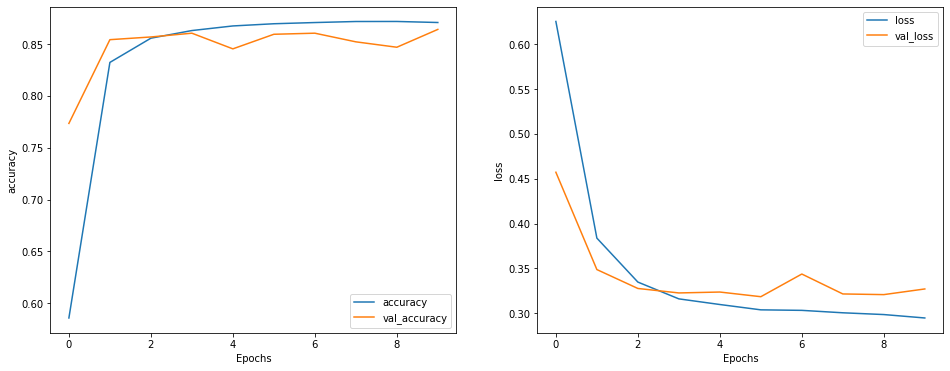

In [27]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
